Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pasude labeling (thresholds:0.5), timeout
# Version = "v9" # pasude labeling (thresholds:0.6), timeout
# Version = "v10" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pasude labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)

Version = "v25" # Feature engineering based on Feature importance

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

,sig_id,nonscored1,nonscored2
0,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN
1,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN
2,antiarrhythmic,na_k-atpase_inhibitor,potassium_channel_blocker
3,anticonvulsant,gaba_gated_chloride_channel_blocker,NaN
4,antifungal,fungal_ergosterol_inhibitor,fungal_lanosterol_demethylase_inhibitor
5,antihistamine,histamine_release_inhibitor,NaN
6,atp-sensitive_potassium_channel_antagonist,atp-sensitive_potassium_channel_inhibitor,NaN
7,bacterial_membrane_integrity_inhibitor,bacterial_protein_synthesis_inhibitor,NaN
8,calcineurin_inhibitor,t_cell_inhibitor,NaN
9,catechol_o_methyltransferase_inhibitor,dopamine_release_enhancer,NaN


In [9]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#def calibration(y_pred, target_rate):
#    return y_pred / (y_pred + (1 - y_pred) / target_rate)

In [13]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=2, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, target_rate)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        #y_pred = calibration(y_pred, target_rate)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [14]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': Learning_rate,
    'objective': "binary",
    'colsample_bytree':0.7,
    'subsample':0.9,
    'subsample_freq':5,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2,
}

In [15]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:,0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [16]:
def pseudo_labeling(X_train, y_train, X_test, target_rate, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    
    Threshold = 0.5
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict(X_val, num_iteration=clf.best_iteration_)
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
        
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        high_conf_0, high_conf_1 = y_prob.probability.min()*3, y_prob.probability.max()*0.7
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.5f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        if p_label_rate*3 < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label)*1.5 > check: break
                Threshold -= 0.04
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > target_rate*3:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label) < check*1.5: break
                Threshold += 0.04
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ == max_iter:
            X_conf = X_test.copy()
        else:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        logger.info(f"threshold:{Threshold:.2f}, positive p_label:{sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.5f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates().reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
    return X, y

In [17]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [18]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [19]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [20]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [21]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [22]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [23]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [24]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [25]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [26]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [27]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [28]:
data_df['WHERE'] = Splitdata
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303,train
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866,train
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519,train
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843,test
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932,test
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938,test
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391,test


In [29]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [30]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 408 columns


In [31]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99,WHERE
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303,train
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866,train
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032,train
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519,train
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843,test
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932,test
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938,test
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391,test


In [32]:
Splitdata = data["WHERE"]
data = data.drop('WHERE', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-85,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,0.610453,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,2.368506,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,-2.098055,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.927045,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-12.466870,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,0.977743,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-3.525817,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,2.350949,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-6.247984,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391


In [33]:
# Select TOP100 features based on feature importance with v8 notebook

def select_importance_cols(feature_importance_df, num=103):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols


Feature_importance_df = pd.read_csv("../input/../input/moa-annot-data/feature_importance_df.v8.colab.csv")
Feature_importance_df

importance_cols = select_importance_cols(Feature_importance_df)

len(importance_cols)

103

In [34]:
TOP100 = data[importance_cols]
TOP100 = TOP100.drop(["cp_type", "cp_time", "cp_dose"], axis=1)
TOP100

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.3801,-0.3167,-1.6510,-0.6217,-1.1230,-0.2461,4.183851,-1.3310,20.720024,-0.22130,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,0.7848,0.4842,0.0333,-0.5141,0.4944,-1.1160,-9.101135,0.5149,-121.467612,0.07920,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,0.3193,0.4587,-0.8791,0.2905,-0.1851,0.0860,-5.791252,-1.6090,134.510130,-0.07250,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,0.6498,0.6086,-0.5522,0.4275,-0.7775,0.2270,-2.712772,0.8298,74.254500,-1.66400,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,-4.8360,-1.1320,2.3720,-0.8283,1.5840,-2.3630,-1.055764,-0.9043,140.770455,3.85415,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.2310,-0.2914,0.1655,0.2242,0.1058,-1.0330,-2.921354,0.5788,-13.888734,-0.31340,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,-2.4700,1.0300,0.2641,-1.0190,5.7110,-2.3140,-19.551915,1.8170,56.104299,0.69710,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,-2.1970,0.0199,0.0428,0.7036,2.8370,0.9448,5.732132,-1.6010,-249.158505,-2.55600,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,-1.0450,-0.2809,-0.8224,0.2189,-1.0990,0.9241,-0.123390,-1.4440,-7.429982,0.82050,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [35]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]

g_list

['g-1',
 'g-2',
 'g-4',
 'g-5',
 'g-6',
 'g-8',
 'g-9',
 'g-10',
 'g-12',
 'g-13',
 'g-14',
 'g-15',
 'g-16',
 'g-18',
 'g-19',
 'g-20',
 'g-23',
 'g-24',
 'g-25',
 'g-26',
 'g-27',
 'g-28',
 'g-29',
 'g-30',
 'g-31',
 'g-32',
 'g-33',
 'g-34',
 'g-35',
 'g-36',
 'g-38',
 'g-39',
 'g-40',
 'g-41',
 'g-42',
 'g-43',
 'g-44',
 'g-45',
 'g-46',
 'g-47',
 'g-48',
 'g-49',
 'g-50',
 'g-51',
 'g-53',
 'g-54',
 'g-55',
 'g-56',
 'g-57',
 'g-58',
 'g-59',
 'g-61',
 'g-62',
 'g-64',
 'g-65',
 'g-67',
 'g-69',
 'g-70',
 'g-71',
 'g-73',
 'g-74',
 'g-77',
 'g-78',
 'g-79',
 'g-81',
 'g-83',
 'g-87',
 'g-88',
 'g-89',
 'g-90',
 'g-91',
 'g-93',
 'g-94',
 'g-95',
 'g-96',
 'g-97',
 'g-99',
 'g-103',
 'g-104',
 'g-105',
 'g-106',
 'g-107',
 'g-108',
 'g-109',
 'g-110',
 'g-111',
 'g-113',
 'g-114',
 'g-115',
 'g-116',
 'g-117',
 'g-118',
 'g-119',
 'g-121',
 'g-122',
 'g-123',
 'g-124',
 'g-125',
 'g-126',
 'g-127',
 'g-128',
 'g-129',
 'g-130',
 'g-131',
 'g-132',
 'g-133',
 'g-136',
 'g-137',
 'g-

In [36]:
from sklearn.preprocessing import StandardScaler
    
# Z-score
scaler = StandardScaler(with_mean=True, with_std=True)
std_values = scaler.fit_transform(data.iloc[:, 4:])
std_df = pd.DataFrame(std_values, index=data.index, columns=data.columns[4:])    

In [37]:
TOP100_values = scaler.fit_transform(TOP100)
TOP100_df = pd.DataFrame(TOP100_values, index=TOP100.index, columns=TOP100.columns)
TOP100_df

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.465802,-0.291639,-1.052265,-0.263976,-0.823391,-0.341928,0.010720,-1.173292,0.532505,-0.245498,...,-0.370791,0.296662,-0.189006,0.524494,-0.060594,-1.291179,-0.044174,0.035238,-1.003075,0.850758
1,0.690930,0.436481,0.041989,-0.205921,0.051524,-0.997763,0.010672,0.349254,-2.467257,0.051649,...,0.236541,0.511429,-0.395724,0.359766,-0.060531,-0.343840,-0.059517,-0.504862,1.039894,0.448301
2,0.431980,0.413298,-0.550778,0.228193,-0.316045,-0.091551,0.010684,-1.402594,2.933159,-0.098358,...,0.398142,0.057198,-0.085100,-0.389126,-0.060548,-0.638898,-0.064593,0.188724,-1.587868,0.082687
3,0.615831,0.549577,-0.338398,0.302110,-0.636497,0.014752,0.010695,0.608992,1.661933,-1.672100,...,-0.410416,1.084911,-0.372027,0.022141,-0.060392,0.233330,-0.041389,-0.185244,1.222974,-0.208997
4,-2.435831,-1.032850,1.561392,-0.375445,0.640931,-1.937901,0.010701,-0.821339,3.065234,3.784478,...,1.742419,-2.649776,1.168628,-1.301517,-0.060335,-0.073537,-0.062617,2.411493,1.156714,-0.187027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.382860,-0.268638,0.127876,0.192421,-0.158685,-0.935187,0.010694,0.401960,-0.197643,-0.336570,...,-0.774601,-0.102915,-0.506120,0.244405,-0.061289,0.076307,-0.069501,-0.559212,0.002735,-0.076157
27792,-1.119663,0.932683,0.191934,-0.478335,2.873386,-1.900959,0.010635,1.423260,1.279015,0.662655,...,0.451856,-2.802448,3.251854,0.485318,-0.055651,-0.264006,-0.003956,0.298533,-0.897559,-2.260021
27793,-0.967797,0.014373,0.048160,0.451077,1.318727,0.555915,0.010725,-1.395995,-5.161179,-2.554147,...,-0.660537,0.197554,0.329358,-0.761765,-0.061074,1.335331,0.015196,-0.124232,0.474652,-0.139782
27794,-0.326958,-0.259092,-0.513942,0.189562,-0.810409,0.540309,0.010704,-1.266498,-0.061381,0.784678,...,0.730994,0.631450,-0.565547,0.661424,-0.059323,0.576477,-0.009120,-0.395300,-0.335802,-0.161946


In [38]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)

# PCA → UMAP for all data
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 10)


In [39]:
# PCA for TOP100
pca_TOP100 = pca_transformer.fit_transform(TOP100_df)

# PCA → UMAP for TOP100
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_TOP100 = umap.fit_transform(pca_TOP100)

print(pca_umap_TOP100.shape)

(27796, 10)


In [40]:
# PCA for merged categories
g_d_g_list = g_list + d_g_list
c_d_c_list = c_list + d_c_list

pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])

# PCA → UMAP for merged categories
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g_d_g = umap.fit_transform(pca_g_d_g)

umap = UMAP(n_components=3, random_state=SEED)
pca_umap_c_d_c = umap.fit_transform(pca_c_d_c)

print(pca_umap_g_d_g.shape)
print(pca_umap_c_d_c.shape)

(27796, 10)
(27796, 3)


In [41]:
# PCA for each category
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

print("*************")

# PCA → UMAP for each category
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g = umap.fit_transform(pca_g)
pca_umap_d_g = umap.fit_transform(pca_d_g)

umap = UMAP(n_components=3, random_state=SEED)
pca_umap_c = umap.fit_transform(pca_c)
pca_umap_d_c = umap.fit_transform(pca_d_c)

print(pca_umap_g.shape)
print(pca_umap_c.shape)
print(pca_umap_d_g.shape)
print(pca_umap_d_c.shape)

(27796, 323)
(27796, 13)
(27796, 394)
(27796, 25)
*************
(27796, 10)
(27796, 3)
(27796, 10)
(27796, 3)


In [42]:
# PCA for all categories
pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)

pca_all = pca_transformer.fit_transform(std_df)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_all.shape)
print(pca_g_d_g.shape)
print(pca_c_d_c.shape)
print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [43]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_d_g,
    pca_umap_c_d_c,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_all,
    pca_g_d_g,
    pca_c_d_c,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
    pca_umap_TOP100,
]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_d_g",
    "pca_umap_c_d_c",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_all",
    "pca_g_d_g",
    "pca_c_d_c",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
    "pca_umap_TOP100",
]

In [44]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_all_4',
 'pca_umap_all_5',
 'pca_umap_all_6',
 'pca_umap_all_7',
 'pca_umap_all_8',
 'pca_umap_all_9',
 'pca_umap_all_10',
 'pca_umap_g_d_g_1',
 'pca_umap_g_d_g_2',
 'pca_umap_g_d_g_3',
 'pca_umap_g_d_g_4',
 'pca_umap_g_d_g_5',
 'pca_umap_g_d_g_6',
 'pca_umap_g_d_g_7',
 'pca_umap_g_d_g_8',
 'pca_umap_g_d_g_9',
 'pca_umap_g_d_g_10',
 'pca_umap_c_d_c_1',
 'pca_umap_c_d_c_2',
 'pca_umap_c_d_c_3',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_g_4',
 'pca_umap_g_5',
 'pca_umap_g_6',
 'pca_umap_g_7',
 'pca_umap_g_8',
 'pca_umap_g_9',
 'pca_umap_g_10',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_c_3',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_g_4',
 'pca_umap_d_g_5',
 'pca_umap_d_g_6',
 'pca_umap_d_g_7',
 'pca_umap_d_g_8',
 'pca_umap_d_g_9',
 'pca_umap_d_g_10',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_umap_d_c_3',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_g_d_g_1',
 'pca_g

In [45]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,pca_umap_all_7,pca_umap_all_8,pca_umap_all_9,pca_umap_all_10,...,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3,pca_umap_TOP100_4,pca_umap_TOP100_5,pca_umap_TOP100_6,pca_umap_TOP100_7,pca_umap_TOP100_8,pca_umap_TOP100_9,pca_umap_TOP100_10
0,0.845078,0.369664,-0.971082,1.144255,-0.336932,1.273461,-0.726431,0.500582,-0.745443,0.422833,...,6.537801,-0.860503,-2.483181,-0.238004,-0.048911,-0.551900,-0.491768,-1.139739,-0.096629,1.224921
1,0.408433,-0.122792,-0.644561,0.299853,-1.184543,-0.129076,-1.540307,0.093163,-0.344911,0.189922,...,7.207695,-0.509391,-1.232071,0.236068,-0.160961,-0.758503,-0.331141,-1.270125,-0.079232,1.068841
2,0.414864,-0.343663,-0.731961,0.056800,-0.516689,0.367345,-1.240654,0.224131,-0.262001,0.418410,...,6.417024,-1.002094,-2.242740,-0.179994,0.412457,0.005169,-0.327025,-0.953271,-1.051006,1.142442
3,0.397225,0.236804,-0.492188,0.411184,-0.478614,0.032374,-0.632378,0.004937,-0.287268,0.259129,...,7.258384,-0.776703,-2.234353,0.679605,-0.554915,-0.670894,-0.652157,-1.081843,-0.239135,1.321515
4,-0.033243,-0.931000,0.129441,-0.669685,-0.863313,-1.384214,-0.473344,-0.542312,0.308306,-0.301839,...,7.069327,-0.541471,-1.032924,-0.350861,-0.416061,-2.138698,-0.844600,-2.038284,1.738625,0.497347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.999574,0.671430,-0.965049,1.189671,-0.288353,0.983231,-0.386614,0.970984,-0.860071,0.429966,...,6.011821,-1.092049,-2.280311,-0.413983,0.023537,-0.302343,0.076216,-1.159208,-1.301753,1.330280
27792,0.955218,0.554636,-0.904490,1.093626,-0.204653,0.952394,-0.486180,0.878812,-0.773996,0.386082,...,6.598001,-0.966000,-1.187536,-0.399339,0.588274,0.952727,2.198827,-2.313427,0.284180,1.363684
27793,0.385342,0.223444,-1.095336,1.145797,-2.040697,0.699394,-1.971213,0.218453,0.008350,0.617363,...,8.837356,1.409845,0.872894,-0.780051,-0.578440,0.848789,-1.491210,-0.088263,-6.070854,0.144273
27794,0.968738,0.569513,-0.936993,1.118761,-0.252727,1.034485,-0.410452,0.836959,-0.838300,0.442785,...,5.835190,-1.023103,-2.289077,-0.018627,0.569541,0.195833,0.463619,-1.179432,-1.166861,1.360804


In [46]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3,pca_umap_TOP100_4,pca_umap_TOP100_5,pca_umap_TOP100_6,pca_umap_TOP100_7,pca_umap_TOP100_8,pca_umap_TOP100_9,pca_umap_TOP100_10
0,id_000644bb2,1,0,0,0.845078,0.369664,-0.971082,1.144255,-0.336932,1.273461,...,6.537801,-0.860503,-2.483181,-0.238004,-0.048911,-0.551900,-0.491768,-1.139739,-0.096629,1.224921
1,id_001762a82,1,0,0,0.408433,-0.122792,-0.644561,0.299853,-1.184543,-0.129076,...,7.207695,-0.509391,-1.232071,0.236068,-0.160961,-0.758503,-0.331141,-1.270125,-0.079232,1.068841
2,id_00762e877,1,0,0,0.414864,-0.343663,-0.731961,0.056800,-0.516689,0.367345,...,6.417024,-1.002094,-2.242740,-0.179994,0.412457,0.005169,-0.327025,-0.953271,-1.051006,1.142442
3,id_0079af0fb,0,0,0,0.397225,0.236804,-0.492188,0.411184,-0.478614,0.032374,...,7.258384,-0.776703,-2.234353,0.679605,-0.554915,-0.670894,-0.652157,-1.081843,-0.239135,1.321515
4,id_0079d45d3,1,0,0,-0.033243,-0.931000,0.129441,-0.669685,-0.863313,-1.384214,...,7.069327,-0.541471,-1.032924,-0.350861,-0.416061,-2.138698,-0.844600,-2.038284,1.738625,0.497347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.999574,0.671430,-0.965049,1.189671,-0.288353,0.983231,...,6.011821,-1.092049,-2.280311,-0.413983,0.023537,-0.302343,0.076216,-1.159208,-1.301753,1.330280
27792,id_fce497048,1,1,1,0.955218,0.554636,-0.904490,1.093626,-0.204653,0.952394,...,6.598001,-0.966000,-1.187536,-0.399339,0.588274,0.952727,2.198827,-2.313427,0.284180,1.363684
27793,id_fd75349b2,1,1,1,0.385342,0.223444,-1.095336,1.145797,-2.040697,0.699394,...,8.837356,1.409845,0.872894,-0.780051,-0.578440,0.848789,-1.491210,-0.088263,-6.070854,0.144273
27794,id_fed0f2fe0,1,1,1,0.968738,0.569513,-0.936993,1.118761,-0.252727,1.034485,...,5.835190,-1.023103,-2.289077,-0.018627,0.569541,0.195833,0.463619,-1.179432,-1.166861,1.360804


In [47]:
# Create feature
import itertools
def CreateFeat(df):
  def func_product(row):
    return (row[col1]) * (row[col2])
  def func_division(row):
    delta = 1e-6
    return (row[col1]+delta) / (row[col2]+delta) 
  
  Columns = df.columns 
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
        df[f"{col1}_{col2}_prd"] = df[[col1, col2]].apply(func_product, axis=1)
        df[f"{col1}_{col2}_div"] = round(df[[col1, col2]].apply(func_division, axis=1), 0)

  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

#Reduce columens
def ReduceCol(df):
  remove_cols = []
  Columns = df.columns
  
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
    # constant columns
    if df[col1].std() == 0: remove_cols.append(col1)
    
    # duplicated columns
    if (col1 not in remove_cols) and (col2 not in remove_cols):
      x, y = df[col1].values, df[col2].values
      if np.array_equal(x, y): remove_cols.append(col1)

  df.drop(remove_cols, inplace=True, axis=1)
  print(f"Removed {len(remove_cols)} constant & duplicated columns")

  return df

# Create feature2
def CreateFeat2(df):
  func_list = ("max", "min", "mean", "median", "mad", "var", "std")
  Columns = df.columns 
  for idx, func in enumerate(func_list):
    print(f"{idx}/{len(func_list)}: Calucurating... {func}")
    for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
      df[f"{col1}_{col2}_{func}"] = df[[col1, col2]].apply(func, axis=1)
  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

In [48]:
important_col = ["pca_umap_g_2", "pca_umap_g_d_g_8", "pca_umap_all_3", "pca_umap_g_10", "pca_umap_g_d_g_4"]

In [49]:
# Create feature based on feature importance with v24 notebook
tmp = CreateFeat(data[important_col])
data = pd.concat([data, tmp], axis=1)

#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp = ReduceCol(data.iloc[:,4:])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)
data


Crated 40 columns



Removed 10 constant & duplicated columns


,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_g_10_pca_umap_all_3_div,pca_umap_g_10_pca_umap_g_d_g_4_div,pca_umap_g_d_g_4_pca_umap_g_2_prd,pca_umap_g_d_g_4_pca_umap_g_2_div,pca_umap_g_d_g_4_pca_umap_g_d_g_8_prd,pca_umap_g_d_g_4_pca_umap_g_d_g_8_div,pca_umap_g_d_g_4_pca_umap_all_3_prd,pca_umap_g_d_g_4_pca_umap_all_3_div,pca_umap_g_d_g_4_pca_umap_g_10_prd,pca_umap_g_d_g_4_pca_umap_g_10_div
0,id_000644bb2,1,0,0,0.845078,0.369664,-0.971082,1.144255,-0.336932,1.273461,...,1.0,-2.0,-0.272615,-0.0,0.162519,1.0,-0.333788,-0.0,-0.236898,-0.0
1,id_001762a82,1,0,0,0.408433,-0.122792,-0.644561,0.299853,-1.184543,-0.129076,...,0.0,-2.0,-0.140598,-0.0,0.145167,0.0,-0.106769,-0.0,-0.044409,-1.0
2,id_00762e877,1,0,0,0.414864,-0.343663,-0.731961,0.056800,-0.516689,0.367345,...,1.0,-1.0,-0.567183,-1.0,0.661898,1.0,-0.449311,-1.0,-0.253988,-1.0
3,id_0079af0fb,0,0,0,0.397225,0.236804,-0.492188,0.411184,-0.478614,0.032374,...,1.0,-1.0,-0.677669,-1.0,0.437452,2.0,-0.444214,-2.0,-0.662516,-1.0
4,id_0079d45d3,1,0,0,-0.033243,-0.931000,0.129441,-0.669685,-0.863313,-1.384214,...,-0.0,0.0,0.137098,3.0,0.147353,3.0,-0.083904,-5.0,0.031608,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.999574,0.671430,-0.965049,1.189671,-0.288353,0.983231,...,0.0,-0.0,-0.084297,-7.0,0.859119,1.0,-0.764867,-1.0,-0.148405,-4.0
27792,id_fce497048,1,1,1,0.955218,0.554636,-0.904490,1.093626,-0.204653,0.952394,...,1.0,-1.0,-0.627133,-1.0,0.684467,1.0,-0.662824,-1.0,-0.437270,-1.0
27793,id_fd75349b2,1,1,1,0.385342,0.223444,-1.095336,1.145797,-2.040697,0.699394,...,0.0,-12.0,-0.034992,-0.0,-0.025277,-0.0,-0.047929,-0.0,-0.023552,-0.0
27794,id_fed0f2fe0,1,1,1,0.968738,0.569513,-0.936993,1.118761,-0.252727,1.034485,...,1.0,-1.0,-0.714885,-1.0,0.775085,1.0,-0.721237,-1.0,-0.431361,-1.0


In [50]:
# Create feature based on feature importance with v24 notebook
tmp = CreateFeat2(data[important_col])
data = pd.concat([data, tmp], axis=1)

#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp = ReduceCol(data.iloc[:,4:])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)
data

0/7: Calucurating... max



1/7: Calucurating... min



2/7: Calucurating... mean



3/7: Calucurating... median



4/7: Calucurating... mad



5/7: Calucurating... var



6/7: Calucurating... std



Crated 140 columns



Removed 80 constant & duplicated columns


,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_g_d_g_8_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_g_2_std,pca_umap_g_10_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_2_std,pca_umap_g_d_g_4_pca_umap_g_d_g_8_std,pca_umap_g_d_g_4_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_10_std
0,id_000644bb2,1,0,0,0.845078,0.369664,-0.971082,1.144255,-0.336932,1.273461,...,0.895145,0.125842,1.020988,0.073477,0.821669,0.199319,0.803869,0.091277,0.929711,0.730392
1,id_001762a82,1,0,0,0.408433,-0.122792,-0.644561,0.299853,-1.184543,-0.129076,...,1.219863,0.144406,1.075458,0.410608,0.809256,0.266202,0.717309,0.502554,0.572904,0.306702
2,id_00762e877,1,0,0,0.414864,-0.343663,-0.731961,0.056800,-0.516689,0.367345,...,1.415816,0.135781,1.280035,0.360779,1.055037,0.224998,1.087410,0.328407,0.951629,0.726631
3,id_0079af0fb,0,0,0,0.397225,0.236804,-0.492188,0.411184,-0.478614,0.032374,...,0.873667,0.182906,0.690761,0.011872,0.861795,0.171034,1.169119,0.295452,0.986214,1.157248
4,id_0079d45d3,1,0,0,-0.033243,-0.931000,0.129441,-0.669685,-0.863313,-1.384214,...,0.011186,0.241084,0.252270,0.115075,0.126262,0.126009,0.308797,0.297611,0.549881,0.423872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.999574,0.671430,-0.965049,1.189671,-0.288353,0.983231,...,0.841689,0.607185,1.448874,0.057196,0.898885,0.549989,0.635638,0.206051,1.242823,0.692834
27792,id_fce497048,1,1,1,0.955218,0.554636,-0.904490,1.093626,-0.204653,0.952394,...,1.265588,0.034438,1.300027,0.183203,1.082385,0.217641,1.123311,0.142277,1.157750,0.940108
27793,id_fd75349b2,1,1,1,0.385342,0.223444,-1.095336,1.145797,-2.040697,0.699394,...,0.156999,0.209052,0.366051,0.184877,0.027878,0.393929,0.596408,0.439409,0.805461,0.411531
27794,id_fed0f2fe0,1,1,1,0.968738,0.569513,-0.936993,1.118761,-0.252727,1.034485,...,1.368741,0.005835,1.374575,0.260456,1.108285,0.266290,1.201004,0.167736,1.206839,0.940549


In [51]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_g_d_g_8_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_g_2_std,pca_umap_g_10_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_2_std,pca_umap_g_d_g_4_pca_umap_g_d_g_8_std,pca_umap_g_d_g_4_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_10_std
0,id_000644bb2,1,0,0,0.845078,0.369664,-0.971082,1.144255,-0.336932,1.117800,...,0.895145,0.125842,1.020988,0.073477,0.821669,0.199319,0.803869,0.091277,0.929711,0.730392
1,id_001762a82,1,0,0,0.408433,-0.122792,-0.644561,0.299853,-1.184543,-0.129076,...,1.219863,0.144406,1.075458,0.410608,0.809256,0.266202,0.717309,0.502554,0.572904,0.306702
2,id_00762e877,1,0,0,0.414864,-0.343663,-0.731961,0.056800,-0.516689,0.367345,...,1.415816,0.135781,1.280035,0.360779,1.055037,0.224998,1.087410,0.328407,0.951629,0.726631
3,id_0079af0fb,0,0,0,0.397225,0.236804,-0.492188,0.411184,-0.478614,0.032374,...,0.873667,0.182906,0.690761,0.011872,0.861795,0.171034,1.169119,0.295452,0.986214,1.157248
4,id_0079d45d3,1,0,0,-0.033243,-0.852492,0.129441,-0.663568,-0.863313,-0.946210,...,0.011186,0.241084,0.252270,0.115075,0.126262,0.126009,0.308797,0.297611,0.549881,0.423872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.999574,0.671430,-0.965049,1.189671,-0.288353,0.983231,...,0.841689,0.607185,1.448874,0.057196,0.898885,0.549989,0.635638,0.206051,1.242823,0.692834
27792,id_fce497048,1,1,1,0.955218,0.554636,-0.904490,1.093626,-0.204653,0.952394,...,1.265588,0.034438,1.300027,0.183203,1.082385,0.217641,1.123311,0.142277,1.157750,0.940108
27793,id_fd75349b2,1,1,1,0.385342,0.223444,-1.095336,1.145797,-1.635087,0.699394,...,0.156999,0.209052,0.366051,0.184877,0.027878,0.393929,0.596408,0.439409,0.805461,0.411531
27794,id_fed0f2fe0,1,1,1,0.968738,0.569513,-0.936993,1.118761,-0.252727,1.034485,...,1.368741,0.005835,1.374575,0.260456,1.108285,0.266290,1.201004,0.167736,1.206839,0.940549


In [52]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [53]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    # 'metric': 'average_precision',
    #'is_unbalance': True,
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [54]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    
    if DEBUG:
        for model in models:
            _importance_df = pd.DataFrame()
            _importance_df["Feature"] = train.columns[1:]
            _importance_df["importance"] = model.feature_importance(importance_type='gain')
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0884975	valid_1's binary_logloss: 0.146523
[200]	training's binary_logloss: 0.0181235	valid_1's binary_logloss: 0.0691174
[300]	training's binary_logloss: 0.00608455	valid_1's binary_logloss: 0.0502929
[400]	training's binary_logloss: 0.0032898	valid_1's binary_logloss: 0.044885
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00284971	valid_1's binary_logloss: 0.0433567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853209	valid_1's binary_logloss: 0.14084
[200]	training's binary_logloss: 0.0174855	valid_1's binary_logloss: 0.0525355
[300]	training's binary_logloss: 0.00589858	valid_1's binary_logloss: 0.0325529
[400]	training's binary_logloss: 0.00320635	valid_1's binary_logloss: 0.0254659
[500]	training's binary_logloss: 0.00231809	valid_1's binary_logloss: 0.022667
Early stopping, best iteration is:
[579]	training's b

Remove_noisy_labels: 13 → positive_corect_labels: 495/987
p_label_rate: 0.00326 Vs.target_rate: 0.00071, Num_p_label: 13.0, conf_0:0.00097, conf_1:0.66656
Num_p_label: 13.0, Expected: 2.8, Adj_threshold_1: 0.50
Num_p_label: 8.0, Expected: 2.8, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 2.8, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 2.8, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.079275	valid_1's binary_logloss: 0.148418
[200]	training's binary_logloss: 0.0151348	valid_1's binary_logloss: 0.069298
[300]	training's binary_logloss: 0.00504165	valid_1's binary_logloss: 0.0449065
[400]	training's binary_logloss: 0.00274599	valid_1's binary_logloss: 0.0363423
[500]	training's binary_logloss: 0.00198654	valid_1's binary_logloss: 0.0332694
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00194701	valid_1's binary_logloss: 0.0326799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0824742	valid_1's binary_logloss: 0.141148
[200]	training's binary_logloss: 0.0161893	valid_1's binary_logloss: 0.0518294
[300]	training's binary_logloss: 0.00540772	valid_1's binary_logloss: 0.0302227
[400]	training's binary_logloss: 0.00296227	valid_1's binary_logloss: 0.0226255


Remove_noisy_labels: 4 → positive_corect_labels: 493.0/983
p_label_rate: 0.00176 Vs.target_rate: 0.00071, Num_p_label: 7.0, conf_0:0.00094, conf_1:0.67160
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176


[500]	training's binary_logloss: 0.00217581	valid_1's binary_logloss: 0.0194711
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00211227	valid_1's binary_logloss: 0.0192007


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807245	valid_1's binary_logloss: 0.161637
[200]	training's binary_logloss: 0.0153333	valid_1's binary_logloss: 0.0692617
[300]	training's binary_logloss: 0.00513829	valid_1's binary_logloss: 0.04416
[400]	training's binary_logloss: 0.00275978	valid_1's binary_logloss: 0.0351629
[500]	training's binary_logloss: 0.00200451	valid_1's binary_logloss: 0.0310956
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00194121	valid_1's binary_logloss: 0.0303838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0815586	valid_1's binary_logloss: 0.144981
[200]	training's binary_logloss: 0.015955	valid_1's binary_logloss: 0.053413
[300]	training's binary_logloss: 0.005396	valid_1's binary_logloss: 0.0295472
[400]	training's binary_logloss: 0.00297032	valid_1's binary_logloss: 0.0221191
[500]	training's binary_logloss: 0.00217095	valid_1's b

Remove_noisy_labels: 5 → positive_corect_labels: 490.0/978
p_label_rate: 0.00201 Vs.target_rate: 0.00071, Num_p_label: 8.0, conf_0:0.00087, conf_1:0.66349
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2480
len(valid_index) : 2480
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192458	valid_1's binary_logloss: 0.031945
[200]	training's binary_logloss: 0.00265335	valid_1's binary_logloss: 0.0109857
[300]	training's binary_logloss: 0.000826064	valid_1's binary_logloss: 0.00800472
[400]	training's binary_logloss: 0.000465445	valid_1's binary_logloss: 0.00714799
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000373757	valid_1's binary_logloss: 0.00676421


len(train_index) : 2480
len(valid_index) : 2480
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203196	valid_1's binary_logloss: 0.0343062
[200]	training's binary_logloss: 0.00287779	valid_1's binary_logloss: 0.01256
[300]	training's binary_logloss: 0.000900297	valid_1's binary_logloss: 0.00822044
[400]	training's binary_logloss: 0.000502675	valid_1's binary_logloss: 0.00683616
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000399463	valid_1's binary_logloss: 0.00643237


5-alpha_reductase_inhibitor logloss: 0.006598290487103415
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806218	valid_1's binary_logloss: 0.139522
[200]	training's binary_logloss: 0.0155628	valid_1's binary_logloss: 0.0678941
[300]	training's binary_logloss: 0.00510288	valid_1's binary_logloss: 0.0485537
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00344364	valid_1's binary_logloss: 0.044282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757542	valid_1's binary_logloss: 0.128962
[200]	training's binary_logloss: 0.0139861	valid_1's binary_logloss: 0.0638481
[300]	training's binary_logloss: 0.00471018	valid_1's binary_logloss: 0.0497962


Remove_noisy_labels: 17 → positive_corect_labels: 495/983
p_label_rate: 0.03415 Vs.target_rate: 0.00076, Num_p_label: 136.0, conf_0:0.00134, conf_1:0.69325
Num_p_label: 136.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 119.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 98.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 84.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 74.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 60.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 46.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 37.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0035844	valid_1's binary_logloss: 0.0471964


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.072538	valid_1's binary_logloss: 0.134651
[200]	training's binary_logloss: 0.0130021	valid_1's binary_logloss: 0.0544644
[300]	training's binary_logloss: 0.00437956	valid_1's binary_logloss: 0.0360223
[400]	training's binary_logloss: 0.00248563	valid_1's binary_logloss: 0.0290909
[500]	training's binary_logloss: 0.00184572	valid_1's binary_logloss: 0.0266271
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00183906	valid_1's binary_logloss: 0.0265858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740455	valid_1's binary_logloss: 0.152378
[200]	training's binary_logloss: 0.0139221	valid_1's binary_logloss: 0.0736291
[300]	training's binary_logloss: 0.00469038	valid_1's binary_logloss: 0.0544037
[400]	training's binary_logloss: 0.00261095	valid_1's binary_logloss: 0.0462216
Early stopping, best iteration is:
[401]	training'

Remove_noisy_labels: 9 → positive_corect_labels: 488.0/974
p_label_rate: 0.00804 Vs.target_rate: 0.00076, Num_p_label: 32.0, conf_0:0.00108, conf_1:0.69700
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0720612	valid_1's binary_logloss: 0.118031
[200]	training's binary_logloss: 0.0131627	valid_1's binary_logloss: 0.0422479
[300]	training's binary_logloss: 0.0045146	valid_1's binary_logloss: 0.0254596
[400]	training's binary_logloss: 0.00252325	valid_1's binary_logloss: 0.0204668
[500]	training's binary_logloss: 0.00186813	valid_1's binary_logloss: 0.0179361
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00182859	valid_1's binary_logloss: 0.0176589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0745099	valid_1's binary_logloss: 0.127763
[200]	training's binary_logloss: 0.0138031	valid_1's binary_logloss: 0.0530971
[300]	training's binary_logloss: 0.00465414	valid_1's binary_logloss: 0.0358729
[400]	training's binary_logloss: 0.0025961	valid_1's binary_logloss: 0.0301953


Remove_noisy_labels: 3 → positive_corect_labels: 486.0/971
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00068, conf_1:0.69776
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201


[500]	training's binary_logloss: 0.00190804	valid_1's binary_logloss: 0.0274183
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00183164	valid_1's binary_logloss: 0.0269992


len(train_index) : 2476
len(valid_index) : 2477
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185327	valid_1's binary_logloss: 0.0327452
[200]	training's binary_logloss: 0.00278194	valid_1's binary_logloss: 0.0159946
[300]	training's binary_logloss: 0.000854883	valid_1's binary_logloss: 0.0136716


len(train_index) : 2477
len(valid_index) : 2476
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000522215	valid_1's binary_logloss: 0.0133586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184542	valid_1's binary_logloss: 0.0297754
[200]	training's binary_logloss: 0.00276343	valid_1's binary_logloss: 0.0113005
[300]	training's binary_logloss: 0.000882327	valid_1's binary_logloss: 0.00786025
[400]	training's binary_logloss: 0.000503298	valid_1's binary_logloss: 0.00687763
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000427997	valid_1's binary_logloss: 0.00665028


11-beta-hsd1_inhibitor logloss: 0.010005142361321495
acat_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0969368	valid_1's binary_logloss: 0.197991
[200]	training's binary_logloss: 0.0201321	valid_1's binary_logloss: 0.112392
[300]	training's binary_logloss: 0.00676734	valid_1's binary_logloss: 0.0917718
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00571074	valid_1's binary_logloss: 0.0892688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101739	valid_1's binary_logloss: 0.178142
[200]	training's binary_logloss: 0.0227221	valid_1's binary_logloss: 0.0886365
[300]	training's binary_logloss: 0.00774103	valid_1's binary_logloss: 0.0613638
[400]	training's binary_logloss: 0.00409562	valid_1's binary_logloss: 0.0512421
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00304104	valid_1's binary_logloss: 0.0478171


Remove_noisy_labels: 29 → positive_corect_labels: 490/971
p_label_rate: 0.00477 Vs.target_rate: 0.00101, Num_p_label: 19.0, conf_0:0.00176, conf_1:0.67644
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880855	valid_1's binary_logloss: 0.178776
[200]	training's binary_logloss: 0.0181689	valid_1's binary_logloss: 0.103828
[300]	training's binary_logloss: 0.00617729	valid_1's binary_logloss: 0.0820183
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00372129	valid_1's binary_logloss: 0.071957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935964	valid_1's binary_logloss: 0.176354
[200]	training's binary_logloss: 0.019214	valid_1's binary_logloss: 0.0883952
[300]	training's binary_logloss: 0.00656858	valid_1's binary_logloss: 0.0633373
[400]	training's binary_logloss: 0.00349213	valid_1's binary_logloss: 0.0515552
[500]	training's binary_logloss: 0.00246343	valid_1's binary_logloss: 0.0462361


Remove_noisy_labels: 25 → positive_corect_labels: 483.0/946
p_label_rate: 0.00527 Vs.target_rate: 0.00101, Num_p_label: 21.0, conf_0:0.00060, conf_1:0.69616
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_1: 0.78
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_2: 0.82
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_3: 0.86
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_4: 0.90


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00214178	valid_1's binary_logloss: 0.043777


Num_p_label: 5.0, Expected: 4.0, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834128	valid_1's binary_logloss: 0.146798
[200]	training's binary_logloss: 0.0171537	valid_1's binary_logloss: 0.070275
[300]	training's binary_logloss: 0.00607954	valid_1's binary_logloss: 0.0481664
[400]	training's binary_logloss: 0.00337197	valid_1's binary_logloss: 0.0393251
[500]	training's binary_logloss: 0.00241722	valid_1's binary_logloss: 0.0353191
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00228281	valid_1's binary_logloss: 0.0342216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886738	valid_1's binary_logloss: 0.156469
[200]	training's binary_logloss: 0.0183021	valid_1's binary_logloss: 0.0678279
[300]	training's binary_logloss: 0.00616155	valid_1's binary_logloss: 0.0433355
[400]	training's binary_logloss: 0.00336659	valid_1's binary_logloss: 0.0353053


Remove_noisy_labels: 9 → positive_corect_labels: 481.0/937
p_label_rate: 0.00126 Vs.target_rate: 0.00101, Num_p_label: 5.0, conf_0:0.00052, conf_1:0.69880
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00264837	valid_1's binary_logloss: 0.0324816


len(train_index) : 2459
len(valid_index) : 2460
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183026	valid_1's binary_logloss: 0.0350918
[200]	training's binary_logloss: 0.00282823	valid_1's binary_logloss: 0.0190646
[300]	training's binary_logloss: 0.000914706	valid_1's binary_logloss: 0.0149931
[400]	training's binary_logloss: 0.000529715	valid_1's binary_logloss: 0.0133979
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000467631	valid_1's binary_logloss: 0.0128204


len(train_index) : 2460
len(valid_index) : 2459
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193708	valid_1's binary_logloss: 0.0302403
[200]	training's binary_logloss: 0.00304016	valid_1's binary_logloss: 0.0115166
[300]	training's binary_logloss: 0.00100396	valid_1's binary_logloss: 0.00770436
[400]	training's binary_logloss: 0.000580521	valid_1's binary_logloss: 0.00632622
[500]	training's binary_logloss: 0.000441648	valid_1's binary_logloss: 0.00583455
[600]	training's binary_logloss: 0.000407789	valid_1's binary_logloss: 0.00570503
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.000407789	valid_1's binary_logloss: 0.00570503


acat_inhibitor logloss: 0.009263439034792539
acetylcholine_receptor_agonist , len(trt) : 190
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.251465	valid_1's binary_logloss: 0.537801
[200]	training's binary_logloss: 0.114612	valid_1's binary_logloss: 0.50184
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0816227	valid_1's binary_logloss: 0.48828
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.250453	valid_1's binary_logloss: 0.559317
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.18315	valid_1's binary_logloss: 0.540699


Remove_noisy_labels: 248 → positive_corect_labels: 390/752
p_label_rate: 0.19864 Vs.target_rate: 0.00798, Num_p_label: 791.0, conf_0:0.13767, conf_1:0.62915
Num_p_label: 791.0, Expected: 31.8, Adj_threshold_1: 0.50
Num_p_label: 613.0, Expected: 31.8, Adj_threshold_2: 0.54
Num_p_label: 470.0, Expected: 31.8, Adj_threshold_3: 0.58
Num_p_label: 346.0, Expected: 31.8, Adj_threshold_4: 0.62
Num_p_label: 230.0, Expected: 31.8, Adj_threshold_5: 0.66
Num_p_label: 143.0, Expected: 31.8, Adj_threshold_6: 0.70
Num_p_label: 81.0, Expected: 31.8, Adj_threshold_7: 0.74
Num_p_label: 47.0, Expected: 31.8, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:47.0/3982, p_label_rate: 0.01180
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183528	valid_1's binary_logloss: 0.475121
[200]	training's binary_logloss: 0.0646932	valid_1's binary_logloss: 0.421499
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0307719	valid_1's binary_logloss: 0.402619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210404	valid_1's binary_logloss: 0.42632
[200]	training's binary_logloss: 0.0802603	valid_1's binary_logloss: 0.34782
[300]	training's binary_logloss: 0.0351996	valid_1's binary_logloss: 0.317755


Remove_noisy_labels: 129 → positive_corect_labels: 348.0/623
p_label_rate: 0.03164 Vs.target_rate: 0.00798, Num_p_label: 126.0, conf_0:0.01737, conf_1:0.68416
Num_p_label: 126.0, Expected: 31.8, Adj_threshold_1: 0.78
Num_p_label: 92.0, Expected: 31.8, Adj_threshold_2: 0.82
Num_p_label: 54.0, Expected: 31.8, Adj_threshold_3: 0.86
Num_p_label: 26.0, Expected: 31.8, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0264902	valid_1's binary_logloss: 0.310478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162816	valid_1's binary_logloss: 0.343574
[200]	training's binary_logloss: 0.0525522	valid_1's binary_logloss: 0.247857
[300]	training's binary_logloss: 0.021201	valid_1's binary_logloss: 0.223505
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0189193	valid_1's binary_logloss: 0.221741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159349	valid_1's binary_logloss: 0.346323
[200]	training's binary_logloss: 0.0519153	valid_1's binary_logloss: 0.27029
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0244837	valid_1's binary_logloss: 0.239062


Remove_noisy_labels: 60 → positive_corect_labels: 330.0/563
p_label_rate: 0.03114 Vs.target_rate: 0.00798, Num_p_label: 124.0, conf_0:0.00905, conf_1:0.69298
Num_p_label: 124.0, Expected: 31.8, Adj_threshold_1: 0.90
Num_p_label: 67.0, Expected: 31.8, Adj_threshold_2: 0.94
Num_p_label: 8.0, Expected: 31.8, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2272
len(valid_index) : 2273
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257102	valid_1's binary_logloss: 0.0601498
[200]	training's binary_logloss: 0.0061319	valid_1's binary_logloss: 0.045731


len(train_index) : 2273
len(valid_index) : 2272
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00290179	valid_1's binary_logloss: 0.0428963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242656	valid_1's binary_logloss: 0.0662534


acetylcholine_receptor_agonist logloss: 0.048831040979799255
acetylcholine_receptor_antagonist , len(trt) : 301
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.005292	valid_1's binary_logloss: 0.0550203
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00585007	valid_1's binary_logloss: 0.0547684
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.579289	valid_1's binary_logloss: 0.683696
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 420 → positive_corect_labels: 297/580
p_label_rate: 0.29257 Vs.target_rate: 0.01264, Num_p_label: 1165.0, conf_0:0.81930, conf_1:0.49353
Num_p_label: 1165.0, Expected: 50.3, Adj_threshold_1: 0.50
Num_p_label: 380.0, Expected: 50.3, Adj_threshold_2: 0.54
Num_p_label: 64.0, Expected: 50.3, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:64.0/3982, p_label_rate: 0.01607
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.325834	valid_1's binary_logloss: 0.653341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788599	valid_1's binary_logloss: 0.215075
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0368289	valid_1's binary_logloss: 0.203794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796356	valid_1's binary_logloss: 0.211099


Remove_noisy_labels: 158 → positive_corect_labels: 202.0/1754
p_label_rate: 0.00000 Vs.target_rate: 0.01264, Num_p_label: 0.0, conf_0:0.00333, conf_1:0.34635
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_1: 0.58
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_3: 0.50
Num_p_label: 7.0, Expected: 50.3, Adj_threshold_4: 0.46
Num_p_label: 11.0, Expected: 50.3, Adj_threshold_5: 0.42
Num_p_label: 18.0, Expected: 50.3, Adj_threshold_6: 0.38
Num_p_label: 25.0, Expected: 50.3, Adj_threshold_7: 0.34
Num_p_label: 33.0, Expected: 50.3, Adj_threshold_8: 0.30
Num_p_label: 43.0, Expected: 50.3, Adj_threshold_9: 0.26
threshold:0.26, positive p_label:43.0/3982, p_label_rate: 0.01080


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0290884	valid_1's binary_logloss: 0.198196


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417775	valid_1's binary_logloss: 0.107248
[200]	training's binary_logloss: 0.0112206	valid_1's binary_logloss: 0.0852009
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00856099	valid_1's binary_logloss: 0.0824589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393898	valid_1's binary_logloss: 0.0998099


Remove_noisy_labels: 51 → positive_corect_labels: 174.0/1703
p_label_rate: 0.00728 Vs.target_rate: 0.01264, Num_p_label: 29.0, conf_0:0.00118, conf_1:0.65973
threshold:0.26, positive p_label:29.0/3982, p_label_rate: 0.00728
len(train_index) : 2190
len(valid_index) : 2190
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0109629	valid_1's binary_logloss: 0.0823334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159057	valid_1's binary_logloss: 0.0559926


len(train_index) : 2190
len(valid_index) : 2190
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[149]	training's binary_logloss: 0.00740299	valid_1's binary_logloss: 0.0536307
Training until validation scores don't improve for 10 rounds


acetylcholine_receptor_antagonist logloss: 0.06022720405991719


[100]	training's binary_logloss: 0.0151643	valid_1's binary_logloss: 0.0676709
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.0123952	valid_1's binary_logloss: 0.0668237


acetylcholinesterase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161569	valid_1's binary_logloss: 0.316214
[200]	training's binary_logloss: 0.0516415	valid_1's binary_logloss: 0.230484
[300]	training's binary_logloss: 0.019735	valid_1's binary_logloss: 0.204214
[400]	training's binary_logloss: 0.00974311	valid_1's binary_logloss: 0.195021
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00897675	valid_1's binary_logloss: 0.194094
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157607	valid_1's binary_logloss: 0.336283
[200]	training's binary_logloss: 0.0495844	valid_1's binary_logloss: 0.252761


Remove_noisy_labels: 81 → positive_corect_labels: 478/919
p_label_rate: 0.05625 Vs.target_rate: 0.00307, Num_p_label: 224.0, conf_0:0.00301, conf_1:0.68648
Num_p_label: 224.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 189.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 152.0, Expected: 12.2, Adj_threshold_3: 0.58


[300]	training's binary_logloss: 0.0192634	valid_1's binary_logloss: 0.228753
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0170447	valid_1's binary_logloss: 0.227052


Num_p_label: 120.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 97.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 72.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 54.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_8: 0.78
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_9: 0.82
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146849	valid_1's binary_logloss: 0.243882
[200]	training's binary_logloss: 0.0417597	valid_1's binary_logloss: 0.133384
[300]	training's binary_logloss: 0.0156632	valid_1's binary_logloss: 0.0928693
[400]	training's binary_logloss: 0.00794584	valid_1's binary_logloss: 0.0783395
[500]	training's binary_logloss: 0.00506854	valid_1's binary_logloss: 0.0682982
[600]	training's binary_logloss: 0.00382519	valid_1's binary_logloss: 0.0641289
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00355187	valid_1's binary_logloss: 0.0625952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13436	valid_1's binary_logloss: 0.279908
[200]	training's binary_logloss: 0.0364772	valid_1's binary_logloss: 0.176782
[300]	training's binary_logloss: 0.0133167	valid_1's binary_logloss: 0.147599
Early stopping, best iteration is:
[378]	training's binar

Remove_noisy_labels: 41 → positive_corect_labels: 467.0/878
p_label_rate: 0.04093 Vs.target_rate: 0.00307, Num_p_label: 163.0, conf_0:0.00191, conf_1:0.69853
Num_p_label: 163.0, Expected: 12.2, Adj_threshold_1: 0.90
Num_p_label: 105.0, Expected: 12.2, Adj_threshold_2: 0.94
Num_p_label: 28.0, Expected: 12.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 12.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130051	valid_1's binary_logloss: 0.229815
[200]	training's binary_logloss: 0.0361526	valid_1's binary_logloss: 0.131213
[300]	training's binary_logloss: 0.0132077	valid_1's binary_logloss: 0.0948829
[400]	training's binary_logloss: 0.00675354	valid_1's binary_logloss: 0.0777331
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00523684	valid_1's binary_logloss: 0.0737451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128503	valid_1's binary_logloss: 0.247006
[200]	training's binary_logloss: 0.034105	valid_1's binary_logloss: 0.138921
[300]	training's binary_logloss: 0.0126197	valid_1's binary_logloss: 0.10681
[400]	training's binary_logloss: 0.00652539	valid_1's binary_logloss: 0.093675


Remove_noisy_labels: 27 → positive_corect_labels: 463.0/851
p_label_rate: 0.00000 Vs.target_rate: 0.00307, Num_p_label: 0.0, conf_0:0.00123, conf_1:0.69857
Num_p_label: 0.0, Expected: 12.2, Adj_threshold_1: 1.02
Num_p_label: 65.0, Expected: 12.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:65.0/3982, p_label_rate: 0.01632


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00495354	valid_1's binary_logloss: 0.0900228


len(train_index) : 2416
len(valid_index) : 2417
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0381154	valid_1's binary_logloss: 0.0842509
[200]	training's binary_logloss: 0.00932652	valid_1's binary_logloss: 0.059144
[300]	training's binary_logloss: 0.00307431	valid_1's binary_logloss: 0.0530587


len(train_index) : 2417
len(valid_index) : 2416
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


[400]	training's binary_logloss: 0.00150378	valid_1's binary_logloss: 0.050721
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00158548	valid_1's binary_logloss: 0.0506399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373276	valid_1's binary_logloss: 0.0800569
[200]	training's binary_logloss: 0.0087446	valid_1's binary_logloss: 0.0552904
[300]	training's binary_logloss: 0.0028449	valid_1's binary_logloss: 0.0499875


acetylcholinesterase_inhibitor logloss: 0.049505100949927515


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00158808	valid_1's binary_logloss: 0.0483698


adenosine_receptor_agonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141002	valid_1's binary_logloss: 0.293283
[200]	training's binary_logloss: 0.0412888	valid_1's binary_logloss: 0.193475
[300]	training's binary_logloss: 0.0153444	valid_1's binary_logloss: 0.155234
[400]	training's binary_logloss: 0.00788209	valid_1's binary_logloss: 0.142261
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00616486	valid_1's binary_logloss: 0.137181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147968	valid_1's binary_logloss: 0.30156
[200]	training's binary_logloss: 0.0440942	valid_1's binary_logloss: 0.207587
[300]	training's binary_logloss: 0.0164893	valid_1's binary_logloss: 0.173768


Remove_noisy_labels: 58 → positive_corect_labels: 481/942
p_label_rate: 0.00929 Vs.target_rate: 0.00227, Num_p_label: 37.0, conf_0:0.00310, conf_1:0.57119
Num_p_label: 37.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 26.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 9.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:11.0/3982, p_label_rate: 0.00276


[400]	training's binary_logloss: 0.00813454	valid_1's binary_logloss: 0.161525
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00801266	valid_1's binary_logloss: 0.161472


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138434	valid_1's binary_logloss: 0.281025
[200]	training's binary_logloss: 0.0370328	valid_1's binary_logloss: 0.178224
[300]	training's binary_logloss: 0.0134995	valid_1's binary_logloss: 0.143332
[400]	training's binary_logloss: 0.00681919	valid_1's binary_logloss: 0.128665
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00620143	valid_1's binary_logloss: 0.127469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130654	valid_1's binary_logloss: 0.241345
[200]	training's binary_logloss: 0.0373753	valid_1's binary_logloss: 0.146827
[300]	training's binary_logloss: 0.0139591	valid_1's binary_logloss: 0.109489
[400]	training's binary_logloss: 0.00712874	valid_1's binary_logloss: 0.0938098
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00511282	valid_1's binary_logloss: 0.0857134


Remove_noisy_labels: 39 → positive_corect_labels: 463.0/903
p_label_rate: 0.01356 Vs.target_rate: 0.00227, Num_p_label: 54.0, conf_0:0.00286, conf_1:0.64908
Num_p_label: 54.0, Expected: 9.0, Adj_threshold_1: 0.66
Num_p_label: 40.0, Expected: 9.0, Adj_threshold_2: 0.70
Num_p_label: 30.0, Expected: 9.0, Adj_threshold_3: 0.74
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_4: 0.78
Num_p_label: 12.0, Expected: 9.0, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120181	valid_1's binary_logloss: 0.274192
[200]	training's binary_logloss: 0.0320114	valid_1's binary_logloss: 0.172334
[300]	training's binary_logloss: 0.0118955	valid_1's binary_logloss: 0.138551
[400]	training's binary_logloss: 0.00606266	valid_1's binary_logloss: 0.119278
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00475088	valid_1's binary_logloss: 0.113479
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118425	valid_1's binary_logloss: 0.257507
[200]	training's binary_logloss: 0.0308991	valid_1's binary_logloss: 0.168839
[300]	training's binary_logloss: 0.0110366	valid_1's binary_logloss: 0.138265
[400]	training's binary_logloss: 0.00568408	valid_1's binary_logloss: 0.123711


Remove_noisy_labels: 43 → positive_corect_labels: 448.0/860
p_label_rate: 0.00804 Vs.target_rate: 0.00227, Num_p_label: 32.0, conf_0:0.00162, conf_1:0.67219


[500]	training's binary_logloss: 0.00381327	valid_1's binary_logloss: 0.118171
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00375582	valid_1's binary_logloss: 0.117634


Num_p_label: 32.0, Expected: 9.0, Adj_threshold_1: 0.82
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_2: 0.86
Num_p_label: 11.0, Expected: 9.0, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 2421
len(valid_index) : 2421
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270414	valid_1's binary_logloss: 0.058859
[200]	training's binary_logloss: 0.00536288	valid_1's binary_logloss: 0.0377781
[300]	training's binary_logloss: 0.00169219	valid_1's binary_logloss: 0.0319151


len(train_index) : 2421
len(valid_index) : 2421
================================= fold 2/2 adenosine_receptor_agonist=================================


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00114009	valid_1's binary_logloss: 0.0305606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308303	valid_1's binary_logloss: 0.0517405
[200]	training's binary_logloss: 0.00676108	valid_1's binary_logloss: 0.0290348
[300]	training's binary_logloss: 0.0020865	valid_1's binary_logloss: 0.0230063


adenosine_receptor_agonist logloss: 0.025948118518698538
adenosine_receptor_antagonist , len(trt) : 96


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00120472	valid_1's binary_logloss: 0.0213357


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185825	valid_1's binary_logloss: 0.401338
[200]	training's binary_logloss: 0.0677508	valid_1's binary_logloss: 0.325654
[300]	training's binary_logloss: 0.028373	valid_1's binary_logloss: 0.297423
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0197161	valid_1's binary_logloss: 0.292505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183254	valid_1's binary_logloss: 0.405577
[200]	training's binary_logloss: 0.0657188	valid_1's binary_logloss: 0.321321
[300]	training's binary_logloss: 0.0266649	valid_1's binary_logloss: 0.287404


Remove_noisy_labels: 117 → positive_corect_labels: 446/883
p_label_rate: 0.05801 Vs.target_rate: 0.00403, Num_p_label: 231.0, conf_0:0.00604, conf_1:0.67318
Num_p_label: 231.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 175.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 147.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 111.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 73.0, Expected: 16.1, Adj_threshold_5: 0.66


[400]	training's binary_logloss: 0.0131521	valid_1's binary_logloss: 0.275916
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.0134582	valid_1's binary_logloss: 0.275086


Num_p_label: 52.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 38.0, Expected: 16.1, Adj_threshold_7: 0.74
Num_p_label: 25.0, Expected: 16.1, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 16.1, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149948	valid_1's binary_logloss: 0.320613
[200]	training's binary_logloss: 0.0489001	valid_1's binary_logloss: 0.251738
[300]	training's binary_logloss: 0.0190182	valid_1's binary_logloss: 0.213989
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0134923	valid_1's binary_logloss: 0.205239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15784	valid_1's binary_logloss: 0.320847
[200]	training's binary_logloss: 0.04932	valid_1's binary_logloss: 0.237686


Remove_noisy_labels: 76 → positive_corect_labels: 415.0/807
p_label_rate: 0.01005 Vs.target_rate: 0.00403, Num_p_label: 40.0, conf_0:0.00276, conf_1:0.68108
threshold:0.82, positive p_label:40.0/3982, p_label_rate: 0.01005


[300]	training's binary_logloss: 0.0188852	valid_1's binary_logloss: 0.211126
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0153301	valid_1's binary_logloss: 0.202955


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136592	valid_1's binary_logloss: 0.324611
[200]	training's binary_logloss: 0.0389613	valid_1's binary_logloss: 0.231865
[300]	training's binary_logloss: 0.0145631	valid_1's binary_logloss: 0.197026
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00921321	valid_1's binary_logloss: 0.189681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142207	valid_1's binary_logloss: 0.252556
[200]	training's binary_logloss: 0.0417899	valid_1's binary_logloss: 0.165221
[300]	training's binary_logloss: 0.0161343	valid_1's binary_logloss: 0.13505


Remove_noisy_labels: 53 → positive_corect_labels: 399.0/754
p_label_rate: 0.05475 Vs.target_rate: 0.00403, Num_p_label: 218.0, conf_0:0.00176, conf_1:0.69220
Num_p_label: 218.0, Expected: 16.1, Adj_threshold_1: 0.82
Num_p_label: 146.0, Expected: 16.1, Adj_threshold_2: 0.86
Num_p_label: 94.0, Expected: 16.1, Adj_threshold_3: 0.90
Num_p_label: 34.0, Expected: 16.1, Adj_threshold_4: 0.94
Num_p_label: 3.0, Expected: 16.1, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00835261	valid_1's binary_logloss: 0.125834
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00863297	valid_1's binary_logloss: 0.125437


len(train_index) : 2368
len(valid_index) : 2368
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270161	valid_1's binary_logloss: 0.0544959
[200]	training's binary_logloss: 0.00533483	valid_1's binary_logloss: 0.0335984


len(train_index) : 2368
len(valid_index) : 2368
================================= fold 2/2 adenosine_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00176759	valid_1's binary_logloss: 0.0293902
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00187317	valid_1's binary_logloss: 0.0293167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275277	valid_1's binary_logloss: 0.0557637
[200]	training's binary_logloss: 0.00534182	valid_1's binary_logloss: 0.0329446
[300]	training's binary_logloss: 0.00177189	valid_1's binary_logloss: 0.0274722
[400]	training's binary_logloss: 0.000954363	valid_1's binary_logloss: 0.02569


adenosine_receptor_antagonist logloss: 0.027341245065372936


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000793828	valid_1's binary_logloss: 0.0253657


adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.080962	valid_1's binary_logloss: 0.141054
[200]	training's binary_logloss: 0.0158634	valid_1's binary_logloss: 0.0558681
[300]	training's binary_logloss: 0.00537153	valid_1's binary_logloss: 0.0351878
[400]	training's binary_logloss: 0.00298835	valid_1's binary_logloss: 0.0267374
[500]	training's binary_logloss: 0.00215439	valid_1's binary_logloss: 0.0239862
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00191636	valid_1's binary_logloss: 0.0227754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.080656	valid_1's binary_logloss: 0.1449
[200]	training's binary_logloss: 0.0153717	valid_1's binary_logloss: 0.0771591
[300]	training's binary_logloss: 0.00512894	valid_1's binary_logloss: 0.0641676
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00352571	valid_1's binary_logloss: 0.0616004


Remove_noisy_labels: 10 → positive_corect_labels: 497/990
p_label_rate: 0.03566 Vs.target_rate: 0.00076, Num_p_label: 142.0, conf_0:0.00125, conf_1:0.69252
Num_p_label: 142.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 106.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 76.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 47.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0728827	valid_1's binary_logloss: 0.134365
[200]	training's binary_logloss: 0.0140065	valid_1's binary_logloss: 0.0602322
[300]	training's binary_logloss: 0.00476586	valid_1's binary_logloss: 0.0406892
[400]	training's binary_logloss: 0.00268408	valid_1's binary_logloss: 0.0334412
[500]	training's binary_logloss: 0.00197483	valid_1's binary_logloss: 0.0301509
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00199346	valid_1's binary_logloss: 0.0300782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0831709	valid_1's binary_logloss: 0.145437
[200]	training's binary_logloss: 0.0157018	valid_1's binary_logloss: 0.058028
[300]	training's binary_logloss: 0.00529347	valid_1's binary_logloss: 0.0341919
[400]	training's binary_logloss: 0.0029014	valid_1's binary_logloss: 0.0271168
[500]	training's binary_logloss: 0.00209843	valid_1

Remove_noisy_labels: 8 → positive_corect_labels: 492.0/982


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00186414	valid_1's binary_logloss: 0.0231081


p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.00054, conf_1:0.69459
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744525	valid_1's binary_logloss: 0.146531
[200]	training's binary_logloss: 0.0139583	valid_1's binary_logloss: 0.0680646
[300]	training's binary_logloss: 0.00469005	valid_1's binary_logloss: 0.0477726
[400]	training's binary_logloss: 0.00258582	valid_1's binary_logloss: 0.0419733
[500]	training's binary_logloss: 0.00189641	valid_1's binary_logloss: 0.0387476
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00174783	valid_1's binary_logloss: 0.0381004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0811367	valid_1's binary_logloss: 0.129207
[200]	training's binary_logloss: 0.0155455	valid_1's binary_logloss: 0.0464258
[300]	training's binary_logloss: 0.00525856	valid_1's binary_logloss: 0.0270318
[400]	training's binary_logloss: 0.00287784	valid_1's binary_logloss: 0.020261
[500]	training's binary_logloss: 0.00206827	valid_

Remove_noisy_labels: 8 → positive_corect_labels: 491.0/974
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00056, conf_1:0.69513
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184923	valid_1's binary_logloss: 0.0326239
[200]	training's binary_logloss: 0.00276855	valid_1's binary_logloss: 0.0164068
[300]	training's binary_logloss: 0.000895114	valid_1's binary_logloss: 0.0131613


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 adenylyl_cyclase_activator=================================


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.000592306	valid_1's binary_logloss: 0.0126384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185136	valid_1's binary_logloss: 0.0289941
[200]	training's binary_logloss: 0.00266915	valid_1's binary_logloss: 0.0112873
[300]	training's binary_logloss: 0.000852784	valid_1's binary_logloss: 0.00871304
[400]	training's binary_logloss: 0.000482646	valid_1's binary_logloss: 0.00795467
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000409123	valid_1's binary_logloss: 0.00781392


adenylyl_cyclase_activator logloss: 0.010226150061946085
adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.343726	valid_1's binary_logloss: 0.629212
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 350 → positive_corect_labels: 337/650
p_label_rate: 0.31040 Vs.target_rate: 0.01134, Num_p_label: 1236.0, conf_0:0.53822, conf_1:0.52872
Num_p_label: 1236.0, Expected: 45.1, Adj_threshold_1: 0.50
Num_p_label: 727.0, Expected: 45.1, Adj_threshold_2: 0.54
Num_p_label: 364.0, Expected: 45.1, Adj_threshold_3: 0.58
Num_p_label: 149.0, Expected: 45.1, Adj_threshold_4: 0.62
Num_p_label: 56.0, Expected: 45.1, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:56.0/3982, p_label_rate: 0.01406
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.274182	valid_1's binary_logloss: 0.641369
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.266879	valid_1's binary_logloss: 0.641355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.183601	valid_1's binary_logloss: 0.484268
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0964495	valid_1's binary_logloss: 0.466467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208576	valid_1's binary_logloss: 0.435867


Remove_noisy_labels: 157 → positive_corect_labels: 258.0/619
p_label_rate: 0.00728 Vs.target_rate: 0.01134, Num_p_label: 29.0, conf_0:0.02306, conf_1:0.62115
threshold:0.66, positive p_label:29.0/3982, p_label_rate: 0.00728


[200]	training's binary_logloss: 0.0814189	valid_1's binary_logloss: 0.389737
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0718921	valid_1's binary_logloss: 0.382399


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150608	valid_1's binary_logloss: 0.279508
[200]	training's binary_logloss: 0.0486888	valid_1's binary_logloss: 0.202855
[300]	training's binary_logloss: 0.0196668	valid_1's binary_logloss: 0.178763
[400]	training's binary_logloss: 0.0102641	valid_1's binary_logloss: 0.165487
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.010763	valid_1's binary_logloss: 0.165017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129373	valid_1's binary_logloss: 0.309759
[200]	training's binary_logloss: 0.0395688	valid_1's binary_logloss: 0.245984


Remove_noisy_labels: 47 → positive_corect_labels: 237.0/572
p_label_rate: 0.01733 Vs.target_rate: 0.01134, Num_p_label: 69.0, conf_0:0.00196, conf_1:0.68359
threshold:0.66, positive p_label:69.0/3982, p_label_rate: 0.01733
len(train_index) : 2221
len(valid_index) : 2221
================================= fold 1/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0208062	valid_1's binary_logloss: 0.231465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343399	valid_1's binary_logloss: 0.120069
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.0309371	valid_1's binary_logloss: 0.119211


len(train_index) : 2221
len(valid_index) : 2221
================================= fold 2/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds


adrenergic_receptor_agonist logloss: 0.1231513067848526
adrenergic_receptor_antagonist , len(trt) : 360


[100]	training's binary_logloss: 0.0313839	valid_1's binary_logloss: 0.127288
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.0300751	valid_1's binary_logloss: 0.127092


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[68]	training's binary_logloss: 0.358108	valid_1's binary_logloss: 0.669893
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 393 → positive_corect_labels: 307/607
p_label_rate: 0.42742 Vs.target_rate: 0.01512, Num_p_label: 1702.0, conf_0:0.61454, conf_1:0.52433
Num_p_label: 1702.0, Expected: 60.2, Adj_threshold_1: 0.50
Num_p_label: 1065.0, Expected: 60.2, Adj_threshold_2: 0.54
Num_p_label: 567.0, Expected: 60.2, Adj_threshold_3: 0.58
Num_p_label: 232.0, Expected: 60.2, Adj_threshold_4: 0.62
Num_p_label: 69.0, Expected: 60.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:69.0/3982, p_label_rate: 0.01733
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[55]	training's binary_logloss: 0.409355	valid_1's binary_logloss: 0.670103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105205	valid_1's binary_logloss: 0.282494
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.081945	valid_1's binary_logloss: 0.278554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110425	valid_1's binary_logloss: 0.272418
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0802605	valid_1's binary_logloss: 0.266928


Remove_noisy_labels: 186 → positive_corect_labels: 202.0/1469
p_label_rate: 0.00352 Vs.target_rate: 0.01512, Num_p_label: 14.0, conf_0:0.01801, conf_1:0.62402
Num_p_label: 14.0, Expected: 60.2, Adj_threshold_1: 0.66
Num_p_label: 18.0, Expected: 60.2, Adj_threshold_2: 0.62
Num_p_label: 21.0, Expected: 60.2, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 60.2, Adj_threshold_4: 0.54
Num_p_label: 36.0, Expected: 60.2, Adj_threshold_5: 0.50
Num_p_label: 47.0, Expected: 60.2, Adj_threshold_6: 0.46
threshold:0.46, positive p_label:47.0/3982, p_label_rate: 0.01180
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503992	valid_1's binary_logloss: 0.129517
[200]	training's binary_logloss: 0.0129857	valid_1's binary_logloss: 0.105175
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0135376	valid_1's binary_logloss: 0.104567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499594	valid_1's binary_logloss: 0.135223


Remove_noisy_labels: 56 → positive_corect_labels: 164.0/1413
p_label_rate: 0.01080 Vs.target_rate: 0.01512, Num_p_label: 43.0, conf_0:0.00183, conf_1:0.68611
threshold:0.46, positive p_label:43.0/3982, p_label_rate: 0.01080
len(train_index) : 2192
len(valid_index) : 2193
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0144984	valid_1's binary_logloss: 0.115819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207977	valid_1's binary_logloss: 0.0910567


len(train_index) : 2193
len(valid_index) : 2192
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0103722	valid_1's binary_logloss: 0.0887913
Training until validation scores don't improve for 10 rounds


adrenergic_receptor_antagonist logloss: 0.0887507379428852


[100]	training's binary_logloss: 0.0186407	valid_1's binary_logloss: 0.0889283
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.0168541	valid_1's binary_logloss: 0.0887102


akt_inhibitor , len(trt) : 66
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167368	valid_1's binary_logloss: 0.326435
[200]	training's binary_logloss: 0.051917	valid_1's binary_logloss: 0.232331
[300]	training's binary_logloss: 0.0201115	valid_1's binary_logloss: 0.196777
[400]	training's binary_logloss: 0.00944152	valid_1's binary_logloss: 0.180404
[500]	training's binary_logloss: 0.00576055	valid_1's binary_logloss: 0.175229
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00594575	valid_1's binary_logloss: 0.174714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182959	valid_1's binary_logloss: 0.315236
[200]	training's binary_logloss: 0.06332	valid_1's binary_logloss: 0.223185
[300]	training's binary_logloss: 0.0252437	valid_1's binary_logloss: 0.186047
[400]	training's binary_logloss: 0.0120045	valid_1's binary_logloss: 0.171362
Early stopping, best iteration is:
[460]	training's binary_loglos

Remove_noisy_labels: 59 → positive_corect_labels: 478/941
p_label_rate: 0.02436 Vs.target_rate: 0.00277, Num_p_label: 97.0, conf_0:0.00213, conf_1:0.67701
Num_p_label: 97.0, Expected: 11.0, Adj_threshold_1: 0.50
Num_p_label: 75.0, Expected: 11.0, Adj_threshold_2: 0.54
Num_p_label: 64.0, Expected: 11.0, Adj_threshold_3: 0.58
Num_p_label: 50.0, Expected: 11.0, Adj_threshold_4: 0.62
Num_p_label: 38.0, Expected: 11.0, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 11.0, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 11.0, Adj_threshold_7: 0.74
Num_p_label: 22.0, Expected: 11.0, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 11.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151611	valid_1's binary_logloss: 0.316612
[200]	training's binary_logloss: 0.045528	valid_1's binary_logloss: 0.229349
[300]	training's binary_logloss: 0.0167157	valid_1's binary_logloss: 0.19519
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.0113477	valid_1's binary_logloss: 0.185251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149975	valid_1's binary_logloss: 0.306175
[200]	training's binary_logloss: 0.0460195	valid_1's binary_logloss: 0.203224
[300]	training's binary_logloss: 0.0172394	valid_1's binary_logloss: 0.163605
[400]	training's binary_logloss: 0.00847645	valid_1's binary_logloss: 0.146698
[500]	training's binary_logloss: 0.0053238	valid_1's binary_logloss: 0.137053
[600]	training's binary_logloss: 0.00392251	valid_1's binary_logloss: 0.129497
Early stopping, best iteration is:
[616]	training's binary_loglos

Remove_noisy_labels: 59 → positive_corect_labels: 453.0/882
p_label_rate: 0.01431 Vs.target_rate: 0.00277, Num_p_label: 57.0, conf_0:0.00246, conf_1:0.68651
Num_p_label: 57.0, Expected: 11.0, Adj_threshold_1: 0.82
Num_p_label: 42.0, Expected: 11.0, Adj_threshold_2: 0.86
Num_p_label: 26.0, Expected: 11.0, Adj_threshold_3: 0.90
Num_p_label: 15.0, Expected: 11.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141635	valid_1's binary_logloss: 0.268078
[200]	training's binary_logloss: 0.040877	valid_1's binary_logloss: 0.173918
[300]	training's binary_logloss: 0.0151334	valid_1's binary_logloss: 0.137998
[400]	training's binary_logloss: 0.00758228	valid_1's binary_logloss: 0.119598
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00508652	valid_1's binary_logloss: 0.111829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140543	valid_1's binary_logloss: 0.284677
[200]	training's binary_logloss: 0.0397679	valid_1's binary_logloss: 0.193734
[300]	training's binary_logloss: 0.0148089	valid_1's binary_logloss: 0.159115
[400]	training's binary_logloss: 0.00723603	valid_1's binary_logloss: 0.135861
[500]	training's binary_logloss: 0.00459957	valid_1's binary_logloss: 0.127377
Early stopping, best iteration is:
[512]	training's binary_log

Remove_noisy_labels: 43 → positive_corect_labels: 434.0/839
p_label_rate: 0.00879 Vs.target_rate: 0.00277, Num_p_label: 35.0, conf_0:0.00100, conf_1:0.69847
Num_p_label: 35.0, Expected: 11.0, Adj_threshold_1: 0.94
Num_p_label: 11.0, Expected: 11.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 2410
len(valid_index) : 2411
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030344	valid_1's binary_logloss: 0.0641745
[200]	training's binary_logloss: 0.00637224	valid_1's binary_logloss: 0.0389589
[300]	training's binary_logloss: 0.00198262	valid_1's binary_logloss: 0.0325975


len(train_index) : 2411
len(valid_index) : 2410


[400]	training's binary_logloss: 0.000997804	valid_1's binary_logloss: 0.0302662
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00102414	valid_1's binary_logloss: 0.0301356


================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330353	valid_1's binary_logloss: 0.0619335
[200]	training's binary_logloss: 0.00745636	valid_1's binary_logloss: 0.0336385
[300]	training's binary_logloss: 0.00230884	valid_1's binary_logloss: 0.0244594
[400]	training's binary_logloss: 0.00112421	valid_1's binary_logloss: 0.0210186
[500]	training's binary_logloss: 0.000742468	valid_1's binary_logloss: 0.0195266
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00061389	valid_1's binary_logloss: 0.0187878


akt_inhibitor logloss: 0.024462857259060042
aldehyde_dehydrogenase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078878	valid_1's binary_logloss: 0.141448
[200]	training's binary_logloss: 0.0142407	valid_1's binary_logloss: 0.0703139
[300]	training's binary_logloss: 0.00483122	valid_1's binary_logloss: 0.0545633
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00313972	valid_1's binary_logloss: 0.051856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848278	valid_1's binary_logloss: 0.140744
[200]	training's binary_logloss: 0.0163176	valid_1's binary_logloss: 0.058458
[300]	training's binary_logloss: 0.00543238	valid_1's binary_logloss: 0.0383431
[400]	training's binary_logloss: 0.0029783	valid_1's binary_logloss: 0.0308184
[500]	training's binary_logloss: 0.00217542	valid_1's binary_logloss: 0.0280211
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00194632	valid_1's binary_logloss: 0.0265903


Remove_noisy_labels: 14 → positive_corect_labels: 496/986
p_label_rate: 0.00728 Vs.target_rate: 0.00080, Num_p_label: 29.0, conf_0:0.00085, conf_1:0.61887
Num_p_label: 29.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 22.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 3.0, Expected: 3.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0811283	valid_1's binary_logloss: 0.14287
[200]	training's binary_logloss: 0.0149229	valid_1's binary_logloss: 0.0542169
[300]	training's binary_logloss: 0.0048361	valid_1's binary_logloss: 0.0324587
[400]	training's binary_logloss: 0.00271162	valid_1's binary_logloss: 0.0265536
[500]	training's binary_logloss: 0.00202951	valid_1's binary_logloss: 0.0241856
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.0019562	valid_1's binary_logloss: 0.0239959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0751091	valid_1's binary_logloss: 0.144658
[200]	training's binary_logloss: 0.0138941	valid_1's binary_logloss: 0.066234
[300]	training's binary_logloss: 0.00460832	valid_1's binary_logloss: 0.0446328
[400]	training's binary_logloss: 0.00261501	valid_1's binary_logloss: 0.0380389


Remove_noisy_labels: 10 → positive_corect_labels: 493.0/976
p_label_rate: 0.00050 Vs.target_rate: 0.00080, Num_p_label: 2.0, conf_0:0.00085, conf_1:0.66905
threshold:0.74, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00218113	valid_1's binary_logloss: 0.0352137


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742043	valid_1's binary_logloss: 0.148127
[200]	training's binary_logloss: 0.0127866	valid_1's binary_logloss: 0.0697567
[300]	training's binary_logloss: 0.00432192	valid_1's binary_logloss: 0.0498675
[400]	training's binary_logloss: 0.00247108	valid_1's binary_logloss: 0.0443359
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00255422	valid_1's binary_logloss: 0.0443205
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723698	valid_1's binary_logloss: 0.125054
[200]	training's binary_logloss: 0.0131451	valid_1's binary_logloss: 0.0474305
[300]	training's binary_logloss: 0.00455611	valid_1's binary_logloss: 0.0291735
[400]	training's binary_logloss: 0.00260182	valid_1's binary_logloss: 0.0219168


Remove_noisy_labels: 9 → positive_corect_labels: 492.0/967
p_label_rate: 0.01030 Vs.target_rate: 0.00080, Num_p_label: 41.0, conf_0:0.00091, conf_1:0.65663
Num_p_label: 41.0, Expected: 3.2, Adj_threshold_1: 0.74
Num_p_label: 25.0, Expected: 3.2, Adj_threshold_2: 0.78
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_3: 0.82
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_4: 0.86
Num_p_label: 3.0, Expected: 3.2, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075


[500]	training's binary_logloss: 0.00198935	valid_1's binary_logloss: 0.0192295
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00202152	valid_1's binary_logloss: 0.0192093


len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204119	valid_1's binary_logloss: 0.0379252
[200]	training's binary_logloss: 0.00286191	valid_1's binary_logloss: 0.0128323
[300]	training's binary_logloss: 0.000866403	valid_1's binary_logloss: 0.007943
[400]	training's binary_logloss: 0.000492482	valid_1's binary_logloss: 0.00623061
[500]	training's binary_logloss: 0.000377214	valid_1's binary_logloss: 0.00559096


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000365199	valid_1's binary_logloss: 0.00555312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212068	valid_1's binary_logloss: 0.0309321
[200]	training's binary_logloss: 0.00300301	valid_1's binary_logloss: 0.0122018
[300]	training's binary_logloss: 0.00086897	valid_1's binary_logloss: 0.00971573
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000631567	valid_1's binary_logloss: 0.00943812


aldehyde_dehydrogenase_inhibitor logloss: 0.007495229900555717
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127652	valid_1's binary_logloss: 0.237766
[200]	training's binary_logloss: 0.0334645	valid_1's binary_logloss: 0.139195
[300]	training's binary_logloss: 0.0121879	valid_1's binary_logloss: 0.10846
[400]	training's binary_logloss: 0.00622042	valid_1's binary_logloss: 0.0961681
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00592185	valid_1's binary_logloss: 0.0948845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130136	valid_1's binary_logloss: 0.261113
[200]	training's binary_logloss: 0.0337837	valid_1's binary_logloss: 0.15942
[300]	training's binary_logloss: 0.0117334	valid_1's binary_logloss: 0.128626
[400]	training's binary_logloss: 0.00599158	valid_1's binary_logloss: 0.117265
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00424121	valid_1's binary_logloss: 0.112047


Remove_noisy_labels: 35 → positive_corect_labels: 492/965
p_label_rate: 0.01055 Vs.target_rate: 0.00176, Num_p_label: 42.0, conf_0:0.00165, conf_1:0.61612
Num_p_label: 42.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 7.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116348	valid_1's binary_logloss: 0.256433
[200]	training's binary_logloss: 0.0292832	valid_1's binary_logloss: 0.151708
[300]	training's binary_logloss: 0.0102912	valid_1's binary_logloss: 0.115184
[400]	training's binary_logloss: 0.00526986	valid_1's binary_logloss: 0.0993255
[500]	training's binary_logloss: 0.00348058	valid_1's binary_logloss: 0.0913163
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00342661	valid_1's binary_logloss: 0.0899738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11915	valid_1's binary_logloss: 0.234875
[200]	training's binary_logloss: 0.0305621	valid_1's binary_logloss: 0.125884
[300]	training's binary_logloss: 0.011037	valid_1's binary_logloss: 0.089094
[400]	training's binary_logloss: 0.00563564	valid_1's binary_logloss: 0.0765051
[500]	training's binary_logloss: 0.00375662	valid_1's binar

Remove_noisy_labels: 26 → positive_corect_labels: 487.0/939
p_label_rate: 0.00377 Vs.target_rate: 0.00176, Num_p_label: 15.0, conf_0:0.00083, conf_1:0.66508
threshold:0.70, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00320409	valid_1's binary_logloss: 0.06695


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115369	valid_1's binary_logloss: 0.22588
[200]	training's binary_logloss: 0.0282167	valid_1's binary_logloss: 0.134708
[300]	training's binary_logloss: 0.0100694	valid_1's binary_logloss: 0.110203
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00560027	valid_1's binary_logloss: 0.101572
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116006	valid_1's binary_logloss: 0.211088
[200]	training's binary_logloss: 0.0287822	valid_1's binary_logloss: 0.114672
[300]	training's binary_logloss: 0.0101752	valid_1's binary_logloss: 0.0831475
[400]	training's binary_logloss: 0.00521076	valid_1's binary_logloss: 0.074066


Remove_noisy_labels: 35 → positive_corect_labels: 482.0/904
p_label_rate: 0.01281 Vs.target_rate: 0.00176, Num_p_label: 51.0, conf_0:0.00155, conf_1:0.69124
Num_p_label: 51.0, Expected: 7.0, Adj_threshold_1: 0.70
Num_p_label: 35.0, Expected: 7.0, Adj_threshold_2: 0.74
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_3: 0.78
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_4: 0.82
Num_p_label: 6.0, Expected: 7.0, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00402393	valid_1's binary_logloss: 0.0712895


len(train_index) : 2443
len(valid_index) : 2443
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263972	valid_1's binary_logloss: 0.0529145
[200]	training's binary_logloss: 0.00446862	valid_1's binary_logloss: 0.0282447
[300]	training's binary_logloss: 0.00144168	valid_1's binary_logloss: 0.0217386
[400]	training's binary_logloss: 0.000759661	valid_1's binary_logloss: 0.0191973
[500]	training's binary_logloss: 0.000542287	valid_1's binary_logloss: 0.0182504
[600]	training's binary_logloss: 0.000469708	valid_1's binary_logloss: 0.017784
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.000468208	valid_1's binary_logloss: 0.0177737


len(train_index) : 2443
len(valid_index) : 2443
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276687	valid_1's binary_logloss: 0.0497751
[200]	training's binary_logloss: 0.00493188	valid_1's binary_logloss: 0.025428
[300]	training's binary_logloss: 0.00149756	valid_1's binary_logloss: 0.020201


alk_inhibitor logloss: 0.01830849602060933
ampk_activator , len(trt) : 12


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000849464	valid_1's binary_logloss: 0.0188433


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644365	valid_1's binary_logloss: 0.104067
[200]	training's binary_logloss: 0.0105568	valid_1's binary_logloss: 0.0443886
[300]	training's binary_logloss: 0.00357122	valid_1's binary_logloss: 0.0347201
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00273923	valid_1's binary_logloss: 0.0332045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623989	valid_1's binary_logloss: 0.0884326
[200]	training's binary_logloss: 0.0108935	valid_1's binary_logloss: 0.0374054
[300]	training's binary_logloss: 0.00372215	valid_1's binary_logloss: 0.0285627
[400]	training's binary_logloss: 0.00217269	valid_1's binary_logloss: 0.0255559


Remove_noisy_labels: 9 → positive_corect_labels: 498/991
p_label_rate: 0.00678 Vs.target_rate: 0.00050, Num_p_label: 27.0, conf_0:0.00090, conf_1:0.69277
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00205453	valid_1's binary_logloss: 0.0250062


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.05693	valid_1's binary_logloss: 0.0885143
[200]	training's binary_logloss: 0.00904679	valid_1's binary_logloss: 0.0315206
[300]	training's binary_logloss: 0.00309794	valid_1's binary_logloss: 0.0209057
[400]	training's binary_logloss: 0.00184379	valid_1's binary_logloss: 0.0183389
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00188793	valid_1's binary_logloss: 0.0182567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611428	valid_1's binary_logloss: 0.0860184
[200]	training's binary_logloss: 0.0101808	valid_1's binary_logloss: 0.0278193
[300]	training's binary_logloss: 0.00348495	valid_1's binary_logloss: 0.0155338
[400]	training's binary_logloss: 0.00204238	valid_1's binary_logloss: 0.0118656
[500]	training's binary_logloss: 0.00159369	valid_1's binary_logloss: 0.0104017
Early stopping, best iteration is:
[503]	trainin

Remove_noisy_labels: 4 → positive_corect_labels: 497.0/987
p_label_rate: 0.00276 Vs.target_rate: 0.00050, Num_p_label: 11.0, conf_0:0.00076, conf_1:0.69647
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_1: 0.82
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_2: 0.86
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.90
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0592643	valid_1's binary_logloss: 0.0838074
[200]	training's binary_logloss: 0.00970178	valid_1's binary_logloss: 0.0263639
[300]	training's binary_logloss: 0.00325763	valid_1's binary_logloss: 0.0143953
[400]	training's binary_logloss: 0.00188509	valid_1's binary_logloss: 0.011295
[500]	training's binary_logloss: 0.00148254	valid_1's binary_logloss: 0.0101934
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00144688	valid_1's binary_logloss: 0.0100614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536392	valid_1's binary_logloss: 0.0863672
[200]	training's binary_logloss: 0.00855905	valid_1's binary_logloss: 0.0408553


Remove_noisy_labels: 5 → positive_corect_labels: 496.0/982
p_label_rate: 0.00126 Vs.target_rate: 0.00050, Num_p_label: 5.0, conf_0:0.00122, conf_1:0.69652
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126


[300]	training's binary_logloss: 0.00306891	valid_1's binary_logloss: 0.0305583
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0027563	valid_1's binary_logloss: 0.0298477


len(train_index) : 2482
len(valid_index) : 2482
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152233	valid_1's binary_logloss: 0.0291124
[200]	training's binary_logloss: 0.0020256	valid_1's binary_logloss: 0.0143275
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00131231	valid_1's binary_logloss: 0.0133958


len(train_index) : 2482
len(valid_index) : 2482
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147686	valid_1's binary_logloss: 0.0213984
[200]	training's binary_logloss: 0.00191231	valid_1's binary_logloss: 0.00779085
[300]	training's binary_logloss: 0.000624919	valid_1's binary_logloss: 0.00597707
[400]	training's binary_logloss: 0.000380457	valid_1's binary_logloss: 0.00542286
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00032606	valid_1's binary_logloss: 0.00526109


ampk_activator logloss: 0.009328456860880276
analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0689032	valid_1's binary_logloss: 0.105827
[200]	training's binary_logloss: 0.0114505	valid_1's binary_logloss: 0.0394394
[300]	training's binary_logloss: 0.00373483	valid_1's binary_logloss: 0.0264236
[400]	training's binary_logloss: 0.00207591	valid_1's binary_logloss: 0.0226908
[500]	training's binary_logloss: 0.0016041	valid_1's binary_logloss: 0.0208461
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00157889	valid_1's binary_logloss: 0.0206025
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670857	valid_1's binary_logloss: 0.101599
[200]	training's binary_logloss: 0.011463	valid_1's binary_logloss: 0.0361961
[300]	training's binary_logloss: 0.00374702	valid_1's binary_logloss: 0.0242681
[400]	training's binary_logloss: 0.00211967	valid_1's binary_logloss: 0.0211498
[500]	training's binary_logloss: 0.00162425	valid_1

Remove_noisy_labels: 7 → positive_corect_labels: 499/993
p_label_rate: 0.00904 Vs.target_rate: 0.00050, Num_p_label: 36.0, conf_0:0.00033, conf_1:0.64999
Num_p_label: 36.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651585	valid_1's binary_logloss: 0.113278
[200]	training's binary_logloss: 0.0106744	valid_1's binary_logloss: 0.0428026
[300]	training's binary_logloss: 0.00348467	valid_1's binary_logloss: 0.0274632
[400]	training's binary_logloss: 0.00196906	valid_1's binary_logloss: 0.0216577
[500]	training's binary_logloss: 0.00152557	valid_1's binary_logloss: 0.0191881
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.0014944	valid_1's binary_logloss: 0.0189699
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634414	valid_1's binary_logloss: 0.105625
[200]	training's binary_logloss: 0.010115	valid_1's binary_logloss: 0.0444366
[300]	training's binary_logloss: 0.00337384	valid_1's binary_logloss: 0.0350583


Remove_noisy_labels: 8 → positive_corect_labels: 499.0/985
p_label_rate: 0.00151 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.00051, conf_1:0.69466
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00193103	valid_1's binary_logloss: 0.0312547
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00201064	valid_1's binary_logloss: 0.0311763


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634276	valid_1's binary_logloss: 0.111462
[200]	training's binary_logloss: 0.0103802	valid_1's binary_logloss: 0.0384224
[300]	training's binary_logloss: 0.00343872	valid_1's binary_logloss: 0.0232218
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00208768	valid_1's binary_logloss: 0.0191903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627509	valid_1's binary_logloss: 0.0920107
[200]	training's binary_logloss: 0.0103703	valid_1's binary_logloss: 0.0301557
[300]	training's binary_logloss: 0.00341205	valid_1's binary_logloss: 0.0186919


Remove_noisy_labels: 2 → positive_corect_labels: 499.0/983
p_label_rate: 0.00276 Vs.target_rate: 0.00050, Num_p_label: 11.0, conf_0:0.00051, conf_1:0.69801
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_1: 0.90
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[400]	training's binary_logloss: 0.00194666	valid_1's binary_logloss: 0.0145115
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00186928	valid_1's binary_logloss: 0.0142538


len(train_index) : 2482
len(valid_index) : 2483
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155202	valid_1's binary_logloss: 0.024384
[200]	training's binary_logloss: 0.00200799	valid_1's binary_logloss: 0.00816434
[300]	training's binary_logloss: 0.00062668	valid_1's binary_logloss: 0.00541611
[400]	training's binary_logloss: 0.00036393	valid_1's binary_logloss: 0.0043482
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000314923	valid_1's binary_logloss: 0.00411361


len(train_index) : 2483
len(valid_index) : 2482
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015785	valid_1's binary_logloss: 0.0213218
[200]	training's binary_logloss: 0.00200376	valid_1's binary_logloss: 0.00599307


analgesic logloss: 0.003932611371773463


[300]	training's binary_logloss: 0.000624571	valid_1's binary_logloss: 0.00396804
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000543776	valid_1's binary_logloss: 0.00375154


androgen_receptor_agonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125045	valid_1's binary_logloss: 0.284889
[200]	training's binary_logloss: 0.0339133	valid_1's binary_logloss: 0.210309
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0207038	valid_1's binary_logloss: 0.197343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138188	valid_1's binary_logloss: 0.270734
[200]	training's binary_logloss: 0.036699	valid_1's binary_logloss: 0.174925
[300]	training's binary_logloss: 0.0131201	valid_1's binary_logloss: 0.150052
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0100228	valid_1's binary_logloss: 0.145027


Remove_noisy_labels: 60 → positive_corect_labels: 472/940
p_label_rate: 0.06981 Vs.target_rate: 0.00202, Num_p_label: 278.0, conf_0:0.00697, conf_1:0.65199
Num_p_label: 278.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 237.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 192.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 158.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 129.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 109.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 64.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 42.0, Expected: 8.0, Adj_threshold_9: 0.82
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109742	valid_1's binary_logloss: 0.213659
[200]	training's binary_logloss: 0.0275578	valid_1's binary_logloss: 0.130782
[300]	training's binary_logloss: 0.00987211	valid_1's binary_logloss: 0.108254
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00771167	valid_1's binary_logloss: 0.104043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11012	valid_1's binary_logloss: 0.229713
[200]	training's binary_logloss: 0.0277676	valid_1's binary_logloss: 0.143025
[300]	training's binary_logloss: 0.0100988	valid_1's binary_logloss: 0.112756
[400]	training's binary_logloss: 0.0052776	valid_1's binary_logloss: 0.100421
[500]	training's binary_logloss: 0.00355767	valid_1's binary_logloss: 0.0936094


Remove_noisy_labels: 33 → positive_corect_labels: 456.0/907


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00286187	valid_1's binary_logloss: 0.0901038


p_label_rate: 0.01406 Vs.target_rate: 0.00202, Num_p_label: 56.0, conf_0:0.00132, conf_1:0.69139
Num_p_label: 56.0, Expected: 8.0, Adj_threshold_1: 0.90
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 8.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101292	valid_1's binary_logloss: 0.2388
[200]	training's binary_logloss: 0.0231233	valid_1's binary_logloss: 0.149615
[300]	training's binary_logloss: 0.00812526	valid_1's binary_logloss: 0.124875
[400]	training's binary_logloss: 0.00437628	valid_1's binary_logloss: 0.111906
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00318124	valid_1's binary_logloss: 0.106611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109112	valid_1's binary_logloss: 0.219306
[200]	training's binary_logloss: 0.0253713	valid_1's binary_logloss: 0.119279
[300]	training's binary_logloss: 0.00897691	valid_1's binary_logloss: 0.090633
[400]	training's binary_logloss: 0.00486415	valid_1's binary_logloss: 0.0775086


Remove_noisy_labels: 34 → positive_corect_labels: 432.0/873
p_label_rate: 0.01130 Vs.target_rate: 0.00202, Num_p_label: 45.0, conf_0:0.00102, conf_1:0.69849
Num_p_label: 45.0, Expected: 8.0, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 8.0, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00443118	valid_1's binary_logloss: 0.076861


len(train_index) : 2427
len(valid_index) : 2428
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196184	valid_1's binary_logloss: 0.0382025
[200]	training's binary_logloss: 0.00337148	valid_1's binary_logloss: 0.0196461
[300]	training's binary_logloss: 0.00113115	valid_1's binary_logloss: 0.0162346
[400]	training's binary_logloss: 0.000651335	valid_1's binary_logloss: 0.0150777
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000578106	valid_1's binary_logloss: 0.014818


len(train_index) : 2428
len(valid_index) : 2427
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219396	valid_1's binary_logloss: 0.0391656
[200]	training's binary_logloss: 0.00376416	valid_1's binary_logloss: 0.0170359
[300]	training's binary_logloss: 0.00121513	valid_1's binary_logloss: 0.011549
[400]	training's binary_logloss: 0.000672348	valid_1's binary_logloss: 0.00967613
[500]	training's binary_logloss: 0.000490664	valid_1's binary_logloss: 0.00889953
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000461746	valid_1's binary_logloss: 0.00880017


androgen_receptor_agonist logloss: 0.011809727853849764
androgen_receptor_antagonist , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196747	valid_1's binary_logloss: 0.390049
[200]	training's binary_logloss: 0.070991	valid_1's binary_logloss: 0.29989
[300]	training's binary_logloss: 0.0298516	valid_1's binary_logloss: 0.26078
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0286158	valid_1's binary_logloss: 0.25868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179853	valid_1's binary_logloss: 0.468596


Remove_noisy_labels: 136 → positive_corect_labels: 433/864
p_label_rate: 0.05023 Vs.target_rate: 0.00374, Num_p_label: 200.0, conf_0:0.03330, conf_1:0.63515
Num_p_label: 200.0, Expected: 14.9, Adj_threshold_1: 0.50
Num_p_label: 142.0, Expected: 14.9, Adj_threshold_2: 0.54
Num_p_label: 100.0, Expected: 14.9, Adj_threshold_3: 0.58
Num_p_label: 58.0, Expected: 14.9, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 14.9, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 14.9, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:21.0/3982, p_label_rate: 0.00527


[200]	training's binary_logloss: 0.0642206	valid_1's binary_logloss: 0.414003
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.0628185	valid_1's binary_logloss: 0.412934


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155049	valid_1's binary_logloss: 0.35521
[200]	training's binary_logloss: 0.0490827	valid_1's binary_logloss: 0.282916
[300]	training's binary_logloss: 0.0189907	valid_1's binary_logloss: 0.256563
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0185457	valid_1's binary_logloss: 0.255423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160442	valid_1's binary_logloss: 0.344905
[200]	training's binary_logloss: 0.0526848	valid_1's binary_logloss: 0.255934


Remove_noisy_labels: 81 → positive_corect_labels: 396.0/783
p_label_rate: 0.02285 Vs.target_rate: 0.00374, Num_p_label: 91.0, conf_0:0.00942, conf_1:0.67575
Num_p_label: 91.0, Expected: 14.9, Adj_threshold_1: 0.70
Num_p_label: 70.0, Expected: 14.9, Adj_threshold_2: 0.74
Num_p_label: 47.0, Expected: 14.9, Adj_threshold_3: 0.78
Num_p_label: 35.0, Expected: 14.9, Adj_threshold_4: 0.82
Num_p_label: 22.0, Expected: 14.9, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0209753	valid_1's binary_logloss: 0.222585
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0228148	valid_1's binary_logloss: 0.222323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146386	valid_1's binary_logloss: 0.312575
[200]	training's binary_logloss: 0.0432227	valid_1's binary_logloss: 0.219936
[300]	training's binary_logloss: 0.0169473	valid_1's binary_logloss: 0.180399
[400]	training's binary_logloss: 0.00858521	valid_1's binary_logloss: 0.162426
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00636172	valid_1's binary_logloss: 0.153845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144905	valid_1's binary_logloss: 0.329573
[200]	training's binary_logloss: 0.0432405	valid_1's binary_logloss: 0.235061


Remove_noisy_labels: 50 → positive_corect_labels: 371.0/733
p_label_rate: 0.01457 Vs.target_rate: 0.00374, Num_p_label: 58.0, conf_0:0.00224, conf_1:0.69218
Num_p_label: 58.0, Expected: 14.9, Adj_threshold_1: 0.86
Num_p_label: 37.0, Expected: 14.9, Adj_threshold_2: 0.90
Num_p_label: 21.0, Expected: 14.9, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:21.0/3982, p_label_rate: 0.00527


[300]	training's binary_logloss: 0.0167643	valid_1's binary_logloss: 0.202066
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0138609	valid_1's binary_logloss: 0.198408


len(train_index) : 2357
len(valid_index) : 2358
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264859	valid_1's binary_logloss: 0.0673266
[200]	training's binary_logloss: 0.00575179	valid_1's binary_logloss: 0.0486976


len(train_index) : 2358
len(valid_index) : 2357
================================= fold 2/2 androgen_receptor_antagonist=================================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00240585	valid_1's binary_logloss: 0.0444452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277683	valid_1's binary_logloss: 0.0623464
[200]	training's binary_logloss: 0.00635989	valid_1's binary_logloss: 0.0408377
[300]	training's binary_logloss: 0.00212081	valid_1's binary_logloss: 0.0348796
[400]	training's binary_logloss: 0.00111135	valid_1's binary_logloss: 0.0330693


androgen_receptor_antagonist logloss: 0.038507393152506876


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000942802	valid_1's binary_logloss: 0.032567


anesthetic_-_local , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196366	valid_1's binary_logloss: 0.370454
[200]	training's binary_logloss: 0.0741728	valid_1's binary_logloss: 0.282848
[300]	training's binary_logloss: 0.0303946	valid_1's binary_logloss: 0.245789
[400]	training's binary_logloss: 0.0145765	valid_1's binary_logloss: 0.225869
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0145765	valid_1's binary_logloss: 0.225869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168226	valid_1's binary_logloss: 0.385115


Remove_noisy_labels: 97 → positive_corect_labels: 456/903
p_label_rate: 0.04972 Vs.target_rate: 0.00336, Num_p_label: 198.0, conf_0:0.02848, conf_1:0.65761
Num_p_label: 198.0, Expected: 13.4, Adj_threshold_1: 0.50


[200]	training's binary_logloss: 0.0592028	valid_1's binary_logloss: 0.317804
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.0518505	valid_1's binary_logloss: 0.31398


Num_p_label: 151.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 111.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 81.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 58.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 36.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 13.4, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 13.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148292	valid_1's binary_logloss: 0.329435
[200]	training's binary_logloss: 0.0453439	valid_1's binary_logloss: 0.244668
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0238452	valid_1's binary_logloss: 0.22441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151618	valid_1's binary_logloss: 0.36644
[200]	training's binary_logloss: 0.0472549	valid_1's binary_logloss: 0.290933


Remove_noisy_labels: 93 → positive_corect_labels: 415.0/810
p_label_rate: 0.01356 Vs.target_rate: 0.00336, Num_p_label: 54.0, conf_0:0.01903, conf_1:0.68460
Num_p_label: 54.0, Expected: 13.4, Adj_threshold_1: 0.78
Num_p_label: 28.0, Expected: 13.4, Adj_threshold_2: 0.82
Num_p_label: 19.0, Expected: 13.4, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.022924	valid_1's binary_logloss: 0.266485


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136021	valid_1's binary_logloss: 0.265334
[200]	training's binary_logloss: 0.0388035	valid_1's binary_logloss: 0.168041
[300]	training's binary_logloss: 0.0149208	valid_1's binary_logloss: 0.131056
[400]	training's binary_logloss: 0.00775314	valid_1's binary_logloss: 0.118688
[500]	training's binary_logloss: 0.0051758	valid_1's binary_logloss: 0.112567
[600]	training's binary_logloss: 0.00397458	valid_1's binary_logloss: 0.108671
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.0035521	valid_1's binary_logloss: 0.107076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125341	valid_1's binary_logloss: 0.312677
[200]	training's binary_logloss: 0.034582	valid_1's binary_logloss: 0.234109
[300]	training's binary_logloss: 0.0131436	valid_1's binary_logloss: 0.199269
Early stopping, best iteration is:
[348]	training's binary_loglo

Remove_noisy_labels: 51 → positive_corect_labels: 390.0/759
p_label_rate: 0.01482 Vs.target_rate: 0.00336, Num_p_label: 59.0, conf_0:0.00296, conf_1:0.69605
Num_p_label: 59.0, Expected: 13.4, Adj_threshold_1: 0.86
Num_p_label: 36.0, Expected: 13.4, Adj_threshold_2: 0.90
Num_p_label: 14.0, Expected: 13.4, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2370
len(valid_index) : 2371
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234823	valid_1's binary_logloss: 0.0562804
[200]	training's binary_logloss: 0.00446841	valid_1's binary_logloss: 0.0371897


len(train_index) : 2371
len(valid_index) : 2370
================================= fold 2/2 anesthetic_-_local=================================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00190535	valid_1's binary_logloss: 0.0336625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264571	valid_1's binary_logloss: 0.0513269
[200]	training's binary_logloss: 0.00505406	valid_1's binary_logloss: 0.029274
[300]	training's binary_logloss: 0.00169506	valid_1's binary_logloss: 0.0256627


anesthetic_-_local logloss: 0.029298085052033143


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00113367	valid_1's binary_logloss: 0.0249318


angiogenesis_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114609	valid_1's binary_logloss: 0.244405
[200]	training's binary_logloss: 0.0282133	valid_1's binary_logloss: 0.164636
[300]	training's binary_logloss: 0.0101623	valid_1's binary_logloss: 0.14322
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00653645	valid_1's binary_logloss: 0.135296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118887	valid_1's binary_logloss: 0.221016
[200]	training's binary_logloss: 0.0300319	valid_1's binary_logloss: 0.125459
[300]	training's binary_logloss: 0.0105177	valid_1's binary_logloss: 0.0983665
[400]	training's binary_logloss: 0.00540061	valid_1's binary_logloss: 0.0904798
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.0039757	valid_1's binary_logloss: 0.0878733


Remove_noisy_labels: 31 → positive_corect_labels: 484/969
p_label_rate: 0.01180 Vs.target_rate: 0.00151, Num_p_label: 47.0, conf_0:0.00163, conf_1:0.67034
Num_p_label: 47.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110578	valid_1's binary_logloss: 0.204572
[200]	training's binary_logloss: 0.0268973	valid_1's binary_logloss: 0.11115
[300]	training's binary_logloss: 0.00955605	valid_1's binary_logloss: 0.0814706
[400]	training's binary_logloss: 0.00494072	valid_1's binary_logloss: 0.070404
[500]	training's binary_logloss: 0.00329157	valid_1's binary_logloss: 0.065634
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.0027255	valid_1's binary_logloss: 0.0629213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104	valid_1's binary_logloss: 0.221915
[200]	training's binary_logloss: 0.0246692	valid_1's binary_logloss: 0.123884
[300]	training's binary_logloss: 0.0086382	valid_1's binary_logloss: 0.0915044


Remove_noisy_labels: 21 → positive_corect_labels: 482.0/948
p_label_rate: 0.00427 Vs.target_rate: 0.00151, Num_p_label: 17.0, conf_0:0.00068, conf_1:0.69216
threshold:0.86, positive p_label:17.0/3982, p_label_rate: 0.00427


[400]	training's binary_logloss: 0.00449233	valid_1's binary_logloss: 0.0802621
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00418205	valid_1's binary_logloss: 0.0789677


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102215	valid_1's binary_logloss: 0.180019
[200]	training's binary_logloss: 0.0244549	valid_1's binary_logloss: 0.0946374
[300]	training's binary_logloss: 0.00848326	valid_1's binary_logloss: 0.068521
[400]	training's binary_logloss: 0.00446146	valid_1's binary_logloss: 0.0588268
[500]	training's binary_logloss: 0.00304891	valid_1's binary_logloss: 0.0536877
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00297249	valid_1's binary_logloss: 0.0531531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105794	valid_1's binary_logloss: 0.189941
[200]	training's binary_logloss: 0.0247385	valid_1's binary_logloss: 0.0925124
[300]	training's binary_logloss: 0.00871368	valid_1's binary_logloss: 0.0653473
[400]	training's binary_logloss: 0.0046139	valid_1's binary_logloss: 0.0555706


Remove_noisy_labels: 15 → positive_corect_labels: 478.0/933
p_label_rate: 0.00578 Vs.target_rate: 0.00151, Num_p_label: 23.0, conf_0:0.00056, conf_1:0.69590
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_1: 0.86
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.90
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.94
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00339551	valid_1's binary_logloss: 0.0516161


len(train_index) : 2457
len(valid_index) : 2458
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238351	valid_1's binary_logloss: 0.0490342
[200]	training's binary_logloss: 0.00400654	valid_1's binary_logloss: 0.0234698
[300]	training's binary_logloss: 0.0012995	valid_1's binary_logloss: 0.0190166
[400]	training's binary_logloss: 0.000709258	valid_1's binary_logloss: 0.0171964


len(train_index) : 2458
len(valid_index) : 2457
================================= fold 2/2 angiogenesis_inhibitor=================================


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000543121	valid_1's binary_logloss: 0.0166077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025035	valid_1's binary_logloss: 0.0365551
[200]	training's binary_logloss: 0.00435647	valid_1's binary_logloss: 0.0135623
[300]	training's binary_logloss: 0.00141295	valid_1's binary_logloss: 0.00858955
[400]	training's binary_logloss: 0.000769006	valid_1's binary_logloss: 0.00706521
[500]	training's binary_logloss: 0.000529426	valid_1's binary_logloss: 0.00645564
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.000477948	valid_1's binary_logloss: 0.00629159


angiogenesis_inhibitor logloss: 0.011450696938654067
angiotensin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112761	valid_1's binary_logloss: 0.216239
[200]	training's binary_logloss: 0.0293613	valid_1's binary_logloss: 0.13056
[300]	training's binary_logloss: 0.0101386	valid_1's binary_logloss: 0.107767
[400]	training's binary_logloss: 0.00517702	valid_1's binary_logloss: 0.100591
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00443301	valid_1's binary_logloss: 0.098972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120347	valid_1's binary_logloss: 0.243838
[200]	training's binary_logloss: 0.0284346	valid_1's binary_logloss: 0.137153


Remove_noisy_labels: 38 → positive_corect_labels: 487/962
p_label_rate: 0.04219 Vs.target_rate: 0.00155, Num_p_label: 168.0, conf_0:0.00272, conf_1:0.68590
Num_p_label: 168.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 133.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 105.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 70.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 46.0, Expected: 6.2, Adj_threshold_5: 0.66


[300]	training's binary_logloss: 0.0097156	valid_1's binary_logloss: 0.107668
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00857438	valid_1's binary_logloss: 0.105207


Num_p_label: 28.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104723	valid_1's binary_logloss: 0.200203
[200]	training's binary_logloss: 0.0245779	valid_1's binary_logloss: 0.106682
[300]	training's binary_logloss: 0.00860242	valid_1's binary_logloss: 0.0819112
[400]	training's binary_logloss: 0.00446267	valid_1's binary_logloss: 0.0740534
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00346267	valid_1's binary_logloss: 0.0721656
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105796	valid_1's binary_logloss: 0.209554
[200]	training's binary_logloss: 0.0247278	valid_1's binary_logloss: 0.114307
[300]	training's binary_logloss: 0.00858058	valid_1's binary_logloss: 0.0936271
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00481432	valid_1's binary_logloss: 0.0866448


Remove_noisy_labels: 24 → positive_corect_labels: 477.0/938
p_label_rate: 0.00728 Vs.target_rate: 0.00155, Num_p_label: 29.0, conf_0:0.00120, conf_1:0.69496
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_1: 0.86
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_2: 0.90
Num_p_label: 7.0, Expected: 6.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0996728	valid_1's binary_logloss: 0.202094
[200]	training's binary_logloss: 0.0227799	valid_1's binary_logloss: 0.11471
[300]	training's binary_logloss: 0.00784373	valid_1's binary_logloss: 0.0861976
[400]	training's binary_logloss: 0.00410911	valid_1's binary_logloss: 0.0753038
[500]	training's binary_logloss: 0.00286727	valid_1's binary_logloss: 0.0704279
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00270906	valid_1's binary_logloss: 0.0698993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102449	valid_1's binary_logloss: 0.18719
[200]	training's binary_logloss: 0.023728	valid_1's binary_logloss: 0.0907414
[300]	training's binary_logloss: 0.00839039	valid_1's binary_logloss: 0.059786
[400]	training's binary_logloss: 0.00441555	valid_1's binary_logloss: 0.0476802
[500]	training's binary_logloss: 0.00296682	valid_1's b

Remove_noisy_labels: 15 → positive_corect_labels: 467.0/923
p_label_rate: 0.00603 Vs.target_rate: 0.00155, Num_p_label: 24.0, conf_0:0.00048, conf_1:0.69547
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_1: 0.94
Num_p_label: 3.0, Expected: 6.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2452
len(valid_index) : 2453
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232134	valid_1's binary_logloss: 0.0524357
[200]	training's binary_logloss: 0.00416859	valid_1's binary_logloss: 0.0306029
[300]	training's binary_logloss: 0.00130128	valid_1's binary_logloss: 0.0245999
[400]	training's binary_logloss: 0.00069842	valid_1's binary_logloss: 0.0227576


len(train_index) : 2453
len(valid_index) : 2452
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000562423	valid_1's binary_logloss: 0.0222889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256382	valid_1's binary_logloss: 0.0426787
[200]	training's binary_logloss: 0.00473027	valid_1's binary_logloss: 0.0186641
[300]	training's binary_logloss: 0.00143952	valid_1's binary_logloss: 0.012675
[400]	training's binary_logloss: 0.000755926	valid_1's binary_logloss: 0.0110706
[500]	training's binary_logloss: 0.000529059	valid_1's binary_logloss: 0.0102652
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000491895	valid_1's binary_logloss: 0.0101224


angiotensin_receptor_antagonist logloss: 0.016206860104580764
anti-inflammatory , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16926	valid_1's binary_logloss: 0.359671
[200]	training's binary_logloss: 0.0535979	valid_1's binary_logloss: 0.275504
[300]	training's binary_logloss: 0.0207151	valid_1's binary_logloss: 0.241291
[400]	training's binary_logloss: 0.0104539	valid_1's binary_logloss: 0.232538
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00826593	valid_1's binary_logloss: 0.229812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167019	valid_1's binary_logloss: 0.350356
[200]	training's binary_logloss: 0.0547679	valid_1's binary_logloss: 0.271127


Remove_noisy_labels: 87 → positive_corect_labels: 458/913
p_label_rate: 0.02913 Vs.target_rate: 0.00307, Num_p_label: 116.0, conf_0:0.01038, conf_1:0.66001
Num_p_label: 116.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 90.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 67.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 49.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 38.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 12.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0259482	valid_1's binary_logloss: 0.245319


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14581	valid_1's binary_logloss: 0.286238
[200]	training's binary_logloss: 0.043615	valid_1's binary_logloss: 0.188188
[300]	training's binary_logloss: 0.0166057	valid_1's binary_logloss: 0.153263
[400]	training's binary_logloss: 0.00816441	valid_1's binary_logloss: 0.135809
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00788477	valid_1's binary_logloss: 0.134758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144552	valid_1's binary_logloss: 0.311337
[200]	training's binary_logloss: 0.0413276	valid_1's binary_logloss: 0.213401


Remove_noisy_labels: 58 → positive_corect_labels: 443.0/855
p_label_rate: 0.01607 Vs.target_rate: 0.00307, Num_p_label: 64.0, conf_0:0.00390, conf_1:0.69373


[300]	training's binary_logloss: 0.0155693	valid_1's binary_logloss: 0.180115
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0123943	valid_1's binary_logloss: 0.177196


Num_p_label: 64.0, Expected: 12.2, Adj_threshold_1: 0.78
Num_p_label: 47.0, Expected: 12.2, Adj_threshold_2: 0.82
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_3: 0.86
Num_p_label: 17.0, Expected: 12.2, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129137	valid_1's binary_logloss: 0.27958
[200]	training's binary_logloss: 0.0358892	valid_1's binary_logloss: 0.187135
[300]	training's binary_logloss: 0.0133286	valid_1's binary_logloss: 0.158425
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00886463	valid_1's binary_logloss: 0.146056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130369	valid_1's binary_logloss: 0.2612
[200]	training's binary_logloss: 0.034926	valid_1's binary_logloss: 0.158914
[300]	training's binary_logloss: 0.0126028	valid_1's binary_logloss: 0.126811
[400]	training's binary_logloss: 0.00653423	valid_1's binary_logloss: 0.114593


Remove_noisy_labels: 41 → positive_corect_labels: 433.0/814
p_label_rate: 0.00728 Vs.target_rate: 0.00307, Num_p_label: 29.0, conf_0:0.00163, conf_1:0.69853
threshold:0.90, positive p_label:29.0/3982, p_label_rate: 0.00728


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00496978	valid_1's binary_logloss: 0.110241


len(train_index) : 2398
len(valid_index) : 2398
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288406	valid_1's binary_logloss: 0.0680958
[200]	training's binary_logloss: 0.00622984	valid_1's binary_logloss: 0.0449984
[300]	training's binary_logloss: 0.00207596	valid_1's binary_logloss: 0.0389859
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00170595	valid_1's binary_logloss: 0.0385688


len(train_index) : 2398
len(valid_index) : 2398
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303201	valid_1's binary_logloss: 0.0731376
[200]	training's binary_logloss: 0.00630079	valid_1's binary_logloss: 0.0444726
[300]	training's binary_logloss: 0.0020933	valid_1's binary_logloss: 0.0362087
[400]	training's binary_logloss: 0.00107609	valid_1's binary_logloss: 0.033571


anti-inflammatory logloss: 0.035786694248869495


Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000897139	valid_1's binary_logloss: 0.0330046


antiarrhythmic , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10087	valid_1's binary_logloss: 0.162126
[200]	training's binary_logloss: 0.0228224	valid_1's binary_logloss: 0.0763172
[300]	training's binary_logloss: 0.00763843	valid_1's binary_logloss: 0.0536111
[400]	training's binary_logloss: 0.00397711	valid_1's binary_logloss: 0.0464387
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00305591	valid_1's binary_logloss: 0.0431835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921218	valid_1's binary_logloss: 0.182058
[200]	training's binary_logloss: 0.0203363	valid_1's binary_logloss: 0.0988841
[300]	training's binary_logloss: 0.00685889	valid_1's binary_logloss: 0.0747677
[400]	training's binary_logloss: 0.00360193	valid_1's binary_logloss: 0.0643715
[500]	training's binary_logloss: 0.00253933	valid_1's binary_logloss: 0.0606302


Remove_noisy_labels: 20 → positive_corect_labels: 489/980
p_label_rate: 0.00126 Vs.target_rate: 0.00101, Num_p_label: 5.0, conf_0:0.00122, conf_1:0.47570
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00220211	valid_1's binary_logloss: 0.059015


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867394	valid_1's binary_logloss: 0.15396
[200]	training's binary_logloss: 0.0180806	valid_1's binary_logloss: 0.0666842
[300]	training's binary_logloss: 0.00620819	valid_1's binary_logloss: 0.046334
[400]	training's binary_logloss: 0.00337835	valid_1's binary_logloss: 0.0386539
[500]	training's binary_logloss: 0.00240778	valid_1's binary_logloss: 0.0353697
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00233863	valid_1's binary_logloss: 0.0347467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963786	valid_1's binary_logloss: 0.169308
[200]	training's binary_logloss: 0.0208051	valid_1's binary_logloss: 0.0813596
[300]	training's binary_logloss: 0.00694416	valid_1's binary_logloss: 0.0568827
[400]	training's binary_logloss: 0.00361208	valid_1's binary_logloss: 0.0485743


Remove_noisy_labels: 14 → positive_corect_labels: 483.0/966
p_label_rate: 0.00176 Vs.target_rate: 0.00101, Num_p_label: 7.0, conf_0:0.00112, conf_1:0.57754
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00262929	valid_1's binary_logloss: 0.0445529


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088777	valid_1's binary_logloss: 0.148331
[200]	training's binary_logloss: 0.018335	valid_1's binary_logloss: 0.0632485
[300]	training's binary_logloss: 0.00620468	valid_1's binary_logloss: 0.041724
[400]	training's binary_logloss: 0.00333545	valid_1's binary_logloss: 0.0346701
[500]	training's binary_logloss: 0.00235636	valid_1's binary_logloss: 0.0306439
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.0021645	valid_1's binary_logloss: 0.029594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918783	valid_1's binary_logloss: 0.15595
[200]	training's binary_logloss: 0.019336	valid_1's binary_logloss: 0.0698079
[300]	training's binary_logloss: 0.00655106	valid_1's binary_logloss: 0.0465362
[400]	training's binary_logloss: 0.00347466	valid_1's binary_logloss: 0.0369925
[500]	training's binary_logloss: 0.00240483	valid_1's bi

Remove_noisy_labels: 9 → positive_corect_labels: 480.0/957
p_label_rate: 0.00301 Vs.target_rate: 0.00101, Num_p_label: 12.0, conf_0:0.00100, conf_1:0.56136
threshold:0.50, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2469
len(valid_index) : 2470
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205865	valid_1's binary_logloss: 0.0404276
[200]	training's binary_logloss: 0.00340307	valid_1's binary_logloss: 0.022022
[300]	training's binary_logloss: 0.00109714	valid_1's binary_logloss: 0.0185908


len(train_index) : 2470
len(valid_index) : 2469
================================= fold 2/2 antiarrhythmic=================================


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000828794	valid_1's binary_logloss: 0.0181234
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215363	valid_1's binary_logloss: 0.0352449
[200]	training's binary_logloss: 0.00350032	valid_1's binary_logloss: 0.0175753
[300]	training's binary_logloss: 0.00112922	valid_1's binary_logloss: 0.0146409
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00102839	valid_1's binary_logloss: 0.0145899


antiarrhythmic logloss: 0.01635699877348919
antibiotic , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120994	valid_1's binary_logloss: 0.233606
[200]	training's binary_logloss: 0.033276	valid_1's binary_logloss: 0.139039
[300]	training's binary_logloss: 0.0124169	valid_1's binary_logloss: 0.11101
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00863803	valid_1's binary_logloss: 0.103552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120297	valid_1's binary_logloss: 0.274351
[200]	training's binary_logloss: 0.0307727	valid_1's binary_logloss: 0.19016


Remove_noisy_labels: 56 → positive_corect_labels: 483/944
p_label_rate: 0.02336 Vs.target_rate: 0.00181, Num_p_label: 93.0, conf_0:0.00515, conf_1:0.67528


[300]	training's binary_logloss: 0.0110565	valid_1's binary_logloss: 0.167056
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00935025	valid_1's binary_logloss: 0.166143


Num_p_label: 93.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 73.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 51.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 7.2, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 7.2, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 7.2, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 7.2, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 7.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102857	valid_1's binary_logloss: 0.203028
[200]	training's binary_logloss: 0.0245884	valid_1's binary_logloss: 0.104921
[300]	training's binary_logloss: 0.00904179	valid_1's binary_logloss: 0.0776569
[400]	training's binary_logloss: 0.00491512	valid_1's binary_logloss: 0.0676203
[500]	training's binary_logloss: 0.0033543	valid_1's binary_logloss: 0.0627783
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00278764	valid_1's binary_logloss: 0.0613648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115627	valid_1's binary_logloss: 0.213934
[200]	training's binary_logloss: 0.0284589	valid_1's binary_logloss: 0.109563
[300]	training's binary_logloss: 0.0101727	valid_1's binary_logloss: 0.0785181
[400]	training's binary_logloss: 0.00525909	valid_1's binary_logloss: 0.0663926
[500]	training's binary_logloss: 0.00349579	valid_1's b

Remove_noisy_labels: 20 → positive_corect_labels: 475.0/924
p_label_rate: 0.00779 Vs.target_rate: 0.00181, Num_p_label: 31.0, conf_0:0.00145, conf_1:0.69619
Num_p_label: 31.0, Expected: 7.2, Adj_threshold_1: 0.78
Num_p_label: 23.0, Expected: 7.2, Adj_threshold_2: 0.82
Num_p_label: 16.0, Expected: 7.2, Adj_threshold_3: 0.86
Num_p_label: 10.0, Expected: 7.2, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00326008	valid_1's binary_logloss: 0.0590366


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102171	valid_1's binary_logloss: 0.183794
[200]	training's binary_logloss: 0.0248621	valid_1's binary_logloss: 0.091731
[300]	training's binary_logloss: 0.00902986	valid_1's binary_logloss: 0.0642016
[400]	training's binary_logloss: 0.00475593	valid_1's binary_logloss: 0.0512686
[500]	training's binary_logloss: 0.00318561	valid_1's binary_logloss: 0.0458642
[600]	training's binary_logloss: 0.00257028	valid_1's binary_logloss: 0.0421964
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.00254264	valid_1's binary_logloss: 0.0418399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108477	valid_1's binary_logloss: 0.208541
[200]	training's binary_logloss: 0.0256792	valid_1's binary_logloss: 0.110093


Remove_noisy_labels: 18 → positive_corect_labels: 470.0/906


[300]	training's binary_logloss: 0.0091874	valid_1's binary_logloss: 0.0839313
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0071291	valid_1's binary_logloss: 0.0772849


p_label_rate: 0.00753 Vs.target_rate: 0.00181, Num_p_label: 30.0, conf_0:0.00155, conf_1:0.69770
Num_p_label: 30.0, Expected: 7.2, Adj_threshold_1: 0.90
Num_p_label: 16.0, Expected: 7.2, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 7.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2444
len(valid_index) : 2444
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256058	valid_1's binary_logloss: 0.0467488
[200]	training's binary_logloss: 0.0045725	valid_1's binary_logloss: 0.0238257
[300]	training's binary_logloss: 0.00145798	valid_1's binary_logloss: 0.0184582


len(train_index) : 2444
len(valid_index) : 2444
================================= fold 2/2 antibiotic=================================


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000840765	valid_1's binary_logloss: 0.0163745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025507	valid_1's binary_logloss: 0.0428153
[200]	training's binary_logloss: 0.00453573	valid_1's binary_logloss: 0.0171419
[300]	training's binary_logloss: 0.00143169	valid_1's binary_logloss: 0.0103749
[400]	training's binary_logloss: 0.0007572	valid_1's binary_logloss: 0.00832313
[500]	training's binary_logloss: 0.000543478	valid_1's binary_logloss: 0.0075891
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000510414	valid_1's binary_logloss: 0.00746895


antibiotic logloss: 0.011921719749576063
anticonvulsant , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776684	valid_1's binary_logloss: 0.123935
[200]	training's binary_logloss: 0.0152362	valid_1's binary_logloss: 0.0493242
[300]	training's binary_logloss: 0.00526591	valid_1's binary_logloss: 0.0298631
[400]	training's binary_logloss: 0.00294514	valid_1's binary_logloss: 0.0246269
[500]	training's binary_logloss: 0.00214765	valid_1's binary_logloss: 0.0223426
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00209364	valid_1's binary_logloss: 0.0221707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772768	valid_1's binary_logloss: 0.134053
[200]	training's binary_logloss: 0.0148656	valid_1's binary_logloss: 0.0509026
[300]	training's binary_logloss: 0.00516731	valid_1's binary_logloss: 0.031225
[400]	training's binary_logloss: 0.00286005	valid_1's binary_logloss: 0.0238546
[500]	training's binary_logloss: 0.00211352	valid_

Remove_noisy_labels: 7 → positive_corect_labels: 497/993
p_label_rate: 0.00251 Vs.target_rate: 0.00076, Num_p_label: 10.0, conf_0:0.00039, conf_1:0.46537
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0703216	valid_1's binary_logloss: 0.121544
[200]	training's binary_logloss: 0.0130678	valid_1's binary_logloss: 0.0470461
[300]	training's binary_logloss: 0.00459689	valid_1's binary_logloss: 0.0294178
[400]	training's binary_logloss: 0.00264393	valid_1's binary_logloss: 0.0226982
[500]	training's binary_logloss: 0.00199953	valid_1's binary_logloss: 0.0196689
[600]	training's binary_logloss: 0.00180113	valid_1's binary_logloss: 0.0189221
Early stopping, best iteration is:
[634]	training's binary_logloss: 0.00177	valid_1's binary_logloss: 0.018764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771739	valid_1's binary_logloss: 0.133009
[200]	training's binary_logloss: 0.0143148	valid_1's binary_logloss: 0.0554729


Remove_noisy_labels: 8 → positive_corect_labels: 494.0/985
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00046, conf_1:0.53738
threshold:0.58, positive p_label:9.0/3982, p_label_rate: 0.00226


[300]	training's binary_logloss: 0.0049549	valid_1's binary_logloss: 0.0404593
[400]	training's binary_logloss: 0.00280038	valid_1's binary_logloss: 0.0351029
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00241311	valid_1's binary_logloss: 0.0338039


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0735928	valid_1's binary_logloss: 0.114448
[200]	training's binary_logloss: 0.0142363	valid_1's binary_logloss: 0.0424452
[300]	training's binary_logloss: 0.00489011	valid_1's binary_logloss: 0.0266107
[400]	training's binary_logloss: 0.00275892	valid_1's binary_logloss: 0.0219102
[500]	training's binary_logloss: 0.00202126	valid_1's binary_logloss: 0.0196686
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00199716	valid_1's binary_logloss: 0.0196223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0714881	valid_1's binary_logloss: 0.121712
[200]	training's binary_logloss: 0.0129388	valid_1's binary_logloss: 0.0542635
[300]	training's binary_logloss: 0.00450342	valid_1's binary_logloss: 0.036377
[400]	training's binary_logloss: 0.002618	valid_1's binary_logloss: 0.0285274


Remove_noisy_labels: 6 → positive_corect_labels: 492.0/979
p_label_rate: 0.00402 Vs.target_rate: 0.00076, Num_p_label: 16.0, conf_0:0.00049, conf_1:0.58125
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_1: 0.58
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.62
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.66
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_4: 0.70


[500]	training's binary_logloss: 0.00198006	valid_1's binary_logloss: 0.0256799
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00189705	valid_1's binary_logloss: 0.0250394


threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2480
len(valid_index) : 2481
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018998	valid_1's binary_logloss: 0.0263275
[200]	training's binary_logloss: 0.00273141	valid_1's binary_logloss: 0.00798978
[300]	training's binary_logloss: 0.000872742	valid_1's binary_logloss: 0.00494472
[400]	training's binary_logloss: 0.000495116	valid_1's binary_logloss: 0.0041888
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000408711	valid_1's binary_logloss: 0.00401738


len(train_index) : 2481
len(valid_index) : 2480
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176264	valid_1's binary_logloss: 0.0300044
[200]	training's binary_logloss: 0.00240558	valid_1's binary_logloss: 0.0136009
[300]	training's binary_logloss: 0.000792195	valid_1's binary_logloss: 0.0113791
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000680357	valid_1's binary_logloss: 0.0112719


anticonvulsant logloss: 0.007643912325366558
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10612	valid_1's binary_logloss: 0.170321
[200]	training's binary_logloss: 0.0240546	valid_1's binary_logloss: 0.083287
[300]	training's binary_logloss: 0.00813783	valid_1's binary_logloss: 0.059472
[400]	training's binary_logloss: 0.00420431	valid_1's binary_logloss: 0.0510873
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00396543	valid_1's binary_logloss: 0.0502274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926685	valid_1's binary_logloss: 0.180817
[200]	training's binary_logloss: 0.0191577	valid_1's binary_logloss: 0.0994707
[300]	training's binary_logloss: 0.00662647	valid_1's binary_logloss: 0.0785963


Remove_noisy_labels: 21 → positive_corect_labels: 493/979
p_label_rate: 0.01808 Vs.target_rate: 0.00109, Num_p_label: 72.0, conf_0:0.00067, conf_1:0.69181
Num_p_label: 72.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 57.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 40.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_5: 0.66


[400]	training's binary_logloss: 0.00360523	valid_1's binary_logloss: 0.0713261
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00347782	valid_1's binary_logloss: 0.0709207


Num_p_label: 14.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994848	valid_1's binary_logloss: 0.149797
[200]	training's binary_logloss: 0.0211976	valid_1's binary_logloss: 0.0583898
[300]	training's binary_logloss: 0.00717877	valid_1's binary_logloss: 0.0345685
[400]	training's binary_logloss: 0.003715	valid_1's binary_logloss: 0.0260837
[500]	training's binary_logloss: 0.00256203	valid_1's binary_logloss: 0.0223242
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00246125	valid_1's binary_logloss: 0.0218189
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907905	valid_1's binary_logloss: 0.179046
[200]	training's binary_logloss: 0.018824	valid_1's binary_logloss: 0.0865103
[300]	training's binary_logloss: 0.00637667	valid_1's binary_logloss: 0.0642471
[400]	training's binary_logloss: 0.00338398	valid_1's binary_logloss: 0.0569705


Remove_noisy_labels: 13 → positive_corect_labels: 492.0/966
p_label_rate: 0.00477 Vs.target_rate: 0.00109, Num_p_label: 19.0, conf_0:0.00049, conf_1:0.68858
Num_p_label: 19.0, Expected: 4.3, Adj_threshold_1: 0.82
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_2: 0.86
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_3: 0.90
Num_p_label: 2.0, Expected: 4.3, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00278316	valid_1's binary_logloss: 0.0550522


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.096646	valid_1's binary_logloss: 0.148494
[200]	training's binary_logloss: 0.0199892	valid_1's binary_logloss: 0.0557461
[300]	training's binary_logloss: 0.00669375	valid_1's binary_logloss: 0.0315648
[400]	training's binary_logloss: 0.00351911	valid_1's binary_logloss: 0.0243355
[500]	training's binary_logloss: 0.00245506	valid_1's binary_logloss: 0.0209688
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00212458	valid_1's binary_logloss: 0.0197587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0851852	valid_1's binary_logloss: 0.16117
[200]	training's binary_logloss: 0.0169867	valid_1's binary_logloss: 0.0773672
[300]	training's binary_logloss: 0.00582374	valid_1's binary_logloss: 0.0562904


Remove_noisy_labels: 6 → positive_corect_labels: 491.0/960
p_label_rate: 0.00075 Vs.target_rate: 0.00109, Num_p_label: 3.0, conf_0:0.00065, conf_1:0.68114
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00308179	valid_1's binary_logloss: 0.0495279
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00298951	valid_1's binary_logloss: 0.0490031


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209036	valid_1's binary_logloss: 0.0360875
[200]	training's binary_logloss: 0.00323017	valid_1's binary_logloss: 0.0152666
[300]	training's binary_logloss: 0.00102232	valid_1's binary_logloss: 0.0109863
[400]	training's binary_logloss: 0.000565506	valid_1's binary_logloss: 0.00954386


len(train_index) : 2471
len(valid_index) : 2471


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000445132	valid_1's binary_logloss: 0.00893057


================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208116	valid_1's binary_logloss: 0.0308761
[200]	training's binary_logloss: 0.00330814	valid_1's binary_logloss: 0.0130948
[300]	training's binary_logloss: 0.00103004	valid_1's binary_logloss: 0.00979904
[400]	training's binary_logloss: 0.00058321	valid_1's binary_logloss: 0.00881896
[500]	training's binary_logloss: 0.000435092	valid_1's binary_logloss: 0.00829287
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00042483	valid_1's binary_logloss: 0.00823687


antifungal logloss: 0.008583722663763865
antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741273	valid_1's binary_logloss: 0.133688
[200]	training's binary_logloss: 0.0139715	valid_1's binary_logloss: 0.0661686
[300]	training's binary_logloss: 0.00469416	valid_1's binary_logloss: 0.0515557
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00439261	valid_1's binary_logloss: 0.050841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0743303	valid_1's binary_logloss: 0.13412
[200]	training's binary_logloss: 0.0138439	valid_1's binary_logloss: 0.0756186
[300]	training's binary_logloss: 0.00464943	valid_1's binary_logloss: 0.0614012


Remove_noisy_labels: 22 → positive_corect_labels: 488/978
p_label_rate: 0.03466 Vs.target_rate: 0.00076, Num_p_label: 138.0, conf_0:0.00135, conf_1:0.67969
Num_p_label: 138.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 113.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 97.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 74.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 66.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 60.0, Expected: 3.0, Adj_threshold_6: 0.70


[400]	training's binary_logloss: 0.00267196	valid_1's binary_logloss: 0.0571139
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00246081	valid_1's binary_logloss: 0.0561566


Num_p_label: 48.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 39.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0697963	valid_1's binary_logloss: 0.102998
[200]	training's binary_logloss: 0.0122474	valid_1's binary_logloss: 0.036127
[300]	training's binary_logloss: 0.00414445	valid_1's binary_logloss: 0.0222373
[400]	training's binary_logloss: 0.0023713	valid_1's binary_logloss: 0.0189674
[500]	training's binary_logloss: 0.0018455	valid_1's binary_logloss: 0.0171234
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00176162	valid_1's binary_logloss: 0.0169309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663767	valid_1's binary_logloss: 0.104637
[200]	training's binary_logloss: 0.0120384	valid_1's binary_logloss: 0.0449416
[300]	training's binary_logloss: 0.00405327	valid_1's binary_logloss: 0.0278743


Remove_noisy_labels: 6 → positive_corect_labels: 488.0/972
p_label_rate: 0.00326 Vs.target_rate: 0.00076, Num_p_label: 13.0, conf_0:0.00068, conf_1:0.67701
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_1: 0.90


[400]	training's binary_logloss: 0.0023345	valid_1's binary_logloss: 0.0231598
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00195164	valid_1's binary_logloss: 0.0219813


Num_p_label: 3.0, Expected: 3.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656289	valid_1's binary_logloss: 0.108329
[200]	training's binary_logloss: 0.0118886	valid_1's binary_logloss: 0.044114
[300]	training's binary_logloss: 0.00409984	valid_1's binary_logloss: 0.0294287
[400]	training's binary_logloss: 0.00236142	valid_1's binary_logloss: 0.023016
[500]	training's binary_logloss: 0.00179119	valid_1's binary_logloss: 0.0204002
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.0017589	valid_1's binary_logloss: 0.0202085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635224	valid_1's binary_logloss: 0.098521
[200]	training's binary_logloss: 0.0111126	valid_1's binary_logloss: 0.0400741
[300]	training's binary_logloss: 0.00388877	valid_1's binary_logloss: 0.0275866


Remove_noisy_labels: 5 → positive_corect_labels: 488.0/967
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00075, conf_1:0.68654
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226


[400]	training's binary_logloss: 0.00225836	valid_1's binary_logloss: 0.0243552
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00196396	valid_1's binary_logloss: 0.0233343


len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182211	valid_1's binary_logloss: 0.0303325
[200]	training's binary_logloss: 0.00254922	valid_1's binary_logloss: 0.0133453


len(train_index) : 2475
len(valid_index) : 2474


[300]	training's binary_logloss: 0.000828875	valid_1's binary_logloss: 0.0115152
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000768872	valid_1's binary_logloss: 0.0114458


================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180071	valid_1's binary_logloss: 0.0317187
[200]	training's binary_logloss: 0.00267393	valid_1's binary_logloss: 0.0155289
[300]	training's binary_logloss: 0.000888521	valid_1's binary_logloss: 0.0133624


antihistamine logloss: 0.012106397254600318
antimalarial , len(trt) : 18


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000634767	valid_1's binary_logloss: 0.0127673


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785343	valid_1's binary_logloss: 0.128356
[200]	training's binary_logloss: 0.0147349	valid_1's binary_logloss: 0.0527221
[300]	training's binary_logloss: 0.00487951	valid_1's binary_logloss: 0.0355482
[400]	training's binary_logloss: 0.00264475	valid_1's binary_logloss: 0.0305035
[500]	training's binary_logloss: 0.00190811	valid_1's binary_logloss: 0.0276069
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00186062	valid_1's binary_logloss: 0.0272949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0768791	valid_1's binary_logloss: 0.126026
[200]	training's binary_logloss: 0.0137392	valid_1's binary_logloss: 0.0565023
[300]	training's binary_logloss: 0.00451673	valid_1's binary_logloss: 0.0392726
[400]	training's binary_logloss: 0.002496	valid_1's binary_logloss: 0.0340578


Remove_noisy_labels: 11 → positive_corect_labels: 495/989
p_label_rate: 0.01758 Vs.target_rate: 0.00076, Num_p_label: 70.0, conf_0:0.00025, conf_1:0.64892
Num_p_label: 70.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 55.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 37.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00229944	valid_1's binary_logloss: 0.0329042


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0751727	valid_1's binary_logloss: 0.129399
[200]	training's binary_logloss: 0.0131227	valid_1's binary_logloss: 0.0544093
[300]	training's binary_logloss: 0.00428438	valid_1's binary_logloss: 0.0326906
[400]	training's binary_logloss: 0.00237973	valid_1's binary_logloss: 0.0263969
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00189533	valid_1's binary_logloss: 0.0239323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742728	valid_1's binary_logloss: 0.112138
[200]	training's binary_logloss: 0.013804	valid_1's binary_logloss: 0.0397049
[300]	training's binary_logloss: 0.0045356	valid_1's binary_logloss: 0.0247676
[400]	training's binary_logloss: 0.00249424	valid_1's binary_logloss: 0.0198994
[500]	training's binary_logloss: 0.00182099	valid_1's binary_logloss: 0.0177426
Early stopping, best iteration is:
[576]	training's

Remove_noisy_labels: 6 → positive_corect_labels: 493.0/983
p_label_rate: 0.00628 Vs.target_rate: 0.00076, Num_p_label: 25.0, conf_0:0.00022, conf_1:0.69073
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_1: 0.82
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_2: 0.86
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.90
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738794	valid_1's binary_logloss: 0.103747
[200]	training's binary_logloss: 0.013197	valid_1's binary_logloss: 0.0351018
[300]	training's binary_logloss: 0.00439058	valid_1's binary_logloss: 0.0206134
[400]	training's binary_logloss: 0.00242156	valid_1's binary_logloss: 0.0162673
[500]	training's binary_logloss: 0.00179046	valid_1's binary_logloss: 0.0145557
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00166784	valid_1's binary_logloss: 0.014058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721124	valid_1's binary_logloss: 0.126164
[200]	training's binary_logloss: 0.0132589	valid_1's binary_logloss: 0.0508724
[300]	training's binary_logloss: 0.00439059	valid_1's binary_logloss: 0.0340793


Remove_noisy_labels: 5 → positive_corect_labels: 492.0/978
p_label_rate: 0.00100 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.00038, conf_1:0.68786
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00279978	valid_1's binary_logloss: 0.0302833


len(train_index) : 2480
len(valid_index) : 2480
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174891	valid_1's binary_logloss: 0.0288945
[200]	training's binary_logloss: 0.00250042	valid_1's binary_logloss: 0.0104862
[300]	training's binary_logloss: 0.000797369	valid_1's binary_logloss: 0.00723926
[400]	training's binary_logloss: 0.000455899	valid_1's binary_logloss: 0.00648998
[500]	training's binary_logloss: 0.000352783	valid_1's binary_logloss: 0.00623465


len(train_index) : 2480
len(valid_index) : 2480


Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000342442	valid_1's binary_logloss: 0.00620347


================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167781	valid_1's binary_logloss: 0.0340896
[200]	training's binary_logloss: 0.00231286	valid_1's binary_logloss: 0.0178311


antimalarial logloss: 0.010833354572650455
antioxidant , len(trt) : 73


[300]	training's binary_logloss: 0.000748173	valid_1's binary_logloss: 0.0157396
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000688945	valid_1's binary_logloss: 0.0154632


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167661	valid_1's binary_logloss: 0.359271
[200]	training's binary_logloss: 0.0546731	valid_1's binary_logloss: 0.266264
[300]	training's binary_logloss: 0.0212754	valid_1's binary_logloss: 0.227224
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.0123278	valid_1's binary_logloss: 0.214592
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170763	valid_1's binary_logloss: 0.329704
[200]	training's binary_logloss: 0.0567697	valid_1's binary_logloss: 0.243741
[300]	training's binary_logloss: 0.0215611	valid_1's binary_logloss: 0.212447
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0146422	valid_1's binary_logloss: 0.206709


Remove_noisy_labels: 94 → positive_corect_labels: 459/906
p_label_rate: 0.00628 Vs.target_rate: 0.00307, Num_p_label: 25.0, conf_0:0.00233, conf_1:0.68090
threshold:0.50, positive p_label:25.0/3982, p_label_rate: 0.00628
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141645	valid_1's binary_logloss: 0.278658
[200]	training's binary_logloss: 0.0412288	valid_1's binary_logloss: 0.195048
[300]	training's binary_logloss: 0.0157686	valid_1's binary_logloss: 0.171119
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0129662	valid_1's binary_logloss: 0.16631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139996	valid_1's binary_logloss: 0.328067
[200]	training's binary_logloss: 0.0389779	valid_1's binary_logloss: 0.248401


Remove_noisy_labels: 76 → positive_corect_labels: 427.0/830
p_label_rate: 0.01657 Vs.target_rate: 0.00307, Num_p_label: 66.0, conf_0:0.00463, conf_1:0.68028
Num_p_label: 66.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 46.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 12.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0168898	valid_1's binary_logloss: 0.23202


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117014	valid_1's binary_logloss: 0.250052
[200]	training's binary_logloss: 0.0299636	valid_1's binary_logloss: 0.163321
[300]	training's binary_logloss: 0.0108461	valid_1's binary_logloss: 0.129035
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00704925	valid_1's binary_logloss: 0.119782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122656	valid_1's binary_logloss: 0.237082
[200]	training's binary_logloss: 0.0318158	valid_1's binary_logloss: 0.144864
[300]	training's binary_logloss: 0.011384	valid_1's binary_logloss: 0.117496
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00842048	valid_1's binary_logloss: 0.109787


Remove_noisy_labels: 43 → positive_corect_labels: 419.0/787
p_label_rate: 0.01055 Vs.target_rate: 0.00307, Num_p_label: 42.0, conf_0:0.00158, conf_1:0.69501
Num_p_label: 42.0, Expected: 12.2, Adj_threshold_1: 0.70
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_2: 0.74
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_3: 0.78
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_4: 0.82
Num_p_label: 21.0, Expected: 12.2, Adj_threshold_5: 0.86
Num_p_label: 14.0, Expected: 12.2, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2384
len(valid_index) : 2385
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221707	valid_1's binary_logloss: 0.045069
[200]	training's binary_logloss: 0.0038769	valid_1's binary_logloss: 0.0263669
[300]	training's binary_logloss: 0.0012661	valid_1's binary_logloss: 0.0221519


len(train_index) : 2385
len(valid_index) : 2384
================================= fold 2/2 antioxidant=================================


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000798055	valid_1's binary_logloss: 0.0211275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229055	valid_1's binary_logloss: 0.0532597
[200]	training's binary_logloss: 0.00432415	valid_1's binary_logloss: 0.0379657


antioxidant logloss: 0.027747497396984865
antiprotozoal , len(trt) : 36


[300]	training's binary_logloss: 0.00139455	valid_1's binary_logloss: 0.0344724
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00142599	valid_1's binary_logloss: 0.0343703


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115978	valid_1's binary_logloss: 0.209513
[200]	training's binary_logloss: 0.029745	valid_1's binary_logloss: 0.120289
[300]	training's binary_logloss: 0.0101259	valid_1's binary_logloss: 0.0885865
[400]	training's binary_logloss: 0.00524918	valid_1's binary_logloss: 0.0772772
[500]	training's binary_logloss: 0.00354762	valid_1's binary_logloss: 0.0717236
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00343166	valid_1's binary_logloss: 0.0707229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11135	valid_1's binary_logloss: 0.220695
[200]	training's binary_logloss: 0.0260994	valid_1's binary_logloss: 0.130105
[300]	training's binary_logloss: 0.00920121	valid_1's binary_logloss: 0.106115
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00639334	valid_1's binary_logloss: 0.101112


Remove_noisy_labels: 35 → positive_corect_labels: 487/965
p_label_rate: 0.00527 Vs.target_rate: 0.00151, Num_p_label: 21.0, conf_0:0.00218, conf_1:0.67002
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106223	valid_1's binary_logloss: 0.195539
[200]	training's binary_logloss: 0.0252055	valid_1's binary_logloss: 0.110365
[300]	training's binary_logloss: 0.00846991	valid_1's binary_logloss: 0.0766151
[400]	training's binary_logloss: 0.00442027	valid_1's binary_logloss: 0.0656221
[500]	training's binary_logloss: 0.00300901	valid_1's binary_logloss: 0.0621014
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00278531	valid_1's binary_logloss: 0.0610959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100117	valid_1's binary_logloss: 0.210731
[200]	training's binary_logloss: 0.022264	valid_1's binary_logloss: 0.128988


Remove_noisy_labels: 32 → positive_corect_labels: 476.0/933
p_label_rate: 0.00301 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.00243, conf_1:0.68757
threshold:0.66, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0077635	valid_1's binary_logloss: 0.108875
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0076978	valid_1's binary_logloss: 0.108694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958878	valid_1's binary_logloss: 0.178741
[200]	training's binary_logloss: 0.0203035	valid_1's binary_logloss: 0.0847589
[300]	training's binary_logloss: 0.00699599	valid_1's binary_logloss: 0.0609008
[400]	training's binary_logloss: 0.00374801	valid_1's binary_logloss: 0.0513683
[500]	training's binary_logloss: 0.00265335	valid_1's binary_logloss: 0.0473164
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00251937	valid_1's binary_logloss: 0.046544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101408	valid_1's binary_logloss: 0.181972
[200]	training's binary_logloss: 0.0228677	valid_1's binary_logloss: 0.0957056
[300]	training's bin

Remove_noisy_labels: 17 → positive_corect_labels: 469.0/916
p_label_rate: 0.00326 Vs.target_rate: 0.00151, Num_p_label: 13.0, conf_0:0.00106, conf_1:0.69192
threshold:0.66, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00358629	valid_1's binary_logloss: 0.0608392


len(train_index) : 2449
len(valid_index) : 2449
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192194	valid_1's binary_logloss: 0.0437362
[200]	training's binary_logloss: 0.0030911	valid_1's binary_logloss: 0.0266434
[300]	training's binary_logloss: 0.00102831	valid_1's binary_logloss: 0.023902
[400]	training's binary_logloss: 0.000577544	valid_1's binary_logloss: 0.0230793
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000559005	valid_1's binary_logloss: 0.0229414


len(train_index) : 2449
len(valid_index) : 2449
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211813	valid_1's binary_logloss: 0.035426
[200]	training's binary_logloss: 0.00350913	valid_1's binary_logloss: 0.0151032
[300]	training's binary_logloss: 0.0011501	valid_1's binary_logloss: 0.0112681
[400]	training's binary_logloss: 0.000636049	valid_1's binary_logloss: 0.0101596
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000610404	valid_1's binary_logloss: 0.0100803


antiprotozoal logloss: 0.016510864280211274
antiviral , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0809577	valid_1's binary_logloss: 0.156939
[200]	training's binary_logloss: 0.0159091	valid_1's binary_logloss: 0.0992895
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00799265	valid_1's binary_logloss: 0.0885587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788589	valid_1's binary_logloss: 0.122859
[200]	training's binary_logloss: 0.0154179	valid_1's binary_logloss: 0.0568338
[300]	training's binary_logloss: 0.00527826	valid_1's binary_logloss: 0.0413734


Remove_noisy_labels: 21 → positive_corect_labels: 494/979
p_label_rate: 0.08815 Vs.target_rate: 0.00097, Num_p_label: 351.0, conf_0:0.00226, conf_1:0.69185
Num_p_label: 351.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 301.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 257.0, Expected: 3.8, Adj_threshold_3: 0.58
Num_p_label: 212.0, Expected: 3.8, Adj_threshold_4: 0.62
Num_p_label: 177.0, Expected: 3.8, Adj_threshold_5: 0.66
Num_p_label: 152.0, Expected: 3.8, Adj_threshold_6: 0.70


[400]	training's binary_logloss: 0.00290867	valid_1's binary_logloss: 0.0370666
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00275183	valid_1's binary_logloss: 0.0366346


Num_p_label: 118.0, Expected: 3.8, Adj_threshold_7: 0.74
Num_p_label: 96.0, Expected: 3.8, Adj_threshold_8: 0.78
Num_p_label: 68.0, Expected: 3.8, Adj_threshold_9: 0.82
Num_p_label: 45.0, Expected: 3.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633508	valid_1's binary_logloss: 0.137271
[200]	training's binary_logloss: 0.0111399	valid_1's binary_logloss: 0.0850347
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00648939	valid_1's binary_logloss: 0.0797854
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0665663	valid_1's binary_logloss: 0.0993432
[200]	training's binary_logloss: 0.0120075	valid_1's binary_logloss: 0.0425278
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00581671	valid_1's binary_logloss: 0.0337442


Remove_noisy_labels: 19 → positive_corect_labels: 493.0/960
p_label_rate: 0.04018 Vs.target_rate: 0.00097, Num_p_label: 160.0, conf_0:0.00338, conf_1:0.69681
Num_p_label: 160.0, Expected: 3.8, Adj_threshold_1: 0.90
Num_p_label: 85.0, Expected: 3.8, Adj_threshold_2: 0.94
Num_p_label: 18.0, Expected: 3.8, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.8, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627617	valid_1's binary_logloss: 0.118309
[200]	training's binary_logloss: 0.0113076	valid_1's binary_logloss: 0.0640487
[300]	training's binary_logloss: 0.00374174	valid_1's binary_logloss: 0.054238
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00362803	valid_1's binary_logloss: 0.0538778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608913	valid_1's binary_logloss: 0.0956155
[200]	training's binary_logloss: 0.0105704	valid_1's binary_logloss: 0.0415221
[300]	training's binary_logloss: 0.00378298	valid_1's binary_logloss: 0.0304055


Remove_noisy_labels: 17 → positive_corect_labels: 492.0/943
p_label_rate: 0.00000 Vs.target_rate: 0.00097, Num_p_label: 0.0, conf_0:0.00176, conf_1:0.69804
Num_p_label: 0.0, Expected: 3.8, Adj_threshold_1: 1.02
Num_p_label: 75.0, Expected: 3.8, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:75.0/3982, p_label_rate: 0.01883


Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00338745	valid_1's binary_logloss: 0.0298425


len(train_index) : 2462
len(valid_index) : 2463
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241005	valid_1's binary_logloss: 0.0473789
[200]	training's binary_logloss: 0.00432443	valid_1's binary_logloss: 0.0253279
[300]	training's binary_logloss: 0.00142658	valid_1's binary_logloss: 0.0210751
[400]	training's binary_logloss: 0.000777388	valid_1's binary_logloss: 0.0196741
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000733889	valid_1's binary_logloss: 0.0195841


len(train_index) : 2463
len(valid_index) : 2462
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244358	valid_1's binary_logloss: 0.0526358
[200]	training's binary_logloss: 0.00414544	valid_1's binary_logloss: 0.034719


antiviral logloss: 0.026761760517184353
apoptosis_stimulant , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00285744	valid_1's binary_logloss: 0.0339423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138315	valid_1's binary_logloss: 0.290733
[200]	training's binary_logloss: 0.0388268	valid_1's binary_logloss: 0.197272
[300]	training's binary_logloss: 0.0146207	valid_1's binary_logloss: 0.166382
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.0105392	valid_1's binary_logloss: 0.160711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135887	valid_1's binary_logloss: 0.25775
[200]	training's binary_logloss: 0.0399943	valid_1's binary_logloss: 0.158291
[300]	training's binary_logloss: 0.0149851	valid_1's binary_logloss: 0.121824
[400]	training's binary_logloss: 0.00760709	valid_1's binary_logloss: 0.104636
[500]	training's binary_logloss: 0.00489138	valid_1's binary_logloss: 0.0992381
Early stopping, best itera

Remove_noisy_labels: 38 → positive_corect_labels: 490/962
p_label_rate: 0.06303 Vs.target_rate: 0.00206, Num_p_label: 251.0, conf_0:0.00216, conf_1:0.67856
Num_p_label: 251.0, Expected: 8.2, Adj_threshold_1: 0.50
Num_p_label: 196.0, Expected: 8.2, Adj_threshold_2: 0.54
Num_p_label: 162.0, Expected: 8.2, Adj_threshold_3: 0.58
Num_p_label: 125.0, Expected: 8.2, Adj_threshold_4: 0.62
Num_p_label: 103.0, Expected: 8.2, Adj_threshold_5: 0.66
Num_p_label: 78.0, Expected: 8.2, Adj_threshold_6: 0.70
Num_p_label: 61.0, Expected: 8.2, Adj_threshold_7: 0.74
Num_p_label: 49.0, Expected: 8.2, Adj_threshold_8: 0.78
Num_p_label: 34.0, Expected: 8.2, Adj_threshold_9: 0.82
Num_p_label: 24.0, Expected: 8.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132689	valid_1's binary_logloss: 0.258711
[200]	training's binary_logloss: 0.0369933	valid_1's binary_logloss: 0.154126
[300]	training's binary_logloss: 0.01343	valid_1's binary_logloss: 0.114268
[400]	training's binary_logloss: 0.00688232	valid_1's binary_logloss: 0.101766
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.0047097	valid_1's binary_logloss: 0.095335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133273	valid_1's binary_logloss: 0.250621
[200]	training's binary_logloss: 0.036936	valid_1's binary_logloss: 0.143991
[300]	training's binary_logloss: 0.0136703	valid_1's binary_logloss: 0.106473


Remove_noisy_labels: 34 → positive_corect_labels: 479.0/928
p_label_rate: 0.00678 Vs.target_rate: 0.00206, Num_p_label: 27.0, conf_0:0.00247, conf_1:0.68406
Num_p_label: 27.0, Expected: 8.2, Adj_threshold_1: 0.90
Num_p_label: 14.0, Expected: 8.2, Adj_threshold_2: 0.94
Num_p_label: 0.0, Expected: 8.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000


[400]	training's binary_logloss: 0.00696455	valid_1's binary_logloss: 0.0916162
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00681352	valid_1's binary_logloss: 0.0908336


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129178	valid_1's binary_logloss: 0.223261
[200]	training's binary_logloss: 0.0347176	valid_1's binary_logloss: 0.118328
[300]	training's binary_logloss: 0.0124868	valid_1's binary_logloss: 0.0797792
[400]	training's binary_logloss: 0.00635436	valid_1's binary_logloss: 0.0658083
[500]	training's binary_logloss: 0.00417155	valid_1's binary_logloss: 0.0590936
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00337062	valid_1's binary_logloss: 0.055373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123297	valid_1's binary_logloss: 0.256123
[200]	training's binary_logloss: 0.0331035	valid_1's binary_logloss: 0.151804
[300]	training's binary_logloss: 0.0120939	valid_1's binary_logloss: 0.119433
[400]	training's binary_logloss: 0.00611073	valid_1's binary_logloss: 0.106661
[500]	training's binary_logloss: 0.004074	valid_1's binary

Remove_noisy_labels: 23 → positive_corect_labels: 477.0/905
p_label_rate: 0.00176 Vs.target_rate: 0.00206, Num_p_label: 7.0, conf_0:0.00081, conf_1:0.69459
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2443
len(valid_index) : 2444
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295933	valid_1's binary_logloss: 0.0575629
[200]	training's binary_logloss: 0.00592514	valid_1's binary_logloss: 0.0324062
[300]	training's binary_logloss: 0.00191783	valid_1's binary_logloss: 0.0264408
[400]	training's binary_logloss: 0.000992464	valid_1's binary_logloss: 0.0247666
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000739898	valid_1's binary_logloss: 0.0239095


len(train_index) : 2444
len(valid_index) : 2443
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292838	valid_1's binary_logloss: 0.0603245
[200]	training's binary_logloss: 0.0055761	valid_1's binary_logloss: 0.0355725
[300]	training's binary_logloss: 0.001786	valid_1's binary_logloss: 0.0293318


apoptosis_stimulant logloss: 0.026142594630168117
aromatase_inhibitor , len(trt) : 47


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00141022	valid_1's binary_logloss: 0.0283766


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13986	valid_1's binary_logloss: 0.277898
[200]	training's binary_logloss: 0.037677	valid_1's binary_logloss: 0.184182
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0160844	valid_1's binary_logloss: 0.15912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15052	valid_1's binary_logloss: 0.298847
[200]	training's binary_logloss: 0.0416078	valid_1's binary_logloss: 0.196978
[300]	training's binary_logloss: 0.0145749	valid_1's binary_logloss: 0.160293
[400]	training's binary_logloss: 0.00713677	valid_1's binary_logloss: 0.146228
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00636658	valid_1's binary_logloss: 0.14295


Remove_noisy_labels: 67 → positive_corect_labels: 479/933
p_label_rate: 0.11226 Vs.target_rate: 0.00197, Num_p_label: 447.0, conf_0:0.00388, conf_1:0.69163
Num_p_label: 447.0, Expected: 7.9, Adj_threshold_1: 0.50
Num_p_label: 327.0, Expected: 7.9, Adj_threshold_2: 0.54
Num_p_label: 239.0, Expected: 7.9, Adj_threshold_3: 0.58
Num_p_label: 173.0, Expected: 7.9, Adj_threshold_4: 0.62
Num_p_label: 126.0, Expected: 7.9, Adj_threshold_5: 0.66
Num_p_label: 87.0, Expected: 7.9, Adj_threshold_6: 0.70
Num_p_label: 56.0, Expected: 7.9, Adj_threshold_7: 0.74
Num_p_label: 34.0, Expected: 7.9, Adj_threshold_8: 0.78
Num_p_label: 25.0, Expected: 7.9, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 7.9, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124421	valid_1's binary_logloss: 0.22805
[200]	training's binary_logloss: 0.0328071	valid_1's binary_logloss: 0.135785
[300]	training's binary_logloss: 0.0115335	valid_1's binary_logloss: 0.103806
[400]	training's binary_logloss: 0.00591064	valid_1's binary_logloss: 0.0893341
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00559688	valid_1's binary_logloss: 0.0882446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11874	valid_1's binary_logloss: 0.274225
[200]	training's binary_logloss: 0.0295685	valid_1's binary_logloss: 0.178347
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0142211	valid_1's binary_logloss: 0.151764


Remove_noisy_labels: 41 → positive_corect_labels: 467.0/892
p_label_rate: 0.04822 Vs.target_rate: 0.00197, Num_p_label: 192.0, conf_0:0.00337, conf_1:0.69667
Num_p_label: 192.0, Expected: 7.9, Adj_threshold_1: 0.86
Num_p_label: 102.0, Expected: 7.9, Adj_threshold_2: 0.90
Num_p_label: 34.0, Expected: 7.9, Adj_threshold_3: 0.94
Num_p_label: 2.0, Expected: 7.9, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107767	valid_1's binary_logloss: 0.222431
[200]	training's binary_logloss: 0.0257756	valid_1's binary_logloss: 0.139046
[300]	training's binary_logloss: 0.00906759	valid_1's binary_logloss: 0.11282
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00543591	valid_1's binary_logloss: 0.106518
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113549	valid_1's binary_logloss: 0.203796
[200]	training's binary_logloss: 0.0279421	valid_1's binary_logloss: 0.114331
[300]	training's binary_logloss: 0.0100754	valid_1's binary_logloss: 0.0816125
[400]	training's binary_logloss: 0.00530162	valid_1's binary_logloss: 0.0700616
[500]	training's binary_logloss: 0.00358074	valid_1's binary_logloss: 0.0649686
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00299248	valid_1's binary_logloss: 0.0626622


Remove_noisy_labels: 32 → positive_corect_labels: 458.0/860
p_label_rate: 0.00477 Vs.target_rate: 0.00197, Num_p_label: 19.0, conf_0:0.00075, conf_1:0.69822
threshold:0.98, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 2421
len(valid_index) : 2421
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271765	valid_1's binary_logloss: 0.0549551
[200]	training's binary_logloss: 0.00475017	valid_1's binary_logloss: 0.0320045


len(train_index) : 2421
len(valid_index) : 2421
================================= fold 2/2 aromatase_inhibitor=================================


[300]	training's binary_logloss: 0.00154308	valid_1's binary_logloss: 0.0285676
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00160545	valid_1's binary_logloss: 0.0285449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270762	valid_1's binary_logloss: 0.0580663
[200]	training's binary_logloss: 0.00492757	valid_1's binary_logloss: 0.0360285
[300]	training's binary_logloss: 0.00159752	valid_1's binary_logloss: 0.0322306
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00153992	valid_1's binary_logloss: 0.0321238


aromatase_inhibitor logloss: 0.03033436921355919
atm_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418469	valid_1's binary_logloss: 0.0621789
[200]	training's binary_logloss: 0.00514192	valid_1's binary_logloss: 0.0179922
[300]	training's binary_logloss: 0.00174355	valid_1's binary_logloss: 0.012148
[400]	training's binary_logloss: 0.00109679	valid_1's binary_logloss: 0.0106684
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.0011032	valid_1's binary_logloss: 0.0106577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437272	valid_1's binary_logloss: 0.0528067
[200]	training's binary_logloss: 0.00569221	valid_1's binary_logloss: 0.0132062
[300]	training's binary_logloss: 0.00189933	valid_1's binary_logloss: 0.00902888
[400]	training's binary_logloss: 0.00117719	valid_1's binary_logloss: 0.0080091
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00111979	valid_1's binary_logloss: 0.00789832


Remove_noisy_labels: 2 → positive_corect_labels: 499/998
p_label_rate: 0.01632 Vs.target_rate: 0.00025, Num_p_label: 65.0, conf_0:0.00043, conf_1:0.61463
Num_p_label: 65.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 53.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 43.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409064	valid_1's binary_logloss: 0.0630339
[200]	training's binary_logloss: 0.00503147	valid_1's binary_logloss: 0.0190513
[300]	training's binary_logloss: 0.0016811	valid_1's binary_logloss: 0.012366
[400]	training's binary_logloss: 0.00107579	valid_1's binary_logloss: 0.0104065
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00101737	valid_1's binary_logloss: 0.0101589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425547	valid_1's binary_logloss: 0.0562688
[200]	training's binary_logloss: 0.00540852	valid_1's binary_logloss: 0.0110332
[300]	training's binary_logloss: 0.0018129	valid_1's binary_logloss: 0.00528292
[400]	training's binary_logloss: 0.00114603	valid_1's binary_logloss: 0.00389026
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00102769	valid_1's binary_logloss: 0.00355527


Remove_noisy_labels: 1 → positive_corect_labels: 499.0/997
p_label_rate: 0.00226 Vs.target_rate: 0.00025, Num_p_label: 9.0, conf_0:0.00037, conf_1:0.66679
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_1: 0.90
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.94
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405653	valid_1's binary_logloss: 0.063221
[200]	training's binary_logloss: 0.00506812	valid_1's binary_logloss: 0.0178603
[300]	training's binary_logloss: 0.00168814	valid_1's binary_logloss: 0.0109792
[400]	training's binary_logloss: 0.00109045	valid_1's binary_logloss: 0.00941964
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00106626	valid_1's binary_logloss: 0.00936794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040994	valid_1's binary_logloss: 0.0585707
[200]	training's binary_logloss: 0.00524308	valid_1's binary_logloss: 0.0140122
[300]	training's binary_logloss: 0.0017608	valid_1's binary_logloss: 0.00767905
[400]	training's binary_logloss: 0.0011027	valid_1's binary_logloss: 0.00580498
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000985528	valid_1's binary_logloss: 0.00524526


Remove_noisy_labels: 2 → positive_corect_labels: 499.0/995
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00038, conf_1:0.68029
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 0.98
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125252	valid_1's binary_logloss: 0.0210681
[200]	training's binary_logloss: 0.0012837	valid_1's binary_logloss: 0.0113816
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.000866605	valid_1's binary_logloss: 0.0110619


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124109	valid_1's binary_logloss: 0.0177273
[200]	training's binary_logloss: 0.00131985	valid_1's binary_logloss: 0.00757119


atm_kinase_inhibitor logloss: 0.009181739593412692
atp-sensitive_potassium_channel_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[229]	training's binary_logloss: 0.000849406	valid_1's binary_logloss: 0.00730081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455541	valid_1's binary_logloss: 0.0635997
[200]	training's binary_logloss: 0.00610713	valid_1's binary_logloss: 0.0242188
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00284531	valid_1's binary_logloss: 0.0214487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454468	valid_1's binary_logloss: 0.0777879
[200]	training's binary_logloss: 0.00587646	valid_1's binary_logloss: 0.0300578
[300]	training's binary_logloss: 0.00196421	valid_1's binary_logloss: 0.0214915
[400]	training's binary_logloss: 0.00125245	valid_1's binary_logloss: 0.0185719
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00112006	valid_1's binary_logloss: 0.0178474


Remove_noisy_labels: 6 → positive_corect_labels: 499/994
p_label_rate: 0.00753 Vs.target_rate: 0.00029, Num_p_label: 30.0, conf_0:0.00127, conf_1:0.69537
Num_p_label: 30.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 21.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 16.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 1.2, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 1.2, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440834	valid_1's binary_logloss: 0.0543868
[200]	training's binary_logloss: 0.00584651	valid_1's binary_logloss: 0.0130853
[300]	training's binary_logloss: 0.00194093	valid_1's binary_logloss: 0.00844488
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00142779	valid_1's binary_logloss: 0.00764934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465537	valid_1's binary_logloss: 0.0693964
[200]	training's binary_logloss: 0.00607982	valid_1's binary_logloss: 0.0182467
[300]	training's binary_logloss: 0.00199913	valid_1's binary_logloss: 0.0113691
[400]	training's binary_logloss: 0.00122225	valid_1's binary_logloss: 0.00999543
[500]	training's binary_logloss: 0.00106124	valid_1's binary_logloss: 0.00943194


Remove_noisy_labels: 2 → positive_corect_labels: 499.0/992
p_label_rate: 0.00151 Vs.target_rate: 0.00029, Num_p_label: 6.0, conf_0:0.00048, conf_1:0.69068
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_1: 0.90
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00104379	valid_1's binary_logloss: 0.00931562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428383	valid_1's binary_logloss: 0.0569157
[200]	training's binary_logloss: 0.00563597	valid_1's binary_logloss: 0.0141994
[300]	training's binary_logloss: 0.00186284	valid_1's binary_logloss: 0.00836651
[400]	training's binary_logloss: 0.00115164	valid_1's binary_logloss: 0.00707984
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00102235	valid_1's binary_logloss: 0.00676272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0484177	valid_1's binary_logloss: 0.0760305
[200]	training's binary_logloss: 0.00625994	valid_1's binary_logloss: 0.0189358
[300]	training's binary_logloss: 0.00201648	valid_1's binary_logloss: 0.00991722
[400]	training's binary_logloss: 0.00123642	valid_1's binary_logloss: 0.00731761
[500

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/992
p_label_rate: 0.00025 Vs.target_rate: 0.00029, Num_p_label: 1.0, conf_0:0.00030, conf_1:0.69544
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111839	valid_1's binary_logloss: 0.014133
[200]	training's binary_logloss: 0.00114676	valid_1's binary_logloss: 0.00346124
[300]	training's binary_logloss: 0.000369558	valid_1's binary_logloss: 0.0022077
[400]	training's binary_logloss: 0.000236148	valid_1's binary_logloss: 0.00190339
[500]	training's binary_logloss: 0.000209287	valid_1's binary_logloss: 0.00182223
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000209356	valid_1's binary_logloss: 0.0018218


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113781	valid_1's binary_logloss: 0.0132865
[200]	training's binary_logloss: 0.00118533	valid_1's binary_logloss: 0.00228775


atp-sensitive_potassium_channel_antagonist logloss: 0.0014805029519686954
atp_synthase_inhibitor , len(trt) : 12


[300]	training's binary_logloss: 0.000383101	valid_1's binary_logloss: 0.00122597
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000329896	valid_1's binary_logloss: 0.00113857


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623394	valid_1's binary_logloss: 0.098351
[200]	training's binary_logloss: 0.0104783	valid_1's binary_logloss: 0.0261146
[300]	training's binary_logloss: 0.00350441	valid_1's binary_logloss: 0.0143109
[400]	training's binary_logloss: 0.00201732	valid_1's binary_logloss: 0.0113964
[500]	training's binary_logloss: 0.00157291	valid_1's binary_logloss: 0.0100852
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00154128	valid_1's binary_logloss: 0.00998053
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554709	valid_1's binary_logloss: 0.0983468
[200]	training's binary_logloss: 0.00855272	valid_1's binary_logloss: 0.0442031
[300]	training's binary_logloss: 0.00283522	valid_1's binary_logloss: 0.0341938


Remove_noisy_labels: 6 → positive_corect_labels: 499/994
p_label_rate: 0.00226 Vs.target_rate: 0.00050, Num_p_label: 9.0, conf_0:0.00066, conf_1:0.66737
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00188978	valid_1's binary_logloss: 0.0322456


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537506	valid_1's binary_logloss: 0.105553
[200]	training's binary_logloss: 0.0080757	valid_1's binary_logloss: 0.0582274
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00515791	valid_1's binary_logloss: 0.0554685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0547573	valid_1's binary_logloss: 0.0862206
[200]	training's binary_logloss: 0.00833286	valid_1's binary_logloss: 0.0324876
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00325745	valid_1's binary_logloss: 0.0250586


Remove_noisy_labels: 10 → positive_corect_labels: 492.0/984
p_label_rate: 0.00427 Vs.target_rate: 0.00050, Num_p_label: 17.0, conf_0:0.00281, conf_1:0.66054
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_1: 0.58
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.62
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_3: 0.66
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_4: 0.70
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_5: 0.74
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_6: 0.78
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_7: 0.82
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.052306	valid_1's binary_logloss: 0.077244
[200]	training's binary_logloss: 0.00770412	valid_1's binary_logloss: 0.0235434
[300]	training's binary_logloss: 0.00262242	valid_1's binary_logloss: 0.0153621
[400]	training's binary_logloss: 0.00160658	valid_1's binary_logloss: 0.0132846
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00140009	valid_1's binary_logloss: 0.0127159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535816	valid_1's binary_logloss: 0.0783225
[200]	training's binary_logloss: 0.00806964	valid_1's binary_logloss: 0.0217388
[300]	training's binary_logloss: 0.00280086	valid_1's binary_logloss: 0.0127725


Remove_noisy_labels: 2 → positive_corect_labels: 491.0/982
p_label_rate: 0.00452 Vs.target_rate: 0.00050, Num_p_label: 18.0, conf_0:0.00051, conf_1:0.69514
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_1: 0.82


[400]	training's binary_logloss: 0.00167585	valid_1's binary_logloss: 0.00959654
[500]	training's binary_logloss: 0.00144186	valid_1's binary_logloss: 0.00869385
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00144206	valid_1's binary_logloss: 0.00869321


Num_p_label: 16.0, Expected: 2.0, Adj_threshold_2: 0.86
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_3: 0.90
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_4: 0.94
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_5: 0.98
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_6: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2482
len(valid_index) : 2482
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127408	valid_1's binary_logloss: 0.0180564
[200]	training's binary_logloss: 0.00147867	valid_1's binary_logloss: 0.00580021
[300]	training's binary_logloss: 0.00047286	valid_1's binary_logloss: 0.0038735


len(train_index) : 2482
len(valid_index) : 2482
================================= fold 2/2 atp_synthase_inhibitor=================================


[400]	training's binary_logloss: 0.000295554	valid_1's binary_logloss: 0.00347151
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000298899	valid_1's binary_logloss: 0.00346623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129233	valid_1's binary_logloss: 0.0162357
[200]	training's binary_logloss: 0.00155045	valid_1's binary_logloss: 0.00350436
[300]	training's binary_logloss: 0.000498228	valid_1's binary_logloss: 0.00178964


atp_synthase_inhibitor logloss: 0.0023893859073544255
atpase_inhibitor , len(trt) : 97


[400]	training's binary_logloss: 0.000301206	valid_1's binary_logloss: 0.00136512
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000276956	valid_1's binary_logloss: 0.00131255


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.222826	valid_1's binary_logloss: 0.44588
[200]	training's binary_logloss: 0.0874009	valid_1's binary_logloss: 0.348407
[300]	training's binary_logloss: 0.0361048	valid_1's binary_logloss: 0.306794
[400]	training's binary_logloss: 0.0174838	valid_1's binary_logloss: 0.28809
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.0164705	valid_1's binary_logloss: 0.286424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198697	valid_1's binary_logloss: 0.411608
[200]	training's binary_logloss: 0.0746663	valid_1's binary_logloss: 0.330332
[300]	training's binary_logloss: 0.0313766	valid_1's binary_logloss: 0.293552
[400]	training's binary_logloss: 0.0155765	valid_1's binary_logloss: 0.275732
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.0118822	valid_1's binary_logloss: 0.270393


Remove_noisy_labels: 120 → positive_corect_labels: 446/880
p_label_rate: 0.08262 Vs.target_rate: 0.00407, Num_p_label: 329.0, conf_0:0.00417, conf_1:0.67009
Num_p_label: 329.0, Expected: 16.2, Adj_threshold_1: 0.50
Num_p_label: 258.0, Expected: 16.2, Adj_threshold_2: 0.54
Num_p_label: 194.0, Expected: 16.2, Adj_threshold_3: 0.58
Num_p_label: 148.0, Expected: 16.2, Adj_threshold_4: 0.62
Num_p_label: 104.0, Expected: 16.2, Adj_threshold_5: 0.66
Num_p_label: 70.0, Expected: 16.2, Adj_threshold_6: 0.70
Num_p_label: 50.0, Expected: 16.2, Adj_threshold_7: 0.74
Num_p_label: 30.0, Expected: 16.2, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 16.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179835	valid_1's binary_logloss: 0.38461
[200]	training's binary_logloss: 0.0607018	valid_1's binary_logloss: 0.281116
[300]	training's binary_logloss: 0.0241984	valid_1's binary_logloss: 0.23665
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0135109	valid_1's binary_logloss: 0.215407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172425	valid_1's binary_logloss: 0.382549
[200]	training's binary_logloss: 0.0587707	valid_1's binary_logloss: 0.293872


Remove_noisy_labels: 87 → positive_corect_labels: 424.0/793
p_label_rate: 0.01005 Vs.target_rate: 0.00407, Num_p_label: 40.0, conf_0:0.00642, conf_1:0.67355
threshold:0.82, positive p_label:40.0/3982, p_label_rate: 0.01005
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0232394	valid_1's binary_logloss: 0.260744
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0250981	valid_1's binary_logloss: 0.259574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149006	valid_1's binary_logloss: 0.356518
[200]	training's binary_logloss: 0.0451355	valid_1's binary_logloss: 0.28325
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0205623	valid_1's binary_logloss: 0.263796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159169	valid_1's binary_logloss: 0.340505
[200]	training's binary_logloss: 0.0493387	valid_1's binary_logloss: 0.24145
[300]	training's binary_logloss: 0.0195122	valid_1's binary_logloss: 0.19931
[400]	training's binary_logloss: 0.010089	valid_1's binary_logloss: 0.180838
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00735479	valid_1's binary_logloss: 0.17017

Remove_noisy_labels: 69 → positive_corect_labels: 400.0/724
p_label_rate: 0.04520 Vs.target_rate: 0.00407, Num_p_label: 180.0, conf_0:0.00820, conf_1:0.69027
Num_p_label: 180.0, Expected: 16.2, Adj_threshold_1: 0.82
Num_p_label: 119.0, Expected: 16.2, Adj_threshold_2: 0.86
Num_p_label: 61.0, Expected: 16.2, Adj_threshold_3: 0.90
Num_p_label: 19.0, Expected: 16.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 2353
len(valid_index) : 2353
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322237	valid_1's binary_logloss: 0.0758124
[200]	training's binary_logloss: 0.00672436	valid_1's binary_logloss: 0.0569795


len(train_index) : 2353
len(valid_index) : 2353
================================= fold 2/2 atpase_inhibitor=================================


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0034516	valid_1's binary_logloss: 0.0533447
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300951	valid_1's binary_logloss: 0.0830345
[200]	training's binary_logloss: 0.00624299	valid_1's binary_logloss: 0.060989
[300]	training's binary_logloss: 0.00210156	valid_1's binary_logloss: 0.0563558
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00173314	valid_1's binary_logloss: 0.0558399


atpase_inhibitor logloss: 0.054592316949678914
atr_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0825405	valid_1's binary_logloss: 0.156602
[200]	training's binary_logloss: 0.0163305	valid_1's binary_logloss: 0.0893954
[300]	training's binary_logloss: 0.00545536	valid_1's binary_logloss: 0.0709193
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00499655	valid_1's binary_logloss: 0.0693106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0874711	valid_1's binary_logloss: 0.149444
[200]	training's binary_logloss: 0.0172906	valid_1's binary_logloss: 0.0642615
[300]	training's binary_logloss: 0.00576392	valid_1's binary_logloss: 0.0440946
[400]	training's binary_logloss: 0.00307312	valid_1's binary_logloss: 0.0369316


Remove_noisy_labels: 18 → positive_corect_labels: 488/982
p_label_rate: 0.00151 Vs.target_rate: 0.00080, Num_p_label: 6.0, conf_0:0.00118, conf_1:0.53583
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[476]	training's binary_logloss: 0.0023354	valid_1's binary_logloss: 0.0340874


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784747	valid_1's binary_logloss: 0.132525
[200]	training's binary_logloss: 0.0150711	valid_1's binary_logloss: 0.0586557
[300]	training's binary_logloss: 0.0051804	valid_1's binary_logloss: 0.0394709
[400]	training's binary_logloss: 0.00282525	valid_1's binary_logloss: 0.0328929
[500]	training's binary_logloss: 0.00205491	valid_1's binary_logloss: 0.0303454
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.00198058	valid_1's binary_logloss: 0.0296307
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826987	valid_1's binary_logloss: 0.155044
[200]	training's binary_logloss: 0.0157427	valid_1's binary_logloss: 0.0732657
[300]	training's binary_logloss: 0.00510278	valid_1's binary_logloss: 0.0507246
[400]	training's binary_logloss: 0.00280223	valid_1's binary_logloss: 0.0431392
[500]	training's binary_logloss: 0.00203285	valid_

Remove_noisy_labels: 14 → positive_corect_labels: 479.0/968
p_label_rate: 0.00151 Vs.target_rate: 0.00080, Num_p_label: 6.0, conf_0:0.00043, conf_1:0.56605
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0783506	valid_1's binary_logloss: 0.125732
[200]	training's binary_logloss: 0.0147623	valid_1's binary_logloss: 0.052907
[300]	training's binary_logloss: 0.00493062	valid_1's binary_logloss: 0.0334066
[400]	training's binary_logloss: 0.00278387	valid_1's binary_logloss: 0.0268885
[500]	training's binary_logloss: 0.00202687	valid_1's binary_logloss: 0.0240366
[600]	training's binary_logloss: 0.0017938	valid_1's binary_logloss: 0.0225405
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.00178112	valid_1's binary_logloss: 0.0224529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0779905	valid_1's binary_logloss: 0.130393
[200]	training's binary_logloss: 0.0144394	valid_1's binary_logloss: 0.045631
[300]	training's binary_logloss: 0.00485178	valid_1's binary_logloss: 0.027681
[400]	training's binary_logloss: 0.00268452	valid_1's

Remove_noisy_labels: 4 → positive_corect_labels: 479.0/964
p_label_rate: 0.00251 Vs.target_rate: 0.00080, Num_p_label: 10.0, conf_0:0.00040, conf_1:0.58591
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 3.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2473
len(valid_index) : 2473
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175097	valid_1's binary_logloss: 0.0271143
[200]	training's binary_logloss: 0.00253332	valid_1's binary_logloss: 0.0097682
[300]	training's binary_logloss: 0.000820808	valid_1's binary_logloss: 0.00654429
[400]	training's binary_logloss: 0.000475984	valid_1's binary_logloss: 0.00538752
[500]	training's binary_logloss: 0.000361148	valid_1's binary_logloss: 0.00488329
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000348962	valid_1's binary_logloss: 0.00480458


len(train_index) : 2473
len(valid_index) : 2473
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179811	valid_1's binary_logloss: 0.0274382
[200]	training's binary_logloss: 0.00258094	valid_1's binary_logloss: 0.0102105
[300]	training's binary_logloss: 0.000837164	valid_1's binary_logloss: 0.00749355
[400]	training's binary_logloss: 0.000482655	valid_1's binary_logloss: 0.00675757
[500]	training's binary_logloss: 0.000372935	valid_1's binary_logloss: 0.00645197
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.000371981	valid_1's binary_logloss: 0.0064438


atr_kinase_inhibitor logloss: 0.0056241938227724894
aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215928	valid_1's binary_logloss: 0.398653
[200]	training's binary_logloss: 0.0850276	valid_1's binary_logloss: 0.313735
[300]	training's binary_logloss: 0.0375135	valid_1's binary_logloss: 0.276797
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.0241774	valid_1's binary_logloss: 0.264959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188654	valid_1's binary_logloss: 0.423836
[200]	training's binary_logloss: 0.0677387	valid_1's binary_logloss: 0.344164


Remove_noisy_labels: 113 → positive_corect_labels: 456/887
p_label_rate: 0.02486 Vs.target_rate: 0.00403, Num_p_label: 99.0, conf_0:0.00849, conf_1:0.63609
Num_p_label: 99.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 64.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 41.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 30.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 16.1, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:22.0/3982, p_label_rate: 0.00552


[300]	training's binary_logloss: 0.0279839	valid_1's binary_logloss: 0.32074
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0293481	valid_1's binary_logloss: 0.320383


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153697	valid_1's binary_logloss: 0.38155
[200]	training's binary_logloss: 0.047559	valid_1's binary_logloss: 0.319125
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0358537	valid_1's binary_logloss: 0.314888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155614	valid_1's binary_logloss: 0.329225
[200]	training's binary_logloss: 0.0481795	valid_1's binary_logloss: 0.240783


Remove_noisy_labels: 90 → positive_corect_labels: 422.0/797
p_label_rate: 0.03641 Vs.target_rate: 0.00403, Num_p_label: 145.0, conf_0:0.01152, conf_1:0.68698
Num_p_label: 145.0, Expected: 16.1, Adj_threshold_1: 0.66
Num_p_label: 120.0, Expected: 16.1, Adj_threshold_2: 0.70
Num_p_label: 91.0, Expected: 16.1, Adj_threshold_3: 0.74
Num_p_label: 60.0, Expected: 16.1, Adj_threshold_4: 0.78
Num_p_label: 42.0, Expected: 16.1, Adj_threshold_5: 0.82


[300]	training's binary_logloss: 0.0188145	valid_1's binary_logloss: 0.213401
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0172743	valid_1's binary_logloss: 0.211631


Num_p_label: 28.0, Expected: 16.1, Adj_threshold_6: 0.86
Num_p_label: 18.0, Expected: 16.1, Adj_threshold_7: 0.90
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131488	valid_1's binary_logloss: 0.27768
[200]	training's binary_logloss: 0.0373144	valid_1's binary_logloss: 0.178803
[300]	training's binary_logloss: 0.0141883	valid_1's binary_logloss: 0.144596
[400]	training's binary_logloss: 0.00741009	valid_1's binary_logloss: 0.127888
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00741009	valid_1's binary_logloss: 0.127888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136063	valid_1's binary_logloss: 0.266405
[200]	training's binary_logloss: 0.0376594	valid_1's binary_logloss: 0.167967
[300]	training's binary_logloss: 0.0141668	valid_1's binary_logloss: 0.138893
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.0102765	valid_1's binary_logloss: 0.133259


Remove_noisy_labels: 36 → positive_corect_labels: 409.0/761
p_label_rate: 0.01331 Vs.target_rate: 0.00403, Num_p_label: 53.0, conf_0:0.00185, conf_1:0.69713
Num_p_label: 53.0, Expected: 16.1, Adj_threshold_1: 0.90
Num_p_label: 33.0, Expected: 16.1, Adj_threshold_2: 0.94
Num_p_label: 10.0, Expected: 16.1, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 2371
len(valid_index) : 2372
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242873	valid_1's binary_logloss: 0.0551218
[200]	training's binary_logloss: 0.00518694	valid_1's binary_logloss: 0.0362604
[300]	training's binary_logloss: 0.00164493	valid_1's binary_logloss: 0.0313854
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00141466	valid_1's binary_logloss: 0.0309088


len(train_index) : 2372
len(valid_index) : 2371
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247763	valid_1's binary_logloss: 0.051361
[200]	training's binary_logloss: 0.00522293	valid_1's binary_logloss: 0.0330575
[300]	training's binary_logloss: 0.00173369	valid_1's binary_logloss: 0.028811


aurora_kinase_inhibitor logloss: 0.02900156730505776
autotaxin_inhibitor , len(trt) : 6


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00095658	valid_1's binary_logloss: 0.0270935


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441811	valid_1's binary_logloss: 0.0633675
[200]	training's binary_logloss: 0.00571738	valid_1's binary_logloss: 0.0173189
[300]	training's binary_logloss: 0.00183542	valid_1's binary_logloss: 0.0112734
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00149267	valid_1's binary_logloss: 0.010907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459077	valid_1's binary_logloss: 0.059132
[200]	training's binary_logloss: 0.00568134	valid_1's binary_logloss: 0.0143844
[300]	training's binary_logloss: 0.00186998	valid_1's binary_logloss: 0.00868853
[400]	training's binary_logloss: 0.00118748	valid_1's binary_logloss: 0.00762042
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00110277	valid_1's binary_logloss: 0.00738748


Remove_noisy_labels: 3 → positive_corect_labels: 499/997
p_label_rate: 0.00527 Vs.target_rate: 0.00025, Num_p_label: 21.0, conf_0:0.00055, conf_1:0.68582
Num_p_label: 21.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443139	valid_1's binary_logloss: 0.054909
[200]	training's binary_logloss: 0.00562127	valid_1's binary_logloss: 0.0108621
[300]	training's binary_logloss: 0.00179905	valid_1's binary_logloss: 0.00445449
[400]	training's binary_logloss: 0.00112438	valid_1's binary_logloss: 0.00305958
[500]	training's binary_logloss: 0.000973142	valid_1's binary_logloss: 0.0026919
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000963222	valid_1's binary_logloss: 0.00266211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455979	valid_1's binary_logloss: 0.0591415
[200]	training's binary_logloss: 0.00574498	valid_1's binary_logloss: 0.013174
[300]	training's binary_logloss: 0.00184516	valid_1's binary_logloss: 0.0065101


Remove_noisy_labels: 0 → positive_corect_labels: 499.0/997
p_label_rate: 0.00075 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.00038, conf_1:0.68236
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00113636	valid_1's binary_logloss: 0.0050874
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00101406	valid_1's binary_logloss: 0.00465753


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443139	valid_1's binary_logloss: 0.054909
[200]	training's binary_logloss: 0.00562127	valid_1's binary_logloss: 0.0108621
[300]	training's binary_logloss: 0.00179905	valid_1's binary_logloss: 0.00445449
[400]	training's binary_logloss: 0.00112438	valid_1's binary_logloss: 0.00305958
[500]	training's binary_logloss: 0.000973142	valid_1's binary_logloss: 0.0026919
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000963222	valid_1's binary_logloss: 0.00266211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455979	valid_1's binary_logloss: 0.0591415
[200]	training's binary_logloss: 0.00574498	valid_1's binary_logloss: 0.013174
[300]	training's binary_logloss: 0.00184516	valid_1's binary_logloss: 0.0065101


Remove_noisy_labels: 0 → positive_corect_labels: 499.0/997
p_label_rate: 0.00075 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.00038, conf_1:0.68236
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00113636	valid_1's binary_logloss: 0.0050874
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00101406	valid_1's binary_logloss: 0.00465753


len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123636	valid_1's binary_logloss: 0.0178382
[200]	training's binary_logloss: 0.00126293	valid_1's binary_logloss: 0.00505021
[300]	training's binary_logloss: 0.000384221	valid_1's binary_logloss: 0.00345091


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 autotaxin_inhibitor=================================


[400]	training's binary_logloss: 0.00023644	valid_1's binary_logloss: 0.00294955
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000220286	valid_1's binary_logloss: 0.00290686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011807	valid_1's binary_logloss: 0.0152119
[200]	training's binary_logloss: 0.0011907	valid_1's binary_logloss: 0.00508045


autotaxin_inhibitor logloss: 0.0036444732394270195
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60


[300]	training's binary_logloss: 0.000360816	valid_1's binary_logloss: 0.00440013
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000374046	valid_1's binary_logloss: 0.00438238


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151762	valid_1's binary_logloss: 0.380078
[200]	training's binary_logloss: 0.0449305	valid_1's binary_logloss: 0.313658
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0237545	valid_1's binary_logloss: 0.300286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155093	valid_1's binary_logloss: 0.294707
[200]	training's binary_logloss: 0.0501944	valid_1's binary_logloss: 0.191649
[300]	training's binary_logloss: 0.0191793	valid_1's binary_logloss: 0.147993
[400]	training's binary_logloss: 0.00945095	valid_1's binary_logloss: 0.130655
[500]	training's binary_logloss: 0.00594383	valid_1's binary_logloss: 0.120148
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00452743	valid_1's binary_logloss: 0.116178


Remove_noisy_labels: 78 → positive_corect_labels: 470/922
p_label_rate: 0.04093 Vs.target_rate: 0.00252, Num_p_label: 163.0, conf_0:0.00612, conf_1:0.65462
Num_p_label: 163.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 122.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 98.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 76.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 53.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 10.0, Adj_threshold_6: 0.70
Num_p_label: 25.0, Expected: 10.0, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 10.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144867	valid_1's binary_logloss: 0.276056
[200]	training's binary_logloss: 0.0409325	valid_1's binary_logloss: 0.165812
[300]	training's binary_logloss: 0.0148192	valid_1's binary_logloss: 0.130378
[400]	training's binary_logloss: 0.00739121	valid_1's binary_logloss: 0.114397
[500]	training's binary_logloss: 0.00471589	valid_1's binary_logloss: 0.107019
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00397214	valid_1's binary_logloss: 0.103416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141774	valid_1's binary_logloss: 0.270208
[200]	training's binary_logloss: 0.0402929	valid_1's binary_logloss: 0.170611
[300]	training's binary_logloss: 0.0148432	valid_1's binary_logloss: 0.137323
[400]	training's binary_logloss: 0.00751478	valid_1's binary_logloss: 0.122417
[500]	training's binary_logloss: 0.00479586	valid_1's binary_

Remove_noisy_labels: 36 → positive_corect_labels: 450.0/886
p_label_rate: 0.01105 Vs.target_rate: 0.00252, Num_p_label: 44.0, conf_0:0.00162, conf_1:0.68777
Num_p_label: 44.0, Expected: 10.0, Adj_threshold_1: 0.82
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_2: 0.86
Num_p_label: 18.0, Expected: 10.0, Adj_threshold_3: 0.90
Num_p_label: 9.0, Expected: 10.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124407	valid_1's binary_logloss: 0.26295
[200]	training's binary_logloss: 0.0338311	valid_1's binary_logloss: 0.167811
[300]	training's binary_logloss: 0.0124227	valid_1's binary_logloss: 0.139153
[400]	training's binary_logloss: 0.00629602	valid_1's binary_logloss: 0.125588
[500]	training's binary_logloss: 0.00408451	valid_1's binary_logloss: 0.11547
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.0038207	valid_1's binary_logloss: 0.114343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134071	valid_1's binary_logloss: 0.293883
[200]	training's binary_logloss: 0.0362641	valid_1's binary_logloss: 0.18707
[300]	training's binary_logloss: 0.0132418	valid_1's binary_logloss: 0.148776
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00884397	valid_1's binary_logloss: 0.139625


Remove_noisy_labels: 42 → positive_corect_labels: 433.0/844
p_label_rate: 0.00151 Vs.target_rate: 0.00252, Num_p_label: 6.0, conf_0:0.00302, conf_1:0.69549
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2413
len(valid_index) : 2413
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026015	valid_1's binary_logloss: 0.0595384
[200]	training's binary_logloss: 0.0051527	valid_1's binary_logloss: 0.0381653
[300]	training's binary_logloss: 0.00164748	valid_1's binary_logloss: 0.0313159
[400]	training's binary_logloss: 0.000873296	valid_1's binary_logloss: 0.029437
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000666505	valid_1's binary_logloss: 0.0285066


len(train_index) : 2413
len(valid_index) : 2413
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024108	valid_1's binary_logloss: 0.0542609
[200]	training's binary_logloss: 0.00459382	valid_1's binary_logloss: 0.0358844


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.03122760145157631
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00239383	valid_1's binary_logloss: 0.0339486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17981	valid_1's binary_logloss: 0.339896
[200]	training's binary_logloss: 0.0607896	valid_1's binary_logloss: 0.252932
[300]	training's binary_logloss: 0.0246722	valid_1's binary_logloss: 0.226993
[400]	training's binary_logloss: 0.0120105	valid_1's binary_logloss: 0.21786
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.0116588	valid_1's binary_logloss: 0.217623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180283	valid_1's binary_logloss: 0.382857


Remove_noisy_labels: 98 → positive_corect_labels: 462/902
p_label_rate: 0.08890 Vs.target_rate: 0.00336, Num_p_label: 354.0, conf_0:0.01295, conf_1:0.66141
Num_p_label: 354.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 307.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 266.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 217.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 178.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 135.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 95.0, Expected: 13.4, Adj_threshold_7: 0.74
Num_p_label: 67.0, Expected: 13.4, Adj_threshold_8: 0.78
Num_p_label: 32.0, Expected: 13.4, Adj_threshold_9: 0.82


[200]	training's binary_logloss: 0.0645544	valid_1's binary_logloss: 0.315598
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0555886	valid_1's binary_logloss: 0.309488


Num_p_label: 15.0, Expected: 13.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142958	valid_1's binary_logloss: 0.299902
[200]	training's binary_logloss: 0.0428781	valid_1's binary_logloss: 0.215372
[300]	training's binary_logloss: 0.0159257	valid_1's binary_logloss: 0.176911
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.0099937	valid_1's binary_logloss: 0.168247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15392	valid_1's binary_logloss: 0.280356
[200]	training's binary_logloss: 0.0479421	valid_1's binary_logloss: 0.187895
[300]	training's binary_logloss: 0.0184739	valid_1's binary_logloss: 0.156803
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.0105746	valid_1's binary_logloss: 0.14682


Remove_noisy_labels: 58 → positive_corect_labels: 441.0/844
p_label_rate: 0.01055 Vs.target_rate: 0.00336, Num_p_label: 42.0, conf_0:0.00224, conf_1:0.68494
Num_p_label: 42.0, Expected: 13.4, Adj_threshold_1: 0.86
Num_p_label: 24.0, Expected: 13.4, Adj_threshold_2: 0.90
Num_p_label: 8.0, Expected: 13.4, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12031	valid_1's binary_logloss: 0.286433
[200]	training's binary_logloss: 0.0321253	valid_1's binary_logloss: 0.198611
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0134895	valid_1's binary_logloss: 0.171166
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136018	valid_1's binary_logloss: 0.266732
[200]	training's binary_logloss: 0.0387306	valid_1's binary_logloss: 0.169493


Remove_noisy_labels: 49 → positive_corect_labels: 415.0/795
p_label_rate: 0.00176 Vs.target_rate: 0.00336, Num_p_label: 7.0, conf_0:0.00590, conf_1:0.69517
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176


[300]	training's binary_logloss: 0.0146559	valid_1's binary_logloss: 0.132417
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0127098	valid_1's binary_logloss: 0.131105


len(train_index) : 2388
len(valid_index) : 2389
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261035	valid_1's binary_logloss: 0.0613326
[200]	training's binary_logloss: 0.00546761	valid_1's binary_logloss: 0.0423718
[300]	training's binary_logloss: 0.00179334	valid_1's binary_logloss: 0.0374307


len(train_index) : 2389
len(valid_index) : 2388
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0014204	valid_1's binary_logloss: 0.0366621
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296706	valid_1's binary_logloss: 0.044602
[200]	training's binary_logloss: 0.00672987	valid_1's binary_logloss: 0.0233169
[300]	training's binary_logloss: 0.00218654	valid_1's binary_logloss: 0.018377
[400]	training's binary_logloss: 0.00111039	valid_1's binary_logloss: 0.0165538
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00105717	valid_1's binary_logloss: 0.0164153


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.02654082405201485
bacterial_antifolate , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127325	valid_1's binary_logloss: 0.235731
[200]	training's binary_logloss: 0.0350159	valid_1's binary_logloss: 0.144003
[300]	training's binary_logloss: 0.0123172	valid_1's binary_logloss: 0.115512
[400]	training's binary_logloss: 0.0061418	valid_1's binary_logloss: 0.104447
[500]	training's binary_logloss: 0.00400888	valid_1's binary_logloss: 0.0982672
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00384682	valid_1's binary_logloss: 0.0976189
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141625	valid_1's binary_logloss: 0.24693
[200]	training's binary_logloss: 0.0377445	valid_1's binary_logloss: 0.146552
[300]	training's binary_logloss: 0.0132558	valid_1's binary_logloss: 0.110188


Remove_noisy_labels: 40 → positive_corect_labels: 488/960
p_label_rate: 0.03466 Vs.target_rate: 0.00151, Num_p_label: 138.0, conf_0:0.00201, conf_1:0.68050
Num_p_label: 138.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 99.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 70.0, Expected: 6.0, Adj_threshold_3: 0.58


[400]	training's binary_logloss: 0.00657069	valid_1's binary_logloss: 0.0996587
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00644556	valid_1's binary_logloss: 0.0996143


Num_p_label: 54.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124246	valid_1's binary_logloss: 0.217064
[200]	training's binary_logloss: 0.0313252	valid_1's binary_logloss: 0.116289
[300]	training's binary_logloss: 0.0110267	valid_1's binary_logloss: 0.0818597
[400]	training's binary_logloss: 0.00558003	valid_1's binary_logloss: 0.0689891
[500]	training's binary_logloss: 0.00367489	valid_1's binary_logloss: 0.0625541
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00303544	valid_1's binary_logloss: 0.0590362
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117276	valid_1's binary_logloss: 0.213249
[200]	training's binary_logloss: 0.0299652	valid_1's binary_logloss: 0.113633
[300]	training's binary_logloss: 0.0103878	valid_1's binary_logloss: 0.0828289
[400]	training's binary_logloss: 0.00533043	valid_1's binary_logloss: 0.0712785
Early stopping, best iteration is:
[462]	training's bin

Remove_noisy_labels: 20 → positive_corect_labels: 484.0/940
p_label_rate: 0.00578 Vs.target_rate: 0.00151, Num_p_label: 23.0, conf_0:0.00151, conf_1:0.69289
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_2: 0.94
Num_p_label: 4.0, Expected: 6.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113855	valid_1's binary_logloss: 0.206271
[200]	training's binary_logloss: 0.0281948	valid_1's binary_logloss: 0.111244
[300]	training's binary_logloss: 0.0100241	valid_1's binary_logloss: 0.0823477
[400]	training's binary_logloss: 0.00517391	valid_1's binary_logloss: 0.0709159
[500]	training's binary_logloss: 0.00338109	valid_1's binary_logloss: 0.0653077
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00350439	valid_1's binary_logloss: 0.0650746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113486	valid_1's binary_logloss: 0.207505
[200]	training's binary_logloss: 0.0277044	valid_1's binary_logloss: 0.113016
[300]	training's binary_logloss: 0.00973791	valid_1's binary_logloss: 0.0811359
[400]	training's binary_logloss: 0.00508119	valid_1's binary_logloss: 0.0676319
[500]	training's binary_logloss: 0.00344152	valid_1's 

Remove_noisy_labels: 17 → positive_corect_labels: 483.0/923
p_label_rate: 0.00100 Vs.target_rate: 0.00151, Num_p_label: 4.0, conf_0:0.00085, conf_1:0.69506
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2452
len(valid_index) : 2453
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260092	valid_1's binary_logloss: 0.0509997
[200]	training's binary_logloss: 0.00483126	valid_1's binary_logloss: 0.0261122
[300]	training's binary_logloss: 0.00156308	valid_1's binary_logloss: 0.0204531
[400]	training's binary_logloss: 0.000839162	valid_1's binary_logloss: 0.0184709
[500]	training's binary_logloss: 0.000594087	valid_1's binary_logloss: 0.0174819
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000581006	valid_1's binary_logloss: 0.0173779


len(train_index) : 2453
len(valid_index) : 2452
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268423	valid_1's binary_logloss: 0.0459147
[200]	training's binary_logloss: 0.00547171	valid_1's binary_logloss: 0.0245804
[300]	training's binary_logloss: 0.00171612	valid_1's binary_logloss: 0.0186412
[400]	training's binary_logloss: 0.000894152	valid_1's binary_logloss: 0.0165326


bacterial_antifolate logloss: 0.016652346289073656
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000715227	valid_1's binary_logloss: 0.0159265


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.241821	valid_1's binary_logloss: 0.621484
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.236986	valid_1's binary_logloss: 0.620843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.258013	valid_1's binary_logloss: 0.594476
[200]	training's binary_logloss: 0.118433	valid_1's binary_logloss: 0.562096


Remove_noisy_labels: 296 → positive_corect_labels: 372/704
p_label_rate: 0.25515 Vs.target_rate: 0.00806, Num_p_label: 1016.0, conf_0:0.23571, conf_1:0.62356
Num_p_label: 1016.0, Expected: 32.1, Adj_threshold_1: 0.50
Num_p_label: 753.0, Expected: 32.1, Adj_threshold_2: 0.54
Num_p_label: 536.0, Expected: 32.1, Adj_threshold_3: 0.58
Num_p_label: 350.0, Expected: 32.1, Adj_threshold_4: 0.62
Num_p_label: 204.0, Expected: 32.1, Adj_threshold_5: 0.66
Num_p_label: 119.0, Expected: 32.1, Adj_threshold_6: 0.70
Num_p_label: 63.0, Expected: 32.1, Adj_threshold_7: 0.74
Num_p_label: 26.0, Expected: 32.1, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:26.0/3982, p_label_rate: 0.00653


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0776378	valid_1's binary_logloss: 0.551517


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185542	valid_1's binary_logloss: 0.464149
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.096094	valid_1's binary_logloss: 0.426744
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201838	valid_1's binary_logloss: 0.425499
[200]	training's binary_logloss: 0.0786884	valid_1's binary_logloss: 0.35951
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.0475945	valid_1's binary_logloss: 0.336533


Remove_noisy_labels: 114 → positive_corect_labels: 333.0/590
p_label_rate: 0.22074 Vs.target_rate: 0.00806, Num_p_label: 879.0, conf_0:0.07425, conf_1:0.68410
Num_p_label: 879.0, Expected: 32.1, Adj_threshold_1: 0.78
Num_p_label: 692.0, Expected: 32.1, Adj_threshold_2: 0.82
Num_p_label: 488.0, Expected: 32.1, Adj_threshold_3: 0.86
Num_p_label: 297.0, Expected: 32.1, Adj_threshold_4: 0.90
Num_p_label: 98.0, Expected: 32.1, Adj_threshold_5: 0.94
Num_p_label: 0.0, Expected: 32.1, Adj_threshold_6: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148725	valid_1's binary_logloss: 0.317481
[200]	training's binary_logloss: 0.0458233	valid_1's binary_logloss: 0.257726
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0467731	valid_1's binary_logloss: 0.257688
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150025	valid_1's binary_logloss: 0.334681
[200]	training's binary_logloss: 0.0466118	valid_1's binary_logloss: 0.251269


Remove_noisy_labels: 51 → positive_corect_labels: 313.0/539
p_label_rate: 0.06806 Vs.target_rate: 0.00806, Num_p_label: 271.0, conf_0:0.01867, conf_1:0.69657
Num_p_label: 271.0, Expected: 32.1, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 32.1, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2260
len(valid_index) : 2261
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0215022	valid_1's binary_logloss: 0.232639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242011	valid_1's binary_logloss: 0.0592578
[200]	training's binary_logloss: 0.00563835	valid_1's binary_logloss: 0.0456447


len(train_index) : 2261
len(valid_index) : 2260
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0030679	valid_1's binary_logloss: 0.0436805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254113	valid_1's binary_logloss: 0.0619055
[200]	training's binary_logloss: 0.006172	valid_1's binary_logloss: 0.0444999
[300]	training's binary_logloss: 0.00215184	valid_1's binary_logloss: 0.0396689
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00199236	valid_1's binary_logloss: 0.0393323


bacterial_cell_wall_synthesis_inhibitor logloss: 0.041506887903639524
bacterial_dna_gyrase_inhibitor , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193821	valid_1's binary_logloss: 0.365499
[200]	training's binary_logloss: 0.0708642	valid_1's binary_logloss: 0.268629
[300]	training's binary_logloss: 0.0294219	valid_1's binary_logloss: 0.22872
[400]	training's binary_logloss: 0.0146524	valid_1's binary_logloss: 0.2104
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.0143933	valid_1's binary_logloss: 0.21006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180157	valid_1's binary_logloss: 0.391065
[200]	training's binary_logloss: 0.0634175	valid_1's binary_logloss: 0.306126
[300]	training's binary_logloss: 0.0254855	valid_1's binary_logloss: 0.27762
[400]	training's binary_logloss: 0.0125161	valid_1's binary_logloss: 0.26239
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0108325	valid_1's binary_logloss: 0.259446


Remove_noisy_labels: 100 → positive_corect_labels: 453/900
p_label_rate: 0.05726 Vs.target_rate: 0.00374, Num_p_label: 228.0, conf_0:0.01267, conf_1:0.64268
Num_p_label: 228.0, Expected: 14.9, Adj_threshold_1: 0.50
Num_p_label: 167.0, Expected: 14.9, Adj_threshold_2: 0.54
Num_p_label: 124.0, Expected: 14.9, Adj_threshold_3: 0.58
Num_p_label: 94.0, Expected: 14.9, Adj_threshold_4: 0.62
Num_p_label: 66.0, Expected: 14.9, Adj_threshold_5: 0.66
Num_p_label: 48.0, Expected: 14.9, Adj_threshold_6: 0.70
Num_p_label: 36.0, Expected: 14.9, Adj_threshold_7: 0.74
Num_p_label: 26.0, Expected: 14.9, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 14.9, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153077	valid_1's binary_logloss: 0.351879
[200]	training's binary_logloss: 0.0473205	valid_1's binary_logloss: 0.27745
[300]	training's binary_logloss: 0.0185658	valid_1's binary_logloss: 0.255591
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0116737	valid_1's binary_logloss: 0.249384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164856	valid_1's binary_logloss: 0.329661
[200]	training's binary_logloss: 0.0520083	valid_1's binary_logloss: 0.215218
[300]	training's binary_logloss: 0.0204945	valid_1's binary_logloss: 0.173581


Remove_noisy_labels: 62 → positive_corect_labels: 422.0/838
p_label_rate: 0.01055 Vs.target_rate: 0.00374, Num_p_label: 42.0, conf_0:0.01023, conf_1:0.67873
threshold:0.82, positive p_label:42.0/3982, p_label_rate: 0.01055


[400]	training's binary_logloss: 0.0104491	valid_1's binary_logloss: 0.157786
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.0101716	valid_1's binary_logloss: 0.157142


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136242	valid_1's binary_logloss: 0.285844
[200]	training's binary_logloss: 0.0385037	valid_1's binary_logloss: 0.19507
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0188584	valid_1's binary_logloss: 0.17338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140456	valid_1's binary_logloss: 0.296905
[200]	training's binary_logloss: 0.0407008	valid_1's binary_logloss: 0.20555


Remove_noisy_labels: 53 → positive_corect_labels: 401.0/785
p_label_rate: 0.02185 Vs.target_rate: 0.00374, Num_p_label: 87.0, conf_0:0.00808, conf_1:0.68280
Num_p_label: 87.0, Expected: 14.9, Adj_threshold_1: 0.82
Num_p_label: 53.0, Expected: 14.9, Adj_threshold_2: 0.86
Num_p_label: 28.0, Expected: 14.9, Adj_threshold_3: 0.90
Num_p_label: 11.0, Expected: 14.9, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:11.0/3982, p_label_rate: 0.00276


[300]	training's binary_logloss: 0.0155714	valid_1's binary_logloss: 0.182186
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.014522	valid_1's binary_logloss: 0.180638


len(train_index) : 2383
len(valid_index) : 2384
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259459	valid_1's binary_logloss: 0.0742265
[200]	training's binary_logloss: 0.0052283	valid_1's binary_logloss: 0.057179


len(train_index) : 2384
len(valid_index) : 2383
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00207297	valid_1's binary_logloss: 0.0536949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277072	valid_1's binary_logloss: 0.058106
[200]	training's binary_logloss: 0.00566028	valid_1's binary_logloss: 0.0382579
[300]	training's binary_logloss: 0.00191427	valid_1's binary_logloss: 0.0331258


bacterial_dna_gyrase_inhibitor logloss: 0.043130595826146055
bacterial_dna_inhibitor , len(trt) : 115


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00154803	valid_1's binary_logloss: 0.0325618


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225119	valid_1's binary_logloss: 0.452507
[200]	training's binary_logloss: 0.0879278	valid_1's binary_logloss: 0.37809
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.0462719	valid_1's binary_logloss: 0.359034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200693	valid_1's binary_logloss: 0.437186
[200]	training's binary_logloss: 0.0772675	valid_1's binary_logloss: 0.373127


Remove_noisy_labels: 152 → positive_corect_labels: 434/848
p_label_rate: 0.01557 Vs.target_rate: 0.00483, Num_p_label: 62.0, conf_0:0.01809, conf_1:0.63229
Num_p_label: 62.0, Expected: 19.2, Adj_threshold_1: 0.50
Num_p_label: 44.0, Expected: 19.2, Adj_threshold_2: 0.54
Num_p_label: 38.0, Expected: 19.2, Adj_threshold_3: 0.58
Num_p_label: 27.0, Expected: 19.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:27.0/3982, p_label_rate: 0.00678


[300]	training's binary_logloss: 0.0336108	valid_1's binary_logloss: 0.35175
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0348143	valid_1's binary_logloss: 0.351213


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167183	valid_1's binary_logloss: 0.35693
[200]	training's binary_logloss: 0.0551019	valid_1's binary_logloss: 0.277062
[300]	training's binary_logloss: 0.0224402	valid_1's binary_logloss: 0.250746
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0240377	valid_1's binary_logloss: 0.249128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165258	valid_1's binary_logloss: 0.368929
[200]	training's binary_logloss: 0.0550298	valid_1's binary_logloss: 0.2928
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0299655	valid_1's binary_logloss: 0.277589


Remove_noisy_labels: 98 → positive_corect_labels: 394.0/750
p_label_rate: 0.00979 Vs.target_rate: 0.00483, Num_p_label: 39.0, conf_0:0.00914, conf_1:0.64327
threshold:0.62, positive p_label:39.0/3982, p_label_rate: 0.00979
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152994	valid_1's binary_logloss: 0.271361
[200]	training's binary_logloss: 0.0451533	valid_1's binary_logloss: 0.190494
[300]	training's binary_logloss: 0.0175268	valid_1's binary_logloss: 0.160976
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.0117625	valid_1's binary_logloss: 0.152858
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131823	valid_1's binary_logloss: 0.307232
[200]	training's binary_logloss: 0.0377677	valid_1's binary_logloss: 0.248543


Remove_noisy_labels: 58 → positive_corect_labels: 363.0/692
p_label_rate: 0.01155 Vs.target_rate: 0.00483, Num_p_label: 46.0, conf_0:0.00486, conf_1:0.69071
threshold:0.62, positive p_label:46.0/3982, p_label_rate: 0.01155
len(train_index) : 2337
len(valid_index) : 2337
================================= fold 1/2 bacterial_dna_inhibitor=================================


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0168382	valid_1's binary_logloss: 0.230565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021627	valid_1's binary_logloss: 0.058467
[200]	training's binary_logloss: 0.0040065	valid_1's binary_logloss: 0.0437203


len(train_index) : 2337
len(valid_index) : 2337
================================= fold 2/2 bacterial_dna_inhibitor=================================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00174643	valid_1's binary_logloss: 0.0416281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228395	valid_1's binary_logloss: 0.0514406
[200]	training's binary_logloss: 0.0043495	valid_1's binary_logloss: 0.0401866


bacterial_dna_inhibitor logloss: 0.04053263056753767
bacterial_membrane_integrity_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00245547	valid_1's binary_logloss: 0.0394372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0743469	valid_1's binary_logloss: 0.133119
[200]	training's binary_logloss: 0.0132671	valid_1's binary_logloss: 0.0767803
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00685598	valid_1's binary_logloss: 0.0702416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0736987	valid_1's binary_logloss: 0.123758
[200]	training's binary_logloss: 0.0143996	valid_1's binary_logloss: 0.0600831
[300]	training's binary_logloss: 0.00480108	valid_1's binary_logloss: 0.0477303
[400]	training's binary_logloss: 0.00267104	valid_1's binary_logloss: 0.0427012
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00259718	valid_1's binary_logloss: 0.0425625


Remove_noisy_labels: 19 → positive_corect_labels: 491/981
p_label_rate: 0.03767 Vs.target_rate: 0.00080, Num_p_label: 150.0, conf_0:0.00160, conf_1:0.68136
Num_p_label: 150.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 123.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 104.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 89.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 72.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 54.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 48.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 39.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 28.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0710467	valid_1's binary_logloss: 0.09817
[200]	training's binary_logloss: 0.0135894	valid_1's binary_logloss: 0.0381702
[300]	training's binary_logloss: 0.00457744	valid_1's binary_logloss: 0.0224156
[400]	training's binary_logloss: 0.00257985	valid_1's binary_logloss: 0.0173434
[500]	training's binary_logloss: 0.00191432	valid_1's binary_logloss: 0.0154244
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00177764	valid_1's binary_logloss: 0.0147084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0682964	valid_1's binary_logloss: 0.117922
[200]	training's binary_logloss: 0.0123775	valid_1's binary_logloss: 0.0462476
[300]	training's binary_logloss: 0.00419892	valid_1's binary_logloss: 0.0309667
[400]	training's binary_logloss: 0.00235546	valid_1's binary_logloss: 0.0253872
Early stopping, best iteration is:
[465]	training'

Remove_noisy_labels: 4 → positive_corect_labels: 491.0/977
p_label_rate: 0.00929 Vs.target_rate: 0.00080, Num_p_label: 37.0, conf_0:0.00046, conf_1:0.69739
Num_p_label: 37.0, Expected: 3.2, Adj_threshold_1: 0.90
Num_p_label: 24.0, Expected: 3.2, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687274	valid_1's binary_logloss: 0.0983202
[200]	training's binary_logloss: 0.012486	valid_1's binary_logloss: 0.0387228
[300]	training's binary_logloss: 0.00424176	valid_1's binary_logloss: 0.0266137
[400]	training's binary_logloss: 0.00243577	valid_1's binary_logloss: 0.0210288
[500]	training's binary_logloss: 0.00181912	valid_1's binary_logloss: 0.0192277
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.00169352	valid_1's binary_logloss: 0.0185723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0675476	valid_1's binary_logloss: 0.111323
[200]	training's binary_logloss: 0.0118945	valid_1's binary_logloss: 0.0412461
[300]	training's binary_logloss: 0.00408342	valid_1's binary_logloss: 0.0267588


Remove_noisy_labels: 4 → positive_corect_labels: 490.0/973


[400]	training's binary_logloss: 0.00233311	valid_1's binary_logloss: 0.0222569
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00195814	valid_1's binary_logloss: 0.0211553


p_label_rate: 0.00000 Vs.target_rate: 0.00080, Num_p_label: 0.0, conf_0:0.00045, conf_1:0.69850
Num_p_label: 0.0, Expected: 3.2, Adj_threshold_1: 1.02
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2477
len(valid_index) : 2478
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165253	valid_1's binary_logloss: 0.0308572
[200]	training's binary_logloss: 0.00230069	valid_1's binary_logloss: 0.0157063
[300]	training's binary_logloss: 0.000747434	valid_1's binary_logloss: 0.0126722
[400]	training's binary_logloss: 0.000443368	valid_1's binary_logloss: 0.0117509
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000366343	valid_1's binary_logloss: 0.0115234


len(train_index) : 2478
len(valid_index) : 2477
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172631	valid_1's binary_logloss: 0.0239798
[200]	training's binary_logloss: 0.00250411	valid_1's binary_logloss: 0.00879259
[300]	training's binary_logloss: 0.000805947	valid_1's binary_logloss: 0.00621844


bacterial_membrane_integrity_inhibitor logloss: 0.008501771706127611
bcl_inhibitor , len(trt) : 31


[400]	training's binary_logloss: 0.00047685	valid_1's binary_logloss: 0.00557594
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000454078	valid_1's binary_logloss: 0.00547895


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0999922	valid_1's binary_logloss: 0.20201
[200]	training's binary_logloss: 0.0220061	valid_1's binary_logloss: 0.134147
[300]	training's binary_logloss: 0.00766156	valid_1's binary_logloss: 0.124518
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00657757	valid_1's binary_logloss: 0.123795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10241	valid_1's binary_logloss: 0.177872
[200]	training's binary_logloss: 0.0243652	valid_1's binary_logloss: 0.0936958
[300]	training's binary_logloss: 0.0084723	valid_1's binary_logloss: 0.0681534
[400]	training's binary_logloss: 0.00439498	valid_1's binary_logloss: 0.059074
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00355564	valid_1's binary_logloss: 0.0563899


Remove_noisy_labels: 30 → positive_corect_labels: 490/970
p_label_rate: 0.02260 Vs.target_rate: 0.00130, Num_p_label: 90.0, conf_0:0.00295, conf_1:0.62588
Num_p_label: 90.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 61.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 45.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 27.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 2.0, Expected: 5.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091383	valid_1's binary_logloss: 0.183593
[200]	training's binary_logloss: 0.0187306	valid_1's binary_logloss: 0.109623
[300]	training's binary_logloss: 0.00652067	valid_1's binary_logloss: 0.0938063
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00448478	valid_1's binary_logloss: 0.0907823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900474	valid_1's binary_logloss: 0.17564
[200]	training's binary_logloss: 0.0192993	valid_1's binary_logloss: 0.102206
[300]	training's binary_logloss: 0.0066928	valid_1's binary_logloss: 0.0849919
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00388971	valid_1's binary_logloss: 0.0775664


Remove_noisy_labels: 30 → positive_corect_labels: 476.0/940
p_label_rate: 0.02235 Vs.target_rate: 0.00130, Num_p_label: 89.0, conf_0:0.00206, conf_1:0.69230
Num_p_label: 89.0, Expected: 5.2, Adj_threshold_1: 0.78
Num_p_label: 78.0, Expected: 5.2, Adj_threshold_2: 0.82
Num_p_label: 64.0, Expected: 5.2, Adj_threshold_3: 0.86
Num_p_label: 55.0, Expected: 5.2, Adj_threshold_4: 0.90
Num_p_label: 31.0, Expected: 5.2, Adj_threshold_5: 0.94
Num_p_label: 3.0, Expected: 5.2, Adj_threshold_6: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784579	valid_1's binary_logloss: 0.170979
[200]	training's binary_logloss: 0.0160396	valid_1's binary_logloss: 0.107752
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00645985	valid_1's binary_logloss: 0.0935808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906538	valid_1's binary_logloss: 0.139526
[200]	training's binary_logloss: 0.0182327	valid_1's binary_logloss: 0.0614815
[300]	training's binary_logloss: 0.00620829	valid_1's binary_logloss: 0.0374113
[400]	training's binary_logloss: 0.00342213	valid_1's binary_logloss: 0.0288097
[500]	training's binary_logloss: 0.00245338	valid_1's binary_logloss: 0.0245217
[600]	training's binary_logloss: 0.00211651	valid_1's binary_logloss: 0.0234023
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00211762	valid_1's binary_logloss: 0.0233929


Remove_noisy_labels: 19 → positive_corect_labels: 470.0/921
p_label_rate: 0.00050 Vs.target_rate: 0.00130, Num_p_label: 2.0, conf_0:0.00212, conf_1:0.68850
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2451
len(valid_index) : 2452
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188252	valid_1's binary_logloss: 0.0299206
[200]	training's binary_logloss: 0.00276601	valid_1's binary_logloss: 0.0121512
[300]	training's binary_logloss: 0.000936063	valid_1's binary_logloss: 0.00887071
[400]	training's binary_logloss: 0.000532847	valid_1's binary_logloss: 0.00752036
[500]	training's binary_logloss: 0.000407742	valid_1's binary_logloss: 0.0069461
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000401547	valid_1's binary_logloss: 0.00690582


len(train_index) : 2452
len(valid_index) : 2451
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179912	valid_1's binary_logloss: 0.0316639
[200]	training's binary_logloss: 0.00273301	valid_1's binary_logloss: 0.0155887
[300]	training's binary_logloss: 0.000885327	valid_1's binary_logloss: 0.0119462
[400]	training's binary_logloss: 0.000502852	valid_1's binary_logloss: 0.0105502
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000473962	valid_1's binary_logloss: 0.0103909


bcl_inhibitor logloss: 0.008648026744617699
bcr-abl_inhibitor , len(trt) : 38
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117076	valid_1's binary_logloss: 0.235423
[200]	training's binary_logloss: 0.0295367	valid_1's binary_logloss: 0.151544
[300]	training's binary_logloss: 0.0103523	valid_1's binary_logloss: 0.120985
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00600933	valid_1's binary_logloss: 0.113229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123959	valid_1's binary_logloss: 0.23228
[200]	training's binary_logloss: 0.0321954	valid_1's binary_logloss: 0.140587
[300]	training's binary_logloss: 0.011588	valid_1's binary_logloss: 0.11812


Remove_noisy_labels: 36 → positive_corect_labels: 483/964
p_label_rate: 0.05751 Vs.target_rate: 0.00160, Num_p_label: 229.0, conf_0:0.00302, conf_1:0.68864
Num_p_label: 229.0, Expected: 6.4, Adj_threshold_1: 0.50
Num_p_label: 181.0, Expected: 6.4, Adj_threshold_2: 0.54
Num_p_label: 151.0, Expected: 6.4, Adj_threshold_3: 0.58
Num_p_label: 122.0, Expected: 6.4, Adj_threshold_4: 0.62
Num_p_label: 97.0, Expected: 6.4, Adj_threshold_5: 0.66
Num_p_label: 80.0, Expected: 6.4, Adj_threshold_6: 0.70
Num_p_label: 67.0, Expected: 6.4, Adj_threshold_7: 0.74
Num_p_label: 47.0, Expected: 6.4, Adj_threshold_8: 0.78


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00676203	valid_1's binary_logloss: 0.107678


Num_p_label: 32.0, Expected: 6.4, Adj_threshold_9: 0.82
Num_p_label: 24.0, Expected: 6.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108455	valid_1's binary_logloss: 0.204711
[200]	training's binary_logloss: 0.0271357	valid_1's binary_logloss: 0.110578
[300]	training's binary_logloss: 0.00956769	valid_1's binary_logloss: 0.0787252
[400]	training's binary_logloss: 0.00503082	valid_1's binary_logloss: 0.0675842
[500]	training's binary_logloss: 0.00336262	valid_1's binary_logloss: 0.0624173
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00282454	valid_1's binary_logloss: 0.0604754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108513	valid_1's binary_logloss: 0.198539
[200]	training's binary_logloss: 0.0273094	valid_1's binary_logloss: 0.110229
[300]	training's binary_logloss: 0.00964808	valid_1's binary_logloss: 0.077567
[400]	training's binary_logloss: 0.00498342	valid_1's binary_logloss: 0.0644997
Early stopping, best iteration is:
[469]	training's bi

Remove_noisy_labels: 23 → positive_corect_labels: 470.0/941
p_label_rate: 0.00226 Vs.target_rate: 0.00160, Num_p_label: 9.0, conf_0:0.00185, conf_1:0.67353
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109384	valid_1's binary_logloss: 0.193385
[200]	training's binary_logloss: 0.0253202	valid_1's binary_logloss: 0.095453
[300]	training's binary_logloss: 0.00900248	valid_1's binary_logloss: 0.068109
[400]	training's binary_logloss: 0.00476493	valid_1's binary_logloss: 0.0566613
[500]	training's binary_logloss: 0.00324785	valid_1's binary_logloss: 0.0501143
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00315395	valid_1's binary_logloss: 0.0497546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107744	valid_1's binary_logloss: 0.181304
[200]	training's binary_logloss: 0.0252026	valid_1's binary_logloss: 0.0827982
[300]	training's binary_logloss: 0.00905384	valid_1's binary_logloss: 0.0546965
[400]	training's binary_logloss: 0.00477139	valid_1's binary_logloss: 0.0448355


Remove_noisy_labels: 12 → positive_corect_labels: 468.0/929
p_label_rate: 0.00628 Vs.target_rate: 0.00160, Num_p_label: 25.0, conf_0:0.00104, conf_1:0.69139


[500]	training's binary_logloss: 0.00326316	valid_1's binary_logloss: 0.0399066
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00298982	valid_1's binary_logloss: 0.0386673


Num_p_label: 25.0, Expected: 6.4, Adj_threshold_1: 0.90
Num_p_label: 11.0, Expected: 6.4, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 6.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2455
len(valid_index) : 2456
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234289	valid_1's binary_logloss: 0.0439485
[200]	training's binary_logloss: 0.00409287	valid_1's binary_logloss: 0.0217548
[300]	training's binary_logloss: 0.00135866	valid_1's binary_logloss: 0.0171112
[400]	training's binary_logloss: 0.000734482	valid_1's binary_logloss: 0.015438


len(train_index) : 2456
len(valid_index) : 2455


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000581686	valid_1's binary_logloss: 0.0150479


================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239426	valid_1's binary_logloss: 0.0407988
[200]	training's binary_logloss: 0.00428542	valid_1's binary_logloss: 0.016944
[300]	training's binary_logloss: 0.00134683	valid_1's binary_logloss: 0.0104889
[400]	training's binary_logloss: 0.000744638	valid_1's binary_logloss: 0.00872874
[500]	training's binary_logloss: 0.000534807	valid_1's binary_logloss: 0.00786979
[600]	training's binary_logloss: 0.000469947	valid_1's binary_logloss: 0.00761416
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.000466131	valid_1's binary_logloss: 0.0075989


bcr-abl_inhibitor logloss: 0.011324180896648677
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162303	valid_1's binary_logloss: 0.365868
[200]	training's binary_logloss: 0.0529878	valid_1's binary_logloss: 0.280611
[300]	training's binary_logloss: 0.020537	valid_1's binary_logloss: 0.251373
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0221812	valid_1's binary_logloss: 0.249813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174451	valid_1's binary_logloss: 0.339708
[200]	training's binary_logloss: 0.0576241	valid_1's binary_logloss: 0.236192
[300]	training's binary_logloss: 0.0229623	valid_1's binary_logloss: 0.200623
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.014793	valid_1's binary_logloss: 0.192907


Remove_noisy_labels: 87 → positive_corect_labels: 479/913
p_label_rate: 0.01256 Vs.target_rate: 0.00281, Num_p_label: 50.0, conf_0:0.00566, conf_1:0.60295
Num_p_label: 50.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 11.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135273	valid_1's binary_logloss: 0.298036
[200]	training's binary_logloss: 0.0391024	valid_1's binary_logloss: 0.22463
[300]	training's binary_logloss: 0.0146924	valid_1's binary_logloss: 0.19863
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0158491	valid_1's binary_logloss: 0.198406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135868	valid_1's binary_logloss: 0.303898
[200]	training's binary_logloss: 0.0389579	valid_1's binary_logloss: 0.218583
[300]	training's binary_logloss: 0.0146064	valid_1's binary_logloss: 0.197842
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0116175	valid_1's binary_logloss: 0.194856


Remove_noisy_labels: 66 → positive_corect_labels: 459.0/847
p_label_rate: 0.01482 Vs.target_rate: 0.00281, Num_p_label: 59.0, conf_0:0.00514, conf_1:0.67707
Num_p_label: 59.0, Expected: 11.2, Adj_threshold_1: 0.62
Num_p_label: 42.0, Expected: 11.2, Adj_threshold_2: 0.66
Num_p_label: 31.0, Expected: 11.2, Adj_threshold_3: 0.70
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_4: 0.74
Num_p_label: 18.0, Expected: 11.2, Adj_threshold_5: 0.78
Num_p_label: 12.0, Expected: 11.2, Adj_threshold_6: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121226	valid_1's binary_logloss: 0.252991
[200]	training's binary_logloss: 0.0325288	valid_1's binary_logloss: 0.164648
[300]	training's binary_logloss: 0.0121479	valid_1's binary_logloss: 0.140186
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00791665	valid_1's binary_logloss: 0.135939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113127	valid_1's binary_logloss: 0.250536
[200]	training's binary_logloss: 0.0303172	valid_1's binary_logloss: 0.17373
[300]	training's binary_logloss: 0.0114573	valid_1's binary_logloss: 0.151538


Remove_noisy_labels: 52 → positive_corect_labels: 445.0/795
p_label_rate: 0.00929 Vs.target_rate: 0.00281, Num_p_label: 37.0, conf_0:0.00295, conf_1:0.68350
Num_p_label: 37.0, Expected: 11.2, Adj_threshold_1: 0.82
Num_p_label: 30.0, Expected: 11.2, Adj_threshold_2: 0.86
Num_p_label: 22.0, Expected: 11.2, Adj_threshold_3: 0.90
Num_p_label: 14.0, Expected: 11.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00912569	valid_1's binary_logloss: 0.147532


len(train_index) : 2388
len(valid_index) : 2389
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258094	valid_1's binary_logloss: 0.049182
[200]	training's binary_logloss: 0.00499582	valid_1's binary_logloss: 0.0275292
[300]	training's binary_logloss: 0.00158954	valid_1's binary_logloss: 0.0219023
[400]	training's binary_logloss: 0.00085494	valid_1's binary_logloss: 0.0197631
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000622157	valid_1's binary_logloss: 0.0188229


len(train_index) : 2389
len(valid_index) : 2388
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023955	valid_1's binary_logloss: 0.0440604
[200]	training's binary_logloss: 0.00446506	valid_1's binary_logloss: 0.0222277
[300]	training's binary_logloss: 0.00150876	valid_1's binary_logloss: 0.0184715


benzodiazepine_receptor_agonist logloss: 0.018260240628743384
beta_amyloid_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00102832	valid_1's binary_logloss: 0.0176974


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111796	valid_1's binary_logloss: 0.166732
[200]	training's binary_logloss: 0.0259792	valid_1's binary_logloss: 0.0743483
[300]	training's binary_logloss: 0.00896679	valid_1's binary_logloss: 0.0472286
[400]	training's binary_logloss: 0.00469712	valid_1's binary_logloss: 0.036875
[500]	training's binary_logloss: 0.00316331	valid_1's binary_logloss: 0.0321061
[600]	training's binary_logloss: 0.00251045	valid_1's binary_logloss: 0.0294484
Early stopping, best iteration is:
[624]	training's binary_logloss: 0.00241202	valid_1's binary_logloss: 0.0291067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.095338	valid_1's binary_logloss: 0.202931
[200]	training's binary_logloss: 0.0199258	valid_1's binary_logloss: 0.119683
[300]	training's binary_logloss: 0.00682225	valid_1's binary_logloss: 0.0914579
[400]	training's binary_logloss: 0.00371803	valid_1's

Remove_noisy_labels: 17 → positive_corect_labels: 495/983
p_label_rate: 0.00276 Vs.target_rate: 0.00101, Num_p_label: 11.0, conf_0:0.00066, conf_1:0.51670
threshold:0.50, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00364167	valid_1's binary_logloss: 0.0823981
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0905191	valid_1's binary_logloss: 0.182225
[200]	training's binary_logloss: 0.0197225	valid_1's binary_logloss: 0.0932864
[300]	training's binary_logloss: 0.00663771	valid_1's binary_logloss: 0.0700036
[400]	training's binary_logloss: 0.00357928	valid_1's binary_logloss: 0.060285
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00292335	valid_1's binary_logloss: 0.057581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0982944	valid_1's binary_logloss: 0.180829
[200]	training's binary_logloss: 0.0212717	valid_1's binary_logloss: 0.0847292
[300]	training's binary_logloss: 0.00743515	valid_1's binary_logloss: 0.0549231
[400]	training's binary_logloss: 0.00403985	valid_1's binary_logloss: 0.0422981
[500]	training's

Remove_noisy_labels: 14 → positive_corect_labels: 492.0/969
p_label_rate: 0.00226 Vs.target_rate: 0.00101, Num_p_label: 9.0, conf_0:0.00053, conf_1:0.54269
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093691	valid_1's binary_logloss: 0.160539
[200]	training's binary_logloss: 0.019628	valid_1's binary_logloss: 0.0658348
[300]	training's binary_logloss: 0.00679265	valid_1's binary_logloss: 0.0409568
[400]	training's binary_logloss: 0.00370598	valid_1's binary_logloss: 0.0325117
[500]	training's binary_logloss: 0.00262769	valid_1's binary_logloss: 0.028484
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00230805	valid_1's binary_logloss: 0.0274571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897291	valid_1's binary_logloss: 0.191579
[200]	training's binary_logloss: 0.0193706	valid_1's binary_logloss: 0.109089
[300]	training's binary_logloss: 0.00665153	valid_1's binary_logloss: 0.085808
[400]	training's binary_logloss: 0.00361857	valid_1's binary_logloss: 0.0763904


Remove_noisy_labels: 19 → positive_corect_labels: 487.0/950
p_label_rate: 0.00477 Vs.target_rate: 0.00101, Num_p_label: 19.0, conf_0:0.00065, conf_1:0.57019
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00354328	valid_1's binary_logloss: 0.0757457


len(train_index) : 2466
len(valid_index) : 2466
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223499	valid_1's binary_logloss: 0.0388516
[200]	training's binary_logloss: 0.00338111	valid_1's binary_logloss: 0.0151107
[300]	training's binary_logloss: 0.00107844	valid_1's binary_logloss: 0.0111624
[400]	training's binary_logloss: 0.00060196	valid_1's binary_logloss: 0.0103382


len(train_index) : 2466
len(valid_index) : 2466
================================= fold 2/2 beta_amyloid_inhibitor=================================


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000472025	valid_1's binary_logloss: 0.0100663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218376	valid_1's binary_logloss: 0.0368637
[200]	training's binary_logloss: 0.00319183	valid_1's binary_logloss: 0.0183109


beta_amyloid_inhibitor logloss: 0.012777248333215445
bromodomain_inhibitor , len(trt) : 68


[300]	training's binary_logloss: 0.00103565	valid_1's binary_logloss: 0.0155419
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00110431	valid_1's binary_logloss: 0.0154882


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162861	valid_1's binary_logloss: 0.379055
[200]	training's binary_logloss: 0.0514303	valid_1's binary_logloss: 0.305329
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0336627	valid_1's binary_logloss: 0.289344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175446	valid_1's binary_logloss: 0.345425
[200]	training's binary_logloss: 0.0564969	valid_1's binary_logloss: 0.243863
[300]	training's binary_logloss: 0.0218752	valid_1's binary_logloss: 0.199121
[400]	training's binary_logloss: 0.0108468	valid_1's binary_logloss: 0.18115
[500]	training's binary_logloss: 0.00669138	valid_1's binary_logloss: 0.169995
[600]	training's binary_logloss: 0.00482471	valid_1's binary_logloss: 0.164686
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00496023	valid_1's binary_logloss: 0.164601


Remove_noisy_labels: 85 → positive_corect_labels: 472/915
p_label_rate: 0.01406 Vs.target_rate: 0.00286, Num_p_label: 56.0, conf_0:0.00839, conf_1:0.59038
Num_p_label: 56.0, Expected: 11.4, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 11.4, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 11.4, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 11.4, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140329	valid_1's binary_logloss: 0.307091
[200]	training's binary_logloss: 0.0417077	valid_1's binary_logloss: 0.2152
[300]	training's binary_logloss: 0.015511	valid_1's binary_logloss: 0.183579
[400]	training's binary_logloss: 0.00780507	valid_1's binary_logloss: 0.170851
[500]	training's binary_logloss: 0.00494988	valid_1's binary_logloss: 0.163492
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00494988	valid_1's binary_logloss: 0.163492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155273	valid_1's binary_logloss: 0.292734
[200]	training's binary_logloss: 0.0468496	valid_1's binary_logloss: 0.19352
[300]	training's binary_logloss: 0.0174769	valid_1's binary_logloss: 0.155538
[400]	training's binary_logloss: 0.00866528	valid_1's binary_logloss: 0.138936
[500]	training's binary_logloss: 0.00545851	valid_1's binary_logl

Remove_noisy_labels: 45 → positive_corect_labels: 455.0/870
p_label_rate: 0.00452 Vs.target_rate: 0.00286, Num_p_label: 18.0, conf_0:0.00131, conf_1:0.65536
threshold:0.62, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139197	valid_1's binary_logloss: 0.273032
[200]	training's binary_logloss: 0.0394248	valid_1's binary_logloss: 0.168021
[300]	training's binary_logloss: 0.0149395	valid_1's binary_logloss: 0.127262
[400]	training's binary_logloss: 0.00750495	valid_1's binary_logloss: 0.111148
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.0060036	valid_1's binary_logloss: 0.107718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138804	valid_1's binary_logloss: 0.266405
[200]	training's binary_logloss: 0.0412709	valid_1's binary_logloss: 0.165183
[300]	training's binary_logloss: 0.0154132	valid_1's binary_logloss: 0.121001
[400]	training's binary_logloss: 0.00784076	valid_1's binary_logloss: 0.101661
[500]	training's binary_logloss: 0.00509701	valid_1's binary_logloss: 0.0924038
[600]	training's binary_logloss: 0.00379527	valid_1's binary_

Remove_noisy_labels: 22 → positive_corect_labels: 445.0/848
p_label_rate: 0.00653 Vs.target_rate: 0.00286, Num_p_label: 26.0, conf_0:0.00116, conf_1:0.67864
threshold:0.62, positive p_label:26.0/3982, p_label_rate: 0.00653
len(train_index) : 2415
len(valid_index) : 2415
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313093	valid_1's binary_logloss: 0.057046
[200]	training's binary_logloss: 0.00658742	valid_1's binary_logloss: 0.0358863
[300]	training's binary_logloss: 0.00219103	valid_1's binary_logloss: 0.0322304
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0020056	valid_1's binary_logloss: 0.0320762


len(train_index) : 2415
len(valid_index) : 2415
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306956	valid_1's binary_logloss: 0.0797285
[200]	training's binary_logloss: 0.00575768	valid_1's binary_logloss: 0.0556653
[300]	training's binary_logloss: 0.0018284	valid_1's binary_logloss: 0.0488069


bromodomain_inhibitor logloss: 0.03977849648889446
btk_inhibitor , len(trt) : 29


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00122134	valid_1's binary_logloss: 0.0474808


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104355	valid_1's binary_logloss: 0.169079
[200]	training's binary_logloss: 0.0231536	valid_1's binary_logloss: 0.0784796
[300]	training's binary_logloss: 0.0078766	valid_1's binary_logloss: 0.0536531
[400]	training's binary_logloss: 0.00413519	valid_1's binary_logloss: 0.0438188
[500]	training's binary_logloss: 0.00290706	valid_1's binary_logloss: 0.0394388
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00254105	valid_1's binary_logloss: 0.0381461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916337	valid_1's binary_logloss: 0.198138
[200]	training's binary_logloss: 0.0189796	valid_1's binary_logloss: 0.119351


Remove_noisy_labels: 27 → positive_corect_labels: 494/973
p_label_rate: 0.04671 Vs.target_rate: 0.00122, Num_p_label: 186.0, conf_0:0.00103, conf_1:0.69511
Num_p_label: 186.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 152.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 124.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 96.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 75.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 60.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 44.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 30.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 4.8, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226


[300]	training's binary_logloss: 0.00639451	valid_1's binary_logloss: 0.0976641
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00639451	valid_1's binary_logloss: 0.0976641


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.085311	valid_1's binary_logloss: 0.149991
[200]	training's binary_logloss: 0.0181199	valid_1's binary_logloss: 0.076974
[300]	training's binary_logloss: 0.00618474	valid_1's binary_logloss: 0.0575689
[400]	training's binary_logloss: 0.00336413	valid_1's binary_logloss: 0.0522954
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00249086	valid_1's binary_logloss: 0.048876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904895	valid_1's binary_logloss: 0.153999
[200]	training's binary_logloss: 0.0195841	valid_1's binary_logloss: 0.0788317
[300]	training's binary_logloss: 0.00661671	valid_1's binary_logloss: 0.0566338
[400]	training's binary_logloss: 0.00346778	valid_1's binary_logloss: 0.046545


Remove_noisy_labels: 18 → positive_corect_labels: 487.0/955
p_label_rate: 0.00804 Vs.target_rate: 0.00122, Num_p_label: 32.0, conf_0:0.00056, conf_1:0.69772
Num_p_label: 32.0, Expected: 4.8, Adj_threshold_1: 0.90
Num_p_label: 16.0, Expected: 4.8, Adj_threshold_2: 0.94
Num_p_label: 7.0, Expected: 4.8, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00274072	valid_1's binary_logloss: 0.043812


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0822679	valid_1's binary_logloss: 0.150429
[200]	training's binary_logloss: 0.0176559	valid_1's binary_logloss: 0.0829158
[300]	training's binary_logloss: 0.00600923	valid_1's binary_logloss: 0.0682033
[400]	training's binary_logloss: 0.00324555	valid_1's binary_logloss: 0.0627387
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00292874	valid_1's binary_logloss: 0.0616163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0813441	valid_1's binary_logloss: 0.150228
[200]	training's binary_logloss: 0.015986	valid_1's binary_logloss: 0.0656219
[300]	training's binary_logloss: 0.00548458	valid_1's binary_logloss: 0.0431255
[400]	training's binary_logloss: 0.00301435	valid_1's binary_logloss: 0.0347156
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00242426	valid_1's binary_logloss: 0.0327688


Remove_noisy_labels: 12 → positive_corect_labels: 481.0/943
p_label_rate: 0.00352 Vs.target_rate: 0.00122, Num_p_label: 14.0, conf_0:0.00076, conf_1:0.69868
threshold:0.98, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2462
len(valid_index) : 2463
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208243	valid_1's binary_logloss: 0.038844
[200]	training's binary_logloss: 0.00320146	valid_1's binary_logloss: 0.0205576
[300]	training's binary_logloss: 0.00106755	valid_1's binary_logloss: 0.0172132
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000904087	valid_1's binary_logloss: 0.0168945


len(train_index) : 2463
len(valid_index) : 2462
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208716	valid_1's binary_logloss: 0.0365407
[200]	training's binary_logloss: 0.00349697	valid_1's binary_logloss: 0.0172762
[300]	training's binary_logloss: 0.00112587	valid_1's binary_logloss: 0.0136416


btk_inhibitor logloss: 0.015101696796405195
calcineurin_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000767453	valid_1's binary_logloss: 0.0133082


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062743	valid_1's binary_logloss: 0.0970033
[200]	training's binary_logloss: 0.0091489	valid_1's binary_logloss: 0.0408963
[300]	training's binary_logloss: 0.00295352	valid_1's binary_logloss: 0.0278917
[400]	training's binary_logloss: 0.00167556	valid_1's binary_logloss: 0.0236643
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00146435	valid_1's binary_logloss: 0.0229849
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625501	valid_1's binary_logloss: 0.0996301
[200]	training's binary_logloss: 0.0097865	valid_1's binary_logloss: 0.0383738
[300]	training's binary_logloss: 0.00315308	valid_1's binary_logloss: 0.0250738


Remove_noisy_labels: 8 → positive_corect_labels: 499/992
p_label_rate: 0.00151 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.00047, conf_1:0.47148
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00180193	valid_1's binary_logloss: 0.0214136
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00180193	valid_1's binary_logloss: 0.0214136


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611445	valid_1's binary_logloss: 0.0946718
[200]	training's binary_logloss: 0.00932448	valid_1's binary_logloss: 0.0399232
[300]	training's binary_logloss: 0.00294547	valid_1's binary_logloss: 0.0295994
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00177684	valid_1's binary_logloss: 0.0264881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582283	valid_1's binary_logloss: 0.0940045
[200]	training's binary_logloss: 0.00870358	valid_1's binary_logloss: 0.0449209
[300]	training's binary_logloss: 0.00281848	valid_1's binary_logloss: 0.0364609


Remove_noisy_labels: 10 → positive_corect_labels: 496.0/982
p_label_rate: 0.00151 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.00085, conf_1:0.57748
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00261676	valid_1's binary_logloss: 0.0357963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580339	valid_1's binary_logloss: 0.070786
[200]	training's binary_logloss: 0.00891662	valid_1's binary_logloss: 0.0199913
[300]	training's binary_logloss: 0.00283542	valid_1's binary_logloss: 0.0112899
[400]	training's binary_logloss: 0.00159355	valid_1's binary_logloss: 0.00914324
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00141769	valid_1's binary_logloss: 0.00857164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0567031	valid_1's binary_logloss: 0.0920468
[200]	training's binary_logloss: 0.00842213	valid_1's binary_logloss: 0.0365953


Remove_noisy_labels: 5 → positive_corect_labels: 495.0/977
p_label_rate: 0.00251 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.00100, conf_1:0.64385
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00348849	valid_1's binary_logloss: 0.0309894


len(train_index) : 2479
len(valid_index) : 2480
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128512	valid_1's binary_logloss: 0.0167846
[200]	training's binary_logloss: 0.00146511	valid_1's binary_logloss: 0.0054023


len(train_index) : 2480
len(valid_index) : 2479
================================= fold 2/2 calcineurin_inhibitor=================================


[300]	training's binary_logloss: 0.000449953	valid_1's binary_logloss: 0.00452227
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000426339	valid_1's binary_logloss: 0.00449969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128795	valid_1's binary_logloss: 0.0215196
[200]	training's binary_logloss: 0.00142766	valid_1's binary_logloss: 0.00947791


calcineurin_inhibitor logloss: 0.006092842916808872
calcium_channel_blocker , len(trt) : 281


[300]	training's binary_logloss: 0.000440041	valid_1's binary_logloss: 0.00770189
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000458236	valid_1's binary_logloss: 0.00768664


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.396508	valid_1's binary_logloss: 0.655304
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 378 → positive_corect_labels: 313/622
p_label_rate: 0.65997 Vs.target_rate: 0.01180, Num_p_label: 2628.0, conf_0:0.66013, conf_1:0.54066
Num_p_label: 2628.0, Expected: 47.0, Adj_threshold_1: 0.50
Num_p_label: 2069.0, Expected: 47.0, Adj_threshold_2: 0.54
Num_p_label: 1434.0, Expected: 47.0, Adj_threshold_3: 0.58
Num_p_label: 753.0, Expected: 47.0, Adj_threshold_4: 0.62
Num_p_label: 282.0, Expected: 47.0, Adj_threshold_5: 0.66
Num_p_label: 61.0, Expected: 47.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:61.0/3982, p_label_rate: 0.01532
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.284979	valid_1's binary_logloss: 0.643057
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.306374	valid_1's binary_logloss: 0.640868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660247	valid_1's binary_logloss: 0.180592
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.0444201	valid_1's binary_logloss: 0.176481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0675841	valid_1's binary_logloss: 0.197702


Remove_noisy_labels: 171 → positive_corect_labels: 216.0/2228
p_label_rate: 0.00050 Vs.target_rate: 0.01180, Num_p_label: 2.0, conf_0:0.00574, conf_1:0.51362
Num_p_label: 2.0, Expected: 47.0, Adj_threshold_1: 0.70
Num_p_label: 2.0, Expected: 47.0, Adj_threshold_2: 0.66
Num_p_label: 3.0, Expected: 47.0, Adj_threshold_3: 0.62
Num_p_label: 3.0, Expected: 47.0, Adj_threshold_4: 0.58
Num_p_label: 4.0, Expected: 47.0, Adj_threshold_5: 0.54
Num_p_label: 7.0, Expected: 47.0, Adj_threshold_6: 0.50
Num_p_label: 13.0, Expected: 47.0, Adj_threshold_7: 0.46
Num_p_label: 19.0, Expected: 47.0, Adj_threshold_8: 0.42
Num_p_label: 24.0, Expected: 47.0, Adj_threshold_9: 0.38
Num_p_label: 43.0, Expected: 47.0, Adj_threshold_10: 0.34
threshold:0.34, positive p_label:43.0/3982, p_label_rate: 0.01080


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0316032	valid_1's binary_logloss: 0.191353


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357511	valid_1's binary_logloss: 0.0675806
[200]	training's binary_logloss: 0.00870915	valid_1's binary_logloss: 0.0407382
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00393408	valid_1's binary_logloss: 0.0332013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294851	valid_1's binary_logloss: 0.103244


Remove_noisy_labels: 49 → positive_corect_labels: 189.0/2179
p_label_rate: 0.00804 Vs.target_rate: 0.01180, Num_p_label: 32.0, conf_0:0.00051, conf_1:0.67702
threshold:0.34, positive p_label:32.0/3982, p_label_rate: 0.00804


[200]	training's binary_logloss: 0.00695246	valid_1's binary_logloss: 0.094282
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00609241	valid_1's binary_logloss: 0.094012


len(train_index) : 2208
len(valid_index) : 2209
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138969	valid_1's binary_logloss: 0.0681374
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.0110549	valid_1's binary_logloss: 0.0671892


len(train_index) : 2209
len(valid_index) : 2208
================================= fold 2/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149652	valid_1's binary_logloss: 0.0684715
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.0114092	valid_1's binary_logloss: 0.0677125


calcium_channel_blocker logloss: 0.06745080175928654
cannabinoid_receptor_agonist , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140965	valid_1's binary_logloss: 0.272709
[200]	training's binary_logloss: 0.0409754	valid_1's binary_logloss: 0.175309
[300]	training's binary_logloss: 0.0149189	valid_1's binary_logloss: 0.142169
[400]	training's binary_logloss: 0.00727695	valid_1's binary_logloss: 0.126732
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00597911	valid_1's binary_logloss: 0.123613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138099	valid_1's binary_logloss: 0.284154
[200]	training's binary_logloss: 0.0373376	valid_1's binary_logloss: 0.19172
[300]	training's binary_logloss: 0.0133852	valid_1's binary_logloss: 0.159483
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0108387	valid_1's binary_logloss: 0.155346


Remove_noisy_labels: 50 → positive_corect_labels: 486/950
p_label_rate: 0.02336 Vs.target_rate: 0.00176, Num_p_label: 93.0, conf_0:0.00180, conf_1:0.67654
Num_p_label: 93.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 78.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 60.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 46.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 39.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 7.0, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 7.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120625	valid_1's binary_logloss: 0.248461
[200]	training's binary_logloss: 0.0321001	valid_1's binary_logloss: 0.177486
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0126341	valid_1's binary_logloss: 0.146678
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120091	valid_1's binary_logloss: 0.248559
[200]	training's binary_logloss: 0.0305707	valid_1's binary_logloss: 0.176857
[300]	training's binary_logloss: 0.0109207	valid_1's binary_logloss: 0.14938
[400]	training's binary_logloss: 0.00559259	valid_1's binary_logloss: 0.135203
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00400801	valid_1's binary_logloss: 0.131369


Remove_noisy_labels: 53 → positive_corect_labels: 463.0/897
p_label_rate: 0.00502 Vs.target_rate: 0.00176, Num_p_label: 20.0, conf_0:0.00267, conf_1:0.68389
threshold:0.86, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10899	valid_1's binary_logloss: 0.212495
[200]	training's binary_logloss: 0.0274664	valid_1's binary_logloss: 0.125983
[300]	training's binary_logloss: 0.00985665	valid_1's binary_logloss: 0.0965306
[400]	training's binary_logloss: 0.00515412	valid_1's binary_logloss: 0.0845213
[500]	training's binary_logloss: 0.00349686	valid_1's binary_logloss: 0.0758337
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00317953	valid_1's binary_logloss: 0.0745999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112512	valid_1's binary_logloss: 0.248162
[200]	training's binary_logloss: 0.0279155	valid_1's binary_logloss: 0.166788
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0121895	valid_1's binary_logloss: 0.15151


Remove_noisy_labels: 39 → positive_corect_labels: 459.0/858
p_label_rate: 0.00477 Vs.target_rate: 0.00176, Num_p_label: 19.0, conf_0:0.00247, conf_1:0.68647
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 2420
len(valid_index) : 2420
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255782	valid_1's binary_logloss: 0.0535273
[200]	training's binary_logloss: 0.00474054	valid_1's binary_logloss: 0.031002
[300]	training's binary_logloss: 0.00149676	valid_1's binary_logloss: 0.0250088
[400]	training's binary_logloss: 0.000813755	valid_1's binary_logloss: 0.0236646
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.000768059	valid_1's binary_logloss: 0.023494


len(train_index) : 2420
len(valid_index) : 2420
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271173	valid_1's binary_logloss: 0.0645143
[200]	training's binary_logloss: 0.00496291	valid_1's binary_logloss: 0.0432967


cannabinoid_receptor_agonist logloss: 0.03210980979430097
cannabinoid_receptor_antagonist , len(trt) : 55


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00258679	valid_1's binary_logloss: 0.0407256


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144443	valid_1's binary_logloss: 0.284327
[200]	training's binary_logloss: 0.04052	valid_1's binary_logloss: 0.176531
[300]	training's binary_logloss: 0.0147365	valid_1's binary_logloss: 0.136037
[400]	training's binary_logloss: 0.00738848	valid_1's binary_logloss: 0.121772
[500]	training's binary_logloss: 0.00475159	valid_1's binary_logloss: 0.113569
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00401581	valid_1's binary_logloss: 0.111021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152032	valid_1's binary_logloss: 0.283802
[200]	training's binary_logloss: 0.0450732	valid_1's binary_logloss: 0.184745
[300]	training's binary_logloss: 0.0168031	valid_1's binary_logloss: 0.151347
[400]	training's binary_logloss: 0.00836032	valid_1's binary_logloss: 0.140086
[500]	training's binary_logloss: 0.00524706	valid_1's binary_lo

Remove_noisy_labels: 46 → positive_corect_labels: 486/954
p_label_rate: 0.01532 Vs.target_rate: 0.00231, Num_p_label: 61.0, conf_0:0.00105, conf_1:0.69033
Num_p_label: 61.0, Expected: 9.2, Adj_threshold_1: 0.50
Num_p_label: 51.0, Expected: 9.2, Adj_threshold_2: 0.54
Num_p_label: 43.0, Expected: 9.2, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 9.2, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 9.2, Adj_threshold_5: 0.66
Num_p_label: 29.0, Expected: 9.2, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 9.2, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 9.2, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 9.2, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 9.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132178	valid_1's binary_logloss: 0.279247
[200]	training's binary_logloss: 0.0341657	valid_1's binary_logloss: 0.164784
[300]	training's binary_logloss: 0.0121948	valid_1's binary_logloss: 0.133752
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00882841	valid_1's binary_logloss: 0.127383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132285	valid_1's binary_logloss: 0.289418
[200]	training's binary_logloss: 0.0350741	valid_1's binary_logloss: 0.201417


Remove_noisy_labels: 57 → positive_corect_labels: 466.0/897
p_label_rate: 0.00402 Vs.target_rate: 0.00231, Num_p_label: 16.0, conf_0:0.00421, conf_1:0.67242
threshold:0.86, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0155067	valid_1's binary_logloss: 0.181632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120131	valid_1's binary_logloss: 0.263626
[200]	training's binary_logloss: 0.0299492	valid_1's binary_logloss: 0.178285
[300]	training's binary_logloss: 0.010383	valid_1's binary_logloss: 0.149189
[400]	training's binary_logloss: 0.00531065	valid_1's binary_logloss: 0.137395
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00435998	valid_1's binary_logloss: 0.132912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11341	valid_1's binary_logloss: 0.206372
[200]	training's binary_logloss: 0.0291469	valid_1's binary_logloss: 0.12565
[300]	training's binary_logloss: 0.0105847	valid_1's binary_logloss: 0.0995432
[400]	training's binary_logloss: 0.00568972	valid_1's binary_logloss: 0.0877346


Remove_noisy_labels: 44 → positive_corect_labels: 450.0/853
p_label_rate: 0.00779 Vs.target_rate: 0.00231, Num_p_label: 31.0, conf_0:0.00106, conf_1:0.69078
Num_p_label: 31.0, Expected: 9.2, Adj_threshold_1: 0.86
Num_p_label: 25.0, Expected: 9.2, Adj_threshold_2: 0.90
Num_p_label: 10.0, Expected: 9.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00484569	valid_1's binary_logloss: 0.0854614


len(train_index) : 2417
len(valid_index) : 2418
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026286	valid_1's binary_logloss: 0.0498575
[200]	training's binary_logloss: 0.00533854	valid_1's binary_logloss: 0.0267985
[300]	training's binary_logloss: 0.00165759	valid_1's binary_logloss: 0.0207025
[400]	training's binary_logloss: 0.0008613	valid_1's binary_logloss: 0.0183709
[500]	training's binary_logloss: 0.000608289	valid_1's binary_logloss: 0.0173475
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000561392	valid_1's binary_logloss: 0.0170745


len(train_index) : 2418
len(valid_index) : 2417
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264343	valid_1's binary_logloss: 0.0559059
[200]	training's binary_logloss: 0.00544722	valid_1's binary_logloss: 0.0353531
[300]	training's binary_logloss: 0.00170707	valid_1's binary_logloss: 0.0289048
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00142558	valid_1's binary_logloss: 0.0285266


cannabinoid_receptor_antagonist logloss: 0.022799361567184342
carbonic_anhydrase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132695	valid_1's binary_logloss: 0.233991
[200]	training's binary_logloss: 0.0358015	valid_1's binary_logloss: 0.132474
[300]	training's binary_logloss: 0.0125107	valid_1's binary_logloss: 0.0950164
[400]	training's binary_logloss: 0.00618172	valid_1's binary_logloss: 0.078763
[500]	training's binary_logloss: 0.0039534	valid_1's binary_logloss: 0.0690769
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.0031044	valid_1's binary_logloss: 0.0643764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127852	valid_1's binary_logloss: 0.230085
[200]	training's binary_logloss: 0.0323548	valid_1's binary_logloss: 0.124351
[300]	training's binary_logloss: 0.0115822	valid_1's binary_logloss: 0.0872214
[400]	training's binary_logloss: 0.00588981	valid_1's binary_logloss: 0.0768216
Early stopping, best iteration is:
[486]	training's binary

Remove_noisy_labels: 18 → positive_corect_labels: 497/982
p_label_rate: 0.01356 Vs.target_rate: 0.00151, Num_p_label: 54.0, conf_0:0.00075, conf_1:0.66822
Num_p_label: 54.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124668	valid_1's binary_logloss: 0.221983
[200]	training's binary_logloss: 0.0318467	valid_1's binary_logloss: 0.121012
[300]	training's binary_logloss: 0.0111806	valid_1's binary_logloss: 0.0889234
[400]	training's binary_logloss: 0.00570161	valid_1's binary_logloss: 0.0757311
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00437505	valid_1's binary_logloss: 0.0714339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12181	valid_1's binary_logloss: 0.207165
[200]	training's binary_logloss: 0.0308762	valid_1's binary_logloss: 0.104323
[300]	training's binary_logloss: 0.0108686	valid_1's binary_logloss: 0.0682399
[400]	training's binary_logloss: 0.0054797	valid_1's binary_logloss: 0.0544282
[500]	training's binary_logloss: 0.00360161	valid_1's binary_logloss: 0.0480731
Early stopping, best iteration is:
[491]	training's binar

Remove_noisy_labels: 18 → positive_corect_labels: 496.0/964
p_label_rate: 0.00352 Vs.target_rate: 0.00151, Num_p_label: 14.0, conf_0:0.00070, conf_1:0.69021
threshold:0.78, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115169	valid_1's binary_logloss: 0.22804
[200]	training's binary_logloss: 0.0275816	valid_1's binary_logloss: 0.124694
[300]	training's binary_logloss: 0.00972938	valid_1's binary_logloss: 0.0898993
[400]	training's binary_logloss: 0.00504366	valid_1's binary_logloss: 0.0744916
[500]	training's binary_logloss: 0.00338874	valid_1's binary_logloss: 0.0664917
[600]	training's binary_logloss: 0.00268225	valid_1's binary_logloss: 0.0621736
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.0025678	valid_1's binary_logloss: 0.0612206
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114848	valid_1's binary_logloss: 0.198505
[200]	training's binary_logloss: 0.029548	valid_1's binary_logloss: 0.0948469
[300]	training's binary_logloss: 0.0104967	valid_1's binary_logloss: 0.0578155
[400]	training's binary_logloss: 0.00542024	valid_1's bi

Remove_noisy_labels: 11 → positive_corect_labels: 495.0/953
p_label_rate: 0.00377 Vs.target_rate: 0.00151, Num_p_label: 15.0, conf_0:0.00039, conf_1:0.69338
threshold:0.78, positive p_label:15.0/3982, p_label_rate: 0.00377
len(train_index) : 2467
len(valid_index) : 2468
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295071	valid_1's binary_logloss: 0.0582359
[200]	training's binary_logloss: 0.00542625	valid_1's binary_logloss: 0.0329912
[300]	training's binary_logloss: 0.00169069	valid_1's binary_logloss: 0.0277042


len(train_index) : 2468
len(valid_index) : 2467
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00127968	valid_1's binary_logloss: 0.0268746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291868	valid_1's binary_logloss: 0.0569085
[200]	training's binary_logloss: 0.00536071	valid_1's binary_logloss: 0.0338747
[300]	training's binary_logloss: 0.00167452	valid_1's binary_logloss: 0.0282989


carbonic_anhydrase_inhibitor logloss: 0.026792053873545982
casein_kinase_inhibitor , len(trt) : 36


[400]	training's binary_logloss: 0.000860805	valid_1's binary_logloss: 0.0268302
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000900287	valid_1's binary_logloss: 0.0267095


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122283	valid_1's binary_logloss: 0.208448
[200]	training's binary_logloss: 0.0303629	valid_1's binary_logloss: 0.115549
[300]	training's binary_logloss: 0.0102099	valid_1's binary_logloss: 0.0844701
[400]	training's binary_logloss: 0.00522387	valid_1's binary_logloss: 0.0754359
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00508382	valid_1's binary_logloss: 0.0751799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10263	valid_1's binary_logloss: 0.217965
[200]	training's binary_logloss: 0.0234691	valid_1's binary_logloss: 0.143178


Remove_noisy_labels: 37 → positive_corect_labels: 487/963
p_label_rate: 0.10422 Vs.target_rate: 0.00151, Num_p_label: 415.0, conf_0:0.00384, conf_1:0.69237
Num_p_label: 415.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 364.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 300.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 259.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 210.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 164.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 125.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 97.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 72.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 49.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:22.0/3982, p_label_rate: 0.00552


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00911576	valid_1's binary_logloss: 0.127522


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0981079	valid_1's binary_logloss: 0.189807
[200]	training's binary_logloss: 0.0222461	valid_1's binary_logloss: 0.116471
[300]	training's binary_logloss: 0.00760823	valid_1's binary_logloss: 0.0963845
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00576202	valid_1's binary_logloss: 0.0943632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0980925	valid_1's binary_logloss: 0.182945
[200]	training's binary_logloss: 0.0218091	valid_1's binary_logloss: 0.0957158
[300]	training's binary_logloss: 0.00735725	valid_1's binary_logloss: 0.0710243
[400]	training's binary_logloss: 0.0039026	valid_1's binary_logloss: 0.062496
[500]	training's binary_logloss: 0.00268465	valid_1's binary_logloss: 0.0563755
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00222845	valid_1's binary_logloss: 0.0536404


Remove_noisy_labels: 26 → positive_corect_labels: 480.0/937
p_label_rate: 0.02963 Vs.target_rate: 0.00151, Num_p_label: 118.0, conf_0:0.00139, conf_1:0.69822
Num_p_label: 118.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 59.0, Expected: 6.0, Adj_threshold_2: 0.94
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 6.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0912827	valid_1's binary_logloss: 0.216695
[200]	training's binary_logloss: 0.0189246	valid_1's binary_logloss: 0.154041
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00852668	valid_1's binary_logloss: 0.135597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933883	valid_1's binary_logloss: 0.155413
[200]	training's binary_logloss: 0.0211794	valid_1's binary_logloss: 0.0771509
[300]	training's binary_logloss: 0.00735642	valid_1's binary_logloss: 0.0544761
[400]	training's binary_logloss: 0.00389225	valid_1's binary_logloss: 0.0461919
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00300374	valid_1's binary_logloss: 0.0428551


Remove_noisy_labels: 29 → positive_corect_labels: 468.0/908
p_label_rate: 0.00000 Vs.target_rate: 0.00151, Num_p_label: 0.0, conf_0:0.00333, conf_1:0.69877
Num_p_label: 0.0, Expected: 6.0, Adj_threshold_1: 1.02
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:26.0/3982, p_label_rate: 0.00653
len(train_index) : 2445
len(valid_index) : 2445
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261373	valid_1's binary_logloss: 0.0594924
[200]	training's binary_logloss: 0.00466958	valid_1's binary_logloss: 0.0408583
[300]	training's binary_logloss: 0.00152368	valid_1's binary_logloss: 0.0385811
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00146382	valid_1's binary_logloss: 0.038405


len(train_index) : 2445
len(valid_index) : 2445
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256861	valid_1's binary_logloss: 0.0600466
[200]	training's binary_logloss: 0.00461798	valid_1's binary_logloss: 0.0418802


casein_kinase_inhibitor logloss: 0.03930956154982579
caspase_activator , len(trt) : 18


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00226582	valid_1's binary_logloss: 0.0402141


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0792277	valid_1's binary_logloss: 0.132135
[200]	training's binary_logloss: 0.014737	valid_1's binary_logloss: 0.0658504
[300]	training's binary_logloss: 0.00497271	valid_1's binary_logloss: 0.0500064
[400]	training's binary_logloss: 0.00271207	valid_1's binary_logloss: 0.0451014
[500]	training's binary_logloss: 0.00208662	valid_1's binary_logloss: 0.0434706
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00204574	valid_1's binary_logloss: 0.0431004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0820506	valid_1's binary_logloss: 0.131085
[200]	training's binary_logloss: 0.0160791	valid_1's binary_logloss: 0.0603285
[300]	training's binary_logloss: 0.00531799	valid_1's binary_logloss: 0.044141
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00311267	valid_1's binary_logloss: 0.0402197


Remove_noisy_labels: 14 → positive_corect_labels: 494/986
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00038, conf_1:0.33076
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_2: 0.46
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.42
threshold:0.42, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753959	valid_1's binary_logloss: 0.130443
[200]	training's binary_logloss: 0.0139861	valid_1's binary_logloss: 0.0509934
[300]	training's binary_logloss: 0.00468336	valid_1's binary_logloss: 0.0348886
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00309335	valid_1's binary_logloss: 0.0314381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075685	valid_1's binary_logloss: 0.115138
[200]	training's binary_logloss: 0.0143839	valid_1's binary_logloss: 0.0404628
[300]	training's binary_logloss: 0.00484065	valid_1's binary_logloss: 0.022822
[400]	training's binary_logloss: 0.00272491	valid_1's binary_logloss: 0.0178553


Remove_noisy_labels: 8 → positive_corect_labels: 489.0/978
p_label_rate: 0.00075 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.00041, conf_1:0.41792
threshold:0.42, positive p_label:3.0/3982, p_label_rate: 0.00075


[500]	training's binary_logloss: 0.00206604	valid_1's binary_logloss: 0.0157616
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00202011	valid_1's binary_logloss: 0.0156446


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0770387	valid_1's binary_logloss: 0.126727
[200]	training's binary_logloss: 0.0143444	valid_1's binary_logloss: 0.0477047
[300]	training's binary_logloss: 0.0047484	valid_1's binary_logloss: 0.0290423
[400]	training's binary_logloss: 0.0026427	valid_1's binary_logloss: 0.0232312
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00234121	valid_1's binary_logloss: 0.0219618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.074259	valid_1's binary_logloss: 0.123593
[200]	training's binary_logloss: 0.0132507	valid_1's binary_logloss: 0.0443934
[300]	training's binary_logloss: 0.00449721	valid_1's binary_logloss: 0.028126


Remove_noisy_labels: 4 → positive_corect_labels: 487.0/974
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00050, conf_1:0.52525
threshold:0.42, positive p_label:7.0/3982, p_label_rate: 0.00176


[400]	training's binary_logloss: 0.00249798	valid_1's binary_logloss: 0.0236903
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00219419	valid_1's binary_logloss: 0.0229741


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173579	valid_1's binary_logloss: 0.025722
[200]	training's binary_logloss: 0.00243352	valid_1's binary_logloss: 0.00899832
[300]	training's binary_logloss: 0.000781929	valid_1's binary_logloss: 0.00658393
[400]	training's binary_logloss: 0.000443076	valid_1's binary_logloss: 0.00589243
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000374988	valid_1's binary_logloss: 0.00571682


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017822	valid_1's binary_logloss: 0.0341221
[200]	training's binary_logloss: 0.002505	valid_1's binary_logloss: 0.0172424
[300]	training's binary_logloss: 0.000805124	valid_1's binary_logloss: 0.0141558
[400]	training's binary_logloss: 0.000457771	valid_1's binary_logloss: 0.0128964
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000383079	valid_1's binary_logloss: 0.0125804


caspase_activator logloss: 0.009149002200869184
catechol_o_methyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0811948	valid_1's binary_logloss: 0.15206
[200]	training's binary_logloss: 0.015754	valid_1's binary_logloss: 0.0753109
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00744957	valid_1's binary_logloss: 0.0629523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0827388	valid_1's binary_logloss: 0.12232
[200]	training's binary_logloss: 0.0169208	valid_1's binary_logloss: 0.0479251
[300]	training's binary_logloss: 0.0056538	valid_1's binary_logloss: 0.0298519
[400]	training's binary_logloss: 0.00301602	valid_1's binary_logloss: 0.0248456


Remove_noisy_labels: 14 → positive_corect_labels: 496/986
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00159, conf_1:0.57211
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0024095	valid_1's binary_logloss: 0.0232235


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788574	valid_1's binary_logloss: 0.128018
[200]	training's binary_logloss: 0.0150129	valid_1's binary_logloss: 0.0533473
[300]	training's binary_logloss: 0.00503198	valid_1's binary_logloss: 0.034048
[400]	training's binary_logloss: 0.00273269	valid_1's binary_logloss: 0.0279354
[500]	training's binary_logloss: 0.0020132	valid_1's binary_logloss: 0.0253393
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00183642	valid_1's binary_logloss: 0.0245023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781913	valid_1's binary_logloss: 0.136794
[200]	training's binary_logloss: 0.0149483	valid_1's binary_logloss: 0.0635889


Remove_noisy_labels: 13 → positive_corect_labels: 490.0/973
p_label_rate: 0.00427 Vs.target_rate: 0.00076, Num_p_label: 17.0, conf_0:0.00043, conf_1:0.55916
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:4.0/3982, p_label_rate: 0.00100


[300]	training's binary_logloss: 0.00495908	valid_1's binary_logloss: 0.0476552
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00341353	valid_1's binary_logloss: 0.0429655


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778193	valid_1's binary_logloss: 0.11638
[200]	training's binary_logloss: 0.0148494	valid_1's binary_logloss: 0.0381565
[300]	training's binary_logloss: 0.0048864	valid_1's binary_logloss: 0.02022
[400]	training's binary_logloss: 0.00268546	valid_1's binary_logloss: 0.0151386
[500]	training's binary_logloss: 0.00199418	valid_1's binary_logloss: 0.0128871
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.0019169	valid_1's binary_logloss: 0.0125822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0743264	valid_1's binary_logloss: 0.129682
[200]	training's binary_logloss: 0.0140885	valid_1's binary_logloss: 0.0522591
[300]	training's binary_logloss: 0.0046784	valid_1's binary_logloss: 0.0338601
[400]	training's binary_logloss: 0.00251944	valid_1's binary_logloss: 0.0279042
[500]	training's binary_logloss: 0.00189367	valid_1's b

Remove_noisy_labels: 2 → positive_corect_labels: 490.0/971
p_label_rate: 0.00527 Vs.target_rate: 0.00076, Num_p_label: 21.0, conf_0:0.00034, conf_1:0.64976
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_1: 0.66
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_2: 0.70
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_3: 0.74
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_4: 0.78
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2476
len(valid_index) : 2477
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185478	valid_1's binary_logloss: 0.0310054
[200]	training's binary_logloss: 0.00259189	valid_1's binary_logloss: 0.0118346
[300]	training's binary_logloss: 0.000823087	valid_1's binary_logloss: 0.00886109
[400]	training's binary_logloss: 0.00046877	valid_1's binary_logloss: 0.00827091
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000427587	valid_1's binary_logloss: 0.00820973


len(train_index) : 2477
len(valid_index) : 2476
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186881	valid_1's binary_logloss: 0.0341318
[200]	training's binary_logloss: 0.00261098	valid_1's binary_logloss: 0.0129062
[300]	training's binary_logloss: 0.000820466	valid_1's binary_logloss: 0.00957253


catechol_o_methyltransferase_inhibitor logloss: 0.008476012694499192
cc_chemokine_receptor_antagonist , len(trt) : 102


[400]	training's binary_logloss: 0.000451119	valid_1's binary_logloss: 0.0087431
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000465222	valid_1's binary_logloss: 0.0087424


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201255	valid_1's binary_logloss: 0.474796
[200]	training's binary_logloss: 0.0775628	valid_1's binary_logloss: 0.429651
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.046079	valid_1's binary_logloss: 0.412755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1993	valid_1's binary_logloss: 0.425376
[200]	training's binary_logloss: 0.072056	valid_1's binary_logloss: 0.354795


Remove_noisy_labels: 155 → positive_corect_labels: 433/845
p_label_rate: 0.11401 Vs.target_rate: 0.00428, Num_p_label: 454.0, conf_0:0.01927, conf_1:0.64916
Num_p_label: 454.0, Expected: 17.1, Adj_threshold_1: 0.50
Num_p_label: 346.0, Expected: 17.1, Adj_threshold_2: 0.54
Num_p_label: 267.0, Expected: 17.1, Adj_threshold_3: 0.58
Num_p_label: 193.0, Expected: 17.1, Adj_threshold_4: 0.62
Num_p_label: 141.0, Expected: 17.1, Adj_threshold_5: 0.66
Num_p_label: 96.0, Expected: 17.1, Adj_threshold_6: 0.70
Num_p_label: 60.0, Expected: 17.1, Adj_threshold_7: 0.74


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0359243	valid_1's binary_logloss: 0.332463


Num_p_label: 38.0, Expected: 17.1, Adj_threshold_8: 0.78
Num_p_label: 18.0, Expected: 17.1, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160113	valid_1's binary_logloss: 0.323356
[200]	training's binary_logloss: 0.0512946	valid_1's binary_logloss: 0.228814
[300]	training's binary_logloss: 0.0200543	valid_1's binary_logloss: 0.191876
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.0131472	valid_1's binary_logloss: 0.185697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155236	valid_1's binary_logloss: 0.324731
[200]	training's binary_logloss: 0.0471679	valid_1's binary_logloss: 0.236638
[300]	training's binary_logloss: 0.0181746	valid_1's binary_logloss: 0.204251


Remove_noisy_labels: 69 → positive_corect_labels: 411.0/776


[400]	training's binary_logloss: 0.0092403	valid_1's binary_logloss: 0.192417
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.0087233	valid_1's binary_logloss: 0.191482


p_label_rate: 0.05575 Vs.target_rate: 0.00428, Num_p_label: 222.0, conf_0:0.00433, conf_1:0.69582
Num_p_label: 222.0, Expected: 17.1, Adj_threshold_1: 0.82
Num_p_label: 161.0, Expected: 17.1, Adj_threshold_2: 0.86
Num_p_label: 109.0, Expected: 17.1, Adj_threshold_3: 0.90
Num_p_label: 51.0, Expected: 17.1, Adj_threshold_4: 0.94
Num_p_label: 11.0, Expected: 17.1, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14054	valid_1's binary_logloss: 0.288155
[200]	training's binary_logloss: 0.0413079	valid_1's binary_logloss: 0.191573
[300]	training's binary_logloss: 0.0156586	valid_1's binary_logloss: 0.157284
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0109098	valid_1's binary_logloss: 0.145393
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139091	valid_1's binary_logloss: 0.294152
[200]	training's binary_logloss: 0.0402384	valid_1's binary_logloss: 0.207585
[300]	training's binary_logloss: 0.0154148	valid_1's binary_logloss: 0.170571
[400]	training's binary_logloss: 0.00794631	valid_1's binary_logloss: 0.159628
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00701111	valid_1's binary_logloss: 0.156131


Remove_noisy_labels: 49 → positive_corect_labels: 393.0/727
p_label_rate: 0.01180 Vs.target_rate: 0.00428, Num_p_label: 47.0, conf_0:0.00348, conf_1:0.69865
threshold:0.98, positive p_label:47.0/3982, p_label_rate: 0.01180
len(train_index) : 2354
len(valid_index) : 2355
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359377	valid_1's binary_logloss: 0.0923316
[200]	training's binary_logloss: 0.00858257	valid_1's binary_logloss: 0.0692822
[300]	training's binary_logloss: 0.00290297	valid_1's binary_logloss: 0.063831


len(train_index) : 2355
len(valid_index) : 2354
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00235874	valid_1's binary_logloss: 0.0633238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343179	valid_1's binary_logloss: 0.0923444
[200]	training's binary_logloss: 0.00840644	valid_1's binary_logloss: 0.0704367


cc_chemokine_receptor_antagonist logloss: 0.06457742424844581
cck_receptor_antagonist , len(trt) : 18


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00486094	valid_1's binary_logloss: 0.0658316


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078096	valid_1's binary_logloss: 0.107802
[200]	training's binary_logloss: 0.0157486	valid_1's binary_logloss: 0.0409587
[300]	training's binary_logloss: 0.0052706	valid_1's binary_logloss: 0.0264571
[400]	training's binary_logloss: 0.00280906	valid_1's binary_logloss: 0.0217813
[500]	training's binary_logloss: 0.00197666	valid_1's binary_logloss: 0.0204641
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00191494	valid_1's binary_logloss: 0.0203257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0719164	valid_1's binary_logloss: 0.13824
[200]	training's binary_logloss: 0.0130272	valid_1's binary_logloss: 0.0778847
[300]	training's binary_logloss: 0.00432062	valid_1's binary_logloss: 0.0648725
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00305876	valid_1's binary_logloss: 0.0620649


Remove_noisy_labels: 15 → positive_corect_labels: 496/985
p_label_rate: 0.09744 Vs.target_rate: 0.00076, Num_p_label: 388.0, conf_0:0.00073, conf_1:0.69165
Num_p_label: 388.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 327.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 281.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 235.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 193.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 157.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 135.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 105.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 84.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 64.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:42.0/3982, p_label_rate: 0.01055
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690458	valid_1's binary_logloss: 0.110102
[200]	training's binary_logloss: 0.0119683	valid_1's binary_logloss: 0.0417966
[300]	training's binary_logloss: 0.00402789	valid_1's binary_logloss: 0.027909
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00235308	valid_1's binary_logloss: 0.0227992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722162	valid_1's binary_logloss: 0.100896
[200]	training's binary_logloss: 0.0132852	valid_1's binary_logloss: 0.0364316
[300]	training's binary_logloss: 0.00436753	valid_1's binary_logloss: 0.0217675
[400]	training's binary_logloss: 0.00240736	valid_1's binary_logloss: 0.0175858
[500]	training's binary_logloss: 0.00182782	valid_1's binary_logloss: 0.0163502
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.00176926	valid_1's binary_logloss: 0.0162545


Remove_noisy_labels: 6 → positive_corect_labels: 494.0/979
p_label_rate: 0.02511 Vs.target_rate: 0.00076, Num_p_label: 100.0, conf_0:0.00057, conf_1:0.69817
Num_p_label: 100.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 68.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0665897	valid_1's binary_logloss: 0.0999289
[200]	training's binary_logloss: 0.0118154	valid_1's binary_logloss: 0.0360358
[300]	training's binary_logloss: 0.00395409	valid_1's binary_logloss: 0.0219106
[400]	training's binary_logloss: 0.00223936	valid_1's binary_logloss: 0.017903
[500]	training's binary_logloss: 0.00165265	valid_1's binary_logloss: 0.0161449
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00151048	valid_1's binary_logloss: 0.0156505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0707424	valid_1's binary_logloss: 0.108186
[200]	training's binary_logloss: 0.0125295	valid_1's binary_logloss: 0.039111
[300]	training's binary_logloss: 0.00411819	valid_1's binary_logloss: 0.0254529
[400]	training's binary_logloss: 0.00229285	valid_1's binary_logloss: 0.0223312


Remove_noisy_labels: 5 → positive_corect_labels: 490.0/974
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00039, conf_1:0.69841
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:32.0/3982, p_label_rate: 0.00804


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00193579	valid_1's binary_logloss: 0.0212845


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208119	valid_1's binary_logloss: 0.0403693
[200]	training's binary_logloss: 0.00348659	valid_1's binary_logloss: 0.0231262
[300]	training's binary_logloss: 0.00112504	valid_1's binary_logloss: 0.0211009
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00103312	valid_1's binary_logloss: 0.0209045


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209788	valid_1's binary_logloss: 0.0393608
[200]	training's binary_logloss: 0.00350217	valid_1's binary_logloss: 0.0232609


cck_receptor_antagonist logloss: 0.021720092649706268
cdk_inhibitor , len(trt) : 352


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00249294	valid_1's binary_logloss: 0.0225357


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.494398	valid_1's binary_logloss: 0.674013


Remove_noisy_labels: 431 → positive_corect_labels: 300/569
p_label_rate: 0.79031 Vs.target_rate: 0.01478, Num_p_label: 3147.0, conf_0:0.87659, conf_1:0.48227
Num_p_label: 3147.0, Expected: 58.9, Adj_threshold_1: 0.50
Num_p_label: 2109.0, Expected: 58.9, Adj_threshold_2: 0.54
Num_p_label: 775.0, Expected: 58.9, Adj_threshold_3: 0.58
Num_p_label: 155.0, Expected: 58.9, Adj_threshold_4: 0.62


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.51045	valid_1's binary_logloss: 0.675333


Num_p_label: 6.0, Expected: 58.9, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437614	valid_1's binary_logloss: 0.126985
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0317846	valid_1's binary_logloss: 0.123127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448924	valid_1's binary_logloss: 0.136359


Remove_noisy_labels: 199 → positive_corect_labels: 155.0/3779
p_label_rate: 0.00000 Vs.target_rate: 0.01478, Num_p_label: 0.0, conf_0:0.00437, conf_1:0.36979
Num_p_label: 0.0, Expected: 58.9, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 58.9, Adj_threshold_2: 0.62
Num_p_label: 0.0, Expected: 58.9, Adj_threshold_3: 0.58
Num_p_label: 0.0, Expected: 58.9, Adj_threshold_4: 0.54
Num_p_label: 2.0, Expected: 58.9, Adj_threshold_5: 0.50
Num_p_label: 3.0, Expected: 58.9, Adj_threshold_6: 0.46
Num_p_label: 7.0, Expected: 58.9, Adj_threshold_7: 0.42
Num_p_label: 10.0, Expected: 58.9, Adj_threshold_8: 0.38
Num_p_label: 12.0, Expected: 58.9, Adj_threshold_9: 0.34
Num_p_label: 17.0, Expected: 58.9, Adj_threshold_10: 0.30
threshold:0.26, positive p_label:29.0/3982, p_label_rate: 0.00728


Early stopping, best iteration is:
[144]	training's binary_logloss: 0.0267783	valid_1's binary_logloss: 0.133992


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134306	valid_1's binary_logloss: 0.0459123
[200]	training's binary_logloss: 0.00317714	valid_1's binary_logloss: 0.0376552
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00219033	valid_1's binary_logloss: 0.0359822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140608	valid_1's binary_logloss: 0.055853


Remove_noisy_labels: 57 → positive_corect_labels: 109.0/3722
p_label_rate: 0.00226 Vs.target_rate: 0.01478, Num_p_label: 9.0, conf_0:0.00133, conf_1:0.50133
Num_p_label: 9.0, Expected: 58.9, Adj_threshold_1: 0.26
Num_p_label: 12.0, Expected: 58.9, Adj_threshold_2: 0.22
Num_p_label: 16.0, Expected: 58.9, Adj_threshold_3: 0.18
Num_p_label: 24.0, Expected: 58.9, Adj_threshold_4: 0.14
Num_p_label: 33.0, Expected: 58.9, Adj_threshold_5: 0.10
Num_p_label: 54.0, Expected: 58.9, Adj_threshold_6: 0.06
threshold:0.06, positive p_label:54.0/3982, p_label_rate: 0.01356


Early stopping, best iteration is:
[136]	training's binary_logloss: 0.00825018	valid_1's binary_logloss: 0.0529908


len(train_index) : 2157
len(valid_index) : 2157
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010891	valid_1's binary_logloss: 0.0464363


len(train_index) : 2157
len(valid_index) : 2157
================================= fold 2/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[146]	training's binary_logloss: 0.00534284	valid_1's binary_logloss: 0.0447541
Training until validation scores don't improve for 10 rounds


cdk_inhibitor logloss: 0.0496305242816886
chelating_agent , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


[100]	training's binary_logloss: 0.0093412	valid_1's binary_logloss: 0.0546924
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.0109504	valid_1's binary_logloss: 0.0545069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157475	valid_1's binary_logloss: 0.285472
[200]	training's binary_logloss: 0.0453397	valid_1's binary_logloss: 0.17698
[300]	training's binary_logloss: 0.016622	valid_1's binary_logloss: 0.137626
[400]	training's binary_logloss: 0.00823852	valid_1's binary_logloss: 0.122666
[500]	training's binary_logloss: 0.00520648	valid_1's binary_logloss: 0.112622
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00406208	valid_1's binary_logloss: 0.108438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14543	valid_1's binary_logloss: 0.290954
[200]	training's binary_logloss: 0.0439733	valid_1's binary_logloss: 0.219584
[300]	training's binary_loglo

Remove_noisy_labels: 58 → positive_corect_labels: 482/942
p_label_rate: 0.02135 Vs.target_rate: 0.00227, Num_p_label: 85.0, conf_0:0.00142, conf_1:0.68625
Num_p_label: 85.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 55.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 44.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 35.0, Expected: 9.0, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.0101064	valid_1's binary_logloss: 0.175408


Num_p_label: 28.0, Expected: 9.0, Adj_threshold_6: 0.70
Num_p_label: 25.0, Expected: 9.0, Adj_threshold_7: 0.74
Num_p_label: 22.0, Expected: 9.0, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 9.0, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 9.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132357	valid_1's binary_logloss: 0.255439
[200]	training's binary_logloss: 0.0378598	valid_1's binary_logloss: 0.170285
[300]	training's binary_logloss: 0.0137263	valid_1's binary_logloss: 0.141791
[400]	training's binary_logloss: 0.00695982	valid_1's binary_logloss: 0.127485
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00706885	valid_1's binary_logloss: 0.127046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131799	valid_1's binary_logloss: 0.2688
[200]	training's binary_logloss: 0.0361303	valid_1's binary_logloss: 0.17698


Remove_noisy_labels: 50 → positive_corect_labels: 469.0/892
p_label_rate: 0.00753 Vs.target_rate: 0.00227, Num_p_label: 30.0, conf_0:0.00252, conf_1:0.69709
Num_p_label: 30.0, Expected: 9.0, Adj_threshold_1: 0.86
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_2: 0.90
Num_p_label: 9.0, Expected: 9.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226


[300]	training's binary_logloss: 0.0130461	valid_1's binary_logloss: 0.144229
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0117151	valid_1's binary_logloss: 0.143534


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125579	valid_1's binary_logloss: 0.243342
[200]	training's binary_logloss: 0.032551	valid_1's binary_logloss: 0.14567
[300]	training's binary_logloss: 0.0120657	valid_1's binary_logloss: 0.116645
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0110977	valid_1's binary_logloss: 0.114209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124671	valid_1's binary_logloss: 0.249135
[200]	training's binary_logloss: 0.032636	valid_1's binary_logloss: 0.150032
[300]	training's binary_logloss: 0.0120246	valid_1's binary_logloss: 0.122442
[400]	training's binary_logloss: 0.00605312	valid_1's binary_logloss: 0.108596


Remove_noisy_labels: 42 → positive_corect_labels: 462.0/850
p_label_rate: 0.01231 Vs.target_rate: 0.00227, Num_p_label: 49.0, conf_0:0.00247, conf_1:0.69903
Num_p_label: 49.0, Expected: 9.0, Adj_threshold_1: 0.94
Num_p_label: 12.0, Expected: 9.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00560189	valid_1's binary_logloss: 0.107816


len(train_index) : 2416
len(valid_index) : 2416
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279368	valid_1's binary_logloss: 0.0537873
[200]	training's binary_logloss: 0.00544751	valid_1's binary_logloss: 0.031514
[300]	training's binary_logloss: 0.00180849	valid_1's binary_logloss: 0.0265566


len(train_index) : 2416
len(valid_index) : 2416
================================= fold 2/2 chelating_agent=================================


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00122773	valid_1's binary_logloss: 0.0255376
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027499	valid_1's binary_logloss: 0.0604555
[200]	training's binary_logloss: 0.00550403	valid_1's binary_logloss: 0.0376446


chelating_agent logloss: 0.029114865434671514


[300]	training's binary_logloss: 0.00184497	valid_1's binary_logloss: 0.0326921
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00184497	valid_1's binary_logloss: 0.0326921


chk_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101771	valid_1's binary_logloss: 0.166672
[200]	training's binary_logloss: 0.0228065	valid_1's binary_logloss: 0.0793401
[300]	training's binary_logloss: 0.00774492	valid_1's binary_logloss: 0.0576315
[400]	training's binary_logloss: 0.00403262	valid_1's binary_logloss: 0.0488722
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00291505	valid_1's binary_logloss: 0.0455079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953209	valid_1's binary_logloss: 0.189984
[200]	training's binary_logloss: 0.020277	valid_1's binary_logloss: 0.108992


Remove_noisy_labels: 25 → positive_corect_labels: 492/975
p_label_rate: 0.08036 Vs.target_rate: 0.00101, Num_p_label: 320.0, conf_0:0.00151, conf_1:0.67581


[300]	training's binary_logloss: 0.00685375	valid_1's binary_logloss: 0.0935173
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00586108	valid_1's binary_logloss: 0.0924069


Num_p_label: 320.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 278.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 229.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 192.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 156.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 122.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 98.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 71.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 46.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0908871	valid_1's binary_logloss: 0.157563
[200]	training's binary_logloss: 0.0190193	valid_1's binary_logloss: 0.0700159
[300]	training's binary_logloss: 0.00634377	valid_1's binary_logloss: 0.0475886
[400]	training's binary_logloss: 0.0034044	valid_1's binary_logloss: 0.0399245
[500]	training's binary_logloss: 0.00239082	valid_1's binary_logloss: 0.037255
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.0022358	valid_1's binary_logloss: 0.0365934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953554	valid_1's binary_logloss: 0.176263
[200]	training's binary_logloss: 0.0211617	valid_1's binary_logloss: 0.0862916
[300]	training's binary_logloss: 0.00701787	valid_1's binary_logloss: 0.054114
[400]	training's binary_logloss: 0.00364983	valid_1's binary_logloss: 0.0440979
[500]	training's binary_logloss: 0.00251952	valid_1's

Remove_noisy_labels: 10 → positive_corect_labels: 487.0/965
p_label_rate: 0.00728 Vs.target_rate: 0.00101, Num_p_label: 29.0, conf_0:0.00061, conf_1:0.68732
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_1: 0.90
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 4.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0898082	valid_1's binary_logloss: 0.150856
[200]	training's binary_logloss: 0.0185744	valid_1's binary_logloss: 0.0699899
[300]	training's binary_logloss: 0.00621628	valid_1's binary_logloss: 0.0473375
[400]	training's binary_logloss: 0.00332381	valid_1's binary_logloss: 0.0406399
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00281009	valid_1's binary_logloss: 0.0390571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092454	valid_1's binary_logloss: 0.167559
[200]	training's binary_logloss: 0.0193204	valid_1's binary_logloss: 0.07833
[300]	training's binary_logloss: 0.00629724	valid_1's binary_logloss: 0.0519941
[400]	training's binary_logloss: 0.0033256	valid_1's binary_logloss: 0.0439617
[500]	training's binary_logloss: 0.00232509	valid_1's binary_logloss: 0.0405018
Early stopping, best iteration is:
[575]	training's b

Remove_noisy_labels: 14 → positive_corect_labels: 483.0/951
p_label_rate: 0.00126 Vs.target_rate: 0.00101, Num_p_label: 5.0, conf_0:0.00056, conf_1:0.69533
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2466
len(valid_index) : 2467
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217748	valid_1's binary_logloss: 0.0395475
[200]	training's binary_logloss: 0.00362154	valid_1's binary_logloss: 0.0163784
[300]	training's binary_logloss: 0.00111805	valid_1's binary_logloss: 0.0109783
[400]	training's binary_logloss: 0.00061183	valid_1's binary_logloss: 0.00947148
[500]	training's binary_logloss: 0.00044454	valid_1's binary_logloss: 0.00874856
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00044454	valid_1's binary_logloss: 0.00874856


len(train_index) : 2467
len(valid_index) : 2466
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237331	valid_1's binary_logloss: 0.0382321
[200]	training's binary_logloss: 0.00394963	valid_1's binary_logloss: 0.0176954
[300]	training's binary_logloss: 0.0011775	valid_1's binary_logloss: 0.0139401
[400]	training's binary_logloss: 0.000626994	valid_1's binary_logloss: 0.0125116
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000479882	valid_1's binary_logloss: 0.0120253


chk_inhibitor logloss: 0.010386583482456347
chloride_channel_blocker , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120388	valid_1's binary_logloss: 0.237474
[200]	training's binary_logloss: 0.031952	valid_1's binary_logloss: 0.137695
[300]	training's binary_logloss: 0.011544	valid_1's binary_logloss: 0.106531
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00750666	valid_1's binary_logloss: 0.099221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125515	valid_1's binary_logloss: 0.246812
[200]	training's binary_logloss: 0.0328351	valid_1's binary_logloss: 0.147874
[300]	training's binary_logloss: 0.011771	valid_1's binary_logloss: 0.123675
[400]	training's binary_logloss: 0.00594762	valid_1's binary_logloss: 0.115868
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00478454	valid_1's binary_logloss: 0.114289


Remove_noisy_labels: 30 → positive_corect_labels: 495/970
p_label_rate: 0.01256 Vs.target_rate: 0.00176, Num_p_label: 50.0, conf_0:0.00149, conf_1:0.68530
Num_p_label: 50.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10591	valid_1's binary_logloss: 0.211712
[200]	training's binary_logloss: 0.0253678	valid_1's binary_logloss: 0.113016
[300]	training's binary_logloss: 0.00899226	valid_1's binary_logloss: 0.0788732
[400]	training's binary_logloss: 0.00475256	valid_1's binary_logloss: 0.0666555
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00404641	valid_1's binary_logloss: 0.0643873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115717	valid_1's binary_logloss: 0.24096
[200]	training's binary_logloss: 0.0285305	valid_1's binary_logloss: 0.129965
[300]	training's binary_logloss: 0.00988985	valid_1's binary_logloss: 0.0908154
[400]	training's binary_logloss: 0.00513045	valid_1's binary_logloss: 0.0756739
[500]	training's binary_logloss: 0.00343117	valid_1's binary_logloss: 0.0693628


Remove_noisy_labels: 23 → positive_corect_labels: 489.0/947
p_label_rate: 0.00678 Vs.target_rate: 0.00176, Num_p_label: 27.0, conf_0:0.00064, conf_1:0.68631
Num_p_label: 27.0, Expected: 7.0, Adj_threshold_1: 0.74
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_2: 0.78


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00283017	valid_1's binary_logloss: 0.0660569


Num_p_label: 18.0, Expected: 7.0, Adj_threshold_3: 0.82
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_4: 0.86
Num_p_label: 12.0, Expected: 7.0, Adj_threshold_5: 0.90
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_6: 0.94
Num_p_label: 2.0, Expected: 7.0, Adj_threshold_7: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107545	valid_1's binary_logloss: 0.199836
[200]	training's binary_logloss: 0.0254243	valid_1's binary_logloss: 0.102968
[300]	training's binary_logloss: 0.00905677	valid_1's binary_logloss: 0.0767914
[400]	training's binary_logloss: 0.00471911	valid_1's binary_logloss: 0.0683974
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.0045273	valid_1's binary_logloss: 0.0679327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106689	valid_1's binary_logloss: 0.227856
[200]	training's binary_logloss: 0.0241951	valid_1's binary_logloss: 0.123993
[300]	training's binary_logloss: 0.00842048	valid_1's binary_logloss: 0.0930883
[400]	training's binary_logloss: 0.00439863	valid_1's binary_logloss: 0.0802518
[500]	training's binary_logloss: 0.00304697	valid_1's binary_logloss: 0.076521
Early stopping, best iteration is:
[539]	training's bin

Remove_noisy_labels: 29 → positive_corect_labels: 477.0/918
p_label_rate: 0.00201 Vs.target_rate: 0.00176, Num_p_label: 8.0, conf_0:0.00094, conf_1:0.69496
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2450
len(valid_index) : 2450
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270003	valid_1's binary_logloss: 0.0437978
[200]	training's binary_logloss: 0.00489325	valid_1's binary_logloss: 0.0175665
[300]	training's binary_logloss: 0.00152856	valid_1's binary_logloss: 0.0117294
[400]	training's binary_logloss: 0.000810716	valid_1's binary_logloss: 0.010037


len(train_index) : 2450
len(valid_index) : 2450
================================= fold 2/2 chloride_channel_blocker=================================


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000640022	valid_1's binary_logloss: 0.00950644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241839	valid_1's binary_logloss: 0.049077
[200]	training's binary_logloss: 0.00436298	valid_1's binary_logloss: 0.0291537
[300]	training's binary_logloss: 0.00135037	valid_1's binary_logloss: 0.0241732


chloride_channel_blocker logloss: 0.0157568816534886
cholesterol_inhibitor , len(trt) : 48


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000816017	valid_1's binary_logloss: 0.0220073


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138611	valid_1's binary_logloss: 0.271094
[200]	training's binary_logloss: 0.0403821	valid_1's binary_logloss: 0.175279
[300]	training's binary_logloss: 0.0149181	valid_1's binary_logloss: 0.14048
[400]	training's binary_logloss: 0.00749596	valid_1's binary_logloss: 0.12697
[500]	training's binary_logloss: 0.00478615	valid_1's binary_logloss: 0.117876
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00426623	valid_1's binary_logloss: 0.114729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135225	valid_1's binary_logloss: 0.289657
[200]	training's binary_logloss: 0.0382107	valid_1's binary_logloss: 0.203725


Remove_noisy_labels: 52 → positive_corect_labels: 481/948
p_label_rate: 0.03968 Vs.target_rate: 0.00202, Num_p_label: 158.0, conf_0:0.00225, conf_1:0.68244
Num_p_label: 158.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 112.0, Expected: 8.0, Adj_threshold_2: 0.54


[300]	training's binary_logloss: 0.013918	valid_1's binary_logloss: 0.175344
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0119196	valid_1's binary_logloss: 0.172674


Num_p_label: 87.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 66.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 51.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 39.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128029	valid_1's binary_logloss: 0.255448
[200]	training's binary_logloss: 0.0352802	valid_1's binary_logloss: 0.163359
[300]	training's binary_logloss: 0.0128281	valid_1's binary_logloss: 0.142744
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0101039	valid_1's binary_logloss: 0.139918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120967	valid_1's binary_logloss: 0.255065
[200]	training's binary_logloss: 0.0313428	valid_1's binary_logloss: 0.159607
[300]	training's binary_logloss: 0.0109492	valid_1's binary_logloss: 0.123201


Remove_noisy_labels: 45 → positive_corect_labels: 463.0/903
p_label_rate: 0.00929 Vs.target_rate: 0.00202, Num_p_label: 37.0, conf_0:0.00425, conf_1:0.67066
Num_p_label: 37.0, Expected: 8.0, Adj_threshold_1: 0.82
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_2: 0.86
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_3: 0.90
Num_p_label: 1.0, Expected: 8.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00567742	valid_1's binary_logloss: 0.109343
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00558705	valid_1's binary_logloss: 0.109176


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11564	valid_1's binary_logloss: 0.235031
[200]	training's binary_logloss: 0.0286807	valid_1's binary_logloss: 0.132377
[300]	training's binary_logloss: 0.0103261	valid_1's binary_logloss: 0.103728
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00640056	valid_1's binary_logloss: 0.094784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116811	valid_1's binary_logloss: 0.195291
[200]	training's binary_logloss: 0.0297815	valid_1's binary_logloss: 0.110959
[300]	training's binary_logloss: 0.0105825	valid_1's binary_logloss: 0.0788855
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00648778	valid_1's binary_logloss: 0.0717189


Remove_noisy_labels: 24 → positive_corect_labels: 457.0/879
p_label_rate: 0.00326 Vs.target_rate: 0.00202, Num_p_label: 13.0, conf_0:0.00174, conf_1:0.68967
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 2430
len(valid_index) : 2431
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235093	valid_1's binary_logloss: 0.0508164
[200]	training's binary_logloss: 0.00444785	valid_1's binary_logloss: 0.0294753
[300]	training's binary_logloss: 0.00150564	valid_1's binary_logloss: 0.0252243
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00139592	valid_1's binary_logloss: 0.0247488


len(train_index) : 2431
len(valid_index) : 2430
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247262	valid_1's binary_logloss: 0.0498678
[200]	training's binary_logloss: 0.00483757	valid_1's binary_logloss: 0.034235


cholesterol_inhibitor logloss: 0.028755227989709774
cholinergic_receptor_antagonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00296393	valid_1's binary_logloss: 0.0327633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142743	valid_1's binary_logloss: 0.303705
[200]	training's binary_logloss: 0.0415679	valid_1's binary_logloss: 0.194382
[300]	training's binary_logloss: 0.0153459	valid_1's binary_logloss: 0.148941
[400]	training's binary_logloss: 0.00777982	valid_1's binary_logloss: 0.134224
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.0053875	valid_1's binary_logloss: 0.126915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142801	valid_1's binary_logloss: 0.297751
[200]	training's binary_logloss: 0.0414489	valid_1's binary_logloss: 0.205319
[300]	training's binary_logloss: 0.0154935	valid_1's binary_logloss: 0.174332
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0139252	valid_1's binary_logloss: 0

Remove_noisy_labels: 61 → positive_corect_labels: 479/939
p_label_rate: 0.01406 Vs.target_rate: 0.00227, Num_p_label: 56.0, conf_0:0.00277, conf_1:0.63540
Num_p_label: 56.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 9.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1305	valid_1's binary_logloss: 0.262082
[200]	training's binary_logloss: 0.035364	valid_1's binary_logloss: 0.159807
[300]	training's binary_logloss: 0.0128364	valid_1's binary_logloss: 0.124079
[400]	training's binary_logloss: 0.00657908	valid_1's binary_logloss: 0.11152
[500]	training's binary_logloss: 0.00430562	valid_1's binary_logloss: 0.103847
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00413523	valid_1's binary_logloss: 0.102561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128642	valid_1's binary_logloss: 0.278769
[200]	training's binary_logloss: 0.0346035	valid_1's binary_logloss: 0.179774
[300]	training's binary_logloss: 0.0125497	valid_1's binary_logloss: 0.145798


Remove_noisy_labels: 40 → positive_corect_labels: 467.0/899
p_label_rate: 0.00477 Vs.target_rate: 0.00227, Num_p_label: 19.0, conf_0:0.00149, conf_1:0.67552


[400]	training's binary_logloss: 0.00635598	valid_1's binary_logloss: 0.131348
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00593702	valid_1's binary_logloss: 0.130813


threshold:0.70, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126267	valid_1's binary_logloss: 0.259114
[200]	training's binary_logloss: 0.0347658	valid_1's binary_logloss: 0.156935
[300]	training's binary_logloss: 0.0127626	valid_1's binary_logloss: 0.119691
[400]	training's binary_logloss: 0.00641356	valid_1's binary_logloss: 0.104608
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00484582	valid_1's binary_logloss: 0.0982365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118152	valid_1's binary_logloss: 0.240722
[200]	training's binary_logloss: 0.0307471	valid_1's binary_logloss: 0.144235
[300]	training's binary_logloss: 0.0114279	valid_1's binary_logloss: 0.112602
[400]	training's binary_logloss: 0.00600864	valid_1's binary_logloss: 0.0993764
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00531058	valid_1's binary_logloss: 0.0969162


Remove_noisy_labels: 31 → positive_corect_labels: 457.0/868
p_label_rate: 0.02084 Vs.target_rate: 0.00227, Num_p_label: 83.0, conf_0:0.00139, conf_1:0.69260
Num_p_label: 83.0, Expected: 9.0, Adj_threshold_1: 0.70
Num_p_label: 67.0, Expected: 9.0, Adj_threshold_2: 0.74
Num_p_label: 53.0, Expected: 9.0, Adj_threshold_3: 0.78
Num_p_label: 30.0, Expected: 9.0, Adj_threshold_4: 0.82
Num_p_label: 18.0, Expected: 9.0, Adj_threshold_5: 0.86
Num_p_label: 11.0, Expected: 9.0, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 2425
len(valid_index) : 2425
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262916	valid_1's binary_logloss: 0.0584353
[200]	training's binary_logloss: 0.00510327	valid_1's binary_logloss: 0.0359162
[300]	training's binary_logloss: 0.00162939	valid_1's binary_logloss: 0.0312738


len(train_index) : 2425
len(valid_index) : 2425
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000919886	valid_1's binary_logloss: 0.0299995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293906	valid_1's binary_logloss: 0.0485005
[200]	training's binary_logloss: 0.00582933	valid_1's binary_logloss: 0.0249718
[300]	training's binary_logloss: 0.00189858	valid_1's binary_logloss: 0.0192146
[400]	training's binary_logloss: 0.000997488	valid_1's binary_logloss: 0.0177219
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00103205	valid_1's binary_logloss: 0.0176361


cholinergic_receptor_antagonist logloss: 0.023817830605769783
coagulation_factor_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955634	valid_1's binary_logloss: 0.165972
[200]	training's binary_logloss: 0.0207038	valid_1's binary_logloss: 0.0850437
[300]	training's binary_logloss: 0.00719256	valid_1's binary_logloss: 0.0624776
[400]	training's binary_logloss: 0.00379352	valid_1's binary_logloss: 0.0550825
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00295911	valid_1's binary_logloss: 0.0526189
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091318	valid_1's binary_logloss: 0.192205
[200]	training's binary_logloss: 0.0193071	valid_1's binary_logloss: 0.116161
[300]	training's binary_logloss: 0.00655223	valid_1's binary_logloss: 0.0926298
[400]	training's binary_logloss: 0.00354809	valid_1's binary_logloss: 0.0832676
[500]	training's binary_logloss: 0.00249731	valid_1's binary_logloss: 0.0763346


Remove_noisy_labels: 27 → positive_corect_labels: 497/973
p_label_rate: 0.01005 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.00056, conf_1:0.67633
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_6: 0.70


Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00224773	valid_1's binary_logloss: 0.0741312


Num_p_label: 6.0, Expected: 4.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866152	valid_1's binary_logloss: 0.151953
[200]	training's binary_logloss: 0.0177152	valid_1's binary_logloss: 0.0712393
[300]	training's binary_logloss: 0.00612621	valid_1's binary_logloss: 0.04993
[400]	training's binary_logloss: 0.00332838	valid_1's binary_logloss: 0.0438765
[500]	training's binary_logloss: 0.00237662	valid_1's binary_logloss: 0.0413721
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.00212274	valid_1's binary_logloss: 0.0405642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816267	valid_1's binary_logloss: 0.198907
[200]	training's binary_logloss: 0.0166045	valid_1's binary_logloss: 0.13067
[300]	training's binary_logloss: 0.00572894	valid_1's binary_logloss: 0.105004
[400]	training's binary_logloss: 0.00317068	valid_1's binary_logloss: 0.0934537


Remove_noisy_labels: 25 → positive_corect_labels: 488.0/948
p_label_rate: 0.00779 Vs.target_rate: 0.00101, Num_p_label: 31.0, conf_0:0.00060, conf_1:0.67362
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_1: 0.74
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_2: 0.78
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_3: 0.82
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_4: 0.86
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_5: 0.90
Num_p_label: 2.0, Expected: 4.0, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00249248	valid_1's binary_logloss: 0.0897333


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870676	valid_1's binary_logloss: 0.133741
[200]	training's binary_logloss: 0.0175633	valid_1's binary_logloss: 0.0519954
[300]	training's binary_logloss: 0.00597184	valid_1's binary_logloss: 0.0314282
[400]	training's binary_logloss: 0.00332804	valid_1's binary_logloss: 0.0242995
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00245273	valid_1's binary_logloss: 0.021631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781776	valid_1's binary_logloss: 0.174789
[200]	training's binary_logloss: 0.0154364	valid_1's binary_logloss: 0.107674
[300]	training's binary_logloss: 0.00543279	valid_1's binary_logloss: 0.0835495
[400]	training's binary_logloss: 0.00302373	valid_1's binary_logloss: 0.0746155
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00229351	valid_1's binary_logloss: 0.0706945


Remove_noisy_labels: 16 → positive_corect_labels: 482.0/932
p_label_rate: 0.00126 Vs.target_rate: 0.00101, Num_p_label: 5.0, conf_0:0.00042, conf_1:0.68863
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2457
len(valid_index) : 2457
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222101	valid_1's binary_logloss: 0.0360774
[200]	training's binary_logloss: 0.00336417	valid_1's binary_logloss: 0.0142857
[300]	training's binary_logloss: 0.0010695	valid_1's binary_logloss: 0.00995864
[400]	training's binary_logloss: 0.000582509	valid_1's binary_logloss: 0.00861161
[500]	training's binary_logloss: 0.000435609	valid_1's binary_logloss: 0.00810342
[600]	training's binary_logloss: 0.000394938	valid_1's binary_logloss: 0.00798458
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.000392093	valid_1's binary_logloss: 0.0079751


len(train_index) : 2457
len(valid_index) : 2457
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217003	valid_1's binary_logloss: 0.0402754
[200]	training's binary_logloss: 0.00334855	valid_1's binary_logloss: 0.0187527
[300]	training's binary_logloss: 0.00105363	valid_1's binary_logloss: 0.0136779
[400]	training's binary_logloss: 0.000577958	valid_1's binary_logloss: 0.012288
[500]	training's binary_logloss: 0.000430458	valid_1's binary_logloss: 0.0117106
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000403118	valid_1's binary_logloss: 0.0115196


coagulation_factor_inhibitor logloss: 0.009749601026324066
corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123434	valid_1's binary_logloss: 0.227945
[200]	training's binary_logloss: 0.0316101	valid_1's binary_logloss: 0.144439
[300]	training's binary_logloss: 0.0110068	valid_1's binary_logloss: 0.122466
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00756195	valid_1's binary_logloss: 0.117974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124817	valid_1's binary_logloss: 0.238477
[200]	training's binary_logloss: 0.0320484	valid_1's binary_logloss: 0.139384
[300]	training's binary_logloss: 0.0110033	valid_1's binary_logloss: 0.10232
[400]	training's binary_logloss: 0.00541784	valid_1's binary_logloss: 0.0866736
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00494061	valid_1's binary_logloss: 0.0854834


Remove_noisy_labels: 36 → positive_corect_labels: 493/964
p_label_rate: 0.04746 Vs.target_rate: 0.00151, Num_p_label: 189.0, conf_0:0.00209, conf_1:0.65605
Num_p_label: 189.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 138.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 108.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 85.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 65.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 50.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108084	valid_1's binary_logloss: 0.211286
[200]	training's binary_logloss: 0.0256652	valid_1's binary_logloss: 0.126686
[300]	training's binary_logloss: 0.00873982	valid_1's binary_logloss: 0.0973867
[400]	training's binary_logloss: 0.00451289	valid_1's binary_logloss: 0.0868445
[500]	training's binary_logloss: 0.00305801	valid_1's binary_logloss: 0.0812777
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.0026601	valid_1's binary_logloss: 0.0789984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117004	valid_1's binary_logloss: 0.226818
[200]	training's binary_logloss: 0.028682	valid_1's binary_logloss: 0.127935


Remove_noisy_labels: 32 → positive_corect_labels: 484.0/932
p_label_rate: 0.01080 Vs.target_rate: 0.00151, Num_p_label: 43.0, conf_0:0.00160, conf_1:0.68914
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_1: 0.86
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_2: 0.90
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.94
Num_p_label: 1.0, Expected: 6.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025


[300]	training's binary_logloss: 0.0096338	valid_1's binary_logloss: 0.0937949
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00884666	valid_1's binary_logloss: 0.0908632


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103939	valid_1's binary_logloss: 0.226252
[200]	training's binary_logloss: 0.0230125	valid_1's binary_logloss: 0.141514
[300]	training's binary_logloss: 0.00780271	valid_1's binary_logloss: 0.112409
[400]	training's binary_logloss: 0.00403886	valid_1's binary_logloss: 0.0998666
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.003109	valid_1's binary_logloss: 0.0957459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108847	valid_1's binary_logloss: 0.197198
[200]	training's binary_logloss: 0.0248727	valid_1's binary_logloss: 0.0979113
[300]	training's binary_logloss: 0.00834061	valid_1's binary_logloss: 0.0685529
[400]	training's binary_logloss: 0.00432909	valid_1's binary_logloss: 0.0582053
[500]	training's binary_logloss: 0.00293161	valid_1's binary_logloss: 0.0545924
Early stopping, best iteration is:
[552]	training's bin

Remove_noisy_labels: 26 → positive_corect_labels: 480.0/906
p_label_rate: 0.00301 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.00108, conf_1:0.69740
threshold:0.98, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2444
len(valid_index) : 2444
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252981	valid_1's binary_logloss: 0.0473297
[200]	training's binary_logloss: 0.00454762	valid_1's binary_logloss: 0.0256369
[300]	training's binary_logloss: 0.00142055	valid_1's binary_logloss: 0.0218065
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00125439	valid_1's binary_logloss: 0.0212687


len(train_index) : 2444
len(valid_index) : 2444
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250629	valid_1's binary_logloss: 0.0455788
[200]	training's binary_logloss: 0.00479833	valid_1's binary_logloss: 0.0235434


corticosteroid_agonist logloss: 0.020386560354786722


[300]	training's binary_logloss: 0.00149657	valid_1's binary_logloss: 0.0195046
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00148341	valid_1's binary_logloss: 0.0195044


cyclooxygenase_inhibitor , len(trt) : 435
================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 502 → positive_corect_labels: 224/498
p_label_rate: 0.13009 Vs.target_rate: 0.01827, Num_p_label: 518.0, conf_0:1.32596, conf_1:0.38766
Num_p_label: 518.0, Expected: 72.7, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 72.7, Adj_threshold_2: 0.54


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.676617	valid_1's binary_logloss: 0.69422
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.63051	valid_1's binary_logloss: 0.691153


threshold:0.54, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274632	valid_1's binary_logloss: 0.0944579
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.0285396	valid_1's binary_logloss: 0.0943622
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 181 → positive_corect_labels: 92.0/4299
p_label_rate: 0.00126 Vs.target_rate: 0.01827, Num_p_label: 5.0, conf_0:0.00809, conf_1:0.58856
Num_p_label: 5.0, Expected: 72.7, Adj_threshold_1: 0.54
Num_p_label: 6.0, Expected: 72.7, Adj_threshold_2: 0.50
Num_p_label: 6.0, Expected: 72.7, Adj_threshold_3: 0.46
Num_p_label: 8.0, Expected: 72.7, Adj_threshold_4: 0.42
Num_p_label: 10.0, Expected: 72.7, Adj_threshold_5: 0.38
Num_p_label: 13.0, Expected: 72.7, Adj_threshold_6: 0.34
Num_p_label: 14.0, Expected: 72.7, Adj_threshold_7: 0.30
Num_p_label: 15.0, Expected: 72.7, Adj_threshold_8: 0.26
Num_p_label: 18.0, Expected: 72.7, Adj_threshold_9: 0.22
Num_p_label: 23.0, Expected: 72.7, Adj_threshold_10: 0.18


[100]	training's binary_logloss: 0.025941	valid_1's binary_logloss: 0.08603
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.0249564	valid_1's binary_logloss: 0.0857573


threshold:0.14, positive p_label:36.0/3982, p_label_rate: 0.00904
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00605706	valid_1's binary_logloss: 0.0234577
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00196519	valid_1's binary_logloss: 0.0198993
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 41 → positive_corect_labels: 57.0/4258
p_label_rate: 0.00251 Vs.target_rate: 0.01827, Num_p_label: 10.0, conf_0:0.00185, conf_1:0.65453
Num_p_label: 10.0, Expected: 72.7, Adj_threshold_1: 0.14
Num_p_label: 11.0, Expected: 72.7, Adj_threshold_2: 0.10
Num_p_label: 17.0, Expected: 72.7, Adj_threshold_3: 0.06
Num_p_label: 48.0, Expected: 72.7, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 72.7, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000


[100]	training's binary_logloss: 0.0052073	valid_1's binary_logloss: 0.0328646
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.00490937	valid_1's binary_logloss: 0.0326725


len(train_index) : 2136
len(valid_index) : 2136
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2136
len(valid_index) : 2136
================================= fold 2/2 cyclooxygenase_inhibitor=================================


[100]	training's binary_logloss: 0.0036643	valid_1's binary_logloss: 0.0278408
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.00227566	valid_1's binary_logloss: 0.0267782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00423467	valid_1's binary_logloss: 0.0190052


cyclooxygenase_inhibitor logloss: 0.021389809447523132
cytochrome_p450_inhibitor , len(trt) : 104
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00155633	valid_1's binary_logloss: 0.0160014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199645	valid_1's binary_logloss: 0.452166
[200]	training's binary_logloss: 0.0764019	valid_1's binary_logloss: 0.390342
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0516042	valid_1's binary_logloss: 0.376023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206908	valid_1's binary_logloss: 0.467798
[200]	training's binary_logloss: 0.0773101	valid_1's binary_logloss: 0.403361


Remove_noisy_labels: 170 → positive_corect_labels: 432/830
p_label_rate: 0.07509 Vs.target_rate: 0.00437, Num_p_label: 299.0, conf_0:0.05986, conf_1:0.63414
Num_p_label: 299.0, Expected: 17.4, Adj_threshold_1: 0.50
Num_p_label: 212.0, Expected: 17.4, Adj_threshold_2: 0.54
Num_p_label: 155.0, Expected: 17.4, Adj_threshold_3: 0.58
Num_p_label: 107.0, Expected: 17.4, Adj_threshold_4: 0.62
Num_p_label: 75.0, Expected: 17.4, Adj_threshold_5: 0.66
Num_p_label: 48.0, Expected: 17.4, Adj_threshold_6: 0.70
Num_p_label: 28.0, Expected: 17.4, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 17.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0482752	valid_1's binary_logloss: 0.387653


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162521	valid_1's binary_logloss: 0.341076
[200]	training's binary_logloss: 0.0526576	valid_1's binary_logloss: 0.245517
[300]	training's binary_logloss: 0.0207632	valid_1's binary_logloss: 0.204514
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0176725	valid_1's binary_logloss: 0.200861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171776	valid_1's binary_logloss: 0.353247
[200]	training's binary_logloss: 0.0566401	valid_1's binary_logloss: 0.266564
[300]	training's binary_logloss: 0.0222704	valid_1's binary_logloss: 0.230338
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0152414	valid_1's binary_logloss: 0.221891


Remove_noisy_labels: 73 → positive_corect_labels: 410.0/757
p_label_rate: 0.04144 Vs.target_rate: 0.00437, Num_p_label: 165.0, conf_0:0.01530, conf_1:0.67699
Num_p_label: 165.0, Expected: 17.4, Adj_threshold_1: 0.78
Num_p_label: 107.0, Expected: 17.4, Adj_threshold_2: 0.82
Num_p_label: 66.0, Expected: 17.4, Adj_threshold_3: 0.86
Num_p_label: 38.0, Expected: 17.4, Adj_threshold_4: 0.90
Num_p_label: 10.0, Expected: 17.4, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156764	valid_1's binary_logloss: 0.307889
[200]	training's binary_logloss: 0.0480929	valid_1's binary_logloss: 0.211169
[300]	training's binary_logloss: 0.0189992	valid_1's binary_logloss: 0.181527
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.011013	valid_1's binary_logloss: 0.170883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145367	valid_1's binary_logloss: 0.314338
[200]	training's binary_logloss: 0.0432569	valid_1's binary_logloss: 0.211382
[300]	training's binary_logloss: 0.0168092	valid_1's binary_logloss: 0.17632
[400]	training's binary_logloss: 0.00851462	valid_1's binary_logloss: 0.157352


Remove_noisy_labels: 46 → positive_corect_labels: 402.0/711


[500]	training's binary_logloss: 0.0054732	valid_1's binary_logloss: 0.148794
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00524153	valid_1's binary_logloss: 0.147649


p_label_rate: 0.02687 Vs.target_rate: 0.00437, Num_p_label: 107.0, conf_0:0.00795, conf_1:0.69758
Num_p_label: 107.0, Expected: 17.4, Adj_threshold_1: 0.94
Num_p_label: 27.0, Expected: 17.4, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 17.4, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2346
len(valid_index) : 2347
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029704	valid_1's binary_logloss: 0.0563767
[200]	training's binary_logloss: 0.00673453	valid_1's binary_logloss: 0.0320009


len(train_index) : 2347
len(valid_index) : 2346
================================= fold 2/2 cytochrome_p450_inhibitor=================================


[300]	training's binary_logloss: 0.0021333	valid_1's binary_logloss: 0.025982
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00215266	valid_1's binary_logloss: 0.025948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265544	valid_1's binary_logloss: 0.0632404
[200]	training's binary_logloss: 0.00534275	valid_1's binary_logloss: 0.044036
[300]	training's binary_logloss: 0.00171744	valid_1's binary_logloss: 0.0393961
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00142536	valid_1's binary_logloss: 0.038457


cytochrome_p450_inhibitor logloss: 0.0322011688173002
dihydrofolate_reductase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127933	valid_1's binary_logloss: 0.219131
[200]	training's binary_logloss: 0.0328782	valid_1's binary_logloss: 0.112678
[300]	training's binary_logloss: 0.0114638	valid_1's binary_logloss: 0.0767078
[400]	training's binary_logloss: 0.00569093	valid_1's binary_logloss: 0.0603755
[500]	training's binary_logloss: 0.00376096	valid_1's binary_logloss: 0.0534331
[600]	training's binary_logloss: 0.00291383	valid_1's binary_logloss: 0.0498634
Early stopping, best iteration is:
[656]	training's binary_logloss: 0.00279011	valid_1's binary_logloss: 0.0489855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122338	valid_1's binary_logloss: 0.219012
[200]	training's binary_logloss: 0.0296786	valid_1's binary_logloss: 0.123132
[300]	training's binary_logloss: 0.0101947	valid_1's binary_logloss: 0.0915948
[400]	training's binary_logloss: 0.00521638	valid_1's b

Remove_noisy_labels: 22 → positive_corect_labels: 495/978
p_label_rate: 0.02135 Vs.target_rate: 0.00151, Num_p_label: 85.0, conf_0:0.00098, conf_1:0.69586
Num_p_label: 85.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 59.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113036	valid_1's binary_logloss: 0.22738
[200]	training's binary_logloss: 0.0275965	valid_1's binary_logloss: 0.133679
[300]	training's binary_logloss: 0.00944829	valid_1's binary_logloss: 0.0992028
[400]	training's binary_logloss: 0.004981	valid_1's binary_logloss: 0.084462
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00381104	valid_1's binary_logloss: 0.0805106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110398	valid_1's binary_logloss: 0.223533
[200]	training's binary_logloss: 0.0275528	valid_1's binary_logloss: 0.143225
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0129647	valid_1's binary_logloss: 0.125133


Remove_noisy_labels: 32 → positive_corect_labels: 477.0/946
p_label_rate: 0.00377 Vs.target_rate: 0.00151, Num_p_label: 15.0, conf_0:0.00289, conf_1:0.69010
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110614	valid_1's binary_logloss: 0.18988
[200]	training's binary_logloss: 0.0261144	valid_1's binary_logloss: 0.0898121
[300]	training's binary_logloss: 0.00911113	valid_1's binary_logloss: 0.0581754
[400]	training's binary_logloss: 0.00473666	valid_1's binary_logloss: 0.0473882
[500]	training's binary_logloss: 0.00321313	valid_1's binary_logloss: 0.0428146
[600]	training's binary_logloss: 0.00263853	valid_1's binary_logloss: 0.040615
Early stopping, best iteration is:
[680]	training's binary_logloss: 0.00245498	valid_1's binary_logloss: 0.0397128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108798	valid_1's binary_logloss: 0.193034
[200]	training's binary_logloss: 0.0253691	valid_1's binary_logloss: 0.093895
[300]	training's binary_logloss: 0.00880419	valid_1's binary_logloss: 0.0642871
[400]	training's binary_logloss: 0.00461654	valid_1's 

Remove_noisy_labels: 11 → positive_corect_labels: 471.0/935
p_label_rate: 0.00753 Vs.target_rate: 0.00151, Num_p_label: 30.0, conf_0:0.00082, conf_1:0.69503
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_1: 0.86
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_2: 0.90
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2458
len(valid_index) : 2459
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256981	valid_1's binary_logloss: 0.0529414
[200]	training's binary_logloss: 0.00489216	valid_1's binary_logloss: 0.0279712
[300]	training's binary_logloss: 0.00149609	valid_1's binary_logloss: 0.0207294
[400]	training's binary_logloss: 0.000784644	valid_1's binary_logloss: 0.0183756
[500]	training's binary_logloss: 0.000553717	valid_1's binary_logloss: 0.0172837
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000544973	valid_1's binary_logloss: 0.0171851


len(train_index) : 2459
len(valid_index) : 2458
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277498	valid_1's binary_logloss: 0.0443312
[200]	training's binary_logloss: 0.00509948	valid_1's binary_logloss: 0.0194296
[300]	training's binary_logloss: 0.00159044	valid_1's binary_logloss: 0.0146266
[400]	training's binary_logloss: 0.000835793	valid_1's binary_logloss: 0.0132906
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000817516	valid_1's binary_logloss: 0.013241


dihydrofolate_reductase_inhibitor logloss: 0.015213469476644774
dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.097348	valid_1's binary_logloss: 0.169924
[200]	training's binary_logloss: 0.0224275	valid_1's binary_logloss: 0.0895396
[300]	training's binary_logloss: 0.0075526	valid_1's binary_logloss: 0.0658491
[400]	training's binary_logloss: 0.00406707	valid_1's binary_logloss: 0.0577872
[500]	training's binary_logloss: 0.00283261	valid_1's binary_logloss: 0.0539586
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00276534	valid_1's binary_logloss: 0.0537627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110032	valid_1's binary_logloss: 0.174194
[200]	training's binary_logloss: 0.0246134	valid_1's binary_logloss: 0.0883041
[300]	training's binary_logloss: 0.00822569	valid_1's binary_logloss: 0.0622677


Remove_noisy_labels: 23 → positive_corect_labels: 497/977
p_label_rate: 0.00326 Vs.target_rate: 0.00105, Num_p_label: 13.0, conf_0:0.00049, conf_1:0.58480
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00422666	valid_1's binary_logloss: 0.0541181
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00427092	valid_1's binary_logloss: 0.0540962


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105423	valid_1's binary_logloss: 0.175624
[200]	training's binary_logloss: 0.0235676	valid_1's binary_logloss: 0.0772695
[300]	training's binary_logloss: 0.00798635	valid_1's binary_logloss: 0.0474663
[400]	training's binary_logloss: 0.00415132	valid_1's binary_logloss: 0.0362813
[500]	training's binary_logloss: 0.00286182	valid_1's binary_logloss: 0.0307081
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00243304	valid_1's binary_logloss: 0.0283914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0981623	valid_1's binary_logloss: 0.177705
[200]	training's binary_logloss: 0.0220105	valid_1's binary_logloss: 0.08182
[300]	training's binary_logloss: 0.00743542	valid_1's binary_logloss: 0.0539676
[400]	training's binary_logloss: 0.00390842	valid_1's binary_logloss: 0.0435308
[500]	training's binary_logloss: 0.00271618	valid_1'

Remove_noisy_labels: 8 → positive_corect_labels: 497.0/969
p_label_rate: 0.00301 Vs.target_rate: 0.00105, Num_p_label: 12.0, conf_0:0.00027, conf_1:0.61163
threshold:0.66, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992753	valid_1's binary_logloss: 0.167891
[200]	training's binary_logloss: 0.0218755	valid_1's binary_logloss: 0.0733087
[300]	training's binary_logloss: 0.00743683	valid_1's binary_logloss: 0.0470023
[400]	training's binary_logloss: 0.00391256	valid_1's binary_logloss: 0.0376635
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00316124	valid_1's binary_logloss: 0.0350474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0939264	valid_1's binary_logloss: 0.168675
[200]	training's binary_logloss: 0.0204035	valid_1's binary_logloss: 0.077317
[300]	training's binary_logloss: 0.00701475	valid_1's binary_logloss: 0.0519908
[400]	training's binary_logloss: 0.00376511	valid_1's binary_logloss: 0.0438059
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00318851	valid_1's binary_logloss: 0.042199


Remove_noisy_labels: 12 → positive_corect_labels: 496.0/957
p_label_rate: 0.00176 Vs.target_rate: 0.00105, Num_p_label: 7.0, conf_0:0.00048, conf_1:0.63522
threshold:0.66, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2469
len(valid_index) : 2470
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224933	valid_1's binary_logloss: 0.0372416
[200]	training's binary_logloss: 0.003792	valid_1's binary_logloss: 0.0171716


len(train_index) : 2470
len(valid_index) : 2469
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00144935	valid_1's binary_logloss: 0.0131458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221012	valid_1's binary_logloss: 0.03661
[200]	training's binary_logloss: 0.00384999	valid_1's binary_logloss: 0.0173507
[300]	training's binary_logloss: 0.00115826	valid_1's binary_logloss: 0.0126138
[400]	training's binary_logloss: 0.000620102	valid_1's binary_logloss: 0.0110735
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00056009	valid_1's binary_logloss: 0.010908


dipeptidyl_peptidase_inhibitor logloss: 0.01202708711665046
diuretic , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399436	valid_1's binary_logloss: 0.0609104
[200]	training's binary_logloss: 0.0049714	valid_1's binary_logloss: 0.0185238
[300]	training's binary_logloss: 0.00163513	valid_1's binary_logloss: 0.0130638
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00118441	valid_1's binary_logloss: 0.0111883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415743	valid_1's binary_logloss: 0.0506078
[200]	training's binary_logloss: 0.00494707	valid_1's binary_logloss: 0.0102193
[300]	training's binary_logloss: 0.00162343	valid_1's binary_logloss: 0.00506466
[400]	training's binary_logloss: 0.00101255	valid_1's binary_logloss: 0.00409145
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00093929	valid_1's binary_logloss: 0.00395431


Remove_noisy_labels: 2 → positive_corect_labels: 500/998
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00060, conf_1:0.39245
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397649	valid_1's binary_logloss: 0.0524122
[200]	training's binary_logloss: 0.00500867	valid_1's binary_logloss: 0.011047
[300]	training's binary_logloss: 0.00167137	valid_1's binary_logloss: 0.00558108
[400]	training's binary_logloss: 0.00104023	valid_1's binary_logloss: 0.00435447
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000944858	valid_1's binary_logloss: 0.0041528
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412667	valid_1's binary_logloss: 0.0567676
[200]	training's binary_logloss: 0.00509261	valid_1's binary_logloss: 0.0121916
[300]	training's binary_logloss: 0.00167774	valid_1's binary_logloss: 0.00568083
[400]	training's binary_logloss: 0.00103169	valid_1's binary_logloss: 0.00422859
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000922108	valid_1's binary_logloss: 0.00376505


Remove_noisy_labels: 1 → positive_corect_labels: 500.0/997
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00038, conf_1:0.44937
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394705	valid_1's binary_logloss: 0.056965
[200]	training's binary_logloss: 0.00490414	valid_1's binary_logloss: 0.0126297
[300]	training's binary_logloss: 0.00161849	valid_1's binary_logloss: 0.00591957
[400]	training's binary_logloss: 0.00101757	valid_1's binary_logloss: 0.00422774
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000936583	valid_1's binary_logloss: 0.00390269
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396503	valid_1's binary_logloss: 0.0519324
[200]	training's binary_logloss: 0.00482315	valid_1's binary_logloss: 0.0105704


Remove_noisy_labels: 0 → positive_corect_labels: 500.0/997


[300]	training's binary_logloss: 0.0016068	valid_1's binary_logloss: 0.00554652
[400]	training's binary_logloss: 0.000998916	valid_1's binary_logloss: 0.00419678
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000906749	valid_1's binary_logloss: 0.00388559


p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00046, conf_1:0.46039
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2489
len(valid_index) : 2490
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110785	valid_1's binary_logloss: 0.0170477
[200]	training's binary_logloss: 0.00103426	valid_1's binary_logloss: 0.00656093
[300]	training's binary_logloss: 0.000303395	valid_1's binary_logloss: 0.00500598
[400]	training's binary_logloss: 0.00019001	valid_1's binary_logloss: 0.00459891
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000179851	valid_1's binary_logloss: 0.00453449


len(train_index) : 2490
len(valid_index) : 2489
================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108611	valid_1's binary_logloss: 0.0132815
[200]	training's binary_logloss: 0.0010234	valid_1's binary_logloss: 0.00364887


diuretic logloss: 0.003645326667900303
dna_alkylating_agent , len(trt) : 48


[300]	training's binary_logloss: 0.000299153	valid_1's binary_logloss: 0.00282577
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000247102	valid_1's binary_logloss: 0.00275407


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138872	valid_1's binary_logloss: 0.287347
[200]	training's binary_logloss: 0.0393571	valid_1's binary_logloss: 0.194298
[300]	training's binary_logloss: 0.0139722	valid_1's binary_logloss: 0.168955
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0100819	valid_1's binary_logloss: 0.163169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13216	valid_1's binary_logloss: 0.272239
[200]	training's binary_logloss: 0.0366436	valid_1's binary_logloss: 0.180027


Remove_noisy_labels: 70 → positive_corect_labels: 471/930
p_label_rate: 0.01155 Vs.target_rate: 0.00202, Num_p_label: 46.0, conf_0:0.00449, conf_1:0.66359
Num_p_label: 46.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0146479	valid_1's binary_logloss: 0.155562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116087	valid_1's binary_logloss: 0.24277
[200]	training's binary_logloss: 0.0295097	valid_1's binary_logloss: 0.156442
[300]	training's binary_logloss: 0.0107004	valid_1's binary_logloss: 0.133782
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00994339	valid_1's binary_logloss: 0.132253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121317	valid_1's binary_logloss: 0.236201
[200]	training's binary_logloss: 0.0313647	valid_1's binary_logloss: 0.140904
[300]	training's binary_logloss: 0.0110365	valid_1's binary_logloss: 0.10529
[400]	training's binary_logloss: 0.00577057	valid_1's binary_logloss: 0.0903836
[500]	training's binary_logloss: 0.00383942	valid_1's binary_logloss: 0.0823721
[600]	training's binary_log

Remove_noisy_labels: 39 → positive_corect_labels: 460.0/891
p_label_rate: 0.00502 Vs.target_rate: 0.00202, Num_p_label: 20.0, conf_0:0.00185, conf_1:0.69031
threshold:0.74, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118885	valid_1's binary_logloss: 0.212198
[200]	training's binary_logloss: 0.030035	valid_1's binary_logloss: 0.115242
[300]	training's binary_logloss: 0.0103592	valid_1's binary_logloss: 0.0797164
[400]	training's binary_logloss: 0.0053336	valid_1's binary_logloss: 0.0675762
[500]	training's binary_logloss: 0.00361768	valid_1's binary_logloss: 0.0604538
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00348457	valid_1's binary_logloss: 0.0602352
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108706	valid_1's binary_logloss: 0.222393
[200]	training's binary_logloss: 0.0263359	valid_1's binary_logloss: 0.12991
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0126908	valid_1's binary_logloss: 0.112017


Remove_noisy_labels: 24 → positive_corect_labels: 452.0/867
p_label_rate: 0.01055 Vs.target_rate: 0.00202, Num_p_label: 42.0, conf_0:0.00406, conf_1:0.69076
Num_p_label: 42.0, Expected: 8.0, Adj_threshold_1: 0.74
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_2: 0.78
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_3: 0.82
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_4: 0.86
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2424
len(valid_index) : 2425
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244804	valid_1's binary_logloss: 0.0482908
[200]	training's binary_logloss: 0.00458446	valid_1's binary_logloss: 0.0241424
[300]	training's binary_logloss: 0.00144806	valid_1's binary_logloss: 0.0187358
[400]	training's binary_logloss: 0.00077905	valid_1's binary_logloss: 0.0168563
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000662887	valid_1's binary_logloss: 0.0163389


len(train_index) : 2425
len(valid_index) : 2424
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269587	valid_1's binary_logloss: 0.04502
[200]	training's binary_logloss: 0.00566013	valid_1's binary_logloss: 0.0224524
[300]	training's binary_logloss: 0.00172693	valid_1's binary_logloss: 0.0170591
[400]	training's binary_logloss: 0.00091318	valid_1's binary_logloss: 0.0151884
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000827722	valid_1's binary_logloss: 0.014947


dna_alkylating_agent logloss: 0.015643085126996734
dna_inhibitor , len(trt) : 402
================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 475 → positive_corect_labels: 215/525


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.683649	valid_1's binary_logloss: 0.693246
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.658372	valid_1's binary_logloss: 0.691002


p_label_rate: 0.29006 Vs.target_rate: 0.01688, Num_p_label: 1155.0, conf_0:1.39864, conf_1:0.37237
Num_p_label: 1155.0, Expected: 67.2, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 67.2, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243924	valid_1's binary_logloss: 0.0902809
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.0268752	valid_1's binary_logloss: 0.0902359
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 158 → positive_corect_labels: 90.0/4349
p_label_rate: 0.00000 Vs.target_rate: 0.01688, Num_p_label: 0.0, conf_0:0.00843, conf_1:0.28067
Num_p_label: 0.0, Expected: 67.2, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 67.2, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 67.2, Adj_threshold_3: 0.46
Num_p_label: 0.0, Expected: 67.2, Adj_threshold_4: 0.42
Num_p_label: 1.0, Expected: 67.2, Adj_threshold_5: 0.38
Num_p_label: 2.0, Expected: 67.2, Adj_threshold_6: 0.34
Num_p_label: 2.0, Expected: 67.2, Adj_threshold_7: 0.30
Num_p_label: 8.0, Expected: 67.2, Adj_threshold_8: 0.26
Num_p_label: 12.0, Expected: 67.2, Adj_threshold_9: 0.22
Num_p_label: 19.0, Expected: 67.2, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:29.0/3982, p_label_rate: 0.00728


[100]	training's binary_logloss: 0.02353	valid_1's binary_logloss: 0.0903328
Early stopping, best iteration is:
[97]	training's binary_logloss: 0.0245876	valid_1's binary_logloss: 0.0901656


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00541789	valid_1's binary_logloss: 0.0311867
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.00449967	valid_1's binary_logloss: 0.0307446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00541038	valid_1's binary_logloss: 0.0309239


Remove_noisy_labels: 46 → positive_corect_labels: 48.0/4303
p_label_rate: 0.00025 Vs.target_rate: 0.01688, Num_p_label: 1.0, conf_0:0.00177, conf_1:0.13844
Num_p_label: 1.0, Expected: 67.2, Adj_threshold_1: 0.14
Num_p_label: 1.0, Expected: 67.2, Adj_threshold_2: 0.10
Num_p_label: 8.0, Expected: 67.2, Adj_threshold_3: 0.06
Num_p_label: 39.0, Expected: 67.2, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 67.2, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2152
len(valid_index) : 2153
================================= fold 1/2 dna_inhibitor=================================


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00232408	valid_1's binary_logloss: 0.0288722
Training until validation scores don't improve for 10 rounds


len(train_index) : 2153
len(valid_index) : 2152
================================= fold 2/2 dna_inhibitor=================================


[100]	training's binary_logloss: 0.00245215	valid_1's binary_logloss: 0.0102236
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.0011883	valid_1's binary_logloss: 0.00862757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00218983	valid_1's binary_logloss: 0.016344


dna_inhibitor logloss: 0.011420110214451556
dopamine_receptor_agonist , len(trt) : 121
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.000616196	valid_1's binary_logloss: 0.0142139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213931	valid_1's binary_logloss: 0.47495
[200]	training's binary_logloss: 0.0844519	valid_1's binary_logloss: 0.419839
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0429712	valid_1's binary_logloss: 0.399663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231619	valid_1's binary_logloss: 0.464966
[200]	training's binary_logloss: 0.0936926	valid_1's binary_logloss: 0.40915
[300]	training's binary_logloss: 0.0426519	valid_1's binary_logloss: 0.383439
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0295327	valid_1's binary_logloss: 0.378236


Remove_noisy_labels: 182 → positive_corect_labels: 425/818
p_label_rate: 0.34756 Vs.target_rate: 0.00508, Num_p_label: 1384.0, conf_0:0.02196, conf_1:0.68462
Num_p_label: 1384.0, Expected: 20.2, Adj_threshold_1: 0.50
Num_p_label: 1107.0, Expected: 20.2, Adj_threshold_2: 0.54
Num_p_label: 841.0, Expected: 20.2, Adj_threshold_3: 0.58
Num_p_label: 615.0, Expected: 20.2, Adj_threshold_4: 0.62
Num_p_label: 443.0, Expected: 20.2, Adj_threshold_5: 0.66
Num_p_label: 272.0, Expected: 20.2, Adj_threshold_6: 0.70
Num_p_label: 175.0, Expected: 20.2, Adj_threshold_7: 0.74
Num_p_label: 108.0, Expected: 20.2, Adj_threshold_8: 0.78
Num_p_label: 57.0, Expected: 20.2, Adj_threshold_9: 0.82
Num_p_label: 25.0, Expected: 20.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:25.0/3982, p_label_rate: 0.00628
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182488	valid_1's binary_logloss: 0.364966
[200]	training's binary_logloss: 0.0634956	valid_1's binary_logloss: 0.274027
[300]	training's binary_logloss: 0.0265214	valid_1's binary_logloss: 0.23742
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.019343	valid_1's binary_logloss: 0.226584
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176156	valid_1's binary_logloss: 0.396494
[200]	training's binary_logloss: 0.0599292	valid_1's binary_logloss: 0.321787
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0468385	valid_1's binary_logloss: 0.31433


Remove_noisy_labels: 95 → positive_corect_labels: 392.0/723
p_label_rate: 0.11175 Vs.target_rate: 0.00508, Num_p_label: 445.0, conf_0:0.01827, conf_1:0.68962
Num_p_label: 445.0, Expected: 20.2, Adj_threshold_1: 0.86
Num_p_label: 242.0, Expected: 20.2, Adj_threshold_2: 0.90
Num_p_label: 83.0, Expected: 20.2, Adj_threshold_3: 0.94
Num_p_label: 4.0, Expected: 20.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142537	valid_1's binary_logloss: 0.327353
[200]	training's binary_logloss: 0.0438028	valid_1's binary_logloss: 0.244787
[300]	training's binary_logloss: 0.0171245	valid_1's binary_logloss: 0.21461
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0140516	valid_1's binary_logloss: 0.206971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151742	valid_1's binary_logloss: 0.350289
[200]	training's binary_logloss: 0.0477809	valid_1's binary_logloss: 0.255416
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0207645	valid_1's binary_logloss: 0.228089


Remove_noisy_labels: 57 → positive_corect_labels: 375.0/666
p_label_rate: 0.00452 Vs.target_rate: 0.00508, Num_p_label: 18.0, conf_0:0.00602, conf_1:0.69535
threshold:0.98, positive p_label:18.0/3982, p_label_rate: 0.00452
len(train_index) : 2324
len(valid_index) : 2324
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310555	valid_1's binary_logloss: 0.0918579
[200]	training's binary_logloss: 0.00711605	valid_1's binary_logloss: 0.0776146
[300]	training's binary_logloss: 0.00229771	valid_1's binary_logloss: 0.0739634


len(train_index) : 2324
len(valid_index) : 2324
================================= fold 2/2 dopamine_receptor_agonist=================================


Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00180051	valid_1's binary_logloss: 0.0733224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332188	valid_1's binary_logloss: 0.0678125
[200]	training's binary_logloss: 0.00749619	valid_1's binary_logloss: 0.0474033


dopamine_receptor_agonist logloss: 0.058717297432891356
dopamine_receptor_antagonist , len(trt) : 424


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00304523	valid_1's binary_logloss: 0.0441122


================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 510 → positive_corect_labels: 221/490
p_label_rate: 0.53466 Vs.target_rate: 0.01780, Num_p_label: 2129.0, conf_0:1.45792, conf_1:0.35845
Num_p_label: 2129.0, Expected: 70.9, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685948	valid_1's binary_logloss: 0.693462
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685313	valid_1's binary_logloss: 0.693263


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261096	valid_1's binary_logloss: 0.09351
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.0183056	valid_1's binary_logloss: 0.0924566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270004	valid_1's binary_logloss: 0.091328
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.02391	valid_1's binary_logloss: 0.0909996


Remove_noisy_labels: 182 → positive_corect_labels: 78.0/4290
p_label_rate: 0.00000 Vs.target_rate: 0.01780, Num_p_label: 0.0, conf_0:0.00464, conf_1:0.31973
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_3: 0.46
Num_p_label: 2.0, Expected: 70.9, Adj_threshold_4: 0.42
Num_p_label: 3.0, Expected: 70.9, Adj_threshold_5: 0.38
Num_p_label: 3.0, Expected: 70.9, Adj_threshold_6: 0.34
Num_p_label: 4.0, Expected: 70.9, Adj_threshold_7: 0.30
Num_p_label: 5.0, Expected: 70.9, Adj_threshold_8: 0.26
Num_p_label: 8.0, Expected: 70.9, Adj_threshold_9: 0.22
Num_p_label: 12.0, Expected: 70.9, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00523076	valid_1's binary_logloss: 0.028884
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0019977	valid_1's binary_logloss: 0.0276817
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00552938	valid_1's binary_logloss: 0.0231373


Remove_noisy_labels: 34 → positive_corect_labels: 52.0/4256
p_label_rate: 0.00075 Vs.target_rate: 0.01780, Num_p_label: 3.0, conf_0:0.00056, conf_1:0.44983
Num_p_label: 3.0, Expected: 70.9, Adj_threshold_1: 0.14
Num_p_label: 3.0, Expected: 70.9, Adj_threshold_2: 0.10
Num_p_label: 10.0, Expected: 70.9, Adj_threshold_3: 0.06
Num_p_label: 26.0, Expected: 70.9, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 70.9, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2130
len(valid_index) : 2130
================================= fold 1/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00180622	valid_1's binary_logloss: 0.0206949
Training until validation scores don't improve for 10 rounds


len(train_index) : 2130
len(valid_index) : 2130
================================= fold 2/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.00362324	valid_1's binary_logloss: 0.023701
Training until validation scores don't improve for 10 rounds


dopamine_receptor_antagonist logloss: 0.025591086615178883
egfr_inhibitor , len(trt) : 336
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[59]	training's binary_logloss: 0.00703088	valid_1's binary_logloss: 0.0274811
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.400759	valid_1's binary_logloss: 0.664511
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 418 → positive_corect_labels: 310/582
p_label_rate: 0.47840 Vs.target_rate: 0.01411, Num_p_label: 1905.0, conf_0:0.56453, conf_1:0.57883
Num_p_label: 1905.0, Expected: 56.2, Adj_threshold_1: 0.50
Num_p_label: 973.0, Expected: 56.2, Adj_threshold_2: 0.54
Num_p_label: 354.0, Expected: 56.2, Adj_threshold_3: 0.58
Num_p_label: 87.0, Expected: 56.2, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 56.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[56]	training's binary_logloss: 0.395907	valid_1's binary_logloss: 0.665719
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228144	valid_1's binary_logloss: 0.492722
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.165496	valid_1's binary_logloss: 0.477733
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 141 → positive_corect_labels: 258.0/441
p_label_rate: 0.42064 Vs.target_rate: 0.01411, Num_p_label: 1675.0, conf_0:0.11361, conf_1:0.68120
Num_p_label: 1675.0, Expected: 56.2, Adj_threshold_1: 0.66
Num_p_label: 1388.0, Expected: 56.2, Adj_threshold_2: 0.70
Num_p_label: 1096.0, Expected: 56.2, Adj_threshold_3: 0.74
Num_p_label: 787.0, Expected: 56.2, Adj_threshold_4: 0.78
Num_p_label: 498.0, Expected: 56.2, Adj_threshold_5: 0.82
Num_p_label: 261.0, Expected: 56.2, Adj_threshold_6: 0.86
Num_p_label: 90.0, Expected: 56.2, Adj_threshold_7: 0.90
Num_p_label: 10.0, Expected: 56.2, Adj_threshold_8: 0.94
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251


[100]	training's binary_logloss: 0.19854	valid_1's binary_logloss: 0.487242
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.125342	valid_1's binary_logloss: 0.472643


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150251	valid_1's binary_logloss: 0.327186
[200]	training's binary_logloss: 0.0502668	valid_1's binary_logloss: 0.275352
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0463474	valid_1's binary_logloss: 0.273365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175354	valid_1's binary_logloss: 0.342462


Remove_noisy_labels: 53 → positive_corect_labels: 245.0/388
p_label_rate: 0.08237 Vs.target_rate: 0.01411, Num_p_label: 328.0, conf_0:0.02344, conf_1:0.69841
Num_p_label: 328.0, Expected: 56.2, Adj_threshold_1: 0.94
Num_p_label: 45.0, Expected: 56.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:45.0/3982, p_label_rate: 0.01130


[200]	training's binary_logloss: 0.0617865	valid_1's binary_logloss: 0.279045
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0444036	valid_1's binary_logloss: 0.271345


len(train_index) : 2185
len(valid_index) : 2185
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248252	valid_1's binary_logloss: 0.0810921


len(train_index) : 2185
len(valid_index) : 2185
================================= fold 2/2 egfr_inhibitor=================================


[200]	training's binary_logloss: 0.00593646	valid_1's binary_logloss: 0.0702467
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00653745	valid_1's binary_logloss: 0.0701742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249463	valid_1's binary_logloss: 0.0853413


egfr_inhibitor logloss: 0.0742996146225385
elastase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0111415	valid_1's binary_logloss: 0.078425
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582489	valid_1's binary_logloss: 0.100178
[200]	training's binary_logloss: 0.00934153	valid_1's binary_logloss: 0.0457672
[300]	training's binary_logloss: 0.00320945	valid_1's binary_logloss: 0.0341573
[400]	training's binary_logloss: 0.00191009	valid_1's binary_logloss: 0.0306017
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00198252	valid_1's binary_logloss: 0.0304155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610628	valid_1's binary_logloss: 0.10338
[200]	training's binary_logloss: 0.00992578	valid_1's binary_logloss: 0.041153
[300]	training's binary_logloss: 0.00335476	valid_1's binary_logloss: 0.02823


Remove_noisy_labels: 10 → positive_corect_labels: 498/990
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00046, conf_1:0.26759
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_2: 0.46
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_3: 0.42
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_4: 0.38


[400]	training's binary_logloss: 0.00196513	valid_1's binary_logloss: 0.0250284
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00171164	valid_1's binary_logloss: 0.0242456


Num_p_label: 1.0, Expected: 2.0, Adj_threshold_5: 0.34
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_6: 0.30
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_7: 0.26
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_8: 0.22
threshold:0.22, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0581223	valid_1's binary_logloss: 0.0920729
[200]	training's binary_logloss: 0.00907669	valid_1's binary_logloss: 0.0281722
[300]	training's binary_logloss: 0.00303953	valid_1's binary_logloss: 0.0178083
[400]	training's binary_logloss: 0.00179552	valid_1's binary_logloss: 0.0139051
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00164214	valid_1's binary_logloss: 0.0133012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056918	valid_1's binary_logloss: 0.092672
[200]	training's binary_logloss: 0.00901781	valid_1's binary_logloss: 0.0299243
[300]	training's binary_logloss: 0.00305568	valid_1's binary_logloss: 0.0171352
[400]	training's binary_logloss: 0.00182359	valid_1's binary_logloss: 0.0134538
[500]	training's binary_logloss: 0.00144032	valid_1's binary_logloss: 0.0121888
Early stopping, best iteration is:
[554]	traini

Remove_noisy_labels: 3 → positive_corect_labels: 498.0/987
p_label_rate: 0.00176 Vs.target_rate: 0.00050, Num_p_label: 7.0, conf_0:0.00043, conf_1:0.25390
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_1: 0.22
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.26
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_3: 0.30
threshold:0.30, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598299	valid_1's binary_logloss: 0.112798
[200]	training's binary_logloss: 0.00922514	valid_1's binary_logloss: 0.0400549
[300]	training's binary_logloss: 0.00307334	valid_1's binary_logloss: 0.02569
[400]	training's binary_logloss: 0.00177338	valid_1's binary_logloss: 0.0201079
[500]	training's binary_logloss: 0.00141487	valid_1's binary_logloss: 0.0182976
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00138227	valid_1's binary_logloss: 0.0181139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.058526	valid_1's binary_logloss: 0.083836
[200]	training's binary_logloss: 0.00931081	valid_1's binary_logloss: 0.0229817
[300]	training's binary_logloss: 0.00305701	valid_1's binary_logloss: 0.0119868


Remove_noisy_labels: 2 → positive_corect_labels: 496.0/985
p_label_rate: 0.00126 Vs.target_rate: 0.00050, Num_p_label: 5.0, conf_0:0.00037, conf_1:0.31414
threshold:0.30, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00184882	valid_1's binary_logloss: 0.00941313
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00154152	valid_1's binary_logloss: 0.00835034


len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139843	valid_1's binary_logloss: 0.0224953
[200]	training's binary_logloss: 0.00175261	valid_1's binary_logloss: 0.00906994
[300]	training's binary_logloss: 0.000563945	valid_1's binary_logloss: 0.00728977
[400]	training's binary_logloss: 0.00035708	valid_1's binary_logloss: 0.00663937
[500]	training's binary_logloss: 0.000289707	valid_1's binary_logloss: 0.00634688


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 elastase_inhibitor=================================


Early stopping, best iteration is:
[553]	training's binary_logloss: 0.000280418	valid_1's binary_logloss: 0.00627083
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139431	valid_1's binary_logloss: 0.0204081
[200]	training's binary_logloss: 0.00170821	valid_1's binary_logloss: 0.00726565
[300]	training's binary_logloss: 0.00055044	valid_1's binary_logloss: 0.00581455


elastase_inhibitor logloss: 0.005881318562074258
erbb2_inhibitor , len(trt) : 20


[400]	training's binary_logloss: 0.000331506	valid_1's binary_logloss: 0.00549892
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.000333125	valid_1's binary_logloss: 0.00549165


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0808963	valid_1's binary_logloss: 0.140562
[200]	training's binary_logloss: 0.015823	valid_1's binary_logloss: 0.065157
[300]	training's binary_logloss: 0.00538973	valid_1's binary_logloss: 0.0475818
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00333597	valid_1's binary_logloss: 0.0437883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777151	valid_1's binary_logloss: 0.146641
[200]	training's binary_logloss: 0.01458	valid_1's binary_logloss: 0.0769749


Remove_noisy_labels: 17 → positive_corect_labels: 488/983
p_label_rate: 0.00829 Vs.target_rate: 0.00084, Num_p_label: 33.0, conf_0:0.00145, conf_1:0.64839
Num_p_label: 33.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 28.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126


[300]	training's binary_logloss: 0.00492695	valid_1's binary_logloss: 0.0641314
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00474306	valid_1's binary_logloss: 0.0631134


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740561	valid_1's binary_logloss: 0.114126
[200]	training's binary_logloss: 0.0133641	valid_1's binary_logloss: 0.0380909
[300]	training's binary_logloss: 0.00458674	valid_1's binary_logloss: 0.0232574
[400]	training's binary_logloss: 0.00260615	valid_1's binary_logloss: 0.0187799
[500]	training's binary_logloss: 0.00194607	valid_1's binary_logloss: 0.0170281
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00177887	valid_1's binary_logloss: 0.016531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0749896	valid_1's binary_logloss: 0.15621
[200]	training's binary_logloss: 0.0133749	valid_1's binary_logloss: 0.0738606
[300]	training's binary_logloss: 0.00455045	valid_1's binary_logloss: 0.0524487
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00301399	valid_1's binary_logloss: 0.0474571


Remove_noisy_labels: 11 → positive_corect_labels: 478.0/972
p_label_rate: 0.00251 Vs.target_rate: 0.00084, Num_p_label: 10.0, conf_0:0.00072, conf_1:0.68980
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784106	valid_1's binary_logloss: 0.114841
[200]	training's binary_logloss: 0.0146994	valid_1's binary_logloss: 0.037168
[300]	training's binary_logloss: 0.00496199	valid_1's binary_logloss: 0.0226054
[400]	training's binary_logloss: 0.00271686	valid_1's binary_logloss: 0.0172899
[500]	training's binary_logloss: 0.00195885	valid_1's binary_logloss: 0.0149135
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00175162	valid_1's binary_logloss: 0.0140469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0683092	valid_1's binary_logloss: 0.117917
[200]	training's binary_logloss: 0.011743	valid_1's binary_logloss: 0.0439217
[300]	training's binary_logloss: 0.00399536	valid_1's binary_logloss: 0.0264482
[400]	training's binary_logloss: 0.00234568	valid_1's binary_logloss: 0.0218071


Remove_noisy_labels: 1 → positive_corect_labels: 477.0/971
p_label_rate: 0.00427 Vs.target_rate: 0.00084, Num_p_label: 17.0, conf_0:0.00042, conf_1:0.69410
Num_p_label: 17.0, Expected: 3.3, Adj_threshold_1: 0.82
Num_p_label: 13.0, Expected: 3.3, Adj_threshold_2: 0.86
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_3: 0.90
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_4: 0.94
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_5: 0.98


[500]	training's binary_logloss: 0.00176647	valid_1's binary_logloss: 0.0199342
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00167796	valid_1's binary_logloss: 0.0197021


Num_p_label: 0.0, Expected: 3.3, Adj_threshold_6: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2476
len(valid_index) : 2477
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165167	valid_1's binary_logloss: 0.0333399
[200]	training's binary_logloss: 0.00229706	valid_1's binary_logloss: 0.0199749


len(train_index) : 2477
len(valid_index) : 2476
================================= fold 2/2 erbb2_inhibitor=================================


[300]	training's binary_logloss: 0.000782599	valid_1's binary_logloss: 0.0171616
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00075298	valid_1's binary_logloss: 0.0171466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168552	valid_1's binary_logloss: 0.0247872
[200]	training's binary_logloss: 0.00226845	valid_1's binary_logloss: 0.00784161
[300]	training's binary_logloss: 0.000764113	valid_1's binary_logloss: 0.00523044
[400]	training's binary_logloss: 0.000445323	valid_1's binary_logloss: 0.00445817


erbb2_inhibitor logloss: 0.010632525983944988
estrogen_receptor_agonist , len(trt) : 158


[500]	training's binary_logloss: 0.000350756	valid_1's binary_logloss: 0.00411643
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000350598	valid_1's binary_logloss: 0.00411585


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237903	valid_1's binary_logloss: 0.570566
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.154868	valid_1's binary_logloss: 0.551771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.247032	valid_1's binary_logloss: 0.540965
[200]	training's binary_logloss: 0.106512	valid_1's binary_logloss: 0.482601
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0828267	valid_1's binary_logloss: 0.474302


Remove_noisy_labels: 242 → positive_corect_labels: 379/758
p_label_rate: 0.07659 Vs.target_rate: 0.00663, Num_p_label: 305.0, conf_0:0.07270, conf_1:0.65557
Num_p_label: 305.0, Expected: 26.4, Adj_threshold_1: 0.50
Num_p_label: 195.0, Expected: 26.4, Adj_threshold_2: 0.54
Num_p_label: 117.0, Expected: 26.4, Adj_threshold_3: 0.58
Num_p_label: 69.0, Expected: 26.4, Adj_threshold_4: 0.62
Num_p_label: 43.0, Expected: 26.4, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 26.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197959	valid_1's binary_logloss: 0.422804
[200]	training's binary_logloss: 0.0726509	valid_1's binary_logloss: 0.331709
[300]	training's binary_logloss: 0.0323311	valid_1's binary_logloss: 0.291588
[400]	training's binary_logloss: 0.016535	valid_1's binary_logloss: 0.273123
[500]	training's binary_logloss: 0.0101827	valid_1's binary_logloss: 0.265206
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00979891	valid_1's binary_logloss: 0.26457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202678	valid_1's binary_logloss: 0.445176
[200]	training's binary_logloss: 0.0764934	valid_1's binary_logloss: 0.353346
[300]	training's binary_logloss: 0.0325491	valid_1's binary_logloss: 0.312992
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0230374	valid_1's binary_logloss: 0.297943


Remove_noisy_labels: 81 → positive_corect_labels: 349.0/677
p_label_rate: 0.02285 Vs.target_rate: 0.00663, Num_p_label: 91.0, conf_0:0.00440, conf_1:0.69305
Num_p_label: 91.0, Expected: 26.4, Adj_threshold_1: 0.70
Num_p_label: 73.0, Expected: 26.4, Adj_threshold_2: 0.74
Num_p_label: 47.0, Expected: 26.4, Adj_threshold_3: 0.78
Num_p_label: 34.0, Expected: 26.4, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:34.0/3982, p_label_rate: 0.00854
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179557	valid_1's binary_logloss: 0.37037
[200]	training's binary_logloss: 0.0625378	valid_1's binary_logloss: 0.276306
[300]	training's binary_logloss: 0.0264933	valid_1's binary_logloss: 0.227849
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0219387	valid_1's binary_logloss: 0.220872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18483	valid_1's binary_logloss: 0.392179
[200]	training's binary_logloss: 0.0656209	valid_1's binary_logloss: 0.294129
[300]	training's binary_logloss: 0.0277736	valid_1's binary_logloss: 0.253127
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0183221	valid_1's binary_logloss: 0.236977


Remove_noisy_labels: 59 → positive_corect_labels: 333.0/618
p_label_rate: 0.01080 Vs.target_rate: 0.00663, Num_p_label: 43.0, conf_0:0.00791, conf_1:0.69532
threshold:0.82, positive p_label:43.0/3982, p_label_rate: 0.01080
len(train_index) : 2300
len(valid_index) : 2300
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315151	valid_1's binary_logloss: 0.080803


len(train_index) : 2300
len(valid_index) : 2300
================================= fold 2/2 estrogen_receptor_agonist=================================


Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0098531	valid_1's binary_logloss: 0.0677808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324954	valid_1's binary_logloss: 0.0859988
[200]	training's binary_logloss: 0.0075897	valid_1's binary_logloss: 0.0692573
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00620491	valid_1's binary_logloss: 0.0676518


estrogen_receptor_agonist logloss: 0.06771626906001359
estrogen_receptor_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153094	valid_1's binary_logloss: 0.301443
[200]	training's binary_logloss: 0.0448549	valid_1's binary_logloss: 0.194825
[300]	training's binary_logloss: 0.0169717	valid_1's binary_logloss: 0.158647
[400]	training's binary_logloss: 0.00836647	valid_1's binary_logloss: 0.140601
[500]	training's binary_logloss: 0.00528048	valid_1's binary_logloss: 0.130525
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00425243	valid_1's binary_logloss: 0.125867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159979	valid_1's binary_logloss: 0.296663
[200]	training's binary_logloss: 0.0494175	valid_1's binary_logloss: 0.188615
[300]	training's binary_logloss: 0.0177752	valid_1's binary_logloss: 0.142417
[400]	training's binary_logloss: 0.00848705	valid_1's binary_logloss: 0.119913
[500]	training's binary_logloss: 0.00521525	valid_1's binary_

Remove_noisy_labels: 48 → positive_corect_labels: 478/952
p_label_rate: 0.01005 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.00157, conf_1:0.68020
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146651	valid_1's binary_logloss: 0.285188
[200]	training's binary_logloss: 0.0420329	valid_1's binary_logloss: 0.180628
[300]	training's binary_logloss: 0.0151079	valid_1's binary_logloss: 0.134291
[400]	training's binary_logloss: 0.00741517	valid_1's binary_logloss: 0.114163
[500]	training's binary_logloss: 0.00474686	valid_1's binary_logloss: 0.10435
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00429046	valid_1's binary_logloss: 0.102308
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141125	valid_1's binary_logloss: 0.281808
[200]	training's binary_logloss: 0.038707	valid_1's binary_logloss: 0.175156
[300]	training's binary_logloss: 0.0141616	valid_1's binary_logloss: 0.142286
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0111746	valid_1's binary_logloss: 0.136449


Remove_noisy_labels: 41 → positive_corect_labels: 464.0/911
p_label_rate: 0.00352 Vs.target_rate: 0.00202, Num_p_label: 14.0, conf_0:0.00280, conf_1:0.68728
threshold:0.70, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137429	valid_1's binary_logloss: 0.257334
[200]	training's binary_logloss: 0.0371765	valid_1's binary_logloss: 0.144626
[300]	training's binary_logloss: 0.0134625	valid_1's binary_logloss: 0.106415
[400]	training's binary_logloss: 0.0067885	valid_1's binary_logloss: 0.0881688
[500]	training's binary_logloss: 0.004438	valid_1's binary_logloss: 0.0804964
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00360142	valid_1's binary_logloss: 0.0768842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130861	valid_1's binary_logloss: 0.273898
[200]	training's binary_logloss: 0.0358738	valid_1's binary_logloss: 0.174285
[300]	training's binary_logloss: 0.012866	valid_1's binary_logloss: 0.134688
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00747064	valid_1's binary_logloss: 0.119384


Remove_noisy_labels: 31 → positive_corect_labels: 459.0/880
p_label_rate: 0.01130 Vs.target_rate: 0.00202, Num_p_label: 45.0, conf_0:0.00186, conf_1:0.68621
Num_p_label: 45.0, Expected: 8.0, Adj_threshold_1: 0.70
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_2: 0.74
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_3: 0.78
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
len(train_index) : 2431
len(valid_index) : 2431
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287933	valid_1's binary_logloss: 0.0611492
[200]	training's binary_logloss: 0.0056934	valid_1's binary_logloss: 0.0350033
[300]	training's binary_logloss: 0.00171815	valid_1's binary_logloss: 0.0291273


len(train_index) : 2431
len(valid_index) : 2431
================================= fold 2/2 estrogen_receptor_antagonist=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00128808	valid_1's binary_logloss: 0.0283214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300094	valid_1's binary_logloss: 0.0566716
[200]	training's binary_logloss: 0.00592283	valid_1's binary_logloss: 0.0359572
[300]	training's binary_logloss: 0.00182922	valid_1's binary_logloss: 0.0315153


estrogen_receptor_antagonist logloss: 0.029110963148460834
faah_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00104584	valid_1's binary_logloss: 0.0299005


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120571	valid_1's binary_logloss: 0.20513
[200]	training's binary_logloss: 0.0293417	valid_1's binary_logloss: 0.112617
[300]	training's binary_logloss: 0.0102265	valid_1's binary_logloss: 0.0878164
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00634983	valid_1's binary_logloss: 0.0831934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111246	valid_1's binary_logloss: 0.212366
[200]	training's binary_logloss: 0.0254512	valid_1's binary_logloss: 0.117387
[300]	training's binary_logloss: 0.00900621	valid_1's binary_logloss: 0.0934884
[400]	training's binary_logloss: 0.00480647	valid_1's binary_logloss: 0.0840424
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00407601	valid_1's binary_logloss: 0.0824571


Remove_noisy_labels: 20 → positive_corect_labels: 492/980
p_label_rate: 0.00527 Vs.target_rate: 0.00151, Num_p_label: 21.0, conf_0:0.00187, conf_1:0.66474
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103454	valid_1's binary_logloss: 0.188808
[200]	training's binary_logloss: 0.0237292	valid_1's binary_logloss: 0.0932084
[300]	training's binary_logloss: 0.00857144	valid_1's binary_logloss: 0.0656432
[400]	training's binary_logloss: 0.0045655	valid_1's binary_logloss: 0.0546128
[500]	training's binary_logloss: 0.00312815	valid_1's binary_logloss: 0.0490832
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00262757	valid_1's binary_logloss: 0.0465607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10778	valid_1's binary_logloss: 0.232442
[200]	training's binary_logloss: 0.0244061	valid_1's binary_logloss: 0.124236
[300]	training's binary_logloss: 0.0087076	valid_1's binary_logloss: 0.0939424
[400]	training's binary_logloss: 0.0045331	valid_1's binary_logloss: 0.0816
Early stopping, best iteration is:
[462]	training's binary_

Remove_noisy_labels: 24 → positive_corect_labels: 481.0/956
p_label_rate: 0.00527 Vs.target_rate: 0.00151, Num_p_label: 21.0, conf_0:0.00067, conf_1:0.67816
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_1: 0.66
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_2: 0.70
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.74
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.098986	valid_1's binary_logloss: 0.177475
[200]	training's binary_logloss: 0.0230604	valid_1's binary_logloss: 0.0864953
[300]	training's binary_logloss: 0.00821711	valid_1's binary_logloss: 0.0588974
[400]	training's binary_logloss: 0.0044006	valid_1's binary_logloss: 0.0480225
[500]	training's binary_logloss: 0.00301954	valid_1's binary_logloss: 0.0422497
[600]	training's binary_logloss: 0.0025295	valid_1's binary_logloss: 0.0396009
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.00249449	valid_1's binary_logloss: 0.0392985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104571	valid_1's binary_logloss: 0.198359
[200]	training's binary_logloss: 0.02325	valid_1's binary_logloss: 0.104577
[300]	training's binary_logloss: 0.00795267	valid_1's binary_logloss: 0.0769854
[400]	training's binary_logloss: 0.00417847	valid_1's bi

Remove_noisy_labels: 15 → positive_corect_labels: 474.0/941
p_label_rate: 0.00301 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.00058, conf_1:0.69112
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2461
len(valid_index) : 2462
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252587	valid_1's binary_logloss: 0.0527697
[200]	training's binary_logloss: 0.00426171	valid_1's binary_logloss: 0.0293885
[300]	training's binary_logloss: 0.00133419	valid_1's binary_logloss: 0.0243722


len(train_index) : 2462
len(valid_index) : 2461
================================= fold 2/2 faah_inhibitor=================================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000813248	valid_1's binary_logloss: 0.0230853
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269605	valid_1's binary_logloss: 0.0497724
[200]	training's binary_logloss: 0.00453441	valid_1's binary_logloss: 0.0246849
[300]	training's binary_logloss: 0.00142549	valid_1's binary_logloss: 0.0186288
[400]	training's binary_logloss: 0.000758048	valid_1's binary_logloss: 0.0168512
[500]	training's binary_logloss: 0.000536757	valid_1's binary_logloss: 0.0160792
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.000480606	valid_1's binary_logloss: 0.0158203


faah_inhibitor logloss: 0.01945354144313581
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812716	valid_1's binary_logloss: 0.145602
[200]	training's binary_logloss: 0.0158379	valid_1's binary_logloss: 0.0639497
[300]	training's binary_logloss: 0.00549991	valid_1's binary_logloss: 0.0426813
[400]	training's binary_logloss: 0.00308474	valid_1's binary_logloss: 0.035069
[500]	training's binary_logloss: 0.00222897	valid_1's binary_logloss: 0.031434
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00197891	valid_1's binary_logloss: 0.0300253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857069	valid_1's binary_logloss: 0.152165
[200]	training's binary_logloss: 0.0166124	valid_1's binary_logloss: 0.069373
[300]	training's binary_logloss: 0.00571646	valid_1's binary_logloss: 0.0473958
[400]	training's binary_logloss: 0.00314666	valid_1's binary_logloss: 0.0406063
[500]	training's binary_logloss: 0.0022554	valid_1's

Remove_noisy_labels: 9 → positive_corect_labels: 496/991
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00044, conf_1:0.27554
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_2: 0.46
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_3: 0.42
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_4: 0.38
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_5: 0.34
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_6: 0.30
threshold:0.30, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830361	valid_1's binary_logloss: 0.148111
[200]	training's binary_logloss: 0.0167099	valid_1's binary_logloss: 0.0642496
[300]	training's binary_logloss: 0.00563774	valid_1's binary_logloss: 0.0396889
[400]	training's binary_logloss: 0.00306388	valid_1's binary_logloss: 0.0309125
[500]	training's binary_logloss: 0.00220925	valid_1's binary_logloss: 0.0278357
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00203238	valid_1's binary_logloss: 0.0267977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843042	valid_1's binary_logloss: 0.145891
[200]	training's binary_logloss: 0.0164063	valid_1's binary_logloss: 0.0568605
[300]	training's binary_logloss: 0.00550579	valid_1's binary_logloss: 0.0323892
[400]	training's binary_logloss: 0.00310898	valid_1's binary_logloss: 0.0260974
[500]	training's binary_logloss: 0.00226306	valid

Remove_noisy_labels: 5 → positive_corect_labels: 494.0/986
p_label_rate: 0.00100 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.00045, conf_1:0.29931
threshold:0.30, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802629	valid_1's binary_logloss: 0.156981
[200]	training's binary_logloss: 0.0154495	valid_1's binary_logloss: 0.0712207
[300]	training's binary_logloss: 0.0052448	valid_1's binary_logloss: 0.0510059
[400]	training's binary_logloss: 0.00296647	valid_1's binary_logloss: 0.0433668
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00241117	valid_1's binary_logloss: 0.0407501
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0820494	valid_1's binary_logloss: 0.133532
[200]	training's binary_logloss: 0.0160001	valid_1's binary_logloss: 0.0519688
[300]	training's binary_logloss: 0.00554494	valid_1's binary_logloss: 0.0308383
[400]	training's binary_logloss: 0.00310282	valid_1's binary_logloss: 0.0236675


Remove_noisy_labels: 8 → positive_corect_labels: 492.0/978
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00091, conf_1:0.35415
threshold:0.30, positive p_label:5.0/3982, p_label_rate: 0.00126


[500]	training's binary_logloss: 0.00225631	valid_1's binary_logloss: 0.0210538
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00218997	valid_1's binary_logloss: 0.0206153


len(train_index) : 2480
len(valid_index) : 2480
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183794	valid_1's binary_logloss: 0.0362075
[200]	training's binary_logloss: 0.00275188	valid_1's binary_logloss: 0.0189462
[300]	training's binary_logloss: 0.000898063	valid_1's binary_logloss: 0.0154288


len(train_index) : 2480
len(valid_index) : 2480
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000548281	valid_1's binary_logloss: 0.014433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019395	valid_1's binary_logloss: 0.0316624
[200]	training's binary_logloss: 0.00292439	valid_1's binary_logloss: 0.0131135
[300]	training's binary_logloss: 0.00092158	valid_1's binary_logloss: 0.00998389
[400]	training's binary_logloss: 0.000529132	valid_1's binary_logloss: 0.00895665
[500]	training's binary_logloss: 0.000393954	valid_1's binary_logloss: 0.00855527
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000387079	valid_1's binary_logloss: 0.00851917


farnesyltransferase_inhibitor logloss: 0.011476108252766844
fatty_acid_receptor_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935084	valid_1's binary_logloss: 0.159955
[200]	training's binary_logloss: 0.0202263	valid_1's binary_logloss: 0.0714875
[300]	training's binary_logloss: 0.00704616	valid_1's binary_logloss: 0.0473917
[400]	training's binary_logloss: 0.00378171	valid_1's binary_logloss: 0.0386454
[500]	training's binary_logloss: 0.00264786	valid_1's binary_logloss: 0.0352889
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00247194	valid_1's binary_logloss: 0.0343676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0941505	valid_1's binary_logloss: 0.201714
[200]	training's binary_logloss: 0.0198859	valid_1's binary_logloss: 0.105451
[300]	training's binary_logloss: 0.00686494	valid_1's binary_logloss: 0.0797757
[400]	training's binary_logloss: 0.00373251	valid_1's binary_logloss: 0.0707571
[500]	training's binary_logloss: 0.00263659	valid_

Remove_noisy_labels: 14 → positive_corect_labels: 495/986
p_label_rate: 0.00904 Vs.target_rate: 0.00105, Num_p_label: 36.0, conf_0:0.00072, conf_1:0.69194
Num_p_label: 36.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0856829	valid_1's binary_logloss: 0.162477
[200]	training's binary_logloss: 0.0177154	valid_1's binary_logloss: 0.0755202
[300]	training's binary_logloss: 0.00612689	valid_1's binary_logloss: 0.0524945
[400]	training's binary_logloss: 0.00331989	valid_1's binary_logloss: 0.0457515
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00244363	valid_1's binary_logloss: 0.0423976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889706	valid_1's binary_logloss: 0.157444
[200]	training's binary_logloss: 0.0190414	valid_1's binary_logloss: 0.0735281
[300]	training's binary_logloss: 0.00653552	valid_1's binary_logloss: 0.0497544
[400]	training's binary_logloss: 0.00359004	valid_1's binary_logloss: 0.0422555
[500]	training's binary_logloss: 0.00254734	valid_1's binary_logloss: 0.0378272
Early stopping, best iteration is:
[584]	training

Remove_noisy_labels: 13 → positive_corect_labels: 492.0/973
p_label_rate: 0.00377 Vs.target_rate: 0.00105, Num_p_label: 15.0, conf_0:0.00084, conf_1:0.69853
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_1: 0.86
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_2: 0.90
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0833449	valid_1's binary_logloss: 0.153654
[200]	training's binary_logloss: 0.0177151	valid_1's binary_logloss: 0.0724817
[300]	training's binary_logloss: 0.00609237	valid_1's binary_logloss: 0.0472082
[400]	training's binary_logloss: 0.0033269	valid_1's binary_logloss: 0.0384647
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00268197	valid_1's binary_logloss: 0.0363388
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886625	valid_1's binary_logloss: 0.144264
[200]	training's binary_logloss: 0.0183399	valid_1's binary_logloss: 0.0604138
[300]	training's binary_logloss: 0.00627725	valid_1's binary_logloss: 0.0363961
[400]	training's binary_logloss: 0.00340612	valid_1's binary_logloss: 0.0285491
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00270196	valid_1's binary_logloss: 0.0266709


Remove_noisy_labels: 10 → positive_corect_labels: 491.0/963
p_label_rate: 0.00527 Vs.target_rate: 0.00105, Num_p_label: 21.0, conf_0:0.00087, conf_1:0.69896
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_1: 0.94
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204632	valid_1's binary_logloss: 0.034787
[200]	training's binary_logloss: 0.00328671	valid_1's binary_logloss: 0.0142406
[300]	training's binary_logloss: 0.00104304	valid_1's binary_logloss: 0.00962924
[400]	training's binary_logloss: 0.000586899	valid_1's binary_logloss: 0.00800853


len(train_index) : 2473
len(valid_index) : 2472


[500]	training's binary_logloss: 0.000444179	valid_1's binary_logloss: 0.00726365
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000444179	valid_1's binary_logloss: 0.00726365


================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194744	valid_1's binary_logloss: 0.0389958
[200]	training's binary_logloss: 0.00295349	valid_1's binary_logloss: 0.0172946
[300]	training's binary_logloss: 0.000960486	valid_1's binary_logloss: 0.0128029
[400]	training's binary_logloss: 0.00055051	valid_1's binary_logloss: 0.0115936
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000521654	valid_1's binary_logloss: 0.0114294


fatty_acid_receptor_agonist logloss: 0.009346122995193716
fgfr_inhibitor , len(trt) : 50
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155086	valid_1's binary_logloss: 0.34128
[200]	training's binary_logloss: 0.0460401	valid_1's binary_logloss: 0.246313
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0219875	valid_1's binary_logloss: 0.223076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154606	valid_1's binary_logloss: 0.30661
[200]	training's binary_logloss: 0.0481941	valid_1's binary_logloss: 0.213869
[300]	training's binary_logloss: 0.0183455	valid_1's binary_logloss: 0.179291
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0138656	valid_1's binary_logloss: 0.174458


Remove_noisy_labels: 79 → positive_corect_labels: 472/921
p_label_rate: 0.01205 Vs.target_rate: 0.00210, Num_p_label: 48.0, conf_0:0.00626, conf_1:0.61595
Num_p_label: 48.0, Expected: 8.4, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 8.4, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 8.4, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 8.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134513	valid_1's binary_logloss: 0.245653
[200]	training's binary_logloss: 0.0374258	valid_1's binary_logloss: 0.13828
[300]	training's binary_logloss: 0.0138818	valid_1's binary_logloss: 0.0986374
[400]	training's binary_logloss: 0.00706946	valid_1's binary_logloss: 0.0816288
[500]	training's binary_logloss: 0.00465373	valid_1's binary_logloss: 0.0735763
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00373024	valid_1's binary_logloss: 0.0692845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127979	valid_1's binary_logloss: 0.263545
[200]	training's binary_logloss: 0.0352281	valid_1's binary_logloss: 0.168316
[300]	training's binary_logloss: 0.0126499	valid_1's binary_logloss: 0.137675
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0069413	valid_1's binary_logloss: 0.126644


Remove_noisy_labels: 30 → positive_corect_labels: 459.0/891
p_label_rate: 0.01105 Vs.target_rate: 0.00210, Num_p_label: 44.0, conf_0:0.00137, conf_1:0.68227
Num_p_label: 44.0, Expected: 8.4, Adj_threshold_1: 0.66
Num_p_label: 41.0, Expected: 8.4, Adj_threshold_2: 0.70
Num_p_label: 38.0, Expected: 8.4, Adj_threshold_3: 0.74
Num_p_label: 31.0, Expected: 8.4, Adj_threshold_4: 0.78
Num_p_label: 25.0, Expected: 8.4, Adj_threshold_5: 0.82
Num_p_label: 16.0, Expected: 8.4, Adj_threshold_6: 0.86
Num_p_label: 10.0, Expected: 8.4, Adj_threshold_7: 0.90
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127628	valid_1's binary_logloss: 0.24862
[200]	training's binary_logloss: 0.0335339	valid_1's binary_logloss: 0.138568
[300]	training's binary_logloss: 0.0122612	valid_1's binary_logloss: 0.0984031
[400]	training's binary_logloss: 0.00627437	valid_1's binary_logloss: 0.083142
[500]	training's binary_logloss: 0.00413325	valid_1's binary_logloss: 0.0764569
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00352272	valid_1's binary_logloss: 0.0731926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126671	valid_1's binary_logloss: 0.268641
[200]	training's binary_logloss: 0.0326977	valid_1's binary_logloss: 0.163901
[300]	training's binary_logloss: 0.0117977	valid_1's binary_logloss: 0.13227
[400]	training's binary_logloss: 0.00600172	valid_1's binary_logloss: 0.121368


Remove_noisy_labels: 30 → positive_corect_labels: 448.0/861
p_label_rate: 0.00402 Vs.target_rate: 0.00210, Num_p_label: 16.0, conf_0:0.00108, conf_1:0.68395
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00501292	valid_1's binary_logloss: 0.116975


len(train_index) : 2421
len(valid_index) : 2422
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287699	valid_1's binary_logloss: 0.0569996
[200]	training's binary_logloss: 0.00584558	valid_1's binary_logloss: 0.0323436
[300]	training's binary_logloss: 0.00186915	valid_1's binary_logloss: 0.025204


len(train_index) : 2422
len(valid_index) : 2421
================================= fold 2/2 fgfr_inhibitor=================================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00106234	valid_1's binary_logloss: 0.0228809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270031	valid_1's binary_logloss: 0.0614303
[200]	training's binary_logloss: 0.00531973	valid_1's binary_logloss: 0.0426459
[300]	training's binary_logloss: 0.00169163	valid_1's binary_logloss: 0.0382196


fgfr_inhibitor logloss: 0.029716611512677932
flt3_inhibitor , len(trt) : 279


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000987325	valid_1's binary_logloss: 0.0365551


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.379925	valid_1's binary_logloss: 0.653222
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 390 → positive_corect_labels: 315/610
p_label_rate: 0.35183 Vs.target_rate: 0.01172, Num_p_label: 1401.0, conf_0:0.66482, conf_1:0.52794
Num_p_label: 1401.0, Expected: 46.7, Adj_threshold_1: 0.50
Num_p_label: 805.0, Expected: 46.7, Adj_threshold_2: 0.54
Num_p_label: 388.0, Expected: 46.7, Adj_threshold_3: 0.58
Num_p_label: 138.0, Expected: 46.7, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 46.7, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:33.0/3982, p_label_rate: 0.00829
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[79]	training's binary_logloss: 0.323704	valid_1's binary_logloss: 0.652039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11412	valid_1's binary_logloss: 0.292174
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.052812	valid_1's binary_logloss: 0.276626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122877	valid_1's binary_logloss: 0.300419


Remove_noisy_labels: 173 → positive_corect_labels: 215.0/1375
p_label_rate: 0.00025 Vs.target_rate: 0.01172, Num_p_label: 1.0, conf_0:0.01077, conf_1:0.46837
Num_p_label: 1.0, Expected: 46.7, Adj_threshold_1: 0.66
Num_p_label: 2.0, Expected: 46.7, Adj_threshold_2: 0.62
Num_p_label: 5.0, Expected: 46.7, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 46.7, Adj_threshold_4: 0.54
Num_p_label: 7.0, Expected: 46.7, Adj_threshold_5: 0.50
Num_p_label: 10.0, Expected: 46.7, Adj_threshold_6: 0.46
Num_p_label: 16.0, Expected: 46.7, Adj_threshold_7: 0.42
Num_p_label: 26.0, Expected: 46.7, Adj_threshold_8: 0.38
Num_p_label: 38.0, Expected: 46.7, Adj_threshold_9: 0.34
threshold:0.34, positive p_label:38.0/3982, p_label_rate: 0.00954
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[141]	training's binary_logloss: 0.0769358	valid_1's binary_logloss: 0.294554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600837	valid_1's binary_logloss: 0.137407
[200]	training's binary_logloss: 0.015681	valid_1's binary_logloss: 0.101256
[300]	training's binary_logloss: 0.00605032	valid_1's binary_logloss: 0.0890638
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00568639	valid_1's binary_logloss: 0.0880358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0619934	valid_1's binary_logloss: 0.159664
[200]	training's binary_logloss: 0.0166961	valid_1's binary_logloss: 0.127722
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0101069	valid_1's binary_logloss: 0.120572


Remove_noisy_labels: 62 → positive_corect_labels: 180.0/1313
p_label_rate: 0.00829 Vs.target_rate: 0.01172, Num_p_label: 33.0, conf_0:0.00054, conf_1:0.65345
threshold:0.34, positive p_label:33.0/3982, p_label_rate: 0.00829
len(train_index) : 2199
len(valid_index) : 2200
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163053	valid_1's binary_logloss: 0.0654129


len(train_index) : 2200
len(valid_index) : 2199
================================= fold 2/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.00784329	valid_1's binary_logloss: 0.0628777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162892	valid_1's binary_logloss: 0.0828659


flt3_inhibitor logloss: 0.0720625480094982
focal_adhesion_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[138]	training's binary_logloss: 0.00851041	valid_1's binary_logloss: 0.0812515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879347	valid_1's binary_logloss: 0.151914
[200]	training's binary_logloss: 0.017309	valid_1's binary_logloss: 0.0746494
[300]	training's binary_logloss: 0.00579779	valid_1's binary_logloss: 0.0522802
[400]	training's binary_logloss: 0.00312547	valid_1's binary_logloss: 0.0426345
[500]	training's binary_logloss: 0.00224941	valid_1's binary_logloss: 0.0392639
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00201386	valid_1's binary_logloss: 0.037771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790168	valid_1's binary_logloss: 0.192455
[200]	training's binary_logloss: 0.0142989	valid_1's binary_logloss: 0.106784
[300]	training's binary_logloss: 0.00477281	valid_1's binary_logloss: 0.0868752


Remove_noisy_labels: 28 → positive_corect_labels: 492/972
p_label_rate: 0.00352 Vs.target_rate: 0.00076, Num_p_label: 14.0, conf_0:0.00050, conf_1:0.66628
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00261706	valid_1's binary_logloss: 0.0794381
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00261706	valid_1's binary_logloss: 0.0794381


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755751	valid_1's binary_logloss: 0.143392
[200]	training's binary_logloss: 0.0134284	valid_1's binary_logloss: 0.0680537
[300]	training's binary_logloss: 0.00458679	valid_1's binary_logloss: 0.0480286
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00404422	valid_1's binary_logloss: 0.046708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0769541	valid_1's binary_logloss: 0.148683
[200]	training's binary_logloss: 0.0140037	valid_1's binary_logloss: 0.0663471
[300]	training's binary_logloss: 0.00460644	valid_1's binary_logloss: 0.0440578
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.003275	valid_1's binary_logloss: 0.0394114


Remove_noisy_labels: 14 → positive_corect_labels: 491.0/958
p_label_rate: 0.00527 Vs.target_rate: 0.00076, Num_p_label: 21.0, conf_0:0.00103, conf_1:0.67689
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_1: 0.62
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.66
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_3: 0.70
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_4: 0.74
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.78
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_6: 0.82
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_7: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0686389	valid_1's binary_logloss: 0.173309
[200]	training's binary_logloss: 0.0120535	valid_1's binary_logloss: 0.121096
[300]	training's binary_logloss: 0.00407639	valid_1's binary_logloss: 0.100133
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00268062	valid_1's binary_logloss: 0.0921733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715474	valid_1's binary_logloss: 0.11647
[200]	training's binary_logloss: 0.012988	valid_1's binary_logloss: 0.0477475
[300]	training's binary_logloss: 0.00443963	valid_1's binary_logloss: 0.0295644
[400]	training's binary_logloss: 0.00248141	valid_1's binary_logloss: 0.023623
[500]	training's binary_logloss: 0.00184089	valid_1's binary_logloss: 0.0208158
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.0017997	valid_1's binary_logloss: 0.0204992


Remove_noisy_labels: 22 → positive_corect_labels: 480.0/936
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00048, conf_1:0.66406
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2459
len(valid_index) : 2459
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164176	valid_1's binary_logloss: 0.0280788
[200]	training's binary_logloss: 0.00239346	valid_1's binary_logloss: 0.0130779
[300]	training's binary_logloss: 0.00074995	valid_1's binary_logloss: 0.0112968


len(train_index) : 2459
len(valid_index) : 2459
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000522106	valid_1's binary_logloss: 0.0109481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173413	valid_1's binary_logloss: 0.0303517
[200]	training's binary_logloss: 0.00244128	valid_1's binary_logloss: 0.0137644
[300]	training's binary_logloss: 0.000788608	valid_1's binary_logloss: 0.00947311
[400]	training's binary_logloss: 0.000442165	valid_1's binary_logloss: 0.00800781
[500]	training's binary_logloss: 0.000356816	valid_1's binary_logloss: 0.00746482
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000350563	valid_1's binary_logloss: 0.00741217


focal_adhesion_kinase_inhibitor logloss: 0.009180150870233236
free_radical_scavenger , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0793515	valid_1's binary_logloss: 0.135405
[200]	training's binary_logloss: 0.0148771	valid_1's binary_logloss: 0.060965
[300]	training's binary_logloss: 0.00494486	valid_1's binary_logloss: 0.0415687
[400]	training's binary_logloss: 0.00274254	valid_1's binary_logloss: 0.035396
[500]	training's binary_logloss: 0.00204799	valid_1's binary_logloss: 0.0328635
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00199141	valid_1's binary_logloss: 0.0325322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0820851	valid_1's binary_logloss: 0.156922
[200]	training's binary_logloss: 0.0159711	valid_1's binary_logloss: 0.0811741
[300]	training's binary_logloss: 0.00525341	valid_1's binary_logloss: 0.0655084
[400]	training's binary_logloss: 0.00283283	valid_1's binary_logloss: 0.0617407


Remove_noisy_labels: 16 → positive_corect_labels: 495/984
p_label_rate: 0.01080 Vs.target_rate: 0.00076, Num_p_label: 43.0, conf_0:0.00037, conf_1:0.66097
Num_p_label: 43.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_10: 0.86


Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00233804	valid_1's binary_logloss: 0.0607801


threshold:0.86, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764326	valid_1's binary_logloss: 0.13898
[200]	training's binary_logloss: 0.0133931	valid_1's binary_logloss: 0.0604526
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00509159	valid_1's binary_logloss: 0.0445891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.07498	valid_1's binary_logloss: 0.170509
[200]	training's binary_logloss: 0.0134489	valid_1's binary_logloss: 0.08991
[300]	training's binary_logloss: 0.00448645	valid_1's binary_logloss: 0.0687484
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00326667	valid_1's binary_logloss: 0.0612859


Remove_noisy_labels: 17 → positive_corect_labels: 487.0/967
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00155, conf_1:0.66909
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764863	valid_1's binary_logloss: 0.115179
[200]	training's binary_logloss: 0.0140497	valid_1's binary_logloss: 0.0408638
[300]	training's binary_logloss: 0.00460287	valid_1's binary_logloss: 0.0231161
[400]	training's binary_logloss: 0.00250469	valid_1's binary_logloss: 0.017786
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00208535	valid_1's binary_logloss: 0.0163943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767498	valid_1's binary_logloss: 0.128506
[200]	training's binary_logloss: 0.0140468	valid_1's binary_logloss: 0.0489883
[300]	training's binary_logloss: 0.00452712	valid_1's binary_logloss: 0.0317034


Remove_noisy_labels: 2 → positive_corect_labels: 487.0/965
p_label_rate: 0.00377 Vs.target_rate: 0.00076, Num_p_label: 15.0, conf_0:0.00055, conf_1:0.68742


[400]	training's binary_logloss: 0.00244658	valid_1's binary_logloss: 0.0267546
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00198677	valid_1's binary_logloss: 0.0251011


Num_p_label: 15.0, Expected: 3.0, Adj_threshold_1: 0.86
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.90
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_3: 0.94
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2473
len(valid_index) : 2474
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180227	valid_1's binary_logloss: 0.028971
[200]	training's binary_logloss: 0.0025653	valid_1's binary_logloss: 0.0113693
[300]	training's binary_logloss: 0.0008038	valid_1's binary_logloss: 0.00816229
[400]	training's binary_logloss: 0.000454128	valid_1's binary_logloss: 0.00739904
[500]	training's binary_logloss: 0.000362508	valid_1's binary_logloss: 0.00714551
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000356134	valid_1's binary_logloss: 0.00712366


len(train_index) : 2474
len(valid_index) : 2473
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181655	valid_1's binary_logloss: 0.0278373
[200]	training's binary_logloss: 0.00260377	valid_1's binary_logloss: 0.00898008
[300]	training's binary_logloss: 0.000805433	valid_1's binary_logloss: 0.00543901
[400]	training's binary_logloss: 0.000446462	valid_1's binary_logloss: 0.004122
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000376272	valid_1's binary_logloss: 0.00374825


free_radical_scavenger logloss: 0.005436293522080146
fungal_squalene_epoxidase_inhibitor , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913334	valid_1's binary_logloss: 0.167693
[200]	training's binary_logloss: 0.0194625	valid_1's binary_logloss: 0.0938988
[300]	training's binary_logloss: 0.00664903	valid_1's binary_logloss: 0.0751479
[400]	training's binary_logloss: 0.00357394	valid_1's binary_logloss: 0.0692267
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00302994	valid_1's binary_logloss: 0.0668078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950066	valid_1's binary_logloss: 0.173669
[200]	training's binary_logloss: 0.020593	valid_1's binary_logloss: 0.0899061
[300]	training's binary_logloss: 0.00692744	valid_1's binary_logloss: 0.0683687
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00421679	valid_1's binary_logloss: 0.064222


Remove_noisy_labels: 28 → positive_corect_labels: 492/972
p_label_rate: 0.00904 Vs.target_rate: 0.00097, Num_p_label: 36.0, conf_0:0.00144, conf_1:0.67556
Num_p_label: 36.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 29.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 3.8, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 3.8, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 3.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0862971	valid_1's binary_logloss: 0.145765
[200]	training's binary_logloss: 0.0177481	valid_1's binary_logloss: 0.0643139
[300]	training's binary_logloss: 0.00616832	valid_1's binary_logloss: 0.0431211
[400]	training's binary_logloss: 0.00339228	valid_1's binary_logloss: 0.036332
[500]	training's binary_logloss: 0.0024399	valid_1's binary_logloss: 0.0336793
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00229305	valid_1's binary_logloss: 0.0332562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091377	valid_1's binary_logloss: 0.129392
[200]	training's binary_logloss: 0.019125	valid_1's binary_logloss: 0.0517988
[300]	training's binary_logloss: 0.00651468	valid_1's binary_logloss: 0.0321774
[400]	training's binary_logloss: 0.003478	valid_1's binary_logloss: 0.0271051
[500]	training's binary_logloss: 0.0024717	valid_1's bi

Remove_noisy_labels: 8 → positive_corect_labels: 489.0/964
p_label_rate: 0.00352 Vs.target_rate: 0.00097, Num_p_label: 14.0, conf_0:0.00034, conf_1:0.69096
Num_p_label: 14.0, Expected: 3.8, Adj_threshold_1: 0.82
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_2: 0.86
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_3: 0.90
Num_p_label: 3.0, Expected: 3.8, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0899618	valid_1's binary_logloss: 0.135328
[200]	training's binary_logloss: 0.0177769	valid_1's binary_logloss: 0.0569441
[300]	training's binary_logloss: 0.00607766	valid_1's binary_logloss: 0.0370951
[400]	training's binary_logloss: 0.00326858	valid_1's binary_logloss: 0.0316297
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00240741	valid_1's binary_logloss: 0.0290331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873194	valid_1's binary_logloss: 0.141029
[200]	training's binary_logloss: 0.0177055	valid_1's binary_logloss: 0.0595864
[300]	training's binary_logloss: 0.00606006	valid_1's binary_logloss: 0.0394934
[400]	training's binary_logloss: 0.00326773	valid_1's binary_logloss: 0.0333565
[500]	training's binary_logloss: 0.00235468	valid_1's binary_logloss: 0.0305843
Early stopping, best iteration is:
[510]	training

Remove_noisy_labels: 10 → positive_corect_labels: 486.0/954
p_label_rate: 0.00176 Vs.target_rate: 0.00097, Num_p_label: 7.0, conf_0:0.00055, conf_1:0.69000
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2468
len(valid_index) : 2468
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196645	valid_1's binary_logloss: 0.0385435
[200]	training's binary_logloss: 0.00312368	valid_1's binary_logloss: 0.0189722
[300]	training's binary_logloss: 0.00101063	valid_1's binary_logloss: 0.0151963
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.000821624	valid_1's binary_logloss: 0.0148335


len(train_index) : 2468
len(valid_index) : 2468
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196257	valid_1's binary_logloss: 0.032119
[200]	training's binary_logloss: 0.00314724	valid_1's binary_logloss: 0.0128837
[300]	training's binary_logloss: 0.0010201	valid_1's binary_logloss: 0.00940707
[400]	training's binary_logloss: 0.00056537	valid_1's binary_logloss: 0.00815311
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000460561	valid_1's binary_logloss: 0.00787125


fungal_squalene_epoxidase_inhibitor logloss: 0.01135237875393549
gaba_receptor_agonist , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189573	valid_1's binary_logloss: 0.448077
[200]	training's binary_logloss: 0.0711492	valid_1's binary_logloss: 0.389688
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.038885	valid_1's binary_logloss: 0.376941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211325	valid_1's binary_logloss: 0.429758
[200]	training's binary_logloss: 0.0844573	valid_1's binary_logloss: 0.358726
[300]	training's binary_logloss: 0.0373204	valid_1's binary_logloss: 0.328364


Remove_noisy_labels: 147 → positive_corect_labels: 441/853
p_label_rate: 0.29583 Vs.target_rate: 0.00445, Num_p_label: 1178.0, conf_0:0.02889, conf_1:0.65803
Num_p_label: 1178.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 993.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 808.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 658.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 539.0, Expected: 17.7, Adj_threshold_5: 0.66
Num_p_label: 427.0, Expected: 17.7, Adj_threshold_6: 0.70
Num_p_label: 297.0, Expected: 17.7, Adj_threshold_7: 0.74
Num_p_label: 192.0, Expected: 17.7, Adj_threshold_8: 0.78
Num_p_label: 112.0, Expected: 17.7, Adj_threshold_9: 0.82


Early stopping, best iteration is:
[378]	training's binary_logloss: 0.021327	valid_1's binary_logloss: 0.31274


Num_p_label: 53.0, Expected: 17.7, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169937	valid_1's binary_logloss: 0.336735
[200]	training's binary_logloss: 0.057609	valid_1's binary_logloss: 0.243201
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0260855	valid_1's binary_logloss: 0.214082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156696	valid_1's binary_logloss: 0.340231
[200]	training's binary_logloss: 0.0491833	valid_1's binary_logloss: 0.262463
[300]	training's binary_logloss: 0.0199034	valid_1's binary_logloss: 0.23878
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0158363	valid_1's binary_logloss: 0.23466


Remove_noisy_labels: 77 → positive_corect_labels: 416.0/776
p_label_rate: 0.01507 Vs.target_rate: 0.00445, Num_p_label: 60.0, conf_0:0.00604, conf_1:0.68681
Num_p_label: 60.0, Expected: 17.7, Adj_threshold_1: 0.90
Num_p_label: 15.0, Expected: 17.7, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14945	valid_1's binary_logloss: 0.280879
[200]	training's binary_logloss: 0.045801	valid_1's binary_logloss: 0.171119
[300]	training's binary_logloss: 0.018144	valid_1's binary_logloss: 0.128961
[400]	training's binary_logloss: 0.00934328	valid_1's binary_logloss: 0.111633
[500]	training's binary_logloss: 0.00598628	valid_1's binary_logloss: 0.101983
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.00488797	valid_1's binary_logloss: 0.0984606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142186	valid_1's binary_logloss: 0.299654
[200]	training's binary_logloss: 0.04281	valid_1's binary_logloss: 0.192218
[300]	training's binary_logloss: 0.0171384	valid_1's binary_logloss: 0.158051
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.0121493	valid_1's binary_logloss: 0.147662


Remove_noisy_labels: 34 → positive_corect_labels: 406.0/742
p_label_rate: 0.03290 Vs.target_rate: 0.00445, Num_p_label: 131.0, conf_0:0.00329, conf_1:0.69521
Num_p_label: 131.0, Expected: 17.7, Adj_threshold_1: 0.94
Num_p_label: 15.0, Expected: 17.7, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:15.0/3982, p_label_rate: 0.00377
len(train_index) : 2362
len(valid_index) : 2362
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302899	valid_1's binary_logloss: 0.0722113
[200]	training's binary_logloss: 0.00611749	valid_1's binary_logloss: 0.0510396


len(train_index) : 2362
len(valid_index) : 2362
================================= fold 2/2 gaba_receptor_agonist=================================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00242641	valid_1's binary_logloss: 0.0482771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305857	valid_1's binary_logloss: 0.0766648
[200]	training's binary_logloss: 0.00657912	valid_1's binary_logloss: 0.0538553
[300]	training's binary_logloss: 0.00222783	valid_1's binary_logloss: 0.0486031


gaba_receptor_agonist logloss: 0.04819374828291035
gaba_receptor_antagonist , len(trt) : 165


Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00170486	valid_1's binary_logloss: 0.0481104


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.239289	valid_1's binary_logloss: 0.527933
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.143831	valid_1's binary_logloss: 0.495678
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.234799	valid_1's binary_logloss: 0.523924
[200]	training's binary_logloss: 0.09803	valid_1's binary_logloss: 0.479502
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0793393	valid_1's binary_logloss: 0.475458


Remove_noisy_labels: 233 → positive_corect_labels: 397/767
p_label_rate: 0.05500 Vs.target_rate: 0.00693, Num_p_label: 219.0, conf_0:0.07454, conf_1:0.60917
Num_p_label: 219.0, Expected: 27.6, Adj_threshold_1: 0.50
Num_p_label: 147.0, Expected: 27.6, Adj_threshold_2: 0.54
Num_p_label: 97.0, Expected: 27.6, Adj_threshold_3: 0.58
Num_p_label: 73.0, Expected: 27.6, Adj_threshold_4: 0.62
Num_p_label: 50.0, Expected: 27.6, Adj_threshold_5: 0.66
Num_p_label: 35.0, Expected: 27.6, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:35.0/3982, p_label_rate: 0.00879
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184979	valid_1's binary_logloss: 0.458891
[200]	training's binary_logloss: 0.0676425	valid_1's binary_logloss: 0.390951
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0393702	valid_1's binary_logloss: 0.374411
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190226	valid_1's binary_logloss: 0.438695
[200]	training's binary_logloss: 0.0671621	valid_1's binary_logloss: 0.354072
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0418442	valid_1's binary_logloss: 0.332073


Remove_noisy_labels: 118 → positive_corect_labels: 349.0/649
p_label_rate: 0.02436 Vs.target_rate: 0.00693, Num_p_label: 97.0, conf_0:0.01204, conf_1:0.66857
Num_p_label: 97.0, Expected: 27.6, Adj_threshold_1: 0.70
Num_p_label: 79.0, Expected: 27.6, Adj_threshold_2: 0.74
Num_p_label: 60.0, Expected: 27.6, Adj_threshold_3: 0.78
Num_p_label: 46.0, Expected: 27.6, Adj_threshold_4: 0.82
Num_p_label: 24.0, Expected: 27.6, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163102	valid_1's binary_logloss: 0.35856
[200]	training's binary_logloss: 0.0539283	valid_1's binary_logloss: 0.27876
[300]	training's binary_logloss: 0.0218456	valid_1's binary_logloss: 0.245703
[400]	training's binary_logloss: 0.0113329	valid_1's binary_logloss: 0.229572
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00946595	valid_1's binary_logloss: 0.225549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171839	valid_1's binary_logloss: 0.334872
[200]	training's binary_logloss: 0.0576084	valid_1's binary_logloss: 0.224113
[300]	training's binary_logloss: 0.0238521	valid_1's binary_logloss: 0.186848


Remove_noisy_labels: 53 → positive_corect_labels: 338.0/596
p_label_rate: 0.02285 Vs.target_rate: 0.00693, Num_p_label: 91.0, conf_0:0.00288, conf_1:0.69862
Num_p_label: 91.0, Expected: 27.6, Adj_threshold_1: 0.86
Num_p_label: 61.0, Expected: 27.6, Adj_threshold_2: 0.90
Num_p_label: 37.0, Expected: 27.6, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:37.0/3982, p_label_rate: 0.00929


[400]	training's binary_logloss: 0.0125359	valid_1's binary_logloss: 0.168473
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.012824	valid_1's binary_logloss: 0.168128


len(train_index) : 2289
len(valid_index) : 2289
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292116	valid_1's binary_logloss: 0.0723526
[200]	training's binary_logloss: 0.00668841	valid_1's binary_logloss: 0.0500008


len(train_index) : 2289
len(valid_index) : 2289
================================= fold 2/2 gaba_receptor_antagonist=================================


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00282343	valid_1's binary_logloss: 0.0453676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295234	valid_1's binary_logloss: 0.077801
[200]	training's binary_logloss: 0.00722247	valid_1's binary_logloss: 0.0604085


gaba_receptor_antagonist logloss: 0.05061050525683248


[300]	training's binary_logloss: 0.00245602	valid_1's binary_logloss: 0.0559431
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00235442	valid_1's binary_logloss: 0.0558535


gamma_secretase_inhibitor , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136348	valid_1's binary_logloss: 0.270021
[200]	training's binary_logloss: 0.0382936	valid_1's binary_logloss: 0.185736
[300]	training's binary_logloss: 0.0141156	valid_1's binary_logloss: 0.159153
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00969978	valid_1's binary_logloss: 0.151973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135903	valid_1's binary_logloss: 0.27151
[200]	training's binary_logloss: 0.0386618	valid_1's binary_logloss: 0.177341
[300]	training's binary_logloss: 0.0143365	valid_1's binary_logloss: 0.149358
[400]	training's binary_logloss: 0.00727617	valid_1's binary_logloss: 0.137919
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00613957	valid_1's binary_logloss: 0.136425


Remove_noisy_labels: 48 → positive_corect_labels: 487/952
p_label_rate: 0.00703 Vs.target_rate: 0.00235, Num_p_label: 28.0, conf_0:0.00169, conf_1:0.58472
threshold:0.50, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1163	valid_1's binary_logloss: 0.249055
[200]	training's binary_logloss: 0.0302552	valid_1's binary_logloss: 0.157379
[300]	training's binary_logloss: 0.0111636	valid_1's binary_logloss: 0.133036
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00780505	valid_1's binary_logloss: 0.126888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120295	valid_1's binary_logloss: 0.248986
[200]	training's binary_logloss: 0.0311683	valid_1's binary_logloss: 0.162532
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0187648	valid_1's binary_logloss: 0.146661


Remove_noisy_labels: 45 → positive_corect_labels: 466.0/907
p_label_rate: 0.00954 Vs.target_rate: 0.00235, Num_p_label: 38.0, conf_0:0.00358, conf_1:0.62248
Num_p_label: 38.0, Expected: 9.4, Adj_threshold_1: 0.50
Num_p_label: 28.0, Expected: 9.4, Adj_threshold_2: 0.54
Num_p_label: 20.0, Expected: 9.4, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 9.4, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108997	valid_1's binary_logloss: 0.207373
[200]	training's binary_logloss: 0.0272121	valid_1's binary_logloss: 0.119497
[300]	training's binary_logloss: 0.00995048	valid_1's binary_logloss: 0.0932794
[400]	training's binary_logloss: 0.00521257	valid_1's binary_logloss: 0.0835759
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00419924	valid_1's binary_logloss: 0.0803341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114541	valid_1's binary_logloss: 0.215625
[200]	training's binary_logloss: 0.0280268	valid_1's binary_logloss: 0.11376
[300]	training's binary_logloss: 0.0103996	valid_1's binary_logloss: 0.0889554
[400]	training's binary_logloss: 0.00554971	valid_1's binary_logloss: 0.0795139
[500]	training's binary_logloss: 0.00373664	valid_1's binary_logloss: 0.0752868


Remove_noisy_labels: 26 → positive_corect_labels: 456.0/881
p_label_rate: 0.00377 Vs.target_rate: 0.00235, Num_p_label: 15.0, conf_0:0.00081, conf_1:0.66299
threshold:0.62, positive p_label:15.0/3982, p_label_rate: 0.00377


[600]	training's binary_logloss: 0.00298938	valid_1's binary_logloss: 0.0732409
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.0029431	valid_1's binary_logloss: 0.0728405


len(train_index) : 2431
len(valid_index) : 2432
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251128	valid_1's binary_logloss: 0.0502958
[200]	training's binary_logloss: 0.0045313	valid_1's binary_logloss: 0.028581
[300]	training's binary_logloss: 0.00151429	valid_1's binary_logloss: 0.0241076


len(train_index) : 2432
len(valid_index) : 2431
================================= fold 2/2 gamma_secretase_inhibitor=================================


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.000885686	valid_1's binary_logloss: 0.0224704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254213	valid_1's binary_logloss: 0.0487869
[200]	training's binary_logloss: 0.0047871	valid_1's binary_logloss: 0.0273571
[300]	training's binary_logloss: 0.00158101	valid_1's binary_logloss: 0.0235139
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00127998	valid_1's binary_logloss: 0.0227925


gamma_secretase_inhibitor logloss: 0.02263140849437995
glucocorticoid_receptor_agonist , len(trt) : 266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267753	valid_1's binary_logloss: 0.619002
Early stopping, best iteration is:
[142]	training's binary_logloss: 0.198759	valid_1's binary_logloss: 0.609545
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 343 → positive_corect_labels: 350/657
p_label_rate: 0.25992 Vs.target_rate: 0.01117, Num_p_label: 1035.0, conf_0:0.37327, conf_1:0.55493
Num_p_label: 1035.0, Expected: 44.5, Adj_threshold_1: 0.50
Num_p_label: 594.0, Expected: 44.5, Adj_threshold_2: 0.54
Num_p_label: 301.0, Expected: 44.5, Adj_threshold_3: 0.58
Num_p_label: 134.0, Expected: 44.5, Adj_threshold_4: 0.62
Num_p_label: 56.0, Expected: 44.5, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:56.0/3982, p_label_rate: 0.01406
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.281949	valid_1's binary_logloss: 0.634365
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.296521	valid_1's binary_logloss: 0.632905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200759	valid_1's binary_logloss: 0.49126
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0974338	valid_1's binary_logloss: 0.454967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.210228	valid_1's binary_logloss: 0.476225
[200]	training's binary_logloss: 0.0830161	valid_1's binary_logloss: 0.407351


Remove_noisy_labels: 124 → positive_corect_labels: 309.0/533
p_label_rate: 0.19161 Vs.target_rate: 0.01117, Num_p_label: 763.0, conf_0:0.03375, conf_1:0.67166
Num_p_label: 763.0, Expected: 44.5, Adj_threshold_1: 0.66
Num_p_label: 548.0, Expected: 44.5, Adj_threshold_2: 0.70
Num_p_label: 385.0, Expected: 44.5, Adj_threshold_3: 0.74
Num_p_label: 237.0, Expected: 44.5, Adj_threshold_4: 0.78
Num_p_label: 132.0, Expected: 44.5, Adj_threshold_5: 0.82


[300]	training's binary_logloss: 0.0376165	valid_1's binary_logloss: 0.37843
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0370618	valid_1's binary_logloss: 0.37829


Num_p_label: 66.0, Expected: 44.5, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:66.0/3982, p_label_rate: 0.01657
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159015	valid_1's binary_logloss: 0.359298
[200]	training's binary_logloss: 0.0517603	valid_1's binary_logloss: 0.283598
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0263485	valid_1's binary_logloss: 0.259015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159842	valid_1's binary_logloss: 0.36335


Remove_noisy_labels: 66 → positive_corect_labels: 292.0/467
p_label_rate: 0.15645 Vs.target_rate: 0.01117, Num_p_label: 623.0, conf_0:0.02157, conf_1:0.69145
Num_p_label: 623.0, Expected: 44.5, Adj_threshold_1: 0.86
Num_p_label: 348.0, Expected: 44.5, Adj_threshold_2: 0.90
Num_p_label: 117.0, Expected: 44.5, Adj_threshold_3: 0.94
Num_p_label: 6.0, Expected: 44.5, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0626015	valid_1's binary_logloss: 0.311366


len(train_index) : 2224
len(valid_index) : 2225
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201611	valid_1's binary_logloss: 0.0547579
[200]	training's binary_logloss: 0.00428724	valid_1's binary_logloss: 0.0393541
[300]	training's binary_logloss: 0.00155357	valid_1's binary_logloss: 0.035098


len(train_index) : 2225
len(valid_index) : 2224
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00121501	valid_1's binary_logloss: 0.0341885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209375	valid_1's binary_logloss: 0.0520643
[200]	training's binary_logloss: 0.0044201	valid_1's binary_logloss: 0.0392304


glucocorticoid_receptor_agonist logloss: 0.03595290410462088
glutamate_inhibitor , len(trt) : 13
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0022206	valid_1's binary_logloss: 0.0377181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0657444	valid_1's binary_logloss: 0.10652
[200]	training's binary_logloss: 0.0111196	valid_1's binary_logloss: 0.0377752
[300]	training's binary_logloss: 0.00378665	valid_1's binary_logloss: 0.0219542
[400]	training's binary_logloss: 0.00218811	valid_1's binary_logloss: 0.0168152
[500]	training's binary_logloss: 0.0016634	valid_1's binary_logloss: 0.0144991
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00163891	valid_1's binary_logloss: 0.0144775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644943	valid_1's binary_logloss: 0.120256
[200]	training's binary_logloss: 0.0104388	valid_1's binary_logloss: 0.0623579
[300]	training's binary_logloss: 0.003529	valid_1's binary_logloss: 0.0436748
[400]	training's bi

Remove_noisy_labels: 10 → positive_corect_labels: 496/990
p_label_rate: 0.00301 Vs.target_rate: 0.00055, Num_p_label: 12.0, conf_0:0.00039, conf_1:0.65005
Num_p_label: 12.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00174605	valid_1's binary_logloss: 0.0353013


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610481	valid_1's binary_logloss: 0.116061
[200]	training's binary_logloss: 0.0100226	valid_1's binary_logloss: 0.0473584
[300]	training's binary_logloss: 0.00335691	valid_1's binary_logloss: 0.0294628
[400]	training's binary_logloss: 0.00194218	valid_1's binary_logloss: 0.0239828
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00202037	valid_1's binary_logloss: 0.023912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0642805	valid_1's binary_logloss: 0.0938089
[200]	training's binary_logloss: 0.0109087	valid_1's binary_logloss: 0.0334149
[300]	training's binary_logloss: 0.00371972	valid_1's binary_logloss: 0.0202177
[400]	training's binary_logloss: 0.00217251	valid_1's binary_logloss: 0.0159158
[500]	training's binary_logloss: 0.00167938	valid_1's binary_logloss: 0.0138979
Early stopping, best iteration is:
[563]	training

Remove_noisy_labels: 5 → positive_corect_labels: 496.0/985
p_label_rate: 0.00126 Vs.target_rate: 0.00055, Num_p_label: 5.0, conf_0:0.00042, conf_1:0.68177
threshold:0.70, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628447	valid_1's binary_logloss: 0.100616
[200]	training's binary_logloss: 0.0105086	valid_1's binary_logloss: 0.0296971
[300]	training's binary_logloss: 0.00359951	valid_1's binary_logloss: 0.0147281
[400]	training's binary_logloss: 0.002069	valid_1's binary_logloss: 0.0103786
[500]	training's binary_logloss: 0.00160506	valid_1's binary_logloss: 0.00888307
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00151145	valid_1's binary_logloss: 0.00853953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615525	valid_1's binary_logloss: 0.0954703
[200]	training's binary_logloss: 0.0102727	valid_1's binary_logloss: 0.0351699
[300]	training's binary_logloss: 0.00347677	valid_1's binary_logloss: 0.0195315
[400]	training's binary_logloss: 0.00206194	valid_1's binary_logloss: 0.0145306
[500]	training's binary_logloss: 0.00161913	vali

Remove_noisy_labels: 0 → positive_corect_labels: 496.0/985
p_label_rate: 0.00126 Vs.target_rate: 0.00055, Num_p_label: 5.0, conf_0:0.00020, conf_1:0.66705
threshold:0.70, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155673	valid_1's binary_logloss: 0.0254559
[200]	training's binary_logloss: 0.00199551	valid_1's binary_logloss: 0.00976395
[300]	training's binary_logloss: 0.000645561	valid_1's binary_logloss: 0.00715293
[400]	training's binary_logloss: 0.000377969	valid_1's binary_logloss: 0.00629182
[500]	training's binary_logloss: 0.000303046	valid_1's binary_logloss: 0.00608486


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 glutamate_inhibitor=================================


Early stopping, best iteration is:
[508]	training's binary_logloss: 0.000299761	valid_1's binary_logloss: 0.00606536
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152612	valid_1's binary_logloss: 0.0244488
[200]	training's binary_logloss: 0.00192488	valid_1's binary_logloss: 0.00859242


glutamate_inhibitor logloss: 0.006536686345390773
glutamate_receptor_agonist , len(trt) : 74


[300]	training's binary_logloss: 0.000624596	valid_1's binary_logloss: 0.00709793
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000600355	valid_1's binary_logloss: 0.0070082


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155916	valid_1's binary_logloss: 0.324722
[200]	training's binary_logloss: 0.0503332	valid_1's binary_logloss: 0.246359
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0298821	valid_1's binary_logloss: 0.224891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170115	valid_1's binary_logloss: 0.341768
[200]	training's binary_logloss: 0.0551556	valid_1's binary_logloss: 0.258969


Remove_noisy_labels: 90 → positive_corect_labels: 461/910
p_label_rate: 0.03390 Vs.target_rate: 0.00311, Num_p_label: 135.0, conf_0:0.00911, conf_1:0.62930
Num_p_label: 135.0, Expected: 12.4, Adj_threshold_1: 0.50
Num_p_label: 92.0, Expected: 12.4, Adj_threshold_2: 0.54
Num_p_label: 58.0, Expected: 12.4, Adj_threshold_3: 0.58
Num_p_label: 33.0, Expected: 12.4, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 12.4, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 12.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0268033	valid_1's binary_logloss: 0.238929


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138982	valid_1's binary_logloss: 0.288306
[200]	training's binary_logloss: 0.0391241	valid_1's binary_logloss: 0.191084
[300]	training's binary_logloss: 0.0148364	valid_1's binary_logloss: 0.156098
[400]	training's binary_logloss: 0.00757367	valid_1's binary_logloss: 0.142583
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00663666	valid_1's binary_logloss: 0.140281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144704	valid_1's binary_logloss: 0.290241
[200]	training's binary_logloss: 0.041321	valid_1's binary_logloss: 0.190183
[300]	training's binary_logloss: 0.0153887	valid_1's binary_logloss: 0.151106
[400]	training's binary_logloss: 0.0075572	valid_1's binary_logloss: 0.13483
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.0056308	valid_1's binary_logloss: 0.13021


Remove_noisy_labels: 52 → positive_corect_labels: 448.0/858
p_label_rate: 0.02788 Vs.target_rate: 0.00311, Num_p_label: 111.0, conf_0:0.00149, conf_1:0.69713
Num_p_label: 111.0, Expected: 12.4, Adj_threshold_1: 0.70
Num_p_label: 86.0, Expected: 12.4, Adj_threshold_2: 0.74
Num_p_label: 67.0, Expected: 12.4, Adj_threshold_3: 0.78
Num_p_label: 42.0, Expected: 12.4, Adj_threshold_4: 0.82
Num_p_label: 28.0, Expected: 12.4, Adj_threshold_5: 0.86
Num_p_label: 15.0, Expected: 12.4, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13052	valid_1's binary_logloss: 0.2676
[200]	training's binary_logloss: 0.035235	valid_1's binary_logloss: 0.180586
[300]	training's binary_logloss: 0.0128286	valid_1's binary_logloss: 0.143139
[400]	training's binary_logloss: 0.00654081	valid_1's binary_logloss: 0.130323
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00509267	valid_1's binary_logloss: 0.126213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119798	valid_1's binary_logloss: 0.259991
[200]	training's binary_logloss: 0.0311063	valid_1's binary_logloss: 0.166724


Remove_noisy_labels: 42 → positive_corect_labels: 438.0/816
p_label_rate: 0.01507 Vs.target_rate: 0.00311, Num_p_label: 60.0, conf_0:0.00067, conf_1:0.69705
Num_p_label: 60.0, Expected: 12.4, Adj_threshold_1: 0.90
Num_p_label: 28.0, Expected: 12.4, Adj_threshold_2: 0.94
Num_p_label: 6.0, Expected: 12.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151


[300]	training's binary_logloss: 0.0117551	valid_1's binary_logloss: 0.136219
[400]	training's binary_logloss: 0.00614786	valid_1's binary_logloss: 0.127092
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0064539	valid_1's binary_logloss: 0.126738


len(train_index) : 2399
len(valid_index) : 2399
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268894	valid_1's binary_logloss: 0.0569079
[200]	training's binary_logloss: 0.00566413	valid_1's binary_logloss: 0.0373122
[300]	training's binary_logloss: 0.00181181	valid_1's binary_logloss: 0.0312388
[400]	training's binary_logloss: 0.000936818	valid_1's binary_logloss: 0.0297972
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000834164	valid_1's binary_logloss: 0.029432


len(train_index) : 2399
len(valid_index) : 2399
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294562	valid_1's binary_logloss: 0.0600713
[200]	training's binary_logloss: 0.00574044	valid_1's binary_logloss: 0.0343697
[300]	training's binary_logloss: 0.00182805	valid_1's binary_logloss: 0.0279066
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0018115	valid_1's binary_logloss: 0.0278922


glutamate_receptor_agonist logloss: 0.028662079771953536
glutamate_receptor_antagonist , len(trt) : 367
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.367218	valid_1's binary_logloss: 0.65858
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 386 → positive_corect_labels: 312/614
p_label_rate: 0.36640 Vs.target_rate: 0.01541, Num_p_label: 1459.0, conf_0:0.65641, conf_1:0.52106
Num_p_label: 1459.0, Expected: 61.4, Adj_threshold_1: 0.50
Num_p_label: 868.0, Expected: 61.4, Adj_threshold_2: 0.54
Num_p_label: 438.0, Expected: 61.4, Adj_threshold_3: 0.58
Num_p_label: 210.0, Expected: 61.4, Adj_threshold_4: 0.62
Num_p_label: 90.0, Expected: 61.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:90.0/3982, p_label_rate: 0.02260
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[56]	training's binary_logloss: 0.424489	valid_1's binary_logloss: 0.65107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12845	valid_1's binary_logloss: 0.3343
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0783547	valid_1's binary_logloss: 0.321783
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 211 → positive_corect_labels: 205.0/1425
p_label_rate: 0.00326 Vs.target_rate: 0.01541, Num_p_label: 13.0, conf_0:0.03000, conf_1:0.59039
Num_p_label: 13.0, Expected: 61.4, Adj_threshold_1: 0.66
Num_p_label: 15.0, Expected: 61.4, Adj_threshold_2: 0.62
Num_p_label: 15.0, Expected: 61.4, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 61.4, Adj_threshold_4: 0.54
Num_p_label: 22.0, Expected: 61.4, Adj_threshold_5: 0.50
Num_p_label: 26.0, Expected: 61.4, Adj_threshold_6: 0.46
Num_p_label: 33.0, Expected: 61.4, Adj_threshold_7: 0.42
Num_p_label: 48.0, Expected: 61.4, Adj_threshold_8: 0.38
threshold:0.38, positive p_label:48.0/3982, p_label_rate: 0.01205
================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.131595	valid_1's binary_logloss: 0.348873
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.137451	valid_1's binary_logloss: 0.348096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544369	valid_1's binary_logloss: 0.142321
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0384804	valid_1's binary_logloss: 0.138829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498691	valid_1's binary_logloss: 0.145883


Remove_noisy_labels: 74 → positive_corect_labels: 162.0/1351
p_label_rate: 0.00854 Vs.target_rate: 0.01541, Num_p_label: 34.0, conf_0:0.00706, conf_1:0.67492
threshold:0.38, positive p_label:34.0/3982, p_label_rate: 0.00854


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0194828	valid_1's binary_logloss: 0.130627


len(train_index) : 2190
len(valid_index) : 2191
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165709	valid_1's binary_logloss: 0.0641349


len(train_index) : 2191
len(valid_index) : 2190
================================= fold 2/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[117]	training's binary_logloss: 0.012435	valid_1's binary_logloss: 0.0634613
Training until validation scores don't improve for 10 rounds


glutamate_receptor_antagonist logloss: 0.06993518644916012
gonadotropin_receptor_agonist , len(trt) : 18


[100]	training's binary_logloss: 0.014888	valid_1's binary_logloss: 0.0767057
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.016455	valid_1's binary_logloss: 0.0764121


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814447	valid_1's binary_logloss: 0.136464
[200]	training's binary_logloss: 0.0156551	valid_1's binary_logloss: 0.0597542
[300]	training's binary_logloss: 0.00530552	valid_1's binary_logloss: 0.0423039
[400]	training's binary_logloss: 0.00293535	valid_1's binary_logloss: 0.0370723
[500]	training's binary_logloss: 0.00210626	valid_1's binary_logloss: 0.033904
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00196637	valid_1's binary_logloss: 0.0330607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843689	valid_1's binary_logloss: 0.147865
[200]	training's binary_logloss: 0.0166469	valid_1's binary_logloss: 0.0666871
[300]	training's binary_logloss: 0.00542422	valid_1's binary_logloss: 0.0455696
[400]	training's binary_logloss: 0.00295698	valid_1's binary_logloss: 0.0386672


Remove_noisy_labels: 11 → positive_corect_labels: 497/989
p_label_rate: 0.00025 Vs.target_rate: 0.00076, Num_p_label: 1.0, conf_0:0.00030, conf_1:0.35111
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_2: 0.46
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_3: 0.42


[500]	training's binary_logloss: 0.00214903	valid_1's binary_logloss: 0.0356655
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.0020001	valid_1's binary_logloss: 0.0352199


Num_p_label: 3.0, Expected: 3.0, Adj_threshold_4: 0.38
threshold:0.38, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754494	valid_1's binary_logloss: 0.145749
[200]	training's binary_logloss: 0.0139952	valid_1's binary_logloss: 0.0710081
[300]	training's binary_logloss: 0.00477096	valid_1's binary_logloss: 0.0571149
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00280455	valid_1's binary_logloss: 0.0524939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0783624	valid_1's binary_logloss: 0.13335
[200]	training's binary_logloss: 0.0147977	valid_1's binary_logloss: 0.0569179
[300]	training's binary_logloss: 0.00505825	valid_1's binary_logloss: 0.0414303
[400]	training's binary_logloss: 0.00285701	valid_1's binary_logloss: 0.0361197
[500]	training's binary_logloss: 0.00209637	valid_1's binary_logloss: 0.0327477
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00189115	valid_1's binary_logloss: 0.0312736


Remove_noisy_labels: 17 → positive_corect_labels: 495.0/972
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00038, conf_1:0.46096
threshold:0.38, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0763372	valid_1's binary_logloss: 0.146292
[200]	training's binary_logloss: 0.0142193	valid_1's binary_logloss: 0.067765
[300]	training's binary_logloss: 0.00474486	valid_1's binary_logloss: 0.0515401
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0038056	valid_1's binary_logloss: 0.0462848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791976	valid_1's binary_logloss: 0.145403
[200]	training's binary_logloss: 0.0147464	valid_1's binary_logloss: 0.0676469
[300]	training's binary_logloss: 0.00488438	valid_1's binary_logloss: 0.0491556
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0030875	valid_1's binary_logloss: 0.0443325


Remove_noisy_labels: 16 → positive_corect_labels: 494.0/956
p_label_rate: 0.00452 Vs.target_rate: 0.00076, Num_p_label: 18.0, conf_0:0.00058, conf_1:0.59490
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_1: 0.38
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.42
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.46
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_4: 0.50
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.54
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_6: 0.58
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_7: 0.62
threshold:0.62, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2469
len(valid_index) : 2469
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158951	valid_1's binary_logloss: 0.0266872
[200]	training's binary_logloss: 0.00221751	valid_1's binary_logloss: 0.011055


len(train_index) : 2469
len(valid_index) : 2469
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0010773	valid_1's binary_logloss: 0.0090011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159282	valid_1's binary_logloss: 0.0293769
[200]	training's binary_logloss: 0.00226216	valid_1's binary_logloss: 0.0153946
[300]	training's binary_logloss: 0.000737596	valid_1's binary_logloss: 0.0113411
[400]	training's binary_logloss: 0.000436935	valid_1's binary_logloss: 0.00986347
[500]	training's binary_logloss: 0.000340121	valid_1's binary_logloss: 0.00909466
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000335702	valid_1's binary_logloss: 0.00905624


gonadotropin_receptor_agonist logloss: 0.009028667636543586
gsk_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156248	valid_1's binary_logloss: 0.310435
[200]	training's binary_logloss: 0.0495588	valid_1's binary_logloss: 0.206712
[300]	training's binary_logloss: 0.0189559	valid_1's binary_logloss: 0.167984
[400]	training's binary_logloss: 0.00932405	valid_1's binary_logloss: 0.15634
[500]	training's binary_logloss: 0.00584277	valid_1's binary_logloss: 0.149654
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00526704	valid_1's binary_logloss: 0.148804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149868	valid_1's binary_logloss: 0.295929
[200]	training's binary_logloss: 0.0452036	valid_1's binary_logloss: 0.212892


Remove_noisy_labels: 68 → positive_corect_labels: 476/932
p_label_rate: 0.03491 Vs.target_rate: 0.00252, Num_p_label: 139.0, conf_0:0.00349, conf_1:0.68293
Num_p_label: 139.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 102.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 75.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 55.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 39.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 10.0, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 10.0, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 10.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0184347	valid_1's binary_logloss: 0.190008


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137701	valid_1's binary_logloss: 0.275012
[200]	training's binary_logloss: 0.0377873	valid_1's binary_logloss: 0.174722
[300]	training's binary_logloss: 0.0140717	valid_1's binary_logloss: 0.143663
[400]	training's binary_logloss: 0.00699796	valid_1's binary_logloss: 0.133439
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00579771	valid_1's binary_logloss: 0.129694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118455	valid_1's binary_logloss: 0.295285
[200]	training's binary_logloss: 0.0303543	valid_1's binary_logloss: 0.224277
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0203353	valid_1's binary_logloss: 0.213319


Remove_noisy_labels: 59 → positive_corect_labels: 446.0/873
p_label_rate: 0.00427 Vs.target_rate: 0.00252, Num_p_label: 17.0, conf_0:0.00729, conf_1:0.66660
threshold:0.78, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117729	valid_1's binary_logloss: 0.227383
[200]	training's binary_logloss: 0.0298544	valid_1's binary_logloss: 0.126286
[300]	training's binary_logloss: 0.010627	valid_1's binary_logloss: 0.094495
[400]	training's binary_logloss: 0.00552447	valid_1's binary_logloss: 0.0838149
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00423065	valid_1's binary_logloss: 0.0802023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119127	valid_1's binary_logloss: 0.256877
[200]	training's binary_logloss: 0.0300245	valid_1's binary_logloss: 0.154849
[300]	training's binary_logloss: 0.0105748	valid_1's binary_logloss: 0.119653
[400]	training's binary_logloss: 0.00530983	valid_1's binary_logloss: 0.10781
[500]	training's binary_logloss: 0.00348883	valid_1's binary_logloss: 0.102359
Early stopping, best iteration is:
[515]	training's binary_lo

Remove_noisy_labels: 27 → positive_corect_labels: 439.0/846
p_label_rate: 0.00477 Vs.target_rate: 0.00252, Num_p_label: 19.0, conf_0:0.00158, conf_1:0.68577
threshold:0.78, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 2414
len(valid_index) : 2414
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257752	valid_1's binary_logloss: 0.0671666
[200]	training's binary_logloss: 0.00480412	valid_1's binary_logloss: 0.0472028


len(train_index) : 2414
len(valid_index) : 2414
================================= fold 2/2 gsk_inhibitor=================================


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00246133	valid_1's binary_logloss: 0.0440892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260044	valid_1's binary_logloss: 0.0567878
[200]	training's binary_logloss: 0.00500931	valid_1's binary_logloss: 0.0331139
[300]	training's binary_logloss: 0.00165595	valid_1's binary_logloss: 0.0272756


gsk_inhibitor logloss: 0.034997963898771266
hcv_inhibitor , len(trt) : 72


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00100713	valid_1's binary_logloss: 0.0259067


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171668	valid_1's binary_logloss: 0.365618
[200]	training's binary_logloss: 0.0546801	valid_1's binary_logloss: 0.276484
[300]	training's binary_logloss: 0.0212522	valid_1's binary_logloss: 0.24679
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0165787	valid_1's binary_logloss: 0.242509
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162688	valid_1's binary_logloss: 0.330463
[200]	training's binary_logloss: 0.0556734	valid_1's binary_logloss: 0.237733
[300]	training's binary_logloss: 0.0218778	valid_1's binary_logloss: 0.199287


Remove_noisy_labels: 92 → positive_corect_labels: 467/908
p_label_rate: 0.12732 Vs.target_rate: 0.00302, Num_p_label: 507.0, conf_0:0.00764, conf_1:0.67357


[400]	training's binary_logloss: 0.0107009	valid_1's binary_logloss: 0.184689
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.0102653	valid_1's binary_logloss: 0.183813


Num_p_label: 507.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 431.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 349.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 280.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 217.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 168.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 124.0, Expected: 12.0, Adj_threshold_7: 0.74
Num_p_label: 90.0, Expected: 12.0, Adj_threshold_8: 0.78
Num_p_label: 55.0, Expected: 12.0, Adj_threshold_9: 0.82
Num_p_label: 25.0, Expected: 12.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15023	valid_1's binary_logloss: 0.299055
[200]	training's binary_logloss: 0.0424215	valid_1's binary_logloss: 0.196673
[300]	training's binary_logloss: 0.0160555	valid_1's binary_logloss: 0.164359
[400]	training's binary_logloss: 0.00815674	valid_1's binary_logloss: 0.150721
[500]	training's binary_logloss: 0.00524027	valid_1's binary_logloss: 0.144229
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00506951	valid_1's binary_logloss: 0.143483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152725	valid_1's binary_logloss: 0.29372
[200]	training's binary_logloss: 0.0458313	valid_1's binary_logloss: 0.190472
[300]	training's binary_logloss: 0.0172559	valid_1's binary_logloss: 0.155889
[400]	training's binary_logloss: 0.00870734	valid_1's binary_logloss: 0.137861
[500]	training's binary_logloss: 0.00544603	valid_1's binary_lo

Remove_noisy_labels: 46 → positive_corect_labels: 444.0/862
p_label_rate: 0.00779 Vs.target_rate: 0.00302, Num_p_label: 31.0, conf_0:0.00218, conf_1:0.68261


Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00439397	valid_1's binary_logloss: 0.124892


threshold:0.90, positive p_label:31.0/3982, p_label_rate: 0.00779
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130663	valid_1's binary_logloss: 0.266221
[200]	training's binary_logloss: 0.0355323	valid_1's binary_logloss: 0.168239
[300]	training's binary_logloss: 0.0131146	valid_1's binary_logloss: 0.137471
[400]	training's binary_logloss: 0.00678293	valid_1's binary_logloss: 0.126953
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00592118	valid_1's binary_logloss: 0.126121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141671	valid_1's binary_logloss: 0.292318
[200]	training's binary_logloss: 0.0388095	valid_1's binary_logloss: 0.192592
[300]	training's binary_logloss: 0.0143131	valid_1's binary_logloss: 0.156104
[400]	training's binary_logloss: 0.0073022	valid_1's binary_logloss: 0.141079
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00678146	valid_1's binary_logloss: 0.138653


Remove_noisy_labels: 46 → positive_corect_labels: 422.0/816
p_label_rate: 0.01256 Vs.target_rate: 0.00302, Num_p_label: 50.0, conf_0:0.00197, conf_1:0.68200
Num_p_label: 50.0, Expected: 12.0, Adj_threshold_1: 0.90
Num_p_label: 22.0, Expected: 12.0, Adj_threshold_2: 0.94
Num_p_label: 0.0, Expected: 12.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2399
len(valid_index) : 2399
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262393	valid_1's binary_logloss: 0.0500981
[200]	training's binary_logloss: 0.00504211	valid_1's binary_logloss: 0.0250534
[300]	training's binary_logloss: 0.00165008	valid_1's binary_logloss: 0.019475
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00132059	valid_1's binary_logloss: 0.0186848


len(train_index) : 2399
len(valid_index) : 2399
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265534	valid_1's binary_logloss: 0.0522762
[200]	training's binary_logloss: 0.00549085	valid_1's binary_logloss: 0.029261
[300]	training's binary_logloss: 0.00178664	valid_1's binary_logloss: 0.0226386


hcv_inhibitor logloss: 0.019506213366613102
hdac_inhibitor , len(trt) : 106


[400]	training's binary_logloss: 0.000937892	valid_1's binary_logloss: 0.0203553
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00096247	valid_1's binary_logloss: 0.0203277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208393	valid_1's binary_logloss: 0.415031
[200]	training's binary_logloss: 0.0796944	valid_1's binary_logloss: 0.338098
[300]	training's binary_logloss: 0.0352623	valid_1's binary_logloss: 0.311898
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.0236237	valid_1's binary_logloss: 0.301427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194065	valid_1's binary_logloss: 0.446762
[200]	training's binary_logloss: 0.0712887	valid_1's binary_logloss: 0.393827
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0502638	valid_1's binary_logloss: 0.387363


Remove_noisy_labels: 151 → positive_corect_labels: 430/849
p_label_rate: 0.17705 Vs.target_rate: 0.00445, Num_p_label: 705.0, conf_0:0.03484, conf_1:0.64589
Num_p_label: 705.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 535.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 374.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 249.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 170.0, Expected: 17.7, Adj_threshold_5: 0.66
Num_p_label: 97.0, Expected: 17.7, Adj_threshold_6: 0.70
Num_p_label: 58.0, Expected: 17.7, Adj_threshold_7: 0.74
Num_p_label: 30.0, Expected: 17.7, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 17.7, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167368	valid_1's binary_logloss: 0.349848
[200]	training's binary_logloss: 0.0539968	valid_1's binary_logloss: 0.249629
[300]	training's binary_logloss: 0.0216182	valid_1's binary_logloss: 0.209418
[400]	training's binary_logloss: 0.0107	valid_1's binary_logloss: 0.190739
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00871312	valid_1's binary_logloss: 0.185832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157151	valid_1's binary_logloss: 0.358192
[200]	training's binary_logloss: 0.0503955	valid_1's binary_logloss: 0.287147
[300]	training's binary_logloss: 0.0198489	valid_1's binary_logloss: 0.256844
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0157525	valid_1's binary_logloss: 0.252402


Remove_noisy_labels: 70 → positive_corect_labels: 404.0/779
p_label_rate: 0.01858 Vs.target_rate: 0.00445, Num_p_label: 74.0, conf_0:0.00599, conf_1:0.65220
Num_p_label: 74.0, Expected: 17.7, Adj_threshold_1: 0.82
Num_p_label: 37.0, Expected: 17.7, Adj_threshold_2: 0.86
Num_p_label: 8.0, Expected: 17.7, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145604	valid_1's binary_logloss: 0.305334
[200]	training's binary_logloss: 0.04209	valid_1's binary_logloss: 0.20504
[300]	training's binary_logloss: 0.0162273	valid_1's binary_logloss: 0.173743
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0125345	valid_1's binary_logloss: 0.16581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142515	valid_1's binary_logloss: 0.35668
[200]	training's binary_logloss: 0.0410534	valid_1's binary_logloss: 0.257895


Remove_noisy_labels: 72 → positive_corect_labels: 374.0/707
p_label_rate: 0.03340 Vs.target_rate: 0.00445, Num_p_label: 133.0, conf_0:0.00918, conf_1:0.68387
Num_p_label: 133.0, Expected: 17.7, Adj_threshold_1: 0.90
Num_p_label: 35.0, Expected: 17.7, Adj_threshold_2: 0.94
Num_p_label: 0.0, Expected: 17.7, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.017454	valid_1's binary_logloss: 0.2336


len(train_index) : 2344
len(valid_index) : 2345
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024333	valid_1's binary_logloss: 0.0631929
[200]	training's binary_logloss: 0.00469556	valid_1's binary_logloss: 0.04523


len(train_index) : 2345
len(valid_index) : 2344
================================= fold 2/2 hdac_inhibitor=================================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00224619	valid_1's binary_logloss: 0.0417128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251767	valid_1's binary_logloss: 0.0570761
[200]	training's binary_logloss: 0.0048131	valid_1's binary_logloss: 0.0352562
[300]	training's binary_logloss: 0.00159952	valid_1's binary_logloss: 0.0312088


hdac_inhibitor logloss: 0.03572308947975113
histamine_receptor_agonist , len(trt) : 59


[400]	training's binary_logloss: 0.000855464	valid_1's binary_logloss: 0.0298944
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000891216	valid_1's binary_logloss: 0.0297309


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161092	valid_1's binary_logloss: 0.340262
[200]	training's binary_logloss: 0.0490742	valid_1's binary_logloss: 0.250911
[300]	training's binary_logloss: 0.0184937	valid_1's binary_logloss: 0.228258
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0137906	valid_1's binary_logloss: 0.22411
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166461	valid_1's binary_logloss: 0.312967
[200]	training's binary_logloss: 0.0506716	valid_1's binary_logloss: 0.22614
[300]	training's binary_logloss: 0.0188106	valid_1's binary_logloss: 0.194796
[400]	training's binary_logloss: 0.0091021	valid_1's binary_logloss: 0.178004
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00719411	valid_1's binary_logloss: 0.172345


Remove_noisy_labels: 79 → positive_corect_labels: 465/921
p_label_rate: 0.02662 Vs.target_rate: 0.00248, Num_p_label: 106.0, conf_0:0.00266, conf_1:0.65973
Num_p_label: 106.0, Expected: 9.9, Adj_threshold_1: 0.50
Num_p_label: 82.0, Expected: 9.9, Adj_threshold_2: 0.54
Num_p_label: 63.0, Expected: 9.9, Adj_threshold_3: 0.58
Num_p_label: 55.0, Expected: 9.9, Adj_threshold_4: 0.62
Num_p_label: 45.0, Expected: 9.9, Adj_threshold_5: 0.66
Num_p_label: 33.0, Expected: 9.9, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 9.9, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 9.9, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 9.9, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133274	valid_1's binary_logloss: 0.267775
[200]	training's binary_logloss: 0.0369577	valid_1's binary_logloss: 0.169687
[300]	training's binary_logloss: 0.0133978	valid_1's binary_logloss: 0.136285
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0129769	valid_1's binary_logloss: 0.135091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139031	valid_1's binary_logloss: 0.269623
[200]	training's binary_logloss: 0.0392326	valid_1's binary_logloss: 0.171839
[300]	training's binary_logloss: 0.01396	valid_1's binary_logloss: 0.131388
[400]	training's binary_logloss: 0.0069562	valid_1's binary_logloss: 0.117048
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00485072	valid_1's binary_logloss: 0.111063


Remove_noisy_labels: 45 → positive_corect_labels: 456.0/876
p_label_rate: 0.01883 Vs.target_rate: 0.00248, Num_p_label: 75.0, conf_0:0.00261, conf_1:0.68724
Num_p_label: 75.0, Expected: 9.9, Adj_threshold_1: 0.82
Num_p_label: 50.0, Expected: 9.9, Adj_threshold_2: 0.86
Num_p_label: 28.0, Expected: 9.9, Adj_threshold_3: 0.90
Num_p_label: 13.0, Expected: 9.9, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124536	valid_1's binary_logloss: 0.236534
[200]	training's binary_logloss: 0.0335305	valid_1's binary_logloss: 0.130384
[300]	training's binary_logloss: 0.0122861	valid_1's binary_logloss: 0.0942505
[400]	training's binary_logloss: 0.00632551	valid_1's binary_logloss: 0.0809937
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00442383	valid_1's binary_logloss: 0.0770212
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125415	valid_1's binary_logloss: 0.224055
[200]	training's binary_logloss: 0.0337832	valid_1's binary_logloss: 0.124355
[300]	training's binary_logloss: 0.0122221	valid_1's binary_logloss: 0.0902096
[400]	training's binary_logloss: 0.00636565	valid_1's binary_logloss: 0.0777566


Remove_noisy_labels: 20 → positive_corect_labels: 451.0/856
p_label_rate: 0.01030 Vs.target_rate: 0.00248, Num_p_label: 41.0, conf_0:0.00132, conf_1:0.69454
Num_p_label: 41.0, Expected: 9.9, Adj_threshold_1: 0.94
Num_p_label: 6.0, Expected: 9.9, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00620496	valid_1's binary_logloss: 0.0768952


len(train_index) : 2419
len(valid_index) : 2419
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233828	valid_1's binary_logloss: 0.0561401
[200]	training's binary_logloss: 0.00442241	valid_1's binary_logloss: 0.0380108


len(train_index) : 2419
len(valid_index) : 2419
================================= fold 2/2 histamine_receptor_agonist=================================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00206372	valid_1's binary_logloss: 0.0356028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251672	valid_1's binary_logloss: 0.0512552
[200]	training's binary_logloss: 0.00510805	valid_1's binary_logloss: 0.0323659
[300]	training's binary_logloss: 0.00163251	valid_1's binary_logloss: 0.0276552


histamine_receptor_agonist logloss: 0.0308972722238781
histamine_receptor_antagonist , len(trt) : 241


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00105553	valid_1's binary_logloss: 0.0261917


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281891	valid_1's binary_logloss: 0.611976
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.258964	valid_1's binary_logloss: 0.610096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.262339	valid_1's binary_logloss: 0.598133


Remove_noisy_labels: 338 → positive_corect_labels: 347/662
p_label_rate: 0.17152 Vs.target_rate: 0.01012, Num_p_label: 683.0, conf_0:0.33979, conf_1:0.57184
Num_p_label: 683.0, Expected: 40.3, Adj_threshold_1: 0.50
Num_p_label: 383.0, Expected: 40.3, Adj_threshold_2: 0.54
Num_p_label: 168.0, Expected: 40.3, Adj_threshold_3: 0.58
Num_p_label: 68.0, Expected: 40.3, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 40.3, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[143]	training's binary_logloss: 0.183927	valid_1's binary_logloss: 0.589016
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194417	valid_1's binary_logloss: 0.473232
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0999823	valid_1's binary_logloss: 0.429509
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20849	valid_1's binary_logloss: 0.461217


Remove_noisy_labels: 118 → positive_corect_labels: 295.0/544
p_label_rate: 0.13737 Vs.target_rate: 0.01012, Num_p_label: 547.0, conf_0:0.07062, conf_1:0.66727
Num_p_label: 547.0, Expected: 40.3, Adj_threshold_1: 0.66
Num_p_label: 395.0, Expected: 40.3, Adj_threshold_2: 0.70
Num_p_label: 281.0, Expected: 40.3, Adj_threshold_3: 0.74
Num_p_label: 192.0, Expected: 40.3, Adj_threshold_4: 0.78
Num_p_label: 109.0, Expected: 40.3, Adj_threshold_5: 0.82
Num_p_label: 58.0, Expected: 40.3, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:58.0/3982, p_label_rate: 0.01457


[200]	training's binary_logloss: 0.0810191	valid_1's binary_logloss: 0.398246
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0753227	valid_1's binary_logloss: 0.395548


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171359	valid_1's binary_logloss: 0.375643
[200]	training's binary_logloss: 0.0568106	valid_1's binary_logloss: 0.286768
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0524462	valid_1's binary_logloss: 0.284941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17099	valid_1's binary_logloss: 0.362147
[200]	training's binary_logloss: 0.0583011	valid_1's binary_logloss: 0.290522
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0420821	valid_1's binary_logloss: 0.279813


Remove_noisy_labels: 60 → positive_corect_labels: 278.0/484
p_label_rate: 0.13310 Vs.target_rate: 0.01012, Num_p_label: 530.0, conf_0:0.04222, conf_1:0.69243
Num_p_label: 530.0, Expected: 40.3, Adj_threshold_1: 0.86
Num_p_label: 332.0, Expected: 40.3, Adj_threshold_2: 0.90
Num_p_label: 161.0, Expected: 40.3, Adj_threshold_3: 0.94
Num_p_label: 12.0, Expected: 40.3, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2233
len(valid_index) : 2233
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021726	valid_1's binary_logloss: 0.0667526
[200]	training's binary_logloss: 0.00445397	valid_1's binary_logloss: 0.0564366


len(train_index) : 2233
len(valid_index) : 2233
================================= fold 2/2 histamine_receptor_antagonist=================================


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00353354	valid_1's binary_logloss: 0.056057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213495	valid_1's binary_logloss: 0.0559046
[200]	training's binary_logloss: 0.00455915	valid_1's binary_logloss: 0.0456038


histamine_receptor_antagonist logloss: 0.050284272409304866
histone_lysine_demethylase_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00190465	valid_1's binary_logloss: 0.0445115


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0948581	valid_1's binary_logloss: 0.15356
[200]	training's binary_logloss: 0.0208757	valid_1's binary_logloss: 0.0723885
[300]	training's binary_logloss: 0.00700107	valid_1's binary_logloss: 0.0493372
[400]	training's binary_logloss: 0.00368548	valid_1's binary_logloss: 0.0422014
[500]	training's binary_logloss: 0.00254788	valid_1's binary_logloss: 0.0384796
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00238741	valid_1's binary_logloss: 0.0375771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895124	valid_1's binary_logloss: 0.167279
[200]	training's binary_logloss: 0.0188187	valid_1's binary_logloss: 0.0938613
[300]	training's binary_logloss: 0.00636953	valid_1's binary_logloss: 0.0727161
[400]	training's binary_logloss: 0.00339235	valid_1's binary_logloss: 0.0650344
Early stopping, best iteration is:
[390]	training'

Remove_noisy_labels: 16 → positive_corect_labels: 494/984
p_label_rate: 0.00226 Vs.target_rate: 0.00101, Num_p_label: 9.0, conf_0:0.00055, conf_1:0.63859
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0840625	valid_1's binary_logloss: 0.184666
[200]	training's binary_logloss: 0.0169722	valid_1's binary_logloss: 0.110535
[300]	training's binary_logloss: 0.00577701	valid_1's binary_logloss: 0.0924146
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00628132	valid_1's binary_logloss: 0.0923488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0881081	valid_1's binary_logloss: 0.149774
[200]	training's binary_logloss: 0.0188869	valid_1's binary_logloss: 0.0664449
[300]	training's binary_logloss: 0.00657297	valid_1's binary_logloss: 0.0430738
[400]	training's binary_logloss: 0.00350695	valid_1's binary_logloss: 0.0356405
[500]	training's binary_logloss: 0.00246569	valid_1's binary_logloss: 0.0317458
[600]	training's binary_logloss: 0.00215325	valid_1's binary_logloss: 0.0306181
Early stopping, best iteration is:
[610]	training'

Remove_noisy_labels: 23 → positive_corect_labels: 483.0/961
p_label_rate: 0.00301 Vs.target_rate: 0.00101, Num_p_label: 12.0, conf_0:0.00073, conf_1:0.62548
threshold:0.50, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823444	valid_1's binary_logloss: 0.135472
[200]	training's binary_logloss: 0.0163532	valid_1's binary_logloss: 0.0569399
[300]	training's binary_logloss: 0.00568436	valid_1's binary_logloss: 0.0365204
[400]	training's binary_logloss: 0.00309751	valid_1's binary_logloss: 0.0285435
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00254936	valid_1's binary_logloss: 0.0259943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799052	valid_1's binary_logloss: 0.166246
[200]	training's binary_logloss: 0.0149968	valid_1's binary_logloss: 0.08625
[300]	training's binary_logloss: 0.00518741	valid_1's binary_logloss: 0.0689863
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00381586	valid_1's binary_logloss: 0.0636001


Remove_noisy_labels: 15 → positive_corect_labels: 473.0/946
p_label_rate: 0.00502 Vs.target_rate: 0.00101, Num_p_label: 20.0, conf_0:0.00047, conf_1:0.65539
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2464
len(valid_index) : 2464
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017609	valid_1's binary_logloss: 0.0298792
[200]	training's binary_logloss: 0.00268174	valid_1's binary_logloss: 0.0118935
[300]	training's binary_logloss: 0.000868577	valid_1's binary_logloss: 0.00864976


len(train_index) : 2464
len(valid_index) : 2464
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000541072	valid_1's binary_logloss: 0.00763374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177309	valid_1's binary_logloss: 0.0275533
[200]	training's binary_logloss: 0.00258092	valid_1's binary_logloss: 0.0105637
[300]	training's binary_logloss: 0.000846366	valid_1's binary_logloss: 0.00806872


histone_lysine_demethylase_inhibitor logloss: 0.00751875353777049
histone_lysine_methyltransferase_inhibitor , len(trt) : 32


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000519493	valid_1's binary_logloss: 0.00740377


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122127	valid_1's binary_logloss: 0.188403
[200]	training's binary_logloss: 0.0293895	valid_1's binary_logloss: 0.0938787
[300]	training's binary_logloss: 0.0102187	valid_1's binary_logloss: 0.0681812
[400]	training's binary_logloss: 0.00519914	valid_1's binary_logloss: 0.0602922
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00509769	valid_1's binary_logloss: 0.0601687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11022	valid_1's binary_logloss: 0.234496
[200]	training's binary_logloss: 0.0253253	valid_1's binary_logloss: 0.148197
[300]	training's binary_logloss: 0.00834865	valid_1's binary_logloss: 0.123941
[400]	training's binary_logloss: 0.00428582	valid_1's binary_logloss: 0.112898
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00324397	valid_1's binary_logloss: 0.108194


Remove_noisy_labels: 35 → positive_corect_labels: 491/965
p_label_rate: 0.01507 Vs.target_rate: 0.00134, Num_p_label: 60.0, conf_0:0.00140, conf_1:0.68521
Num_p_label: 60.0, Expected: 5.4, Adj_threshold_1: 0.50
Num_p_label: 53.0, Expected: 5.4, Adj_threshold_2: 0.54
Num_p_label: 49.0, Expected: 5.4, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 5.4, Adj_threshold_4: 0.62
Num_p_label: 36.0, Expected: 5.4, Adj_threshold_5: 0.66
Num_p_label: 29.0, Expected: 5.4, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 5.4, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 5.4, Adj_threshold_8: 0.78
Num_p_label: 18.0, Expected: 5.4, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 5.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0980222	valid_1's binary_logloss: 0.174912
[200]	training's binary_logloss: 0.0223035	valid_1's binary_logloss: 0.0863275
[300]	training's binary_logloss: 0.00775774	valid_1's binary_logloss: 0.0611043
[400]	training's binary_logloss: 0.00414826	valid_1's binary_logloss: 0.0528545
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00328426	valid_1's binary_logloss: 0.0495672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102198	valid_1's binary_logloss: 0.187665
[200]	training's binary_logloss: 0.0229608	valid_1's binary_logloss: 0.0869966


Remove_noisy_labels: 16 → positive_corect_labels: 487.0/949
p_label_rate: 0.00427 Vs.target_rate: 0.00134, Num_p_label: 17.0, conf_0:0.00222, conf_1:0.69108
Num_p_label: 17.0, Expected: 5.4, Adj_threshold_1: 0.90
Num_p_label: 7.0, Expected: 5.4, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176


[300]	training's binary_logloss: 0.00774288	valid_1's binary_logloss: 0.0601932
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00713632	valid_1's binary_logloss: 0.0585975


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0973859	valid_1's binary_logloss: 0.170501
[200]	training's binary_logloss: 0.0210422	valid_1's binary_logloss: 0.0757166
[300]	training's binary_logloss: 0.00723761	valid_1's binary_logloss: 0.0511794
[400]	training's binary_logloss: 0.00395321	valid_1's binary_logloss: 0.0417438
[500]	training's binary_logloss: 0.00275353	valid_1's binary_logloss: 0.0363147
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00239235	valid_1's binary_logloss: 0.034269
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955363	valid_1's binary_logloss: 0.161149
[200]	training's binary_logloss: 0.021199	valid_1's binary_logloss: 0.0707397
[300]	training's binary_logloss: 0.0072207	valid_1's binary_logloss: 0.0455736
[400]	training's binary_logloss: 0.00388818	valid_1's binary_logloss: 0.0377394
Early stopping, best iteration is:
[445]	training's 

Remove_noisy_labels: 6 → positive_corect_labels: 487.0/943
p_label_rate: 0.00427 Vs.target_rate: 0.00134, Num_p_label: 17.0, conf_0:0.00083, conf_1:0.69473
Num_p_label: 17.0, Expected: 5.4, Adj_threshold_1: 0.94
Num_p_label: 7.0, Expected: 5.4, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2462
len(valid_index) : 2463
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252169	valid_1's binary_logloss: 0.0467117
[200]	training's binary_logloss: 0.00466154	valid_1's binary_logloss: 0.0253742
[300]	training's binary_logloss: 0.00137845	valid_1's binary_logloss: 0.0190251
[400]	training's binary_logloss: 0.000730171	valid_1's binary_logloss: 0.0171175
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000593755	valid_1's binary_logloss: 0.0167102


len(train_index) : 2463
len(valid_index) : 2462
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240382	valid_1's binary_logloss: 0.0425535
[200]	training's binary_logloss: 0.00423349	valid_1's binary_logloss: 0.0201203
[300]	training's binary_logloss: 0.00132615	valid_1's binary_logloss: 0.0156527


histone_lysine_methyltransferase_inhibitor logloss: 0.015813779330809234
hiv_inhibitor , len(trt) : 72


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000901642	valid_1's binary_logloss: 0.014917


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173559	valid_1's binary_logloss: 0.328252
[200]	training's binary_logloss: 0.0577428	valid_1's binary_logloss: 0.232954
[300]	training's binary_logloss: 0.022828	valid_1's binary_logloss: 0.197196
[400]	training's binary_logloss: 0.0110595	valid_1's binary_logloss: 0.181462
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.010763	valid_1's binary_logloss: 0.180056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157597	valid_1's binary_logloss: 0.329405
[200]	training's binary_logloss: 0.0484387	valid_1's binary_logloss: 0.24105


Remove_noisy_labels: 72 → positive_corect_labels: 466/928
p_label_rate: 0.02913 Vs.target_rate: 0.00302, Num_p_label: 116.0, conf_0:0.00760, conf_1:0.65292
Num_p_label: 116.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 90.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 66.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 35.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 12.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:17.0/3982, p_label_rate: 0.00427


[300]	training's binary_logloss: 0.0186836	valid_1's binary_logloss: 0.220661
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0202743	valid_1's binary_logloss: 0.220087


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137611	valid_1's binary_logloss: 0.311201
[200]	training's binary_logloss: 0.0399521	valid_1's binary_logloss: 0.21713
[300]	training's binary_logloss: 0.0146061	valid_1's binary_logloss: 0.182693
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00786797	valid_1's binary_logloss: 0.169013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149723	valid_1's binary_logloss: 0.287225
[200]	training's binary_logloss: 0.0438875	valid_1's binary_logloss: 0.201621


Remove_noisy_labels: 67 → positive_corect_labels: 434.0/861
p_label_rate: 0.00552 Vs.target_rate: 0.00302, Num_p_label: 22.0, conf_0:0.00970, conf_1:0.66351
threshold:0.74, positive p_label:22.0/3982, p_label_rate: 0.00552


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0209473	valid_1's binary_logloss: 0.176816


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129584	valid_1's binary_logloss: 0.244653
[200]	training's binary_logloss: 0.0345675	valid_1's binary_logloss: 0.14479
[300]	training's binary_logloss: 0.0126224	valid_1's binary_logloss: 0.109317
[400]	training's binary_logloss: 0.00663609	valid_1's binary_logloss: 0.0975413
[500]	training's binary_logloss: 0.00440625	valid_1's binary_logloss: 0.0906525
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00361488	valid_1's binary_logloss: 0.0881012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128632	valid_1's binary_logloss: 0.241757
[200]	training's binary_logloss: 0.0352324	valid_1's binary_logloss: 0.141826
[300]	training's binary_logloss: 0.01297	valid_1's binary_logloss: 0.106007
[400]	training's binary_logloss: 0.00679766	valid_1's binary_logloss: 0.0939954


Remove_noisy_labels: 23 → positive_corect_labels: 426.0/838
p_label_rate: 0.01356 Vs.target_rate: 0.00302, Num_p_label: 54.0, conf_0:0.00196, conf_1:0.68898
Num_p_label: 54.0, Expected: 12.0, Adj_threshold_1: 0.74
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_2: 0.78
Num_p_label: 30.0, Expected: 12.0, Adj_threshold_3: 0.82
Num_p_label: 23.0, Expected: 12.0, Adj_threshold_4: 0.86
Num_p_label: 10.0, Expected: 12.0, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00560705	valid_1's binary_logloss: 0.0904694


len(train_index) : 2410
len(valid_index) : 2410
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281008	valid_1's binary_logloss: 0.0573564
[200]	training's binary_logloss: 0.00582407	valid_1's binary_logloss: 0.0334624
[300]	training's binary_logloss: 0.00190192	valid_1's binary_logloss: 0.0270397


len(train_index) : 2410
len(valid_index) : 2410
================================= fold 2/2 hiv_inhibitor=================================


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00127762	valid_1's binary_logloss: 0.025932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260385	valid_1's binary_logloss: 0.053581
[200]	training's binary_logloss: 0.00511004	valid_1's binary_logloss: 0.0301875
[300]	training's binary_logloss: 0.00175385	valid_1's binary_logloss: 0.0246346


hiv_inhibitor logloss: 0.024636325105938654
hmgcr_inhibitor , len(trt) : 283


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00100765	valid_1's binary_logloss: 0.0233406


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.340643	valid_1's binary_logloss: 0.650566
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 412 → positive_corect_labels: 315/588
p_label_rate: 0.39227 Vs.target_rate: 0.01188, Num_p_label: 1562.0, conf_0:0.75047, conf_1:0.47558
Num_p_label: 1562.0, Expected: 47.3, Adj_threshold_1: 0.50
Num_p_label: 808.0, Expected: 47.3, Adj_threshold_2: 0.54
Num_p_label: 281.0, Expected: 47.3, Adj_threshold_3: 0.58
Num_p_label: 60.0, Expected: 47.3, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:60.0/3982, p_label_rate: 0.01507
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[30]	training's binary_logloss: 0.499066	valid_1's binary_logloss: 0.679317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785167	valid_1's binary_logloss: 0.219365
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0554995	valid_1's binary_logloss: 0.216151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744149	valid_1's binary_logloss: 0.210889
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.0600242	valid_1's binary_logloss: 0.209624


Remove_noisy_labels: 219 → positive_corect_labels: 225.0/2407
p_label_rate: 0.00000 Vs.target_rate: 0.01188, Num_p_label: 0.0, conf_0:0.01099, conf_1:0.41626
Num_p_label: 0.0, Expected: 47.3, Adj_threshold_1: 0.62
Num_p_label: 2.0, Expected: 47.3, Adj_threshold_2: 0.58
Num_p_label: 3.0, Expected: 47.3, Adj_threshold_3: 0.54
Num_p_label: 6.0, Expected: 47.3, Adj_threshold_4: 0.50
Num_p_label: 7.0, Expected: 47.3, Adj_threshold_5: 0.46
Num_p_label: 13.0, Expected: 47.3, Adj_threshold_6: 0.42
Num_p_label: 14.0, Expected: 47.3, Adj_threshold_7: 0.38
Num_p_label: 36.0, Expected: 47.3, Adj_threshold_8: 0.34
threshold:0.34, positive p_label:36.0/3982, p_label_rate: 0.00904
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305417	valid_1's binary_logloss: 0.0859256
[200]	training's binary_logloss: 0.00712422	valid_1's binary_logloss: 0.0745483
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00527476	valid_1's binary_logloss: 0.0735496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302245	valid_1's binary_logloss: 0.0864158


Remove_noisy_labels: 64 → positive_corect_labels: 188.0/2343
p_label_rate: 0.00377 Vs.target_rate: 0.01188, Num_p_label: 15.0, conf_0:0.00223, conf_1:0.63667
Num_p_label: 15.0, Expected: 47.3, Adj_threshold_1: 0.34
Num_p_label: 17.0, Expected: 47.3, Adj_threshold_2: 0.30
Num_p_label: 19.0, Expected: 47.3, Adj_threshold_3: 0.26
Num_p_label: 25.0, Expected: 47.3, Adj_threshold_4: 0.22
Num_p_label: 31.0, Expected: 47.3, Adj_threshold_5: 0.18
Num_p_label: 42.0, Expected: 47.3, Adj_threshold_6: 0.14
threshold:0.14, positive p_label:42.0/3982, p_label_rate: 0.01055


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0151934	valid_1's binary_logloss: 0.0783755


len(train_index) : 2170
len(valid_index) : 2170
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177545	valid_1's binary_logloss: 0.0603966


len(train_index) : 2170
len(valid_index) : 2170
================================= fold 2/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[161]	training's binary_logloss: 0.00693964	valid_1's binary_logloss: 0.0583203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157343	valid_1's binary_logloss: 0.0741097


hmgcr_inhibitor logloss: 0.06545482667714039
hsp_inhibitor , len(trt) : 93
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[120]	training's binary_logloss: 0.0107826	valid_1's binary_logloss: 0.0725894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196907	valid_1's binary_logloss: 0.437413
[200]	training's binary_logloss: 0.0700684	valid_1's binary_logloss: 0.365087
[300]	training's binary_logloss: 0.0284624	valid_1's binary_logloss: 0.339198
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0213199	valid_1's binary_logloss: 0.33131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.189746	valid_1's binary_logloss: 0.423316
[200]	training's binary_logloss: 0.0676569	valid_1's binary_logloss: 0.358441
[300]	training's binary_logloss: 0.0271591	valid_1's binary_logloss: 0.33448


Remove_noisy_labels: 140 → positive_corect_labels: 446/860
p_label_rate: 0.04897 Vs.target_rate: 0.00391, Num_p_label: 195.0, conf_0:0.01088, conf_1:0.68111
Num_p_label: 195.0, Expected: 15.6, Adj_threshold_1: 0.50
Num_p_label: 139.0, Expected: 15.6, Adj_threshold_2: 0.54
Num_p_label: 98.0, Expected: 15.6, Adj_threshold_3: 0.58
Num_p_label: 68.0, Expected: 15.6, Adj_threshold_4: 0.62
Num_p_label: 50.0, Expected: 15.6, Adj_threshold_5: 0.66
Num_p_label: 39.0, Expected: 15.6, Adj_threshold_6: 0.70
Num_p_label: 30.0, Expected: 15.6, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 15.6, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:23.0/3982, p_label_rate: 0.00578


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0168508	valid_1's binary_logloss: 0.324803


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157977	valid_1's binary_logloss: 0.334922
[200]	training's binary_logloss: 0.048845	valid_1's binary_logloss: 0.244747
[300]	training's binary_logloss: 0.0189184	valid_1's binary_logloss: 0.213482
[400]	training's binary_logloss: 0.00950915	valid_1's binary_logloss: 0.194709
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00872856	valid_1's binary_logloss: 0.193337
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153331	valid_1's binary_logloss: 0.312975
[200]	training's binary_logloss: 0.0491773	valid_1's binary_logloss: 0.228739


Remove_noisy_labels: 68 → positive_corect_labels: 431.0/792
p_label_rate: 0.02361 Vs.target_rate: 0.00391, Num_p_label: 94.0, conf_0:0.00776, conf_1:0.69232


[300]	training's binary_logloss: 0.01951	valid_1's binary_logloss: 0.205246
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0156687	valid_1's binary_logloss: 0.199015


Num_p_label: 94.0, Expected: 15.6, Adj_threshold_1: 0.78
Num_p_label: 72.0, Expected: 15.6, Adj_threshold_2: 0.82
Num_p_label: 50.0, Expected: 15.6, Adj_threshold_3: 0.86
Num_p_label: 32.0, Expected: 15.6, Adj_threshold_4: 0.90
Num_p_label: 13.0, Expected: 15.6, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141073	valid_1's binary_logloss: 0.27363
[200]	training's binary_logloss: 0.041384	valid_1's binary_logloss: 0.171215
[300]	training's binary_logloss: 0.0161109	valid_1's binary_logloss: 0.1369
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0121958	valid_1's binary_logloss: 0.132714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129108	valid_1's binary_logloss: 0.2777
[200]	training's binary_logloss: 0.0366637	valid_1's binary_logloss: 0.193125
[300]	training's binary_logloss: 0.0141367	valid_1's binary_logloss: 0.170328


Remove_noisy_labels: 53 → positive_corect_labels: 417.0/739
p_label_rate: 0.01130 Vs.target_rate: 0.00391, Num_p_label: 45.0, conf_0:0.00760, conf_1:0.69681
threshold:0.94, positive p_label:45.0/3982, p_label_rate: 0.01130


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0101325	valid_1's binary_logloss: 0.163628


len(train_index) : 2360
len(valid_index) : 2361
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346568	valid_1's binary_logloss: 0.07038
[200]	training's binary_logloss: 0.00737904	valid_1's binary_logloss: 0.0427792
[300]	training's binary_logloss: 0.00246284	valid_1's binary_logloss: 0.0359244
[400]	training's binary_logloss: 0.00127261	valid_1's binary_logloss: 0.0340267
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00116345	valid_1's binary_logloss: 0.0338837


len(train_index) : 2361
len(valid_index) : 2360
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309812	valid_1's binary_logloss: 0.0732551
[200]	training's binary_logloss: 0.00648235	valid_1's binary_logloss: 0.0510112


hsp_inhibitor logloss: 0.040908242958276234
igf-1_inhibitor , len(trt) : 37


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00328831	valid_1's binary_logloss: 0.0479358


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134252	valid_1's binary_logloss: 0.248471
[200]	training's binary_logloss: 0.0364666	valid_1's binary_logloss: 0.14104
[300]	training's binary_logloss: 0.012853	valid_1's binary_logloss: 0.106354
[400]	training's binary_logloss: 0.00644295	valid_1's binary_logloss: 0.0934859
[500]	training's binary_logloss: 0.00414601	valid_1's binary_logloss: 0.0880225
[600]	training's binary_logloss: 0.0031702	valid_1's binary_logloss: 0.0839089
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00308959	valid_1's binary_logloss: 0.0836091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12522	valid_1's binary_logloss: 0.241478
[200]	training's binary_logloss: 0.0329455	valid_1's binary_logloss: 0.145427
[300]	training's binary_logloss: 0.0118354	valid_1's binary_logloss: 0.114084
[400]	training's binary_logloss: 0.00609255	valid_1's binary_

Remove_noisy_labels: 38 → positive_corect_labels: 488/962
p_label_rate: 0.08262 Vs.target_rate: 0.00155, Num_p_label: 329.0, conf_0:0.00082, conf_1:0.68048
Num_p_label: 329.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 261.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 204.0, Expected: 6.2, Adj_threshold_3: 0.58


Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00324435	valid_1's binary_logloss: 0.0925243


Num_p_label: 159.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 115.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 85.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 67.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 52.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 36.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131297	valid_1's binary_logloss: 0.236719
[200]	training's binary_logloss: 0.035567	valid_1's binary_logloss: 0.128455
[300]	training's binary_logloss: 0.0122795	valid_1's binary_logloss: 0.0868285
[400]	training's binary_logloss: 0.00622092	valid_1's binary_logloss: 0.0710644
[500]	training's binary_logloss: 0.00400185	valid_1's binary_logloss: 0.0624734
[600]	training's binary_logloss: 0.00308163	valid_1's binary_logloss: 0.0587213
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00300106	valid_1's binary_logloss: 0.0582557
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12332	valid_1's binary_logloss: 0.237241
[200]	training's binary_logloss: 0.0309182	valid_1's binary_logloss: 0.13278
[300]	training's binary_logloss: 0.0108578	valid_1's binary_logloss: 0.0944837
[400]	training's binary_logloss: 0.00563674	valid_1's bina

Remove_noisy_labels: 20 → positive_corect_labels: 480.0/942
p_label_rate: 0.00477 Vs.target_rate: 0.00155, Num_p_label: 19.0, conf_0:0.00078, conf_1:0.68925
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_1: 0.90
Num_p_label: 7.0, Expected: 6.2, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119322	valid_1's binary_logloss: 0.242096
[200]	training's binary_logloss: 0.0292721	valid_1's binary_logloss: 0.132422
[300]	training's binary_logloss: 0.010232	valid_1's binary_logloss: 0.0931351
[400]	training's binary_logloss: 0.0053138	valid_1's binary_logloss: 0.07807
[500]	training's binary_logloss: 0.0035518	valid_1's binary_logloss: 0.0700325
[600]	training's binary_logloss: 0.00284558	valid_1's binary_logloss: 0.0661571
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.00277913	valid_1's binary_logloss: 0.0658119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115022	valid_1's binary_logloss: 0.235457
[200]	training's binary_logloss: 0.0293141	valid_1's binary_logloss: 0.131457
[300]	training's binary_logloss: 0.0105516	valid_1's binary_logloss: 0.0965479
[400]	training's binary_logloss: 0.00549188	valid_1's binary

Remove_noisy_labels: 25 → positive_corect_labels: 472.0/917
p_label_rate: 0.00653 Vs.target_rate: 0.00155, Num_p_label: 26.0, conf_0:0.00107, conf_1:0.69316
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_1: 0.94
Num_p_label: 3.0, Expected: 6.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2449
len(valid_index) : 2450
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279796	valid_1's binary_logloss: 0.0473442
[200]	training's binary_logloss: 0.00519866	valid_1's binary_logloss: 0.0213733
[300]	training's binary_logloss: 0.00159843	valid_1's binary_logloss: 0.0157076


len(train_index) : 2450
len(valid_index) : 2449
================================= fold 2/2 igf-1_inhibitor=================================


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00100123	valid_1's binary_logloss: 0.014584
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266234	valid_1's binary_logloss: 0.0534885
[200]	training's binary_logloss: 0.005004	valid_1's binary_logloss: 0.026463
[300]	training's binary_logloss: 0.00159256	valid_1's binary_logloss: 0.0191309
[400]	training's binary_logloss: 0.000854458	valid_1's binary_logloss: 0.0169779
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000755425	valid_1's binary_logloss: 0.0166132


igf-1_inhibitor logloss: 0.015598411441714609
ikk_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965025	valid_1's binary_logloss: 0.174345
[200]	training's binary_logloss: 0.021492	valid_1's binary_logloss: 0.0883821
[300]	training's binary_logloss: 0.00738711	valid_1's binary_logloss: 0.0666253
[400]	training's binary_logloss: 0.00389003	valid_1's binary_logloss: 0.060172
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00353971	valid_1's binary_logloss: 0.0593896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0940924	valid_1's binary_logloss: 0.197423
[200]	training's binary_logloss: 0.0203472	valid_1's binary_logloss: 0.114674
[300]	training's binary_logloss: 0.00725295	valid_1's binary_logloss: 0.0887008
[400]	training's binary_logloss: 0.00387012	valid_1's binary_logloss: 0.0771605
[500]	training's binary_logloss: 0.00264383	valid_1's binary_logloss: 0.0717927
Early stopping, best iteration is:
[510]	training's 

Remove_noisy_labels: 27 → positive_corect_labels: 493/973
p_label_rate: 0.01808 Vs.target_rate: 0.00126, Num_p_label: 72.0, conf_0:0.00081, conf_1:0.62265
Num_p_label: 72.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 62.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 51.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 42.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 5.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0930302	valid_1's binary_logloss: 0.159028
[200]	training's binary_logloss: 0.0195864	valid_1's binary_logloss: 0.0735097
[300]	training's binary_logloss: 0.00663681	valid_1's binary_logloss: 0.0485904
[400]	training's binary_logloss: 0.00349774	valid_1's binary_logloss: 0.0387297
[500]	training's binary_logloss: 0.00244441	valid_1's binary_logloss: 0.0347636
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.0021099	valid_1's binary_logloss: 0.0330754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922254	valid_1's binary_logloss: 0.168878
[200]	training's binary_logloss: 0.0199932	valid_1's binary_logloss: 0.0947038


Remove_noisy_labels: 19 → positive_corect_labels: 486.0/954
p_label_rate: 0.00477 Vs.target_rate: 0.00126, Num_p_label: 19.0, conf_0:0.00123, conf_1:0.65836
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_1: 0.82
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_2: 0.86
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_3: 0.90


[300]	training's binary_logloss: 0.00675113	valid_1's binary_logloss: 0.0725902
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00528573	valid_1's binary_logloss: 0.0698968


threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0878282	valid_1's binary_logloss: 0.154159
[200]	training's binary_logloss: 0.0183999	valid_1's binary_logloss: 0.0735134
[300]	training's binary_logloss: 0.00617664	valid_1's binary_logloss: 0.053119
[400]	training's binary_logloss: 0.0033525	valid_1's binary_logloss: 0.0447077
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00281206	valid_1's binary_logloss: 0.0424311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0822768	valid_1's binary_logloss: 0.168197
[200]	training's binary_logloss: 0.0172008	valid_1's binary_logloss: 0.098006
[300]	training's binary_logloss: 0.00592754	valid_1's binary_logloss: 0.0776661


Remove_noisy_labels: 23 → positive_corect_labels: 475.0/931
p_label_rate: 0.00126 Vs.target_rate: 0.00126, Num_p_label: 5.0, conf_0:0.00109, conf_1:0.66859
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00392333	valid_1's binary_logloss: 0.0705894


len(train_index) : 2456
len(valid_index) : 2457
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198937	valid_1's binary_logloss: 0.0334449
[200]	training's binary_logloss: 0.00303077	valid_1's binary_logloss: 0.0153913
[300]	training's binary_logloss: 0.000956622	valid_1's binary_logloss: 0.012326
[400]	training's binary_logloss: 0.000527493	valid_1's binary_logloss: 0.0115853
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.000501087	valid_1's binary_logloss: 0.0114426


len(train_index) : 2457
len(valid_index) : 2456
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203881	valid_1's binary_logloss: 0.041152
[200]	training's binary_logloss: 0.00320593	valid_1's binary_logloss: 0.0217473
[300]	training's binary_logloss: 0.000994681	valid_1's binary_logloss: 0.0169261
[400]	training's binary_logloss: 0.000545596	valid_1's binary_logloss: 0.0156645


ikk_inhibitor logloss: 0.013310755087183525
imidazoline_receptor_agonist , len(trt) : 31


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000419416	valid_1's binary_logloss: 0.0151797


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107665	valid_1's binary_logloss: 0.18842
[200]	training's binary_logloss: 0.0258679	valid_1's binary_logloss: 0.100824
[300]	training's binary_logloss: 0.00900598	valid_1's binary_logloss: 0.0730347
[400]	training's binary_logloss: 0.00464101	valid_1's binary_logloss: 0.0653863
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00354473	valid_1's binary_logloss: 0.0615587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106042	valid_1's binary_logloss: 0.200409
[200]	training's binary_logloss: 0.0247107	valid_1's binary_logloss: 0.102451
[300]	training's binary_logloss: 0.00854605	valid_1's binary_logloss: 0.0737821
[400]	training's binary_logloss: 0.00449648	valid_1's binary_logloss: 0.0644677
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00330603	valid_1's binary_logloss: 0.0610866


Remove_noisy_labels: 19 → positive_corect_labels: 498/981
p_label_rate: 0.01231 Vs.target_rate: 0.00130, Num_p_label: 49.0, conf_0:0.00094, conf_1:0.62723
Num_p_label: 49.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 5.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104658	valid_1's binary_logloss: 0.188489
[200]	training's binary_logloss: 0.0234976	valid_1's binary_logloss: 0.0918991
[300]	training's binary_logloss: 0.00818938	valid_1's binary_logloss: 0.0624633
[400]	training's binary_logloss: 0.00430468	valid_1's binary_logloss: 0.0505466
[500]	training's binary_logloss: 0.0029257	valid_1's binary_logloss: 0.044338
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.0024971	valid_1's binary_logloss: 0.0422493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105788	valid_1's binary_logloss: 0.187929
[200]	training's binary_logloss: 0.0245206	valid_1's binary_logloss: 0.0912508
[300]	training's binary_logloss: 0.00826106	valid_1's binary_logloss: 0.0613363
[400]	training's binary_logloss: 0.00430583	valid_1's binary_logloss: 0.0504394
[500]	training's binary_logloss: 0.00292142	valid_1's 

Remove_noisy_labels: 13 → positive_corect_labels: 497.0/968
p_label_rate: 0.00502 Vs.target_rate: 0.00130, Num_p_label: 20.0, conf_0:0.00042, conf_1:0.66378
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_1: 0.78
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_2: 0.82
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103804	valid_1's binary_logloss: 0.179832
[200]	training's binary_logloss: 0.0241397	valid_1's binary_logloss: 0.0841064
[300]	training's binary_logloss: 0.00828527	valid_1's binary_logloss: 0.0555885
[400]	training's binary_logloss: 0.00425731	valid_1's binary_logloss: 0.0454816
[500]	training's binary_logloss: 0.00286928	valid_1's binary_logloss: 0.0398718
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.0023789	valid_1's binary_logloss: 0.0368882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103697	valid_1's binary_logloss: 0.216715
[200]	training's binary_logloss: 0.0226235	valid_1's binary_logloss: 0.117245
[300]	training's binary_logloss: 0.00784846	valid_1's binary_logloss: 0.0887322
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00538772	valid_1's binary_logloss: 0.0837112


Remove_noisy_labels: 20 → positive_corect_labels: 491.0/948
p_label_rate: 0.00301 Vs.target_rate: 0.00130, Num_p_label: 12.0, conf_0:0.00080, conf_1:0.69003
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2465
len(valid_index) : 2465
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265379	valid_1's binary_logloss: 0.0483833
[200]	training's binary_logloss: 0.00459101	valid_1's binary_logloss: 0.0259852
[300]	training's binary_logloss: 0.00139999	valid_1's binary_logloss: 0.0212817
[400]	training's binary_logloss: 0.000749081	valid_1's binary_logloss: 0.019992
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000677625	valid_1's binary_logloss: 0.0198318


len(train_index) : 2465
len(valid_index) : 2465
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246516	valid_1's binary_logloss: 0.0507109
[200]	training's binary_logloss: 0.00430235	valid_1's binary_logloss: 0.0278929
[300]	training's binary_logloss: 0.00135412	valid_1's binary_logloss: 0.0236116


imidazoline_receptor_agonist logloss: 0.021089806658402252
immunosuppressant , len(trt) : 73


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00082539	valid_1's binary_logloss: 0.0223478


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193777	valid_1's binary_logloss: 0.360209
[200]	training's binary_logloss: 0.0669636	valid_1's binary_logloss: 0.26541
[300]	training's binary_logloss: 0.0265335	valid_1's binary_logloss: 0.22454
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0156204	valid_1's binary_logloss: 0.211771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161054	valid_1's binary_logloss: 0.374014
[200]	training's binary_logloss: 0.050124	valid_1's binary_logloss: 0.315696


Remove_noisy_labels: 113 → positive_corect_labels: 462/887
p_label_rate: 0.18910 Vs.target_rate: 0.00307, Num_p_label: 753.0, conf_0:0.00898, conf_1:0.65026
Num_p_label: 753.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 628.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 524.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 418.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 326.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 237.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 160.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 101.0, Expected: 12.2, Adj_threshold_8: 0.78
Num_p_label: 57.0, Expected: 12.2, Adj_threshold_9: 0.82
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0267887	valid_1's binary_logloss: 0.300091


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137201	valid_1's binary_logloss: 0.293075
[200]	training's binary_logloss: 0.0391772	valid_1's binary_logloss: 0.192286
[300]	training's binary_logloss: 0.0148	valid_1's binary_logloss: 0.156538
[400]	training's binary_logloss: 0.00748076	valid_1's binary_logloss: 0.137795
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00524283	valid_1's binary_logloss: 0.130556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140577	valid_1's binary_logloss: 0.293586
[200]	training's binary_logloss: 0.0384861	valid_1's binary_logloss: 0.205116
[300]	training's binary_logloss: 0.0143089	valid_1's binary_logloss: 0.182361


Remove_noisy_labels: 55 → positive_corect_labels: 449.0/832
p_label_rate: 0.03014 Vs.target_rate: 0.00307, Num_p_label: 120.0, conf_0:0.00148, conf_1:0.69147
Num_p_label: 120.0, Expected: 12.2, Adj_threshold_1: 0.90
Num_p_label: 59.0, Expected: 12.2, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 12.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00725549	valid_1's binary_logloss: 0.172509
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00760375	valid_1's binary_logloss: 0.171973


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127165	valid_1's binary_logloss: 0.256054
[200]	training's binary_logloss: 0.0346359	valid_1's binary_logloss: 0.160443
[300]	training's binary_logloss: 0.0129266	valid_1's binary_logloss: 0.13323
[400]	training's binary_logloss: 0.00676455	valid_1's binary_logloss: 0.124839
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00669712	valid_1's binary_logloss: 0.124691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129311	valid_1's binary_logloss: 0.244818
[200]	training's binary_logloss: 0.0342096	valid_1's binary_logloss: 0.148638
[300]	training's binary_logloss: 0.0126753	valid_1's binary_logloss: 0.116798
[400]	training's binary_logloss: 0.00649856	valid_1's binary_logloss: 0.104107
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00479821	valid_1's binary_logloss: 0.0980336


Remove_noisy_labels: 39 → positive_corect_labels: 437.0/793
p_label_rate: 0.00854 Vs.target_rate: 0.00307, Num_p_label: 34.0, conf_0:0.00115, conf_1:0.69528
threshold:0.98, positive p_label:34.0/3982, p_label_rate: 0.00854
len(train_index) : 2387
len(valid_index) : 2388
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284981	valid_1's binary_logloss: 0.0795212
[200]	training's binary_logloss: 0.00594683	valid_1's binary_logloss: 0.05895


len(train_index) : 2388
len(valid_index) : 2387
================================= fold 2/2 immunosuppressant=================================


[300]	training's binary_logloss: 0.00199204	valid_1's binary_logloss: 0.054877
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00207636	valid_1's binary_logloss: 0.0546179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274081	valid_1's binary_logloss: 0.072875
[200]	training's binary_logloss: 0.0061025	valid_1's binary_logloss: 0.0502811


immunosuppressant logloss: 0.05040298571614558
insulin_secretagogue , len(trt) : 30


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00271999	valid_1's binary_logloss: 0.0461863


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105324	valid_1's binary_logloss: 0.179386
[200]	training's binary_logloss: 0.0241867	valid_1's binary_logloss: 0.0945287
[300]	training's binary_logloss: 0.00852272	valid_1's binary_logloss: 0.070492
[400]	training's binary_logloss: 0.00450405	valid_1's binary_logloss: 0.0625848
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.003535	valid_1's binary_logloss: 0.0601511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102797	valid_1's binary_logloss: 0.234737
[200]	training's binary_logloss: 0.0231918	valid_1's binary_logloss: 0.155332
[300]	training's binary_logloss: 0.00811543	valid_1's binary_logloss: 0.125976
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00633026	valid_1's binary_logloss: 0.121489


Remove_noisy_labels: 36 → positive_corect_labels: 492/964
p_label_rate: 0.02988 Vs.target_rate: 0.00126, Num_p_label: 119.0, conf_0:0.00241, conf_1:0.67572
Num_p_label: 119.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 97.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 78.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 62.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 52.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 31.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0979779	valid_1's binary_logloss: 0.18481
[200]	training's binary_logloss: 0.0220213	valid_1's binary_logloss: 0.0968329
[300]	training's binary_logloss: 0.0074274	valid_1's binary_logloss: 0.0689664
[400]	training's binary_logloss: 0.00396431	valid_1's binary_logloss: 0.060147
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00385379	valid_1's binary_logloss: 0.0600523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918576	valid_1's binary_logloss: 0.209541
[200]	training's binary_logloss: 0.0203366	valid_1's binary_logloss: 0.127014
[300]	training's binary_logloss: 0.00704482	valid_1's binary_logloss: 0.102339
[400]	training's binary_logloss: 0.00379729	valid_1's binary_logloss: 0.0944413


Remove_noisy_labels: 24 → positive_corect_labels: 484.0/940
p_label_rate: 0.00402 Vs.target_rate: 0.00126, Num_p_label: 16.0, conf_0:0.00125, conf_1:0.68868
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_1: 0.90
Num_p_label: 5.0, Expected: 5.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.0028393	valid_1's binary_logloss: 0.0912523


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922692	valid_1's binary_logloss: 0.190677
[200]	training's binary_logloss: 0.0201052	valid_1's binary_logloss: 0.102167
[300]	training's binary_logloss: 0.00671195	valid_1's binary_logloss: 0.075629
[400]	training's binary_logloss: 0.00346429	valid_1's binary_logloss: 0.0671586
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00346429	valid_1's binary_logloss: 0.0671586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918364	valid_1's binary_logloss: 0.161594
[200]	training's binary_logloss: 0.0202709	valid_1's binary_logloss: 0.0766302
[300]	training's binary_logloss: 0.00704708	valid_1's binary_logloss: 0.0527413
[400]	training's binary_logloss: 0.0037964	valid_1's binary_logloss: 0.0430988


Remove_noisy_labels: 17 → positive_corect_labels: 475.0/923
p_label_rate: 0.00276 Vs.target_rate: 0.00126, Num_p_label: 11.0, conf_0:0.00146, conf_1:0.69481
threshold:0.94, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00361386	valid_1's binary_logloss: 0.0419902


len(train_index) : 2452
len(valid_index) : 2453
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213444	valid_1's binary_logloss: 0.0422665
[200]	training's binary_logloss: 0.00357024	valid_1's binary_logloss: 0.0227638
[300]	training's binary_logloss: 0.00113363	valid_1's binary_logloss: 0.0184919
[400]	training's binary_logloss: 0.000623419	valid_1's binary_logloss: 0.0175015
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000586342	valid_1's binary_logloss: 0.0173894


len(train_index) : 2453
len(valid_index) : 2452
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214019	valid_1's binary_logloss: 0.0378081
[200]	training's binary_logloss: 0.00370321	valid_1's binary_logloss: 0.0172182
[300]	training's binary_logloss: 0.00122842	valid_1's binary_logloss: 0.0134387
[400]	training's binary_logloss: 0.000680718	valid_1's binary_logloss: 0.0125418


insulin_secretagogue logloss: 0.014756702605704908
insulin_sensitizer , len(trt) : 51


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000557059	valid_1's binary_logloss: 0.012123


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134328	valid_1's binary_logloss: 0.26242
[200]	training's binary_logloss: 0.0383175	valid_1's binary_logloss: 0.165922
[300]	training's binary_logloss: 0.0139242	valid_1's binary_logloss: 0.128066
[400]	training's binary_logloss: 0.0070078	valid_1's binary_logloss: 0.113683
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00649809	valid_1's binary_logloss: 0.112772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144494	valid_1's binary_logloss: 0.295274
[200]	training's binary_logloss: 0.0419315	valid_1's binary_logloss: 0.203614
[300]	training's binary_logloss: 0.015508	valid_1's binary_logloss: 0.169473
[400]	training's binary_logloss: 0.00766798	valid_1's binary_logloss: 0.158288
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.0061448	valid_1's binary_logloss: 0.15567


Remove_noisy_labels: 56 → positive_corect_labels: 488/944
p_label_rate: 0.03692 Vs.target_rate: 0.00214, Num_p_label: 147.0, conf_0:0.00153, conf_1:0.66448
Num_p_label: 147.0, Expected: 8.5, Adj_threshold_1: 0.50
Num_p_label: 112.0, Expected: 8.5, Adj_threshold_2: 0.54
Num_p_label: 79.0, Expected: 8.5, Adj_threshold_3: 0.58
Num_p_label: 59.0, Expected: 8.5, Adj_threshold_4: 0.62
Num_p_label: 42.0, Expected: 8.5, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 8.5, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 8.5, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 8.5, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 8.5, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 8.5, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118417	valid_1's binary_logloss: 0.267045
[200]	training's binary_logloss: 0.0295815	valid_1's binary_logloss: 0.197681
[300]	training's binary_logloss: 0.0105388	valid_1's binary_logloss: 0.181
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0107165	valid_1's binary_logloss: 0.180522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129284	valid_1's binary_logloss: 0.240857
[200]	training's binary_logloss: 0.035492	valid_1's binary_logloss: 0.147979
[300]	training's binary_logloss: 0.012868	valid_1's binary_logloss: 0.110843
[400]	training's binary_logloss: 0.00657782	valid_1's binary_logloss: 0.096304
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00592903	valid_1's binary_logloss: 0.0940098


Remove_noisy_labels: 52 → positive_corect_labels: 470.0/892
p_label_rate: 0.01155 Vs.target_rate: 0.00214, Num_p_label: 46.0, conf_0:0.00253, conf_1:0.69162
Num_p_label: 46.0, Expected: 8.5, Adj_threshold_1: 0.86
Num_p_label: 38.0, Expected: 8.5, Adj_threshold_2: 0.90
Num_p_label: 18.0, Expected: 8.5, Adj_threshold_3: 0.94
Num_p_label: 3.0, Expected: 8.5, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108776	valid_1's binary_logloss: 0.195931
[200]	training's binary_logloss: 0.0275283	valid_1's binary_logloss: 0.11811
[300]	training's binary_logloss: 0.00994243	valid_1's binary_logloss: 0.0918865
[400]	training's binary_logloss: 0.00520299	valid_1's binary_logloss: 0.082075
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00447228	valid_1's binary_logloss: 0.0798629
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111733	valid_1's binary_logloss: 0.227209
[200]	training's binary_logloss: 0.0268183	valid_1's binary_logloss: 0.13564
[300]	training's binary_logloss: 0.00956259	valid_1's binary_logloss: 0.109126
[400]	training's binary_logloss: 0.00499633	valid_1's binary_logloss: 0.100521


Remove_noisy_labels: 26 → positive_corect_labels: 462.0/866
p_label_rate: 0.00502 Vs.target_rate: 0.00214, Num_p_label: 20.0, conf_0:0.00118, conf_1:0.69583
threshold:0.98, positive p_label:20.0/3982, p_label_rate: 0.00502


Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00414775	valid_1's binary_logloss: 0.0983668


len(train_index) : 2424
len(valid_index) : 2424
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257915	valid_1's binary_logloss: 0.0582755
[200]	training's binary_logloss: 0.00484867	valid_1's binary_logloss: 0.0372613
[300]	training's binary_logloss: 0.00157138	valid_1's binary_logloss: 0.0326252


len(train_index) : 2424
len(valid_index) : 2424
================================= fold 2/2 insulin_sensitizer=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00114835	valid_1's binary_logloss: 0.0320554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270216	valid_1's binary_logloss: 0.0532082
[200]	training's binary_logloss: 0.00512438	valid_1's binary_logloss: 0.0315272
[300]	training's binary_logloss: 0.00169769	valid_1's binary_logloss: 0.0273217


insulin_sensitizer logloss: 0.02907959936210804


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000977668	valid_1's binary_logloss: 0.0261038


integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124728	valid_1's binary_logloss: 0.220347
[200]	training's binary_logloss: 0.0328091	valid_1's binary_logloss: 0.13167
[300]	training's binary_logloss: 0.0117431	valid_1's binary_logloss: 0.111943
[400]	training's binary_logloss: 0.00598327	valid_1's binary_logloss: 0.101723
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00568699	valid_1's binary_logloss: 0.101646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128858	valid_1's binary_logloss: 0.226822
[200]	training's binary_logloss: 0.0351819	valid_1's binary_logloss: 0.131841
[300]	training's binary_logloss: 0.0125199	valid_1's binary_logloss: 0.102312
[400]	training's binary_logloss: 0.00622912	valid_1's binary_logloss: 0.0875863
[500]	training's binary_logloss: 0.00399202	valid_1's binary_logloss: 0.0822081
[600]	training's binary_logloss: 0.00304803	valid_1's binary

Remove_noisy_labels: 35 → positive_corect_labels: 485/965
p_label_rate: 0.06429 Vs.target_rate: 0.00176, Num_p_label: 256.0, conf_0:0.00146, conf_1:0.66366
Num_p_label: 256.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 197.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 163.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 132.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 98.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 65.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 47.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 31.0, Expected: 7.0, Adj_threshold_8: 0.78
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118549	valid_1's binary_logloss: 0.228516
[200]	training's binary_logloss: 0.0281969	valid_1's binary_logloss: 0.122048
[300]	training's binary_logloss: 0.00977169	valid_1's binary_logloss: 0.0922339
[400]	training's binary_logloss: 0.00505849	valid_1's binary_logloss: 0.0807145
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00395816	valid_1's binary_logloss: 0.0771285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113031	valid_1's binary_logloss: 0.21521
[200]	training's binary_logloss: 0.0271724	valid_1's binary_logloss: 0.1111
[300]	training's binary_logloss: 0.00960513	valid_1's binary_logloss: 0.0779816
[400]	training's binary_logloss: 0.00496575	valid_1's binary_logloss: 0.0650402
[500]	training's binary_logloss: 0.00336851	valid_1's binary_logloss: 0.0591477
[600]	training's binary_logloss: 0.0026907	valid_1's bin

Remove_noisy_labels: 19 → positive_corect_labels: 479.0/946
p_label_rate: 0.00402 Vs.target_rate: 0.00176, Num_p_label: 16.0, conf_0:0.00058, conf_1:0.67299
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108512	valid_1's binary_logloss: 0.187343
[200]	training's binary_logloss: 0.0270701	valid_1's binary_logloss: 0.0926798
[300]	training's binary_logloss: 0.00968962	valid_1's binary_logloss: 0.0614149
[400]	training's binary_logloss: 0.00514723	valid_1's binary_logloss: 0.0496946
[500]	training's binary_logloss: 0.00347491	valid_1's binary_logloss: 0.0441481
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00284288	valid_1's binary_logloss: 0.0413503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106932	valid_1's binary_logloss: 0.230757
[200]	training's binary_logloss: 0.0255811	valid_1's binary_logloss: 0.151218
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.0107979	valid_1's binary_logloss: 0.132774


Remove_noisy_labels: 28 → positive_corect_labels: 473.0/918
p_label_rate: 0.00352 Vs.target_rate: 0.00176, Num_p_label: 14.0, conf_0:0.00208, conf_1:0.67751
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2450
len(valid_index) : 2450
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0261875	valid_1's binary_logloss: 0.0539287
[200]	training's binary_logloss: 0.00525436	valid_1's binary_logloss: 0.0350793


len(train_index) : 2450
len(valid_index) : 2450
================================= fold 2/2 integrin_inhibitor=================================


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00247864	valid_1's binary_logloss: 0.0328568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264902	valid_1's binary_logloss: 0.0589849
[200]	training's binary_logloss: 0.00522647	valid_1's binary_logloss: 0.0396395
[300]	training's binary_logloss: 0.00165394	valid_1's binary_logloss: 0.0354766
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00150247	valid_1's binary_logloss: 0.03525


integrin_inhibitor logloss: 0.03405339648318299
jak_inhibitor , len(trt) : 92
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191913	valid_1's binary_logloss: 0.405556
[200]	training's binary_logloss: 0.0683451	valid_1's binary_logloss: 0.315583
[300]	training's binary_logloss: 0.0282455	valid_1's binary_logloss: 0.287505
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.0159997	valid_1's binary_logloss: 0.277508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185491	valid_1's binary_logloss: 0.419917
[200]	training's binary_logloss: 0.0650266	valid_1's binary_logloss: 0.338239
[300]	training's binary_logloss: 0.026393	valid_1's binary_logloss: 0.309088
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0162592	valid_1's binary_logloss: 0.294117


Remove_noisy_labels: 119 → positive_corect_labels: 455/881
p_label_rate: 0.01231 Vs.target_rate: 0.00386, Num_p_label: 49.0, conf_0:0.01051, conf_1:0.61796
Num_p_label: 49.0, Expected: 15.4, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 15.4, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 15.4, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 15.4, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15983	valid_1's binary_logloss: 0.325591
[200]	training's binary_logloss: 0.0506411	valid_1's binary_logloss: 0.232433
[300]	training's binary_logloss: 0.0200311	valid_1's binary_logloss: 0.196883
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.0173527	valid_1's binary_logloss: 0.193036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162015	valid_1's binary_logloss: 0.368482
[200]	training's binary_logloss: 0.0514	valid_1's binary_logloss: 0.28748
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0222477	valid_1's binary_logloss: 0.256776


Remove_noisy_labels: 84 → positive_corect_labels: 434.0/797
p_label_rate: 0.00779 Vs.target_rate: 0.00386, Num_p_label: 31.0, conf_0:0.00650, conf_1:0.62857
threshold:0.62, positive p_label:31.0/3982, p_label_rate: 0.00779
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145031	valid_1's binary_logloss: 0.287526
[200]	training's binary_logloss: 0.042725	valid_1's binary_logloss: 0.183889
[300]	training's binary_logloss: 0.0161001	valid_1's binary_logloss: 0.143206
[400]	training's binary_logloss: 0.00826798	valid_1's binary_logloss: 0.126825
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00635443	valid_1's binary_logloss: 0.122501
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140347	valid_1's binary_logloss: 0.296733
[200]	training's binary_logloss: 0.0408448	valid_1's binary_logloss: 0.217259
[300]	training's binary_logloss: 0.0156389	valid_1's binary_logloss: 0.191956
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0158939	valid_1's binary_logloss: 0.191398


Remove_noisy_labels: 47 → positive_corect_labels: 418.0/750
p_label_rate: 0.01356 Vs.target_rate: 0.00386, Num_p_label: 54.0, conf_0:0.00450, conf_1:0.67873
Num_p_label: 54.0, Expected: 15.4, Adj_threshold_1: 0.62
Num_p_label: 47.0, Expected: 15.4, Adj_threshold_2: 0.66
Num_p_label: 41.0, Expected: 15.4, Adj_threshold_3: 0.70
Num_p_label: 32.0, Expected: 15.4, Adj_threshold_4: 0.74
Num_p_label: 21.0, Expected: 15.4, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:21.0/3982, p_label_rate: 0.00527
len(train_index) : 2366
len(valid_index) : 2366
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271833	valid_1's binary_logloss: 0.0535129
[200]	training's binary_logloss: 0.00611245	valid_1's binary_logloss: 0.0332152
[300]	training's binary_logloss: 0.00198141	valid_1's binary_logloss: 0.027702
[400]	training's binary_logloss: 0.0010254	valid_1's binary_logloss: 0.0260985
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000927783	valid_1's binary_logloss: 0.0258958


len(train_index) : 2366
len(valid_index) : 2366
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279374	valid_1's binary_logloss: 0.0551195
[200]	training's binary_logloss: 0.00616012	valid_1's binary_logloss: 0.0339364
[300]	training's binary_logloss: 0.00194454	valid_1's binary_logloss: 0.0285732


jak_inhibitor logloss: 0.026745691883938744
kit_inhibitor , len(trt) : 273


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00141529	valid_1's binary_logloss: 0.0275956


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.415245	valid_1's binary_logloss: 0.653842
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 393 → positive_corect_labels: 324/607
p_label_rate: 0.10447 Vs.target_rate: 0.01146, Num_p_label: 416.0, conf_0:0.68212, conf_1:0.46101
Num_p_label: 416.0, Expected: 45.6, Adj_threshold_1: 0.50
Num_p_label: 121.0, Expected: 45.6, Adj_threshold_2: 0.54
Num_p_label: 25.0, Expected: 45.6, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:25.0/3982, p_label_rate: 0.00628
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[60]	training's binary_logloss: 0.388788	valid_1's binary_logloss: 0.654345
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914409	valid_1's binary_logloss: 0.225032
[200]	training's binary_logloss: 0.0271393	valid_1's binary_logloss: 0.203064
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0227636	valid_1's binary_logloss: 0.201649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932024	valid_1's binary_logloss: 0.218117


Remove_noisy_labels: 138 → positive_corect_labels: 247.0/1553
p_label_rate: 0.00000 Vs.target_rate: 0.01146, Num_p_label: 0.0, conf_0:0.00280, conf_1:0.32070
Num_p_label: 0.0, Expected: 45.6, Adj_threshold_1: 0.58
Num_p_label: 0.0, Expected: 45.6, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 45.6, Adj_threshold_3: 0.50
Num_p_label: 0.0, Expected: 45.6, Adj_threshold_4: 0.46
Num_p_label: 2.0, Expected: 45.6, Adj_threshold_5: 0.42
Num_p_label: 8.0, Expected: 45.6, Adj_threshold_6: 0.38
Num_p_label: 9.0, Expected: 45.6, Adj_threshold_7: 0.34
Num_p_label: 14.0, Expected: 45.6, Adj_threshold_8: 0.30
Num_p_label: 23.0, Expected: 45.6, Adj_threshold_9: 0.26
Num_p_label: 30.0, Expected: 45.6, Adj_threshold_10: 0.22
threshold:0.18, positive p_label:47.0/3982, p_label_rate: 0.01180


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0365023	valid_1's binary_logloss: 0.196945


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0558523	valid_1's binary_logloss: 0.149482
[200]	training's binary_logloss: 0.0135705	valid_1's binary_logloss: 0.126156
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00709335	valid_1's binary_logloss: 0.122507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0585121	valid_1's binary_logloss: 0.133586


Remove_noisy_labels: 66 → positive_corect_labels: 214.0/1487
p_label_rate: 0.00829 Vs.target_rate: 0.01146, Num_p_label: 33.0, conf_0:0.00101, conf_1:0.35338
threshold:0.18, positive p_label:33.0/3982, p_label_rate: 0.00829


[200]	training's binary_logloss: 0.0152837	valid_1's binary_logloss: 0.106409
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0161244	valid_1's binary_logloss: 0.105276


len(train_index) : 2200
len(valid_index) : 2201
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182621	valid_1's binary_logloss: 0.0601421


len(train_index) : 2201
len(valid_index) : 2200
================================= fold 2/2 kit_inhibitor=================================


Early stopping, best iteration is:
[146]	training's binary_logloss: 0.00819619	valid_1's binary_logloss: 0.0568669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148788	valid_1's binary_logloss: 0.0644861


kit_inhibitor logloss: 0.05977254869382382
laxative , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[131]	training's binary_logloss: 0.00863896	valid_1's binary_logloss: 0.0626795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394878	valid_1's binary_logloss: 0.0604792
[200]	training's binary_logloss: 0.00487654	valid_1's binary_logloss: 0.0180079
[300]	training's binary_logloss: 0.00162526	valid_1's binary_logloss: 0.0140723
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00136615	valid_1's binary_logloss: 0.0135994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439169	valid_1's binary_logloss: 0.0586415
[200]	training's binary_logloss: 0.00553414	valid_1's binary_logloss: 0.0179646
[300]	training's binary_logloss: 0.00182752	valid_1's binary_logloss: 0.0122245


Remove_noisy_labels: 4 → positive_corect_labels: 499/996
p_label_rate: 0.19111 Vs.target_rate: 0.00025, Num_p_label: 761.0, conf_0:0.00075, conf_1:0.69755
Num_p_label: 761.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 693.0, Expected: 1.0, Adj_threshold_2: 0.54


[400]	training's binary_logloss: 0.00114831	valid_1's binary_logloss: 0.0103106
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.00101029	valid_1's binary_logloss: 0.00964243


Num_p_label: 639.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 589.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 521.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 469.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 421.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 379.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 339.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 297.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:230.0/3982, p_label_rate: 0.05776
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395084	valid_1's binary_logloss: 0.0523604
[200]	training's binary_logloss: 0.0048571	valid_1's binary_logloss: 0.013721
[300]	training's binary_logloss: 0.00164545	valid_1's binary_logloss: 0.00866056
[400]	training's binary_logloss: 0.00104683	valid_1's binary_logloss: 0.0071449
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000956371	valid_1's binary_logloss: 0.00690649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411137	valid_1's binary_logloss: 0.0568513
[200]	training's binary_logloss: 0.00518835	valid_1's binary_logloss: 0.016055


Remove_noisy_labels: 2 → positive_corect_labels: 498.0/994
p_label_rate: 0.10522 Vs.target_rate: 0.00025, Num_p_label: 419.0, conf_0:0.00078, conf_1:0.69736
Num_p_label: 419.0, Expected: 1.0, Adj_threshold_1: 0.90
Num_p_label: 329.0, Expected: 1.0, Adj_threshold_2: 0.94
Num_p_label: 144.0, Expected: 1.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[300]	training's binary_logloss: 0.00171103	valid_1's binary_logloss: 0.00991133
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0013311	valid_1's binary_logloss: 0.00915854


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400194	valid_1's binary_logloss: 0.04922
[200]	training's binary_logloss: 0.00507569	valid_1's binary_logloss: 0.0111138
[300]	training's binary_logloss: 0.00165482	valid_1's binary_logloss: 0.00588374
[400]	training's binary_logloss: 0.00105337	valid_1's binary_logloss: 0.00436714
[500]	training's binary_logloss: 0.000920202	valid_1's binary_logloss: 0.00398134
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000901166	valid_1's binary_logloss: 0.0039381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404202	valid_1's binary_logloss: 0.0620294
[200]	training's binary_logloss: 0.00494089	valid_1's binary_logloss: 0.0153725
[300]	training's binary_logloss: 0.00160081	valid_1's binary_logloss: 0.0088478


Remove_noisy_labels: 1 → positive_corect_labels: 498.0/993
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00050, conf_1:0.69821
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 1.02


[400]	training's binary_logloss: 0.00102393	valid_1's binary_logloss: 0.00738914
[500]	training's binary_logloss: 0.000879036	valid_1's binary_logloss: 0.00679571
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000882852	valid_1's binary_logloss: 0.0067837


Num_p_label: 124.0, Expected: 1.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:124.0/3982, p_label_rate: 0.03114
len(train_index) : 2487
len(valid_index) : 2488
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257259	valid_1's binary_logloss: 0.0504826
[200]	training's binary_logloss: 0.00477617	valid_1's binary_logloss: 0.0350542


len(train_index) : 2488
len(valid_index) : 2487
================================= fold 2/2 laxative=================================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00338063	valid_1's binary_logloss: 0.0335669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254449	valid_1's binary_logloss: 0.0524159
[200]	training's binary_logloss: 0.0045544	valid_1's binary_logloss: 0.0366972


laxative logloss: 0.03423892201555433
leukotriene_inhibitor , len(trt) : 6


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00203291	valid_1's binary_logloss: 0.0349112


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409139	valid_1's binary_logloss: 0.0687193
[200]	training's binary_logloss: 0.00518394	valid_1's binary_logloss: 0.0203067
[300]	training's binary_logloss: 0.00176629	valid_1's binary_logloss: 0.0112709
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00127134	valid_1's binary_logloss: 0.00962079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415187	valid_1's binary_logloss: 0.0484079
[200]	training's binary_logloss: 0.00547014	valid_1's binary_logloss: 0.0100718
[300]	training's binary_logloss: 0.00189437	valid_1's binary_logloss: 0.00493311
[400]	training's binary_logloss: 0.00120697	valid_1's binary_logloss: 0.00377467
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00108458	valid_1's binary_logloss: 0.00346203


Remove_noisy_labels: 0 → positive_corect_labels: 500/1000
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00060, conf_1:0.48184
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409139	valid_1's binary_logloss: 0.0687193
[200]	training's binary_logloss: 0.00518394	valid_1's binary_logloss: 0.0203067
[300]	training's binary_logloss: 0.00176629	valid_1's binary_logloss: 0.0112709
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00127134	valid_1's binary_logloss: 0.00962079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415187	valid_1's binary_logloss: 0.0484079
[200]	training's binary_logloss: 0.00547014	valid_1's binary_logloss: 0.0100718
[300]	training's binary_logloss: 0.00189437	valid_1's binary_logloss: 0.00493311
[400]	training's binary_logloss: 0.00120697	valid_1's binary_logloss: 0.00377467
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00108458	valid_1's binary_logloss: 0.00346203


Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00060, conf_1:0.48184
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409139	valid_1's binary_logloss: 0.0687193
[200]	training's binary_logloss: 0.00518394	valid_1's binary_logloss: 0.0203067
[300]	training's binary_logloss: 0.00176629	valid_1's binary_logloss: 0.0112709
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00127134	valid_1's binary_logloss: 0.00962079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415187	valid_1's binary_logloss: 0.0484079
[200]	training's binary_logloss: 0.00547014	valid_1's binary_logloss: 0.0100718
[300]	training's binary_logloss: 0.00189437	valid_1's binary_logloss: 0.00493311
[400]	training's binary_logloss: 0.00120697	valid_1's binary_logloss: 0.00377467


Remove_noisy_labels: 0 → positive_corect_labels: 500.0/1000
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00060, conf_1:0.48184
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00108458	valid_1's binary_logloss: 0.00346203


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011001	valid_1's binary_logloss: 0.0157263
[200]	training's binary_logloss: 0.00107103	valid_1's binary_logloss: 0.00561422


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 leukotriene_inhibitor=================================


[300]	training's binary_logloss: 0.000325962	valid_1's binary_logloss: 0.00450329
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000314624	valid_1's binary_logloss: 0.00448965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110818	valid_1's binary_logloss: 0.0119644
[200]	training's binary_logloss: 0.00110019	valid_1's binary_logloss: 0.00191204
[300]	training's binary_logloss: 0.000347768	valid_1's binary_logloss: 0.000959928
[400]	training's binary_logloss: 0.000224297	valid_1's binary_logloss: 0.000716351
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000203923	valid_1's binary_logloss: 0.000676149


leukotriene_inhibitor logloss: 0.0025829002750036925
leukotriene_receptor_antagonist , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149624	valid_1's binary_logloss: 0.369922
[200]	training's binary_logloss: 0.0454758	valid_1's binary_logloss: 0.291222
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.0249511	valid_1's binary_logloss: 0.272638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15844	valid_1's binary_logloss: 0.312901
[200]	training's binary_logloss: 0.0517485	valid_1's binary_logloss: 0.217981
[300]	training's binary_logloss: 0.0199494	valid_1's binary_logloss: 0.182754
[400]	training's binary_logloss: 0.00983627	valid_1's binary_logloss: 0.167446
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00703884	valid_1's binary_logloss: 0.161701


Remove_noisy_labels: 89 → positive_corect_labels: 469/911
p_label_rate: 0.14691 Vs.target_rate: 0.00260, Num_p_label: 585.0, conf_0:0.00880, conf_1:0.66423
Num_p_label: 585.0, Expected: 10.4, Adj_threshold_1: 0.50
Num_p_label: 480.0, Expected: 10.4, Adj_threshold_2: 0.54
Num_p_label: 408.0, Expected: 10.4, Adj_threshold_3: 0.58
Num_p_label: 340.0, Expected: 10.4, Adj_threshold_4: 0.62
Num_p_label: 280.0, Expected: 10.4, Adj_threshold_5: 0.66
Num_p_label: 215.0, Expected: 10.4, Adj_threshold_6: 0.70
Num_p_label: 171.0, Expected: 10.4, Adj_threshold_7: 0.74
Num_p_label: 117.0, Expected: 10.4, Adj_threshold_8: 0.78
Num_p_label: 70.0, Expected: 10.4, Adj_threshold_9: 0.82
Num_p_label: 28.0, Expected: 10.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135159	valid_1's binary_logloss: 0.260497
[200]	training's binary_logloss: 0.0394981	valid_1's binary_logloss: 0.157549
[300]	training's binary_logloss: 0.0147703	valid_1's binary_logloss: 0.118067
[400]	training's binary_logloss: 0.00749681	valid_1's binary_logloss: 0.106253
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00705379	valid_1's binary_logloss: 0.104304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129496	valid_1's binary_logloss: 0.253165
[200]	training's binary_logloss: 0.0367644	valid_1's binary_logloss: 0.169546
[300]	training's binary_logloss: 0.0139117	valid_1's binary_logloss: 0.138042
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.010391	valid_1's binary_logloss: 0.132457


Remove_noisy_labels: 39 → positive_corect_labels: 459.0/872
p_label_rate: 0.03516 Vs.target_rate: 0.00260, Num_p_label: 140.0, conf_0:0.00306, conf_1:0.69174
Num_p_label: 140.0, Expected: 10.4, Adj_threshold_1: 0.90
Num_p_label: 59.0, Expected: 10.4, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 10.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126436	valid_1's binary_logloss: 0.273108
[200]	training's binary_logloss: 0.0352243	valid_1's binary_logloss: 0.190201
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.0142055	valid_1's binary_logloss: 0.168542
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119618	valid_1's binary_logloss: 0.283361
[200]	training's binary_logloss: 0.032486	valid_1's binary_logloss: 0.185319
[300]	training's binary_logloss: 0.0123269	valid_1's binary_logloss: 0.151541
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00941026	valid_1's binary_logloss: 0.14548


Remove_noisy_labels: 55 → positive_corect_labels: 441.0/817
p_label_rate: 0.00477 Vs.target_rate: 0.00260, Num_p_label: 19.0, conf_0:0.00858, conf_1:0.69610
threshold:0.98, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 2399
len(valid_index) : 2400
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290303	valid_1's binary_logloss: 0.0649836
[200]	training's binary_logloss: 0.00610368	valid_1's binary_logloss: 0.0411427
[300]	training's binary_logloss: 0.00207675	valid_1's binary_logloss: 0.0368099
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00202413	valid_1's binary_logloss: 0.0366914


len(train_index) : 2400
len(valid_index) : 2399
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301812	valid_1's binary_logloss: 0.077308
[200]	training's binary_logloss: 0.00642264	valid_1's binary_logloss: 0.0489628
[300]	training's binary_logloss: 0.00217202	valid_1's binary_logloss: 0.0400194


leukotriene_receptor_antagonist logloss: 0.03811897756994518
lipase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00177443	valid_1's binary_logloss: 0.0395472


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056533	valid_1's binary_logloss: 0.106666
[200]	training's binary_logloss: 0.00860039	valid_1's binary_logloss: 0.0463511
[300]	training's binary_logloss: 0.00282924	valid_1's binary_logloss: 0.035293
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00247706	valid_1's binary_logloss: 0.0346748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0581192	valid_1's binary_logloss: 0.0844904
[200]	training's binary_logloss: 0.0086615	valid_1's binary_logloss: 0.0289791
[300]	training's binary_logloss: 0.00293568	valid_1's binary_logloss: 0.0184257


Remove_noisy_labels: 9 → positive_corect_labels: 498/991
p_label_rate: 0.00954 Vs.target_rate: 0.00050, Num_p_label: 38.0, conf_0:0.00091, conf_1:0.68099
Num_p_label: 38.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_7: 0.74


[400]	training's binary_logloss: 0.00173264	valid_1's binary_logloss: 0.0151807
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00155237	valid_1's binary_logloss: 0.014412


Num_p_label: 10.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570884	valid_1's binary_logloss: 0.0745017
[200]	training's binary_logloss: 0.00881546	valid_1's binary_logloss: 0.0205039
[300]	training's binary_logloss: 0.00286874	valid_1's binary_logloss: 0.0113896
[400]	training's binary_logloss: 0.00164809	valid_1's binary_logloss: 0.00870959
[500]	training's binary_logloss: 0.00129857	valid_1's binary_logloss: 0.00768537
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00125003	valid_1's binary_logloss: 0.00750957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528362	valid_1's binary_logloss: 0.0838297
[200]	training's binary_logloss: 0.0077946	valid_1's binary_logloss: 0.0250366
[300]	training's binary_logloss: 0.00256287	valid_1's binary_logloss: 0.0154713


Remove_noisy_labels: 2 → positive_corect_labels: 497.0/989
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00049, conf_1:0.68991
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00153942	valid_1's binary_logloss: 0.0128482
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00129535	valid_1's binary_logloss: 0.0121198


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514765	valid_1's binary_logloss: 0.0761387
[200]	training's binary_logloss: 0.00786523	valid_1's binary_logloss: 0.0212706
[300]	training's binary_logloss: 0.00257264	valid_1's binary_logloss: 0.0110125
[400]	training's binary_logloss: 0.00152164	valid_1's binary_logloss: 0.00819612
[500]	training's binary_logloss: 0.00121382	valid_1's binary_logloss: 0.00727919
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00118339	valid_1's binary_logloss: 0.00709737
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530868	valid_1's binary_logloss: 0.0750867
[200]	training's binary_logloss: 0.00800761	valid_1's binary_logloss: 0.0223246
[300]	training's binary_logloss: 0.00267828	valid_1's binary_logloss: 0.0125607
[400]	training's binary_logloss: 0.00157832	valid_1's binary_logloss: 0.00990674
Early stopping, best iteration is:
[459]	

Remove_noisy_labels: 0 → positive_corect_labels: 497.0/989
p_label_rate: 0.00201 Vs.target_rate: 0.00050, Num_p_label: 8.0, conf_0:0.00043, conf_1:0.68976
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_1: 0.90
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2485
len(valid_index) : 2486
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012797	valid_1's binary_logloss: 0.0219665
[200]	training's binary_logloss: 0.00148817	valid_1's binary_logloss: 0.00870817


len(train_index) : 2486
len(valid_index) : 2485
================================= fold 2/2 lipase_inhibitor=================================


[300]	training's binary_logloss: 0.000483562	valid_1's binary_logloss: 0.00682722
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000431586	valid_1's binary_logloss: 0.00672993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129025	valid_1's binary_logloss: 0.0188662
[200]	training's binary_logloss: 0.00152072	valid_1's binary_logloss: 0.00713201
[300]	training's binary_logloss: 0.000488554	valid_1's binary_logloss: 0.0052696
[400]	training's binary_logloss: 0.00030016	valid_1's binary_logloss: 0.00486209
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000276091	valid_1's binary_logloss: 0.00475927


lipase_inhibitor logloss: 0.0057448001002783225
lipoxygenase_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141627	valid_1's binary_logloss: 0.342352
[200]	training's binary_logloss: 0.0414041	valid_1's binary_logloss: 0.251878
[300]	training's binary_logloss: 0.015342	valid_1's binary_logloss: 0.221844
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0132049	valid_1's binary_logloss: 0.219915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151079	valid_1's binary_logloss: 0.313406
[200]	training's binary_logloss: 0.0455316	valid_1's binary_logloss: 0.229437
[300]	training's binary_logloss: 0.0167882	valid_1's binary_logloss: 0.196232
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0113332	valid_1's binary_logloss: 0.187745


Remove_noisy_labels: 76 → positive_corect_labels: 465/924
p_label_rate: 0.03867 Vs.target_rate: 0.00256, Num_p_label: 154.0, conf_0:0.00556, conf_1:0.66647
Num_p_label: 154.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 119.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 105.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 77.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 57.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 25.0, Expected: 10.2, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 10.2, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 10.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132106	valid_1's binary_logloss: 0.303283
[200]	training's binary_logloss: 0.0356382	valid_1's binary_logloss: 0.220964
[300]	training's binary_logloss: 0.0127082	valid_1's binary_logloss: 0.188501
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0107411	valid_1's binary_logloss: 0.184635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133093	valid_1's binary_logloss: 0.242098
[200]	training's binary_logloss: 0.0360994	valid_1's binary_logloss: 0.131055
[300]	training's binary_logloss: 0.0131803	valid_1's binary_logloss: 0.0924038
[400]	training's binary_logloss: 0.00682837	valid_1's binary_logloss: 0.0771303
[500]	training's binary_logloss: 0.00439176	valid_1's binary_logloss: 0.0704636
[600]	training's binary_logloss: 0.0033176	valid_1's binary_logloss: 0.0667348
Early stopping, best iteration is:
[631]	training's binary_

Remove_noisy_labels: 42 → positive_corect_labels: 447.0/882
p_label_rate: 0.00678 Vs.target_rate: 0.00256, Num_p_label: 27.0, conf_0:0.00266, conf_1:0.68447
threshold:0.82, positive p_label:27.0/3982, p_label_rate: 0.00678
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123059	valid_1's binary_logloss: 0.261437
[200]	training's binary_logloss: 0.0330053	valid_1's binary_logloss: 0.163387
[300]	training's binary_logloss: 0.0120832	valid_1's binary_logloss: 0.132981
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00819664	valid_1's binary_logloss: 0.128687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117091	valid_1's binary_logloss: 0.235657
[200]	training's binary_logloss: 0.0302734	valid_1's binary_logloss: 0.143724
[300]	training's binary_logloss: 0.0111328	valid_1's binary_logloss: 0.119062
[400]	training's binary_logloss: 0.00582701	valid_1's binary_logloss: 0.105909


Remove_noisy_labels: 39 → positive_corect_labels: 434.0/843
p_label_rate: 0.00829 Vs.target_rate: 0.00256, Num_p_label: 33.0, conf_0:0.00206, conf_1:0.68652
Num_p_label: 33.0, Expected: 10.2, Adj_threshold_1: 0.82
Num_p_label: 24.0, Expected: 10.2, Adj_threshold_2: 0.86
Num_p_label: 16.0, Expected: 10.2, Adj_threshold_3: 0.90
Num_p_label: 7.0, Expected: 10.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00432815	valid_1's binary_logloss: 0.101398


len(train_index) : 2412
len(valid_index) : 2413
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258439	valid_1's binary_logloss: 0.0485443
[200]	training's binary_logloss: 0.00516587	valid_1's binary_logloss: 0.0285165
[300]	training's binary_logloss: 0.00169868	valid_1's binary_logloss: 0.0233231
[400]	training's binary_logloss: 0.000890668	valid_1's binary_logloss: 0.0216633


len(train_index) : 2413
len(valid_index) : 2412


Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000647346	valid_1's binary_logloss: 0.0209272


================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250425	valid_1's binary_logloss: 0.0527684
[200]	training's binary_logloss: 0.0048759	valid_1's binary_logloss: 0.031234


lipoxygenase_inhibitor logloss: 0.023988372229753693
lxr_agonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0021248	valid_1's binary_logloss: 0.0270509
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0433898	valid_1's binary_logloss: 0.046571
[200]	training's binary_logloss: 0.00553205	valid_1's binary_logloss: 0.0120197
[300]	training's binary_logloss: 0.00186314	valid_1's binary_logloss: 0.00881897
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0016299	valid_1's binary_logloss: 0.00856092
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403992	valid_1's binary_logloss: 0.0807647


Remove_noisy_labels: 8 → positive_corect_labels: 498/992
p_label_rate: 0.01984 Vs.target_rate: 0.00025, Num_p_label: 79.0, conf_0:0.00214, conf_1:0.64173
Num_p_label: 79.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 54.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:1.0/3982, p_label_rate: 0.00025


[200]	training's binary_logloss: 0.00502094	valid_1's binary_logloss: 0.041409
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00346041	valid_1's binary_logloss: 0.0389967


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388621	valid_1's binary_logloss: 0.0514128
[200]	training's binary_logloss: 0.0046994	valid_1's binary_logloss: 0.0130136
[300]	training's binary_logloss: 0.00159852	valid_1's binary_logloss: 0.00733598
[400]	training's binary_logloss: 0.00104604	valid_1's binary_logloss: 0.0060926
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000942099	valid_1's binary_logloss: 0.00574961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396732	valid_1's binary_logloss: 0.0646153
[200]	training's binary_logloss: 0.0049772	valid_1's binary_logloss: 0.0230714


Remove_noisy_labels: 4 → positive_corect_labels: 494.0/988
p_label_rate: 0.00628 Vs.target_rate: 0.00025, Num_p_label: 25.0, conf_0:0.00129, conf_1:0.68407
Num_p_label: 25.0, Expected: 1.0, Adj_threshold_1: 0.86
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_2: 0.90
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.94
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0023919	valid_1's binary_logloss: 0.0184901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389496	valid_1's binary_logloss: 0.0485231
[200]	training's binary_logloss: 0.00464928	valid_1's binary_logloss: 0.0109618
[300]	training's binary_logloss: 0.00158565	valid_1's binary_logloss: 0.00600389
[400]	training's binary_logloss: 0.00103881	valid_1's binary_logloss: 0.00459183
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000947281	valid_1's binary_logloss: 0.00430058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038469	valid_1's binary_logloss: 0.0704728
[200]	training's binary_logloss: 0.00475064	valid_1's binary_logloss: 0.025782
[300]	training's binary_logloss: 0.00157784	valid_1's binary_logloss: 0.0174199
[400]	training's binary_logloss: 0.00102701	valid_1's binary_logloss: 0.0149808
Early sto

Remove_noisy_labels: 3 → positive_corect_labels: 491.0/985
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00047, conf_1:0.67996
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 0.98
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115526	valid_1's binary_logloss: 0.0154927
[200]	training's binary_logloss: 0.00110216	valid_1's binary_logloss: 0.00519564


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 lxr_agonist=================================


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00051607	valid_1's binary_logloss: 0.00481349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110788	valid_1's binary_logloss: 0.0162037
[200]	training's binary_logloss: 0.00104659	valid_1's binary_logloss: 0.00754007


lxr_agonist logloss: 0.0057494157089754815
mdm_inhibitor , len(trt) : 31


[300]	training's binary_logloss: 0.000323856	valid_1's binary_logloss: 0.00672131
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000304248	valid_1's binary_logloss: 0.00668571


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102626	valid_1's binary_logloss: 0.188206
[200]	training's binary_logloss: 0.0238606	valid_1's binary_logloss: 0.0990731
[300]	training's binary_logloss: 0.00813193	valid_1's binary_logloss: 0.0739353
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00578658	valid_1's binary_logloss: 0.0680734
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971762	valid_1's binary_logloss: 0.178329
[200]	training's binary_logloss: 0.0226913	valid_1's binary_logloss: 0.0931798
[300]	training's binary_logloss: 0.00787699	valid_1's binary_logloss: 0.0691774
[400]	training's binary_logloss: 0.00411128	valid_1's binary_logloss: 0.0604751
[500]	training's binary_logloss: 0.00278408	valid_1's binary_logloss: 0.0573589
[600]	training's binary_logloss: 0.00225042	valid_1's binary_logloss: 0.0548588
Early stopping, best iteration is:
[617]	training'

Remove_noisy_labels: 22 → positive_corect_labels: 495/978
p_label_rate: 0.01858 Vs.target_rate: 0.00130, Num_p_label: 74.0, conf_0:0.00182, conf_1:0.69609
Num_p_label: 74.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 58.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 49.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0993243	valid_1's binary_logloss: 0.176662
[200]	training's binary_logloss: 0.0223707	valid_1's binary_logloss: 0.0906634
[300]	training's binary_logloss: 0.00762751	valid_1's binary_logloss: 0.0638194
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00460218	valid_1's binary_logloss: 0.0576402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0924817	valid_1's binary_logloss: 0.181098
[200]	training's binary_logloss: 0.0203999	valid_1's binary_logloss: 0.0959202
[300]	training's binary_logloss: 0.00709705	valid_1's binary_logloss: 0.0765938
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00454565	valid_1's binary_logloss: 0.0716799


Remove_noisy_labels: 26 → positive_corect_labels: 491.0/952
p_label_rate: 0.00151 Vs.target_rate: 0.00130, Num_p_label: 6.0, conf_0:0.00215, conf_1:0.69138
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916115	valid_1's binary_logloss: 0.164333
[200]	training's binary_logloss: 0.019705	valid_1's binary_logloss: 0.0767154
[300]	training's binary_logloss: 0.00681978	valid_1's binary_logloss: 0.0541017
[400]	training's binary_logloss: 0.00358878	valid_1's binary_logloss: 0.0459634
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00358878	valid_1's binary_logloss: 0.0459634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903523	valid_1's binary_logloss: 0.161393
[200]	training's binary_logloss: 0.018244	valid_1's binary_logloss: 0.0761813
[300]	training's binary_logloss: 0.00633717	valid_1's binary_logloss: 0.054865


Remove_noisy_labels: 14 → positive_corect_labels: 489.0/938
p_label_rate: 0.00452 Vs.target_rate: 0.00130, Num_p_label: 18.0, conf_0:0.00135, conf_1:0.69467
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_1: 0.90
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 5.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


[400]	training's binary_logloss: 0.00340729	valid_1's binary_logloss: 0.0478529
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00350133	valid_1's binary_logloss: 0.0475985


len(train_index) : 2460
len(valid_index) : 2460
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194846	valid_1's binary_logloss: 0.0356055
[200]	training's binary_logloss: 0.00325042	valid_1's binary_logloss: 0.0160286
[300]	training's binary_logloss: 0.00106778	valid_1's binary_logloss: 0.0119452
[400]	training's binary_logloss: 0.000596832	valid_1's binary_logloss: 0.0106731
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000542234	valid_1's binary_logloss: 0.0104467


len(train_index) : 2460
len(valid_index) : 2460
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216108	valid_1's binary_logloss: 0.0423558
[200]	training's binary_logloss: 0.00356242	valid_1's binary_logloss: 0.0228384


mdm_inhibitor logloss: 0.0140698171780793


[300]	training's binary_logloss: 0.00111158	valid_1's binary_logloss: 0.0179557
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00104503	valid_1's binary_logloss: 0.0176929


mek_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180298	valid_1's binary_logloss: 0.347832
[200]	training's binary_logloss: 0.0630142	valid_1's binary_logloss: 0.261455
[300]	training's binary_logloss: 0.0247953	valid_1's binary_logloss: 0.235827
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.0141742	valid_1's binary_logloss: 0.220888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178229	valid_1's binary_logloss: 0.346805
[200]	training's binary_logloss: 0.0587908	valid_1's binary_logloss: 0.243533
[300]	training's binary_logloss: 0.0231716	valid_1's binary_logloss: 0.20529
[400]	training's binary_logloss: 0.0114214	valid_1's binary_logloss: 0.185682
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00903454	valid_1's binary_logloss: 0.179807


Remove_noisy_labels: 77 → positive_corect_labels: 474/923
p_label_rate: 0.00779 Vs.target_rate: 0.00302, Num_p_label: 31.0, conf_0:0.00230, conf_1:0.61333
threshold:0.50, positive p_label:31.0/3982, p_label_rate: 0.00779
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154143	valid_1's binary_logloss: 0.308676
[200]	training's binary_logloss: 0.0470435	valid_1's binary_logloss: 0.209563
[300]	training's binary_logloss: 0.0180703	valid_1's binary_logloss: 0.175504
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0118906	valid_1's binary_logloss: 0.164711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145934	valid_1's binary_logloss: 0.314775
[200]	training's binary_logloss: 0.0434743	valid_1's binary_logloss: 0.228431
[300]	training's binary_logloss: 0.0168466	valid_1's binary_logloss: 0.201928


Remove_noisy_labels: 64 → positive_corect_labels: 450.0/859
p_label_rate: 0.00979 Vs.target_rate: 0.00302, Num_p_label: 39.0, conf_0:0.00282, conf_1:0.65556
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 25.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 12.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00967133	valid_1's binary_logloss: 0.189327


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132523	valid_1's binary_logloss: 0.27996
[200]	training's binary_logloss: 0.037811	valid_1's binary_logloss: 0.178162
[300]	training's binary_logloss: 0.0144828	valid_1's binary_logloss: 0.144481
[400]	training's binary_logloss: 0.00749782	valid_1's binary_logloss: 0.132706
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00575851	valid_1's binary_logloss: 0.122338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133681	valid_1's binary_logloss: 0.273108
[200]	training's binary_logloss: 0.0378496	valid_1's binary_logloss: 0.179789
[300]	training's binary_logloss: 0.0142003	valid_1's binary_logloss: 0.14403
[400]	training's binary_logloss: 0.00741657	valid_1's binary_logloss: 0.130989
[500]	training's binary_logloss: 0.00484898	valid_1's binary_logloss: 0.123617
Early stopping, best iteration is:
[560]	training's binary_loglo

Remove_noisy_labels: 41 → positive_corect_labels: 438.0/818
p_label_rate: 0.01055 Vs.target_rate: 0.00302, Num_p_label: 42.0, conf_0:0.00076, conf_1:0.68967
Num_p_label: 42.0, Expected: 12.0, Adj_threshold_1: 0.66
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_2: 0.70
Num_p_label: 29.0, Expected: 12.0, Adj_threshold_3: 0.74
Num_p_label: 23.0, Expected: 12.0, Adj_threshold_4: 0.78
Num_p_label: 19.0, Expected: 12.0, Adj_threshold_5: 0.82
Num_p_label: 14.0, Expected: 12.0, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2400
len(valid_index) : 2400
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281746	valid_1's binary_logloss: 0.060558
[200]	training's binary_logloss: 0.00566674	valid_1's binary_logloss: 0.0398572


len(train_index) : 2400
len(valid_index) : 2400
================================= fold 2/2 mek_inhibitor=================================


[300]	training's binary_logloss: 0.00177361	valid_1's binary_logloss: 0.0338578
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00183977	valid_1's binary_logloss: 0.0337406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305748	valid_1's binary_logloss: 0.0534322
[200]	training's binary_logloss: 0.00660581	valid_1's binary_logloss: 0.0292229
[300]	training's binary_logloss: 0.0020596	valid_1's binary_logloss: 0.0225214
[400]	training's binary_logloss: 0.00105122	valid_1's binary_logloss: 0.020328
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00105122	valid_1's binary_logloss: 0.020328


mek_inhibitor logloss: 0.02703429467546106
membrane_integrity_inhibitor , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166441	valid_1's binary_logloss: 0.334531
[200]	training's binary_logloss: 0.0566389	valid_1's binary_logloss: 0.243623
[300]	training's binary_logloss: 0.0219685	valid_1's binary_logloss: 0.207761
[400]	training's binary_logloss: 0.0108353	valid_1's binary_logloss: 0.193622
[500]	training's binary_logloss: 0.00661921	valid_1's binary_logloss: 0.184191
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.0063568	valid_1's binary_logloss: 0.183066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172513	valid_1's binary_logloss: 0.361842
[200]	training's binary_logloss: 0.0560926	valid_1's binary_logloss: 0.264512
[300]	training's binary_logloss: 0.0224884	valid_1's binary_logloss: 0.230495


Remove_noisy_labels: 83 → positive_corect_labels: 471/917
p_label_rate: 0.01331 Vs.target_rate: 0.00311, Num_p_label: 53.0, conf_0:0.00173, conf_1:0.66125
Num_p_label: 53.0, Expected: 12.4, Adj_threshold_1: 0.50
Num_p_label: 42.0, Expected: 12.4, Adj_threshold_2: 0.54
Num_p_label: 31.0, Expected: 12.4, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 12.4, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 12.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0137642	valid_1's binary_logloss: 0.219359


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150523	valid_1's binary_logloss: 0.278721
[200]	training's binary_logloss: 0.044677	valid_1's binary_logloss: 0.177769
[300]	training's binary_logloss: 0.0172406	valid_1's binary_logloss: 0.144455
[400]	training's binary_logloss: 0.00861005	valid_1's binary_logloss: 0.130721
[500]	training's binary_logloss: 0.0053961	valid_1's binary_logloss: 0.125259
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00478375	valid_1's binary_logloss: 0.12475
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136043	valid_1's binary_logloss: 0.314646
[200]	training's binary_logloss: 0.038304	valid_1's binary_logloss: 0.251126


Remove_noisy_labels: 51 → positive_corect_labels: 454.0/866
p_label_rate: 0.01080 Vs.target_rate: 0.00311, Num_p_label: 43.0, conf_0:0.00222, conf_1:0.65008
Num_p_label: 43.0, Expected: 12.4, Adj_threshold_1: 0.66
Num_p_label: 30.0, Expected: 12.4, Adj_threshold_2: 0.70
Num_p_label: 22.0, Expected: 12.4, Adj_threshold_3: 0.74
Num_p_label: 13.0, Expected: 12.4, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326


[300]	training's binary_logloss: 0.0141437	valid_1's binary_logloss: 0.231375
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0141437	valid_1's binary_logloss: 0.231375


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127619	valid_1's binary_logloss: 0.25945
[200]	training's binary_logloss: 0.0361171	valid_1's binary_logloss: 0.160991
[300]	training's binary_logloss: 0.0134946	valid_1's binary_logloss: 0.126784
[400]	training's binary_logloss: 0.00699971	valid_1's binary_logloss: 0.114502
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.0071665	valid_1's binary_logloss: 0.11361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129319	valid_1's binary_logloss: 0.25162


Remove_noisy_labels: 41 → positive_corect_labels: 443.0/825
p_label_rate: 0.00628 Vs.target_rate: 0.00311, Num_p_label: 25.0, conf_0:0.00490, conf_1:0.63685


[200]	training's binary_logloss: 0.035966	valid_1's binary_logloss: 0.163983
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0237853	valid_1's binary_logloss: 0.14966


threshold:0.78, positive p_label:25.0/3982, p_label_rate: 0.00628
len(train_index) : 2403
len(valid_index) : 2404
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304502	valid_1's binary_logloss: 0.0575545
[200]	training's binary_logloss: 0.00733105	valid_1's binary_logloss: 0.0328438
[300]	training's binary_logloss: 0.00242163	valid_1's binary_logloss: 0.0262853
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00157909	valid_1's binary_logloss: 0.0255079


len(train_index) : 2404
len(valid_index) : 2403
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268802	valid_1's binary_logloss: 0.0673243
[200]	training's binary_logloss: 0.00587413	valid_1's binary_logloss: 0.0472226


membrane_integrity_inhibitor logloss: 0.033508963887200156
mineralocorticoid_receptor_antagonist , len(trt) : 25


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0021868	valid_1's binary_logloss: 0.0415134


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967923	valid_1's binary_logloss: 0.166841
[200]	training's binary_logloss: 0.0210486	valid_1's binary_logloss: 0.0840437
[300]	training's binary_logloss: 0.00739712	valid_1's binary_logloss: 0.064106
[400]	training's binary_logloss: 0.00401699	valid_1's binary_logloss: 0.0575506
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00384143	valid_1's binary_logloss: 0.0569337
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.09632	valid_1's binary_logloss: 0.182251
[200]	training's binary_logloss: 0.0219204	valid_1's binary_logloss: 0.101607


Remove_noisy_labels: 26 → positive_corect_labels: 490/974
p_label_rate: 0.37167 Vs.target_rate: 0.00105, Num_p_label: 1480.0, conf_0:0.00244, conf_1:0.69748
Num_p_label: 1480.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 1346.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 1222.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 1097.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 972.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 873.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 762.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 655.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 566.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 460.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:344.0/3982, p_label_rate: 0.08639


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00821178	valid_1's binary_logloss: 0.0864943


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092581	valid_1's binary_logloss: 0.136423
[200]	training's binary_logloss: 0.0207137	valid_1's binary_logloss: 0.0575727
[300]	training's binary_logloss: 0.00718982	valid_1's binary_logloss: 0.0383255
[400]	training's binary_logloss: 0.00381533	valid_1's binary_logloss: 0.0335064
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00350415	valid_1's binary_logloss: 0.0330119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868583	valid_1's binary_logloss: 0.180274
[200]	training's binary_logloss: 0.0176288	valid_1's binary_logloss: 0.100341
[300]	training's binary_logloss: 0.00603754	valid_1's binary_logloss: 0.0814016
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00439795	valid_1's binary_logloss: 0.0784536


Remove_noisy_labels: 16 → positive_corect_labels: 483.0/958
p_label_rate: 0.12908 Vs.target_rate: 0.00105, Num_p_label: 514.0, conf_0:0.00132, conf_1:0.69903
Num_p_label: 514.0, Expected: 4.2, Adj_threshold_1: 0.90
Num_p_label: 356.0, Expected: 4.2, Adj_threshold_2: 0.94
Num_p_label: 126.0, Expected: 4.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.086108	valid_1's binary_logloss: 0.148605
[200]	training's binary_logloss: 0.0179033	valid_1's binary_logloss: 0.073388
[300]	training's binary_logloss: 0.00611884	valid_1's binary_logloss: 0.051451
[400]	training's binary_logloss: 0.00332413	valid_1's binary_logloss: 0.042474
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00260927	valid_1's binary_logloss: 0.0407006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849484	valid_1's binary_logloss: 0.181657
[200]	training's binary_logloss: 0.0175855	valid_1's binary_logloss: 0.104755
[300]	training's binary_logloss: 0.00582579	valid_1's binary_logloss: 0.0809004
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00416962	valid_1's binary_logloss: 0.076891


Remove_noisy_labels: 25 → positive_corect_labels: 470.0/933
p_label_rate: 0.00000 Vs.target_rate: 0.00105, Num_p_label: 0.0, conf_0:0.00092, conf_1:0.69952
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_1: 1.02
Num_p_label: 193.0, Expected: 4.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:193.0/3982, p_label_rate: 0.04847
len(train_index) : 2457
len(valid_index) : 2458
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453394	valid_1's binary_logloss: 0.0875345
[200]	training's binary_logloss: 0.0116621	valid_1's binary_logloss: 0.0595217
[300]	training's binary_logloss: 0.00389374	valid_1's binary_logloss: 0.0530152
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0022526	valid_1's binary_logloss: 0.0512969


len(train_index) : 2458
len(valid_index) : 2457
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425909	valid_1's binary_logloss: 0.0964297
[200]	training's binary_logloss: 0.0103369	valid_1's binary_logloss: 0.0703615


mineralocorticoid_receptor_antagonist logloss: 0.058982066573531174
monoacylglycerol_lipase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00447843	valid_1's binary_logloss: 0.0666704


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0654589	valid_1's binary_logloss: 0.118776
[200]	training's binary_logloss: 0.0109477	valid_1's binary_logloss: 0.0535088
[300]	training's binary_logloss: 0.00362317	valid_1's binary_logloss: 0.0369643
[400]	training's binary_logloss: 0.00208258	valid_1's binary_logloss: 0.0305042
[500]	training's binary_logloss: 0.00161963	valid_1's binary_logloss: 0.0271139
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00156437	valid_1's binary_logloss: 0.0265626
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663707	valid_1's binary_logloss: 0.0890788
[200]	training's binary_logloss: 0.011112	valid_1's binary_logloss: 0.0256332
[300]	training's binary_logloss: 0.00378291	valid_1's binary_logloss: 0.0144907
[400]	training's binary_logloss: 0.00215941	valid_1's binary_logloss: 0.0110851


Remove_noisy_labels: 6 → positive_corect_labels: 500/994
p_label_rate: 0.00050 Vs.target_rate: 0.00050, Num_p_label: 2.0, conf_0:0.00035, conf_1:0.52962
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050


[500]	training's binary_logloss: 0.00166882	valid_1's binary_logloss: 0.00987811
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00161953	valid_1's binary_logloss: 0.00966934


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670712	valid_1's binary_logloss: 0.1
[200]	training's binary_logloss: 0.0106936	valid_1's binary_logloss: 0.0313275
[300]	training's binary_logloss: 0.00370288	valid_1's binary_logloss: 0.0186548
[400]	training's binary_logloss: 0.00210949	valid_1's binary_logloss: 0.0148177
[500]	training's binary_logloss: 0.00163353	valid_1's binary_logloss: 0.0130812
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00160681	valid_1's binary_logloss: 0.0129242
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600584	valid_1's binary_logloss: 0.100827
[200]	training's binary_logloss: 0.0101565	valid_1's binary_logloss: 0.0379427
[300]	training's binary_logloss: 0.00346849	valid_1's binary_logloss: 0.0220801
[400]	training's binary_logloss: 0.00206243	valid_1's binary_logloss: 0.0167226
[500]	training's binary_logloss: 0.00161836	valid_1's 

Remove_noisy_labels: 3 → positive_corect_labels: 498.0/991
p_label_rate: 0.00326 Vs.target_rate: 0.00050, Num_p_label: 13.0, conf_0:0.00035, conf_1:0.52691
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641108	valid_1's binary_logloss: 0.087385
[200]	training's binary_logloss: 0.0106649	valid_1's binary_logloss: 0.0271051
[300]	training's binary_logloss: 0.003595	valid_1's binary_logloss: 0.0159333
[400]	training's binary_logloss: 0.00209245	valid_1's binary_logloss: 0.0123575
[500]	training's binary_logloss: 0.00162282	valid_1's binary_logloss: 0.0108027
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00157412	valid_1's binary_logloss: 0.0105381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605734	valid_1's binary_logloss: 0.105983
[200]	training's binary_logloss: 0.0102615	valid_1's binary_logloss: 0.0404221
[300]	training's binary_logloss: 0.00345231	valid_1's binary_logloss: 0.0244402
[400]	training's binary_logloss: 0.00199635	valid_1's binary_logloss: 0.0192778
[500]	training's binary_logloss: 0.00157317	valid_1

Remove_noisy_labels: 3 → positive_corect_labels: 497.0/988
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00033, conf_1:0.61467
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168683	valid_1's binary_logloss: 0.0243597
[200]	training's binary_logloss: 0.00205585	valid_1's binary_logloss: 0.00745884
[300]	training's binary_logloss: 0.000635744	valid_1's binary_logloss: 0.0049632
[400]	training's binary_logloss: 0.000382323	valid_1's binary_logloss: 0.00434411
[500]	training's binary_logloss: 0.00030472	valid_1's binary_logloss: 0.00414249


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000295912	valid_1's binary_logloss: 0.00410911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158507	valid_1's binary_logloss: 0.0252073
[200]	training's binary_logloss: 0.00185604	valid_1's binary_logloss: 0.0118455


monoacylglycerol_lipase_inhibitor logloss: 0.007626302042829329
monoamine_oxidase_inhibitor , len(trt) : 85
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.000712313	valid_1's binary_logloss: 0.0111435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181722	valid_1's binary_logloss: 0.413269
[200]	training's binary_logloss: 0.0616513	valid_1's binary_logloss: 0.341175
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0279201	valid_1's binary_logloss: 0.314795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191575	valid_1's binary_logloss: 0.38471
[200]	training's binary_logloss: 0.0679233	valid_1's binary_logloss: 0.287436
[300]	training's binary_logloss: 0.028384	valid_1's binary_logloss: 0.249087


Remove_noisy_labels: 109 → positive_corect_labels: 454/891
p_label_rate: 0.05224 Vs.target_rate: 0.00357, Num_p_label: 208.0, conf_0:0.00646, conf_1:0.66310
Num_p_label: 208.0, Expected: 14.2, Adj_threshold_1: 0.50
Num_p_label: 150.0, Expected: 14.2, Adj_threshold_2: 0.54
Num_p_label: 108.0, Expected: 14.2, Adj_threshold_3: 0.58
Num_p_label: 71.0, Expected: 14.2, Adj_threshold_4: 0.62
Num_p_label: 56.0, Expected: 14.2, Adj_threshold_5: 0.66
Num_p_label: 38.0, Expected: 14.2, Adj_threshold_6: 0.70


[400]	training's binary_logloss: 0.0134247	valid_1's binary_logloss: 0.229322
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.0137537	valid_1's binary_logloss: 0.228564


Num_p_label: 22.0, Expected: 14.2, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 14.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173872	valid_1's binary_logloss: 0.319972
[200]	training's binary_logloss: 0.0554583	valid_1's binary_logloss: 0.202636
[300]	training's binary_logloss: 0.0217269	valid_1's binary_logloss: 0.155214
[400]	training's binary_logloss: 0.0106911	valid_1's binary_logloss: 0.136127
[500]	training's binary_logloss: 0.00661517	valid_1's binary_logloss: 0.126335
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00592475	valid_1's binary_logloss: 0.124138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151687	valid_1's binary_logloss: 0.343238
[200]	training's binary_logloss: 0.046092	valid_1's binary_logloss: 0.248066
[300]	training's binary_logloss: 0.0178846	valid_1's binary_logloss: 0.207358
[400]	training's binary_logloss: 0.00897542	valid_1's binary_logloss: 0.191822
Early stopping, best iteration is:
[435]	training's binary_logl

Remove_noisy_labels: 56 → positive_corect_labels: 432.0/835
p_label_rate: 0.02084 Vs.target_rate: 0.00357, Num_p_label: 83.0, conf_0:0.00202, conf_1:0.68595
Num_p_label: 83.0, Expected: 14.2, Adj_threshold_1: 0.78
Num_p_label: 63.0, Expected: 14.2, Adj_threshold_2: 0.82
Num_p_label: 39.0, Expected: 14.2, Adj_threshold_3: 0.86
Num_p_label: 22.0, Expected: 14.2, Adj_threshold_4: 0.90
Num_p_label: 10.0, Expected: 14.2, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144536	valid_1's binary_logloss: 0.297616
[200]	training's binary_logloss: 0.0418605	valid_1's binary_logloss: 0.199298
[300]	training's binary_logloss: 0.016226	valid_1's binary_logloss: 0.165867
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0104938	valid_1's binary_logloss: 0.158567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149282	valid_1's binary_logloss: 0.356542
[200]	training's binary_logloss: 0.0431825	valid_1's binary_logloss: 0.243858
[300]	training's binary_logloss: 0.0164111	valid_1's binary_logloss: 0.204255
[400]	training's binary_logloss: 0.00832157	valid_1's binary_logloss: 0.185842


Remove_noisy_labels: 54 → positive_corect_labels: 414.0/781
p_label_rate: 0.00477 Vs.target_rate: 0.00357, Num_p_label: 19.0, conf_0:0.00263, conf_1:0.69559
threshold:0.94, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00611831	valid_1's binary_logloss: 0.177422


len(train_index) : 2381
len(valid_index) : 2382
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315802	valid_1's binary_logloss: 0.0710228
[200]	training's binary_logloss: 0.00749061	valid_1's binary_logloss: 0.0473343
[300]	training's binary_logloss: 0.00240202	valid_1's binary_logloss: 0.0413208


len(train_index) : 2382
len(valid_index) : 2381
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00155304	valid_1's binary_logloss: 0.0402185
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330139	valid_1's binary_logloss: 0.0759037
[200]	training's binary_logloss: 0.00783766	valid_1's binary_logloss: 0.0541143
[300]	training's binary_logloss: 0.00244854	valid_1's binary_logloss: 0.0475582


monoamine_oxidase_inhibitor logloss: 0.04344526240457561
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00165931	valid_1's binary_logloss: 0.0466734


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0813899	valid_1's binary_logloss: 0.165347
[200]	training's binary_logloss: 0.0157741	valid_1's binary_logloss: 0.0811925
[300]	training's binary_logloss: 0.0053178	valid_1's binary_logloss: 0.0572649
[400]	training's binary_logloss: 0.00289019	valid_1's binary_logloss: 0.0482217
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00220021	valid_1's binary_logloss: 0.0451674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782263	valid_1's binary_logloss: 0.162813
[200]	training's binary_logloss: 0.0143591	valid_1's binary_logloss: 0.0957794
[300]	training's binary_logloss: 0.00495668	valid_1's binary_logloss: 0.0771146
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00343017	valid_1's binary_logloss: 0.0750911


Remove_noisy_labels: 23 → positive_corect_labels: 495/977
p_label_rate: 0.07057 Vs.target_rate: 0.00076, Num_p_label: 281.0, conf_0:0.00075, conf_1:0.67203
Num_p_label: 281.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 228.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 187.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 141.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 110.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 93.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 72.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 55.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 35.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0729341	valid_1's binary_logloss: 0.141837
[200]	training's binary_logloss: 0.0135473	valid_1's binary_logloss: 0.0690618
[300]	training's binary_logloss: 0.00459065	valid_1's binary_logloss: 0.052407
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00323644	valid_1's binary_logloss: 0.0473959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787994	valid_1's binary_logloss: 0.13328
[200]	training's binary_logloss: 0.015274	valid_1's binary_logloss: 0.058644
[300]	training's binary_logloss: 0.00497724	valid_1's binary_logloss: 0.0396654
[400]	training's binary_logloss: 0.00270679	valid_1's binary_logloss: 0.0325365


Remove_noisy_labels: 14 → positive_corect_labels: 491.0/963
p_label_rate: 0.01155 Vs.target_rate: 0.00076, Num_p_label: 46.0, conf_0:0.00064, conf_1:0.69408
Num_p_label: 46.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00236939	valid_1's binary_logloss: 0.0313334


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744991	valid_1's binary_logloss: 0.151827
[200]	training's binary_logloss: 0.0133788	valid_1's binary_logloss: 0.0724817
[300]	training's binary_logloss: 0.00454173	valid_1's binary_logloss: 0.0534887
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00270139	valid_1's binary_logloss: 0.0455363
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739641	valid_1's binary_logloss: 0.127309
[200]	training's binary_logloss: 0.013276	valid_1's binary_logloss: 0.0676655
[300]	training's binary_logloss: 0.00456931	valid_1's binary_logloss: 0.0477878
[400]	training's binary_logloss: 0.00254881	valid_1's binary_logloss: 0.0392652
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00205677	valid_1's binary_logloss: 0.0367743


Remove_noisy_labels: 14 → positive_corect_labels: 482.0/949
p_label_rate: 0.00477 Vs.target_rate: 0.00076, Num_p_label: 19.0, conf_0:0.00079, conf_1:0.69435
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2465
len(valid_index) : 2466
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176739	valid_1's binary_logloss: 0.0371172
[200]	training's binary_logloss: 0.00249234	valid_1's binary_logloss: 0.0202815
[300]	training's binary_logloss: 0.000812676	valid_1's binary_logloss: 0.0175735
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000660185	valid_1's binary_logloss: 0.0171821


len(train_index) : 2466
len(valid_index) : 2465
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175355	valid_1's binary_logloss: 0.0267213
[200]	training's binary_logloss: 0.00242649	valid_1's binary_logloss: 0.00859699
[300]	training's binary_logloss: 0.000789463	valid_1's binary_logloss: 0.00583689
[400]	training's binary_logloss: 0.000468031	valid_1's binary_logloss: 0.00506613


monopolar_spindle_1_kinase_inhibitor logloss: 0.010957173944163293
mtor_inhibitor , len(trt) : 130


[500]	training's binary_logloss: 0.000363158	valid_1's binary_logloss: 0.00475021
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000364718	valid_1's binary_logloss: 0.00472968


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.228871	valid_1's binary_logloss: 0.447126
[200]	training's binary_logloss: 0.0955339	valid_1's binary_logloss: 0.380303
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0716233	valid_1's binary_logloss: 0.370016
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220236	valid_1's binary_logloss: 0.470379
[200]	training's binary_logloss: 0.0886039	valid_1's binary_logloss: 0.409296
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0563524	valid_1's binary_logloss: 0.397314


Remove_noisy_labels: 169 → positive_corect_labels: 439/831
p_label_rate: 0.20568 Vs.target_rate: 0.00546, Num_p_label: 819.0, conf_0:0.04029, conf_1:0.62280
Num_p_label: 819.0, Expected: 21.7, Adj_threshold_1: 0.50
Num_p_label: 608.0, Expected: 21.7, Adj_threshold_2: 0.54
Num_p_label: 445.0, Expected: 21.7, Adj_threshold_3: 0.58
Num_p_label: 308.0, Expected: 21.7, Adj_threshold_4: 0.62
Num_p_label: 208.0, Expected: 21.7, Adj_threshold_5: 0.66
Num_p_label: 118.0, Expected: 21.7, Adj_threshold_6: 0.70
Num_p_label: 72.0, Expected: 21.7, Adj_threshold_7: 0.74
Num_p_label: 41.0, Expected: 21.7, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 21.7, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165534	valid_1's binary_logloss: 0.345094
[200]	training's binary_logloss: 0.0548964	valid_1's binary_logloss: 0.263531
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0251834	valid_1's binary_logloss: 0.233839
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160921	valid_1's binary_logloss: 0.356981
[200]	training's binary_logloss: 0.0528293	valid_1's binary_logloss: 0.277396
[300]	training's binary_logloss: 0.0212954	valid_1's binary_logloss: 0.252145


Remove_noisy_labels: 87 → positive_corect_labels: 408.0/744
p_label_rate: 0.04646 Vs.target_rate: 0.00546, Num_p_label: 185.0, conf_0:0.01766, conf_1:0.69282
Num_p_label: 185.0, Expected: 21.7, Adj_threshold_1: 0.82
Num_p_label: 99.0, Expected: 21.7, Adj_threshold_2: 0.86
Num_p_label: 58.0, Expected: 21.7, Adj_threshold_3: 0.90
Num_p_label: 21.0, Expected: 21.7, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0218153	valid_1's binary_logloss: 0.251944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134716	valid_1's binary_logloss: 0.310833
[200]	training's binary_logloss: 0.038645	valid_1's binary_logloss: 0.224327
[300]	training's binary_logloss: 0.0146661	valid_1's binary_logloss: 0.187819
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0103866	valid_1's binary_logloss: 0.181937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13629	valid_1's binary_logloss: 0.319069
[200]	training's binary_logloss: 0.0394709	valid_1's binary_logloss: 0.252835


Remove_noisy_labels: 62 → positive_corect_labels: 384.0/682
p_label_rate: 0.03265 Vs.target_rate: 0.00546, Num_p_label: 130.0, conf_0:0.01192, conf_1:0.69552
Num_p_label: 130.0, Expected: 21.7, Adj_threshold_1: 0.94
Num_p_label: 16.0, Expected: 21.7, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0290861	valid_1's binary_logloss: 0.245166


len(train_index) : 2332
len(valid_index) : 2332
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268221	valid_1's binary_logloss: 0.0693985
[200]	training's binary_logloss: 0.00584598	valid_1's binary_logloss: 0.0514355


len(train_index) : 2332
len(valid_index) : 2332
================================= fold 2/2 mtor_inhibitor=================================


[300]	training's binary_logloss: 0.00194041	valid_1's binary_logloss: 0.0468202
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00205559	valid_1's binary_logloss: 0.0467197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296845	valid_1's binary_logloss: 0.0656935
[200]	training's binary_logloss: 0.00663834	valid_1's binary_logloss: 0.0445924
[300]	training's binary_logloss: 0.00218042	valid_1's binary_logloss: 0.040933


mtor_inhibitor logloss: 0.043262364857335825
mucolytic_agent , len(trt) : 48


Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00131495	valid_1's binary_logloss: 0.039805


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135153	valid_1's binary_logloss: 0.300312
[200]	training's binary_logloss: 0.0372519	valid_1's binary_logloss: 0.191787
[300]	training's binary_logloss: 0.0135791	valid_1's binary_logloss: 0.161426
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0137777	valid_1's binary_logloss: 0.161323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143826	valid_1's binary_logloss: 0.29223
[200]	training's binary_logloss: 0.0395196	valid_1's binary_logloss: 0.192392
[300]	training's binary_logloss: 0.0136356	valid_1's binary_logloss: 0.153766
[400]	training's binary_logloss: 0.00678408	valid_1's binary_logloss: 0.137888
[500]	training's binary_logloss: 0.00439285	valid_1's binary_logloss: 0.129289
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00398744	valid_1's binary_logloss: 0.127475


Remove_noisy_labels: 56 → positive_corect_labels: 482/944
p_label_rate: 0.00477 Vs.target_rate: 0.00202, Num_p_label: 19.0, conf_0:0.00206, conf_1:0.55471
threshold:0.50, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126759	valid_1's binary_logloss: 0.240623
[200]	training's binary_logloss: 0.0340455	valid_1's binary_logloss: 0.122692
[300]	training's binary_logloss: 0.0121909	valid_1's binary_logloss: 0.0866608
[400]	training's binary_logloss: 0.00616732	valid_1's binary_logloss: 0.0731744
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00429889	valid_1's binary_logloss: 0.0695449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126273	valid_1's binary_logloss: 0.245949
[200]	training's binary_logloss: 0.0317825	valid_1's binary_logloss: 0.139898
[300]	training's binary_logloss: 0.0114515	valid_1's binary_logloss: 0.108536


Remove_noisy_labels: 28 → positive_corect_labels: 475.0/916
p_label_rate: 0.01030 Vs.target_rate: 0.00202, Num_p_label: 41.0, conf_0:0.00140, conf_1:0.58349
Num_p_label: 41.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00668838	valid_1's binary_logloss: 0.0995878


threshold:0.66, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112242	valid_1's binary_logloss: 0.247044
[200]	training's binary_logloss: 0.0278876	valid_1's binary_logloss: 0.150776
[300]	training's binary_logloss: 0.00976039	valid_1's binary_logloss: 0.119673
[400]	training's binary_logloss: 0.00516731	valid_1's binary_logloss: 0.108189
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00390128	valid_1's binary_logloss: 0.103612
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128232	valid_1's binary_logloss: 0.219012
[200]	training's binary_logloss: 0.0330945	valid_1's binary_logloss: 0.112039
[300]	training's binary_logloss: 0.0114245	valid_1's binary_logloss: 0.0736514
[400]	training's binary_logloss: 0.00581818	valid_1's binary_logloss: 0.060511
[500]	training's binary_logloss: 0.0038222	valid_1's binary_logloss: 0.0545127
[600]	training's binary_logloss: 0.00302055	valid_1's binar

Remove_noisy_labels: 24 → positive_corect_labels: 462.0/892
p_label_rate: 0.00703 Vs.target_rate: 0.00202, Num_p_label: 28.0, conf_0:0.00098, conf_1:0.64319
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_1: 0.66
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_2: 0.70
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_3: 0.74
Num_p_label: 11.0, Expected: 8.0, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 2437
len(valid_index) : 2437
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257201	valid_1's binary_logloss: 0.0525354
[200]	training's binary_logloss: 0.0048328	valid_1's binary_logloss: 0.0315522
[300]	training's binary_logloss: 0.00150489	valid_1's binary_logloss: 0.0270483
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00128487	valid_1's binary_logloss: 0.0268044


len(train_index) : 2437
len(valid_index) : 2437
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294324	valid_1's binary_logloss: 0.0456729
[200]	training's binary_logloss: 0.00570661	valid_1's binary_logloss: 0.0203079
[300]	training's binary_logloss: 0.00180924	valid_1's binary_logloss: 0.0127758
[400]	training's binary_logloss: 0.000932615	valid_1's binary_logloss: 0.010218


mucolytic_agent logloss: 0.018393345128087265


Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000782121	valid_1's binary_logloss: 0.00998232


neuropeptide_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119039	valid_1's binary_logloss: 0.214554
[200]	training's binary_logloss: 0.0317662	valid_1's binary_logloss: 0.132306
[300]	training's binary_logloss: 0.011209	valid_1's binary_logloss: 0.106658
[400]	training's binary_logloss: 0.00566977	valid_1's binary_logloss: 0.0957281
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00531781	valid_1's binary_logloss: 0.0952555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119978	valid_1's binary_logloss: 0.242947
[200]	training's binary_logloss: 0.0298823	valid_1's binary_logloss: 0.149979
[300]	training's binary_logloss: 0.0106309	valid_1's binary_logloss: 0.122194
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00771183	valid_1's binary_logloss: 0.116068


Remove_noisy_labels: 40 → positive_corect_labels: 481/960
p_label_rate: 0.08589 Vs.target_rate: 0.00155, Num_p_label: 342.0, conf_0:0.00410, conf_1:0.68787
Num_p_label: 342.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 275.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 229.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 180.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 138.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 110.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 78.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 53.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111574	valid_1's binary_logloss: 0.206809
[200]	training's binary_logloss: 0.0272664	valid_1's binary_logloss: 0.108233
[300]	training's binary_logloss: 0.00935371	valid_1's binary_logloss: 0.0793325
[400]	training's binary_logloss: 0.00481801	valid_1's binary_logloss: 0.0678577
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00381793	valid_1's binary_logloss: 0.0647639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104978	valid_1's binary_logloss: 0.177571
[200]	training's binary_logloss: 0.0239898	valid_1's binary_logloss: 0.0820952
[300]	training's binary_logloss: 0.00846584	valid_1's binary_logloss: 0.0543369
[400]	training's binary_logloss: 0.00454164	valid_1's binary_logloss: 0.0448195
[500]	training's binary_logloss: 0.00316786	valid_1's binary_logloss: 0.0406161
[600]	training's binary_logloss: 0.0026019	valid_1's

Remove_noisy_labels: 20 → positive_corect_labels: 471.0/940
p_label_rate: 0.02235 Vs.target_rate: 0.00155, Num_p_label: 89.0, conf_0:0.00086, conf_1:0.69326
Num_p_label: 89.0, Expected: 6.2, Adj_threshold_1: 0.90
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_2: 0.94
Num_p_label: 8.0, Expected: 6.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100544	valid_1's binary_logloss: 0.209154
[200]	training's binary_logloss: 0.0225436	valid_1's binary_logloss: 0.122453
[300]	training's binary_logloss: 0.00774266	valid_1's binary_logloss: 0.0995427
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00699478	valid_1's binary_logloss: 0.097571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103672	valid_1's binary_logloss: 0.173819
[200]	training's binary_logloss: 0.0231689	valid_1's binary_logloss: 0.0838647
[300]	training's binary_logloss: 0.00819746	valid_1's binary_logloss: 0.0571811
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00477983	valid_1's binary_logloss: 0.0480848


Remove_noisy_labels: 29 → positive_corect_labels: 461.0/911
p_label_rate: 0.00502 Vs.target_rate: 0.00155, Num_p_label: 20.0, conf_0:0.00201, conf_1:0.69690
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 6.2, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2446
len(valid_index) : 2447
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216536	valid_1's binary_logloss: 0.0433892
[200]	training's binary_logloss: 0.00395618	valid_1's binary_logloss: 0.0207477
[300]	training's binary_logloss: 0.00129181	valid_1's binary_logloss: 0.0142158
[400]	training's binary_logloss: 0.000709724	valid_1's binary_logloss: 0.0119605
[500]	training's binary_logloss: 0.00051217	valid_1's binary_logloss: 0.0108663
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000475793	valid_1's binary_logloss: 0.0106442


len(train_index) : 2447
len(valid_index) : 2446
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216179	valid_1's binary_logloss: 0.0398666
[200]	training's binary_logloss: 0.00389817	valid_1's binary_logloss: 0.0187952
[300]	training's binary_logloss: 0.00127277	valid_1's binary_logloss: 0.013025
[400]	training's binary_logloss: 0.000698532	valid_1's binary_logloss: 0.0113034


neuropeptide_receptor_antagonist logloss: 0.010754766059400431


Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000541453	valid_1's binary_logloss: 0.0108654


nfkb_inhibitor , len(trt) : 832
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685343	valid_1's binary_logloss: 0.69424
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 860 → positive_corect_labels: 415/804
p_label_rate: 0.51607 Vs.target_rate: 0.03494, Num_p_label: 2055.0, conf_0:1.45946, conf_1:0.35992
Num_p_label: 2055.0, Expected: 139.1, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.686732	valid_1's binary_logloss: 0.693264
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.0634805	valid_1's binary_logloss: 0.166956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.058694	valid_1's binary_logloss: 0.150336
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.0499717	valid_1's binary_logloss: 0.149504


Remove_noisy_labels: 367 → positive_corect_labels: 160.0/4419
p_label_rate: 0.00000 Vs.target_rate: 0.03494, Num_p_label: 0.0, conf_0:0.01378, conf_1:0.34973
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_2: 0.50
Num_p_label: 3.0, Expected: 139.1, Adj_threshold_3: 0.46
Num_p_label: 7.0, Expected: 139.1, Adj_threshold_4: 0.42
Num_p_label: 12.0, Expected: 139.1, Adj_threshold_5: 0.38
Num_p_label: 19.0, Expected: 139.1, Adj_threshold_6: 0.34
Num_p_label: 29.0, Expected: 139.1, Adj_threshold_7: 0.30
Num_p_label: 35.0, Expected: 139.1, Adj_threshold_8: 0.26
Num_p_label: 40.0, Expected: 139.1, Adj_threshold_9: 0.22
Num_p_label: 58.0, Expected: 139.1, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:85.0/3982, p_label_rate: 0.02135
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011122	valid_1's binary_logloss: 0.0502899
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.00815359	valid_1's binary_logloss: 0.0497235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126296	valid_1's binary_logloss: 0.0459302


Remove_noisy_labels: 87 → positive_corect_labels: 91.0/4332
p_label_rate: 0.00703 Vs.target_rate: 0.03494, Num_p_label: 28.0, conf_0:0.00287, conf_1:0.56070
Num_p_label: 28.0, Expected: 139.1, Adj_threshold_1: 0.14
Num_p_label: 39.0, Expected: 139.1, Adj_threshold_2: 0.10
Num_p_label: 53.0, Expected: 139.1, Adj_threshold_3: 0.06
Num_p_label: 106.0, Expected: 139.1, Adj_threshold_4: 0.02
threshold:0.02, positive p_label:106.0/3982, p_label_rate: 0.02662
len(train_index) : 2180
len(valid_index) : 2180
================================= fold 1/2 nfkb_inhibitor=================================


Early stopping, best iteration is:
[134]	training's binary_logloss: 0.00730937	valid_1's binary_logloss: 0.0433159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00513229	valid_1's binary_logloss: 0.0252436


len(train_index) : 2180
len(valid_index) : 2180
================================= fold 2/2 nfkb_inhibitor=================================


[200]	training's binary_logloss: 0.00113224	valid_1's binary_logloss: 0.0208992
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.00122121	valid_1's binary_logloss: 0.020819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00517179	valid_1's binary_logloss: 0.0201259
[200]	training's binary_logloss: 0.00114894	valid_1's binary_logloss: 0.0151081
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.000734889	valid_1's binary_logloss: 0.0145084


nfkb_inhibitor logloss: 0.017663692464208236
nicotinic_receptor_agonist , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0650147	valid_1's binary_logloss: 0.0979069
[200]	training's binary_logloss: 0.0104783	valid_1's binary_logloss: 0.0364197
[300]	training's binary_logloss: 0.00341896	valid_1's binary_logloss: 0.0253896
[400]	training's binary_logloss: 0.00197043	valid_1's binary_logloss: 0.0222894
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00192594	valid_1's binary_logloss: 0.0222542
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0654022	valid_1's binary_logloss: 0.111275
[200]	training's binary_logloss: 0.0108253	valid_1's binary_logloss: 0.0479551
[300]	training's binary_logloss: 0.00350788	valid_1's binary_logloss: 0.0360505


Remove_noisy_labels: 10 → positive_corect_labels: 495/990
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00044, conf_1:0.52085


[400]	training's binary_logloss: 0.0019733	valid_1's binary_logloss: 0.0317108
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00166893	valid_1's binary_logloss: 0.030855


threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623423	valid_1's binary_logloss: 0.104413
[200]	training's binary_logloss: 0.00937708	valid_1's binary_logloss: 0.0409071
[300]	training's binary_logloss: 0.00298905	valid_1's binary_logloss: 0.0309968
[400]	training's binary_logloss: 0.00170415	valid_1's binary_logloss: 0.0285925
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00153774	valid_1's binary_logloss: 0.0282181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634831	valid_1's binary_logloss: 0.0869104
[200]	training's binary_logloss: 0.0101453	valid_1's binary_logloss: 0.0254437
[300]	training's binary_logloss: 0.00329632	valid_1's binary_logloss: 0.0133181
[400]	training's binary_logloss: 0.00186845	valid_1's binary_logloss: 0.0100492


Remove_noisy_labels: 4 → positive_corect_labels: 494.0/986
p_label_rate: 0.00603 Vs.target_rate: 0.00050, Num_p_label: 24.0, conf_0:0.00032, conf_1:0.59421
Num_p_label: 24.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_4: 0.62


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00158842	valid_1's binary_logloss: 0.00921275


Num_p_label: 8.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0566573	valid_1's binary_logloss: 0.11021
[200]	training's binary_logloss: 0.00882399	valid_1's binary_logloss: 0.055645
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00339575	valid_1's binary_logloss: 0.0480952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600327	valid_1's binary_logloss: 0.0875542
[200]	training's binary_logloss: 0.00966807	valid_1's binary_logloss: 0.0345738
[300]	training's binary_logloss: 0.00315176	valid_1's binary_logloss: 0.0196166
[400]	training's binary_logloss: 0.00178923	valid_1's binary_logloss: 0.0152836
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00156254	valid_1's binary_logloss: 0.0140138


Remove_noisy_labels: 14 → positive_corect_labels: 490.0/972
p_label_rate: 0.00527 Vs.target_rate: 0.00050, Num_p_label: 21.0, conf_0:0.00114, conf_1:0.67723
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_1: 0.78
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.82
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_3: 0.86
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_4: 0.90
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138943	valid_1's binary_logloss: 0.0232958
[200]	training's binary_logloss: 0.00159135	valid_1's binary_logloss: 0.00847435
[300]	training's binary_logloss: 0.000488726	valid_1's binary_logloss: 0.00644615


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 nicotinic_receptor_agonist=================================


[400]	training's binary_logloss: 0.000298027	valid_1's binary_logloss: 0.00599247
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00028113	valid_1's binary_logloss: 0.00591445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152846	valid_1's binary_logloss: 0.0181351
[200]	training's binary_logloss: 0.00181629	valid_1's binary_logloss: 0.00378924
[300]	training's binary_logloss: 0.000550091	valid_1's binary_logloss: 0.00204289
[400]	training's binary_logloss: 0.00031823	valid_1's binary_logloss: 0.00165655
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000280973	valid_1's binary_logloss: 0.00158974


nicotinic_receptor_agonist logloss: 0.0037527333567636593
nitric_oxide_donor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103292	valid_1's binary_logloss: 0.175646
[200]	training's binary_logloss: 0.0219745	valid_1's binary_logloss: 0.0769216
[300]	training's binary_logloss: 0.00717239	valid_1's binary_logloss: 0.0513254
[400]	training's binary_logloss: 0.00377065	valid_1's binary_logloss: 0.0443387
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00278663	valid_1's binary_logloss: 0.0413544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946055	valid_1's binary_logloss: 0.169618
[200]	training's binary_logloss: 0.0195162	valid_1's binary_logloss: 0.0925833
[300]	training's binary_logloss: 0.00661451	valid_1's binary_logloss: 0.0766965
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00399538	valid_1's binary_logloss: 0.0734915


Remove_noisy_labels: 21 → positive_corect_labels: 494/979
p_label_rate: 0.01532 Vs.target_rate: 0.00109, Num_p_label: 61.0, conf_0:0.00185, conf_1:0.69393
Num_p_label: 61.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 50.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 38.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0863564	valid_1's binary_logloss: 0.14539
[200]	training's binary_logloss: 0.0179343	valid_1's binary_logloss: 0.0611839
[300]	training's binary_logloss: 0.00605586	valid_1's binary_logloss: 0.0416293
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00376252	valid_1's binary_logloss: 0.0352717
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893062	valid_1's binary_logloss: 0.154936
[200]	training's binary_logloss: 0.0177481	valid_1's binary_logloss: 0.0663444
[300]	training's binary_logloss: 0.00588296	valid_1's binary_logloss: 0.0423676
[400]	training's binary_logloss: 0.00312983	valid_1's binary_logloss: 0.0353974
[500]	training's binary_logloss: 0.00224973	valid_1's binary_logloss: 0.0325821
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00212321	valid_1's binary_logloss: 0.0318445


Remove_noisy_labels: 14 → positive_corect_labels: 492.0/965
p_label_rate: 0.00628 Vs.target_rate: 0.00109, Num_p_label: 25.0, conf_0:0.00134, conf_1:0.69703
Num_p_label: 25.0, Expected: 4.3, Adj_threshold_1: 0.86
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_2: 0.90
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826066	valid_1's binary_logloss: 0.150639
[200]	training's binary_logloss: 0.0165415	valid_1's binary_logloss: 0.0771966
[300]	training's binary_logloss: 0.00537804	valid_1's binary_logloss: 0.0594741
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00509442	valid_1's binary_logloss: 0.0589447
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889792	valid_1's binary_logloss: 0.137442
[200]	training's binary_logloss: 0.0176854	valid_1's binary_logloss: 0.0479651
[300]	training's binary_logloss: 0.00578729	valid_1's binary_logloss: 0.0265505
[400]	training's binary_logloss: 0.00309133	valid_1's binary_logloss: 0.0199475


Remove_noisy_labels: 15 → positive_corect_labels: 490.0/950
p_label_rate: 0.00377 Vs.target_rate: 0.00109, Num_p_label: 15.0, conf_0:0.00163, conf_1:0.69545
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_1: 0.94
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126


[500]	training's binary_logloss: 0.00223614	valid_1's binary_logloss: 0.0181196
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00210666	valid_1's binary_logloss: 0.0176406


len(train_index) : 2466
len(valid_index) : 2466
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187661	valid_1's binary_logloss: 0.0311981
[200]	training's binary_logloss: 0.00284494	valid_1's binary_logloss: 0.0155528
[300]	training's binary_logloss: 0.000919949	valid_1's binary_logloss: 0.0128513
[400]	training's binary_logloss: 0.00052263	valid_1's binary_logloss: 0.0119632
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000444341	valid_1's binary_logloss: 0.0117413


len(train_index) : 2466
len(valid_index) : 2466
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019898	valid_1's binary_logloss: 0.0447208
[200]	training's binary_logloss: 0.0028299	valid_1's binary_logloss: 0.026945
[300]	training's binary_logloss: 0.000869414	valid_1's binary_logloss: 0.0221149


nitric_oxide_donor logloss: 0.016387322767251127
nitric_oxide_production_inhibitor , len(trt) : 29


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000532522	valid_1's binary_logloss: 0.0210333


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111307	valid_1's binary_logloss: 0.188563
[200]	training's binary_logloss: 0.0257274	valid_1's binary_logloss: 0.0932598
[300]	training's binary_logloss: 0.00885124	valid_1's binary_logloss: 0.0648439
[400]	training's binary_logloss: 0.0045255	valid_1's binary_logloss: 0.0540118
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00353358	valid_1's binary_logloss: 0.0509481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0939404	valid_1's binary_logloss: 0.221143
[200]	training's binary_logloss: 0.0207894	valid_1's binary_logloss: 0.141407
[300]	training's binary_logloss: 0.00708176	valid_1's binary_logloss: 0.128917
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00519977	valid_1's binary_logloss: 0.124332


Remove_noisy_labels: 26 → positive_corect_labels: 489/974
p_label_rate: 0.02712 Vs.target_rate: 0.00122, Num_p_label: 108.0, conf_0:0.00195, conf_1:0.61162
Num_p_label: 108.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 73.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 53.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 32.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 3.0, Expected: 4.8, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101953	valid_1's binary_logloss: 0.198636
[200]	training's binary_logloss: 0.0219879	valid_1's binary_logloss: 0.0999731
[300]	training's binary_logloss: 0.0072762	valid_1's binary_logloss: 0.0682453
[400]	training's binary_logloss: 0.00374034	valid_1's binary_logloss: 0.0558584
[500]	training's binary_logloss: 0.002563	valid_1's binary_logloss: 0.0482742
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00219863	valid_1's binary_logloss: 0.0457664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100817	valid_1's binary_logloss: 0.18823
[200]	training's binary_logloss: 0.0219273	valid_1's binary_logloss: 0.0983291
[300]	training's binary_logloss: 0.00757035	valid_1's binary_logloss: 0.0758851
[400]	training's binary_logloss: 0.00397481	valid_1's binary_logloss: 0.0690872
Early stopping, best iteration is:
[437]	training's bin

Remove_noisy_labels: 21 → positive_corect_labels: 478.0/953
p_label_rate: 0.00126 Vs.target_rate: 0.00122, Num_p_label: 5.0, conf_0:0.00052, conf_1:0.63647
threshold:0.78, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0980222	valid_1's binary_logloss: 0.181654
[200]	training's binary_logloss: 0.0220814	valid_1's binary_logloss: 0.0865272
[300]	training's binary_logloss: 0.00740956	valid_1's binary_logloss: 0.0581535
[400]	training's binary_logloss: 0.00386437	valid_1's binary_logloss: 0.0491278
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00293625	valid_1's binary_logloss: 0.0460335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0982651	valid_1's binary_logloss: 0.174825
[200]	training's binary_logloss: 0.0216451	valid_1's binary_logloss: 0.0824799
[300]	training's binary_logloss: 0.00718082	valid_1's binary_logloss: 0.0545843
[400]	training's binary_logloss: 0.00377247	valid_1's binary_logloss: 0.0476483
[500]	training's binary_logloss: 0.00255288	valid_1's binary_logloss: 0.0419643
Early stopping, best iteration is:
[550]	training

Remove_noisy_labels: 16 → positive_corect_labels: 474.0/937
p_label_rate: 0.00904 Vs.target_rate: 0.00122, Num_p_label: 36.0, conf_0:0.00066, conf_1:0.68631
Num_p_label: 36.0, Expected: 4.8, Adj_threshold_1: 0.78
Num_p_label: 21.0, Expected: 4.8, Adj_threshold_2: 0.82
Num_p_label: 14.0, Expected: 4.8, Adj_threshold_3: 0.86
Num_p_label: 6.0, Expected: 4.8, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2459
len(valid_index) : 2460
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196098	valid_1's binary_logloss: 0.0382807
[200]	training's binary_logloss: 0.00317572	valid_1's binary_logloss: 0.0184396
[300]	training's binary_logloss: 0.00103352	valid_1's binary_logloss: 0.0140173
[400]	training's binary_logloss: 0.000578662	valid_1's binary_logloss: 0.0125785
[500]	training's binary_logloss: 0.000439556	valid_1's binary_logloss: 0.0120121
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.000436691	valid_1's binary_logloss: 0.0120011


len(train_index) : 2460
len(valid_index) : 2459
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209411	valid_1's binary_logloss: 0.0422135
[200]	training's binary_logloss: 0.00350532	valid_1's binary_logloss: 0.0213473
[300]	training's binary_logloss: 0.00110254	valid_1's binary_logloss: 0.0167898
[400]	training's binary_logloss: 0.000600621	valid_1's binary_logloss: 0.0150813
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00045736	valid_1's binary_logloss: 0.0146237


nitric_oxide_production_inhibitor logloss: 0.013312144030283819
nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10026	valid_1's binary_logloss: 0.167185
[200]	training's binary_logloss: 0.02203	valid_1's binary_logloss: 0.0759216
[300]	training's binary_logloss: 0.00745257	valid_1's binary_logloss: 0.0523462
[400]	training's binary_logloss: 0.00390584	valid_1's binary_logloss: 0.0444852
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00283272	valid_1's binary_logloss: 0.0408509
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101672	valid_1's binary_logloss: 0.18183
[200]	training's binary_logloss: 0.0220878	valid_1's binary_logloss: 0.0900493
[300]	training's binary_logloss: 0.0073742	valid_1's binary_logloss: 0.0655404
[400]	training's binary_logloss: 0.00384786	valid_1's binary_logloss: 0.0587627
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00321427	valid_1's binary_logloss: 0.056919


Remove_noisy_labels: 17 → positive_corect_labels: 498/983
p_label_rate: 0.00779 Vs.target_rate: 0.00109, Num_p_label: 31.0, conf_0:0.00096, conf_1:0.57373
Num_p_label: 31.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 25.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 20.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871291	valid_1's binary_logloss: 0.192659
[200]	training's binary_logloss: 0.0177668	valid_1's binary_logloss: 0.115891
[300]	training's binary_logloss: 0.00600528	valid_1's binary_logloss: 0.095031
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00381826	valid_1's binary_logloss: 0.0904844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994732	valid_1's binary_logloss: 0.173953
[200]	training's binary_logloss: 0.020827	valid_1's binary_logloss: 0.0803191
[300]	training's binary_logloss: 0.0068951	valid_1's binary_logloss: 0.0545272
[400]	training's binary_logloss: 0.00364806	valid_1's binary_logloss: 0.0467207
[500]	training's binary_logloss: 0.00253084	valid_1's binary_logloss: 0.0413194
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00229154	valid_1's binary_logloss: 0.0403916


Remove_noisy_labels: 22 → positive_corect_labels: 487.0/961
p_label_rate: 0.00352 Vs.target_rate: 0.00109, Num_p_label: 14.0, conf_0:0.00062, conf_1:0.65888
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_1: 0.74
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_2: 0.78
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_3: 0.82
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855327	valid_1's binary_logloss: 0.142586
[200]	training's binary_logloss: 0.017202	valid_1's binary_logloss: 0.0624018
[300]	training's binary_logloss: 0.00599803	valid_1's binary_logloss: 0.0442215
[400]	training's binary_logloss: 0.0032457	valid_1's binary_logloss: 0.0395371
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00280831	valid_1's binary_logloss: 0.038071
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0818089	valid_1's binary_logloss: 0.136509
[200]	training's binary_logloss: 0.015971	valid_1's binary_logloss: 0.0553597
[300]	training's binary_logloss: 0.0055785	valid_1's binary_logloss: 0.0360521
[400]	training's binary_logloss: 0.0031125	valid_1's binary_logloss: 0.0295484
[500]	training's binary_logloss: 0.00229655	valid_1's binary_logloss: 0.0263948
Early stopping, best iteration is:
[564]	training's bin

Remove_noisy_labels: 8 → positive_corect_labels: 487.0/953
p_label_rate: 0.00452 Vs.target_rate: 0.00109, Num_p_label: 18.0, conf_0:0.00037, conf_1:0.68234
Num_p_label: 18.0, Expected: 4.3, Adj_threshold_1: 0.86
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_2: 0.90
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2467
len(valid_index) : 2468
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196086	valid_1's binary_logloss: 0.0415424
[200]	training's binary_logloss: 0.00308931	valid_1's binary_logloss: 0.0198327
[300]	training's binary_logloss: 0.00100159	valid_1's binary_logloss: 0.0150852
[400]	training's binary_logloss: 0.000556968	valid_1's binary_logloss: 0.0132788


len(train_index) : 2468
len(valid_index) : 2467
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000440195	valid_1's binary_logloss: 0.0126687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218161	valid_1's binary_logloss: 0.0303413
[200]	training's binary_logloss: 0.00335261	valid_1's binary_logloss: 0.0103308
[300]	training's binary_logloss: 0.00106165	valid_1's binary_logloss: 0.0066366
[400]	training's binary_logloss: 0.000587063	valid_1's binary_logloss: 0.00540708
[500]	training's binary_logloss: 0.000441803	valid_1's binary_logloss: 0.00504084
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000415223	valid_1's binary_logloss: 0.00494356


nitric_oxide_synthase_inhibitor logloss: 0.008806914626905278
norepinephrine_reuptake_inhibitor , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520389	valid_1's binary_logloss: 0.0633611
[200]	training's binary_logloss: 0.00690953	valid_1's binary_logloss: 0.0160224
[300]	training's binary_logloss: 0.00226671	valid_1's binary_logloss: 0.00965376
[400]	training's binary_logloss: 0.00135288	valid_1's binary_logloss: 0.008007
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00120676	valid_1's binary_logloss: 0.00774073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492216	valid_1's binary_logloss: 0.0767586
[200]	training's binary_logloss: 0.00685019	valid_1's binary_logloss: 0.0288056


Remove_noisy_labels: 3 → positive_corect_labels: 498/997
p_label_rate: 0.00000 Vs.target_rate: 0.00029, Num_p_label: 0.0, conf_0:0.00043, conf_1:0.28306
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_2: 0.46
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_3: 0.42
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_4: 0.38


[300]	training's binary_logloss: 0.00214453	valid_1's binary_logloss: 0.0214746
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00142046	valid_1's binary_logloss: 0.0201381


threshold:0.38, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452278	valid_1's binary_logloss: 0.0658575
[200]	training's binary_logloss: 0.00589359	valid_1's binary_logloss: 0.0210563
[300]	training's binary_logloss: 0.00193591	valid_1's binary_logloss: 0.013441
[400]	training's binary_logloss: 0.00120967	valid_1's binary_logloss: 0.0110415
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00109096	valid_1's binary_logloss: 0.0105567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441462	valid_1's binary_logloss: 0.0639098
[200]	training's binary_logloss: 0.00577471	valid_1's binary_logloss: 0.019113


Remove_noisy_labels: 5 → positive_corect_labels: 495.0/992
p_label_rate: 0.00025 Vs.target_rate: 0.00029, Num_p_label: 1.0, conf_0:0.00048, conf_1:0.26781
threshold:0.38, positive p_label:1.0/3982, p_label_rate: 0.00025


[300]	training's binary_logloss: 0.00194945	valid_1's binary_logloss: 0.0124898
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00130162	valid_1's binary_logloss: 0.0101745


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451745	valid_1's binary_logloss: 0.0557963
[200]	training's binary_logloss: 0.00575603	valid_1's binary_logloss: 0.0106476
[300]	training's binary_logloss: 0.00191534	valid_1's binary_logloss: 0.00468813
[400]	training's binary_logloss: 0.00120827	valid_1's binary_logloss: 0.00334049
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00109841	valid_1's binary_logloss: 0.0030764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441897	valid_1's binary_logloss: 0.0583101
[200]	training's binary_logloss: 0.00551305	valid_1's binary_logloss: 0.0142386
[300]	training's binary_logloss: 0.00183253	valid_1's binary_logloss: 0.0078259
[400]	training's binary_logloss: 0.00116998	valid_1's binary_logloss: 0.00620986
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00112318	valid_1's binary_logloss: 0.00604418


Remove_noisy_labels: 1 → positive_corect_labels: 495.0/991
p_label_rate: 0.00000 Vs.target_rate: 0.00029, Num_p_label: 0.0, conf_0:0.00046, conf_1:0.20746
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_1: 0.38
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_2: 0.34
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_3: 0.30
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_4: 0.26
threshold:0.26, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109315	valid_1's binary_logloss: 0.0126861
[200]	training's binary_logloss: 0.00105833	valid_1's binary_logloss: 0.00264059


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.000438463	valid_1's binary_logloss: 0.00207495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114754	valid_1's binary_logloss: 0.0136731
[200]	training's binary_logloss: 0.00117441	valid_1's binary_logloss: 0.00242189
[300]	training's binary_logloss: 0.000350758	valid_1's binary_logloss: 0.00128762


norepinephrine_reuptake_inhibitor logloss: 0.0015389664371790355
nrf2_activator , len(trt) : 18


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000226409	valid_1's binary_logloss: 0.00100277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799817	valid_1's binary_logloss: 0.127572
[200]	training's binary_logloss: 0.0159283	valid_1's binary_logloss: 0.0523391
[300]	training's binary_logloss: 0.00544044	valid_1's binary_logloss: 0.0330371
[400]	training's binary_logloss: 0.00301567	valid_1's binary_logloss: 0.0263633
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00228133	valid_1's binary_logloss: 0.0232989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0772482	valid_1's binary_logloss: 0.139089
[200]	training's binary_logloss: 0.015228	valid_1's binary_logloss: 0.0709158
[300]	training's binary_logloss: 0.00520978	valid_1's binary_logloss: 0.0558902
[400]	training's binary_logloss: 0.00286976	valid_1's binary_logloss: 0.0511596
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00299147	valid_1's binary_logloss: 0.0511333


Remove_noisy_labels: 11 → positive_corect_labels: 496/989
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00060, conf_1:0.47495
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761129	valid_1's binary_logloss: 0.131188
[200]	training's binary_logloss: 0.0144714	valid_1's binary_logloss: 0.0604451
[300]	training's binary_logloss: 0.0049133	valid_1's binary_logloss: 0.0446438
[400]	training's binary_logloss: 0.00273503	valid_1's binary_logloss: 0.0366766
[500]	training's binary_logloss: 0.00203299	valid_1's binary_logloss: 0.0334727
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00189636	valid_1's binary_logloss: 0.0325635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0747436	valid_1's binary_logloss: 0.138772
[200]	training's binary_logloss: 0.0141727	valid_1's binary_logloss: 0.0612132
[300]	training's binary_logloss: 0.00482158	valid_1's binary_logloss: 0.0429985
[400]	training's binary_logloss: 0.00269835	valid_1's binary_logloss: 0.0373213


Remove_noisy_labels: 11 → positive_corect_labels: 493.0/978
p_label_rate: 0.00301 Vs.target_rate: 0.00076, Num_p_label: 12.0, conf_0:0.00043, conf_1:0.56485
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_6: 0.70


[500]	training's binary_logloss: 0.00201111	valid_1's binary_logloss: 0.0336306
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00195244	valid_1's binary_logloss: 0.0331947


threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737374	valid_1's binary_logloss: 0.129879
[200]	training's binary_logloss: 0.0138074	valid_1's binary_logloss: 0.0525389
[300]	training's binary_logloss: 0.00465618	valid_1's binary_logloss: 0.0327344
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00399354	valid_1's binary_logloss: 0.0308093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0714365	valid_1's binary_logloss: 0.134068
[200]	training's binary_logloss: 0.0131739	valid_1's binary_logloss: 0.0606755
[300]	training's binary_logloss: 0.00447368	valid_1's binary_logloss: 0.0410112
[400]	training's binary_logloss: 0.00255499	valid_1's binary_logloss: 0.035051
[500]	training's binary_logloss: 0.00190808	valid_1's binary_logloss: 0.0325226
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.00174433	valid_1's binary_logloss: 0.0315679


Remove_noisy_labels: 10 → positive_corect_labels: 489.0/968
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00066, conf_1:0.65967
threshold:0.70, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2475
len(valid_index) : 2475
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166736	valid_1's binary_logloss: 0.0322078
[200]	training's binary_logloss: 0.00223616	valid_1's binary_logloss: 0.0156091
[300]	training's binary_logloss: 0.000711661	valid_1's binary_logloss: 0.0125512
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000617838	valid_1's binary_logloss: 0.0123454


len(train_index) : 2475
len(valid_index) : 2475
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178633	valid_1's binary_logloss: 0.0280456
[200]	training's binary_logloss: 0.00243257	valid_1's binary_logloss: 0.0117471
[300]	training's binary_logloss: 0.000770511	valid_1's binary_logloss: 0.00927118
[400]	training's binary_logloss: 0.000447707	valid_1's binary_logloss: 0.00834325
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000380142	valid_1's binary_logloss: 0.00811267


nrf2_activator logloss: 0.010229018231697579
opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14519	valid_1's binary_logloss: 0.343978
[200]	training's binary_logloss: 0.045308	valid_1's binary_logloss: 0.258744
[300]	training's binary_logloss: 0.0170878	valid_1's binary_logloss: 0.232731
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0136639	valid_1's binary_logloss: 0.22798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148627	valid_1's binary_logloss: 0.329088
[200]	training's binary_logloss: 0.045412	valid_1's binary_logloss: 0.258589
[300]	training's binary_logloss: 0.0171966	valid_1's binary_logloss: 0.226078
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0145364	valid_1's binary_logloss: 0.222368


Remove_noisy_labels: 88 → positive_corect_labels: 461/912
p_label_rate: 0.03039 Vs.target_rate: 0.00256, Num_p_label: 121.0, conf_0:0.00721, conf_1:0.68678
Num_p_label: 121.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 99.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 85.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 73.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 60.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 44.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 32.0, Expected: 10.2, Adj_threshold_7: 0.74
Num_p_label: 22.0, Expected: 10.2, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 10.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122953	valid_1's binary_logloss: 0.269009
[200]	training's binary_logloss: 0.0324445	valid_1's binary_logloss: 0.173487
[300]	training's binary_logloss: 0.0120557	valid_1's binary_logloss: 0.137967
[400]	training's binary_logloss: 0.00627551	valid_1's binary_logloss: 0.123223
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00439137	valid_1's binary_logloss: 0.116139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130209	valid_1's binary_logloss: 0.233954
[200]	training's binary_logloss: 0.037049	valid_1's binary_logloss: 0.130094
[300]	training's binary_logloss: 0.0139775	valid_1's binary_logloss: 0.0904743
[400]	training's binary_logloss: 0.00713952	valid_1's binary_logloss: 0.0758393
[500]	training's binary_logloss: 0.00465173	valid_1's binary_logloss: 0.0676677


Remove_noisy_labels: 28 → positive_corect_labels: 451.0/884
p_label_rate: 0.01683 Vs.target_rate: 0.00256, Num_p_label: 67.0, conf_0:0.00129, conf_1:0.69766
Num_p_label: 67.0, Expected: 10.2, Adj_threshold_1: 0.82
Num_p_label: 62.0, Expected: 10.2, Adj_threshold_2: 0.86
Num_p_label: 49.0, Expected: 10.2, Adj_threshold_3: 0.90
Num_p_label: 38.0, Expected: 10.2, Adj_threshold_4: 0.94


Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00465173	valid_1's binary_logloss: 0.0676677


Num_p_label: 21.0, Expected: 10.2, Adj_threshold_5: 0.98
Num_p_label: 0.0, Expected: 10.2, Adj_threshold_6: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118738	valid_1's binary_logloss: 0.250792
[200]	training's binary_logloss: 0.0314014	valid_1's binary_logloss: 0.146435
[300]	training's binary_logloss: 0.0115741	valid_1's binary_logloss: 0.111999
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00762318	valid_1's binary_logloss: 0.104498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125619	valid_1's binary_logloss: 0.228545
[200]	training's binary_logloss: 0.0334287	valid_1's binary_logloss: 0.118065
[300]	training's binary_logloss: 0.012207	valid_1's binary_logloss: 0.0783366
[400]	training's binary_logloss: 0.00642417	valid_1's binary_logloss: 0.0631785
[500]	training's binary_logloss: 0.0042377	valid_1's binary_logloss: 0.0552655
[600]	training's binary_logloss: 0.00326459	valid_1's binary_logloss: 0.0513464
Early stopping, best iteration is:
[624]	training's binary_

Remove_noisy_labels: 20 → positive_corect_labels: 440.0/864
p_label_rate: 0.00000 Vs.target_rate: 0.00256, Num_p_label: 0.0, conf_0:0.00219, conf_1:0.69718
Num_p_label: 0.0, Expected: 10.2, Adj_threshold_1: 1.02
Num_p_label: 19.0, Expected: 10.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 2423
len(valid_index) : 2423
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301841	valid_1's binary_logloss: 0.0579377
[200]	training's binary_logloss: 0.00630519	valid_1's binary_logloss: 0.0324025
[300]	training's binary_logloss: 0.00203594	valid_1's binary_logloss: 0.0248934


len(train_index) : 2423
len(valid_index) : 2423
================================= fold 2/2 opioid_receptor_agonist=================================


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0011534	valid_1's binary_logloss: 0.0233167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028583	valid_1's binary_logloss: 0.062201
[200]	training's binary_logloss: 0.00588191	valid_1's binary_logloss: 0.0382055
[300]	training's binary_logloss: 0.00188106	valid_1's binary_logloss: 0.0332966
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00177986	valid_1's binary_logloss: 0.0331496


opioid_receptor_agonist logloss: 0.02823318405363095
opioid_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186444	valid_1's binary_logloss: 0.427745
[200]	training's binary_logloss: 0.0669994	valid_1's binary_logloss: 0.358971
[300]	training's binary_logloss: 0.0276504	valid_1's binary_logloss: 0.329278
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.020224	valid_1's binary_logloss: 0.323991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212305	valid_1's binary_logloss: 0.442517
[200]	training's binary_logloss: 0.0812298	valid_1's binary_logloss: 0.362444


Remove_noisy_labels: 132 → positive_corect_labels: 439/868
p_label_rate: 0.06580 Vs.target_rate: 0.00403, Num_p_label: 262.0, conf_0:0.01089, conf_1:0.64599
Num_p_label: 262.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 212.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 155.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 119.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 86.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 66.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 46.0, Expected: 16.1, Adj_threshold_7: 0.74


[300]	training's binary_logloss: 0.0345766	valid_1's binary_logloss: 0.334673
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0340092	valid_1's binary_logloss: 0.334433


Num_p_label: 34.0, Expected: 16.1, Adj_threshold_8: 0.78
Num_p_label: 23.0, Expected: 16.1, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167696	valid_1's binary_logloss: 0.376291
[200]	training's binary_logloss: 0.0554737	valid_1's binary_logloss: 0.27745
[300]	training's binary_logloss: 0.0223404	valid_1's binary_logloss: 0.232136
[400]	training's binary_logloss: 0.0111597	valid_1's binary_logloss: 0.210411
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.0109815	valid_1's binary_logloss: 0.21013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177275	valid_1's binary_logloss: 0.359831
[200]	training's binary_logloss: 0.0584288	valid_1's binary_logloss: 0.276215
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0291869	valid_1's binary_logloss: 0.248015


Remove_noisy_labels: 87 → positive_corect_labels: 403.0/781
p_label_rate: 0.02185 Vs.target_rate: 0.00403, Num_p_label: 87.0, conf_0:0.00616, conf_1:0.68101
Num_p_label: 87.0, Expected: 16.1, Adj_threshold_1: 0.82
Num_p_label: 55.0, Expected: 16.1, Adj_threshold_2: 0.86
Num_p_label: 37.0, Expected: 16.1, Adj_threshold_3: 0.90
Num_p_label: 9.0, Expected: 16.1, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163413	valid_1's binary_logloss: 0.331866
[200]	training's binary_logloss: 0.0504666	valid_1's binary_logloss: 0.217196
[300]	training's binary_logloss: 0.0199886	valid_1's binary_logloss: 0.172567
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.0109171	valid_1's binary_logloss: 0.155234
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145464	valid_1's binary_logloss: 0.334465
[200]	training's binary_logloss: 0.045032	valid_1's binary_logloss: 0.24782
[300]	training's binary_logloss: 0.0175186	valid_1's binary_logloss: 0.221521


Remove_noisy_labels: 56 → positive_corect_labels: 387.0/725
p_label_rate: 0.01130 Vs.target_rate: 0.00403, Num_p_label: 45.0, conf_0:0.00518, conf_1:0.69465
threshold:0.94, positive p_label:45.0/3982, p_label_rate: 0.01130


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0141876	valid_1's binary_logloss: 0.215167


len(train_index) : 2353
len(valid_index) : 2354
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359061	valid_1's binary_logloss: 0.0839287
[200]	training's binary_logloss: 0.00889693	valid_1's binary_logloss: 0.0617251
[300]	training's binary_logloss: 0.00303719	valid_1's binary_logloss: 0.0571493
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00277323	valid_1's binary_logloss: 0.0570006


len(train_index) : 2354
len(valid_index) : 2353
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390266	valid_1's binary_logloss: 0.0848047
[200]	training's binary_logloss: 0.0101032	valid_1's binary_logloss: 0.0597497
[300]	training's binary_logloss: 0.00333515	valid_1's binary_logloss: 0.0528444


opioid_receptor_antagonist logloss: 0.05451345953665443
orexin_receptor_antagonist , len(trt) : 37


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00263664	valid_1's binary_logloss: 0.0520253


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128207	valid_1's binary_logloss: 0.283463
[200]	training's binary_logloss: 0.0323544	valid_1's binary_logloss: 0.165715
[300]	training's binary_logloss: 0.0113254	valid_1's binary_logloss: 0.127181
[400]	training's binary_logloss: 0.00567948	valid_1's binary_logloss: 0.113377
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00431613	valid_1's binary_logloss: 0.10774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127529	valid_1's binary_logloss: 0.239991
[200]	training's binary_logloss: 0.0329384	valid_1's binary_logloss: 0.13566
[300]	training's binary_logloss: 0.0112728	valid_1's binary_logloss: 0.0953102
[400]	training's binary_logloss: 0.00565907	valid_1's binary_logloss: 0.0767227
[500]	training's binary_logloss: 0.00373271	valid_1's binary_logloss: 0.0670488
[600]	training's binary_logloss: 0.00296647	valid_1's binary

Remove_noisy_labels: 27 → positive_corect_labels: 493/973
p_label_rate: 0.01657 Vs.target_rate: 0.00155, Num_p_label: 66.0, conf_0:0.00136, conf_1:0.65049
Num_p_label: 66.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 45.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 31.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 6.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119209	valid_1's binary_logloss: 0.258488
[200]	training's binary_logloss: 0.0297904	valid_1's binary_logloss: 0.16025
[300]	training's binary_logloss: 0.0103311	valid_1's binary_logloss: 0.124032
[400]	training's binary_logloss: 0.00519568	valid_1's binary_logloss: 0.110798
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00514524	valid_1's binary_logloss: 0.110619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123389	valid_1's binary_logloss: 0.212077
[200]	training's binary_logloss: 0.0304072	valid_1's binary_logloss: 0.107886
[300]	training's binary_logloss: 0.0106011	valid_1's binary_logloss: 0.0761234
[400]	training's binary_logloss: 0.00536714	valid_1's binary_logloss: 0.0649072
[500]	training's binary_logloss: 0.00358822	valid_1's binary_logloss: 0.0592224
Early stopping, best iteration is:
[535]	training's binary_

Remove_noisy_labels: 29 → positive_corect_labels: 486.0/944
p_label_rate: 0.00251 Vs.target_rate: 0.00155, Num_p_label: 10.0, conf_0:0.00116, conf_1:0.68666
threshold:0.74, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115415	valid_1's binary_logloss: 0.20485
[200]	training's binary_logloss: 0.0285153	valid_1's binary_logloss: 0.108547
[300]	training's binary_logloss: 0.00977061	valid_1's binary_logloss: 0.0775281
[400]	training's binary_logloss: 0.00496637	valid_1's binary_logloss: 0.0658069
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00381353	valid_1's binary_logloss: 0.0631351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114869	valid_1's binary_logloss: 0.223142
[200]	training's binary_logloss: 0.0280504	valid_1's binary_logloss: 0.115933
[300]	training's binary_logloss: 0.00990568	valid_1's binary_logloss: 0.0815965
[400]	training's binary_logloss: 0.00516441	valid_1's binary_logloss: 0.0668142
[500]	training's binary_logloss: 0.00345662	valid_1's binary_logloss: 0.059474
Early stopping, best iteration is:
[585]	training's bin

Remove_noisy_labels: 18 → positive_corect_labels: 482.0/926
p_label_rate: 0.00326 Vs.target_rate: 0.00155, Num_p_label: 13.0, conf_0:0.00090, conf_1:0.68414
threshold:0.74, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 2454
len(valid_index) : 2454
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277332	valid_1's binary_logloss: 0.0540837
[200]	training's binary_logloss: 0.00490488	valid_1's binary_logloss: 0.0303145
[300]	training's binary_logloss: 0.00149876	valid_1's binary_logloss: 0.0233892
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00087916	valid_1's binary_logloss: 0.0219915


len(train_index) : 2454
len(valid_index) : 2454
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279688	valid_1's binary_logloss: 0.0555411
[200]	training's binary_logloss: 0.00541087	valid_1's binary_logloss: 0.0304355
[300]	training's binary_logloss: 0.00168687	valid_1's binary_logloss: 0.0237603
[400]	training's binary_logloss: 0.000875425	valid_1's binary_logloss: 0.0209368
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.000816832	valid_1's binary_logloss: 0.020675


orexin_receptor_antagonist logloss: 0.021333231288867063
p38_mapk_inhibitor , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150577	valid_1's binary_logloss: 0.335103
[200]	training's binary_logloss: 0.0466418	valid_1's binary_logloss: 0.255269
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0220927	valid_1's binary_logloss: 0.230152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150123	valid_1's binary_logloss: 0.315517
[200]	training's binary_logloss: 0.0452572	valid_1's binary_logloss: 0.225791
[300]	training's binary_logloss: 0.0172912	valid_1's binary_logloss: 0.191964
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.0116872	valid_1's binary_logloss: 0.18305


Remove_noisy_labels: 81 → positive_corect_labels: 459/919
p_label_rate: 0.01758 Vs.target_rate: 0.00260, Num_p_label: 70.0, conf_0:0.00711, conf_1:0.64682
Num_p_label: 70.0, Expected: 10.4, Adj_threshold_1: 0.50
Num_p_label: 61.0, Expected: 10.4, Adj_threshold_2: 0.54
Num_p_label: 55.0, Expected: 10.4, Adj_threshold_3: 0.58
Num_p_label: 45.0, Expected: 10.4, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 10.4, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 10.4, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 10.4, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 10.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132204	valid_1's binary_logloss: 0.261343
[200]	training's binary_logloss: 0.0373399	valid_1's binary_logloss: 0.168481
[300]	training's binary_logloss: 0.0141884	valid_1's binary_logloss: 0.136697
[400]	training's binary_logloss: 0.00727016	valid_1's binary_logloss: 0.127572
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00609447	valid_1's binary_logloss: 0.12422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13326	valid_1's binary_logloss: 0.263642
[200]	training's binary_logloss: 0.0361347	valid_1's binary_logloss: 0.161236
[300]	training's binary_logloss: 0.0136165	valid_1's binary_logloss: 0.127327


Remove_noisy_labels: 40 → positive_corect_labels: 449.0/879


[400]	training's binary_logloss: 0.0070561	valid_1's binary_logloss: 0.114276
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00725978	valid_1's binary_logloss: 0.113725


p_label_rate: 0.00954 Vs.target_rate: 0.00260, Num_p_label: 38.0, conf_0:0.00255, conf_1:0.68591
Num_p_label: 38.0, Expected: 10.4, Adj_threshold_1: 0.78
Num_p_label: 33.0, Expected: 10.4, Adj_threshold_2: 0.82
Num_p_label: 24.0, Expected: 10.4, Adj_threshold_3: 0.86
Num_p_label: 14.0, Expected: 10.4, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119183	valid_1's binary_logloss: 0.243588
[200]	training's binary_logloss: 0.0321696	valid_1's binary_logloss: 0.155182
[300]	training's binary_logloss: 0.0118478	valid_1's binary_logloss: 0.125014
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0104858	valid_1's binary_logloss: 0.122871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12563	valid_1's binary_logloss: 0.229667
[200]	training's binary_logloss: 0.0342039	valid_1's binary_logloss: 0.12685
[300]	training's binary_logloss: 0.0127016	valid_1's binary_logloss: 0.0939799
[400]	training's binary_logloss: 0.00665925	valid_1's binary_logloss: 0.0810487
[500]	training's binary_logloss: 0.00435477	valid_1's binary_logloss: 0.0751082
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00351945	valid_1's binary_logloss: 0.0712139


Remove_noisy_labels: 33 → positive_corect_labels: 441.0/846
p_label_rate: 0.00653 Vs.target_rate: 0.00260, Num_p_label: 26.0, conf_0:0.00276, conf_1:0.69070
threshold:0.90, positive p_label:26.0/3982, p_label_rate: 0.00653
len(train_index) : 2414
len(valid_index) : 2414
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270236	valid_1's binary_logloss: 0.0591139
[200]	training's binary_logloss: 0.00539253	valid_1's binary_logloss: 0.036077
[300]	training's binary_logloss: 0.00179518	valid_1's binary_logloss: 0.0301603


len(train_index) : 2414
len(valid_index) : 2414
================================= fold 2/2 p38_mapk_inhibitor=================================


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00121032	valid_1's binary_logloss: 0.0285964
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284202	valid_1's binary_logloss: 0.057608
[200]	training's binary_logloss: 0.00590938	valid_1's binary_logloss: 0.0343913
[300]	training's binary_logloss: 0.00194253	valid_1's binary_logloss: 0.029869


p38_mapk_inhibitor logloss: 0.028662493033522148
p-glycoprotein_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00148829	valid_1's binary_logloss: 0.0287286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955344	valid_1's binary_logloss: 0.153369
[200]	training's binary_logloss: 0.0208546	valid_1's binary_logloss: 0.0656644
[300]	training's binary_logloss: 0.00705642	valid_1's binary_logloss: 0.041724
[400]	training's binary_logloss: 0.00371949	valid_1's binary_logloss: 0.0348362
[500]	training's binary_logloss: 0.00258296	valid_1's binary_logloss: 0.0309097
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00223534	valid_1's binary_logloss: 0.0290966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886817	valid_1's binary_logloss: 0.171432
[200]	training's binary_logloss: 0.0184534	valid_1's binary_logloss: 0.0875174
[300]	training's binary_logloss: 0.00638255	valid_1's binary_logloss: 0.0657227
[400]	training's binary_logloss: 0.00343976	valid_1's binary_logloss: 0.0589046
[500]	training's binary_logloss: 0.00240097	valid_

Remove_noisy_labels: 12 → positive_corect_labels: 495/988
p_label_rate: 0.01105 Vs.target_rate: 0.00101, Num_p_label: 44.0, conf_0:0.00049, conf_1:0.61335
Num_p_label: 44.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0881697	valid_1's binary_logloss: 0.145714
[200]	training's binary_logloss: 0.0183726	valid_1's binary_logloss: 0.0574257
[300]	training's binary_logloss: 0.00626289	valid_1's binary_logloss: 0.0348923
[400]	training's binary_logloss: 0.00337334	valid_1's binary_logloss: 0.0269072
[500]	training's binary_logloss: 0.00242485	valid_1's binary_logloss: 0.0238496
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00215197	valid_1's binary_logloss: 0.0228812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866573	valid_1's binary_logloss: 0.161212
[200]	training's binary_logloss: 0.0178851	valid_1's binary_logloss: 0.0679321
[300]	training's binary_logloss: 0.00614095	valid_1's binary_logloss: 0.0443238
[400]	training's binary_logloss: 0.00330454	valid_1's binary_logloss: 0.03573
[500]	training's binary_logloss: 0.00231657	valid_1

Remove_noisy_labels: 4 → positive_corect_labels: 493.0/984
p_label_rate: 0.00527 Vs.target_rate: 0.00101, Num_p_label: 21.0, conf_0:0.00038, conf_1:0.68218
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_1: 0.82
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_2: 0.86
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_3: 0.90
Num_p_label: 3.0, Expected: 4.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0881586	valid_1's binary_logloss: 0.145738
[200]	training's binary_logloss: 0.0177014	valid_1's binary_logloss: 0.0615255
[300]	training's binary_logloss: 0.00601166	valid_1's binary_logloss: 0.0386063
[400]	training's binary_logloss: 0.00330499	valid_1's binary_logloss: 0.0323664
[500]	training's binary_logloss: 0.00236381	valid_1's binary_logloss: 0.0290612
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00238651	valid_1's binary_logloss: 0.0290306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873639	valid_1's binary_logloss: 0.162492
[200]	training's binary_logloss: 0.0177774	valid_1's binary_logloss: 0.0741222
[300]	training's binary_logloss: 0.00604132	valid_1's binary_logloss: 0.0551869
[400]	training's binary_logloss: 0.00325789	valid_1's binary_logloss: 0.0479168


Remove_noisy_labels: 10 → positive_corect_labels: 489.0/974
p_label_rate: 0.00075 Vs.target_rate: 0.00101, Num_p_label: 3.0, conf_0:0.00076, conf_1:0.67602
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00288917	valid_1's binary_logloss: 0.0463903


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217836	valid_1's binary_logloss: 0.0386203
[200]	training's binary_logloss: 0.00355701	valid_1's binary_logloss: 0.0162274
[300]	training's binary_logloss: 0.00111986	valid_1's binary_logloss: 0.00968288
[400]	training's binary_logloss: 0.000610739	valid_1's binary_logloss: 0.00755943
[500]	training's binary_logloss: 0.000442512	valid_1's binary_logloss: 0.00653173
[600]	training's binary_logloss: 0.000399464	valid_1's binary_logloss: 0.00620528
Early stopping, best iteration is:
[631]	training's binary_logloss: 0.00039348	valid_1's binary_logloss: 0.0061842


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021778	valid_1's binary_logloss: 0.0419366
[200]	training's binary_logloss: 0.00330435	valid_1's binary_logloss: 0.0192151
[300]	training's binary_logloss: 0.00105038	valid_1's binary_logloss: 0.0149486
[400]	training's binary_logloss: 0.000578576	valid_1's binary_logloss: 0.0136527
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000524176	valid_1's binary_logloss: 0.0134748


p-glycoprotein_inhibitor logloss: 0.009829571301089975
parp_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145784	valid_1's binary_logloss: 0.343511
[200]	training's binary_logloss: 0.0440096	valid_1's binary_logloss: 0.27548
[300]	training's binary_logloss: 0.016548	valid_1's binary_logloss: 0.253481
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0157131	valid_1's binary_logloss: 0.25235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154472	valid_1's binary_logloss: 0.337789
[200]	training's binary_logloss: 0.0458628	valid_1's binary_logloss: 0.240098
[300]	training's binary_logloss: 0.0172238	valid_1's binary_logloss: 0.2097
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0117168	valid_1's binary_logloss: 0.199715


Remove_noisy_labels: 93 → positive_corect_labels: 461/907
p_label_rate: 0.03164 Vs.target_rate: 0.00256, Num_p_label: 126.0, conf_0:0.00608, conf_1:0.64938
Num_p_label: 126.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 92.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 65.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 46.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 10.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1336	valid_1's binary_logloss: 0.305724
[200]	training's binary_logloss: 0.036131	valid_1's binary_logloss: 0.202544
[300]	training's binary_logloss: 0.0133602	valid_1's binary_logloss: 0.166762
[400]	training's binary_logloss: 0.00674022	valid_1's binary_logloss: 0.148628
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.005554	valid_1's binary_logloss: 0.146444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137144	valid_1's binary_logloss: 0.268713
[200]	training's binary_logloss: 0.0375411	valid_1's binary_logloss: 0.165866
[300]	training's binary_logloss: 0.0139541	valid_1's binary_logloss: 0.13177


Remove_noisy_labels: 53 → positive_corect_labels: 440.0/854
p_label_rate: 0.01356 Vs.target_rate: 0.00256, Num_p_label: 54.0, conf_0:0.00259, conf_1:0.69081
Num_p_label: 54.0, Expected: 10.2, Adj_threshold_1: 0.74
Num_p_label: 43.0, Expected: 10.2, Adj_threshold_2: 0.78
Num_p_label: 34.0, Expected: 10.2, Adj_threshold_3: 0.82


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00860619	valid_1's binary_logloss: 0.12148


Num_p_label: 26.0, Expected: 10.2, Adj_threshold_4: 0.86
Num_p_label: 19.0, Expected: 10.2, Adj_threshold_5: 0.90
Num_p_label: 9.0, Expected: 10.2, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123024	valid_1's binary_logloss: 0.267879
[200]	training's binary_logloss: 0.0324984	valid_1's binary_logloss: 0.184824
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0177661	valid_1's binary_logloss: 0.159115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125023	valid_1's binary_logloss: 0.248804
[200]	training's binary_logloss: 0.0338433	valid_1's binary_logloss: 0.161247
[300]	training's binary_logloss: 0.012245	valid_1's binary_logloss: 0.125263
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00814974	valid_1's binary_logloss: 0.119277


Remove_noisy_labels: 44 → positive_corect_labels: 427.0/810
p_label_rate: 0.00377 Vs.target_rate: 0.00256, Num_p_label: 15.0, conf_0:0.00575, conf_1:0.67962
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
len(train_index) : 2396
len(valid_index) : 2396
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242904	valid_1's binary_logloss: 0.0561516
[200]	training's binary_logloss: 0.00449042	valid_1's binary_logloss: 0.0350835


len(train_index) : 2396
len(valid_index) : 2396
================================= fold 2/2 parp_inhibitor=================================


[300]	training's binary_logloss: 0.00149764	valid_1's binary_logloss: 0.0317751
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00152115	valid_1's binary_logloss: 0.0317003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245132	valid_1's binary_logloss: 0.0545821
[200]	training's binary_logloss: 0.00476965	valid_1's binary_logloss: 0.0346094
[300]	training's binary_logloss: 0.00162136	valid_1's binary_logloss: 0.0300011
[400]	training's binary_logloss: 0.00086926	valid_1's binary_logloss: 0.0278081
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000791509	valid_1's binary_logloss: 0.0276091


parp_inhibitor logloss: 0.02965470317591124
pdgfr_inhibitor , len(trt) : 297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.572016	valid_1's binary_logloss: 0.678974
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 447 → positive_corect_labels: 291/553
p_label_rate: 0.22225 Vs.target_rate: 0.01247, Num_p_label: 885.0, conf_0:0.94142, conf_1:0.42713
Num_p_label: 885.0, Expected: 49.7, Adj_threshold_1: 0.50
Num_p_label: 166.0, Expected: 49.7, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 49.7, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[26]	training's binary_logloss: 0.537885	valid_1's binary_logloss: 0.678685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383299	valid_1's binary_logloss: 0.11463
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.0229077	valid_1's binary_logloss: 0.111284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382147	valid_1's binary_logloss: 0.120327


Remove_noisy_labels: 163 → positive_corect_labels: 184.0/3577
p_label_rate: 0.00000 Vs.target_rate: 0.01247, Num_p_label: 0.0, conf_0:0.00366, conf_1:0.35195
Num_p_label: 0.0, Expected: 49.7, Adj_threshold_1: 0.58
Num_p_label: 0.0, Expected: 49.7, Adj_threshold_2: 0.54
Num_p_label: 1.0, Expected: 49.7, Adj_threshold_3: 0.50
Num_p_label: 2.0, Expected: 49.7, Adj_threshold_4: 0.46
Num_p_label: 2.0, Expected: 49.7, Adj_threshold_5: 0.42
Num_p_label: 4.0, Expected: 49.7, Adj_threshold_6: 0.38
Num_p_label: 6.0, Expected: 49.7, Adj_threshold_7: 0.34
Num_p_label: 12.0, Expected: 49.7, Adj_threshold_8: 0.30
Num_p_label: 20.0, Expected: 49.7, Adj_threshold_9: 0.26
Num_p_label: 27.0, Expected: 49.7, Adj_threshold_10: 0.22
threshold:0.18, positive p_label:33.0/3982, p_label_rate: 0.00829


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0203915	valid_1's binary_logloss: 0.116966


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152151	valid_1's binary_logloss: 0.0592717
[200]	training's binary_logloss: 0.00344776	valid_1's binary_logloss: 0.0541591
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.00353445	valid_1's binary_logloss: 0.0540887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170749	valid_1's binary_logloss: 0.0383327
[200]	training's binary_logloss: 0.00398106	valid_1's binary_logloss: 0.0252844
[300]	training's binary_logloss: 0.00153682	valid_1's binary_logloss: 0.0219523


Remove_noisy_labels: 41 → positive_corect_labels: 152.0/3536
p_label_rate: 0.00226 Vs.target_rate: 0.01247, Num_p_label: 9.0, conf_0:0.00033, conf_1:0.48714
Num_p_label: 9.0, Expected: 49.7, Adj_threshold_1: 0.18
Num_p_label: 13.0, Expected: 49.7, Adj_threshold_2: 0.14
Num_p_label: 15.0, Expected: 49.7, Adj_threshold_3: 0.10
Num_p_label: 20.0, Expected: 49.7, Adj_threshold_4: 0.06
Num_p_label: 47.0, Expected: 49.7, Adj_threshold_5: 0.02
threshold:0.02, positive p_label:47.0/3982, p_label_rate: 0.01180


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00100493	valid_1's binary_logloss: 0.0208435


len(train_index) : 2175
len(valid_index) : 2175
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0120239	valid_1's binary_logloss: 0.0488599


len(train_index) : 2175
len(valid_index) : 2175
================================= fold 2/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[141]	training's binary_logloss: 0.00591688	valid_1's binary_logloss: 0.0453833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011355	valid_1's binary_logloss: 0.0550807
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.00784593	valid_1's binary_logloss: 0.05456


pdgfr_inhibitor logloss: 0.049971628705359976
pdk_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715659	valid_1's binary_logloss: 0.126766
[200]	training's binary_logloss: 0.0136209	valid_1's binary_logloss: 0.0592435
[300]	training's binary_logloss: 0.00475326	valid_1's binary_logloss: 0.0437374
[400]	training's binary_logloss: 0.00264261	valid_1's binary_logloss: 0.0374352
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00231271	valid_1's binary_logloss: 0.035624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0780594	valid_1's binary_logloss: 0.114243
[200]	training's binary_logloss: 0.0157118	valid_1's binary_logloss: 0.0520533
[300]	training's binary_logloss: 0.00535018	valid_1's binary_logloss: 0.0385124
[400]	training's binary_logloss: 0.00292513	valid_1's binary_logloss: 0.034184


Remove_noisy_labels: 12 → positive_corect_labels: 494/988
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00097, conf_1:0.64996
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00265854	valid_1's binary_logloss: 0.0335013


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671347	valid_1's binary_logloss: 0.120337
[200]	training's binary_logloss: 0.0129798	valid_1's binary_logloss: 0.0552999
[300]	training's binary_logloss: 0.00443887	valid_1's binary_logloss: 0.0366663
[400]	training's binary_logloss: 0.00250371	valid_1's binary_logloss: 0.0304961
[500]	training's binary_logloss: 0.00189408	valid_1's binary_logloss: 0.0272774
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00184402	valid_1's binary_logloss: 0.0270577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0688529	valid_1's binary_logloss: 0.122031
[200]	training's binary_logloss: 0.0126907	valid_1's binary_logloss: 0.0596671
[300]	training's binary_logloss: 0.00439816	valid_1's binary_logloss: 0.0429515
[400]	training's binary_logloss: 0.00249109	valid_1's binary_logloss: 0.0376962
[500]	training's binary_logloss: 0.0018727	valid_

Remove_noisy_labels: 11 → positive_corect_labels: 490.0/977
p_label_rate: 0.00352 Vs.target_rate: 0.00076, Num_p_label: 14.0, conf_0:0.00069, conf_1:0.68712
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673855	valid_1's binary_logloss: 0.109643
[200]	training's binary_logloss: 0.0122477	valid_1's binary_logloss: 0.0493534
[300]	training's binary_logloss: 0.0042375	valid_1's binary_logloss: 0.0381746
[400]	training's binary_logloss: 0.00245651	valid_1's binary_logloss: 0.0340466
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00206629	valid_1's binary_logloss: 0.0325407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658996	valid_1's binary_logloss: 0.127301
[200]	training's binary_logloss: 0.0119729	valid_1's binary_logloss: 0.0515825
[300]	training's binary_logloss: 0.00415781	valid_1's binary_logloss: 0.0312117
[400]	training's binary_logloss: 0.00236052	valid_1's binary_logloss: 0.0244447
[500]	training's binary_logloss: 0.00181239	valid_1's binary_logloss: 0.0222299
Early stopping, best iteration is:
[516]	training'

Remove_noisy_labels: 9 → positive_corect_labels: 488.0/968
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00065, conf_1:0.68151
threshold:0.74, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2475
len(valid_index) : 2475
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157725	valid_1's binary_logloss: 0.0301273
[200]	training's binary_logloss: 0.00219555	valid_1's binary_logloss: 0.0135565


len(train_index) : 2475
len(valid_index) : 2475


[300]	training's binary_logloss: 0.000706325	valid_1's binary_logloss: 0.0109389
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000637698	valid_1's binary_logloss: 0.0107532


================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150782	valid_1's binary_logloss: 0.025737
[200]	training's binary_logloss: 0.00205007	valid_1's binary_logloss: 0.0118013


pdk_inhibitor logloss: 0.0102314351025055


[300]	training's binary_logloss: 0.000679306	valid_1's binary_logloss: 0.00975178
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000614558	valid_1's binary_logloss: 0.0097097


phosphodiesterase_inhibitor , len(trt) : 264
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.286558	valid_1's binary_logloss: 0.611498
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.264033	valid_1's binary_logloss: 0.608642
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 338 → positive_corect_labels: 348/662
p_label_rate: 0.31894 Vs.target_rate: 0.01109, Num_p_label: 1270.0, conf_0:0.31318, conf_1:0.58261
Num_p_label: 1270.0, Expected: 44.1, Adj_threshold_1: 0.50
Num_p_label: 738.0, Expected: 44.1, Adj_threshold_2: 0.54
Num_p_label: 385.0, Expected: 44.1, Adj_threshold_3: 0.58
Num_p_label: 175.0, Expected: 44.1, Adj_threshold_4: 0.62
Num_p_label: 71.0, Expected: 44.1, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 44.1, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.277465	valid_1's binary_logloss: 0.618666
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.296654	valid_1's binary_logloss: 0.617201
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190862	valid_1's binary_logloss: 0.447858
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0807101	valid_1's binary_logloss: 0.408172
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.199979	valid_1's binary_logloss: 0.445557


Remove_noisy_labels: 113 → positive_corect_labels: 307.0/549
p_label_rate: 0.34380 Vs.target_rate: 0.01109, Num_p_label: 1369.0, conf_0:0.06606, conf_1:0.68881
Num_p_label: 1369.0, Expected: 44.1, Adj_threshold_1: 0.70
Num_p_label: 1109.0, Expected: 44.1, Adj_threshold_2: 0.74
Num_p_label: 855.0, Expected: 44.1, Adj_threshold_3: 0.78
Num_p_label: 590.0, Expected: 44.1, Adj_threshold_4: 0.82
Num_p_label: 323.0, Expected: 44.1, Adj_threshold_5: 0.86
Num_p_label: 99.0, Expected: 44.1, Adj_threshold_6: 0.90
Num_p_label: 20.0, Expected: 44.1, Adj_threshold_7: 0.94
threshold:0.94, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[158]	training's binary_logloss: 0.111096	valid_1's binary_logloss: 0.419466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154338	valid_1's binary_logloss: 0.306133
[200]	training's binary_logloss: 0.0513619	valid_1's binary_logloss: 0.242061
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0446435	valid_1's binary_logloss: 0.240064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140518	valid_1's binary_logloss: 0.388151


Remove_noisy_labels: 73 → positive_corect_labels: 286.0/476
p_label_rate: 0.12180 Vs.target_rate: 0.01109, Num_p_label: 485.0, conf_0:0.03205, conf_1:0.69561
Num_p_label: 485.0, Expected: 44.1, Adj_threshold_1: 0.94
Num_p_label: 39.0, Expected: 44.1, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:39.0/3982, p_label_rate: 0.00979
len(train_index) : 2229
len(valid_index) : 2229
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0623732	valid_1's binary_logloss: 0.344014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299616	valid_1's binary_logloss: 0.0876596


len(train_index) : 2229
len(valid_index) : 2229
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Early stopping, best iteration is:
[176]	training's binary_logloss: 0.0103332	valid_1's binary_logloss: 0.0823493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287906	valid_1's binary_logloss: 0.0842933
[200]	training's binary_logloss: 0.00699703	valid_1's binary_logloss: 0.0727758


phosphodiesterase_inhibitor logloss: 0.07717987035507418
phospholipase_inhibitor , len(trt) : 25


Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0055892	valid_1's binary_logloss: 0.0720105


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10585	valid_1's binary_logloss: 0.188514
[200]	training's binary_logloss: 0.0236482	valid_1's binary_logloss: 0.0899678
[300]	training's binary_logloss: 0.00806526	valid_1's binary_logloss: 0.064821
[400]	training's binary_logloss: 0.0041994	valid_1's binary_logloss: 0.0587847
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00440077	valid_1's binary_logloss: 0.0585298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101751	valid_1's binary_logloss: 0.178575
[200]	training's binary_logloss: 0.0218054	valid_1's binary_logloss: 0.0807214
[300]	training's binary_logloss: 0.00753014	valid_1's binary_logloss: 0.0573352


Remove_noisy_labels: 20 → positive_corect_labels: 498/980


[400]	training's binary_logloss: 0.00394159	valid_1's binary_logloss: 0.0503478
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00401699	valid_1's binary_logloss: 0.0503077


p_label_rate: 0.00352 Vs.target_rate: 0.00105, Num_p_label: 14.0, conf_0:0.00084, conf_1:0.66820
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0929433	valid_1's binary_logloss: 0.19176
[200]	training's binary_logloss: 0.019356	valid_1's binary_logloss: 0.110206
[300]	training's binary_logloss: 0.0068351	valid_1's binary_logloss: 0.0891655
[400]	training's binary_logloss: 0.00365712	valid_1's binary_logloss: 0.0797456
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00288428	valid_1's binary_logloss: 0.0764391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100299	valid_1's binary_logloss: 0.16259
[200]	training's binary_logloss: 0.0216584	valid_1's binary_logloss: 0.0636729
[300]	training's binary_logloss: 0.00736387	valid_1's binary_logloss: 0.0381524
[400]	training's binary_logloss: 0.00388272	valid_1's binary_logloss: 0.0296326
[500]	training's binary_logloss: 0.00268612	valid_1's binary_logloss: 0.026473
[600]	training's binary_logloss: 0.00218494	valid_1's bi

Remove_noisy_labels: 13 → positive_corect_labels: 492.0/967
p_label_rate: 0.00301 Vs.target_rate: 0.00105, Num_p_label: 12.0, conf_0:0.00025, conf_1:0.69079
threshold:0.58, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958635	valid_1's binary_logloss: 0.157383
[200]	training's binary_logloss: 0.0202369	valid_1's binary_logloss: 0.0652473
[300]	training's binary_logloss: 0.00695474	valid_1's binary_logloss: 0.0408317
[400]	training's binary_logloss: 0.00373268	valid_1's binary_logloss: 0.0333745
[500]	training's binary_logloss: 0.00257065	valid_1's binary_logloss: 0.0293775
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00221783	valid_1's binary_logloss: 0.0279728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0905434	valid_1's binary_logloss: 0.175784
[200]	training's binary_logloss: 0.0194694	valid_1's binary_logloss: 0.0816923
[300]	training's binary_logloss: 0.00674641	valid_1's binary_logloss: 0.0532631
[400]	training's binary_logloss: 0.00358198	valid_1's binary_logloss: 0.0437854
[500]	training's binary_logloss: 0.00247328	valid

Remove_noisy_labels: 7 → positive_corect_labels: 492.0/960
p_label_rate: 0.00427 Vs.target_rate: 0.00105, Num_p_label: 17.0, conf_0:0.00023, conf_1:0.69416
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_1: 0.58


[600]	training's binary_logloss: 0.00212204	valid_1's binary_logloss: 0.036954
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.00210444	valid_1's binary_logloss: 0.0367513


Num_p_label: 16.0, Expected: 4.2, Adj_threshold_2: 0.62
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_3: 0.66
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_4: 0.70
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_5: 0.74
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_6: 0.78
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_7: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2471
len(valid_index) : 2471
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209325	valid_1's binary_logloss: 0.0434705
[200]	training's binary_logloss: 0.00320955	valid_1's binary_logloss: 0.0247216
[300]	training's binary_logloss: 0.00102029	valid_1's binary_logloss: 0.0191955
[400]	training's binary_logloss: 0.000565966	valid_1's binary_logloss: 0.01709
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000492757	valid_1's binary_logloss: 0.0167781


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230628	valid_1's binary_logloss: 0.0402061
[200]	training's binary_logloss: 0.00366411	valid_1's binary_logloss: 0.0162053
[300]	training's binary_logloss: 0.00111215	valid_1's binary_logloss: 0.0117935
[400]	training's binary_logloss: 0.000594649	valid_1's binary_logloss: 0.0100118


phospholipase_inhibitor logloss: 0.013118848509397017
pi3k_inhibitor , len(trt) : 151


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000472757	valid_1's binary_logloss: 0.00945958


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231893	valid_1's binary_logloss: 0.481874
[200]	training's binary_logloss: 0.0969332	valid_1's binary_logloss: 0.415175
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.069101	valid_1's binary_logloss: 0.400306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22967	valid_1's binary_logloss: 0.498813
[200]	training's binary_logloss: 0.0933432	valid_1's binary_logloss: 0.444334
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0674682	valid_1's binary_logloss: 0.436272


Remove_noisy_labels: 193 → positive_corect_labels: 428/807
p_label_rate: 0.24008 Vs.target_rate: 0.00634, Num_p_label: 956.0, conf_0:0.03843, conf_1:0.68011
Num_p_label: 956.0, Expected: 25.2, Adj_threshold_1: 0.50
Num_p_label: 762.0, Expected: 25.2, Adj_threshold_2: 0.54
Num_p_label: 602.0, Expected: 25.2, Adj_threshold_3: 0.58
Num_p_label: 460.0, Expected: 25.2, Adj_threshold_4: 0.62
Num_p_label: 332.0, Expected: 25.2, Adj_threshold_5: 0.66
Num_p_label: 228.0, Expected: 25.2, Adj_threshold_6: 0.70
Num_p_label: 144.0, Expected: 25.2, Adj_threshold_7: 0.74
Num_p_label: 89.0, Expected: 25.2, Adj_threshold_8: 0.78
Num_p_label: 50.0, Expected: 25.2, Adj_threshold_9: 0.82
Num_p_label: 24.0, Expected: 25.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179243	valid_1's binary_logloss: 0.366959
[200]	training's binary_logloss: 0.0627086	valid_1's binary_logloss: 0.281003
[300]	training's binary_logloss: 0.0258788	valid_1's binary_logloss: 0.247368
[400]	training's binary_logloss: 0.0129469	valid_1's binary_logloss: 0.233823
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.0095001	valid_1's binary_logloss: 0.228841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166728	valid_1's binary_logloss: 0.401594


Remove_noisy_labels: 93 → positive_corect_labels: 400.0/714
p_label_rate: 0.05676 Vs.target_rate: 0.00634, Num_p_label: 226.0, conf_0:0.01157, conf_1:0.69602
Num_p_label: 226.0, Expected: 25.2, Adj_threshold_1: 0.86
Num_p_label: 127.0, Expected: 25.2, Adj_threshold_2: 0.90
Num_p_label: 47.0, Expected: 25.2, Adj_threshold_3: 0.94
Num_p_label: 8.0, Expected: 25.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201


[200]	training's binary_logloss: 0.056276	valid_1's binary_logloss: 0.352147
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.0456547	valid_1's binary_logloss: 0.348459


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141651	valid_1's binary_logloss: 0.308845
[200]	training's binary_logloss: 0.0422717	valid_1's binary_logloss: 0.230211
[300]	training's binary_logloss: 0.0162764	valid_1's binary_logloss: 0.201939
[400]	training's binary_logloss: 0.00832722	valid_1's binary_logloss: 0.190421
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00677443	valid_1's binary_logloss: 0.18771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137823	valid_1's binary_logloss: 0.307323
[200]	training's binary_logloss: 0.0411458	valid_1's binary_logloss: 0.219256
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0198765	valid_1's binary_logloss: 0.19896


Remove_noisy_labels: 56 → positive_corect_labels: 372.0/658
p_label_rate: 0.01331 Vs.target_rate: 0.00634, Num_p_label: 53.0, conf_0:0.00629, conf_1:0.69946
threshold:0.98, positive p_label:53.0/3982, p_label_rate: 0.01331
len(train_index) : 2320
len(valid_index) : 2320
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329749	valid_1's binary_logloss: 0.0746421
[200]	training's binary_logloss: 0.00766897	valid_1's binary_logloss: 0.0530167
[300]	training's binary_logloss: 0.00256603	valid_1's binary_logloss: 0.0485709
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00237983	valid_1's binary_logloss: 0.0484577


len(train_index) : 2320
len(valid_index) : 2320
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303927	valid_1's binary_logloss: 0.0880232
[200]	training's binary_logloss: 0.0069013	valid_1's binary_logloss: 0.0725231
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0059995	valid_1's binary_logloss: 0.0719248


pi3k_inhibitor logloss: 0.06019123848089448
pkc_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110209	valid_1's binary_logloss: 0.198039
[200]	training's binary_logloss: 0.0265038	valid_1's binary_logloss: 0.103644
[300]	training's binary_logloss: 0.00905262	valid_1's binary_logloss: 0.0758705
[400]	training's binary_logloss: 0.00465021	valid_1's binary_logloss: 0.0657111
[500]	training's binary_logloss: 0.00310252	valid_1's binary_logloss: 0.0597502
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00269605	valid_1's binary_logloss: 0.0581757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105005	valid_1's binary_logloss: 0.206129
[200]	training's binary_logloss: 0.0244723	valid_1's binary_logloss: 0.108644
[300]	training's binary_logloss: 0.00845774	valid_1's binary_logloss: 0.0841348
[400]	training's binary_logloss: 0.00438984	valid_1's binary_logloss: 0.0717171
[500]	training's binary_logloss: 0.00294151	valid_1's

Remove_noisy_labels: 22 → positive_corect_labels: 493/978
p_label_rate: 0.01482 Vs.target_rate: 0.00130, Num_p_label: 59.0, conf_0:0.00045, conf_1:0.69140
Num_p_label: 59.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 51.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 44.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 38.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 5.2, Adj_threshold_7: 0.74


Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00272412	valid_1's binary_logloss: 0.0659892


Num_p_label: 19.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101932	valid_1's binary_logloss: 0.202492
[200]	training's binary_logloss: 0.0226191	valid_1's binary_logloss: 0.118327
[300]	training's binary_logloss: 0.00773154	valid_1's binary_logloss: 0.0898516
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00434667	valid_1's binary_logloss: 0.0816676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0997336	valid_1's binary_logloss: 0.189147
[200]	training's binary_logloss: 0.0222794	valid_1's binary_logloss: 0.107595
[300]	training's binary_logloss: 0.00778538	valid_1's binary_logloss: 0.084909


Remove_noisy_labels: 26 → positive_corect_labels: 477.0/952
p_label_rate: 0.00226 Vs.target_rate: 0.00130, Num_p_label: 9.0, conf_0:0.00110, conf_1:0.69493
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226


[400]	training's binary_logloss: 0.00410142	valid_1's binary_logloss: 0.0755436
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.0039195	valid_1's binary_logloss: 0.0750589


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0993522	valid_1's binary_logloss: 0.17251
[200]	training's binary_logloss: 0.022607	valid_1's binary_logloss: 0.0774562
[300]	training's binary_logloss: 0.00761458	valid_1's binary_logloss: 0.0494742
[400]	training's binary_logloss: 0.00400483	valid_1's binary_logloss: 0.0383788
[500]	training's binary_logloss: 0.00272357	valid_1's binary_logloss: 0.0332659
[600]	training's binary_logloss: 0.00221889	valid_1's binary_logloss: 0.0310171
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.00218941	valid_1's binary_logloss: 0.0307839
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100373	valid_1's binary_logloss: 0.157131
[200]	training's binary_logloss: 0.0220865	valid_1's binary_logloss: 0.0656149
[300]	training's binary_logloss: 0.00748693	valid_1's binary_logloss: 0.0417556
[400]	training's binary_logloss: 0.00396115	valid_1'

Remove_noisy_labels: 6 → positive_corect_labels: 475.0/946
p_label_rate: 0.00452 Vs.target_rate: 0.00130, Num_p_label: 18.0, conf_0:0.00060, conf_1:0.69788
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_1: 0.90
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 5.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2464
len(valid_index) : 2464
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245065	valid_1's binary_logloss: 0.0402141
[200]	training's binary_logloss: 0.00431221	valid_1's binary_logloss: 0.0188767
[300]	training's binary_logloss: 0.00130758	valid_1's binary_logloss: 0.0140662
[400]	training's binary_logloss: 0.000686121	valid_1's binary_logloss: 0.0125365
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000630877	valid_1's binary_logloss: 0.0123916


len(train_index) : 2464
len(valid_index) : 2464
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233136	valid_1's binary_logloss: 0.0420118
[200]	training's binary_logloss: 0.00408781	valid_1's binary_logloss: 0.0206414
[300]	training's binary_logloss: 0.00126334	valid_1's binary_logloss: 0.0157861


pkc_inhibitor logloss: 0.013443849202575069


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000883023	valid_1's binary_logloss: 0.0144961


potassium_channel_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151895	valid_1's binary_logloss: 0.296171
[200]	training's binary_logloss: 0.0440019	valid_1's binary_logloss: 0.196781
[300]	training's binary_logloss: 0.0167847	valid_1's binary_logloss: 0.163938
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00938914	valid_1's binary_logloss: 0.150246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159616	valid_1's binary_logloss: 0.292948
[200]	training's binary_logloss: 0.0489488	valid_1's binary_logloss: 0.189798
[300]	training's binary_logloss: 0.0189233	valid_1's binary_logloss: 0.152284
[400]	training's binary_logloss: 0.00947929	valid_1's binary_logloss: 0.137343
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.0084589	valid_1's binary_logloss: 0.134842


Remove_noisy_labels: 62 → positive_corect_labels: 486/938
p_label_rate: 0.15394 Vs.target_rate: 0.00231, Num_p_label: 613.0, conf_0:0.00233, conf_1:0.67196
Num_p_label: 613.0, Expected: 9.2, Adj_threshold_1: 0.50
Num_p_label: 503.0, Expected: 9.2, Adj_threshold_2: 0.54
Num_p_label: 410.0, Expected: 9.2, Adj_threshold_3: 0.58
Num_p_label: 322.0, Expected: 9.2, Adj_threshold_4: 0.62
Num_p_label: 268.0, Expected: 9.2, Adj_threshold_5: 0.66
Num_p_label: 207.0, Expected: 9.2, Adj_threshold_6: 0.70
Num_p_label: 133.0, Expected: 9.2, Adj_threshold_7: 0.74
Num_p_label: 88.0, Expected: 9.2, Adj_threshold_8: 0.78
Num_p_label: 60.0, Expected: 9.2, Adj_threshold_9: 0.82
Num_p_label: 30.0, Expected: 9.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133756	valid_1's binary_logloss: 0.250875
[200]	training's binary_logloss: 0.0379651	valid_1's binary_logloss: 0.150152
[300]	training's binary_logloss: 0.0140941	valid_1's binary_logloss: 0.116288
[400]	training's binary_logloss: 0.00725403	valid_1's binary_logloss: 0.102722
[500]	training's binary_logloss: 0.00472486	valid_1's binary_logloss: 0.0955777
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00450027	valid_1's binary_logloss: 0.0946598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13897	valid_1's binary_logloss: 0.27061
[200]	training's binary_logloss: 0.0386979	valid_1's binary_logloss: 0.159979
[300]	training's binary_logloss: 0.0146637	valid_1's binary_logloss: 0.121953
[400]	training's binary_logloss: 0.00755592	valid_1's binary_logloss: 0.108343
Early stopping, best iteration is:
[429]	training's binary_lo

Remove_noisy_labels: 29 → positive_corect_labels: 482.0/909
p_label_rate: 0.01507 Vs.target_rate: 0.00231, Num_p_label: 60.0, conf_0:0.00155, conf_1:0.69275
Num_p_label: 60.0, Expected: 9.2, Adj_threshold_1: 0.90
Num_p_label: 23.0, Expected: 9.2, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 9.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125769	valid_1's binary_logloss: 0.246127
[200]	training's binary_logloss: 0.0339949	valid_1's binary_logloss: 0.142064
[300]	training's binary_logloss: 0.012642	valid_1's binary_logloss: 0.105608
[400]	training's binary_logloss: 0.00662372	valid_1's binary_logloss: 0.093194
[500]	training's binary_logloss: 0.004412	valid_1's binary_logloss: 0.0893866
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00403482	valid_1's binary_logloss: 0.0885224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127018	valid_1's binary_logloss: 0.255899
[200]	training's binary_logloss: 0.0351353	valid_1's binary_logloss: 0.164232
[300]	training's binary_logloss: 0.0128818	valid_1's binary_logloss: 0.132451
[400]	training's binary_logloss: 0.00668326	valid_1's binary_logloss: 0.119842


Remove_noisy_labels: 32 → positive_corect_labels: 468.0/877
p_label_rate: 0.00176 Vs.target_rate: 0.00231, Num_p_label: 7.0, conf_0:0.00118, conf_1:0.69625
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00509702	valid_1's binary_logloss: 0.113351


len(train_index) : 2429
len(valid_index) : 2430
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328234	valid_1's binary_logloss: 0.0595344
[200]	training's binary_logloss: 0.00722948	valid_1's binary_logloss: 0.034274
[300]	training's binary_logloss: 0.00222013	valid_1's binary_logloss: 0.0271455
[400]	training's binary_logloss: 0.00110974	valid_1's binary_logloss: 0.0248263
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000852074	valid_1's binary_logloss: 0.0242255


len(train_index) : 2430
len(valid_index) : 2429
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314635	valid_1's binary_logloss: 0.0611576
[200]	training's binary_logloss: 0.00602653	valid_1's binary_logloss: 0.0350281
[300]	training's binary_logloss: 0.0019526	valid_1's binary_logloss: 0.0295608


potassium_channel_activator logloss: 0.02640511300993686
potassium_channel_antagonist , len(trt) : 98


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00149279	valid_1's binary_logloss: 0.0285856


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182627	valid_1's binary_logloss: 0.40945
[200]	training's binary_logloss: 0.0630677	valid_1's binary_logloss: 0.33088
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0368465	valid_1's binary_logloss: 0.31606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19287	valid_1's binary_logloss: 0.389369
[200]	training's binary_logloss: 0.0684896	valid_1's binary_logloss: 0.291649
[300]	training's binary_logloss: 0.0285291	valid_1's binary_logloss: 0.255716


Remove_noisy_labels: 111 → positive_corect_labels: 473/889
p_label_rate: 0.04571 Vs.target_rate: 0.00412, Num_p_label: 182.0, conf_0:0.01737, conf_1:0.68727
Num_p_label: 182.0, Expected: 16.4, Adj_threshold_1: 0.50
Num_p_label: 143.0, Expected: 16.4, Adj_threshold_2: 0.54
Num_p_label: 101.0, Expected: 16.4, Adj_threshold_3: 0.58
Num_p_label: 71.0, Expected: 16.4, Adj_threshold_4: 0.62
Num_p_label: 53.0, Expected: 16.4, Adj_threshold_5: 0.66
Num_p_label: 44.0, Expected: 16.4, Adj_threshold_6: 0.70
Num_p_label: 31.0, Expected: 16.4, Adj_threshold_7: 0.74
Num_p_label: 25.0, Expected: 16.4, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 16.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0154551	valid_1's binary_logloss: 0.242299


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156462	valid_1's binary_logloss: 0.34831
[200]	training's binary_logloss: 0.0485063	valid_1's binary_logloss: 0.263474
[300]	training's binary_logloss: 0.0188185	valid_1's binary_logloss: 0.235447
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.019556	valid_1's binary_logloss: 0.234995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160467	valid_1's binary_logloss: 0.333956
[200]	training's binary_logloss: 0.0503607	valid_1's binary_logloss: 0.227533
[300]	training's binary_logloss: 0.0196464	valid_1's binary_logloss: 0.184152
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0109721	valid_1's binary_logloss: 0.164329


Remove_noisy_labels: 70 → positive_corect_labels: 448.0/819
p_label_rate: 0.01256 Vs.target_rate: 0.00412, Num_p_label: 50.0, conf_0:0.00654, conf_1:0.69431
Num_p_label: 50.0, Expected: 16.4, Adj_threshold_1: 0.82
Num_p_label: 33.0, Expected: 16.4, Adj_threshold_2: 0.86
Num_p_label: 20.0, Expected: 16.4, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151988	valid_1's binary_logloss: 0.309594
[200]	training's binary_logloss: 0.0461854	valid_1's binary_logloss: 0.198731
[300]	training's binary_logloss: 0.017723	valid_1's binary_logloss: 0.16102
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0125163	valid_1's binary_logloss: 0.15136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143277	valid_1's binary_logloss: 0.305397
[200]	training's binary_logloss: 0.0423803	valid_1's binary_logloss: 0.213273
[300]	training's binary_logloss: 0.0165309	valid_1's binary_logloss: 0.178351


Remove_noisy_labels: 55 → positive_corect_labels: 430.0/764
p_label_rate: 0.01582 Vs.target_rate: 0.00412, Num_p_label: 63.0, conf_0:0.00551, conf_1:0.69823
Num_p_label: 63.0, Expected: 16.4, Adj_threshold_1: 0.90
Num_p_label: 30.0, Expected: 16.4, Adj_threshold_2: 0.94
Num_p_label: 8.0, Expected: 16.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[342]	training's binary_logloss: 0.0119207	valid_1's binary_logloss: 0.171676


len(train_index) : 2373
len(valid_index) : 2373
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290157	valid_1's binary_logloss: 0.0555292
[200]	training's binary_logloss: 0.00612887	valid_1's binary_logloss: 0.0292342
[300]	training's binary_logloss: 0.00206323	valid_1's binary_logloss: 0.0225436
[400]	training's binary_logloss: 0.00106692	valid_1's binary_logloss: 0.0198049


len(train_index) : 2373


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000787817	valid_1's binary_logloss: 0.0186683


len(valid_index) : 2373
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290712	valid_1's binary_logloss: 0.0672036
[200]	training's binary_logloss: 0.00638365	valid_1's binary_logloss: 0.0449034
[300]	training's binary_logloss: 0.002088	valid_1's binary_logloss: 0.0371663


potassium_channel_antagonist logloss: 0.027178617090946103
ppar_receptor_agonist , len(trt) : 115


Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00147325	valid_1's binary_logloss: 0.0356889


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216887	valid_1's binary_logloss: 0.454542
[200]	training's binary_logloss: 0.0884591	valid_1's binary_logloss: 0.381206
[300]	training's binary_logloss: 0.039173	valid_1's binary_logloss: 0.363221
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0406607	valid_1's binary_logloss: 0.361122
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211043	valid_1's binary_logloss: 0.45488
[200]	training's binary_logloss: 0.0857888	valid_1's binary_logloss: 0.391607


Remove_noisy_labels: 167 → positive_corect_labels: 446/833
p_label_rate: 0.06178 Vs.target_rate: 0.00483, Num_p_label: 246.0, conf_0:0.03039, conf_1:0.65565
Num_p_label: 246.0, Expected: 19.2, Adj_threshold_1: 0.50
Num_p_label: 180.0, Expected: 19.2, Adj_threshold_2: 0.54
Num_p_label: 129.0, Expected: 19.2, Adj_threshold_3: 0.58
Num_p_label: 88.0, Expected: 19.2, Adj_threshold_4: 0.62
Num_p_label: 58.0, Expected: 19.2, Adj_threshold_5: 0.66
Num_p_label: 35.0, Expected: 19.2, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 19.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:23.0/3982, p_label_rate: 0.00578


[300]	training's binary_logloss: 0.0378555	valid_1's binary_logloss: 0.36907
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.036831	valid_1's binary_logloss: 0.368799


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165303	valid_1's binary_logloss: 0.363937
[200]	training's binary_logloss: 0.0576184	valid_1's binary_logloss: 0.282413
[300]	training's binary_logloss: 0.0235632	valid_1's binary_logloss: 0.252081
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.0142998	valid_1's binary_logloss: 0.239027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16738	valid_1's binary_logloss: 0.381136
[200]	training's binary_logloss: 0.0556426	valid_1's binary_logloss: 0.294148
[300]	training's binary_logloss: 0.0224566	valid_1's binary_logloss: 0.261576
[400]	training's binary_logloss: 0.0114897	valid_1's binary_logloss: 0.252152
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.011952	valid_1's binary_logloss: 0.251865


Remove_noisy_labels: 90 → positive_corect_labels: 402.0/743
p_label_rate: 0.03867 Vs.target_rate: 0.00483, Num_p_label: 154.0, conf_0:0.00521, conf_1:0.68659
Num_p_label: 154.0, Expected: 19.2, Adj_threshold_1: 0.74
Num_p_label: 121.0, Expected: 19.2, Adj_threshold_2: 0.78
Num_p_label: 84.0, Expected: 19.2, Adj_threshold_3: 0.82
Num_p_label: 57.0, Expected: 19.2, Adj_threshold_4: 0.86
Num_p_label: 35.0, Expected: 19.2, Adj_threshold_5: 0.90
Num_p_label: 15.0, Expected: 19.2, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149472	valid_1's binary_logloss: 0.318364
[200]	training's binary_logloss: 0.0464068	valid_1's binary_logloss: 0.232028
[300]	training's binary_logloss: 0.0184176	valid_1's binary_logloss: 0.198505
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.010467	valid_1's binary_logloss: 0.185956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140285	valid_1's binary_logloss: 0.318329
[200]	training's binary_logloss: 0.0437866	valid_1's binary_logloss: 0.253763
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0234692	valid_1's binary_logloss: 0.233086


Remove_noisy_labels: 64 → positive_corect_labels: 382.0/679
p_label_rate: 0.01231 Vs.target_rate: 0.00483, Num_p_label: 49.0, conf_0:0.00644, conf_1:0.69371
threshold:0.94, positive p_label:49.0/3982, p_label_rate: 0.01231
len(train_index) : 2330
len(valid_index) : 2331
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283047	valid_1's binary_logloss: 0.0876003
[200]	training's binary_logloss: 0.00609055	valid_1's binary_logloss: 0.0697615


len(train_index) : 2331
len(valid_index) : 2330
================================= fold 2/2 ppar_receptor_agonist=================================


Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00484686	valid_1's binary_logloss: 0.0687832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309712	valid_1's binary_logloss: 0.0704686
[200]	training's binary_logloss: 0.00730792	valid_1's binary_logloss: 0.0483567
[300]	training's binary_logloss: 0.00259034	valid_1's binary_logloss: 0.0432001


ppar_receptor_agonist logloss: 0.055117282592487556


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00176078	valid_1's binary_logloss: 0.0414455


ppar_receptor_antagonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111906	valid_1's binary_logloss: 0.192297
[200]	training's binary_logloss: 0.0275684	valid_1's binary_logloss: 0.0957813
[300]	training's binary_logloss: 0.00956657	valid_1's binary_logloss: 0.0672548
[400]	training's binary_logloss: 0.00494857	valid_1's binary_logloss: 0.0564153
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00409493	valid_1's binary_logloss: 0.053808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106183	valid_1's binary_logloss: 0.212924
[200]	training's binary_logloss: 0.0242182	valid_1's binary_logloss: 0.121088
[300]	training's binary_logloss: 0.00842922	valid_1's binary_logloss: 0.0949481
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00597741	valid_1's binary_logloss: 0.0913311


Remove_noisy_labels: 27 → positive_corect_labels: 488/973
p_label_rate: 0.01482 Vs.target_rate: 0.00126, Num_p_label: 59.0, conf_0:0.00248, conf_1:0.65067
Num_p_label: 59.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 43.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 25.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105369	valid_1's binary_logloss: 0.215236
[200]	training's binary_logloss: 0.0233678	valid_1's binary_logloss: 0.130952
[300]	training's binary_logloss: 0.00800495	valid_1's binary_logloss: 0.103914
[400]	training's binary_logloss: 0.00424456	valid_1's binary_logloss: 0.0948314
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00379486	valid_1's binary_logloss: 0.0927777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103632	valid_1's binary_logloss: 0.19136
[200]	training's binary_logloss: 0.0234534	valid_1's binary_logloss: 0.0932299
[300]	training's binary_logloss: 0.00811252	valid_1's binary_logloss: 0.0613763
[400]	training's binary_logloss: 0.0043057	valid_1's binary_logloss: 0.050057


Remove_noisy_labels: 20 → positive_corect_labels: 478.0/953
p_label_rate: 0.00352 Vs.target_rate: 0.00126, Num_p_label: 14.0, conf_0:0.00198, conf_1:0.68973
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352


[500]	training's binary_logloss: 0.00295942	valid_1's binary_logloss: 0.0439132
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00288505	valid_1's binary_logloss: 0.0431758


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0972637	valid_1's binary_logloss: 0.17871
[200]	training's binary_logloss: 0.0216475	valid_1's binary_logloss: 0.087623
[300]	training's binary_logloss: 0.00753553	valid_1's binary_logloss: 0.0605715
[400]	training's binary_logloss: 0.00396226	valid_1's binary_logloss: 0.0518663
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00337555	valid_1's binary_logloss: 0.0495293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102175	valid_1's binary_logloss: 0.168966
[200]	training's binary_logloss: 0.0236987	valid_1's binary_logloss: 0.070479
[300]	training's binary_logloss: 0.00812599	valid_1's binary_logloss: 0.0409127
[400]	training's binary_logloss: 0.00429339	valid_1's binary_logloss: 0.0300793
[500]	training's binary_logloss: 0.00290199	valid_1's binary_logloss: 0.0257977


Remove_noisy_labels: 9 → positive_corect_labels: 478.0/944
p_label_rate: 0.00502 Vs.target_rate: 0.00126, Num_p_label: 20.0, conf_0:0.00175, conf_1:0.69006
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_1: 0.86
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_2: 0.90


Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00250445	valid_1's binary_logloss: 0.0240815


Num_p_label: 9.0, Expected: 5.0, Adj_threshold_3: 0.94
Num_p_label: 2.0, Expected: 5.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2463
len(valid_index) : 2463
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214971	valid_1's binary_logloss: 0.0487735
[200]	training's binary_logloss: 0.00354222	valid_1's binary_logloss: 0.0255027
[300]	training's binary_logloss: 0.0011519	valid_1's binary_logloss: 0.0191278
[400]	training's binary_logloss: 0.000649969	valid_1's binary_logloss: 0.0166771


len(train_index) : 2463
len(valid_index) : 2463
================================= fold 2/2 ppar_receptor_antagonist=================================


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000493779	valid_1's binary_logloss: 0.0154264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242512	valid_1's binary_logloss: 0.0382439
[200]	training's binary_logloss: 0.00397378	valid_1's binary_logloss: 0.0167569
[300]	training's binary_logloss: 0.00124881	valid_1's binary_logloss: 0.0121598
[400]	training's binary_logloss: 0.000692456	valid_1's binary_logloss: 0.010803
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00064959	valid_1's binary_logloss: 0.01065


ppar_receptor_antagonist logloss: 0.013038210643686928
progesterone_receptor_agonist , len(trt) : 119
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.21466	valid_1's binary_logloss: 0.489065
[200]	training's binary_logloss: 0.0883553	valid_1's binary_logloss: 0.449277
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0728445	valid_1's binary_logloss: 0.444747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205101	valid_1's binary_logloss: 0.465928
[200]	training's binary_logloss: 0.0815084	valid_1's binary_logloss: 0.422373
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0640238	valid_1's binary_logloss: 0.415714


Remove_noisy_labels: 195 → positive_corect_labels: 419/805
p_label_rate: 0.18785 Vs.target_rate: 0.00500, Num_p_label: 748.0, conf_0:0.05584, conf_1:0.64245
Num_p_label: 748.0, Expected: 19.9, Adj_threshold_1: 0.50
Num_p_label: 559.0, Expected: 19.9, Adj_threshold_2: 0.54
Num_p_label: 419.0, Expected: 19.9, Adj_threshold_3: 0.58
Num_p_label: 281.0, Expected: 19.9, Adj_threshold_4: 0.62
Num_p_label: 167.0, Expected: 19.9, Adj_threshold_5: 0.66
Num_p_label: 94.0, Expected: 19.9, Adj_threshold_6: 0.70
Num_p_label: 56.0, Expected: 19.9, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 19.9, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157177	valid_1's binary_logloss: 0.387497
[200]	training's binary_logloss: 0.0509197	valid_1's binary_logloss: 0.326173
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0244662	valid_1's binary_logloss: 0.307735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158127	valid_1's binary_logloss: 0.35162
[200]	training's binary_logloss: 0.0507957	valid_1's binary_logloss: 0.271145
[300]	training's binary_logloss: 0.0212284	valid_1's binary_logloss: 0.249761
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0229188	valid_1's binary_logloss: 0.249549


Remove_noisy_labels: 100 → positive_corect_labels: 382.0/705
p_label_rate: 0.03842 Vs.target_rate: 0.00500, Num_p_label: 153.0, conf_0:0.01028, conf_1:0.68545
Num_p_label: 153.0, Expected: 19.9, Adj_threshold_1: 0.78
Num_p_label: 90.0, Expected: 19.9, Adj_threshold_2: 0.82
Num_p_label: 52.0, Expected: 19.9, Adj_threshold_3: 0.86
Num_p_label: 28.0, Expected: 19.9, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140908	valid_1's binary_logloss: 0.297118
[200]	training's binary_logloss: 0.0406364	valid_1's binary_logloss: 0.192235
[300]	training's binary_logloss: 0.0155858	valid_1's binary_logloss: 0.157911
[400]	training's binary_logloss: 0.00818512	valid_1's binary_logloss: 0.142887
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00565655	valid_1's binary_logloss: 0.135625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146041	valid_1's binary_logloss: 0.274478
[200]	training's binary_logloss: 0.0429153	valid_1's binary_logloss: 0.172185
[300]	training's binary_logloss: 0.0165665	valid_1's binary_logloss: 0.135641


Remove_noisy_labels: 35 → positive_corect_labels: 373.0/670
p_label_rate: 0.11351 Vs.target_rate: 0.00500, Num_p_label: 452.0, conf_0:0.00331, conf_1:0.69703
Num_p_label: 452.0, Expected: 19.9, Adj_threshold_1: 0.90
Num_p_label: 266.0, Expected: 19.9, Adj_threshold_2: 0.94
Num_p_label: 45.0, Expected: 19.9, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 19.9, Adj_threshold_4: 1.02


[400]	training's binary_logloss: 0.00864525	valid_1's binary_logloss: 0.125476
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00799927	valid_1's binary_logloss: 0.12485


threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2326
len(valid_index) : 2326
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257528	valid_1's binary_logloss: 0.0578632
[200]	training's binary_logloss: 0.005699	valid_1's binary_logloss: 0.0344328
[300]	training's binary_logloss: 0.00185853	valid_1's binary_logloss: 0.029514


len(train_index) : 2326
len(valid_index) : 2326
================================= fold 2/2 progesterone_receptor_agonist=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00131665	valid_1's binary_logloss: 0.0286779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252187	valid_1's binary_logloss: 0.0526232
[200]	training's binary_logloss: 0.00540346	valid_1's binary_logloss: 0.0300977
[300]	training's binary_logloss: 0.00180921	valid_1's binary_logloss: 0.024362
[400]	training's binary_logloss: 0.000964291	valid_1's binary_logloss: 0.0230147
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000949575	valid_1's binary_logloss: 0.0229335


progesterone_receptor_agonist logloss: 0.025805717609840708
progesterone_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810946	valid_1's binary_logloss: 0.117984
[200]	training's binary_logloss: 0.0151246	valid_1's binary_logloss: 0.0415484
[300]	training's binary_logloss: 0.00511609	valid_1's binary_logloss: 0.0243963
[400]	training's binary_logloss: 0.00287885	valid_1's binary_logloss: 0.0193661
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00215676	valid_1's binary_logloss: 0.017607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796581	valid_1's binary_logloss: 0.177702
[200]	training's binary_logloss: 0.014107	valid_1's binary_logloss: 0.0945224


Remove_noisy_labels: 23 → positive_corect_labels: 499/977
p_label_rate: 0.05650 Vs.target_rate: 0.00076, Num_p_label: 225.0, conf_0:0.00141, conf_1:0.62472
Num_p_label: 225.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 163.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 128.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 92.0, Expected: 3.0, Adj_threshold_4: 0.62


[300]	training's binary_logloss: 0.00461848	valid_1's binary_logloss: 0.0768064
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00397251	valid_1's binary_logloss: 0.0745895


Num_p_label: 68.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 48.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073758	valid_1's binary_logloss: 0.136454
[200]	training's binary_logloss: 0.0130156	valid_1's binary_logloss: 0.0656265
[300]	training's binary_logloss: 0.00426262	valid_1's binary_logloss: 0.049618
[400]	training's binary_logloss: 0.00243791	valid_1's binary_logloss: 0.0437215
[500]	training's binary_logloss: 0.00184373	valid_1's binary_logloss: 0.0410982
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00168564	valid_1's binary_logloss: 0.0397265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760715	valid_1's binary_logloss: 0.153355
[200]	training's binary_logloss: 0.0134355	valid_1's binary_logloss: 0.0835553
[300]	training's binary_logloss: 0.00448128	valid_1's binary_logloss: 0.067967
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00294698	valid_1's binary_logloss: 0.063146


Remove_noisy_labels: 24 → positive_corect_labels: 491.0/953
p_label_rate: 0.04445 Vs.target_rate: 0.00076, Num_p_label: 177.0, conf_0:0.00090, conf_1:0.69472
Num_p_label: 177.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 73.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0713227	valid_1's binary_logloss: 0.123595
[200]	training's binary_logloss: 0.0125436	valid_1's binary_logloss: 0.0486855
[300]	training's binary_logloss: 0.00421153	valid_1's binary_logloss: 0.0324579
[400]	training's binary_logloss: 0.00234049	valid_1's binary_logloss: 0.0266306
[500]	training's binary_logloss: 0.00177326	valid_1's binary_logloss: 0.0243944
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00171085	valid_1's binary_logloss: 0.024059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733441	valid_1's binary_logloss: 0.133953
[200]	training's binary_logloss: 0.0127408	valid_1's binary_logloss: 0.0619496
[300]	training's binary_logloss: 0.00423277	valid_1's binary_logloss: 0.0483251
[400]	training's binary_logloss: 0.00240835	valid_1's binary_logloss: 0.0429167


Remove_noisy_labels: 8 → positive_corect_labels: 488.0/945
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00050, conf_1:0.69477
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00210706	valid_1's binary_logloss: 0.0417419


len(train_index) : 2463
len(valid_index) : 2464
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210069	valid_1's binary_logloss: 0.0441746
[200]	training's binary_logloss: 0.00307074	valid_1's binary_logloss: 0.027151
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00245416	valid_1's binary_logloss: 0.0266243


len(train_index) : 2464
len(valid_index) : 2463
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200182	valid_1's binary_logloss: 0.0454093
[200]	training's binary_logloss: 0.00308398	valid_1's binary_logloss: 0.0305522


progesterone_receptor_antagonist logloss: 0.027640699992486462
prostaglandin_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0012568	valid_1's binary_logloss: 0.0286575


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108371	valid_1's binary_logloss: 0.216839
[200]	training's binary_logloss: 0.0275303	valid_1's binary_logloss: 0.133159
[300]	training's binary_logloss: 0.00983461	valid_1's binary_logloss: 0.105744
[400]	training's binary_logloss: 0.00508222	valid_1's binary_logloss: 0.0966099
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.0039047	valid_1's binary_logloss: 0.0919012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113213	valid_1's binary_logloss: 0.198424
[200]	training's binary_logloss: 0.0286948	valid_1's binary_logloss: 0.108176
[300]	training's binary_logloss: 0.0100573	valid_1's binary_logloss: 0.0790246


Remove_noisy_labels: 33 → positive_corect_labels: 494/967
p_label_rate: 0.00678 Vs.target_rate: 0.00151, Num_p_label: 27.0, conf_0:0.00154, conf_1:0.63518
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:9.0/3982, p_label_rate: 0.00226


[400]	training's binary_logloss: 0.00515636	valid_1's binary_logloss: 0.0682493
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00540302	valid_1's binary_logloss: 0.0679048


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103252	valid_1's binary_logloss: 0.183531
[200]	training's binary_logloss: 0.0245186	valid_1's binary_logloss: 0.0913167
[300]	training's binary_logloss: 0.00872316	valid_1's binary_logloss: 0.0617211
[400]	training's binary_logloss: 0.00459284	valid_1's binary_logloss: 0.0522011
[500]	training's binary_logloss: 0.00313559	valid_1's binary_logloss: 0.0475283
[600]	training's binary_logloss: 0.0025627	valid_1's binary_logloss: 0.0452487
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00254108	valid_1's binary_logloss: 0.0449717
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0941411	valid_1's binary_logloss: 0.250508
[200]	training's binary_logloss: 0.0215041	valid_1's binary_logloss: 0.175201


Remove_noisy_labels: 32 → positive_corect_labels: 484.0/935


[300]	training's binary_logloss: 0.00752062	valid_1's binary_logloss: 0.150984
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00700654	valid_1's binary_logloss: 0.149159


p_label_rate: 0.00804 Vs.target_rate: 0.00151, Num_p_label: 32.0, conf_0:0.00109, conf_1:0.61674
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_1: 0.66
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_2: 0.70
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.74
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0974861	valid_1's binary_logloss: 0.163479
[200]	training's binary_logloss: 0.0225134	valid_1's binary_logloss: 0.0794023
[300]	training's binary_logloss: 0.00812243	valid_1's binary_logloss: 0.0560402
[400]	training's binary_logloss: 0.00430518	valid_1's binary_logloss: 0.0468044
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00319814	valid_1's binary_logloss: 0.043565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0947914	valid_1's binary_logloss: 0.195035
[200]	training's binary_logloss: 0.0208123	valid_1's binary_logloss: 0.107559
[300]	training's binary_logloss: 0.00728521	valid_1's binary_logloss: 0.0804525
[400]	training's binary_logloss: 0.00390012	valid_1's binary_logloss: 0.0695652
[500]	training's binary_logloss: 0.00268273	valid_1's binary_logloss: 0.0642141
Early stopping, best iteration is:
[535]	training's

Remove_noisy_labels: 17 → positive_corect_labels: 476.0/918
p_label_rate: 0.00452 Vs.target_rate: 0.00151, Num_p_label: 18.0, conf_0:0.00063, conf_1:0.66739
threshold:0.78, positive p_label:18.0/3982, p_label_rate: 0.00452
len(train_index) : 2450
len(valid_index) : 2450
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235055	valid_1's binary_logloss: 0.0445889
[200]	training's binary_logloss: 0.00403477	valid_1's binary_logloss: 0.0233096
[300]	training's binary_logloss: 0.00135703	valid_1's binary_logloss: 0.0194125


len(train_index) : 2450
len(valid_index) : 2450
================================= fold 2/2 prostaglandin_inhibitor=================================


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000875703	valid_1's binary_logloss: 0.0184431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226108	valid_1's binary_logloss: 0.0456242
[200]	training's binary_logloss: 0.00396877	valid_1's binary_logloss: 0.0260017
[300]	training's binary_logloss: 0.00133311	valid_1's binary_logloss: 0.0210608
[400]	training's binary_logloss: 0.000723149	valid_1's binary_logloss: 0.0193571


prostaglandin_inhibitor logloss: 0.018644859705391124


Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00056934	valid_1's binary_logloss: 0.0188466


prostanoid_receptor_antagonist , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.194207	valid_1's binary_logloss: 0.363356
[200]	training's binary_logloss: 0.0714977	valid_1's binary_logloss: 0.270841
[300]	training's binary_logloss: 0.0297943	valid_1's binary_logloss: 0.231804
[400]	training's binary_logloss: 0.0148218	valid_1's binary_logloss: 0.215369
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.0118008	valid_1's binary_logloss: 0.211065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185412	valid_1's binary_logloss: 0.405202
[200]	training's binary_logloss: 0.0626372	valid_1's binary_logloss: 0.318832


Remove_noisy_labels: 89 → positive_corect_labels: 471/911
p_label_rate: 0.15897 Vs.target_rate: 0.00353, Num_p_label: 633.0, conf_0:0.01926, conf_1:0.66274
Num_p_label: 633.0, Expected: 14.0, Adj_threshold_1: 0.50
Num_p_label: 450.0, Expected: 14.0, Adj_threshold_2: 0.54
Num_p_label: 325.0, Expected: 14.0, Adj_threshold_3: 0.58
Num_p_label: 227.0, Expected: 14.0, Adj_threshold_4: 0.62
Num_p_label: 153.0, Expected: 14.0, Adj_threshold_5: 0.66
Num_p_label: 108.0, Expected: 14.0, Adj_threshold_6: 0.70
Num_p_label: 66.0, Expected: 14.0, Adj_threshold_7: 0.74
Num_p_label: 39.0, Expected: 14.0, Adj_threshold_8: 0.78
Num_p_label: 21.0, Expected: 14.0, Adj_threshold_9: 0.82


[300]	training's binary_logloss: 0.02493	valid_1's binary_logloss: 0.290867
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0255248	valid_1's binary_logloss: 0.289871


threshold:0.82, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165323	valid_1's binary_logloss: 0.363971
[200]	training's binary_logloss: 0.0509057	valid_1's binary_logloss: 0.266376
[300]	training's binary_logloss: 0.0197673	valid_1's binary_logloss: 0.23444
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0125772	valid_1's binary_logloss: 0.227593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167568	valid_1's binary_logloss: 0.3441
[200]	training's binary_logloss: 0.0539779	valid_1's binary_logloss: 0.249822
[300]	training's binary_logloss: 0.0213449	valid_1's binary_logloss: 0.212616
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.016254	valid_1's binary_logloss: 0.20762


Remove_noisy_labels: 80 → positive_corect_labels: 438.0/831
p_label_rate: 0.11351 Vs.target_rate: 0.00353, Num_p_label: 452.0, conf_0:0.01551, conf_1:0.69553
Num_p_label: 452.0, Expected: 14.0, Adj_threshold_1: 0.82
Num_p_label: 301.0, Expected: 14.0, Adj_threshold_2: 0.86
Num_p_label: 161.0, Expected: 14.0, Adj_threshold_3: 0.90
Num_p_label: 66.0, Expected: 14.0, Adj_threshold_4: 0.94
Num_p_label: 5.0, Expected: 14.0, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153559	valid_1's binary_logloss: 0.316755
[200]	training's binary_logloss: 0.0451918	valid_1's binary_logloss: 0.208906
[300]	training's binary_logloss: 0.0171389	valid_1's binary_logloss: 0.170249
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.0116072	valid_1's binary_logloss: 0.160863
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150661	valid_1's binary_logloss: 0.301248
[200]	training's binary_logloss: 0.0450962	valid_1's binary_logloss: 0.194018
[300]	training's binary_logloss: 0.0169826	valid_1's binary_logloss: 0.156637
[400]	training's binary_logloss: 0.00864682	valid_1's binary_logloss: 0.144894


Remove_noisy_labels: 53 → positive_corect_labels: 418.0/778
p_label_rate: 0.01205 Vs.target_rate: 0.00353, Num_p_label: 48.0, conf_0:0.00636, conf_1:0.69752
Num_p_label: 48.0, Expected: 14.0, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 14.0, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00595602	valid_1's binary_logloss: 0.140267


len(train_index) : 2380
len(valid_index) : 2380
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279225	valid_1's binary_logloss: 0.0591079
[200]	training's binary_logloss: 0.00567616	valid_1's binary_logloss: 0.0352771
[300]	training's binary_logloss: 0.00189066	valid_1's binary_logloss: 0.0297024


len(train_index) : 2380
len(valid_index) : 2380
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00150025	valid_1's binary_logloss: 0.0291064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288265	valid_1's binary_logloss: 0.0624196
[200]	training's binary_logloss: 0.00614407	valid_1's binary_logloss: 0.0414201
[300]	training's binary_logloss: 0.00195048	valid_1's binary_logloss: 0.0359481
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00174649	valid_1's binary_logloss: 0.0356469


prostanoid_receptor_antagonist logloss: 0.032376639034150785
proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.687094	valid_1's binary_logloss: 0.693474
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 737 → positive_corect_labels: 357/715
p_label_rate: 0.54571 Vs.target_rate: 0.03049, Num_p_label: 2173.0, conf_0:1.36747, conf_1:0.37624
Num_p_label: 2173.0, Expected: 121.4, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[9]	training's binary_logloss: 0.635131	valid_1's binary_logloss: 0.693144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509498	valid_1's binary_logloss: 0.130234
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.0377576	valid_1's binary_logloss: 0.128579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468422	valid_1's binary_logloss: 0.13956


Remove_noisy_labels: 272 → positive_corect_labels: 150.0/4425
p_label_rate: 0.00000 Vs.target_rate: 0.03049, Num_p_label: 0.0, conf_0:0.00672, conf_1:0.32645
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_2: 0.50
Num_p_label: 1.0, Expected: 121.4, Adj_threshold_3: 0.46
Num_p_label: 1.0, Expected: 121.4, Adj_threshold_4: 0.42
Num_p_label: 6.0, Expected: 121.4, Adj_threshold_5: 0.38
Num_p_label: 7.0, Expected: 121.4, Adj_threshold_6: 0.34
Num_p_label: 13.0, Expected: 121.4, Adj_threshold_7: 0.30
Num_p_label: 18.0, Expected: 121.4, Adj_threshold_8: 0.26
Num_p_label: 31.0, Expected: 121.4, Adj_threshold_9: 0.22
Num_p_label: 47.0, Expected: 121.4, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:72.0/3982, p_label_rate: 0.01808


Early stopping, best iteration is:
[110]	training's binary_logloss: 0.0416013	valid_1's binary_logloss: 0.139069


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104002	valid_1's binary_logloss: 0.0459824
[200]	training's binary_logloss: 0.00230286	valid_1's binary_logloss: 0.0396518
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00201465	valid_1's binary_logloss: 0.0392959
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 68 → positive_corect_labels: 97.0/4357


[100]	training's binary_logloss: 0.0104246	valid_1's binary_logloss: 0.043464
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.00682026	valid_1's binary_logloss: 0.0409144


p_label_rate: 0.00301 Vs.target_rate: 0.03049, Num_p_label: 12.0, conf_0:0.00150, conf_1:0.49436
Num_p_label: 12.0, Expected: 121.4, Adj_threshold_1: 0.14
Num_p_label: 18.0, Expected: 121.4, Adj_threshold_2: 0.10
Num_p_label: 27.0, Expected: 121.4, Adj_threshold_3: 0.06
Num_p_label: 63.0, Expected: 121.4, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 121.4, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2183
len(valid_index) : 2184
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00695825	valid_1's binary_logloss: 0.0290008


len(train_index) : 2184
len(valid_index) : 2183
================================= fold 2/2 proteasome_inhibitor=================================


[200]	training's binary_logloss: 0.00157156	valid_1's binary_logloss: 0.0250201
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00139174	valid_1's binary_logloss: 0.0246971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00563507	valid_1's binary_logloss: 0.0328544
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.00295007	valid_1's binary_logloss: 0.0317156


proteasome_inhibitor logloss: 0.02820556747612465
protein_kinase_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146433	valid_1's binary_logloss: 0.298678
[200]	training's binary_logloss: 0.0412683	valid_1's binary_logloss: 0.194926
[300]	training's binary_logloss: 0.014737	valid_1's binary_logloss: 0.162182
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00788251	valid_1's binary_logloss: 0.156054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135697	valid_1's binary_logloss: 0.258517
[200]	training's binary_logloss: 0.0388327	valid_1's binary_logloss: 0.154204
[300]	training's binary_logloss: 0.0142487	valid_1's binary_logloss: 0.116922
[400]	training's binary_logloss: 0.0070987	valid_1's binary_logloss: 0.0992393
[500]	training's binary_logloss: 0.00463924	valid_1's binary_logloss: 0.0899418
[600]	training's binary_logloss: 0.0035277	valid_1's binary_logloss: 0.0852465
Early stopping, best iteration is:
[615]	training's binary_lo

Remove_noisy_labels: 39 → positive_corect_labels: 485/961
p_label_rate: 0.04269 Vs.target_rate: 0.00202, Num_p_label: 170.0, conf_0:0.00150, conf_1:0.67991
Num_p_label: 170.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 133.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 107.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 78.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 61.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 50.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 35.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134268	valid_1's binary_logloss: 0.231075
[200]	training's binary_logloss: 0.0360951	valid_1's binary_logloss: 0.12434
[300]	training's binary_logloss: 0.0131632	valid_1's binary_logloss: 0.0836457
[400]	training's binary_logloss: 0.00660296	valid_1's binary_logloss: 0.0635432
[500]	training's binary_logloss: 0.00425813	valid_1's binary_logloss: 0.0550882
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00370682	valid_1's binary_logloss: 0.0532686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127197	valid_1's binary_logloss: 0.255435
[200]	training's binary_logloss: 0.0337357	valid_1's binary_logloss: 0.155437
[300]	training's binary_logloss: 0.012328	valid_1's binary_logloss: 0.123207
[400]	training's binary_logloss: 0.00625748	valid_1's binary_logloss: 0.106427
[500]	training's binary_logloss: 0.00403354	valid_1's binar

Remove_noisy_labels: 20 → positive_corect_labels: 476.0/941
p_label_rate: 0.01331 Vs.target_rate: 0.00202, Num_p_label: 53.0, conf_0:0.00083, conf_1:0.69561
Num_p_label: 53.0, Expected: 8.0, Adj_threshold_1: 0.86
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_2: 0.90
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_3: 0.94


Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00373133	valid_1's binary_logloss: 0.0942681


Num_p_label: 1.0, Expected: 8.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118077	valid_1's binary_logloss: 0.246128
[200]	training's binary_logloss: 0.031471	valid_1's binary_logloss: 0.155037
[300]	training's binary_logloss: 0.0112962	valid_1's binary_logloss: 0.122834
[400]	training's binary_logloss: 0.00581229	valid_1's binary_logloss: 0.109181
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00459593	valid_1's binary_logloss: 0.104575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125777	valid_1's binary_logloss: 0.226759
[200]	training's binary_logloss: 0.0323339	valid_1's binary_logloss: 0.125366
[300]	training's binary_logloss: 0.0117955	valid_1's binary_logloss: 0.0914349
[400]	training's binary_logloss: 0.00612376	valid_1's binary_logloss: 0.0778608
[500]	training's binary_logloss: 0.00404828	valid_1's binary_logloss: 0.0708815


Remove_noisy_labels: 30 → positive_corect_labels: 469.0/911
p_label_rate: 0.00100 Vs.target_rate: 0.00202, Num_p_label: 4.0, conf_0:0.00120, conf_1:0.69752
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[515]	training's binary_logloss: 0.0038502	valid_1's binary_logloss: 0.0697215


len(train_index) : 2446
len(valid_index) : 2447
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276668	valid_1's binary_logloss: 0.0548446
[200]	training's binary_logloss: 0.00493341	valid_1's binary_logloss: 0.0296602
[300]	training's binary_logloss: 0.00159707	valid_1's binary_logloss: 0.0248099


len(train_index) : 2447
len(valid_index) : 2446
================================= fold 2/2 protein_kinase_inhibitor=================================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00128765	valid_1's binary_logloss: 0.0244057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306858	valid_1's binary_logloss: 0.0594483
[200]	training's binary_logloss: 0.00596467	valid_1's binary_logloss: 0.0364534
[300]	training's binary_logloss: 0.00176201	valid_1's binary_logloss: 0.0287046
[400]	training's binary_logloss: 0.000900952	valid_1's binary_logloss: 0.0263005
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000674597	valid_1's binary_logloss: 0.0252821


protein_kinase_inhibitor logloss: 0.02484383396792622
protein_phosphatase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0850989	valid_1's binary_logloss: 0.152952
[200]	training's binary_logloss: 0.0176075	valid_1's binary_logloss: 0.0830115
[300]	training's binary_logloss: 0.0059004	valid_1's binary_logloss: 0.0679561
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.0040054	valid_1's binary_logloss: 0.0659134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836194	valid_1's binary_logloss: 0.152432
[200]	training's binary_logloss: 0.0173702	valid_1's binary_logloss: 0.0920878
[300]	training's binary_logloss: 0.00594269	valid_1's binary_logloss: 0.0754198
[400]	training's binary_logloss: 0.00323732	valid_1's binary_logloss: 0.0685135


Remove_noisy_labels: 23 → positive_corect_labels: 489/977
p_label_rate: 0.08790 Vs.target_rate: 0.00101, Num_p_label: 350.0, conf_0:0.00121, conf_1:0.69501
Num_p_label: 350.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 298.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 266.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 221.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 183.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 155.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 131.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 104.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 79.0, Expected: 4.0, Adj_threshold_9: 0.82


Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00282559	valid_1's binary_logloss: 0.0666358


Num_p_label: 52.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:39.0/3982, p_label_rate: 0.00979
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0780479	valid_1's binary_logloss: 0.153624
[200]	training's binary_logloss: 0.0153501	valid_1's binary_logloss: 0.0858062
[300]	training's binary_logloss: 0.00507888	valid_1's binary_logloss: 0.0647553
[400]	training's binary_logloss: 0.0027062	valid_1's binary_logloss: 0.0559814
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00228226	valid_1's binary_logloss: 0.0547059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.079977	valid_1's binary_logloss: 0.123532
[200]	training's binary_logloss: 0.0154904	valid_1's binary_logloss: 0.055026
[300]	training's binary_logloss: 0.00524722	valid_1's binary_logloss: 0.0372344
[400]	training's binary_logloss: 0.00285795	valid_1's binary_logloss: 0.0317685


Remove_noisy_labels: 14 → positive_corect_labels: 484.0/963
p_label_rate: 0.01858 Vs.target_rate: 0.00101, Num_p_label: 74.0, conf_0:0.00071, conf_1:0.69739
Num_p_label: 74.0, Expected: 4.0, Adj_threshold_1: 0.90
Num_p_label: 48.0, Expected: 4.0, Adj_threshold_2: 0.94
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 4.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00262347	valid_1's binary_logloss: 0.0313


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.072478	valid_1's binary_logloss: 0.150362
[200]	training's binary_logloss: 0.0135082	valid_1's binary_logloss: 0.0869527
[300]	training's binary_logloss: 0.0044719	valid_1's binary_logloss: 0.0744594
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00478681	valid_1's binary_logloss: 0.0744265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759229	valid_1's binary_logloss: 0.126615
[200]	training's binary_logloss: 0.0147131	valid_1's binary_logloss: 0.0614648


Remove_noisy_labels: 25 → positive_corect_labels: 473.0/938


[300]	training's binary_logloss: 0.00487384	valid_1's binary_logloss: 0.0479051
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00349096	valid_1's binary_logloss: 0.0455712


p_label_rate: 0.00000 Vs.target_rate: 0.00101, Num_p_label: 0.0, conf_0:0.00174, conf_1:0.69655
Num_p_label: 0.0, Expected: 4.0, Adj_threshold_1: 1.02
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2460
len(valid_index) : 2460
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187303	valid_1's binary_logloss: 0.0331705
[200]	training's binary_logloss: 0.00282508	valid_1's binary_logloss: 0.0164887


len(train_index) : 2460
len(valid_index) : 2460
================================= fold 2/2 protein_phosphatase_inhibitor=================================


[300]	training's binary_logloss: 0.000906076	valid_1's binary_logloss: 0.0141209
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000871143	valid_1's binary_logloss: 0.0140709
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189447	valid_1's binary_logloss: 0.035642
[200]	training's binary_logloss: 0.00283112	valid_1's binary_logloss: 0.0166444
[300]	training's binary_logloss: 0.000928273	valid_1's binary_logloss: 0.0136135
[400]	training's binary_logloss: 0.000530792	valid_1's binary_logloss: 0.0127936
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000500441	valid_1's binary_logloss: 0.0127656


protein_phosphatase_inhibitor logloss: 0.01341825399790279
protein_synthesis_inhibitor , len(trt) : 103
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216573	valid_1's binary_logloss: 0.445695
[200]	training's binary_logloss: 0.0845945	valid_1's binary_logloss: 0.357022
[300]	training's binary_logloss: 0.0362425	valid_1's binary_logloss: 0.324967
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0258518	valid_1's binary_logloss: 0.317139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19779	valid_1's binary_logloss: 0.414198
[200]	training's binary_logloss: 0.076767	valid_1's binary_logloss: 0.337775


Remove_noisy_labels: 135 → positive_corect_labels: 440/865
p_label_rate: 0.08137 Vs.target_rate: 0.00433, Num_p_label: 324.0, conf_0:0.01913, conf_1:0.67287
Num_p_label: 324.0, Expected: 17.2, Adj_threshold_1: 0.50
Num_p_label: 254.0, Expected: 17.2, Adj_threshold_2: 0.54
Num_p_label: 189.0, Expected: 17.2, Adj_threshold_3: 0.58
Num_p_label: 142.0, Expected: 17.2, Adj_threshold_4: 0.62
Num_p_label: 108.0, Expected: 17.2, Adj_threshold_5: 0.66
Num_p_label: 74.0, Expected: 17.2, Adj_threshold_6: 0.70
Num_p_label: 48.0, Expected: 17.2, Adj_threshold_7: 0.74
Num_p_label: 27.0, Expected: 17.2, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 17.2, Adj_threshold_9: 0.82


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.035552	valid_1's binary_logloss: 0.314229


threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162994	valid_1's binary_logloss: 0.389582
[200]	training's binary_logloss: 0.0528608	valid_1's binary_logloss: 0.299888
[300]	training's binary_logloss: 0.0212335	valid_1's binary_logloss: 0.269175
[400]	training's binary_logloss: 0.0107435	valid_1's binary_logloss: 0.255675
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.0106327	valid_1's binary_logloss: 0.255274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187608	valid_1's binary_logloss: 0.342554
[200]	training's binary_logloss: 0.0673049	valid_1's binary_logloss: 0.242899
[300]	training's binary_logloss: 0.0286872	valid_1's binary_logloss: 0.20015
[400]	training's binary_logloss: 0.0143758	valid_1's binary_logloss: 0.179942
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00958733	valid_1's binary_logloss: 0.169911


Remove_noisy_labels: 70 → positive_corect_labels: 421.0/795
p_label_rate: 0.04972 Vs.target_rate: 0.00433, Num_p_label: 198.0, conf_0:0.00520, conf_1:0.69352
Num_p_label: 198.0, Expected: 17.2, Adj_threshold_1: 0.82
Num_p_label: 137.0, Expected: 17.2, Adj_threshold_2: 0.86
Num_p_label: 73.0, Expected: 17.2, Adj_threshold_3: 0.90
Num_p_label: 22.0, Expected: 17.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152325	valid_1's binary_logloss: 0.3202
[200]	training's binary_logloss: 0.0471664	valid_1's binary_logloss: 0.242854
[300]	training's binary_logloss: 0.0182885	valid_1's binary_logloss: 0.212314
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0174493	valid_1's binary_logloss: 0.2113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157368	valid_1's binary_logloss: 0.33061
[200]	training's binary_logloss: 0.0488521	valid_1's binary_logloss: 0.224588
[300]	training's binary_logloss: 0.0192477	valid_1's binary_logloss: 0.189538
[400]	training's binary_logloss: 0.00978772	valid_1's binary_logloss: 0.174826


Remove_noisy_labels: 64 → positive_corect_labels: 393.0/731
p_label_rate: 0.05726 Vs.target_rate: 0.00433, Num_p_label: 228.0, conf_0:0.00503, conf_1:0.69579
Num_p_label: 228.0, Expected: 17.2, Adj_threshold_1: 0.94
Num_p_label: 27.0, Expected: 17.2, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 17.2, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00709826	valid_1's binary_logloss: 0.169624


len(train_index) : 2356
len(valid_index) : 2357
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295958	valid_1's binary_logloss: 0.0847599


len(train_index) : 2357
len(valid_index) : 2356
================================= fold 2/2 protein_synthesis_inhibitor=================================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00767619	valid_1's binary_logloss: 0.0673473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313552	valid_1's binary_logloss: 0.0715231
[200]	training's binary_logloss: 0.00731602	valid_1's binary_logloss: 0.0471118
[300]	training's binary_logloss: 0.00245784	valid_1's binary_logloss: 0.0385772
[400]	training's binary_logloss: 0.00124209	valid_1's binary_logloss: 0.0351844
[500]	training's binary_logloss: 0.000843087	valid_1's binary_logloss: 0.0332493
[600]	training's binary_logloss: 0.000671103	valid_1's binary_logloss: 0.0321724
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.000645585	valid_1's binary_logloss: 0.0319331


protein_synthesis_inhibitor logloss: 0.049643935413606094
protein_tyrosine_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782401	valid_1's binary_logloss: 0.128698
[200]	training's binary_logloss: 0.014742	valid_1's binary_logloss: 0.0567292
[300]	training's binary_logloss: 0.00503993	valid_1's binary_logloss: 0.0413657
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00503993	valid_1's binary_logloss: 0.0413657
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0795932	valid_1's binary_logloss: 0.133715
[200]	training's binary_logloss: 0.015212	valid_1's binary_logloss: 0.0588984
[300]	training's binary_logloss: 0.0050857	valid_1's binary_logloss: 0.0429276
[400]	training's binary_logloss: 0.00275923	valid_1's binary_logloss: 0.0395949


Remove_noisy_labels: 13 → positive_corect_labels: 491/987
p_label_rate: 0.00979 Vs.target_rate: 0.00080, Num_p_label: 39.0, conf_0:0.00170, conf_1:0.67732
Num_p_label: 39.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 35.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 31.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 3.2, Adj_threshold_9: 0.82


Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00246802	valid_1's binary_logloss: 0.0388828


threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0701625	valid_1's binary_logloss: 0.125425
[200]	training's binary_logloss: 0.0128035	valid_1's binary_logloss: 0.0596336
[300]	training's binary_logloss: 0.00442695	valid_1's binary_logloss: 0.0441793
[400]	training's binary_logloss: 0.002502	valid_1's binary_logloss: 0.0376802
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00217612	valid_1's binary_logloss: 0.0362725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723558	valid_1's binary_logloss: 0.126188
[200]	training's binary_logloss: 0.0129367	valid_1's binary_logloss: 0.057469
[300]	training's binary_logloss: 0.00434161	valid_1's binary_logloss: 0.0384568
[400]	training's binary_logloss: 0.00243313	valid_1's binary_logloss: 0.0330351


Remove_noisy_labels: 11 → positive_corect_labels: 484.0/976
p_label_rate: 0.00301 Vs.target_rate: 0.00080, Num_p_label: 12.0, conf_0:0.00049, conf_1:0.69361
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_1: 0.82
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_2: 0.86
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_3: 0.90
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_4: 0.94
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00183245	valid_1's binary_logloss: 0.0311052


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.072517	valid_1's binary_logloss: 0.106909
[200]	training's binary_logloss: 0.012886	valid_1's binary_logloss: 0.0353961
[300]	training's binary_logloss: 0.00440483	valid_1's binary_logloss: 0.0221499
[400]	training's binary_logloss: 0.00248664	valid_1's binary_logloss: 0.0176615
[500]	training's binary_logloss: 0.0018642	valid_1's binary_logloss: 0.0156635
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.0018313	valid_1's binary_logloss: 0.015605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684747	valid_1's binary_logloss: 0.112034
[200]	training's binary_logloss: 0.0119683	valid_1's binary_logloss: 0.0412375
[300]	training's binary_logloss: 0.0040227	valid_1's binary_logloss: 0.0246875
[400]	training's binary_logloss: 0.00231685	valid_1's binary_logloss: 0.019692


Remove_noisy_labels: 2 → positive_corect_labels: 484.0/974
p_label_rate: 0.00201 Vs.target_rate: 0.00080, Num_p_label: 8.0, conf_0:0.00051, conf_1:0.69513
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201


[500]	training's binary_logloss: 0.00176399	valid_1's binary_logloss: 0.017357
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00171143	valid_1's binary_logloss: 0.017113


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163709	valid_1's binary_logloss: 0.0324647
[200]	training's binary_logloss: 0.00224097	valid_1's binary_logloss: 0.0144626
[300]	training's binary_logloss: 0.000732825	valid_1's binary_logloss: 0.0111541
[400]	training's binary_logloss: 0.000425258	valid_1's binary_logloss: 0.010356
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000401184	valid_1's binary_logloss: 0.0102755


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182864	valid_1's binary_logloss: 0.0334558
[200]	training's binary_logloss: 0.00249197	valid_1's binary_logloss: 0.0149291
[300]	training's binary_logloss: 0.000813752	valid_1's binary_logloss: 0.0102626
[400]	training's binary_logloss: 0.000465274	valid_1's binary_logloss: 0.00869823
[500]	training's binary_logloss: 0.000362747	valid_1's binary_logloss: 0.00825809
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000350767	valid_1's binary_logloss: 0.00820826


protein_tyrosine_kinase_inhibitor logloss: 0.009241884756459097
radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156113	valid_1's binary_logloss: 0.305608
[200]	training's binary_logloss: 0.0458393	valid_1's binary_logloss: 0.211882
[300]	training's binary_logloss: 0.0174158	valid_1's binary_logloss: 0.173577
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00944731	valid_1's binary_logloss: 0.162047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153982	valid_1's binary_logloss: 0.293936
[200]	training's binary_logloss: 0.0462693	valid_1's binary_logloss: 0.188806
[300]	training's binary_logloss: 0.0174568	valid_1's binary_logloss: 0.150673
[400]	training's binary_logloss: 0.00868202	valid_1's binary_logloss: 0.130878
[500]	training's binary_logloss: 0.00547271	valid_1's binary_logloss: 0.122829
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00518725	valid_1's binary_logloss: 0.122438


Remove_noisy_labels: 54 → positive_corect_labels: 481/946
p_label_rate: 0.01758 Vs.target_rate: 0.00235, Num_p_label: 70.0, conf_0:0.00339, conf_1:0.61450
Num_p_label: 70.0, Expected: 9.4, Adj_threshold_1: 0.50
Num_p_label: 50.0, Expected: 9.4, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 9.4, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 9.4, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 9.4, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 9.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134823	valid_1's binary_logloss: 0.268315
[200]	training's binary_logloss: 0.037542	valid_1's binary_logloss: 0.170343
[300]	training's binary_logloss: 0.0142171	valid_1's binary_logloss: 0.128973
[400]	training's binary_logloss: 0.00732304	valid_1's binary_logloss: 0.113147
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00539103	valid_1's binary_logloss: 0.104713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140341	valid_1's binary_logloss: 0.26178
[200]	training's binary_logloss: 0.0404319	valid_1's binary_logloss: 0.167311
[300]	training's binary_logloss: 0.0149962	valid_1's binary_logloss: 0.132698
[400]	training's binary_logloss: 0.00755344	valid_1's binary_logloss: 0.116414
[500]	training's binary_logloss: 0.00485453	valid_1's binary_logloss: 0.108059
Early stopping, best iteration is:
[515]	training's binary_logl

Remove_noisy_labels: 35 → positive_corect_labels: 468.0/911
p_label_rate: 0.00829 Vs.target_rate: 0.00235, Num_p_label: 33.0, conf_0:0.00161, conf_1:0.62730
Num_p_label: 33.0, Expected: 9.4, Adj_threshold_1: 0.70
Num_p_label: 25.0, Expected: 9.4, Adj_threshold_2: 0.74
Num_p_label: 14.0, Expected: 9.4, Adj_threshold_3: 0.78
threshold:0.78, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12199	valid_1's binary_logloss: 0.268282
[200]	training's binary_logloss: 0.0313465	valid_1's binary_logloss: 0.177379
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0161087	valid_1's binary_logloss: 0.159756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127937	valid_1's binary_logloss: 0.24404
[200]	training's binary_logloss: 0.0347376	valid_1's binary_logloss: 0.155963
[300]	training's binary_logloss: 0.0128701	valid_1's binary_logloss: 0.12796
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0100525	valid_1's binary_logloss: 0.123862


Remove_noisy_labels: 52 → positive_corect_labels: 447.0/859
p_label_rate: 0.00201 Vs.target_rate: 0.00235, Num_p_label: 8.0, conf_0:0.00578, conf_1:0.62830
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2420
len(valid_index) : 2421
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280965	valid_1's binary_logloss: 0.0515566
[200]	training's binary_logloss: 0.00542774	valid_1's binary_logloss: 0.0256299
[300]	training's binary_logloss: 0.00173711	valid_1's binary_logloss: 0.0193352
[400]	training's binary_logloss: 0.000916886	valid_1's binary_logloss: 0.0177945
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000835835	valid_1's binary_logloss: 0.0176797


len(train_index) : 2421
len(valid_index) : 2420
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024397	valid_1's binary_logloss: 0.0663348
[200]	training's binary_logloss: 0.00476713	valid_1's binary_logloss: 0.0522859
[300]	training's binary_logloss: 0.00155998	valid_1's binary_logloss: 0.048538
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00133475	valid_1's binary_logloss: 0.0483379


radiopaque_medium logloss: 0.03300560719006878
raf_inhibitor , len(trt) : 223
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263686	valid_1's binary_logloss: 0.58886
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.174165	valid_1's binary_logloss: 0.576958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.27405	valid_1's binary_logloss: 0.603533


Remove_noisy_labels: 305 → positive_corect_labels: 367/695
p_label_rate: 0.71246 Vs.target_rate: 0.00936, Num_p_label: 2837.0, conf_0:0.27040, conf_1:0.63669
Num_p_label: 2837.0, Expected: 37.3, Adj_threshold_1: 0.50
Num_p_label: 2507.0, Expected: 37.3, Adj_threshold_2: 0.54
Num_p_label: 2204.0, Expected: 37.3, Adj_threshold_3: 0.58
Num_p_label: 1858.0, Expected: 37.3, Adj_threshold_4: 0.62
Num_p_label: 1504.0, Expected: 37.3, Adj_threshold_5: 0.66
Num_p_label: 1146.0, Expected: 37.3, Adj_threshold_6: 0.70
Num_p_label: 807.0, Expected: 37.3, Adj_threshold_7: 0.74
Num_p_label: 488.0, Expected: 37.3, Adj_threshold_8: 0.78
Num_p_label: 215.0, Expected: 37.3, Adj_threshold_9: 0.82
Num_p_label: 51.0, Expected: 37.3, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:51.0/3982, p_label_rate: 0.01281


[200]	training's binary_logloss: 0.13383	valid_1's binary_logloss: 0.581284
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.135894	valid_1's binary_logloss: 0.580326


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198827	valid_1's binary_logloss: 0.440005
[200]	training's binary_logloss: 0.0738224	valid_1's binary_logloss: 0.387466
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.035466	valid_1's binary_logloss: 0.365802
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200442	valid_1's binary_logloss: 0.456478
[200]	training's binary_logloss: 0.0755649	valid_1's binary_logloss: 0.406534
[300]	training's binary_logloss: 0.0329656	valid_1's binary_logloss: 0.380268


Remove_noisy_labels: 113 → positive_corect_labels: 327.0/582
p_label_rate: 0.35108 Vs.target_rate: 0.00936, Num_p_label: 1398.0, conf_0:0.03399, conf_1:0.69544
Num_p_label: 1398.0, Expected: 37.3, Adj_threshold_1: 0.86
Num_p_label: 1050.0, Expected: 37.3, Adj_threshold_2: 0.90
Num_p_label: 653.0, Expected: 37.3, Adj_threshold_3: 0.94
Num_p_label: 95.0, Expected: 37.3, Adj_threshold_4: 0.98
Num_p_label: 0.0, Expected: 37.3, Adj_threshold_5: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0351225	valid_1's binary_logloss: 0.379068


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153638	valid_1's binary_logloss: 0.325028
[200]	training's binary_logloss: 0.0491959	valid_1's binary_logloss: 0.254666
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0406395	valid_1's binary_logloss: 0.245876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161024	valid_1's binary_logloss: 0.34028
[200]	training's binary_logloss: 0.0532171	valid_1's binary_logloss: 0.259654


Remove_noisy_labels: 65 → positive_corect_labels: 303.0/517
p_label_rate: 0.00000 Vs.target_rate: 0.00936, Num_p_label: 0.0, conf_0:0.02009, conf_1:0.69842
Num_p_label: 0.0, Expected: 37.3, Adj_threshold_1: 1.02
Num_p_label: 360.0, Expected: 37.3, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:360.0/3982, p_label_rate: 0.09041


[300]	training's binary_logloss: 0.0221222	valid_1's binary_logloss: 0.23363
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0239068	valid_1's binary_logloss: 0.232818


len(train_index) : 2249
len(valid_index) : 2250
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10098	valid_1's binary_logloss: 0.185387
[200]	training's binary_logloss: 0.0372055	valid_1's binary_logloss: 0.145229
[300]	training's binary_logloss: 0.0149213	valid_1's binary_logloss: 0.130461
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00995111	valid_1's binary_logloss: 0.128136


len(train_index) : 2250
len(valid_index) : 2249
================================= fold 2/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0972175	valid_1's binary_logloss: 0.186823
[200]	training's binary_logloss: 0.0350141	valid_1's binary_logloss: 0.148546


raf_inhibitor logloss: 0.13631534435732448
ras_gtpase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0253015	valid_1's binary_logloss: 0.144498


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601386	valid_1's binary_logloss: 0.107292
[200]	training's binary_logloss: 0.0100383	valid_1's binary_logloss: 0.0430407
[300]	training's binary_logloss: 0.00345267	valid_1's binary_logloss: 0.0305631
[400]	training's binary_logloss: 0.00198117	valid_1's binary_logloss: 0.024576
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0016484	valid_1's binary_logloss: 0.0230816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635867	valid_1's binary_logloss: 0.0932809
[200]	training's binary_logloss: 0.0102109	valid_1's binary_logloss: 0.0337951
[300]	training's binary_logloss: 0.00339276	valid_1's binary_logloss: 0.0216721


Remove_noisy_labels: 8 → positive_corect_labels: 497/992
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00065, conf_1:0.51547
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00194748	valid_1's binary_logloss: 0.0183789
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00190737	valid_1's binary_logloss: 0.0182407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570108	valid_1's binary_logloss: 0.095427
[200]	training's binary_logloss: 0.00903876	valid_1's binary_logloss: 0.0371395
[300]	training's binary_logloss: 0.0031382	valid_1's binary_logloss: 0.0242933
[400]	training's binary_logloss: 0.00185667	valid_1's binary_logloss: 0.0205071
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00157921	valid_1's binary_logloss: 0.018967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608194	valid_1's binary_logloss: 0.092323
[200]	training's binary_logloss: 0.0100147	valid_1's binary_logloss: 0.0333355
[300]	training's binary_logloss: 0.00323658	valid_1's binary_logloss: 0.0187786


Remove_noisy_labels: 5 → positive_corect_labels: 495.0/987
p_label_rate: 0.00151 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.00051, conf_1:0.68388
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.0018925	valid_1's binary_logloss: 0.015
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00163535	valid_1's binary_logloss: 0.0137117


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556539	valid_1's binary_logloss: 0.0881433
[200]	training's binary_logloss: 0.00868728	valid_1's binary_logloss: 0.0272013
[300]	training's binary_logloss: 0.0030547	valid_1's binary_logloss: 0.0154316
[400]	training's binary_logloss: 0.00180198	valid_1's binary_logloss: 0.0117124
[500]	training's binary_logloss: 0.00148522	valid_1's binary_logloss: 0.0107568
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00148522	valid_1's binary_logloss: 0.0107568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595405	valid_1's binary_logloss: 0.0793154
[200]	training's binary_logloss: 0.00960699	valid_1's binary_logloss: 0.0208151
[300]	training's binary_logloss: 0.00317646	valid_1's binary_logloss: 0.0109266


Remove_noisy_labels: 1 → positive_corect_labels: 495.0/986
p_label_rate: 0.00201 Vs.target_rate: 0.00050, Num_p_label: 8.0, conf_0:0.00040, conf_1:0.67127
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.58


[400]	training's binary_logloss: 0.00186118	valid_1's binary_logloss: 0.00807662
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00157803	valid_1's binary_logloss: 0.00732067


Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138456	valid_1's binary_logloss: 0.022918
[200]	training's binary_logloss: 0.00164711	valid_1's binary_logloss: 0.00908255
[300]	training's binary_logloss: 0.000548333	valid_1's binary_logloss: 0.00600561


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 ras_gtpase_inhibitor=================================


[400]	training's binary_logloss: 0.000338186	valid_1's binary_logloss: 0.00509306
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00034049	valid_1's binary_logloss: 0.00508585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146457	valid_1's binary_logloss: 0.0229074
[200]	training's binary_logloss: 0.00171463	valid_1's binary_logloss: 0.00901131


ras_gtpase_inhibitor logloss: 0.006304595646228551


[300]	training's binary_logloss: 0.000547307	valid_1's binary_logloss: 0.0076574
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000489248	valid_1's binary_logloss: 0.00752334


retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17824	valid_1's binary_logloss: 0.351299
[200]	training's binary_logloss: 0.0587119	valid_1's binary_logloss: 0.265119
[300]	training's binary_logloss: 0.0230866	valid_1's binary_logloss: 0.230031
[400]	training's binary_logloss: 0.0111542	valid_1's binary_logloss: 0.218118
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.01067	valid_1's binary_logloss: 0.217459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168632	valid_1's binary_logloss: 0.35836
[200]	training's binary_logloss: 0.0555921	valid_1's binary_logloss: 0.273952
[300]	training's binary_logloss: 0.0220614	valid_1's binary_logloss: 0.24969


Remove_noisy_labels: 90 → positive_corect_labels: 478/910
p_label_rate: 0.02411 Vs.target_rate: 0.00281, Num_p_label: 96.0, conf_0:0.00417, conf_1:0.61983
Num_p_label: 96.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 67.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 46.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 11.2, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 11.2, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0117198	valid_1's binary_logloss: 0.241529


Num_p_label: 19.0, Expected: 11.2, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 11.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145611	valid_1's binary_logloss: 0.298557
[200]	training's binary_logloss: 0.0415807	valid_1's binary_logloss: 0.197668
[300]	training's binary_logloss: 0.0158295	valid_1's binary_logloss: 0.166956
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00863116	valid_1's binary_logloss: 0.154656
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146222	valid_1's binary_logloss: 0.300827
[200]	training's binary_logloss: 0.0419629	valid_1's binary_logloss: 0.207093
[300]	training's binary_logloss: 0.0156086	valid_1's binary_logloss: 0.181933
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.010318	valid_1's binary_logloss: 0.173778


Remove_noisy_labels: 57 → positive_corect_labels: 453.0/853
p_label_rate: 0.00879 Vs.target_rate: 0.00281, Num_p_label: 35.0, conf_0:0.00344, conf_1:0.67878
Num_p_label: 35.0, Expected: 11.2, Adj_threshold_1: 0.74
Num_p_label: 21.0, Expected: 11.2, Adj_threshold_2: 0.78
Num_p_label: 16.0, Expected: 11.2, Adj_threshold_3: 0.82
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127956	valid_1's binary_logloss: 0.241325
[200]	training's binary_logloss: 0.0361762	valid_1's binary_logloss: 0.147244
[300]	training's binary_logloss: 0.0134108	valid_1's binary_logloss: 0.116325
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00900815	valid_1's binary_logloss: 0.107326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131507	valid_1's binary_logloss: 0.285836
[200]	training's binary_logloss: 0.0361456	valid_1's binary_logloss: 0.174744
[300]	training's binary_logloss: 0.0133913	valid_1's binary_logloss: 0.137846
[400]	training's binary_logloss: 0.00695263	valid_1's binary_logloss: 0.124244
[500]	training's binary_logloss: 0.00453926	valid_1's binary_logloss: 0.116535
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00411368	valid_1's binary_logloss: 0.113536


Remove_noisy_labels: 37 → positive_corect_labels: 444.0/816
p_label_rate: 0.01281 Vs.target_rate: 0.00281, Num_p_label: 51.0, conf_0:0.00227, conf_1:0.69592
Num_p_label: 51.0, Expected: 11.2, Adj_threshold_1: 0.82
Num_p_label: 31.0, Expected: 11.2, Adj_threshold_2: 0.86
Num_p_label: 21.0, Expected: 11.2, Adj_threshold_3: 0.90
Num_p_label: 8.0, Expected: 11.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2399
len(valid_index) : 2399
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274994	valid_1's binary_logloss: 0.0479236
[200]	training's binary_logloss: 0.00603536	valid_1's binary_logloss: 0.0249117
[300]	training's binary_logloss: 0.00192839	valid_1's binary_logloss: 0.0181028


len(train_index) : 2399
len(valid_index) : 2399


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00124202	valid_1's binary_logloss: 0.0166631


================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244521	valid_1's binary_logloss: 0.0595953
[200]	training's binary_logloss: 0.00458089	valid_1's binary_logloss: 0.0400925
[300]	training's binary_logloss: 0.0015073	valid_1's binary_logloss: 0.0368836


retinoid_receptor_agonist logloss: 0.026224804864210895
retinoid_receptor_antagonist , len(trt) : 6


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00110611	valid_1's binary_logloss: 0.0357865


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413231	valid_1's binary_logloss: 0.0636627
[200]	training's binary_logloss: 0.00506933	valid_1's binary_logloss: 0.0249461
[300]	training's binary_logloss: 0.00173421	valid_1's binary_logloss: 0.0192655
[400]	training's binary_logloss: 0.00111177	valid_1's binary_logloss: 0.0171271
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.0010829	valid_1's binary_logloss: 0.0168569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424325	valid_1's binary_logloss: 0.0537522
[200]	training's binary_logloss: 0.00538239	valid_1's binary_logloss: 0.015558
[300]	training's binary_logloss: 0.00180158	valid_1's binary_logloss: 0.0111038
[400]	training's binary_logloss: 0.0011415	valid_1's binary_logloss: 0.00908808
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00100347	valid_1's binary_logloss: 0.00865026


Remove_noisy_labels: 5 → positive_corect_labels: 498/995
p_label_rate: 0.00678 Vs.target_rate: 0.00025, Num_p_label: 27.0, conf_0:0.00045, conf_1:0.63872
Num_p_label: 27.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 21.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388895	valid_1's binary_logloss: 0.0565515
[200]	training's binary_logloss: 0.00487198	valid_1's binary_logloss: 0.0201523
[300]	training's binary_logloss: 0.00163824	valid_1's binary_logloss: 0.0141252
[400]	training's binary_logloss: 0.00107444	valid_1's binary_logloss: 0.0125303
[500]	training's binary_logloss: 0.000918677	valid_1's binary_logloss: 0.0119618
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000911856	valid_1's binary_logloss: 0.011902
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404407	valid_1's binary_logloss: 0.0548266
[200]	training's binary_logloss: 0.00518343	valid_1's binary_logloss: 0.0157886
[300]	training's binary_logloss: 0.00174181	valid_1's binary_logloss: 0.00938819


Remove_noisy_labels: 2 → positive_corect_labels: 497.0/993
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00035, conf_1:0.65613
threshold:0.90, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00109652	valid_1's binary_logloss: 0.0077317
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000965083	valid_1's binary_logloss: 0.00722139


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426337	valid_1's binary_logloss: 0.0557496
[200]	training's binary_logloss: 0.00495625	valid_1's binary_logloss: 0.0122004
[300]	training's binary_logloss: 0.00162354	valid_1's binary_logloss: 0.00696884
[400]	training's binary_logloss: 0.00107242	valid_1's binary_logloss: 0.00581386
[500]	training's binary_logloss: 0.000933505	valid_1's binary_logloss: 0.00539481
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000933505	valid_1's binary_logloss: 0.00539481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394112	valid_1's binary_logloss: 0.0519512
[200]	training's binary_logloss: 0.00487527	valid_1's binary_logloss: 0.0117812
[300]	training's binary_logloss: 0.00169912	valid_1's binary_logloss: 0.00694914


Remove_noisy_labels: 0 → positive_corect_labels: 497.0/993
p_label_rate: 0.00100 Vs.target_rate: 0.00025, Num_p_label: 4.0, conf_0:0.00034, conf_1:0.67503
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.90


[400]	training's binary_logloss: 0.00109679	valid_1's binary_logloss: 0.00579874
[500]	training's binary_logloss: 0.000953795	valid_1's binary_logloss: 0.00541436
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00095585	valid_1's binary_logloss: 0.0054098


Num_p_label: 1.0, Expected: 1.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2487
len(valid_index) : 2488
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109294	valid_1's binary_logloss: 0.0160228
[200]	training's binary_logloss: 0.00104365	valid_1's binary_logloss: 0.0049157
[300]	training's binary_logloss: 0.000320625	valid_1's binary_logloss: 0.00369925
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000210069	valid_1's binary_logloss: 0.00351203


len(train_index) : 2488
len(valid_index) : 2487
================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111744	valid_1's binary_logloss: 0.016582
[200]	training's binary_logloss: 0.00110207	valid_1's binary_logloss: 0.00660052
[300]	training's binary_logloss: 0.000342825	valid_1's binary_logloss: 0.00438144
[400]	training's binary_logloss: 0.000216551	valid_1's binary_logloss: 0.00394618
[500]	training's binary_logloss: 0.000189025	valid_1's binary_logloss: 0.00376565
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000189025	valid_1's binary_logloss: 0.00376565


retinoid_receptor_antagonist logloss: 0.00363881189651914
rho_associated_kinase_inhibitor , len(trt) : 35
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118999	valid_1's binary_logloss: 0.234226
[200]	training's binary_logloss: 0.0297562	valid_1's binary_logloss: 0.13106
[300]	training's binary_logloss: 0.0101578	valid_1's binary_logloss: 0.0977147
[400]	training's binary_logloss: 0.00524292	valid_1's binary_logloss: 0.0843445
[500]	training's binary_logloss: 0.00352189	valid_1's binary_logloss: 0.0791519
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00291113	valid_1's binary_logloss: 0.0757767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11851	valid_1's binary_logloss: 0.211583
[200]	training's binary_logloss: 0.0298368	valid_1's binary_logloss: 0.122361
[300]	training's binary_logloss: 0.00998933	valid_1's binary_logloss: 0.0941444
[400]	training's binary_logloss: 0.00507894	valid_1's binary_logloss: 0.0831531
[500]	training's binary_logloss: 0.00334527	valid_1's bi

Remove_noisy_labels: 27 → positive_corect_labels: 495/973
p_label_rate: 0.00377 Vs.target_rate: 0.00147, Num_p_label: 15.0, conf_0:0.00025, conf_1:0.64548
threshold:0.50, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00280071	valid_1's binary_logloss: 0.073892


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107319	valid_1's binary_logloss: 0.194344
[200]	training's binary_logloss: 0.0248413	valid_1's binary_logloss: 0.0988221
[300]	training's binary_logloss: 0.00862546	valid_1's binary_logloss: 0.0703935
[400]	training's binary_logloss: 0.00461132	valid_1's binary_logloss: 0.061197
[500]	training's binary_logloss: 0.0031403	valid_1's binary_logloss: 0.0568249
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00263287	valid_1's binary_logloss: 0.0537491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103403	valid_1's binary_logloss: 0.218855
[200]	training's binary_logloss: 0.0230739	valid_1's binary_logloss: 0.115725
[300]	training's binary_logloss: 0.00808622	valid_1's binary_logloss: 0.0870886
[400]	training's binary_logloss: 0.0042854	valid_1's binary_logloss: 0.0773695


Remove_noisy_labels: 25 → positive_corect_labels: 487.0/948
p_label_rate: 0.00904 Vs.target_rate: 0.00147, Num_p_label: 36.0, conf_0:0.00041, conf_1:0.66005
Num_p_label: 36.0, Expected: 5.9, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 5.9, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 5.9, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 5.9, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 5.9, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 5.9, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 5.9, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 5.9, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 5.9, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[417]	training's binary_logloss: 0.0039621	valid_1's binary_logloss: 0.0766944


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.092636	valid_1's binary_logloss: 0.196776
[200]	training's binary_logloss: 0.0203459	valid_1's binary_logloss: 0.103259
[300]	training's binary_logloss: 0.00719774	valid_1's binary_logloss: 0.0721409
[400]	training's binary_logloss: 0.00385548	valid_1's binary_logloss: 0.0613401
[500]	training's binary_logloss: 0.00271373	valid_1's binary_logloss: 0.0569873
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00252871	valid_1's binary_logloss: 0.0556375
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998576	valid_1's binary_logloss: 0.188831
[200]	training's binary_logloss: 0.0221949	valid_1's binary_logloss: 0.104887
[300]	training's binary_logloss: 0.0078068	valid_1's binary_logloss: 0.0780079
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0045309	valid_1's binary_logloss: 0.0663051


Remove_noisy_labels: 20 → positive_corect_labels: 478.0/928
p_label_rate: 0.00427 Vs.target_rate: 0.00147, Num_p_label: 17.0, conf_0:0.00045, conf_1:0.68540
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427
len(train_index) : 2455
len(valid_index) : 2455
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222462	valid_1's binary_logloss: 0.0413318
[200]	training's binary_logloss: 0.00391732	valid_1's binary_logloss: 0.0218317
[300]	training's binary_logloss: 0.00126305	valid_1's binary_logloss: 0.0165119
[400]	training's binary_logloss: 0.000684145	valid_1's binary_logloss: 0.0145593


len(train_index) : 2455
len(valid_index) : 2455
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


[500]	training's binary_logloss: 0.000485639	valid_1's binary_logloss: 0.0140499
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000491739	valid_1's binary_logloss: 0.014024
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242383	valid_1's binary_logloss: 0.0566938
[200]	training's binary_logloss: 0.00441979	valid_1's binary_logloss: 0.0383532


rho_associated_kinase_inhibitor logloss: 0.023414689709048895
ribonucleoside_reductase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00162946	valid_1's binary_logloss: 0.0328053
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118317	valid_1's binary_logloss: 0.208085
[200]	training's binary_logloss: 0.0279491	valid_1's binary_logloss: 0.119646
[300]	training's binary_logloss: 0.00983654	valid_1's binary_logloss: 0.0932024
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00589063	valid_1's binary_logloss: 0.0858831
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11463	valid_1's binary_logloss: 0.220952
[200]	training's binary_logloss: 0.0277619	valid_1's binary_logloss: 0.124605
[300]	training's binary_logloss: 0.00951517	valid_1's binary_logloss: 0.0927093
[400]	training's binary_logloss: 0.00488114	valid_1's binary_logloss: 0.0809309
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00357464	valid_1's binary_log

Remove_noisy_labels: 32 → positive_corect_labels: 491/968
p_label_rate: 0.00753 Vs.target_rate: 0.00155, Num_p_label: 30.0, conf_0:0.00155, conf_1:0.53611
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 6.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103507	valid_1's binary_logloss: 0.184629
[200]	training's binary_logloss: 0.0236418	valid_1's binary_logloss: 0.0970881
[300]	training's binary_logloss: 0.00825143	valid_1's binary_logloss: 0.0717564
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00473132	valid_1's binary_logloss: 0.064217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104951	valid_1's binary_logloss: 0.211456
[200]	training's binary_logloss: 0.0239761	valid_1's binary_logloss: 0.109816
[300]	training's binary_logloss: 0.00829915	valid_1's binary_logloss: 0.0783755
[400]	training's binary_logloss: 0.00437153	valid_1's binary_logloss: 0.0656026
[500]	training's binary_logloss: 0.00298036	valid_1's binary_logloss: 0.0590104
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.00294591	valid_1's binary_logloss: 0.0585845


Remove_noisy_labels: 20 → positive_corect_labels: 480.0/948
p_label_rate: 0.00402 Vs.target_rate: 0.00155, Num_p_label: 16.0, conf_0:0.00104, conf_1:0.61878
threshold:0.66, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0960778	valid_1's binary_logloss: 0.18695
[200]	training's binary_logloss: 0.0206853	valid_1's binary_logloss: 0.0903303
[300]	training's binary_logloss: 0.00714402	valid_1's binary_logloss: 0.0640731
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00446946	valid_1's binary_logloss: 0.054965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104182	valid_1's binary_logloss: 0.187678
[200]	training's binary_logloss: 0.0234151	valid_1's binary_logloss: 0.0891229
[300]	training's binary_logloss: 0.00811659	valid_1's binary_logloss: 0.0611735
[400]	training's binary_logloss: 0.00427371	valid_1's binary_logloss: 0.0493979
[500]	training's binary_logloss: 0.00294115	valid_1's binary_logloss: 0.0435672
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00268085	valid_1's binary_logloss: 0.0422815


Remove_noisy_labels: 11 → positive_corect_labels: 476.0/937
p_label_rate: 0.00779 Vs.target_rate: 0.00155, Num_p_label: 31.0, conf_0:0.00113, conf_1:0.63930
Num_p_label: 31.0, Expected: 6.2, Adj_threshold_1: 0.66
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_2: 0.70
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_3: 0.74
Num_p_label: 6.0, Expected: 6.2, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2459
len(valid_index) : 2460
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240137	valid_1's binary_logloss: 0.0417051
[200]	training's binary_logloss: 0.00420713	valid_1's binary_logloss: 0.0187741
[300]	training's binary_logloss: 0.0012737	valid_1's binary_logloss: 0.014627
[400]	training's binary_logloss: 0.00067456	valid_1's binary_logloss: 0.0137162
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000692753	valid_1's binary_logloss: 0.0136705


len(train_index) : 2460
len(valid_index) : 2459
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228721	valid_1's binary_logloss: 0.0456325
[200]	training's binary_logloss: 0.00377353	valid_1's binary_logloss: 0.0254599
[300]	training's binary_logloss: 0.00121837	valid_1's binary_logloss: 0.0210456
[400]	training's binary_logloss: 0.000659095	valid_1's binary_logloss: 0.0196108
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000513073	valid_1's binary_logloss: 0.0191005


ribonucleoside_reductase_inhibitor logloss: 0.016384914348202922
rna_polymerase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953767	valid_1's binary_logloss: 0.155232
[200]	training's binary_logloss: 0.0206736	valid_1's binary_logloss: 0.0653711
[300]	training's binary_logloss: 0.0071074	valid_1's binary_logloss: 0.0421866
[400]	training's binary_logloss: 0.00378767	valid_1's binary_logloss: 0.0337188
[500]	training's binary_logloss: 0.00264735	valid_1's binary_logloss: 0.0304778
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00225602	valid_1's binary_logloss: 0.0285923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836925	valid_1's binary_logloss: 0.213901
[200]	training's binary_logloss: 0.017613	valid_1's binary_logloss: 0.156541
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00825267	valid_1's binary_logloss: 0.145806


Remove_noisy_labels: 28 → positive_corect_labels: 490/972
p_label_rate: 0.00301 Vs.target_rate: 0.00105, Num_p_label: 12.0, conf_0:0.00123, conf_1:0.63692
threshold:0.50, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.086935	valid_1's binary_logloss: 0.147836
[200]	training's binary_logloss: 0.0184836	valid_1's binary_logloss: 0.0657148
[300]	training's binary_logloss: 0.00646984	valid_1's binary_logloss: 0.0430353
[400]	training's binary_logloss: 0.00342312	valid_1's binary_logloss: 0.0356909
[500]	training's binary_logloss: 0.00236762	valid_1's binary_logloss: 0.0322842
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.0023052	valid_1's binary_logloss: 0.0320934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845821	valid_1's binary_logloss: 0.150444
[200]	training's binary_logloss: 0.017818	valid_1's binary_logloss: 0.0709745
[300]	training's binary_logloss: 0.00617049	valid_1's binary_logloss: 0.0484487
[400]	training's binary_logloss: 0.00332914	valid_1's binary_logloss: 0.0408757


Remove_noisy_labels: 11 → positive_corect_labels: 486.0/961
p_label_rate: 0.00452 Vs.target_rate: 0.00105, Num_p_label: 18.0, conf_0:0.00045, conf_1:0.69060
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_4: 0.62


[500]	training's binary_logloss: 0.00235476	valid_1's binary_logloss: 0.0369554
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00235476	valid_1's binary_logloss: 0.0369554


Num_p_label: 9.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879769	valid_1's binary_logloss: 0.160781
[200]	training's binary_logloss: 0.0181841	valid_1's binary_logloss: 0.0706988
[300]	training's binary_logloss: 0.00619522	valid_1's binary_logloss: 0.0467851
[400]	training's binary_logloss: 0.00325809	valid_1's binary_logloss: 0.0390647
[500]	training's binary_logloss: 0.00228859	valid_1's binary_logloss: 0.035528
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00210043	valid_1's binary_logloss: 0.0344793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0846551	valid_1's binary_logloss: 0.155238
[200]	training's binary_logloss: 0.0173138	valid_1's binary_logloss: 0.0784237
[300]	training's binary_logloss: 0.00582882	valid_1's binary_logloss: 0.0560096
[400]	training's binary_logloss: 0.00321581	valid_1's binary_logloss: 0.0482714


Remove_noisy_labels: 13 → positive_corect_labels: 482.0/948
p_label_rate: 0.00176 Vs.target_rate: 0.00105, Num_p_label: 7.0, conf_0:0.00040, conf_1:0.69524
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00294608	valid_1's binary_logloss: 0.0471216


len(train_index) : 2465
len(valid_index) : 2465
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191283	valid_1's binary_logloss: 0.0310729
[200]	training's binary_logloss: 0.00302744	valid_1's binary_logloss: 0.0127887
[300]	training's binary_logloss: 0.000989902	valid_1's binary_logloss: 0.0085431
[400]	training's binary_logloss: 0.000553717	valid_1's binary_logloss: 0.00734479
[500]	training's binary_logloss: 0.000410294	valid_1's binary_logloss: 0.00670873
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000384208	valid_1's binary_logloss: 0.00657511


len(train_index) : 2465
len(valid_index) : 2465
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197142	valid_1's binary_logloss: 0.0314936
[200]	training's binary_logloss: 0.0031471	valid_1's binary_logloss: 0.0109214
[300]	training's binary_logloss: 0.00097616	valid_1's binary_logloss: 0.00675205


rna_polymerase_inhibitor logloss: 0.006282723969769203
serotonin_receptor_agonist , len(trt) : 236


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000660224	valid_1's binary_logloss: 0.00598571


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.278419	valid_1's binary_logloss: 0.609567
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.208487	valid_1's binary_logloss: 0.597802
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.261337	valid_1's binary_logloss: 0.597033


Remove_noisy_labels: 302 → positive_corect_labels: 342/698
p_label_rate: 0.10221 Vs.target_rate: 0.00991, Num_p_label: 407.0, conf_0:0.22273, conf_1:0.56809
Num_p_label: 407.0, Expected: 39.5, Adj_threshold_1: 0.50
Num_p_label: 223.0, Expected: 39.5, Adj_threshold_2: 0.54
Num_p_label: 119.0, Expected: 39.5, Adj_threshold_3: 0.58
Num_p_label: 61.0, Expected: 39.5, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 39.5, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.162536	valid_1's binary_logloss: 0.581285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202291	valid_1's binary_logloss: 0.420701
[200]	training's binary_logloss: 0.0755856	valid_1's binary_logloss: 0.363669
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0566054	valid_1's binary_logloss: 0.351935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196363	valid_1's binary_logloss: 0.435077
[200]	training's binary_logloss: 0.0742002	valid_1's binary_logloss: 0.366331


Remove_noisy_labels: 99 → positive_corect_labels: 305.0/599
p_label_rate: 0.01457 Vs.target_rate: 0.00991, Num_p_label: 58.0, conf_0:0.01815, conf_1:0.61845
threshold:0.66, positive p_label:58.0/3982, p_label_rate: 0.01457
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0377528	valid_1's binary_logloss: 0.346404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165216	valid_1's binary_logloss: 0.394425
[200]	training's binary_logloss: 0.0559444	valid_1's binary_logloss: 0.314753
[300]	training's binary_logloss: 0.0231203	valid_1's binary_logloss: 0.281061
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0170435	valid_1's binary_logloss: 0.271335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17437	valid_1's binary_logloss: 0.33146
[200]	training's binary_logloss: 0.0600363	valid_1's binary_logloss: 0.256573


Remove_noisy_labels: 58 → positive_corect_labels: 283.0/541
p_label_rate: 0.02235 Vs.target_rate: 0.00991, Num_p_label: 89.0, conf_0:0.00631, conf_1:0.68343
threshold:0.66, positive p_label:89.0/3982, p_label_rate: 0.02235


[300]	training's binary_logloss: 0.0248255	valid_1's binary_logloss: 0.22683
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.017665	valid_1's binary_logloss: 0.217021


len(train_index) : 2261
len(valid_index) : 2262
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262256	valid_1's binary_logloss: 0.0621063
[200]	training's binary_logloss: 0.00629361	valid_1's binary_logloss: 0.0490814


len(train_index) : 2262
len(valid_index) : 2261
================================= fold 2/2 serotonin_receptor_agonist=================================


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00349135	valid_1's binary_logloss: 0.0477139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243537	valid_1's binary_logloss: 0.0750342


serotonin_receptor_agonist logloss: 0.056696380729071606
serotonin_receptor_antagonist , len(trt) : 404


[200]	training's binary_logloss: 0.0058085	valid_1's binary_logloss: 0.0656829
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0058085	valid_1's binary_logloss: 0.0656829


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.616041	valid_1's binary_logloss: 0.687416
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 443 → positive_corect_labels: 272/557
p_label_rate: 0.22652 Vs.target_rate: 0.01696, Num_p_label: 902.0, conf_0:1.06419, conf_1:0.42729
Num_p_label: 902.0, Expected: 67.6, Adj_threshold_1: 0.50
Num_p_label: 119.0, Expected: 67.6, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 67.6, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[30]	training's binary_logloss: 0.506688	valid_1's binary_logloss: 0.681423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339853	valid_1's binary_logloss: 0.103588
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.0227	valid_1's binary_logloss: 0.10105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331287	valid_1's binary_logloss: 0.110482
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.0266239	valid_1's binary_logloss: 0.109295


Remove_noisy_labels: 177 → positive_corect_labels: 159.0/3938
p_label_rate: 0.00000 Vs.target_rate: 0.01696, Num_p_label: 0.0, conf_0:0.00508, conf_1:0.31859
Num_p_label: 0.0, Expected: 67.6, Adj_threshold_1: 0.58
Num_p_label: 0.0, Expected: 67.6, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 67.6, Adj_threshold_3: 0.50
Num_p_label: 0.0, Expected: 67.6, Adj_threshold_4: 0.46
Num_p_label: 3.0, Expected: 67.6, Adj_threshold_5: 0.42
Num_p_label: 6.0, Expected: 67.6, Adj_threshold_6: 0.38
Num_p_label: 9.0, Expected: 67.6, Adj_threshold_7: 0.34
Num_p_label: 14.0, Expected: 67.6, Adj_threshold_8: 0.30
Num_p_label: 22.0, Expected: 67.6, Adj_threshold_9: 0.26
Num_p_label: 26.0, Expected: 67.6, Adj_threshold_10: 0.22
threshold:0.18, positive p_label:34.0/3982, p_label_rate: 0.00854
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105068	valid_1's binary_logloss: 0.0402139
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00309431	valid_1's binary_logloss: 0.0343082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011171	valid_1's binary_logloss: 0.0353767


Remove_noisy_labels: 51 → positive_corect_labels: 121.0/3887
p_label_rate: 0.00301 Vs.target_rate: 0.01696, Num_p_label: 12.0, conf_0:0.00104, conf_1:0.57261
Num_p_label: 12.0, Expected: 67.6, Adj_threshold_1: 0.18
Num_p_label: 18.0, Expected: 67.6, Adj_threshold_2: 0.14
Num_p_label: 25.0, Expected: 67.6, Adj_threshold_3: 0.10
Num_p_label: 35.0, Expected: 67.6, Adj_threshold_4: 0.06
Num_p_label: 62.0, Expected: 67.6, Adj_threshold_5: 0.02
threshold:0.02, positive p_label:62.0/3982, p_label_rate: 0.01557


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.00422164	valid_1's binary_logloss: 0.0310957


len(train_index) : 2167
len(valid_index) : 2167
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00878611	valid_1's binary_logloss: 0.0405423


len(train_index) : 2167
len(valid_index) : 2167
================================= fold 2/2 serotonin_receptor_antagonist=================================


Early stopping, best iteration is:
[153]	training's binary_logloss: 0.00355477	valid_1's binary_logloss: 0.038156
Training until validation scores don't improve for 10 rounds


serotonin_receptor_antagonist logloss: 0.03843725242495794
serotonin_reuptake_inhibitor , len(trt) : 44


[100]	training's binary_logloss: 0.0081764	valid_1's binary_logloss: 0.039059
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.00637152	valid_1's binary_logloss: 0.0387185


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134124	valid_1's binary_logloss: 0.236979
[200]	training's binary_logloss: 0.0376317	valid_1's binary_logloss: 0.145482
[300]	training's binary_logloss: 0.013452	valid_1's binary_logloss: 0.118176
[400]	training's binary_logloss: 0.00678359	valid_1's binary_logloss: 0.107865
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00577713	valid_1's binary_logloss: 0.10679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127875	valid_1's binary_logloss: 0.275429
[200]	training's binary_logloss: 0.0341806	valid_1's binary_logloss: 0.187108
[300]	training's binary_logloss: 0.0123109	valid_1's binary_logloss: 0.157803
[400]	training's binary_logloss: 0.00613613	valid_1's binary_logloss: 0.141251
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00424139	valid_1's binary_logloss: 0.134549


Remove_noisy_labels: 49 → positive_corect_labels: 476/951
p_label_rate: 0.00829 Vs.target_rate: 0.00185, Num_p_label: 33.0, conf_0:0.00138, conf_1:0.65109
Num_p_label: 33.0, Expected: 7.4, Adj_threshold_1: 0.50
Num_p_label: 26.0, Expected: 7.4, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 7.4, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 7.4, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 7.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117838	valid_1's binary_logloss: 0.221155
[200]	training's binary_logloss: 0.0298499	valid_1's binary_logloss: 0.135375
[300]	training's binary_logloss: 0.0106333	valid_1's binary_logloss: 0.108753
[400]	training's binary_logloss: 0.00549352	valid_1's binary_logloss: 0.0993708
[500]	training's binary_logloss: 0.00365332	valid_1's binary_logloss: 0.094491
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.0035526	valid_1's binary_logloss: 0.0939324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118342	valid_1's binary_logloss: 0.214918
[200]	training's binary_logloss: 0.0294472	valid_1's binary_logloss: 0.125105
[300]	training's binary_logloss: 0.0105271	valid_1's binary_logloss: 0.0999599
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0084129	valid_1's binary_logloss: 0.0962472


Remove_noisy_labels: 33 → positive_corect_labels: 466.0/918
p_label_rate: 0.01005 Vs.target_rate: 0.00185, Num_p_label: 40.0, conf_0:0.00239, conf_1:0.67263
Num_p_label: 40.0, Expected: 7.4, Adj_threshold_1: 0.66
Num_p_label: 27.0, Expected: 7.4, Adj_threshold_2: 0.70
Num_p_label: 23.0, Expected: 7.4, Adj_threshold_3: 0.74
Num_p_label: 19.0, Expected: 7.4, Adj_threshold_4: 0.78
Num_p_label: 15.0, Expected: 7.4, Adj_threshold_5: 0.82
Num_p_label: 9.0, Expected: 7.4, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104509	valid_1's binary_logloss: 0.181447
[200]	training's binary_logloss: 0.0249461	valid_1's binary_logloss: 0.0895751
[300]	training's binary_logloss: 0.0090338	valid_1's binary_logloss: 0.0631978
[400]	training's binary_logloss: 0.00483102	valid_1's binary_logloss: 0.0541181
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00374859	valid_1's binary_logloss: 0.0507011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104688	valid_1's binary_logloss: 0.206419
[200]	training's binary_logloss: 0.0242397	valid_1's binary_logloss: 0.106707
[300]	training's binary_logloss: 0.00869101	valid_1's binary_logloss: 0.0761733
[400]	training's binary_logloss: 0.00467702	valid_1's binary_logloss: 0.0646918
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00358365	valid_1's binary_logloss: 0.0606462


Remove_noisy_labels: 14 → positive_corect_labels: 462.0/904
p_label_rate: 0.00552 Vs.target_rate: 0.00185, Num_p_label: 22.0, conf_0:0.00111, conf_1:0.68958
threshold:0.86, positive p_label:22.0/3982, p_label_rate: 0.00552
len(train_index) : 2443
len(valid_index) : 2443
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253592	valid_1's binary_logloss: 0.0515608
[200]	training's binary_logloss: 0.00504503	valid_1's binary_logloss: 0.0291961
[300]	training's binary_logloss: 0.0015963	valid_1's binary_logloss: 0.0254457


len(train_index) : 2443
len(valid_index) : 2443
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00113661	valid_1's binary_logloss: 0.0247023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266411	valid_1's binary_logloss: 0.054418
[200]	training's binary_logloss: 0.00513448	valid_1's binary_logloss: 0.0351263


serotonin_reuptake_inhibitor logloss: 0.027515218650128438
sigma_receptor_agonist , len(trt) : 36


[300]	training's binary_logloss: 0.001605	valid_1's binary_logloss: 0.0303806
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00167237	valid_1's binary_logloss: 0.0303281


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117621	valid_1's binary_logloss: 0.230731
[200]	training's binary_logloss: 0.0291257	valid_1's binary_logloss: 0.13397
[300]	training's binary_logloss: 0.0102561	valid_1's binary_logloss: 0.107225
[400]	training's binary_logloss: 0.0052644	valid_1's binary_logloss: 0.097098
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00498622	valid_1's binary_logloss: 0.0953176
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118212	valid_1's binary_logloss: 0.219558
[200]	training's binary_logloss: 0.0286615	valid_1's binary_logloss: 0.125934
[300]	training's binary_logloss: 0.00982344	valid_1's binary_logloss: 0.094784
[400]	training's binary_logloss: 0.00498806	valid_1's binary_logloss: 0.0844902
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00453935	valid_1's binary_logloss: 0.0840307


Remove_noisy_labels: 32 → positive_corect_labels: 488/968
p_label_rate: 0.09468 Vs.target_rate: 0.00151, Num_p_label: 377.0, conf_0:0.00091, conf_1:0.68213
Num_p_label: 377.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 323.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 279.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 238.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 200.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 166.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 134.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 108.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 81.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 55.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:40.0/3982, p_label_rate: 0.01005
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101048	valid_1's binary_logloss: 0.201549
[200]	training's binary_logloss: 0.0236522	valid_1's binary_logloss: 0.108965
[300]	training's binary_logloss: 0.0082376	valid_1's binary_logloss: 0.0878872
[400]	training's binary_logloss: 0.00433386	valid_1's binary_logloss: 0.0805698
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00433386	valid_1's binary_logloss: 0.0805698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104565	valid_1's binary_logloss: 0.196992
[200]	training's binary_logloss: 0.0238588	valid_1's binary_logloss: 0.110138
[300]	training's binary_logloss: 0.00833289	valid_1's binary_logloss: 0.0866369
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00526727	valid_1's binary_logloss: 0.0789831


Remove_noisy_labels: 24 → positive_corect_labels: 481.0/944
p_label_rate: 0.02913 Vs.target_rate: 0.00151, Num_p_label: 116.0, conf_0:0.00159, conf_1:0.69457
Num_p_label: 116.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 54.0, Expected: 6.0, Adj_threshold_2: 0.94
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 6.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0980117	valid_1's binary_logloss: 0.173532
[200]	training's binary_logloss: 0.02179	valid_1's binary_logloss: 0.0873753
[300]	training's binary_logloss: 0.00764428	valid_1's binary_logloss: 0.0621418
[400]	training's binary_logloss: 0.00407959	valid_1's binary_logloss: 0.0505295
[500]	training's binary_logloss: 0.00284806	valid_1's binary_logloss: 0.0451041
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00245577	valid_1's binary_logloss: 0.0430628
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995246	valid_1's binary_logloss: 0.194941
[200]	training's binary_logloss: 0.0216321	valid_1's binary_logloss: 0.104245
[300]	training's binary_logloss: 0.00741486	valid_1's binary_logloss: 0.0782831
[400]	training's binary_logloss: 0.00394547	valid_1's binary_logloss: 0.0675247


Remove_noisy_labels: 16 → positive_corect_labels: 473.0/928
p_label_rate: 0.00000 Vs.target_rate: 0.00151, Num_p_label: 0.0, conf_0:0.00107, conf_1:0.69840
Num_p_label: 0.0, Expected: 6.0, Adj_threshold_1: 1.02
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:32.0/3982, p_label_rate: 0.00804


Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00344544	valid_1's binary_logloss: 0.0646867


len(train_index) : 2455
len(valid_index) : 2455
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296474	valid_1's binary_logloss: 0.056151
[200]	training's binary_logloss: 0.00522591	valid_1's binary_logloss: 0.0329163


len(train_index) : 2455
len(valid_index) : 2455
================================= fold 2/2 sigma_receptor_agonist=================================


[300]	training's binary_logloss: 0.00165866	valid_1's binary_logloss: 0.0299553
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00176574	valid_1's binary_logloss: 0.0298563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290886	valid_1's binary_logloss: 0.0594674
[200]	training's binary_logloss: 0.00534116	valid_1's binary_logloss: 0.0359851


sigma_receptor_agonist logloss: 0.03134040336801068
sigma_receptor_antagonist , len(trt) : 36


[300]	training's binary_logloss: 0.00168696	valid_1's binary_logloss: 0.0328943
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00182941	valid_1's binary_logloss: 0.0328245


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116964	valid_1's binary_logloss: 0.233544
[200]	training's binary_logloss: 0.0295864	valid_1's binary_logloss: 0.146796
[300]	training's binary_logloss: 0.0101083	valid_1's binary_logloss: 0.117576
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00698808	valid_1's binary_logloss: 0.111327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117297	valid_1's binary_logloss: 0.225502
[200]	training's binary_logloss: 0.0275764	valid_1's binary_logloss: 0.128217
[300]	training's binary_logloss: 0.00967066	valid_1's binary_logloss: 0.0972462
[400]	training's binary_logloss: 0.00495619	valid_1's binary_logloss: 0.0855767
[500]	training's binary_logloss: 0.00328821	valid_1's binary_logloss: 0.0791162


Remove_noisy_labels: 30 → positive_corect_labels: 489/970
p_label_rate: 0.04470 Vs.target_rate: 0.00151, Num_p_label: 178.0, conf_0:0.00127, conf_1:0.69338
Num_p_label: 178.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 129.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 86.0, Expected: 6.0, Adj_threshold_3: 0.58


Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00300875	valid_1's binary_logloss: 0.0773303


Num_p_label: 48.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103739	valid_1's binary_logloss: 0.186893
[200]	training's binary_logloss: 0.0239429	valid_1's binary_logloss: 0.105968
[300]	training's binary_logloss: 0.00836493	valid_1's binary_logloss: 0.0876401
[400]	training's binary_logloss: 0.00441724	valid_1's binary_logloss: 0.0791664
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00425467	valid_1's binary_logloss: 0.0786392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112531	valid_1's binary_logloss: 0.221969
[200]	training's binary_logloss: 0.0274625	valid_1's binary_logloss: 0.115856
[300]	training's binary_logloss: 0.00920577	valid_1's binary_logloss: 0.0781295
[400]	training's binary_logloss: 0.00466517	valid_1's binary_logloss: 0.0617836
[500]	training's binary_logloss: 0.0031337	valid_1's binary_logloss: 0.0554747
Early stopping, best iteration is:
[525]	training's bi

Remove_noisy_labels: 21 → positive_corect_labels: 484.0/949
p_label_rate: 0.01808 Vs.target_rate: 0.00151, Num_p_label: 72.0, conf_0:0.00131, conf_1:0.69336
Num_p_label: 72.0, Expected: 6.0, Adj_threshold_1: 0.82
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_2: 0.86
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_3: 0.90
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100018	valid_1's binary_logloss: 0.191701
[200]	training's binary_logloss: 0.0221747	valid_1's binary_logloss: 0.107737
[300]	training's binary_logloss: 0.00758231	valid_1's binary_logloss: 0.0820464
[400]	training's binary_logloss: 0.00404652	valid_1's binary_logloss: 0.0745958
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00323006	valid_1's binary_logloss: 0.0710683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100162	valid_1's binary_logloss: 0.170852
[200]	training's binary_logloss: 0.0231083	valid_1's binary_logloss: 0.0901477
[300]	training's binary_logloss: 0.00808927	valid_1's binary_logloss: 0.0675027
[400]	training's binary_logloss: 0.00429637	valid_1's binary_logloss: 0.057235
[500]	training's binary_logloss: 0.00291669	valid_1's binary_logloss: 0.0528009


Remove_noisy_labels: 24 → positive_corect_labels: 479.0/925
p_label_rate: 0.00402 Vs.target_rate: 0.00151, Num_p_label: 16.0, conf_0:0.00079, conf_1:0.69494
threshold:0.94, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00268261	valid_1's binary_logloss: 0.0518898


len(train_index) : 2453
len(valid_index) : 2454
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255835	valid_1's binary_logloss: 0.0449746
[200]	training's binary_logloss: 0.00430491	valid_1's binary_logloss: 0.0218052
[300]	training's binary_logloss: 0.00138515	valid_1's binary_logloss: 0.0176882
[400]	training's binary_logloss: 0.000747852	valid_1's binary_logloss: 0.0163371
[500]	training's binary_logloss: 0.000538604	valid_1's binary_logloss: 0.0152553
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000497857	valid_1's binary_logloss: 0.0150749


len(train_index) : 2454
len(valid_index) : 2453
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250777	valid_1's binary_logloss: 0.0487186
[200]	training's binary_logloss: 0.00476497	valid_1's binary_logloss: 0.0289876
[300]	training's binary_logloss: 0.00145112	valid_1's binary_logloss: 0.0252932


sigma_receptor_antagonist logloss: 0.019941522771158685


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000989173	valid_1's binary_logloss: 0.0248101


smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978734	valid_1's binary_logloss: 0.154865
[200]	training's binary_logloss: 0.0212154	valid_1's binary_logloss: 0.0719395
[300]	training's binary_logloss: 0.00728133	valid_1's binary_logloss: 0.0530062
[400]	training's binary_logloss: 0.00385759	valid_1's binary_logloss: 0.0473132
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00277884	valid_1's binary_logloss: 0.044452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0939682	valid_1's binary_logloss: 0.191851
[200]	training's binary_logloss: 0.0188692	valid_1's binary_logloss: 0.114557
[300]	training's binary_logloss: 0.00646633	valid_1's binary_logloss: 0.0938913
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00470429	valid_1's binary_logloss: 0.0903594


Remove_noisy_labels: 20 → positive_corect_labels: 492/980
p_label_rate: 0.10296 Vs.target_rate: 0.00105, Num_p_label: 410.0, conf_0:0.00087, conf_1:0.68865
Num_p_label: 410.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 331.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 275.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 215.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 172.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 138.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 106.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 74.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 53.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 30.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0924953	valid_1's binary_logloss: 0.16018
[200]	training's binary_logloss: 0.0191336	valid_1's binary_logloss: 0.0821221
[300]	training's binary_logloss: 0.00647604	valid_1's binary_logloss: 0.0620488
[400]	training's binary_logloss: 0.00348011	valid_1's binary_logloss: 0.0539074
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00300356	valid_1's binary_logloss: 0.0525335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0876958	valid_1's binary_logloss: 0.163641
[200]	training's binary_logloss: 0.018127	valid_1's binary_logloss: 0.0798907
[300]	training's binary_logloss: 0.00599182	valid_1's binary_logloss: 0.0568116
[400]	training's binary_logloss: 0.00322402	valid_1's binary_logloss: 0.0476075
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00247588	valid_1's binary_logloss: 0.045409


Remove_noisy_labels: 19 → positive_corect_labels: 487.0/961
p_label_rate: 0.02361 Vs.target_rate: 0.00105, Num_p_label: 94.0, conf_0:0.00065, conf_1:0.69262
Num_p_label: 94.0, Expected: 4.2, Adj_threshold_1: 0.90
Num_p_label: 56.0, Expected: 4.2, Adj_threshold_2: 0.94
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855027	valid_1's binary_logloss: 0.153376
[200]	training's binary_logloss: 0.0182733	valid_1's binary_logloss: 0.0741439
[300]	training's binary_logloss: 0.00621998	valid_1's binary_logloss: 0.0515187
[400]	training's binary_logloss: 0.00333392	valid_1's binary_logloss: 0.0421712
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00262031	valid_1's binary_logloss: 0.0378773
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0864009	valid_1's binary_logloss: 0.149743
[200]	training's binary_logloss: 0.0173578	valid_1's binary_logloss: 0.0675096
[300]	training's binary_logloss: 0.00588294	valid_1's binary_logloss: 0.0482236
[400]	training's binary_logloss: 0.00316383	valid_1's binary_logloss: 0.0404742
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00245411	valid_1's binary_logloss: 0.0376118


Remove_noisy_labels: 18 → positive_corect_labels: 486.0/943
p_label_rate: 0.00000 Vs.target_rate: 0.00105, Num_p_label: 0.0, conf_0:0.00063, conf_1:0.69812
Num_p_label: 0.0, Expected: 4.2, Adj_threshold_1: 1.02
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:23.0/3982, p_label_rate: 0.00578
len(train_index) : 2462
len(valid_index) : 2463
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243975	valid_1's binary_logloss: 0.0610779
[200]	training's binary_logloss: 0.00399197	valid_1's binary_logloss: 0.0378953
[300]	training's binary_logloss: 0.00128567	valid_1's binary_logloss: 0.0340863
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0012527	valid_1's binary_logloss: 0.0339282


len(train_index) : 2463
len(valid_index) : 2462
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026107	valid_1's binary_logloss: 0.0448707
[200]	training's binary_logloss: 0.00442502	valid_1's binary_logloss: 0.0248217
[300]	training's binary_logloss: 0.00142291	valid_1's binary_logloss: 0.0226676
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00134214	valid_1's binary_logloss: 0.0225519


smoothened_receptor_antagonist logloss: 0.028241253215622635
sodium_channel_inhibitor , len(trt) : 267
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.263099	valid_1's binary_logloss: 0.589939
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.143572	valid_1's binary_logloss: 0.573683
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 308 → positive_corect_labels: 358/692
p_label_rate: 0.18533 Vs.target_rate: 0.01121, Num_p_label: 738.0, conf_0:0.23108, conf_1:0.58038
Num_p_label: 738.0, Expected: 44.6, Adj_threshold_1: 0.50
Num_p_label: 425.0, Expected: 44.6, Adj_threshold_2: 0.54
Num_p_label: 216.0, Expected: 44.6, Adj_threshold_3: 0.58
Num_p_label: 102.0, Expected: 44.6, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 44.6, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:33.0/3982, p_label_rate: 0.00829
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.265636	valid_1's binary_logloss: 0.620091
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.275173	valid_1's binary_logloss: 0.618766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178633	valid_1's binary_logloss: 0.400722
[200]	training's binary_logloss: 0.0631794	valid_1's binary_logloss: 0.349313
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0572635	valid_1's binary_logloss: 0.347394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175874	valid_1's binary_logloss: 0.366367
[200]	training's binary_logloss: 0.0601026	valid_1's binary_logloss: 0.301491


Remove_noisy_labels: 88 → positive_corect_labels: 327.0/604
p_label_rate: 0.06429 Vs.target_rate: 0.01121, Num_p_label: 256.0, conf_0:0.01375, conf_1:0.69029


[300]	training's binary_logloss: 0.0248986	valid_1's binary_logloss: 0.288922
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0173319	valid_1's binary_logloss: 0.283409


Num_p_label: 256.0, Expected: 44.6, Adj_threshold_1: 0.66
Num_p_label: 209.0, Expected: 44.6, Adj_threshold_2: 0.70
Num_p_label: 158.0, Expected: 44.6, Adj_threshold_3: 0.74
Num_p_label: 117.0, Expected: 44.6, Adj_threshold_4: 0.78
Num_p_label: 88.0, Expected: 44.6, Adj_threshold_5: 0.82
Num_p_label: 65.0, Expected: 44.6, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:65.0/3982, p_label_rate: 0.01632
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13044	valid_1's binary_logloss: 0.278762
[200]	training's binary_logloss: 0.0372364	valid_1's binary_logloss: 0.198265
[300]	training's binary_logloss: 0.0146572	valid_1's binary_logloss: 0.16224
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0086895	valid_1's binary_logloss: 0.151095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140553	valid_1's binary_logloss: 0.283771
[200]	training's binary_logloss: 0.0409479	valid_1's binary_logloss: 0.193046


Remove_noisy_labels: 38 → positive_corect_labels: 314.0/566
p_label_rate: 0.06429 Vs.target_rate: 0.01121, Num_p_label: 256.0, conf_0:0.00604, conf_1:0.69865
Num_p_label: 256.0, Expected: 44.6, Adj_threshold_1: 0.86
Num_p_label: 180.0, Expected: 44.6, Adj_threshold_2: 0.90
Num_p_label: 115.0, Expected: 44.6, Adj_threshold_3: 0.94
Num_p_label: 36.0, Expected: 44.6, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:36.0/3982, p_label_rate: 0.00904


[300]	training's binary_logloss: 0.0159022	valid_1's binary_logloss: 0.170241
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0135478	valid_1's binary_logloss: 0.167657


len(train_index) : 2274
len(valid_index) : 2274
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250849	valid_1's binary_logloss: 0.0589651
[200]	training's binary_logloss: 0.00543355	valid_1's binary_logloss: 0.0454872


len(train_index) : 2274
len(valid_index) : 2274
================================= fold 2/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00300432	valid_1's binary_logloss: 0.0439989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237074	valid_1's binary_logloss: 0.0622797
[200]	training's binary_logloss: 0.00509751	valid_1's binary_logloss: 0.0502288
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00408404	valid_1's binary_logloss: 0.0498811


sodium_channel_inhibitor logloss: 0.04693999680443648
sphingosine_receptor_agonist , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123585	valid_1's binary_logloss: 0.205795
[200]	training's binary_logloss: 0.0306724	valid_1's binary_logloss: 0.0994919
[300]	training's binary_logloss: 0.0103567	valid_1's binary_logloss: 0.0656893
[400]	training's binary_logloss: 0.00528717	valid_1's binary_logloss: 0.0566212
[500]	training's binary_logloss: 0.00349696	valid_1's binary_logloss: 0.0515925
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00293648	valid_1's binary_logloss: 0.0497275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111387	valid_1's binary_logloss: 0.218559
[200]	training's binary_logloss: 0.0265151	valid_1's binary_logloss: 0.127096
[300]	training's binary_logloss: 0.00905897	valid_1's binary_logloss: 0.102672


Remove_noisy_labels: 22 → positive_corect_labels: 495/978
p_label_rate: 0.05374 Vs.target_rate: 0.00134, Num_p_label: 214.0, conf_0:0.00107, conf_1:0.68625
Num_p_label: 214.0, Expected: 5.4, Adj_threshold_1: 0.50
Num_p_label: 183.0, Expected: 5.4, Adj_threshold_2: 0.54
Num_p_label: 157.0, Expected: 5.4, Adj_threshold_3: 0.58
Num_p_label: 136.0, Expected: 5.4, Adj_threshold_4: 0.62
Num_p_label: 110.0, Expected: 5.4, Adj_threshold_5: 0.66
Num_p_label: 85.0, Expected: 5.4, Adj_threshold_6: 0.70


[400]	training's binary_logloss: 0.00467772	valid_1's binary_logloss: 0.092089
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00455566	valid_1's binary_logloss: 0.0917199


Num_p_label: 73.0, Expected: 5.4, Adj_threshold_7: 0.74
Num_p_label: 53.0, Expected: 5.4, Adj_threshold_8: 0.78
Num_p_label: 35.0, Expected: 5.4, Adj_threshold_9: 0.82
Num_p_label: 22.0, Expected: 5.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103192	valid_1's binary_logloss: 0.22569
[200]	training's binary_logloss: 0.0252671	valid_1's binary_logloss: 0.126409
[300]	training's binary_logloss: 0.00874413	valid_1's binary_logloss: 0.0948248
[400]	training's binary_logloss: 0.00458287	valid_1's binary_logloss: 0.0821957
[500]	training's binary_logloss: 0.00305948	valid_1's binary_logloss: 0.0751616
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00298761	valid_1's binary_logloss: 0.0748072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110163	valid_1's binary_logloss: 0.195867
[200]	training's binary_logloss: 0.0254005	valid_1's binary_logloss: 0.109838
[300]	training's binary_logloss: 0.00851176	valid_1's binary_logloss: 0.0858657


Remove_noisy_labels: 25 → positive_corect_labels: 481.0/953
p_label_rate: 0.01055 Vs.target_rate: 0.00134, Num_p_label: 42.0, conf_0:0.00058, conf_1:0.68822


[400]	training's binary_logloss: 0.00447639	valid_1's binary_logloss: 0.0790296
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00407579	valid_1's binary_logloss: 0.0776843


Num_p_label: 42.0, Expected: 5.4, Adj_threshold_1: 0.90
Num_p_label: 19.0, Expected: 5.4, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 5.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104038	valid_1's binary_logloss: 0.187005
[200]	training's binary_logloss: 0.0236474	valid_1's binary_logloss: 0.0920252
[300]	training's binary_logloss: 0.00822218	valid_1's binary_logloss: 0.0674535
[400]	training's binary_logloss: 0.00431057	valid_1's binary_logloss: 0.0563515
[500]	training's binary_logloss: 0.00296665	valid_1's binary_logloss: 0.0509474
[600]	training's binary_logloss: 0.00244012	valid_1's binary_logloss: 0.0486717
Early stopping, best iteration is:
[637]	training's binary_logloss: 0.00233034	valid_1's binary_logloss: 0.0480791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104524	valid_1's binary_logloss: 0.197346
[200]	training's binary_logloss: 0.0225491	valid_1's binary_logloss: 0.0955165
[300]	training's binary_logloss: 0.00780764	valid_1's binary_logloss: 0.0643929
[400]	training's binary_logloss: 0.0040961	valid_1'

Remove_noisy_labels: 11 → positive_corect_labels: 478.0/942
p_label_rate: 0.00025 Vs.target_rate: 0.00134, Num_p_label: 1.0, conf_0:0.00059, conf_1:0.68651
Num_p_label: 1.0, Expected: 5.4, Adj_threshold_1: 0.98
Num_p_label: 29.0, Expected: 5.4, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:29.0/3982, p_label_rate: 0.00728


Early stopping, best iteration is:
[471]	training's binary_logloss: 0.0030672	valid_1's binary_logloss: 0.0470884


len(train_index) : 2462
len(valid_index) : 2462
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280937	valid_1's binary_logloss: 0.059601
[200]	training's binary_logloss: 0.00503703	valid_1's binary_logloss: 0.0368688
[300]	training's binary_logloss: 0.00158502	valid_1's binary_logloss: 0.0319842


len(train_index) : 2462
len(valid_index) : 2462
================================= fold 2/2 sphingosine_receptor_agonist=================================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000927671	valid_1's binary_logloss: 0.0307282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287584	valid_1's binary_logloss: 0.0609947
[200]	training's binary_logloss: 0.00495821	valid_1's binary_logloss: 0.0404891
[300]	training's binary_logloss: 0.00154684	valid_1's binary_logloss: 0.0364828
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00154684	valid_1's binary_logloss: 0.0364828


sphingosine_receptor_agonist logloss: 0.03360550344002998
src_inhibitor , len(trt) : 71
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174396	valid_1's binary_logloss: 0.358018
[200]	training's binary_logloss: 0.0590718	valid_1's binary_logloss: 0.267813
[300]	training's binary_logloss: 0.0231956	valid_1's binary_logloss: 0.23101
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.0123477	valid_1's binary_logloss: 0.212727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170192	valid_1's binary_logloss: 0.366988
[200]	training's binary_logloss: 0.0566963	valid_1's binary_logloss: 0.282716
[300]	training's binary_logloss: 0.0223514	valid_1's binary_logloss: 0.257246
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.016914	valid_1's binary_logloss: 0.250044


Remove_noisy_labels: 92 → positive_corect_labels: 456/908
p_label_rate: 0.04370 Vs.target_rate: 0.00298, Num_p_label: 174.0, conf_0:0.00551, conf_1:0.65415
Num_p_label: 174.0, Expected: 11.9, Adj_threshold_1: 0.50
Num_p_label: 138.0, Expected: 11.9, Adj_threshold_2: 0.54
Num_p_label: 110.0, Expected: 11.9, Adj_threshold_3: 0.58
Num_p_label: 83.0, Expected: 11.9, Adj_threshold_4: 0.62
Num_p_label: 60.0, Expected: 11.9, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 11.9, Adj_threshold_6: 0.70
Num_p_label: 25.0, Expected: 11.9, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 11.9, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 11.9, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145321	valid_1's binary_logloss: 0.301483
[200]	training's binary_logloss: 0.0431301	valid_1's binary_logloss: 0.20753
[300]	training's binary_logloss: 0.0162519	valid_1's binary_logloss: 0.174876
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0088555	valid_1's binary_logloss: 0.163749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150383	valid_1's binary_logloss: 0.314322
[200]	training's binary_logloss: 0.0454438	valid_1's binary_logloss: 0.220632
[300]	training's binary_logloss: 0.0170219	valid_1's binary_logloss: 0.18573
[400]	training's binary_logloss: 0.00853081	valid_1's binary_logloss: 0.16792
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00671618	valid_1's binary_logloss: 0.163336


Remove_noisy_labels: 61 → positive_corect_labels: 429.0/847
p_label_rate: 0.01733 Vs.target_rate: 0.00298, Num_p_label: 69.0, conf_0:0.00161, conf_1:0.68998
Num_p_label: 69.0, Expected: 11.9, Adj_threshold_1: 0.82
Num_p_label: 53.0, Expected: 11.9, Adj_threshold_2: 0.86
Num_p_label: 34.0, Expected: 11.9, Adj_threshold_3: 0.90
Num_p_label: 16.0, Expected: 11.9, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138543	valid_1's binary_logloss: 0.260576
[200]	training's binary_logloss: 0.0399922	valid_1's binary_logloss: 0.151126
[300]	training's binary_logloss: 0.0153559	valid_1's binary_logloss: 0.11341
[400]	training's binary_logloss: 0.00778841	valid_1's binary_logloss: 0.0956767
[500]	training's binary_logloss: 0.00503641	valid_1's binary_logloss: 0.0868711
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.0048705	valid_1's binary_logloss: 0.085956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136043	valid_1's binary_logloss: 0.258314
[200]	training's binary_logloss: 0.0387195	valid_1's binary_logloss: 0.157674
[300]	training's binary_logloss: 0.014679	valid_1's binary_logloss: 0.119235
[400]	training's binary_logloss: 0.00750845	valid_1's binary_logloss: 0.10086


Remove_noisy_labels: 27 → positive_corect_labels: 418.0/820
p_label_rate: 0.00904 Vs.target_rate: 0.00298, Num_p_label: 36.0, conf_0:0.00163, conf_1:0.69356
Num_p_label: 36.0, Expected: 11.9, Adj_threshold_1: 0.94
Num_p_label: 4.0, Expected: 11.9, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[410]	training's binary_logloss: 0.0071288	valid_1's binary_logloss: 0.0992664


len(train_index) : 2401
len(valid_index) : 2401
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255831	valid_1's binary_logloss: 0.0648549
[200]	training's binary_logloss: 0.0051503	valid_1's binary_logloss: 0.0409527
[300]	training's binary_logloss: 0.00168201	valid_1's binary_logloss: 0.033187
[400]	training's binary_logloss: 0.000889943	valid_1's binary_logloss: 0.0303255
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000760157	valid_1's binary_logloss: 0.0298182


len(train_index) : 2401
len(valid_index) : 2401
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028272	valid_1's binary_logloss: 0.058669
[200]	training's binary_logloss: 0.0058303	valid_1's binary_logloss: 0.033146
[300]	training's binary_logloss: 0.00185612	valid_1's binary_logloss: 0.0263744
[400]	training's binary_logloss: 0.000969149	valid_1's binary_logloss: 0.0236674


src_inhibitor logloss: 0.026434128946181037


Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000786176	valid_1's binary_logloss: 0.02305


steroid , len(trt) : 79
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177631	valid_1's binary_logloss: 0.382189
[200]	training's binary_logloss: 0.0619331	valid_1's binary_logloss: 0.304597
[300]	training's binary_logloss: 0.0243339	valid_1's binary_logloss: 0.268993
[400]	training's binary_logloss: 0.0118544	valid_1's binary_logloss: 0.253719
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.0104757	valid_1's binary_logloss: 0.248489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175282	valid_1's binary_logloss: 0.374291
[200]	training's binary_logloss: 0.0615333	valid_1's binary_logloss: 0.2936


Remove_noisy_labels: 101 → positive_corect_labels: 465/899
p_label_rate: 0.01959 Vs.target_rate: 0.00332, Num_p_label: 78.0, conf_0:0.00868, conf_1:0.58770
Num_p_label: 78.0, Expected: 13.2, Adj_threshold_1: 0.50
Num_p_label: 53.0, Expected: 13.2, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 13.2, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 13.2, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 13.2, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 13.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:11.0/3982, p_label_rate: 0.00276


[300]	training's binary_logloss: 0.0243219	valid_1's binary_logloss: 0.256817
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0257854	valid_1's binary_logloss: 0.25649


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158899	valid_1's binary_logloss: 0.310567
[200]	training's binary_logloss: 0.0479443	valid_1's binary_logloss: 0.204267
[300]	training's binary_logloss: 0.0185737	valid_1's binary_logloss: 0.165526
[400]	training's binary_logloss: 0.00939365	valid_1's binary_logloss: 0.147579
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.0086248	valid_1's binary_logloss: 0.145342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157198	valid_1's binary_logloss: 0.30283
[200]	training's binary_logloss: 0.0496128	valid_1's binary_logloss: 0.210351
[300]	training's binary_logloss: 0.0189113	valid_1's binary_logloss: 0.173103
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0107469	valid_1's binary_logloss: 0.162668


Remove_noisy_labels: 51 → positive_corect_labels: 455.0/848
p_label_rate: 0.00502 Vs.target_rate: 0.00332, Num_p_label: 20.0, conf_0:0.00350, conf_1:0.60304
threshold:0.70, positive p_label:20.0/3982, p_label_rate: 0.00502
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144615	valid_1's binary_logloss: 0.298431
[200]	training's binary_logloss: 0.0421463	valid_1's binary_logloss: 0.202929
[300]	training's binary_logloss: 0.0159212	valid_1's binary_logloss: 0.16323
[400]	training's binary_logloss: 0.00809654	valid_1's binary_logloss: 0.145678
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00575839	valid_1's binary_logloss: 0.138849
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149207	valid_1's binary_logloss: 0.298465
[200]	training's binary_logloss: 0.0457654	valid_1's binary_logloss: 0.200041
[300]	training's binary_logloss: 0.0173909	valid_1's binary_logloss: 0.160436
[400]	training's binary_logloss: 0.00862134	valid_1's binary_logloss: 0.144549


Remove_noisy_labels: 54 → positive_corect_labels: 443.0/794
p_label_rate: 0.00979 Vs.target_rate: 0.00332, Num_p_label: 39.0, conf_0:0.00290, conf_1:0.65947
threshold:0.70, positive p_label:39.0/3982, p_label_rate: 0.00979


Early stopping, best iteration is:
[414]	training's binary_logloss: 0.0080054	valid_1's binary_logloss: 0.142673


len(train_index) : 2388
len(valid_index) : 2388
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310475	valid_1's binary_logloss: 0.0668754
[200]	training's binary_logloss: 0.00661	valid_1's binary_logloss: 0.0434555
[300]	training's binary_logloss: 0.00225525	valid_1's binary_logloss: 0.0382537
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00212705	valid_1's binary_logloss: 0.0379591


len(train_index) : 2388
len(valid_index) : 2388
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318321	valid_1's binary_logloss: 0.0783059
[200]	training's binary_logloss: 0.0071556	valid_1's binary_logloss: 0.0546256


steroid logloss: 0.044566134684804734
syk_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00406516	valid_1's binary_logloss: 0.0511732


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077741	valid_1's binary_logloss: 0.163739
[200]	training's binary_logloss: 0.0145509	valid_1's binary_logloss: 0.0887406
[300]	training's binary_logloss: 0.00491175	valid_1's binary_logloss: 0.0786737
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00388284	valid_1's binary_logloss: 0.0758556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799994	valid_1's binary_logloss: 0.123758
[200]	training's binary_logloss: 0.0158294	valid_1's binary_logloss: 0.053333
[300]	training's binary_logloss: 0.00541603	valid_1's binary_logloss: 0.0357286
[400]	training's binary_logloss: 0.00294545	valid_1's binary_logloss: 0.0280523
[500]	training's binary_logloss: 0.00216543	valid_1's binary_logloss: 0.0256171
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00195213	valid_1's binary_logloss: 0.0247953


Remove_noisy_labels: 20 → positive_corect_labels: 495/980
p_label_rate: 0.08287 Vs.target_rate: 0.00080, Num_p_label: 330.0, conf_0:0.00124, conf_1:0.69162
Num_p_label: 330.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 270.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 202.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 161.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 130.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 108.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 92.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 82.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 69.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 57.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:40.0/3982, p_label_rate: 0.01005
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0748298	valid_1's binary_logloss: 0.122226
[200]	training's binary_logloss: 0.0135917	valid_1's binary_logloss: 0.0512326
[300]	training's binary_logloss: 0.00454966	valid_1's binary_logloss: 0.0355156
[400]	training's binary_logloss: 0.0025776	valid_1's binary_logloss: 0.0294962
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00208587	valid_1's binary_logloss: 0.0272829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753283	valid_1's binary_logloss: 0.135232
[200]	training's binary_logloss: 0.0136115	valid_1's binary_logloss: 0.0670428
[300]	training's binary_logloss: 0.00474427	valid_1's binary_logloss: 0.0445581
[400]	training's binary_logloss: 0.00273499	valid_1's binary_logloss: 0.0364604
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.0021335	valid_1's binary_logloss: 0.032279


Remove_noisy_labels: 6 → positive_corect_labels: 493.0/974
p_label_rate: 0.01582 Vs.target_rate: 0.00080, Num_p_label: 63.0, conf_0:0.00058, conf_1:0.69642
Num_p_label: 63.0, Expected: 3.2, Adj_threshold_1: 0.90
Num_p_label: 41.0, Expected: 3.2, Adj_threshold_2: 0.94
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726204	valid_1's binary_logloss: 0.127939
[200]	training's binary_logloss: 0.0132556	valid_1's binary_logloss: 0.0497217
[300]	training's binary_logloss: 0.00446805	valid_1's binary_logloss: 0.0336826
[400]	training's binary_logloss: 0.00251224	valid_1's binary_logloss: 0.0279537
[500]	training's binary_logloss: 0.00187649	valid_1's binary_logloss: 0.0246846
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00171821	valid_1's binary_logloss: 0.0235136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.07749	valid_1's binary_logloss: 0.109456
[200]	training's binary_logloss: 0.0142692	valid_1's binary_logloss: 0.0352876
[300]	training's binary_logloss: 0.00496473	valid_1's binary_logloss: 0.0197389
[400]	training's binary_logloss: 0.0027592	valid_1's binary_logloss: 0.0148729
[500]	training's binary_logloss: 0.00204549	valid_1'

Remove_noisy_labels: 1 → positive_corect_labels: 493.0/973
p_label_rate: 0.00000 Vs.target_rate: 0.00080, Num_p_label: 0.0, conf_0:0.00040, conf_1:0.69654
Num_p_label: 0.0, Expected: 3.2, Adj_threshold_1: 1.02
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2477
len(valid_index) : 2478
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215928	valid_1's binary_logloss: 0.0475771
[200]	training's binary_logloss: 0.00334414	valid_1's binary_logloss: 0.0300143
[300]	training's binary_logloss: 0.00106823	valid_1's binary_logloss: 0.0269251
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000916153	valid_1's binary_logloss: 0.0266578


len(train_index) : 2478
len(valid_index) : 2477
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242109	valid_1's binary_logloss: 0.0370386
[200]	training's binary_logloss: 0.00387567	valid_1's binary_logloss: 0.0171288
[300]	training's binary_logloss: 0.00113179	valid_1's binary_logloss: 0.014237
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000999002	valid_1's binary_logloss: 0.0140213


syk_inhibitor logloss: 0.020340856204433985
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14822	valid_1's binary_logloss: 0.356868
[200]	training's binary_logloss: 0.0470379	valid_1's binary_logloss: 0.28612
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0326881	valid_1's binary_logloss: 0.271898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157729	valid_1's binary_logloss: 0.292242
[200]	training's binary_logloss: 0.0485763	valid_1's binary_logloss: 0.193587
[300]	training's binary_logloss: 0.0185436	valid_1's binary_logloss: 0.154512
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0116671	valid_1's binary_logloss: 0.144244


Remove_noisy_labels: 82 → positive_corect_labels: 478/918
p_label_rate: 0.01557 Vs.target_rate: 0.00252, Num_p_label: 62.0, conf_0:0.01348, conf_1:0.59436
Num_p_label: 62.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 46.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 10.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129065	valid_1's binary_logloss: 0.264203
[200]	training's binary_logloss: 0.0337207	valid_1's binary_logloss: 0.177088
[300]	training's binary_logloss: 0.0123499	valid_1's binary_logloss: 0.149365
[400]	training's binary_logloss: 0.00648056	valid_1's binary_logloss: 0.138227
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00629868	valid_1's binary_logloss: 0.137869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1337	valid_1's binary_logloss: 0.296495
[200]	training's binary_logloss: 0.0357439	valid_1's binary_logloss: 0.20497


Remove_noisy_labels: 56 → positive_corect_labels: 459.0/862
p_label_rate: 0.01030 Vs.target_rate: 0.00252, Num_p_label: 41.0, conf_0:0.00489, conf_1:0.67515
Num_p_label: 41.0, Expected: 10.0, Adj_threshold_1: 0.66
Num_p_label: 36.0, Expected: 10.0, Adj_threshold_2: 0.70
Num_p_label: 28.0, Expected: 10.0, Adj_threshold_3: 0.74
Num_p_label: 25.0, Expected: 10.0, Adj_threshold_4: 0.78
Num_p_label: 19.0, Expected: 10.0, Adj_threshold_5: 0.82
Num_p_label: 13.0, Expected: 10.0, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0174349	valid_1's binary_logloss: 0.182632


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116879	valid_1's binary_logloss: 0.239765
[200]	training's binary_logloss: 0.0298169	valid_1's binary_logloss: 0.163932
[300]	training's binary_logloss: 0.01073	valid_1's binary_logloss: 0.142461
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0102118	valid_1's binary_logloss: 0.141908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106871	valid_1's binary_logloss: 0.246486
[200]	training's binary_logloss: 0.0265401	valid_1's binary_logloss: 0.164117
[300]	training's binary_logloss: 0.00949326	valid_1's binary_logloss: 0.135219


Remove_noisy_labels: 40 → positive_corect_labels: 449.0/822
p_label_rate: 0.00728 Vs.target_rate: 0.00252, Num_p_label: 29.0, conf_0:0.00357, conf_1:0.68997
threshold:0.86, positive p_label:29.0/3982, p_label_rate: 0.00728


[400]	training's binary_logloss: 0.00511749	valid_1's binary_logloss: 0.124181
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00511749	valid_1's binary_logloss: 0.124181


len(train_index) : 2402
len(valid_index) : 2402
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256512	valid_1's binary_logloss: 0.0480653
[200]	training's binary_logloss: 0.00501611	valid_1's binary_logloss: 0.0276738
[300]	training's binary_logloss: 0.00167834	valid_1's binary_logloss: 0.0238992


len(train_index) : 2402
len(valid_index) : 2402
================================= fold 2/2 tachykinin_antagonist=================================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00101828	valid_1's binary_logloss: 0.0227076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256758	valid_1's binary_logloss: 0.0530512
[200]	training's binary_logloss: 0.00486259	valid_1's binary_logloss: 0.035205


tachykinin_antagonist logloss: 0.027573491900866904
tgf-beta_receptor_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0019375	valid_1's binary_logloss: 0.0324394
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107657	valid_1's binary_logloss: 0.207073
[200]	training's binary_logloss: 0.0269783	valid_1's binary_logloss: 0.126631
[300]	training's binary_logloss: 0.00921245	valid_1's binary_logloss: 0.103095
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00699122	valid_1's binary_logloss: 0.0969991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990305	valid_1's binary_logloss: 0.213147
[200]	training's binary_logloss: 0.023032	valid_1's binary_logloss: 0.130007
[300]	training's binary_logloss: 0.00822706	valid_1's binary_logloss: 0.104171
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00510915	valid_1's binary_logloss: 0.0973329


Remove_noisy_labels: 31 → positive_corect_labels: 480/969
p_label_rate: 0.02160 Vs.target_rate: 0.00126, Num_p_label: 86.0, conf_0:0.00156, conf_1:0.68661
Num_p_label: 86.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 65.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 47.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 38.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989658	valid_1's binary_logloss: 0.172303
[200]	training's binary_logloss: 0.0234484	valid_1's binary_logloss: 0.0891171
[300]	training's binary_logloss: 0.00809661	valid_1's binary_logloss: 0.0641337
[400]	training's binary_logloss: 0.00421692	valid_1's binary_logloss: 0.0533651
[500]	training's binary_logloss: 0.00291011	valid_1's binary_logloss: 0.0489142
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.002437	valid_1's binary_logloss: 0.0460063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0960544	valid_1's binary_logloss: 0.188929
[200]	training's binary_logloss: 0.0224146	valid_1's binary_logloss: 0.107811
[300]	training's binary_logloss: 0.00791702	valid_1's binary_logloss: 0.0885687
[400]	training's binary_logloss: 0.00424555	valid_1's binary_logloss: 0.0822621


Remove_noisy_labels: 21 → positive_corect_labels: 471.0/948
p_label_rate: 0.00326 Vs.target_rate: 0.00126, Num_p_label: 13.0, conf_0:0.00078, conf_1:0.69430
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00397063	valid_1's binary_logloss: 0.0815785
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907779	valid_1's binary_logloss: 0.182892
[200]	training's binary_logloss: 0.0193276	valid_1's binary_logloss: 0.104079
[300]	training's binary_logloss: 0.00689071	valid_1's binary_logloss: 0.0803947
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00627576	valid_1's binary_logloss: 0.0793018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958425	valid_1's binary_logloss: 0.169884
[200]	training's binary_logloss: 0.0226349	valid_1's binary_logloss: 0.0875845
[300]	training's binary_logloss: 0.00796743	valid_1's binary_logloss: 0.065541


Remove_noisy_labels: 29 → positive_corect_labels: 457.0/919
p_label_rate: 0.00578 Vs.target_rate: 0.00126, Num_p_label: 23.0, conf_0:0.00141, conf_1:0.69429
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_1: 0.82
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_2: 0.86
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_3: 0.90
Num_p_label: 3.0, Expected: 5.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.0042408	valid_1's binary_logloss: 0.0561812
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00415373	valid_1's binary_logloss: 0.0558194


len(train_index) : 2450
len(valid_index) : 2451
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195499	valid_1's binary_logloss: 0.0381065
[200]	training's binary_logloss: 0.00321567	valid_1's binary_logloss: 0.0198517
[300]	training's binary_logloss: 0.00106687	valid_1's binary_logloss: 0.0152475
[400]	training's binary_logloss: 0.000579873	valid_1's binary_logloss: 0.0138548
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000457305	valid_1's binary_logloss: 0.0134844


len(train_index) : 2451
len(valid_index) : 2450
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020391	valid_1's binary_logloss: 0.0406902
[200]	training's binary_logloss: 0.00326494	valid_1's binary_logloss: 0.0178137
[300]	training's binary_logloss: 0.00105135	valid_1's binary_logloss: 0.0131134


tgf-beta_receptor_inhibitor logloss: 0.01263246139244398
thrombin_inhibitor , len(trt) : 19


[400]	training's binary_logloss: 0.000602949	valid_1's binary_logloss: 0.0117961
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000610828	valid_1's binary_logloss: 0.0117802


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0838428	valid_1's binary_logloss: 0.171176
[200]	training's binary_logloss: 0.0158901	valid_1's binary_logloss: 0.0948757
[300]	training's binary_logloss: 0.0053546	valid_1's binary_logloss: 0.077095
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00338132	valid_1's binary_logloss: 0.0699884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0862594	valid_1's binary_logloss: 0.157746
[200]	training's binary_logloss: 0.0172748	valid_1's binary_logloss: 0.0796113
[300]	training's binary_logloss: 0.00565066	valid_1's binary_logloss: 0.0614182


Remove_noisy_labels: 25 → positive_corect_labels: 494/975
p_label_rate: 0.00527 Vs.target_rate: 0.00080, Num_p_label: 21.0, conf_0:0.00116, conf_1:0.51032
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 2.0, Expected: 3.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00326527	valid_1's binary_logloss: 0.056715


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784174	valid_1's binary_logloss: 0.12931
[200]	training's binary_logloss: 0.0145525	valid_1's binary_logloss: 0.065267
[300]	training's binary_logloss: 0.00479135	valid_1's binary_logloss: 0.052522
[400]	training's binary_logloss: 0.00261259	valid_1's binary_logloss: 0.0460957
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00272374	valid_1's binary_logloss: 0.0458166
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0762022	valid_1's binary_logloss: 0.17401
[200]	training's binary_logloss: 0.0134012	valid_1's binary_logloss: 0.108919
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00610627	valid_1's binary_logloss: 0.101334


Remove_noisy_labels: 22 → positive_corect_labels: 480.0/953
p_label_rate: 0.00653 Vs.target_rate: 0.00080, Num_p_label: 26.0, conf_0:0.00208, conf_1:0.66372
Num_p_label: 26.0, Expected: 3.2, Adj_threshold_1: 0.70
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_2: 0.74
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_3: 0.78
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_4: 0.82
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0702458	valid_1's binary_logloss: 0.118792
[200]	training's binary_logloss: 0.0122708	valid_1's binary_logloss: 0.0491335
[300]	training's binary_logloss: 0.00421922	valid_1's binary_logloss: 0.0341488
[400]	training's binary_logloss: 0.00239135	valid_1's binary_logloss: 0.0292871
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00196708	valid_1's binary_logloss: 0.027359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0720206	valid_1's binary_logloss: 0.146022
[200]	training's binary_logloss: 0.012658	valid_1's binary_logloss: 0.0689499
[300]	training's binary_logloss: 0.004216	valid_1's binary_logloss: 0.0458551


Remove_noisy_labels: 13 → positive_corect_labels: 475.0/940
p_label_rate: 0.00251 Vs.target_rate: 0.00080, Num_p_label: 10.0, conf_0:0.00097, conf_1:0.68385
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_1: 0.86
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_2: 0.90
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00237541	valid_1's binary_logloss: 0.0392918
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0024755	valid_1's binary_logloss: 0.038983


len(train_index) : 2461
len(valid_index) : 2461
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167077	valid_1's binary_logloss: 0.028477
[200]	training's binary_logloss: 0.00238543	valid_1's binary_logloss: 0.00966439
[300]	training's binary_logloss: 0.000758209	valid_1's binary_logloss: 0.00608304
[400]	training's binary_logloss: 0.000438962	valid_1's binary_logloss: 0.00490235
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000406093	valid_1's binary_logloss: 0.00478915


len(train_index) : 2461
len(valid_index) : 2461
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168768	valid_1's binary_logloss: 0.0310974
[200]	training's binary_logloss: 0.00231234	valid_1's binary_logloss: 0.0139606
[300]	training's binary_logloss: 0.000747038	valid_1's binary_logloss: 0.0115367
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000649821	valid_1's binary_logloss: 0.0112994


thrombin_inhibitor logloss: 0.008044265197205483
thymidylate_synthase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116248	valid_1's binary_logloss: 0.236871
[200]	training's binary_logloss: 0.0293127	valid_1's binary_logloss: 0.14476
[300]	training's binary_logloss: 0.0103891	valid_1's binary_logloss: 0.112156
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00671706	valid_1's binary_logloss: 0.105233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121753	valid_1's binary_logloss: 0.237263
[200]	training's binary_logloss: 0.0308579	valid_1's binary_logloss: 0.142096
[300]	training's binary_logloss: 0.0107019	valid_1's binary_logloss: 0.109789
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00791435	valid_1's binary_logloss: 0.103609


Remove_noisy_labels: 41 → positive_corect_labels: 490/959
p_label_rate: 0.02511 Vs.target_rate: 0.00155, Num_p_label: 100.0, conf_0:0.00179, conf_1:0.67283
Num_p_label: 100.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 92.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 84.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 72.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 64.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 55.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 46.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 41.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113189	valid_1's binary_logloss: 0.181178
[200]	training's binary_logloss: 0.0288943	valid_1's binary_logloss: 0.0878055
[300]	training's binary_logloss: 0.0101977	valid_1's binary_logloss: 0.0574052
[400]	training's binary_logloss: 0.0052378	valid_1's binary_logloss: 0.0453713
[500]	training's binary_logloss: 0.00345643	valid_1's binary_logloss: 0.0394056
[600]	training's binary_logloss: 0.00272259	valid_1's binary_logloss: 0.0368162
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00266692	valid_1's binary_logloss: 0.0365422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10218	valid_1's binary_logloss: 0.233612
[200]	training's binary_logloss: 0.0239106	valid_1's binary_logloss: 0.146195


Remove_noisy_labels: 28 → positive_corect_labels: 485.0/931
p_label_rate: 0.00452 Vs.target_rate: 0.00155, Num_p_label: 18.0, conf_0:0.00132, conf_1:0.68907
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452


[300]	training's binary_logloss: 0.00849343	valid_1's binary_logloss: 0.117922
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00707194	valid_1's binary_logloss: 0.115311


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100503	valid_1's binary_logloss: 0.180613
[200]	training's binary_logloss: 0.0235909	valid_1's binary_logloss: 0.0857281
[300]	training's binary_logloss: 0.00843362	valid_1's binary_logloss: 0.0571773
[400]	training's binary_logloss: 0.00447148	valid_1's binary_logloss: 0.046705
[500]	training's binary_logloss: 0.00304759	valid_1's binary_logloss: 0.0419276
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00258209	valid_1's binary_logloss: 0.0404711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945238	valid_1's binary_logloss: 0.231977
[200]	training's binary_logloss: 0.020901	valid_1's binary_logloss: 0.154032
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00988742	valid_1's binary_logloss: 0.140252


Remove_noisy_labels: 23 → positive_corect_labels: 469.0/908
p_label_rate: 0.00402 Vs.target_rate: 0.00155, Num_p_label: 16.0, conf_0:0.00246, conf_1:0.67751
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
len(train_index) : 2445
len(valid_index) : 2445
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263585	valid_1's binary_logloss: 0.0484279
[200]	training's binary_logloss: 0.00497144	valid_1's binary_logloss: 0.0247854


len(train_index) : 2445
len(valid_index) : 2445
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00187981	valid_1's binary_logloss: 0.0206474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241583	valid_1's binary_logloss: 0.0448479
[200]	training's binary_logloss: 0.00424963	valid_1's binary_logloss: 0.0222195
[300]	training's binary_logloss: 0.00135558	valid_1's binary_logloss: 0.0179024


thymidylate_synthase_inhibitor logloss: 0.01874288932410963
tlr_agonist , len(trt) : 30


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000858897	valid_1's binary_logloss: 0.0168384


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113032	valid_1's binary_logloss: 0.19374
[200]	training's binary_logloss: 0.0265421	valid_1's binary_logloss: 0.0979444
[300]	training's binary_logloss: 0.00885573	valid_1's binary_logloss: 0.0671792
[400]	training's binary_logloss: 0.00450347	valid_1's binary_logloss: 0.0538737
[500]	training's binary_logloss: 0.00301327	valid_1's binary_logloss: 0.0484471
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00255182	valid_1's binary_logloss: 0.0456555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10915	valid_1's binary_logloss: 0.189514
[200]	training's binary_logloss: 0.0249242	valid_1's binary_logloss: 0.101824
[300]	training's binary_logloss: 0.00836667	valid_1's binary_logloss: 0.0774544
[400]	training's binary_logloss: 0.00428427	valid_1's binary_logloss: 0.0699887
[500]	training's binary_logloss: 0.00288346	valid_1's 

Remove_noisy_labels: 18 → positive_corect_labels: 496/982
p_label_rate: 0.01883 Vs.target_rate: 0.00126, Num_p_label: 75.0, conf_0:0.00053, conf_1:0.68301
Num_p_label: 75.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 60.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 51.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 36.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 31.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104148	valid_1's binary_logloss: 0.188366
[200]	training's binary_logloss: 0.0242403	valid_1's binary_logloss: 0.087936
[300]	training's binary_logloss: 0.00818702	valid_1's binary_logloss: 0.0532672
[400]	training's binary_logloss: 0.00426097	valid_1's binary_logloss: 0.0432604
[500]	training's binary_logloss: 0.00289763	valid_1's binary_logloss: 0.0373737
[600]	training's binary_logloss: 0.00242175	valid_1's binary_logloss: 0.0352166
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00242175	valid_1's binary_logloss: 0.0352166
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107757	valid_1's binary_logloss: 0.197604
[200]	training's binary_logloss: 0.0234544	valid_1's binary_logloss: 0.0973107
[300]	training's binary_logloss: 0.00765032	valid_1's binary_logloss: 0.0665999
[400]	training's binary_logloss: 0.00398956	valid_1'

Remove_noisy_labels: 11 → positive_corect_labels: 494.0/971
p_label_rate: 0.01055 Vs.target_rate: 0.00126, Num_p_label: 42.0, conf_0:0.00049, conf_1:0.68706
Num_p_label: 42.0, Expected: 5.0, Adj_threshold_1: 0.82
Num_p_label: 34.0, Expected: 5.0, Adj_threshold_2: 0.86
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_3: 0.90
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_4: 0.94


Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00233664	valid_1's binary_logloss: 0.0502797


Num_p_label: 1.0, Expected: 5.0, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106845	valid_1's binary_logloss: 0.17989
[200]	training's binary_logloss: 0.0239003	valid_1's binary_logloss: 0.0854156
[300]	training's binary_logloss: 0.00803399	valid_1's binary_logloss: 0.0525553
[400]	training's binary_logloss: 0.00415946	valid_1's binary_logloss: 0.0403873
[500]	training's binary_logloss: 0.00283658	valid_1's binary_logloss: 0.0341613
[600]	training's binary_logloss: 0.00234295	valid_1's binary_logloss: 0.0319594
Early stopping, best iteration is:
[656]	training's binary_logloss: 0.00223772	valid_1's binary_logloss: 0.0315676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105899	valid_1's binary_logloss: 0.18454
[200]	training's binary_logloss: 0.022867	valid_1's binary_logloss: 0.0849666
[300]	training's binary_logloss: 0.00745331	valid_1's binary_logloss: 0.0518544
[400]	training's binary_logloss: 0.00389288	valid_1's 

Remove_noisy_labels: 8 → positive_corect_labels: 491.0/963
p_label_rate: 0.00050 Vs.target_rate: 0.00126, Num_p_label: 2.0, conf_0:0.00028, conf_1:0.69599
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248845	valid_1's binary_logloss: 0.0520877
[200]	training's binary_logloss: 0.00423914	valid_1's binary_logloss: 0.0254393
[300]	training's binary_logloss: 0.00127755	valid_1's binary_logloss: 0.0176543
[400]	training's binary_logloss: 0.000669688	valid_1's binary_logloss: 0.0149452


len(train_index) : 2473
len(valid_index) : 2472
================================= fold 2/2 tlr_agonist=================================


[500]	training's binary_logloss: 0.000485822	valid_1's binary_logloss: 0.0140539
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000497023	valid_1's binary_logloss: 0.0140487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248522	valid_1's binary_logloss: 0.0408232
[200]	training's binary_logloss: 0.00403621	valid_1's binary_logloss: 0.0160219
[300]	training's binary_logloss: 0.00122982	valid_1's binary_logloss: 0.011446
[400]	training's binary_logloss: 0.000660373	valid_1's binary_logloss: 0.00979839
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000543276	valid_1's binary_logloss: 0.00933383


tlr_agonist logloss: 0.011691740320556036
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0509381	valid_1's binary_logloss: 0.0714329
[200]	training's binary_logloss: 0.00700794	valid_1's binary_logloss: 0.0233509
[300]	training's binary_logloss: 0.00235293	valid_1's binary_logloss: 0.0136347
[400]	training's binary_logloss: 0.0014272	valid_1's binary_logloss: 0.0105387
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.0012778	valid_1's binary_logloss: 0.009861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498314	valid_1's binary_logloss: 0.0823392
[200]	training's binary_logloss: 0.00690849	valid_1's binary_logloss: 0.0309368
[300]	training's binary_logloss: 0.00234634	valid_1's binary_logloss: 0.0218412
[400]	training's binary_logloss: 0.00145275	valid_1's binary_logloss: 0.0188712
[500]	training's binary_logloss: 0.00121263	valid_1's binary_logloss: 0.0180438
Early stopping, best iteration is:
[523]	trainin

Remove_noisy_labels: 3 → positive_corect_labels: 498/997
p_label_rate: 0.00000 Vs.target_rate: 0.00029, Num_p_label: 0.0, conf_0:0.00025, conf_1:0.18154
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_2: 0.46
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_3: 0.42
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_4: 0.38
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_5: 0.34
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_6: 0.30
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_7: 0.26
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_8: 0.22
threshold:0.22, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468546	valid_1's binary_logloss: 0.0733847
[200]	training's binary_logloss: 0.00644059	valid_1's binary_logloss: 0.0246405
[300]	training's binary_logloss: 0.00216037	valid_1's binary_logloss: 0.013602
[400]	training's binary_logloss: 0.00133933	valid_1's binary_logloss: 0.0106975
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00119498	valid_1's binary_logloss: 0.0100265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492225	valid_1's binary_logloss: 0.0637883
[200]	training's binary_logloss: 0.00694692	valid_1's binary_logloss: 0.0188381
[300]	training's binary_logloss: 0.00238675	valid_1's binary_logloss: 0.0114459
[400]	training's binary_logloss: 0.00149098	valid_1's binary_logloss: 0.00950772
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00130478	valid_1's binary_logloss: 0.00901248


Remove_noisy_labels: 2 → positive_corect_labels: 496.0/995
p_label_rate: 0.00050 Vs.target_rate: 0.00029, Num_p_label: 2.0, conf_0:0.00032, conf_1:0.22035
threshold:0.22, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457005	valid_1's binary_logloss: 0.0698389
[200]	training's binary_logloss: 0.00626078	valid_1's binary_logloss: 0.0217258
[300]	training's binary_logloss: 0.00213662	valid_1's binary_logloss: 0.0124799
[400]	training's binary_logloss: 0.00131895	valid_1's binary_logloss: 0.00966576
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00115663	valid_1's binary_logloss: 0.00888045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480319	valid_1's binary_logloss: 0.0596403
[200]	training's binary_logloss: 0.00665342	valid_1's binary_logloss: 0.010944
[300]	training's binary_logloss: 0.00233114	valid_1's binary_logloss: 0.00460602
[400]	training's binary_logloss: 0.00147835	valid_1's binary_logloss: 0.00329632
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00129791	valid_1's binary_logloss: 0.00294303


Remove_noisy_labels: 0 → positive_corect_labels: 496.0/995
p_label_rate: 0.00176 Vs.target_rate: 0.00029, Num_p_label: 7.0, conf_0:0.00033, conf_1:0.35068
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_1: 0.22
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_2: 0.26
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_3: 0.30
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_4: 0.34
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_5: 0.38
threshold:0.38, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113973	valid_1's binary_logloss: 0.0170589
[200]	training's binary_logloss: 0.0011992	valid_1's binary_logloss: 0.00601358
[300]	training's binary_logloss: 0.000381511	valid_1's binary_logloss: 0.00482539
[400]	training's binary_logloss: 0.000241116	valid_1's binary_logloss: 0.00446647
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000221575	valid_1's binary_logloss: 0.00441186


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119626	valid_1's binary_logloss: 0.0130975
[200]	training's binary_logloss: 0.00127357	valid_1's binary_logloss: 0.00198361
[300]	training's binary_logloss: 0.000406375	valid_1's binary_logloss: 0.000898501
[400]	training's binary_logloss: 0.000252911	valid_1's binary_logloss: 0.000625646
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000228213	valid_1's binary_logloss: 0.000572533


tlr_antagonist logloss: 0.0024925935324181248
tnf_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130535	valid_1's binary_logloss: 0.206729
[200]	training's binary_logloss: 0.0327596	valid_1's binary_logloss: 0.101984
[300]	training's binary_logloss: 0.0114949	valid_1's binary_logloss: 0.070084
[400]	training's binary_logloss: 0.00589838	valid_1's binary_logloss: 0.0583469
[500]	training's binary_logloss: 0.00385026	valid_1's binary_logloss: 0.0542013
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00340349	valid_1's binary_logloss: 0.0523021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117901	valid_1's binary_logloss: 0.223247
[200]	training's binary_logloss: 0.0292739	valid_1's binary_logloss: 0.126148
[300]	training's binary_logloss: 0.0102732	valid_1's binary_logloss: 0.0947612
[400]	training's binary_logloss: 0.00522438	valid_1's binary_logloss: 0.0838299
Early stopping, best iteration is:
[485]	training's bina

Remove_noisy_labels: 20 → positive_corect_labels: 495/980
p_label_rate: 0.00653 Vs.target_rate: 0.00151, Num_p_label: 26.0, conf_0:0.00135, conf_1:0.69008
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120139	valid_1's binary_logloss: 0.222823
[200]	training's binary_logloss: 0.0296678	valid_1's binary_logloss: 0.116405
[300]	training's binary_logloss: 0.0104583	valid_1's binary_logloss: 0.0800235
[400]	training's binary_logloss: 0.00530751	valid_1's binary_logloss: 0.0638164
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00438028	valid_1's binary_logloss: 0.0613917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112051	valid_1's binary_logloss: 0.239504
[200]	training's binary_logloss: 0.027635	valid_1's binary_logloss: 0.148576


Remove_noisy_labels: 32 → positive_corect_labels: 484.0/948
p_label_rate: 0.00352 Vs.target_rate: 0.00151, Num_p_label: 14.0, conf_0:0.00302, conf_1:0.69005
threshold:0.78, positive p_label:14.0/3982, p_label_rate: 0.00352


[300]	training's binary_logloss: 0.00966463	valid_1's binary_logloss: 0.119528
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00924741	valid_1's binary_logloss: 0.117562


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112434	valid_1's binary_logloss: 0.21359
[200]	training's binary_logloss: 0.0272033	valid_1's binary_logloss: 0.124764
[300]	training's binary_logloss: 0.00901604	valid_1's binary_logloss: 0.0953394
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00695717	valid_1's binary_logloss: 0.089787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11018	valid_1's binary_logloss: 0.210105
[200]	training's binary_logloss: 0.0259393	valid_1's binary_logloss: 0.111059
[300]	training's binary_logloss: 0.00908427	valid_1's binary_logloss: 0.0802925
[400]	training's binary_logloss: 0.00474482	valid_1's binary_logloss: 0.0692784


Remove_noisy_labels: 28 → positive_corect_labels: 475.0/920
p_label_rate: 0.00527 Vs.target_rate: 0.00151, Num_p_label: 21.0, conf_0:0.00240, conf_1:0.69504
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_1: 0.78
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_2: 0.82
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_3: 0.86
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00351525	valid_1's binary_logloss: 0.0641762


len(train_index) : 2451
len(valid_index) : 2451
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244871	valid_1's binary_logloss: 0.0455456
[200]	training's binary_logloss: 0.00445035	valid_1's binary_logloss: 0.0223362
[300]	training's binary_logloss: 0.00137649	valid_1's binary_logloss: 0.0160326


len(train_index) : 2451
len(valid_index) : 2451
================================= fold 2/2 tnf_inhibitor=================================


Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000893277	valid_1's binary_logloss: 0.0150916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245991	valid_1's binary_logloss: 0.0468565
[200]	training's binary_logloss: 0.00434341	valid_1's binary_logloss: 0.0201028
[300]	training's binary_logloss: 0.00134786	valid_1's binary_logloss: 0.0134027
[400]	training's binary_logloss: 0.000726654	valid_1's binary_logloss: 0.0116352


tnf_inhibitor logloss: 0.012992420536415446


Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000534483	valid_1's binary_logloss: 0.0108932


topoisomerase_inhibitor , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227067	valid_1's binary_logloss: 0.486802
[200]	training's binary_logloss: 0.0928864	valid_1's binary_logloss: 0.420102
[300]	training's binary_logloss: 0.041549	valid_1's binary_logloss: 0.396779
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.0418314	valid_1's binary_logloss: 0.396215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.225973	valid_1's binary_logloss: 0.494342
[200]	training's binary_logloss: 0.0943156	valid_1's binary_logloss: 0.440474
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.0724541	valid_1's binary_logloss: 0.427839


Remove_noisy_labels: 185 → positive_corect_labels: 416/815
p_label_rate: 0.09166 Vs.target_rate: 0.00533, Num_p_label: 365.0, conf_0:0.02671, conf_1:0.64552
Num_p_label: 365.0, Expected: 21.2, Adj_threshold_1: 0.50
Num_p_label: 292.0, Expected: 21.2, Adj_threshold_2: 0.54
Num_p_label: 210.0, Expected: 21.2, Adj_threshold_3: 0.58
Num_p_label: 168.0, Expected: 21.2, Adj_threshold_4: 0.62
Num_p_label: 129.0, Expected: 21.2, Adj_threshold_5: 0.66
Num_p_label: 96.0, Expected: 21.2, Adj_threshold_6: 0.70
Num_p_label: 68.0, Expected: 21.2, Adj_threshold_7: 0.74
Num_p_label: 48.0, Expected: 21.2, Adj_threshold_8: 0.78
Num_p_label: 24.0, Expected: 21.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191054	valid_1's binary_logloss: 0.420092
[200]	training's binary_logloss: 0.0703389	valid_1's binary_logloss: 0.327084
[300]	training's binary_logloss: 0.0294334	valid_1's binary_logloss: 0.291397
[400]	training's binary_logloss: 0.0147028	valid_1's binary_logloss: 0.26506
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.0135455	valid_1's binary_logloss: 0.262911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177433	valid_1's binary_logloss: 0.448436


Remove_noisy_labels: 108 → positive_corect_labels: 371.0/707
p_label_rate: 0.05023 Vs.target_rate: 0.00533, Num_p_label: 200.0, conf_0:0.01789, conf_1:0.68989
Num_p_label: 200.0, Expected: 21.2, Adj_threshold_1: 0.82
Num_p_label: 139.0, Expected: 21.2, Adj_threshold_2: 0.86
Num_p_label: 85.0, Expected: 21.2, Adj_threshold_3: 0.90
Num_p_label: 28.0, Expected: 21.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:28.0/3982, p_label_rate: 0.00703


[200]	training's binary_logloss: 0.0611018	valid_1's binary_logloss: 0.38388
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0519347	valid_1's binary_logloss: 0.380446


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151923	valid_1's binary_logloss: 0.327482
[200]	training's binary_logloss: 0.0497641	valid_1's binary_logloss: 0.238119
[300]	training's binary_logloss: 0.0202262	valid_1's binary_logloss: 0.211005
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0167531	valid_1's binary_logloss: 0.207178
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146866	valid_1's binary_logloss: 0.345516
[200]	training's binary_logloss: 0.0456408	valid_1's binary_logloss: 0.269459


Remove_noisy_labels: 62 → positive_corect_labels: 344.0/645
p_label_rate: 0.04721 Vs.target_rate: 0.00533, Num_p_label: 188.0, conf_0:0.00898, conf_1:0.69848
Num_p_label: 188.0, Expected: 21.2, Adj_threshold_1: 0.94
Num_p_label: 60.0, Expected: 21.2, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 21.2, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[300]	training's binary_logloss: 0.0188159	valid_1's binary_logloss: 0.24202
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0162401	valid_1's binary_logloss: 0.236956


len(train_index) : 2313
len(valid_index) : 2314
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285958	valid_1's binary_logloss: 0.0722189
[200]	training's binary_logloss: 0.00694872	valid_1's binary_logloss: 0.0504535
[300]	training's binary_logloss: 0.00231587	valid_1's binary_logloss: 0.0437084
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00221295	valid_1's binary_logloss: 0.0433264


len(train_index) : 2314
len(valid_index) : 2313
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279792	valid_1's binary_logloss: 0.0640382
[200]	training's binary_logloss: 0.00619485	valid_1's binary_logloss: 0.0443645
[300]	training's binary_logloss: 0.00206602	valid_1's binary_logloss: 0.0405216
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00194985	valid_1's binary_logloss: 0.0404555


topoisomerase_inhibitor logloss: 0.04189123181185517
transient_receptor_potential_channel_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0798046	valid_1's binary_logloss: 0.119203
[200]	training's binary_logloss: 0.0156025	valid_1's binary_logloss: 0.0483524
[300]	training's binary_logloss: 0.00519569	valid_1's binary_logloss: 0.0324172
[400]	training's binary_logloss: 0.00289079	valid_1's binary_logloss: 0.0287233
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00244917	valid_1's binary_logloss: 0.0280972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761782	valid_1's binary_logloss: 0.159559
[200]	training's binary_logloss: 0.0146302	valid_1's binary_logloss: 0.0811232
[300]	training's binary_logloss: 0.00504558	valid_1's binary_logloss: 0.063008
[400]	training's binary_logloss: 0.00280456	valid_1's binary_logloss: 0.0558861


Remove_noisy_labels: 20 → positive_corect_labels: 493/980
p_label_rate: 0.01231 Vs.target_rate: 0.00076, Num_p_label: 49.0, conf_0:0.00087, conf_1:0.68614
Num_p_label: 49.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 42.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00246783	valid_1's binary_logloss: 0.0544196


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0725093	valid_1's binary_logloss: 0.144298
[200]	training's binary_logloss: 0.0130335	valid_1's binary_logloss: 0.0664802
[300]	training's binary_logloss: 0.00445546	valid_1's binary_logloss: 0.049558
[400]	training's binary_logloss: 0.00250175	valid_1's binary_logloss: 0.0426595
[500]	training's binary_logloss: 0.00183921	valid_1's binary_logloss: 0.0400736
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.00172327	valid_1's binary_logloss: 0.0392581
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075227	valid_1's binary_logloss: 0.130377
[200]	training's binary_logloss: 0.0140496	valid_1's binary_logloss: 0.056857
[300]	training's binary_logloss: 0.00470666	valid_1's binary_logloss: 0.0360697
[400]	training's binary_logloss: 0.00258535	valid_1's binary_logloss: 0.0305938


Remove_noisy_labels: 12 → positive_corect_labels: 491.0/968
p_label_rate: 0.00326 Vs.target_rate: 0.00076, Num_p_label: 13.0, conf_0:0.00053, conf_1:0.69641
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_1: 0.86
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_2: 0.90
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.94
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_4: 0.98


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00226921	valid_1's binary_logloss: 0.0294165


Num_p_label: 0.0, Expected: 3.0, Adj_threshold_5: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076934	valid_1's binary_logloss: 0.119203
[200]	training's binary_logloss: 0.0141012	valid_1's binary_logloss: 0.0408889
[300]	training's binary_logloss: 0.00454069	valid_1's binary_logloss: 0.0221841
[400]	training's binary_logloss: 0.00254375	valid_1's binary_logloss: 0.0178167
[500]	training's binary_logloss: 0.00189214	valid_1's binary_logloss: 0.0155497
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00182205	valid_1's binary_logloss: 0.0151081
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0706879	valid_1's binary_logloss: 0.124881
[200]	training's binary_logloss: 0.0128851	valid_1's binary_logloss: 0.0528118
[300]	training's binary_logloss: 0.00417163	valid_1's binary_logloss: 0.0358465
[400]	training's binary_logloss: 0.00232955	valid_1's binary_logloss: 0.0302958
[500]	training's binary_logloss: 0.00173663	valid_

Remove_noisy_labels: 5 → positive_corect_labels: 488.0/963
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00059, conf_1:0.69813
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180258	valid_1's binary_logloss: 0.0285726
[200]	training's binary_logloss: 0.00250029	valid_1's binary_logloss: 0.00843659
[300]	training's binary_logloss: 0.00080766	valid_1's binary_logloss: 0.00472746
[400]	training's binary_logloss: 0.000462607	valid_1's binary_logloss: 0.00357831
[500]	training's binary_logloss: 0.000364408	valid_1's binary_logloss: 0.00315571
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00035447	valid_1's binary_logloss: 0.00310334


len(train_index) : 2473
len(valid_index) : 2472
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172288	valid_1's binary_logloss: 0.0297233
[200]	training's binary_logloss: 0.002313	valid_1's binary_logloss: 0.0129019


transient_receptor_potential_channel_antagonist logloss: 0.007149570073730123
tropomyosin_receptor_kinase_inhibitor , len(trt) : 6


[300]	training's binary_logloss: 0.000751176	valid_1's binary_logloss: 0.0112079
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000745512	valid_1's binary_logloss: 0.0111974


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406487	valid_1's binary_logloss: 0.0526232
[200]	training's binary_logloss: 0.00498451	valid_1's binary_logloss: 0.0143629
[300]	training's binary_logloss: 0.00168594	valid_1's binary_logloss: 0.0101754
[400]	training's binary_logloss: 0.0010589	valid_1's binary_logloss: 0.0088661
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000968557	valid_1's binary_logloss: 0.00871593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375345	valid_1's binary_logloss: 0.0552262
[200]	training's binary_logloss: 0.00459359	valid_1's binary_logloss: 0.0226224


Remove_noisy_labels: 5 → positive_corect_labels: 499/995
p_label_rate: 0.00075 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.00067, conf_1:0.52082
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0015825	valid_1's binary_logloss: 0.0174489
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00147981	valid_1's binary_logloss: 0.0169012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384739	valid_1's binary_logloss: 0.0459268
[200]	training's binary_logloss: 0.0045829	valid_1's binary_logloss: 0.00907839
[300]	training's binary_logloss: 0.00156321	valid_1's binary_logloss: 0.0048194
[400]	training's binary_logloss: 0.00101897	valid_1's binary_logloss: 0.00376815
[500]	training's binary_logloss: 0.000889244	valid_1's binary_logloss: 0.00357763
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000883968	valid_1's binary_logloss: 0.00357192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371594	valid_1's binary_logloss: 0.0497522
[200]	training's binary_logloss: 0.00447951	valid_1's binary_logloss: 0.0109467
[300]	

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/995
p_label_rate: 0.00326 Vs.target_rate: 0.00025, Num_p_label: 13.0, conf_0:0.00044, conf_1:0.54171
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:0.0/3982, p_label_rate: 0.00000


[400]	training's binary_logloss: 0.000970336	valid_1's binary_logloss: 0.00526711
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000935516	valid_1's binary_logloss: 0.00517915


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384739	valid_1's binary_logloss: 0.0459268
[200]	training's binary_logloss: 0.0045829	valid_1's binary_logloss: 0.00907839
[300]	training's binary_logloss: 0.00156321	valid_1's binary_logloss: 0.0048194
[400]	training's binary_logloss: 0.00101897	valid_1's binary_logloss: 0.00376815
[500]	training's binary_logloss: 0.000889244	valid_1's binary_logloss: 0.00357763
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000883968	valid_1's binary_logloss: 0.00357192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371594	valid_1's binary_logloss: 0.0497522
[200]	training's binary_logloss: 0.00447951	valid_1's binary_logloss: 0.0109467
[300]	training's binary_logloss: 0.00150516	valid_1's binary_logloss: 0.00638403


Remove_noisy_labels: 0 → positive_corect_labels: 499.0/995
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00044, conf_1:0.54171
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 0.78
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_2: 0.74
threshold:0.74, positive p_label:2.0/3982, p_label_rate: 0.00050


[400]	training's binary_logloss: 0.000970336	valid_1's binary_logloss: 0.00526711
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000935516	valid_1's binary_logloss: 0.00517915


len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114499	valid_1's binary_logloss: 0.0144126
[200]	training's binary_logloss: 0.00106468	valid_1's binary_logloss: 0.00424597


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.000352481	valid_1's binary_logloss: 0.00382324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109631	valid_1's binary_logloss: 0.0136531
[200]	training's binary_logloss: 0.00105284	valid_1's binary_logloss: 0.00442698
[300]	training's binary_logloss: 0.000325501	valid_1's binary_logloss: 0.00389029


tropomyosin_receptor_kinase_inhibitor logloss: 0.0037876714885408604
trpv_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


[400]	training's binary_logloss: 0.000213865	valid_1's binary_logloss: 0.00375245
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.000214255	valid_1's binary_logloss: 0.00375208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104163	valid_1's binary_logloss: 0.169465
[200]	training's binary_logloss: 0.0209912	valid_1's binary_logloss: 0.0782832
[300]	training's binary_logloss: 0.00686181	valid_1's binary_logloss: 0.0537036
[400]	training's binary_logloss: 0.00367376	valid_1's binary_logloss: 0.0454806
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00269515	valid_1's binary_logloss: 0.0415457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920261	valid_1's binary_logloss: 0.185644
[200]	training's binary_logloss: 0.0193482	valid_1's binary_logloss: 0.0952896
[300]	training's binary_logloss: 0.00639782	valid_1's binary_logloss: 0.0707071
[400]	train

Remove_noisy_labels: 19 → positive_corect_labels: 495/981
p_label_rate: 0.01883 Vs.target_rate: 0.00105, Num_p_label: 75.0, conf_0:0.00066, conf_1:0.69589
Num_p_label: 75.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 57.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 44.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0917003	valid_1's binary_logloss: 0.158618
[200]	training's binary_logloss: 0.0190763	valid_1's binary_logloss: 0.0791858
[300]	training's binary_logloss: 0.00632195	valid_1's binary_logloss: 0.0528829
[400]	training's binary_logloss: 0.00333386	valid_1's binary_logloss: 0.0431868
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00264719	valid_1's binary_logloss: 0.0399988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920546	valid_1's binary_logloss: 0.164784
[200]	training's binary_logloss: 0.0188793	valid_1's binary_logloss: 0.0715677
[300]	training's binary_logloss: 0.00631063	valid_1's binary_logloss: 0.0496734
[400]	training's binary_logloss: 0.003423	valid_1's binary_logloss: 0.0410066


Remove_noisy_labels: 13 → positive_corect_labels: 494.0/968
p_label_rate: 0.00276 Vs.target_rate: 0.00105, Num_p_label: 11.0, conf_0:0.00066, conf_1:0.69595
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276


[500]	training's binary_logloss: 0.0023888	valid_1's binary_logloss: 0.0365293
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00224121	valid_1's binary_logloss: 0.0354131


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907033	valid_1's binary_logloss: 0.153954
[200]	training's binary_logloss: 0.0184101	valid_1's binary_logloss: 0.0670764
[300]	training's binary_logloss: 0.0061601	valid_1's binary_logloss: 0.0428104
[400]	training's binary_logloss: 0.00329873	valid_1's binary_logloss: 0.0353933
[500]	training's binary_logloss: 0.00232814	valid_1's binary_logloss: 0.0322026
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00226204	valid_1's binary_logloss: 0.0316148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.090102	valid_1's binary_logloss: 0.146854
[200]	training's binary_logloss: 0.018559	valid_1's binary_logloss: 0.0641732
[300]	training's binary_logloss: 0.00612862	valid_1's binary_logloss: 0.0418476
[400]	training's binary_logloss: 0.00326221	valid_1's binary_logloss: 0.03417


Remove_noisy_labels: 9 → positive_corect_labels: 494.0/959
p_label_rate: 0.00829 Vs.target_rate: 0.00105, Num_p_label: 33.0, conf_0:0.00070, conf_1:0.69876
Num_p_label: 33.0, Expected: 4.2, Adj_threshold_1: 0.82
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_2: 0.86
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_3: 0.90
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00243896	valid_1's binary_logloss: 0.030837


len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227522	valid_1's binary_logloss: 0.0373347
[200]	training's binary_logloss: 0.00362089	valid_1's binary_logloss: 0.0140805
[300]	training's binary_logloss: 0.00111024	valid_1's binary_logloss: 0.00898449
[400]	training's binary_logloss: 0.000605653	valid_1's binary_logloss: 0.00744614
[500]	training's binary_logloss: 0.000441187	valid_1's binary_logloss: 0.00684613
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00043036	valid_1's binary_logloss: 0.00681259


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226311	valid_1's binary_logloss: 0.0346737
[200]	training's binary_logloss: 0.00351853	valid_1's binary_logloss: 0.0129465
[300]	training's binary_logloss: 0.00107384	valid_1's binary_logloss: 0.00819983


trpv_agonist logloss: 0.006933811686633118
trpv_antagonist , len(trt) : 48


[400]	training's binary_logloss: 0.000597115	valid_1's binary_logloss: 0.00707275
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000623319	valid_1's binary_logloss: 0.00705509


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137924	valid_1's binary_logloss: 0.289036
[200]	training's binary_logloss: 0.0391872	valid_1's binary_logloss: 0.203846
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0186252	valid_1's binary_logloss: 0.177797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141473	valid_1's binary_logloss: 0.298332
[200]	training's binary_logloss: 0.0421668	valid_1's binary_logloss: 0.215701
[300]	training's binary_logloss: 0.014856	valid_1's binary_logloss: 0.182617


Remove_noisy_labels: 68 → positive_corect_labels: 466/932
p_label_rate: 0.07157 Vs.target_rate: 0.00202, Num_p_label: 285.0, conf_0:0.00943, conf_1:0.68811
Num_p_label: 285.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 212.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 161.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 125.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 105.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 71.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 47.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_8: 0.78


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00822977	valid_1's binary_logloss: 0.172805


Num_p_label: 25.0, Expected: 8.0, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133186	valid_1's binary_logloss: 0.230211
[200]	training's binary_logloss: 0.0365513	valid_1's binary_logloss: 0.119624
[300]	training's binary_logloss: 0.012748	valid_1's binary_logloss: 0.0830198
[400]	training's binary_logloss: 0.00639254	valid_1's binary_logloss: 0.0688232
[500]	training's binary_logloss: 0.00413289	valid_1's binary_logloss: 0.0610594
[600]	training's binary_logloss: 0.0032363	valid_1's binary_logloss: 0.0574424
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.00308323	valid_1's binary_logloss: 0.0569018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12641	valid_1's binary_logloss: 0.250995
[200]	training's binary_logloss: 0.0334915	valid_1's binary_logloss: 0.1595


Remove_noisy_labels: 27 → positive_corect_labels: 457.0/905
p_label_rate: 0.00653 Vs.target_rate: 0.00202, Num_p_label: 26.0, conf_0:0.00403, conf_1:0.68964
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_1: 0.86
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_2: 0.90
Num_p_label: 5.0, Expected: 8.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126


[300]	training's binary_logloss: 0.0118949	valid_1's binary_logloss: 0.128134
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0118949	valid_1's binary_logloss: 0.128134


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120856	valid_1's binary_logloss: 0.228181
[200]	training's binary_logloss: 0.031674	valid_1's binary_logloss: 0.123796
[300]	training's binary_logloss: 0.0114104	valid_1's binary_logloss: 0.0869173
[400]	training's binary_logloss: 0.0057858	valid_1's binary_logloss: 0.0721162
[500]	training's binary_logloss: 0.0038382	valid_1's binary_logloss: 0.0646478
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00319282	valid_1's binary_logloss: 0.0620874
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12367	valid_1's binary_logloss: 0.246412
[200]	training's binary_logloss: 0.0323684	valid_1's binary_logloss: 0.134197
[300]	training's binary_logloss: 0.0112607	valid_1's binary_logloss: 0.0955692
[400]	training's binary_logloss: 0.00568817	valid_1's binary_logloss: 0.0772761
[500]	training's binary_logloss: 0.00377125	valid_1's binar

Remove_noisy_labels: 15 → positive_corect_labels: 453.0/890
p_label_rate: 0.00427 Vs.target_rate: 0.00202, Num_p_label: 17.0, conf_0:0.00191, conf_1:0.69461
threshold:0.94, positive p_label:17.0/3982, p_label_rate: 0.00427
len(train_index) : 2436
len(valid_index) : 2436
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315642	valid_1's binary_logloss: 0.059177
[200]	training's binary_logloss: 0.00624782	valid_1's binary_logloss: 0.0313525
[300]	training's binary_logloss: 0.00193224	valid_1's binary_logloss: 0.0245891
[400]	training's binary_logloss: 0.000961081	valid_1's binary_logloss: 0.0229765
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000740499	valid_1's binary_logloss: 0.0225885


len(train_index) : 2436
len(valid_index) : 2436
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289936	valid_1's binary_logloss: 0.0581445
[200]	training's binary_logloss: 0.00562139	valid_1's binary_logloss: 0.030375
[300]	training's binary_logloss: 0.00179101	valid_1's binary_logloss: 0.0239871


trpv_antagonist logloss: 0.022412903396925987
tubulin_inhibitor , len(trt) : 316


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00109149	valid_1's binary_logloss: 0.0222373


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.47532	valid_1's binary_logloss: 0.671625
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 391 → positive_corect_labels: 311/609
p_label_rate: 0.22099 Vs.target_rate: 0.01327, Num_p_label: 880.0, conf_0:0.84369, conf_1:0.47453
Num_p_label: 880.0, Expected: 52.8, Adj_threshold_1: 0.50
Num_p_label: 326.0, Expected: 52.8, Adj_threshold_2: 0.54
Num_p_label: 108.0, Expected: 52.8, Adj_threshold_3: 0.58
Num_p_label: 37.0, Expected: 52.8, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:37.0/3982, p_label_rate: 0.00929
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[34]	training's binary_logloss: 0.495241	valid_1's binary_logloss: 0.662398
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0720885	valid_1's binary_logloss: 0.158745
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.03907	valid_1's binary_logloss: 0.143829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0697268	valid_1's binary_logloss: 0.171713


Remove_noisy_labels: 129 → positive_corect_labels: 228.0/1998
p_label_rate: 0.00000 Vs.target_rate: 0.01327, Num_p_label: 0.0, conf_0:0.00471, conf_1:0.35805
Num_p_label: 0.0, Expected: 52.8, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 52.8, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 52.8, Adj_threshold_3: 0.54
Num_p_label: 2.0, Expected: 52.8, Adj_threshold_4: 0.50
Num_p_label: 2.0, Expected: 52.8, Adj_threshold_5: 0.46
Num_p_label: 4.0, Expected: 52.8, Adj_threshold_6: 0.42
Num_p_label: 9.0, Expected: 52.8, Adj_threshold_7: 0.38
Num_p_label: 10.0, Expected: 52.8, Adj_threshold_8: 0.34
Num_p_label: 15.0, Expected: 52.8, Adj_threshold_9: 0.30
Num_p_label: 27.0, Expected: 52.8, Adj_threshold_10: 0.26
threshold:0.22, positive p_label:48.0/3982, p_label_rate: 0.01205


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0356118	valid_1's binary_logloss: 0.161097


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034465	valid_1's binary_logloss: 0.107887
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0147763	valid_1's binary_logloss: 0.100624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408826	valid_1's binary_logloss: 0.0819891
[200]	training's binary_logloss: 0.00966001	valid_1's binary_logloss: 0.0631802


Remove_noisy_labels: 59 → positive_corect_labels: 185.0/1939
p_label_rate: 0.00527 Vs.target_rate: 0.01327, Num_p_label: 21.0, conf_0:0.00187, conf_1:0.45289
threshold:0.22, positive p_label:21.0/3982, p_label_rate: 0.00527
len(train_index) : 2206
len(valid_index) : 2207


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00432106	valid_1's binary_logloss: 0.0574137


================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130637	valid_1's binary_logloss: 0.0406197


len(train_index) : 2207
len(valid_index) : 2206
================================= fold 2/2 tubulin_inhibitor=================================


[200]	training's binary_logloss: 0.00268379	valid_1's binary_logloss: 0.0368682
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00288043	valid_1's binary_logloss: 0.0366315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115762	valid_1's binary_logloss: 0.0416936


tubulin_inhibitor logloss: 0.03705087056992926
tyrosine_kinase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.00328023	valid_1's binary_logloss: 0.0374704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175211	valid_1's binary_logloss: 0.384309
[200]	training's binary_logloss: 0.0604793	valid_1's binary_logloss: 0.300748
[300]	training's binary_logloss: 0.0244464	valid_1's binary_logloss: 0.263374
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0263139	valid_1's binary_logloss: 0.263079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172091	valid_1's binary_logloss: 0.332923
[200]	training's binary_logloss: 0.0581474	valid_1's binary_logloss: 0.241796
[300]	training's binary_logloss: 0.0232911	valid_1's binary_logloss: 0.212975
[400]	training's binary_logloss: 0.0114414	valid_1's binary_logloss: 0.196497
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.0101903	valid_1's binary_logloss: 0.

Remove_noisy_labels: 88 → positive_corect_labels: 465/912
p_label_rate: 0.03867 Vs.target_rate: 0.00307, Num_p_label: 154.0, conf_0:0.00387, conf_1:0.66726
Num_p_label: 154.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 119.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 88.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 71.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 52.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 28.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 12.2, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 12.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14783	valid_1's binary_logloss: 0.257796
[200]	training's binary_logloss: 0.0439228	valid_1's binary_logloss: 0.165812
[300]	training's binary_logloss: 0.0166641	valid_1's binary_logloss: 0.13683
[400]	training's binary_logloss: 0.00847962	valid_1's binary_logloss: 0.120276
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00613626	valid_1's binary_logloss: 0.116601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129709	valid_1's binary_logloss: 0.311003
[200]	training's binary_logloss: 0.0375713	valid_1's binary_logloss: 0.234291


Remove_noisy_labels: 63 → positive_corect_labels: 435.0/849
p_label_rate: 0.00854 Vs.target_rate: 0.00307, Num_p_label: 34.0, conf_0:0.00289, conf_1:0.68995
threshold:0.82, positive p_label:34.0/3982, p_label_rate: 0.00854
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0140662	valid_1's binary_logloss: 0.21695
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.015275	valid_1's binary_logloss: 0.215864
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126677	valid_1's binary_logloss: 0.20477
[200]	training's binary_logloss: 0.0346841	valid_1's binary_logloss: 0.115881
[300]	training's binary_logloss: 0.0130669	valid_1's binary_logloss: 0.0870948
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00729586	valid_1's binary_logloss: 0.0773346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117819	valid_1's binary_logloss: 0.257617
[200]	training's binary_logloss: 0.0308243	valid_1's binary_logloss: 0.173788


Remove_noisy_labels: 33 → positive_corect_labels: 419.0/816
p_label_rate: 0.01758 Vs.target_rate: 0.00307, Num_p_label: 70.0, conf_0:0.00158, conf_1:0.69269
Num_p_label: 70.0, Expected: 12.2, Adj_threshold_1: 0.82
Num_p_label: 57.0, Expected: 12.2, Adj_threshold_2: 0.86
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_3: 0.90
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_4: 0.94
Num_p_label: 3.0, Expected: 12.2, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075


[300]	training's binary_logloss: 0.0114511	valid_1's binary_logloss: 0.151317
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00644371	valid_1's binary_logloss: 0.143218


len(train_index) : 2399
len(valid_index) : 2399
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251483	valid_1's binary_logloss: 0.050795
[200]	training's binary_logloss: 0.00519471	valid_1's binary_logloss: 0.029691
[300]	training's binary_logloss: 0.00173986	valid_1's binary_logloss: 0.0235783


len(train_index) : 2399
len(valid_index) : 2399
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0010467	valid_1's binary_logloss: 0.0218976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251365	valid_1's binary_logloss: 0.0477054
[200]	training's binary_logloss: 0.00524659	valid_1's binary_logloss: 0.0305805
[300]	training's binary_logloss: 0.00178835	valid_1's binary_logloss: 0.0257786


tyrosine_kinase_inhibitor logloss: 0.022945360446195464
ubiquitin_specific_protease_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00108114	valid_1's binary_logloss: 0.0239932


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075944	valid_1's binary_logloss: 0.133875
[200]	training's binary_logloss: 0.0135792	valid_1's binary_logloss: 0.053833
[300]	training's binary_logloss: 0.00451925	valid_1's binary_logloss: 0.0328771
[400]	training's binary_logloss: 0.00255339	valid_1's binary_logloss: 0.0262504
[500]	training's binary_logloss: 0.00198635	valid_1's binary_logloss: 0.0234409
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00194466	valid_1's binary_logloss: 0.0232869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0711579	valid_1's binary_logloss: 0.135956
[200]	training's binary_logloss: 0.0128802	valid_1's binary_logloss: 0.0582611


Remove_noisy_labels: 10 → positive_corect_labels: 500/990
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00103, conf_1:0.29250
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_2: 0.46


[300]	training's binary_logloss: 0.00427415	valid_1's binary_logloss: 0.0406376
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00324657	valid_1's binary_logloss: 0.0378859


Num_p_label: 0.0, Expected: 2.0, Adj_threshold_3: 0.42
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_4: 0.38
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_5: 0.34
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_6: 0.30
threshold:0.30, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716616	valid_1's binary_logloss: 0.127409
[200]	training's binary_logloss: 0.0125244	valid_1's binary_logloss: 0.0549382
[300]	training's binary_logloss: 0.0042621	valid_1's binary_logloss: 0.0405852
[400]	training's binary_logloss: 0.00244129	valid_1's binary_logloss: 0.0355598
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00212771	valid_1's binary_logloss: 0.0344585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722061	valid_1's binary_logloss: 0.126849
[200]	training's binary_logloss: 0.0128365	valid_1's binary_logloss: 0.0546061
[300]	training's binary_logloss: 0.00423043	valid_1's binary_logloss: 0.0356129
[400]	training's binary_logloss: 0.00236544	valid_1's binary_logloss: 0.0290063
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00200139	valid_1's binary_logloss: 0.027536


Remove_noisy_labels: 11 → positive_corect_labels: 500.0/979
p_label_rate: 0.00201 Vs.target_rate: 0.00050, Num_p_label: 8.0, conf_0:0.00072, conf_1:0.38520
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_1: 0.30
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.34
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.38
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_4: 0.42
threshold:0.42, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673844	valid_1's binary_logloss: 0.135132
[200]	training's binary_logloss: 0.0118158	valid_1's binary_logloss: 0.0605931
[300]	training's binary_logloss: 0.00389552	valid_1's binary_logloss: 0.0383092
[400]	training's binary_logloss: 0.00227174	valid_1's binary_logloss: 0.0303976
[500]	training's binary_logloss: 0.00180239	valid_1's binary_logloss: 0.0274335
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00181711	valid_1's binary_logloss: 0.0273496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.069492	valid_1's binary_logloss: 0.107196
[200]	training's binary_logloss: 0.0123723	valid_1's binary_logloss: 0.0376735
[300]	training's binary_logloss: 0.0042608	valid_1's binary_logloss: 0.0241962
[400]	training's binary_logloss: 0.00240087	valid_1's binary_logloss: 0.0201322


Remove_noisy_labels: 6 → positive_corect_labels: 500.0/973
p_label_rate: 0.00226 Vs.target_rate: 0.00050, Num_p_label: 9.0, conf_0:0.00045, conf_1:0.44173
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_1: 0.42
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_2: 0.46
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_3: 0.50
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.001967	valid_1's binary_logloss: 0.0186427


len(train_index) : 2477
len(valid_index) : 2478
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162901	valid_1's binary_logloss: 0.0284142
[200]	training's binary_logloss: 0.00226684	valid_1's binary_logloss: 0.0107345
[300]	training's binary_logloss: 0.000705112	valid_1's binary_logloss: 0.00727603
[400]	training's binary_logloss: 0.000398621	valid_1's binary_logloss: 0.00617932
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000341245	valid_1's binary_logloss: 0.00587948


len(train_index) : 2478
len(valid_index) : 2477
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162458	valid_1's binary_logloss: 0.0262688
[200]	training's binary_logloss: 0.00223381	valid_1's binary_logloss: 0.0122882


ubiquitin_specific_protease_inhibitor logloss: 0.00783859417735201


[300]	training's binary_logloss: 0.00069349	valid_1's binary_logloss: 0.00991259
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000599284	valid_1's binary_logloss: 0.0097985


vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.23256	valid_1's binary_logloss: 0.53039
[200]	training's binary_logloss: 0.097305	valid_1's binary_logloss: 0.488467
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0552481	valid_1's binary_logloss: 0.470392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.246846	valid_1's binary_logloss: 0.529892
[200]	training's binary_logloss: 0.108802	valid_1's binary_logloss: 0.489222
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0773003	valid_1's binary_logloss: 0.479068


Remove_noisy_labels: 220 → positive_corect_labels: 407/780
p_label_rate: 0.06580 Vs.target_rate: 0.00714, Num_p_label: 262.0, conf_0:0.05260, conf_1:0.62760
Num_p_label: 262.0, Expected: 28.4, Adj_threshold_1: 0.50
Num_p_label: 182.0, Expected: 28.4, Adj_threshold_2: 0.54
Num_p_label: 146.0, Expected: 28.4, Adj_threshold_3: 0.58
Num_p_label: 103.0, Expected: 28.4, Adj_threshold_4: 0.62
Num_p_label: 68.0, Expected: 28.4, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 28.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:42.0/3982, p_label_rate: 0.01055
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192671	valid_1's binary_logloss: 0.415987
[200]	training's binary_logloss: 0.072131	valid_1's binary_logloss: 0.32944
[300]	training's binary_logloss: 0.0315344	valid_1's binary_logloss: 0.295015
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.0189726	valid_1's binary_logloss: 0.279923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197012	valid_1's binary_logloss: 0.399331
[200]	training's binary_logloss: 0.0738153	valid_1's binary_logloss: 0.312932
[300]	training's binary_logloss: 0.0323827	valid_1's binary_logloss: 0.274871
[400]	training's binary_logloss: 0.0166268	valid_1's binary_logloss: 0.258274


Remove_noisy_labels: 81 → positive_corect_labels: 375.0/699
p_label_rate: 0.03315 Vs.target_rate: 0.00714, Num_p_label: 132.0, conf_0:0.00964, conf_1:0.68952
Num_p_label: 132.0, Expected: 28.4, Adj_threshold_1: 0.70
Num_p_label: 106.0, Expected: 28.4, Adj_threshold_2: 0.74
Num_p_label: 81.0, Expected: 28.4, Adj_threshold_3: 0.78
Num_p_label: 59.0, Expected: 28.4, Adj_threshold_4: 0.82
Num_p_label: 44.0, Expected: 28.4, Adj_threshold_5: 0.86
Num_p_label: 28.0, Expected: 28.4, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:28.0/3982, p_label_rate: 0.00703


Early stopping, best iteration is:
[415]	training's binary_logloss: 0.0152496	valid_1's binary_logloss: 0.2561


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172846	valid_1's binary_logloss: 0.37925
[200]	training's binary_logloss: 0.0582189	valid_1's binary_logloss: 0.29011
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0319967	valid_1's binary_logloss: 0.26704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169356	valid_1's binary_logloss: 0.361435
[200]	training's binary_logloss: 0.0583308	valid_1's binary_logloss: 0.266924
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0313831	valid_1's binary_logloss: 0.247935


Remove_noisy_labels: 71 → positive_corect_labels: 349.0/628
p_label_rate: 0.01105 Vs.target_rate: 0.00714, Num_p_label: 44.0, conf_0:0.01779, conf_1:0.68765
threshold:0.90, positive p_label:44.0/3982, p_label_rate: 0.01105
len(train_index) : 2305
len(valid_index) : 2305
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287875	valid_1's binary_logloss: 0.0850827
[200]	training's binary_logloss: 0.00643258	valid_1's binary_logloss: 0.070506


len(train_index) : 2305
len(valid_index) : 2305
================================= fold 2/2 vegfr_inhibitor=================================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00401046	valid_1's binary_logloss: 0.0693003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336588	valid_1's binary_logloss: 0.0693534
[200]	training's binary_logloss: 0.00825951	valid_1's binary_logloss: 0.0474034
[300]	training's binary_logloss: 0.00282565	valid_1's binary_logloss: 0.0415188


vegfr_inhibitor logloss: 0.05480633322850732
vitamin_b , len(trt) : 26


Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00212636	valid_1's binary_logloss: 0.0403123


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0968327	valid_1's binary_logloss: 0.150359
[200]	training's binary_logloss: 0.0216404	valid_1's binary_logloss: 0.0630492
[300]	training's binary_logloss: 0.00717466	valid_1's binary_logloss: 0.0407298
[400]	training's binary_logloss: 0.00376394	valid_1's binary_logloss: 0.0325319
[500]	training's binary_logloss: 0.00258838	valid_1's binary_logloss: 0.0294771
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00252613	valid_1's binary_logloss: 0.0290298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904156	valid_1's binary_logloss: 0.16561
[200]	training's binary_logloss: 0.0186065	valid_1's binary_logloss: 0.0852826
[300]	training's binary_logloss: 0.00633275	valid_1's binary_logloss: 0.0657208


Remove_noisy_labels: 12 → positive_corect_labels: 497/988
p_label_rate: 0.01482 Vs.target_rate: 0.00109, Num_p_label: 59.0, conf_0:0.00140, conf_1:0.69509
Num_p_label: 59.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 51.0, Expected: 4.3, Adj_threshold_2: 0.54


[400]	training's binary_logloss: 0.00341432	valid_1's binary_logloss: 0.0594249
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00317447	valid_1's binary_logloss: 0.0588654


Num_p_label: 45.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 37.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 4.3, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0851096	valid_1's binary_logloss: 0.158447
[200]	training's binary_logloss: 0.0174037	valid_1's binary_logloss: 0.0800973
[300]	training's binary_logloss: 0.00586954	valid_1's binary_logloss: 0.0662027
[400]	training's binary_logloss: 0.00316588	valid_1's binary_logloss: 0.0588672
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00267797	valid_1's binary_logloss: 0.0578013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0891956	valid_1's binary_logloss: 0.153578
[200]	training's binary_logloss: 0.0188651	valid_1's binary_logloss: 0.0709505
[300]	training's binary_logloss: 0.0065201	valid_1's binary_logloss: 0.0480428
[400]	training's binary_logloss: 0.00347912	valid_1's binary_logloss: 0.0395182
[500]	training's binary_logloss: 0.00242815	valid_1's binary_logloss: 0.0363209
[600]	training's binary_logloss: 0.00205217	valid_

Remove_noisy_labels: 16 → positive_corect_labels: 491.0/972
p_label_rate: 0.00276 Vs.target_rate: 0.00109, Num_p_label: 11.0, conf_0:0.00074, conf_1:0.69762
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800966	valid_1's binary_logloss: 0.15264
[200]	training's binary_logloss: 0.0158975	valid_1's binary_logloss: 0.0633523
[300]	training's binary_logloss: 0.00544616	valid_1's binary_logloss: 0.0410528
[400]	training's binary_logloss: 0.00303853	valid_1's binary_logloss: 0.0338856
[500]	training's binary_logloss: 0.00216536	valid_1's binary_logloss: 0.0308824
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00193671	valid_1's binary_logloss: 0.0299773
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0840515	valid_1's binary_logloss: 0.159463
[200]	training's binary_logloss: 0.0170546	valid_1's binary_logloss: 0.0861609
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00704741	valid_1's binary_logloss: 0.0703882


Remove_noisy_labels: 17 → positive_corect_labels: 482.0/955
p_label_rate: 0.00326 Vs.target_rate: 0.00109, Num_p_label: 13.0, conf_0:0.00198, conf_1:0.69629
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 2468
len(valid_index) : 2469
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206781	valid_1's binary_logloss: 0.0369538
[200]	training's binary_logloss: 0.00316301	valid_1's binary_logloss: 0.0165812
[300]	training's binary_logloss: 0.00103575	valid_1's binary_logloss: 0.0132134
[400]	training's binary_logloss: 0.000579015	valid_1's binary_logloss: 0.0119009
[500]	training's binary_logloss: 0.000429538	valid_1's binary_logloss: 0.0114983
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00043262	valid_1's binary_logloss: 0.0114861


len(train_index) : 2469
len(valid_index) : 2468
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222807	valid_1's binary_logloss: 0.0341007
[200]	training's binary_logloss: 0.00359844	valid_1's binary_logloss: 0.0130096
[300]	training's binary_logloss: 0.0011562	valid_1's binary_logloss: 0.00971086
[400]	training's binary_logloss: 0.000636262	valid_1's binary_logloss: 0.00863085
[500]	training's binary_logloss: 0.000464375	valid_1's binary_logloss: 0.00832464
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000459186	valid_1's binary_logloss: 0.00828756


vitamin_b logloss: 0.00988717422611498
vitamin_d_receptor_agonist , len(trt) : 39
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116967	valid_1's binary_logloss: 0.215537
[200]	training's binary_logloss: 0.0316953	valid_1's binary_logloss: 0.131303
[300]	training's binary_logloss: 0.0115274	valid_1's binary_logloss: 0.107378
[400]	training's binary_logloss: 0.00587036	valid_1's binary_logloss: 0.0970532
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00514607	valid_1's binary_logloss: 0.0962093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12243	valid_1's binary_logloss: 0.228327
[200]	training's binary_logloss: 0.0312416	valid_1's binary_logloss: 0.131403
[300]	training's binary_logloss: 0.0110354	valid_1's binary_logloss: 0.10019
[400]	training's binary_logloss: 0.00564137	valid_1's binary_logloss: 0.0888535
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00525027	valid_1's binary_logloss: 0.0880161


Remove_noisy_labels: 31 → positive_corect_labels: 489/969
p_label_rate: 0.02813 Vs.target_rate: 0.00164, Num_p_label: 112.0, conf_0:0.00227, conf_1:0.65656
Num_p_label: 112.0, Expected: 6.5, Adj_threshold_1: 0.50
Num_p_label: 85.0, Expected: 6.5, Adj_threshold_2: 0.54
Num_p_label: 66.0, Expected: 6.5, Adj_threshold_3: 0.58
Num_p_label: 46.0, Expected: 6.5, Adj_threshold_4: 0.62
Num_p_label: 31.0, Expected: 6.5, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 6.5, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 6.5, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 6.5, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 6.5, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108984	valid_1's binary_logloss: 0.213605
[200]	training's binary_logloss: 0.0272092	valid_1's binary_logloss: 0.129869
[300]	training's binary_logloss: 0.00957265	valid_1's binary_logloss: 0.102902
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00820128	valid_1's binary_logloss: 0.100291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998709	valid_1's binary_logloss: 0.205855
[200]	training's binary_logloss: 0.0231576	valid_1's binary_logloss: 0.121143


Remove_noisy_labels: 29 → positive_corect_labels: 472.0/940
p_label_rate: 0.00904 Vs.target_rate: 0.00164, Num_p_label: 36.0, conf_0:0.00525, conf_1:0.68543


[300]	training's binary_logloss: 0.00810931	valid_1's binary_logloss: 0.0995098
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00610095	valid_1's binary_logloss: 0.0939749


Num_p_label: 36.0, Expected: 6.5, Adj_threshold_1: 0.82
Num_p_label: 29.0, Expected: 6.5, Adj_threshold_2: 0.86
Num_p_label: 14.0, Expected: 6.5, Adj_threshold_3: 0.90
Num_p_label: 8.0, Expected: 6.5, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955515	valid_1's binary_logloss: 0.190233
[200]	training's binary_logloss: 0.021423	valid_1's binary_logloss: 0.101949
[300]	training's binary_logloss: 0.0076096	valid_1's binary_logloss: 0.0775681
[400]	training's binary_logloss: 0.00413444	valid_1's binary_logloss: 0.0678973
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00411377	valid_1's binary_logloss: 0.067694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102822	valid_1's binary_logloss: 0.187987
[200]	training's binary_logloss: 0.0240291	valid_1's binary_logloss: 0.0972356
[300]	training's binary_logloss: 0.00852828	valid_1's binary_logloss: 0.0711734
[400]	training's binary_logloss: 0.00445202	valid_1's binary_logloss: 0.0622695


Remove_noisy_labels: 19 → positive_corect_labels: 463.0/921
p_label_rate: 0.00427 Vs.target_rate: 0.00164, Num_p_label: 17.0, conf_0:0.00329, conf_1:0.69607
threshold:0.94, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.0034481	valid_1's binary_logloss: 0.0587234


len(train_index) : 2451
len(valid_index) : 2452
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265459	valid_1's binary_logloss: 0.0521103
[200]	training's binary_logloss: 0.00460626	valid_1's binary_logloss: 0.027924
[300]	training's binary_logloss: 0.00142974	valid_1's binary_logloss: 0.0220659


len(train_index) : 2452
len(valid_index) : 2451


[400]	training's binary_logloss: 0.000761914	valid_1's binary_logloss: 0.0206139
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000778715	valid_1's binary_logloss: 0.0204926


================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268437	valid_1's binary_logloss: 0.046463
[200]	training's binary_logloss: 0.00460813	valid_1's binary_logloss: 0.020315
[300]	training's binary_logloss: 0.00146588	valid_1's binary_logloss: 0.0153554
[400]	training's binary_logloss: 0.000767613	valid_1's binary_logloss: 0.0138703
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000736697	valid_1's binary_logloss: 0.0138102


vitamin_d_receptor_agonist logloss: 0.017152079224249463
wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100052	valid_1's binary_logloss: 0.195741
[200]	training's binary_logloss: 0.0244121	valid_1's binary_logloss: 0.113358
[300]	training's binary_logloss: 0.00831792	valid_1's binary_logloss: 0.0896546
[400]	training's binary_logloss: 0.00432	valid_1's binary_logloss: 0.0823432
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00340027	valid_1's binary_logloss: 0.0786563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101772	valid_1's binary_logloss: 0.195424
[200]	training's binary_logloss: 0.0228757	valid_1's binary_logloss: 0.109386
[300]	training's binary_logloss: 0.00793261	valid_1's binary_logloss: 0.0794488
[400]	training's binary_logloss: 0.00419756	valid_1's binary_logloss: 0.0653959
[500]	training's binary_logloss: 0.00289616	valid_1's binary_logloss: 0.0580884


Remove_noisy_labels: 23 → positive_corect_labels: 494/977
p_label_rate: 0.02913 Vs.target_rate: 0.00126, Num_p_label: 116.0, conf_0:0.00063, conf_1:0.65544
Num_p_label: 116.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 92.0, Expected: 5.0, Adj_threshold_2: 0.54


[600]	training's binary_logloss: 0.00248366	valid_1's binary_logloss: 0.0557605
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00248671	valid_1's binary_logloss: 0.055696


Num_p_label: 74.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 52.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 42.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911343	valid_1's binary_logloss: 0.192001
[200]	training's binary_logloss: 0.0196702	valid_1's binary_logloss: 0.109973
[300]	training's binary_logloss: 0.00684369	valid_1's binary_logloss: 0.082585
[400]	training's binary_logloss: 0.00365025	valid_1's binary_logloss: 0.0732217
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00379617	valid_1's binary_logloss: 0.0731073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970041	valid_1's binary_logloss: 0.147209
[200]	training's binary_logloss: 0.0217184	valid_1's binary_logloss: 0.0682774
[300]	training's binary_logloss: 0.00750808	valid_1's binary_logloss: 0.0489549
[400]	training's binary_logloss: 0.00401245	valid_1's binary_logloss: 0.0417682
[500]	training's binary_logloss: 0.00277544	valid_1's binary_logloss: 0.0389629
Early stopping, best iteration is:
[527]	training's

Remove_noisy_labels: 21 → positive_corect_labels: 488.0/956
p_label_rate: 0.02612 Vs.target_rate: 0.00126, Num_p_label: 104.0, conf_0:0.00065, conf_1:0.68875
Num_p_label: 104.0, Expected: 5.0, Adj_threshold_1: 0.86
Num_p_label: 63.0, Expected: 5.0, Adj_threshold_2: 0.90
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_3: 0.94
Num_p_label: 3.0, Expected: 5.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837381	valid_1's binary_logloss: 0.146515
[200]	training's binary_logloss: 0.0179761	valid_1's binary_logloss: 0.06388
[300]	training's binary_logloss: 0.00639517	valid_1's binary_logloss: 0.0427483
[400]	training's binary_logloss: 0.00352887	valid_1's binary_logloss: 0.0339717
[500]	training's binary_logloss: 0.00254088	valid_1's binary_logloss: 0.0300641
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00246869	valid_1's binary_logloss: 0.0296434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855681	valid_1's binary_logloss: 0.190241
[200]	training's binary_logloss: 0.0181421	valid_1's binary_logloss: 0.104764
[300]	training's binary_logloss: 0.00637446	valid_1's binary_logloss: 0.0819273
[400]	training's binary_logloss: 0.00351064	valid_1's binary_logloss: 0.0708929


Remove_noisy_labels: 18 → positive_corect_labels: 476.0/938
p_label_rate: 0.00176 Vs.target_rate: 0.00126, Num_p_label: 7.0, conf_0:0.00054, conf_1:0.69262
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00267539	valid_1's binary_logloss: 0.0666686


len(train_index) : 2460
len(valid_index) : 2460
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241641	valid_1's binary_logloss: 0.0398537
[200]	training's binary_logloss: 0.00383564	valid_1's binary_logloss: 0.0201017
[300]	training's binary_logloss: 0.00124682	valid_1's binary_logloss: 0.017557


len(train_index) : 2460
len(valid_index) : 2460
================================= fold 2/2 wnt_inhibitor=================================


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000826973	valid_1's binary_logloss: 0.0171337
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240053	valid_1's binary_logloss: 0.0427737
[200]	training's binary_logloss: 0.00406859	valid_1's binary_logloss: 0.020808
[300]	training's binary_logloss: 0.001283	valid_1's binary_logloss: 0.0163481


wnt_inhibitor logloss: 0.01662168654605727


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000979968	valid_1's binary_logloss: 0.0161097



In [55]:
sub.to_csv('submission.csv', index=False)

In [56]:
print(f"CV:{np.mean(scores)}")

CV:0.025957837425926073


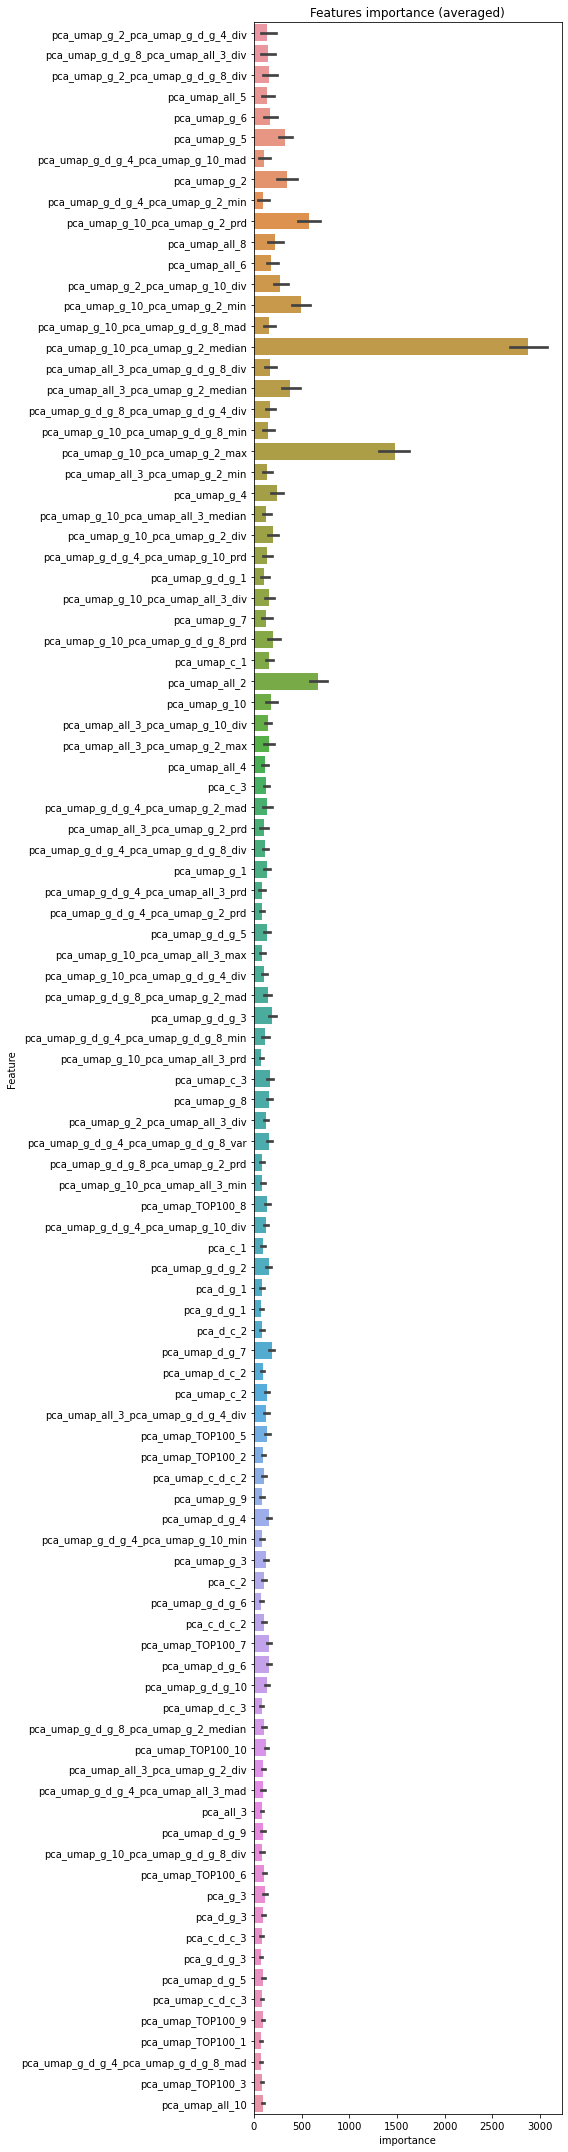

In [57]:
if DEBUG:
    show_feature_importance(feature_importance_df)